# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/104rep_50noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/105rep_50noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/106rep_50noiseLevel_GMA_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/104rep_50noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/105rep_50noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/106rep_50noiseLevel_GMA_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.293727        0.194581  0.048480  0.313913  0.020562   
       0.25   0.322722        0.190729  0.050335  0.247051  0.071087   
       0.50   0.327504        0.202236  0.056421  0.214938  0.096165   
       0.75   0.312533        0.186168  0.074214  0.210459  0.116972   
       1.00   0.333020        0.170119  0.073307  0.182312  0.132508   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.193505  0.011086  0.039593  0.049208  0.000000  
       0.25  0.198706  0.010148  0.038619  0.050406  0.000552  
       0.50  0.194038  0.008782  0.039380  0.052301  0.001613  
       0.75  0.199566  0.008409  0.038977  0.046810  0.002460  
       1.00  0.194835  0.006731  0.036506  0.047666  0.003784

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.296320        0.193866  0.048183  0.300890  0.021006   
       0.25   0.333612        0.221175  0.056029  0.263293  0.063818   
       0.50   0.287209        0.192802  0.064128  0.201233  0.098921   
       0.75   0.317226        0.202540  0.064396  0.200280  0.123850   
       1.00   0.312184        0.179362  0.073439  0.185872  0.147650   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.198719  0.009233  0.040941  0.048612  0.000000  
       0.25  0.214269  0.009261  0.040197  0.051228  0.000567  
       0.50  0.215056  0.010074  0.042316  0.050786  0.001541  
       0.75  0.204516  0.007555  0.038417  0.049715  0.002446  
       1.00  0.192789  0.006878  0.039793  0.047047  0.003553

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.332474        0.190093  0.051128  0.309979  0.018826   
       0.25   0.284808        0.195200  0.058754  0.226568  0.069685   
       0.50   0.280003        0.181260  0.060573  0.215262  0.102355   
       0.75   0.306144        0.190797  0.064236  0.199895  0.122078   
       1.00   0.343030        0.178081  0.082297  0.162071  0.137089   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.193980  0.010127  0.040358  0.053954  0.000000  
       0.25  0.175581  0.010486  0.040711  0.047810  0.000549  
       0.50  0.195090  0.009200  0.040803  0.049521  0.001465  
       0.75  0.178919  0.008580  0.038800  0.049629  0.002506  
       1.00  0.188748  0.007153  0.035036  0.048578  0.003447

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.307507        0.192847  0.049264  0.308261  0.020131   
         0.25   0.309289        0.201424  0.057705  0.244626  0.069208   
         0.50   0.286885        0.190625  0.066920  0.209178  0.100499   
         0.75   0.291694        0.191152  0.078201  0.202394  0.122481   
         1.00   0.298805        0.173484  0.089942  0.177280  0.140925   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.195401  0.010149  0.040297  0.050591  0.000000  
         0.25  0.196183  0.009969  0.039843  0.050012  0.000366  
         0.50  0.201384  0.009375  0.040831  0.051394  0.001017  
         0.75  0.194301  0.008243  0.038721  0.049578  0.001638  
         1.00  0.192049  0.007046  0.037078  0.048995  0.002393

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  6.095775e+01  3.830916e+01      36.424600  5.920951e+01   
         0.25  4.562280e+06  2.387218e+06  223584.995860  1.427086e+06   
         0.50  5.504432e+06  3.365541e+06  324725.295380  2.241663e+06   
         0.75  6.091505e+06  4.296528e+06  432146.945852  2.709233e+06   
         1.00  6.135963e+06  4.682593e+06  468004.073384  2.995600e+06   

                                                                        \
                        PMK           PMD          GPPS            Idi   
Strain   Time                                                            
Strain 1 0.00  2.677443e+01  5.322851e+01  5.629791e+01      18.826760   
         0.25  4.627639e+05  2.286100e+06  2.550127e+06  431717.584326   
         0.50  7.122424e+05  3.593802e+06  3.257557e+06  642676.172782   
         0.75  9.261810e+05  4.686807e+06  3.653431e+06  771466.197171   
         1.00  1.020998e+06  5.491013e+06  3.759702e+06  818099.211223   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.699840  
         0.25     183378.398002  
         0.50     290485.416528  
         0.75     339428.322077  
         1.00     411476.812771

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


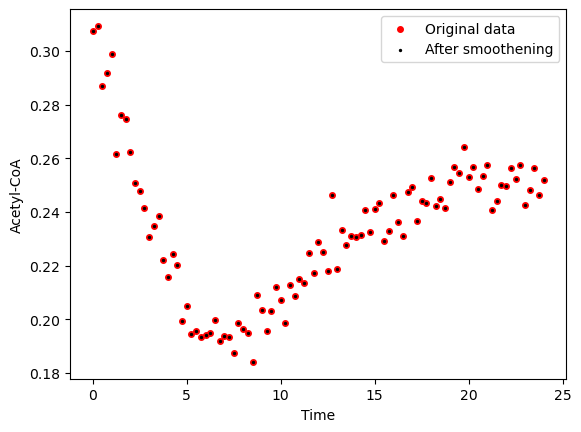

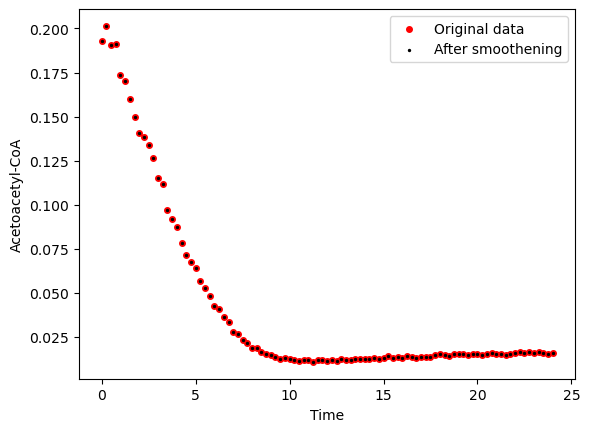

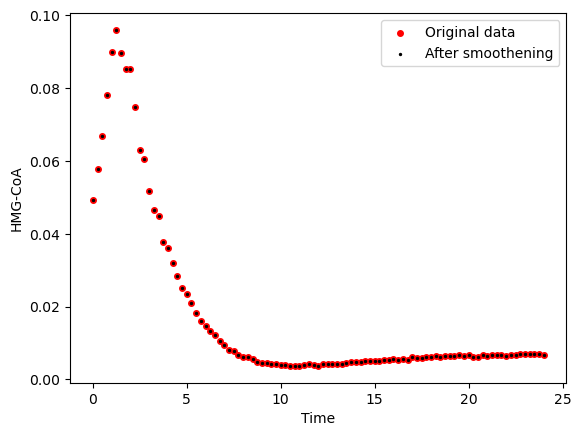

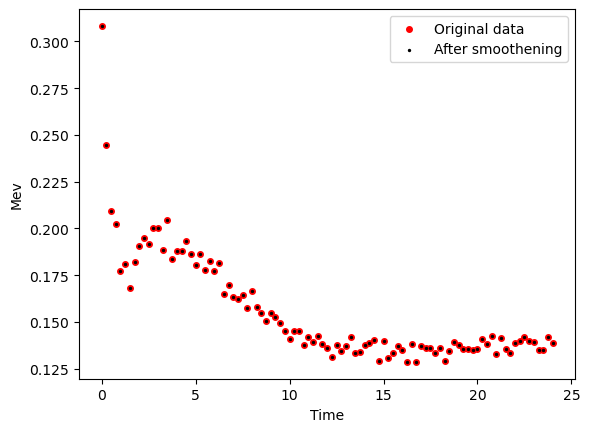

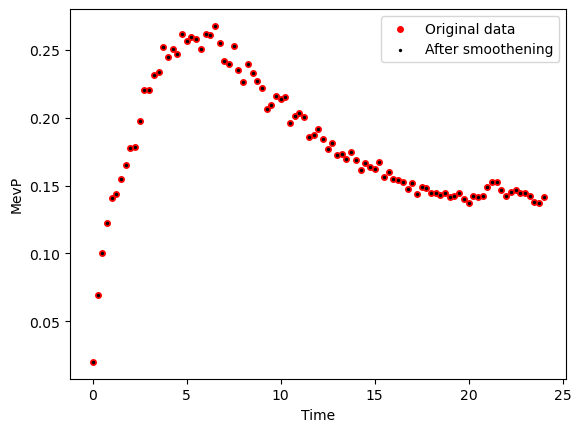

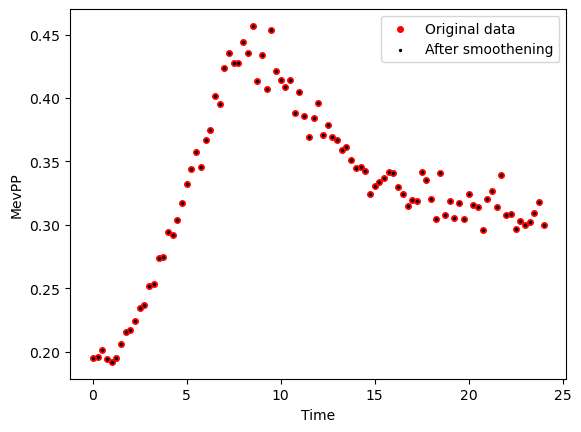

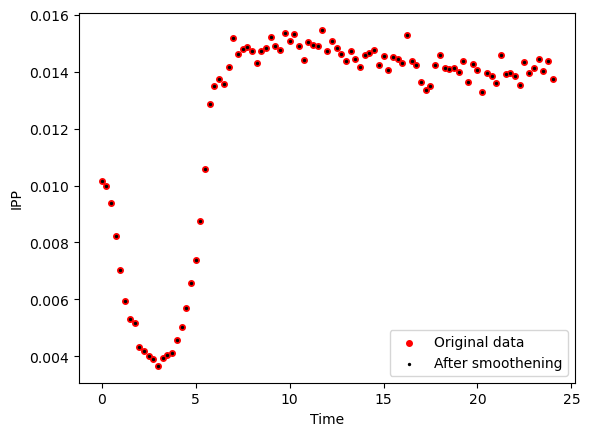

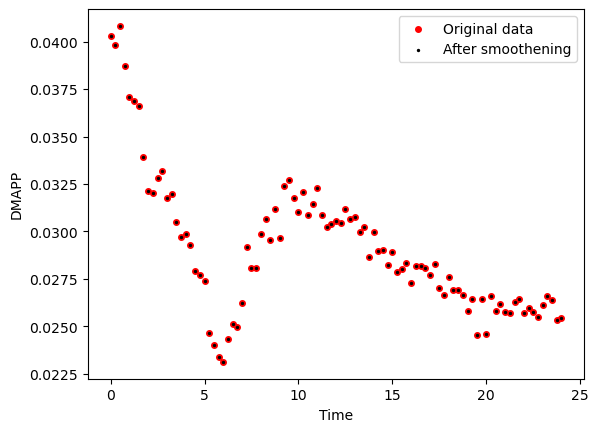

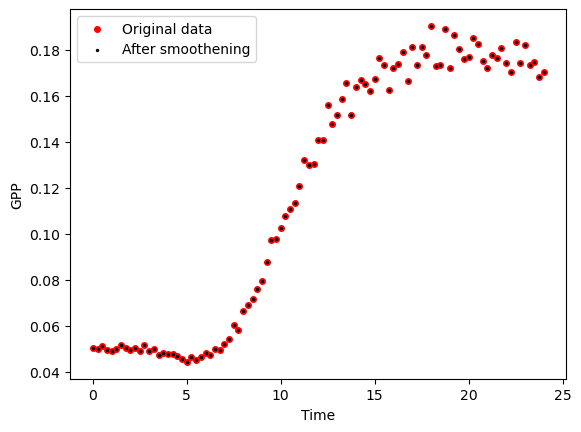

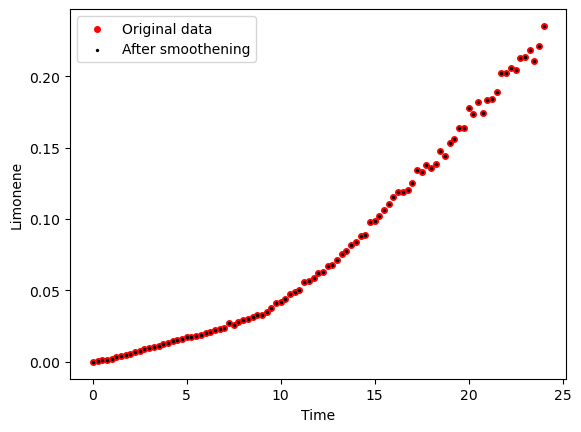

Strain Strain 2


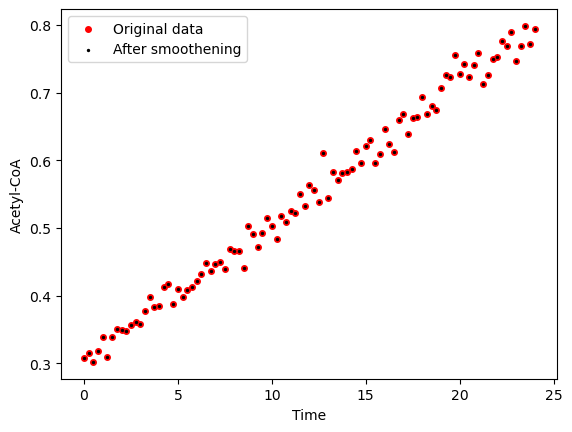

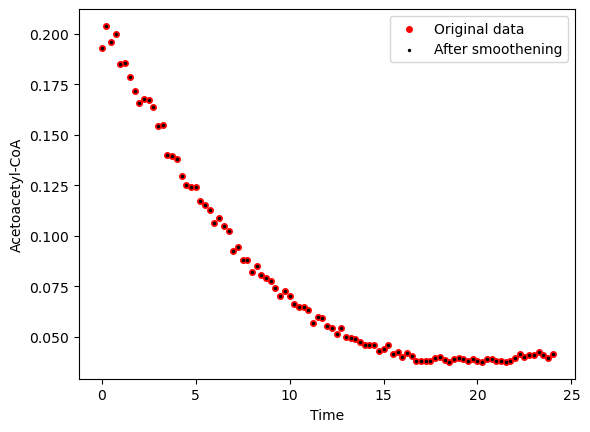

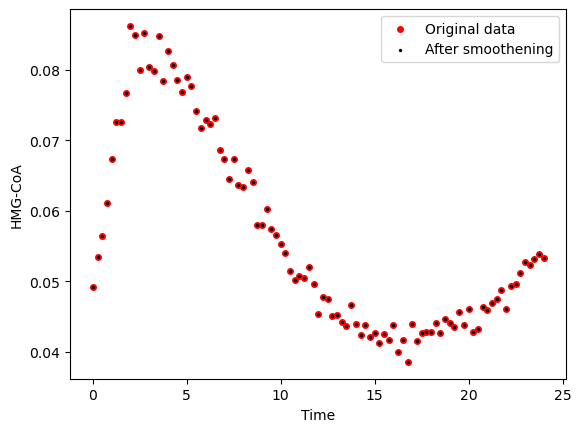

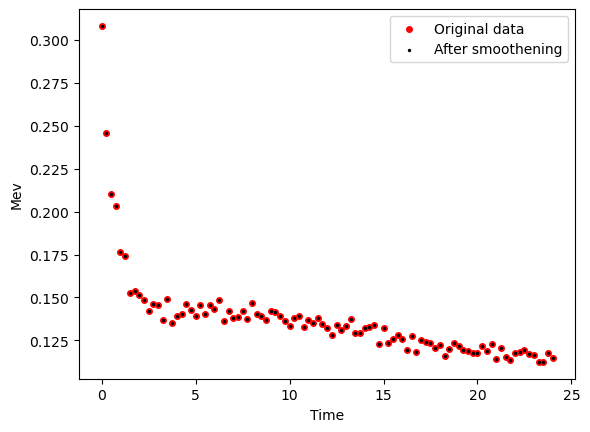

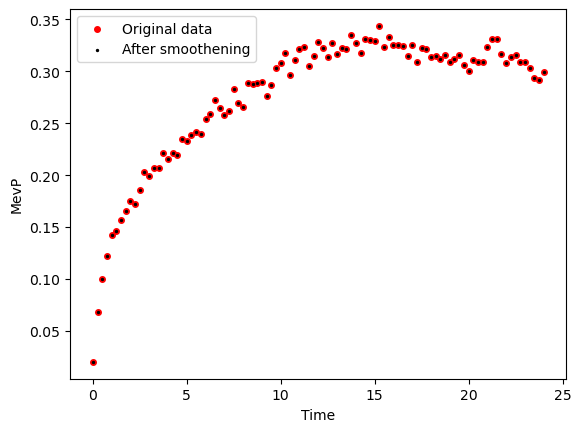

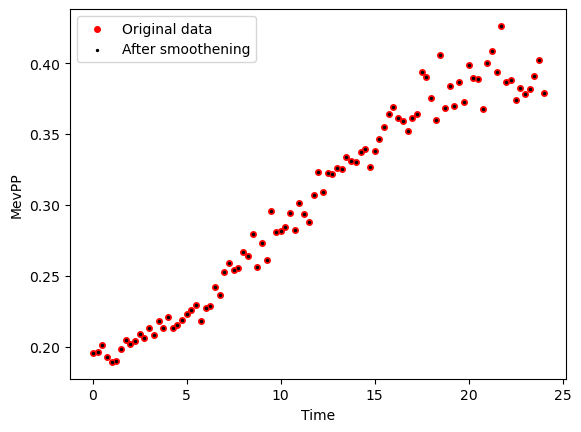

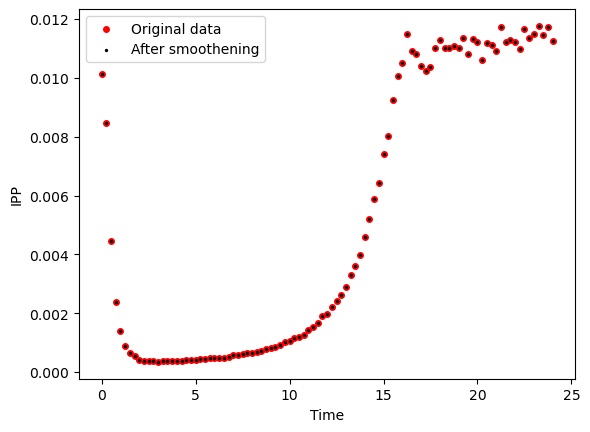

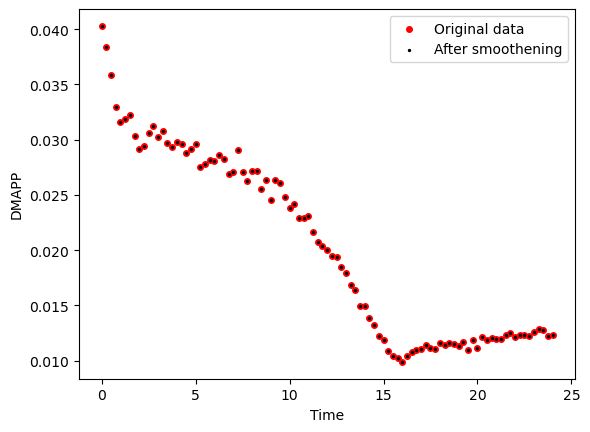

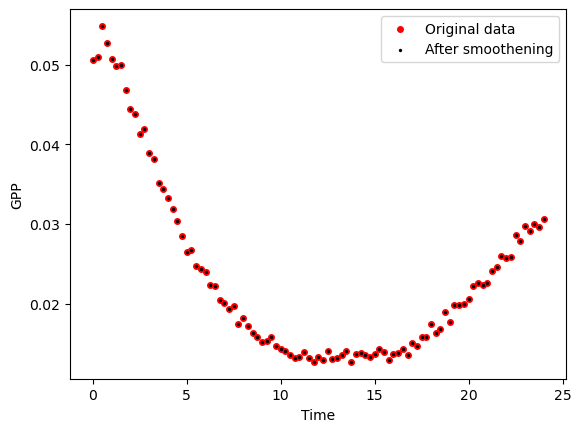

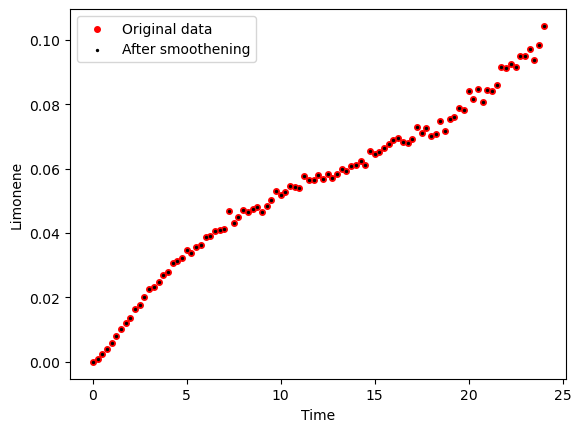

Strain Strain 3


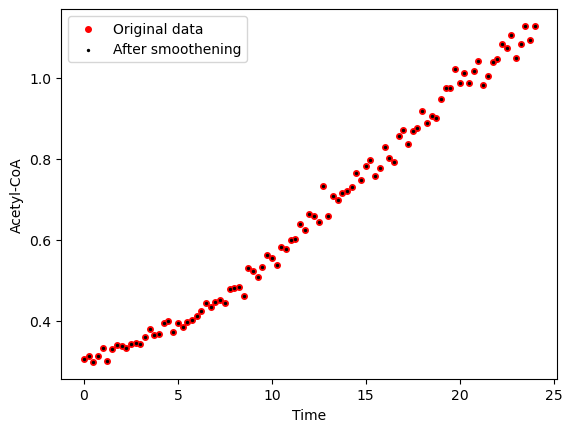

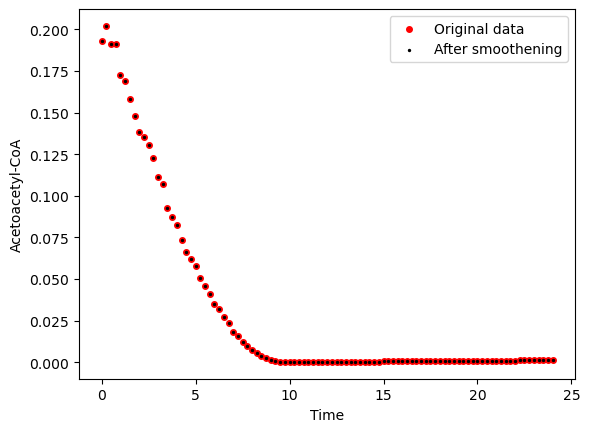

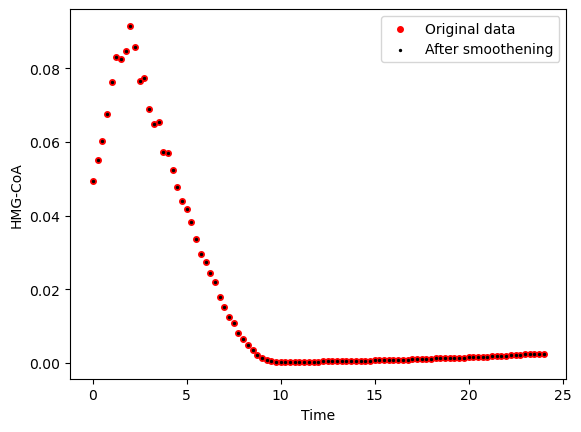

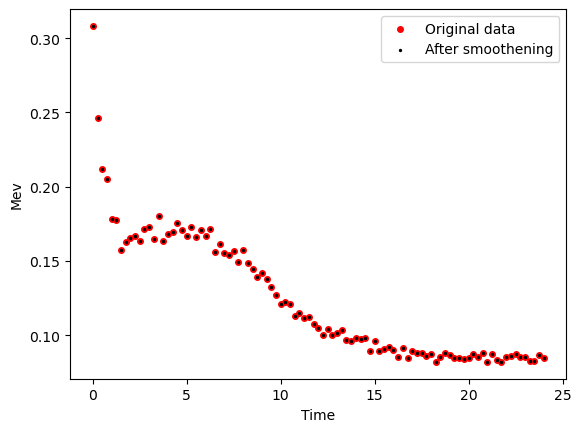

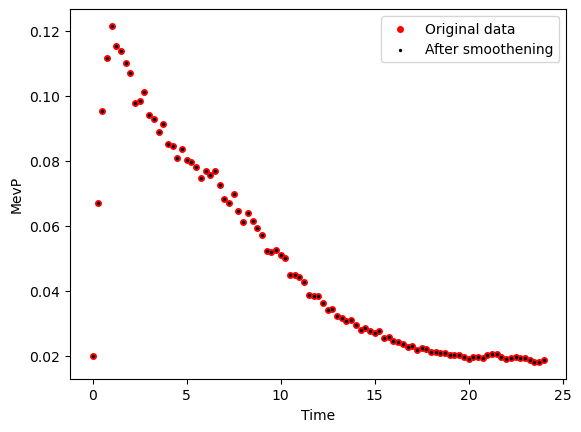

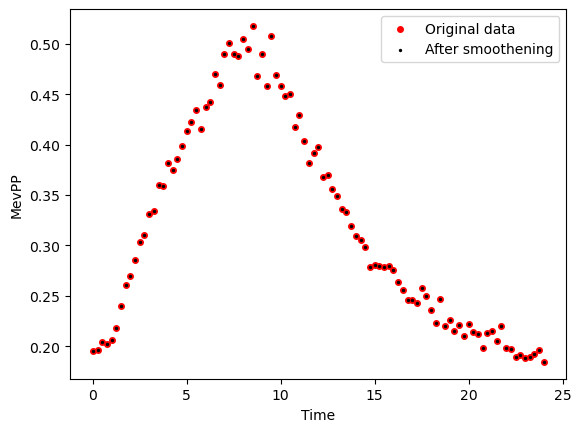

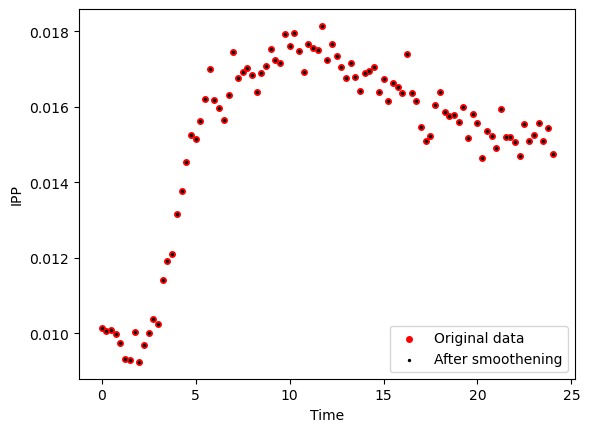

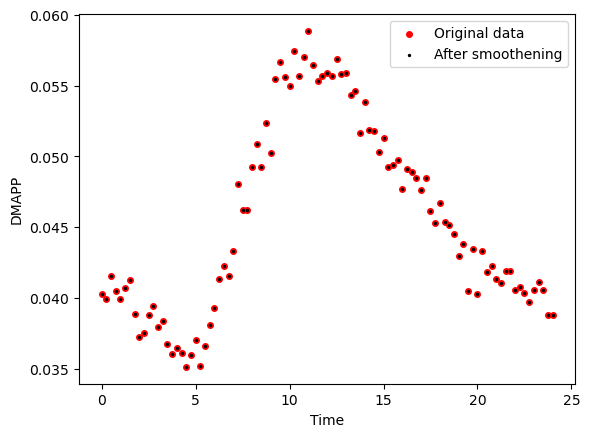

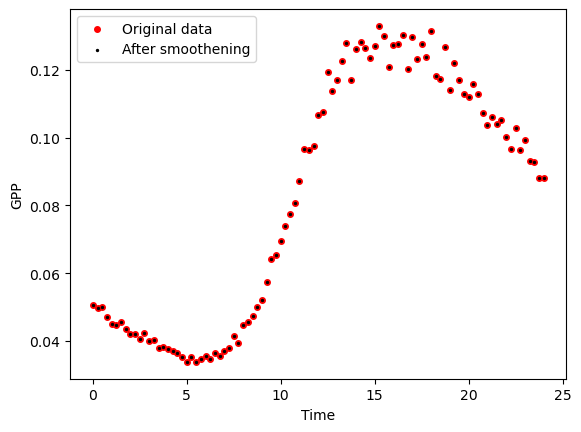

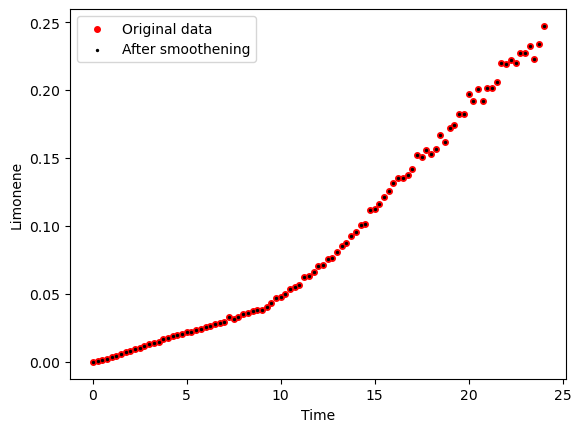

Strain WT


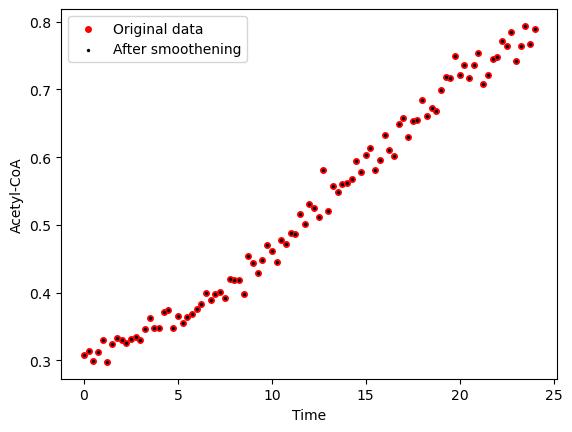

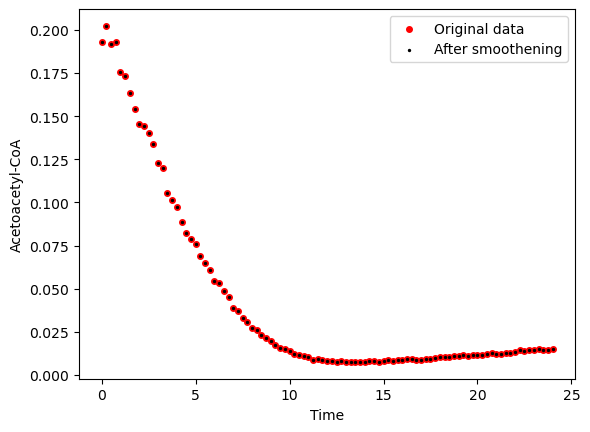

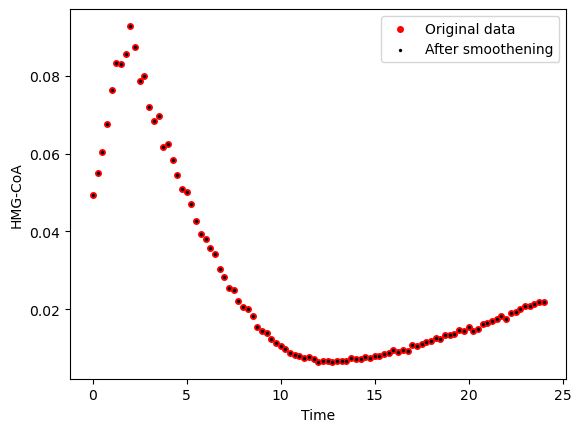

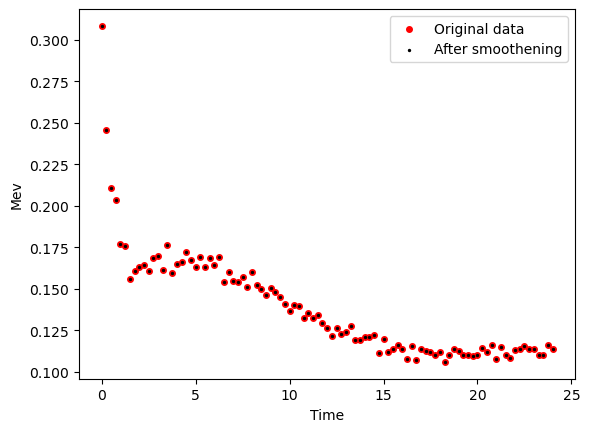

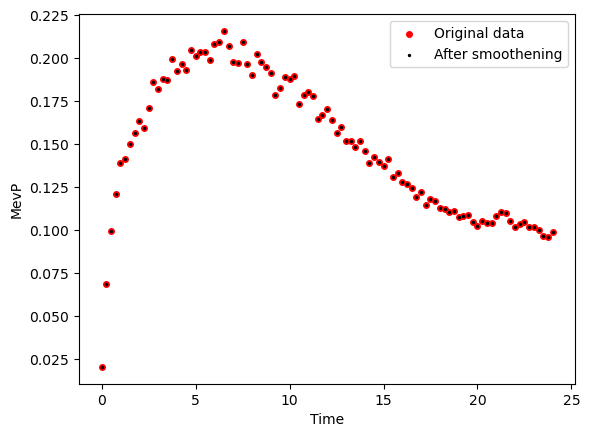

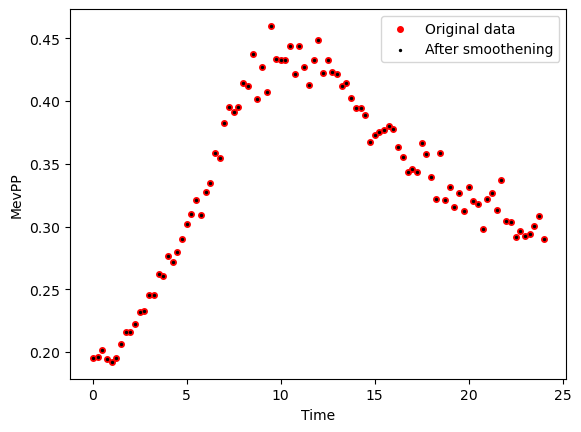

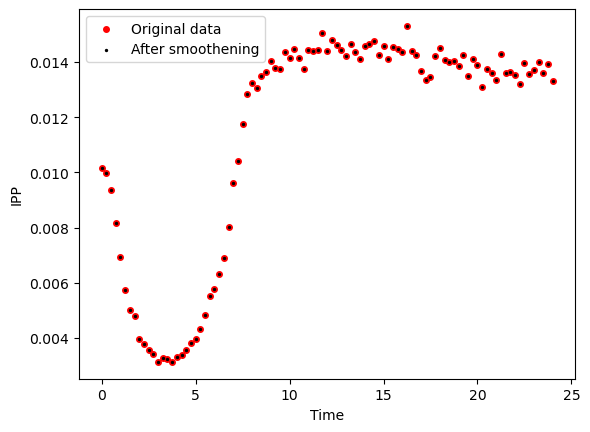

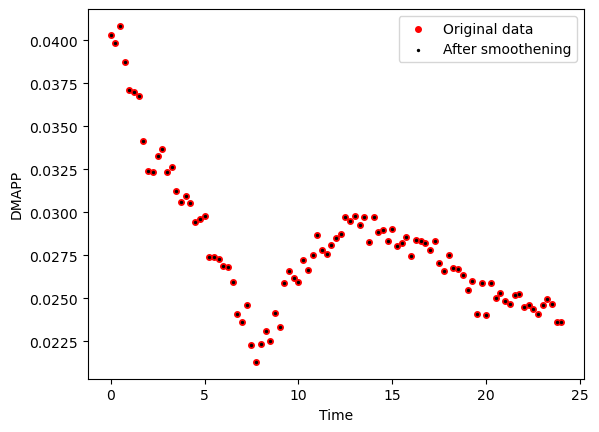

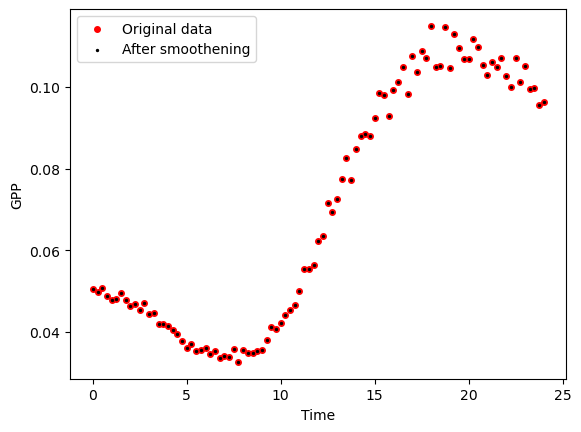

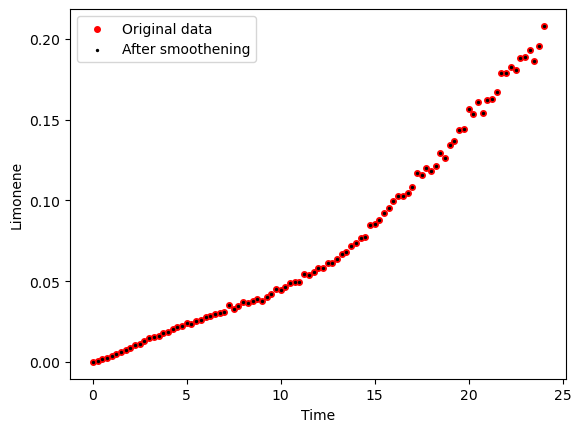

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


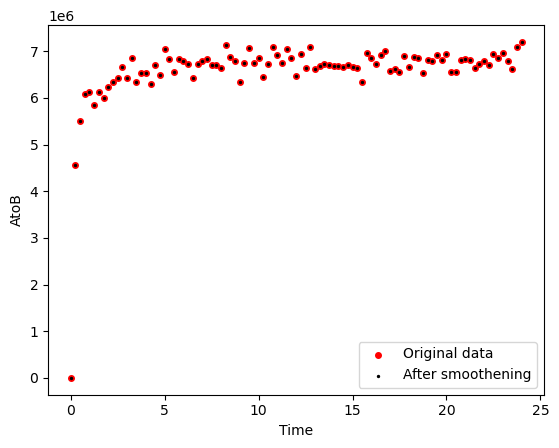

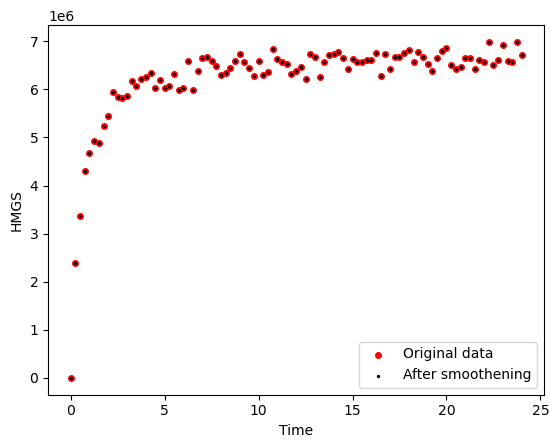

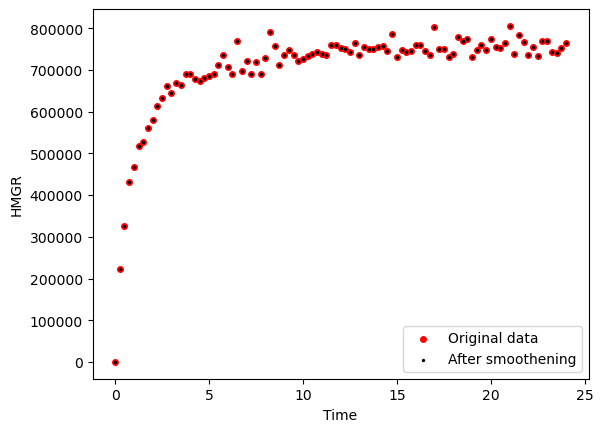

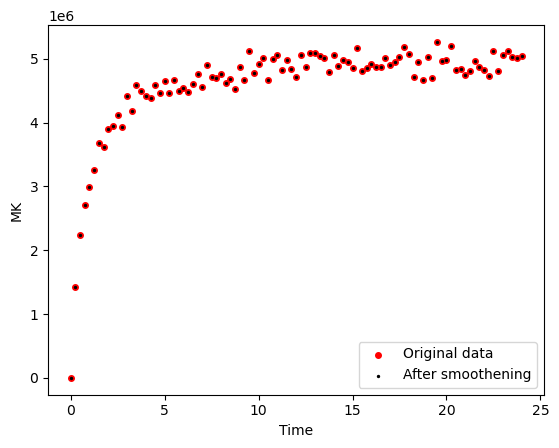

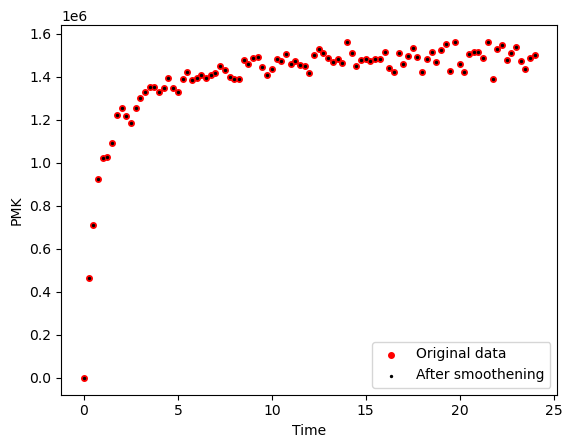

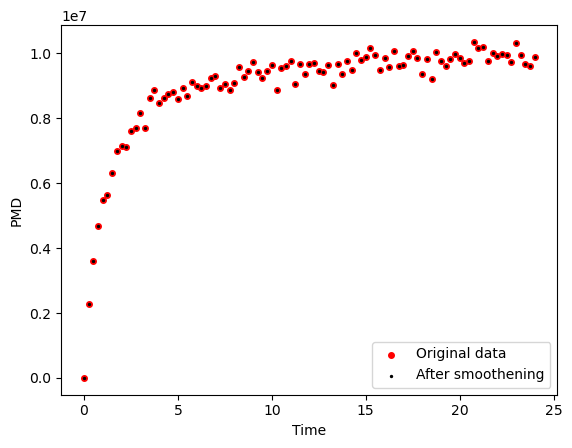

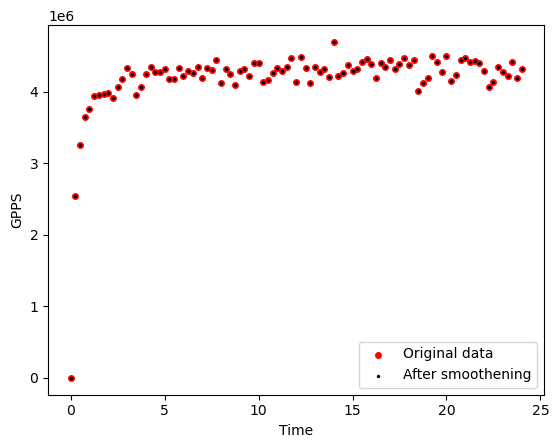

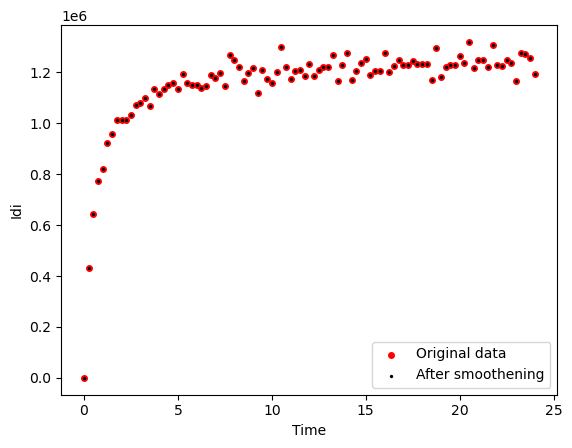

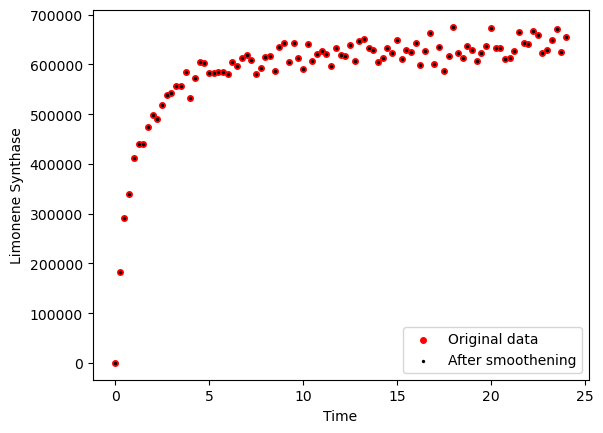

Strain Strain 2


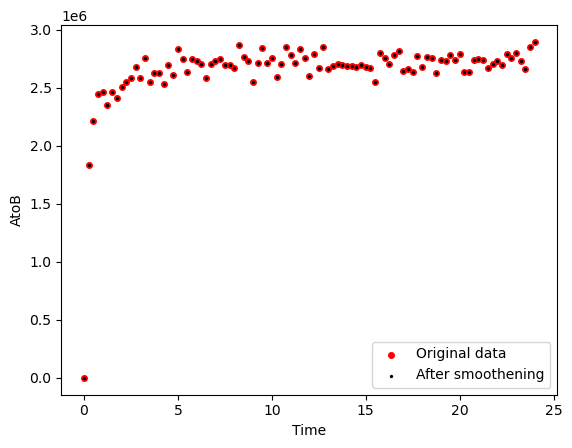

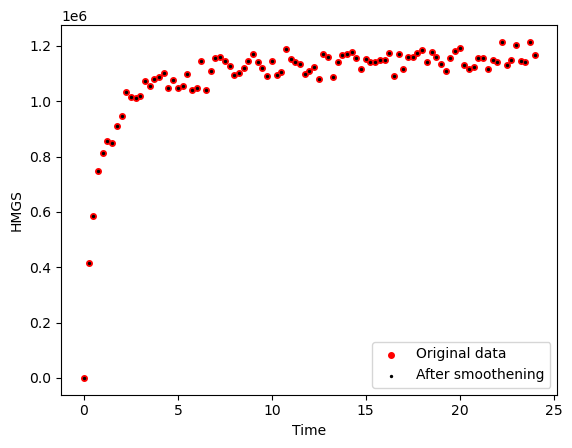

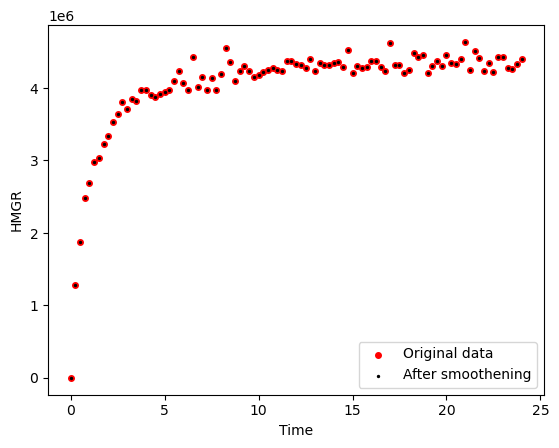

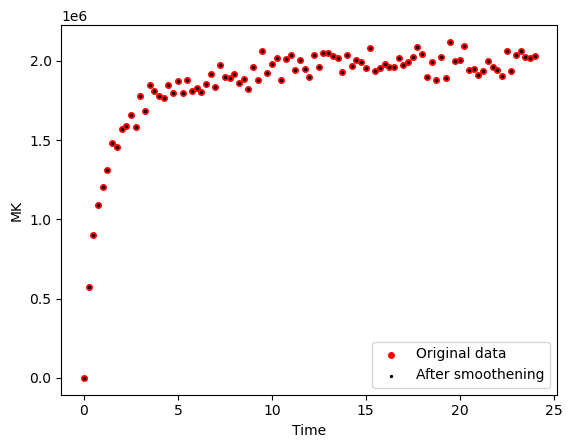

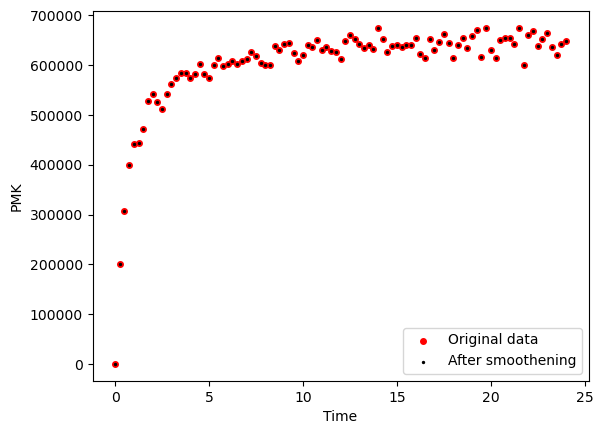

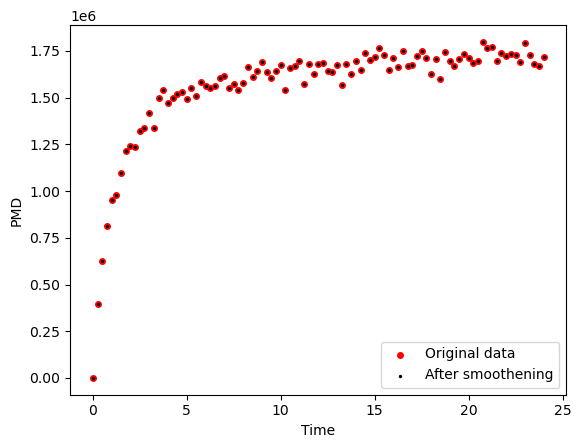

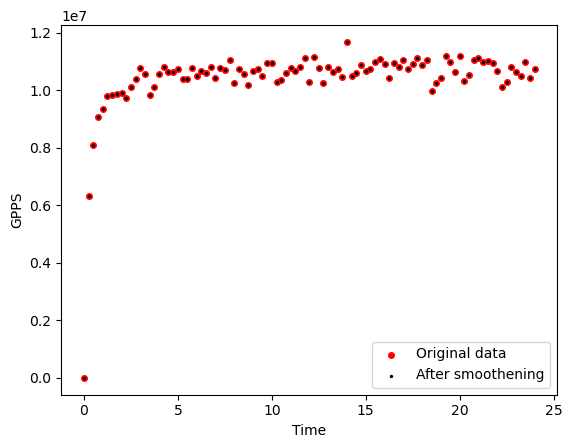

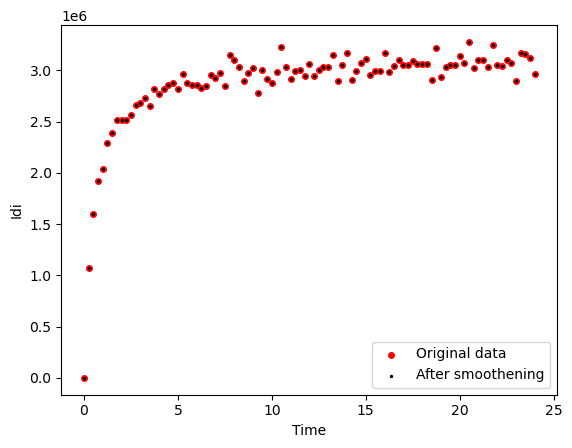

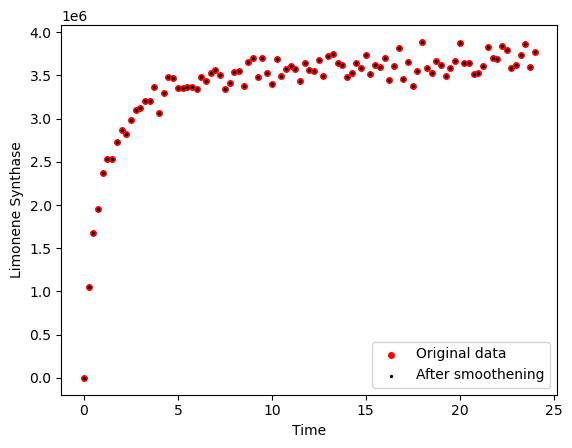

Strain Strain 3


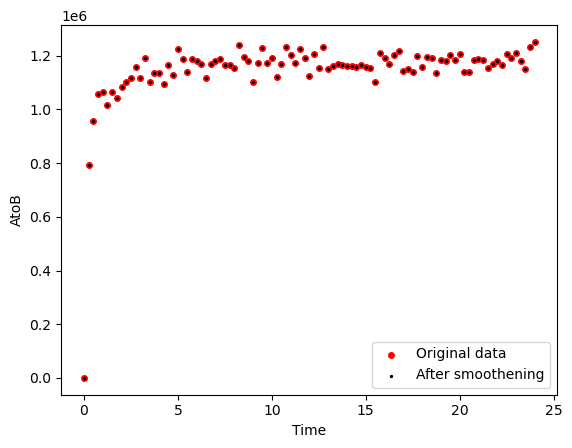

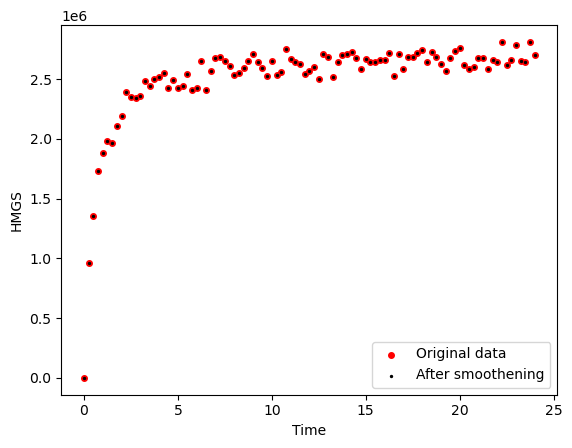

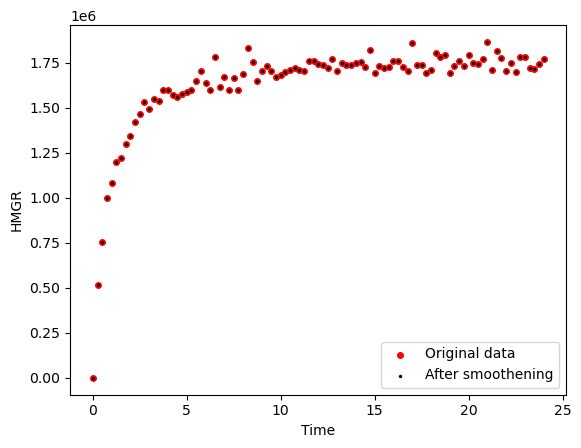

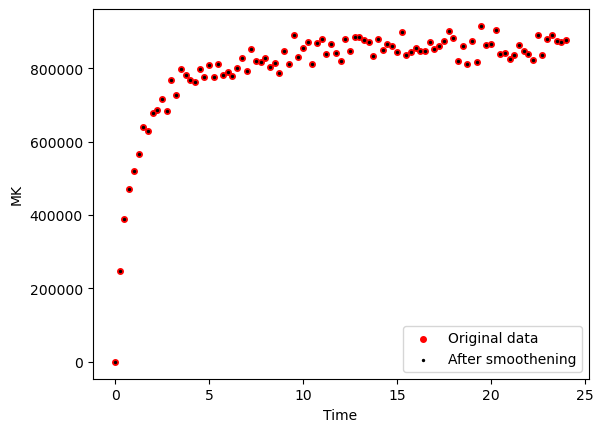

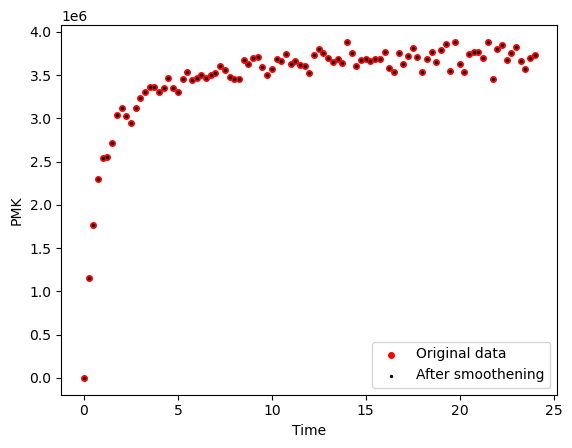

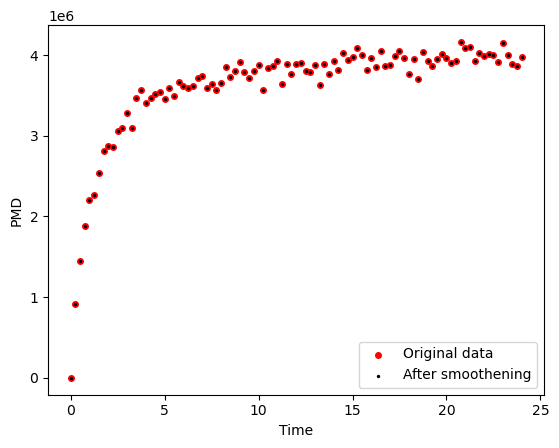

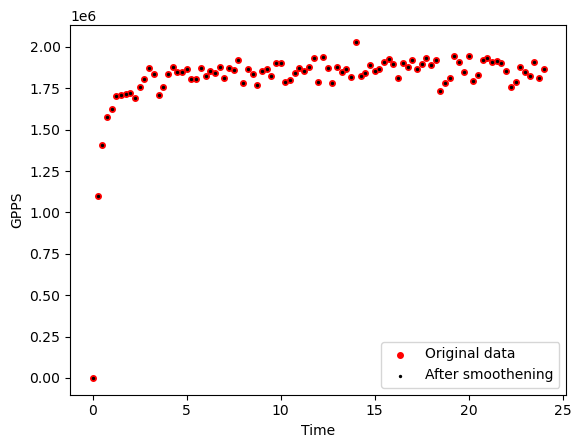

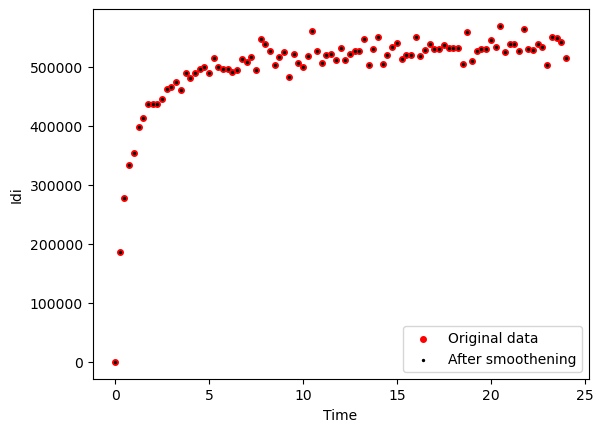

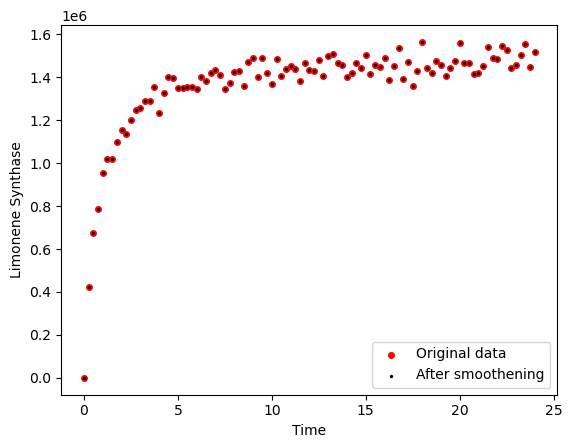

Strain WT


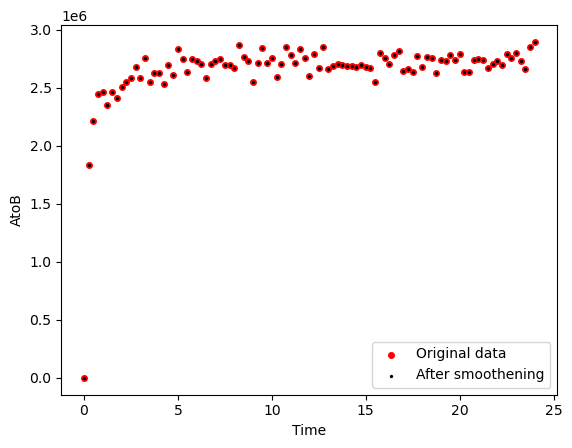

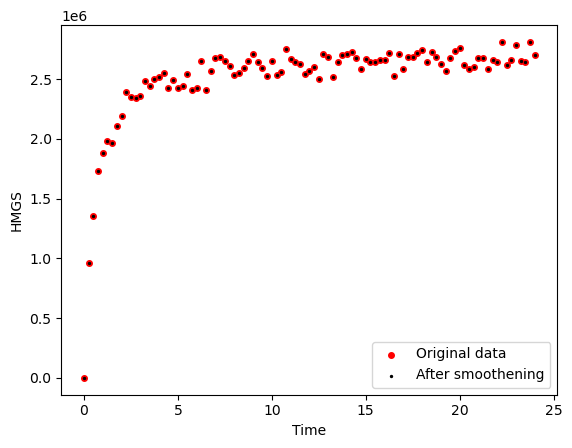

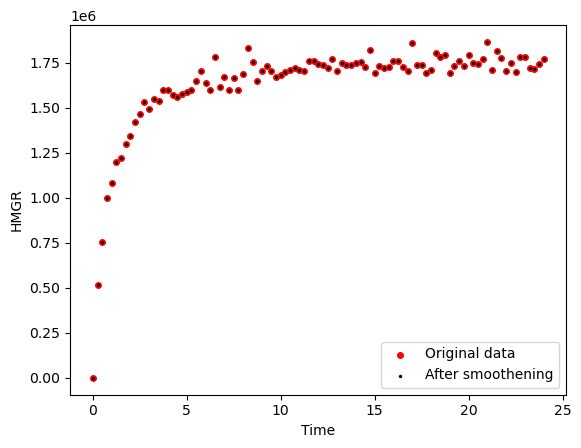

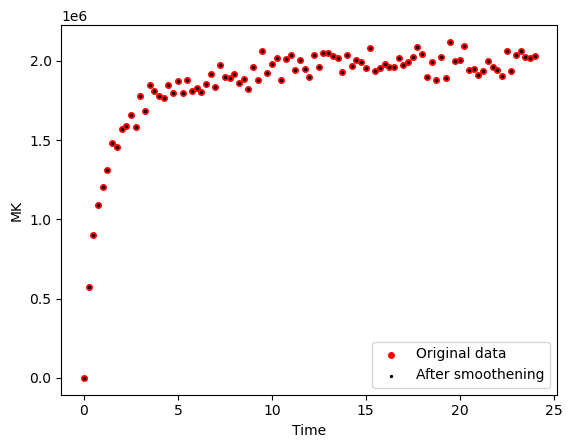

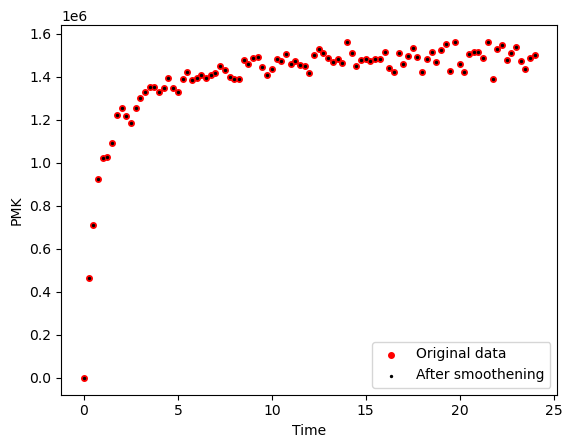

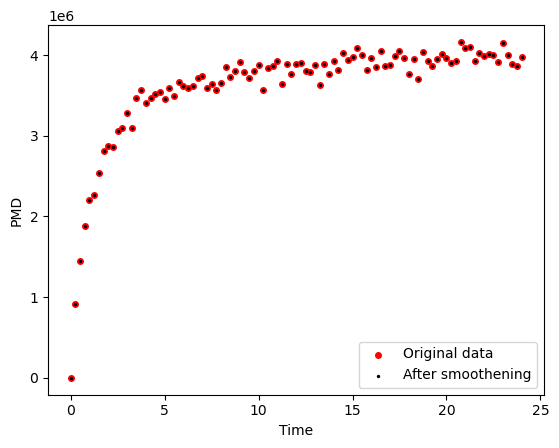

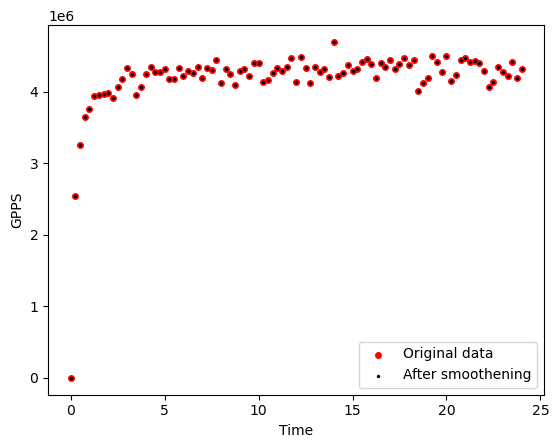

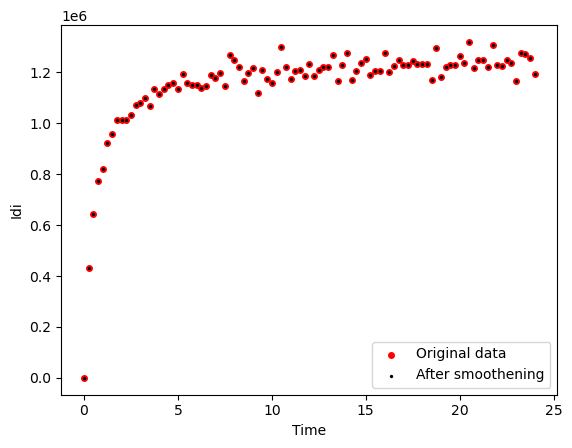

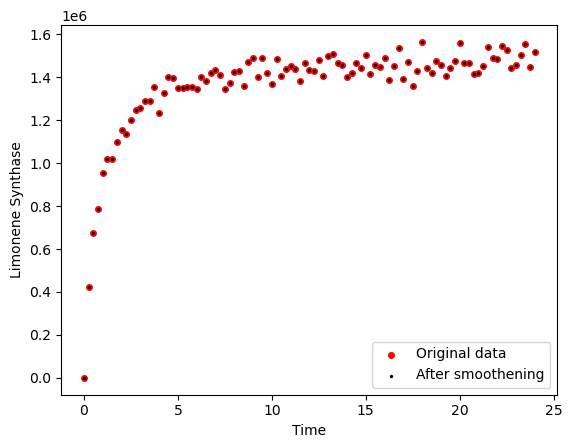

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative52

df_allSmooth=estimate_state_derivative52(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.307507        0.192847  0.049264  0.308261  0.020131   
         0.25    0.309289        0.201424  0.057705  0.244626  0.069208   
         0.50    0.286885        0.190625  0.066920  0.209178  0.100499   
         0.75    0.291694        0.191152  0.078201  0.202394  0.122481   
         1.00    0.298805        0.173484  0.089942  0.177280  0.140925   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.742292        0.014403  0.020888  0.113564  0.101795   
         23.25   0.763702        0.015134  0.020904  0.110077  0.099836   
         23.50   0.793760        0.014674  0.021450  0.110256  0.096613   
         23.75   0.767065        0.014179  0.021926  0.115985  0.096005   
         24.00   0.788743        0.015025  0.021914  0.113500  0.098686   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.195401  0.010149  0.040297  0.050591  0.000000  ...   
         0.25   0.196183  0.009969  0.039843  0.050012  0.000366  ...   
         0.50   0.201384  0.009375  0.040831  0.051394  0.001017  ...   
         0.75   0.194301  0.008243  0.038721  0.049578  0.001638  ...   
         1.00   0.192049  0.007046  0.037078  0.048995  0.002393  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.292376  0.013727  0.024601  0.105096  0.188823  ...   
         23.25  0.294256  0.014004  0.024972  0.099510  0.193287  ...   
         23.50  0.300041  0.013601  0.024665  0.099754  0.186422  ...   
         23.75  0.308237  0.013921  0.023616  0.095538  0.195773  ...   
         24.00  0.289821  0.013301  0.023641  0.096211  0.207925  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.057280        0.027446  0.030836 -0.242483  0.198600   
         0.25    -0.035640        0.003924  0.035789 -0.182080  0.158272   
         0.50    -0.013999       -0.019599  0.040741 -0.121677  0.117944   
         0.75    -0.033430       -0.031879  0.039818 -0.063644  0.075700   
         1.00    -0.020555       -0.033002  0.025346 -0.041214  0.051745   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.015434        0.000957  0.002109 -0.005818 -0.006921   
         23.25    0.006862       -0.000021  0.001710  0.000498 -0.006766   
         23.50    0.038506        0.000116  0.001229  0.002311 -0.004019   
         23.75    0.006381        0.000226  0.001157  0.006628  0.002778   
         24.00   -0.025744        0.000336  0.001084  0.010945  0.009576   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00   0.017539 -0.000234  0.003233  0.002212  0.001570  
         0.25   0.007052 -0.001704  0.000105  0.000381  0.001997  
         0.50  -0.003435 -0.003173 -0.003024 -0.001450  0.002423  
         0.75  -0.004780 -0.004159 -0.003858 -0.001099  0.002803  
         1.00   0.003966 -0.004187 -0.004091  0.000476  0.003101  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.005749 -0.000121  0.000588 -0.006573  0.006493  
         23.25  0.012220  0.000224 -0.000330 -0.006733  0.005205  
         23.50  0.003548 -0.000374 -0.001311 -0.008697  0.016276  
         23.75 -0.018269 -0.000987 -0.002130 -0.004092  0.034329  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

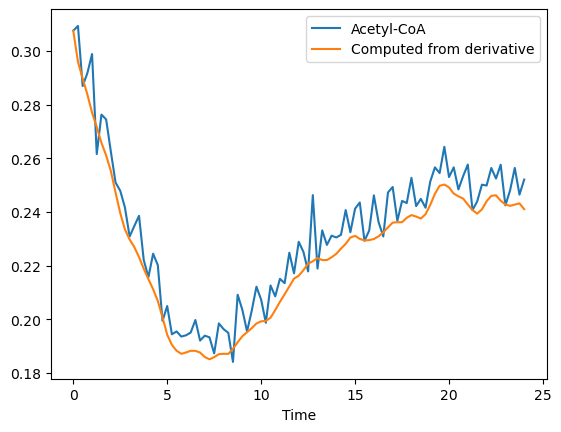

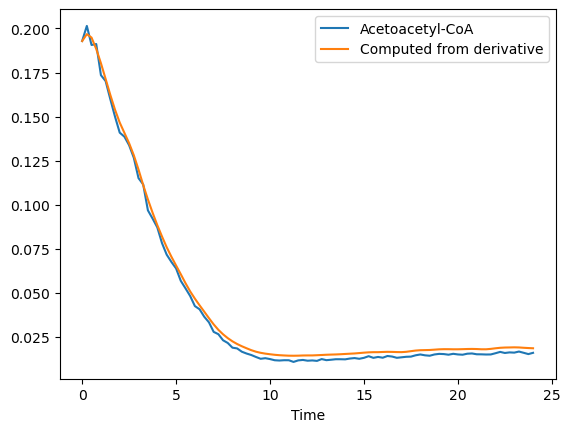

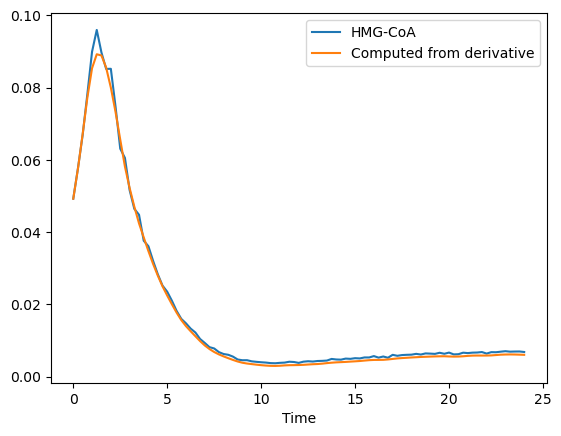

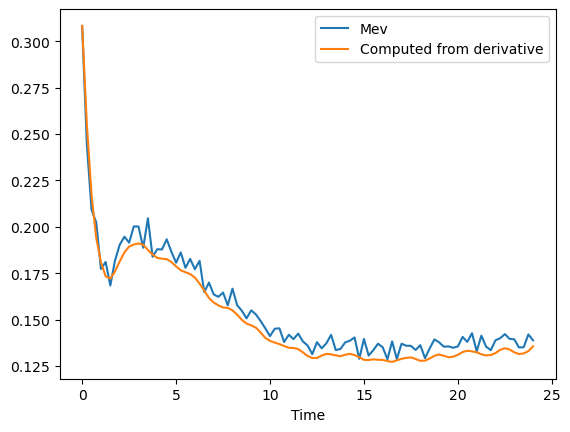

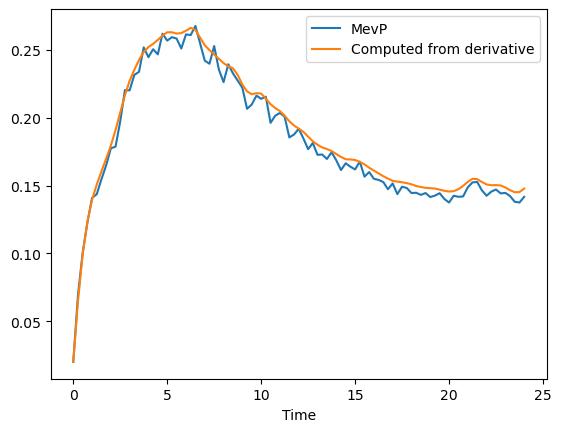

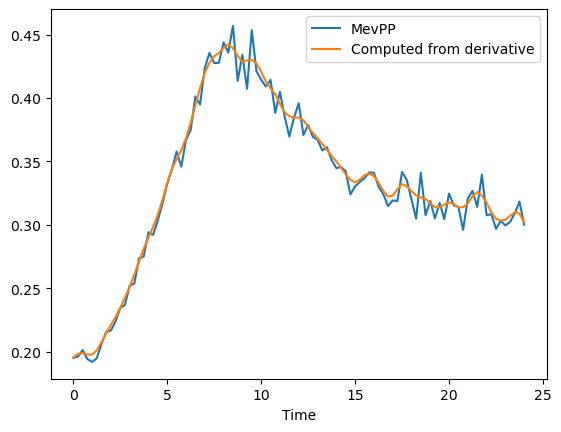

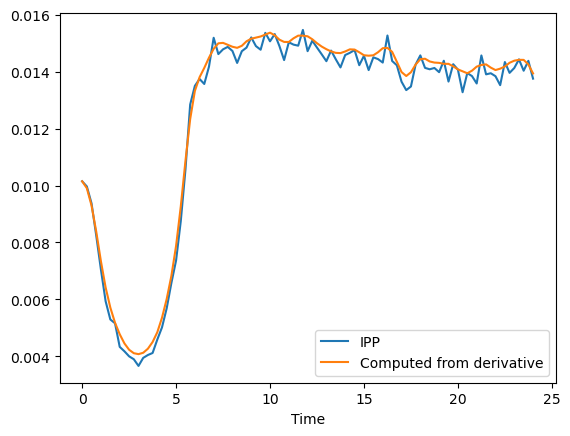

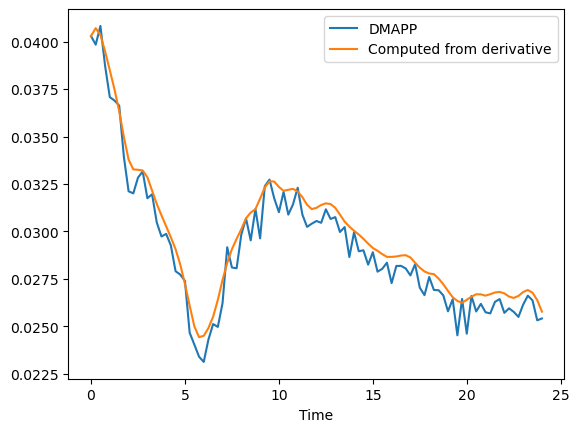

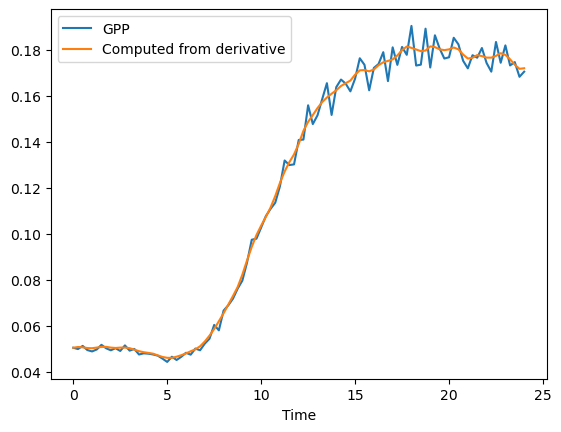

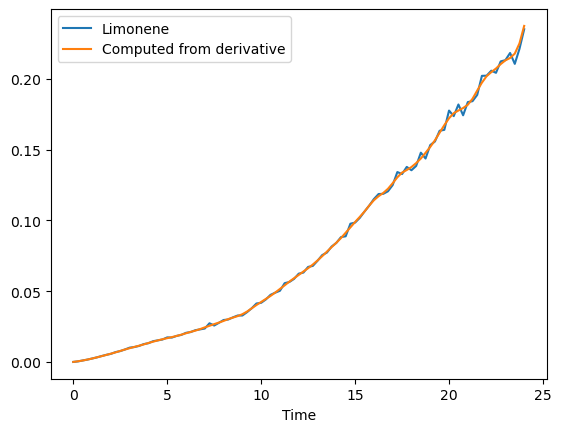

'Time profile from derivative vs. actual profile for Strain 2'

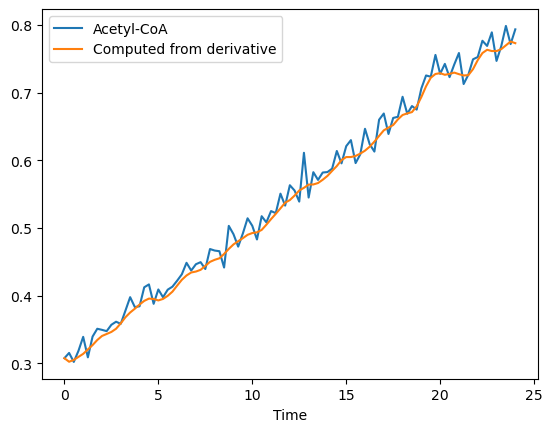

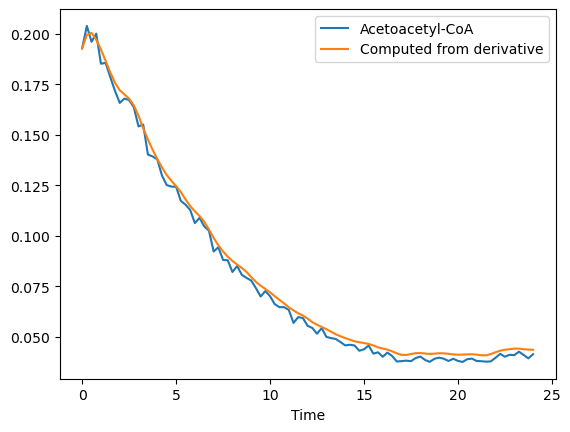

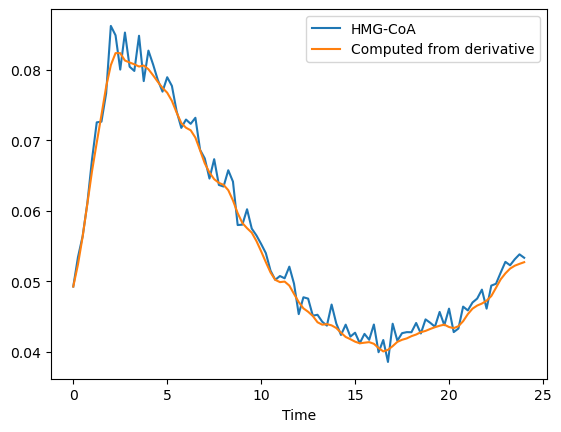

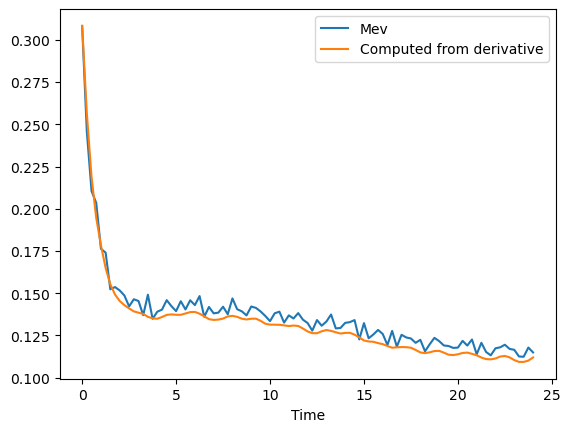

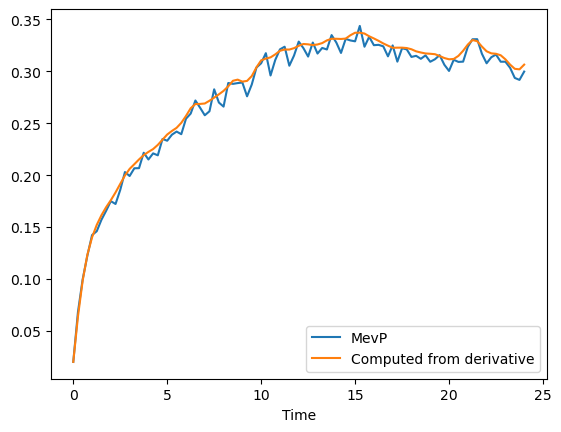

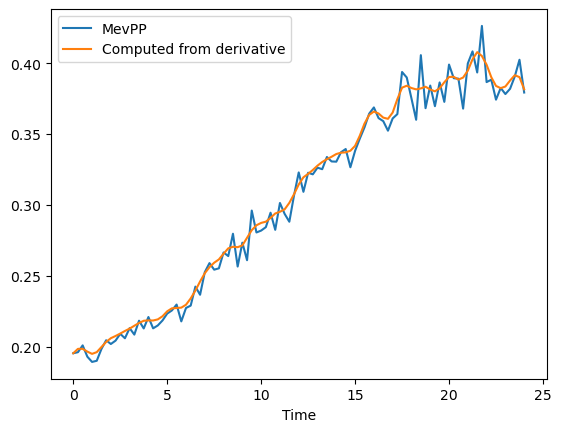

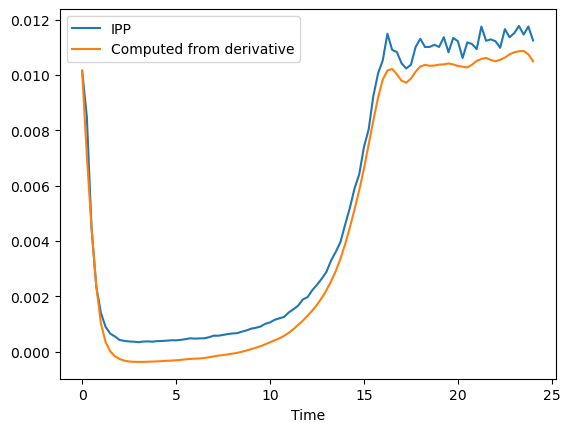

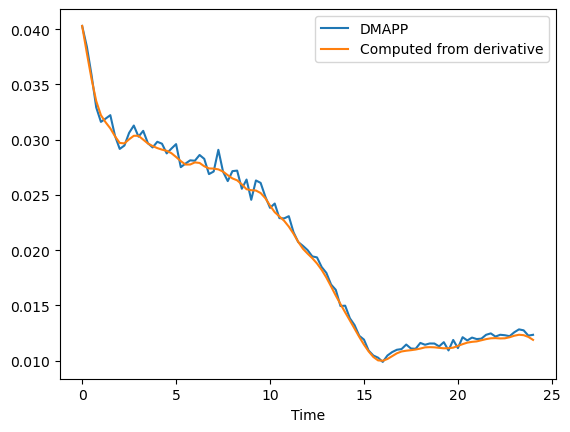

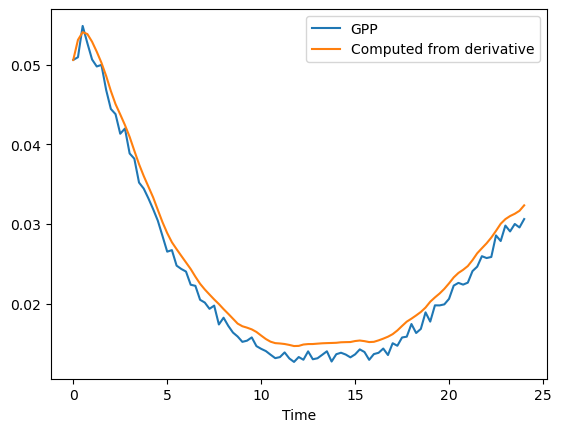

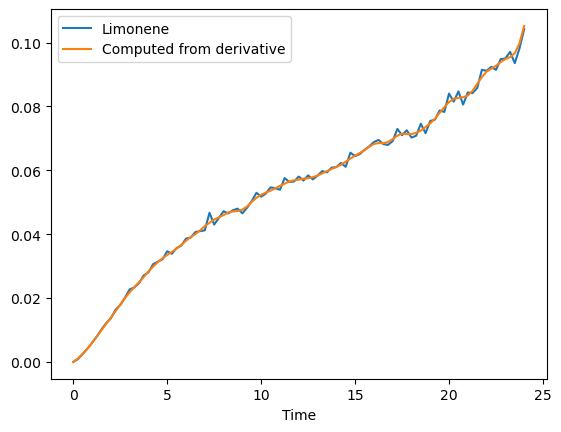

'Time profile from derivative vs. actual profile for Strain 3'

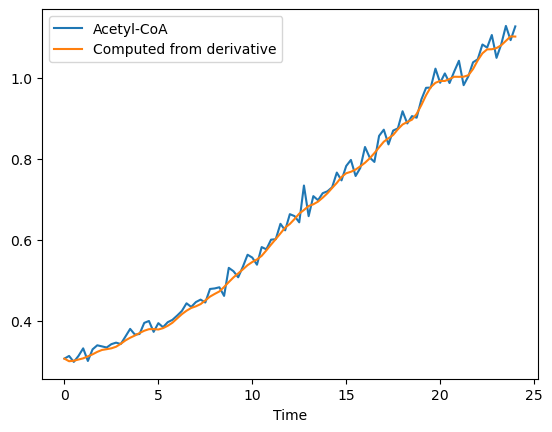

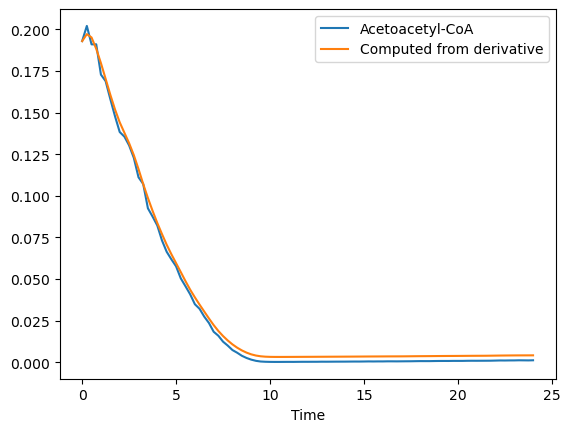

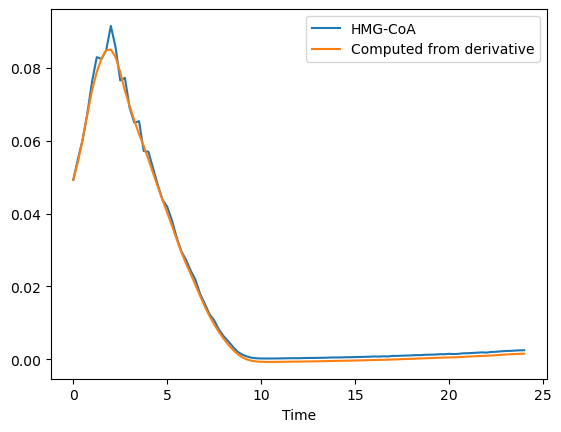

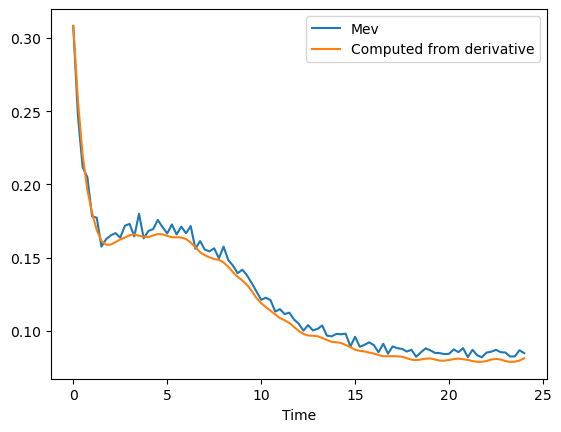

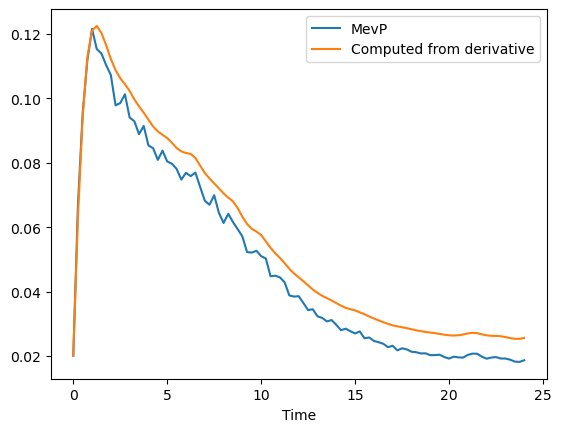

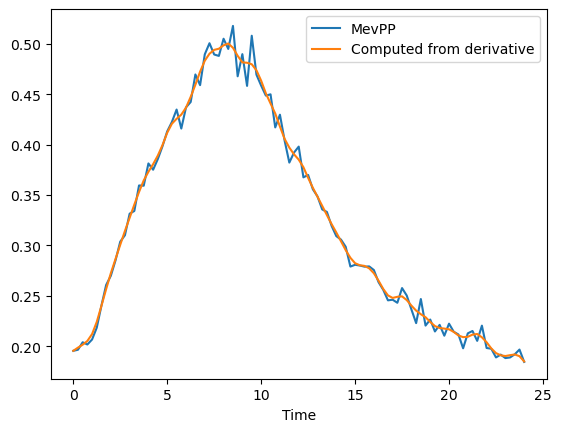

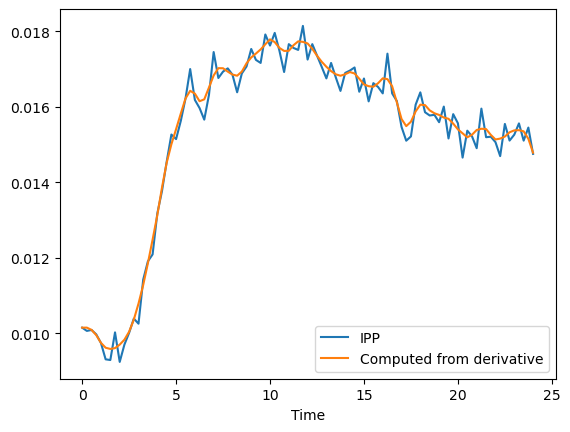

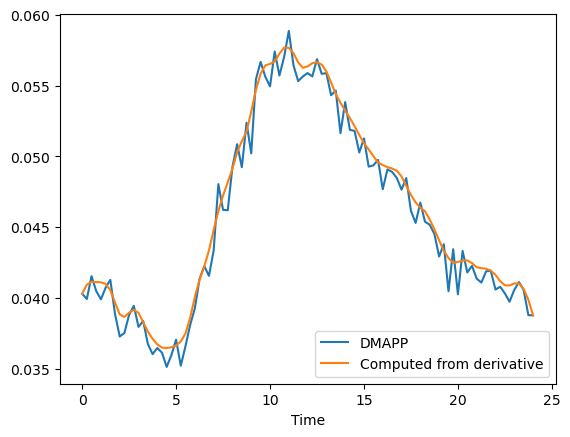

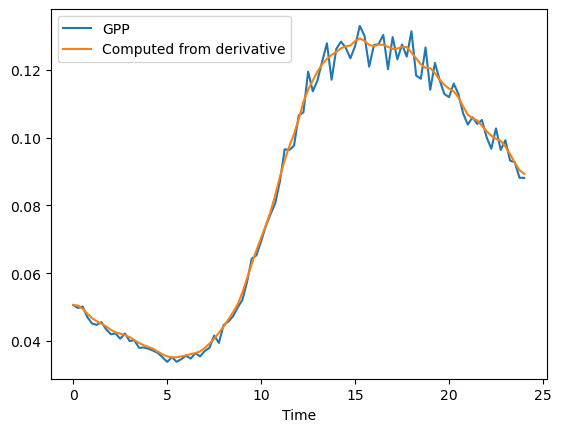

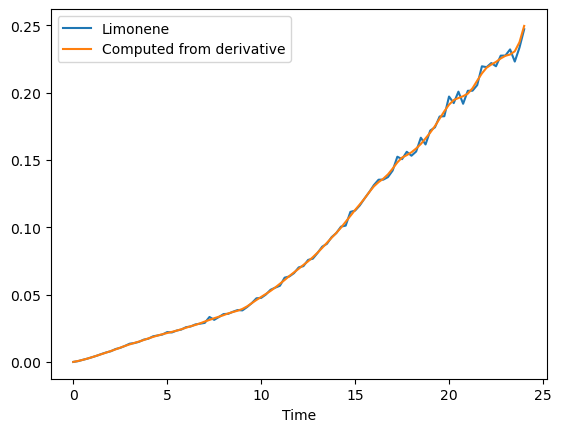

'Time profile from derivative vs. actual profile for WT'

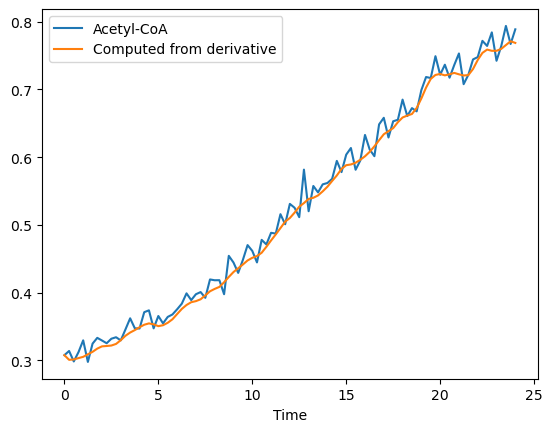

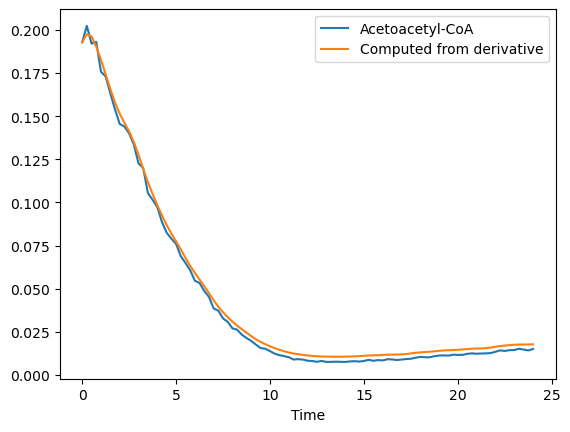

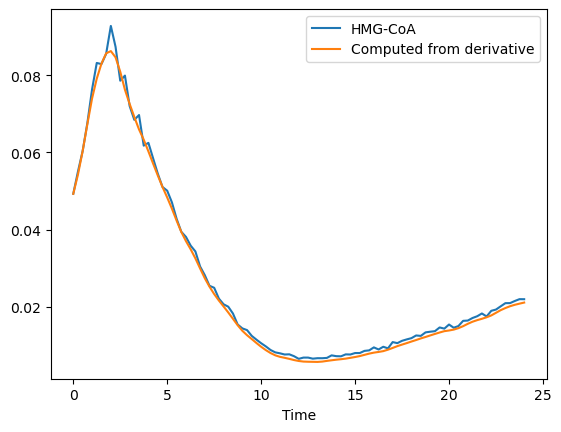

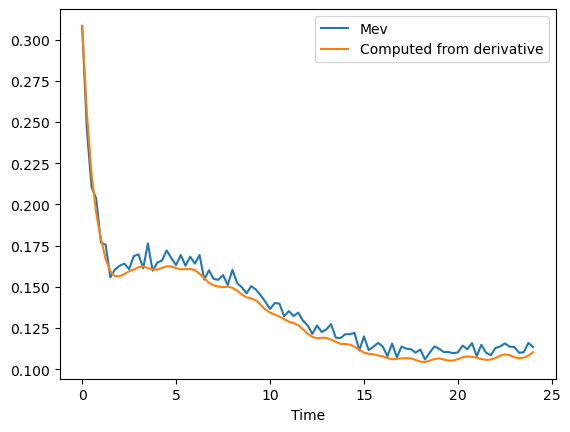

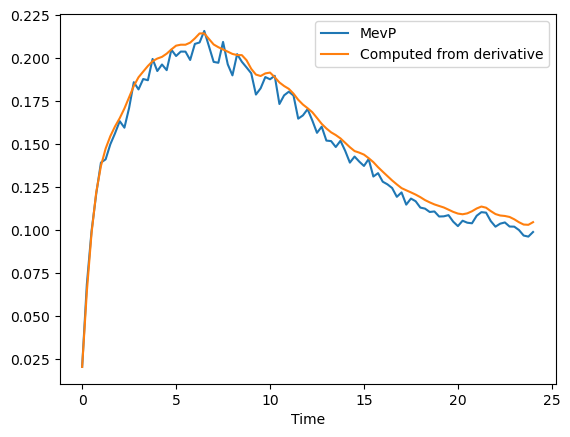

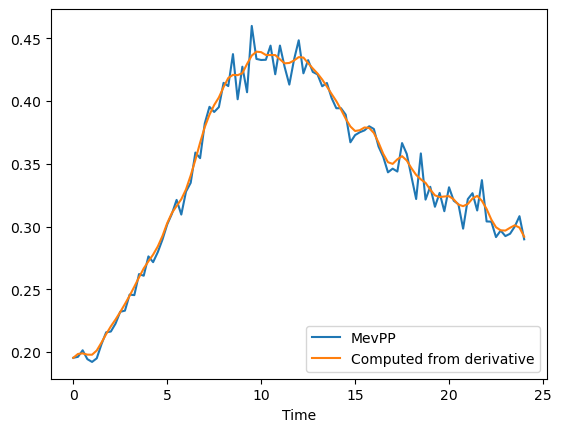

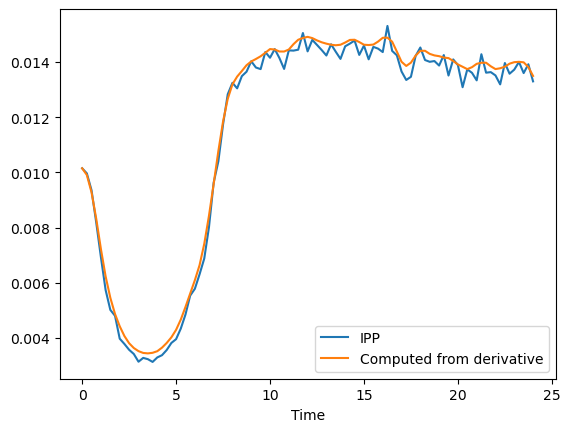

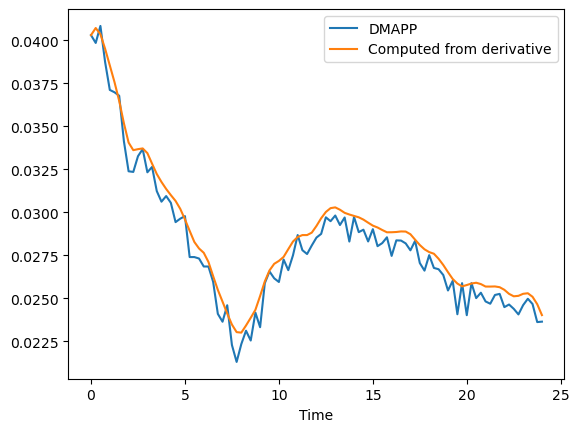

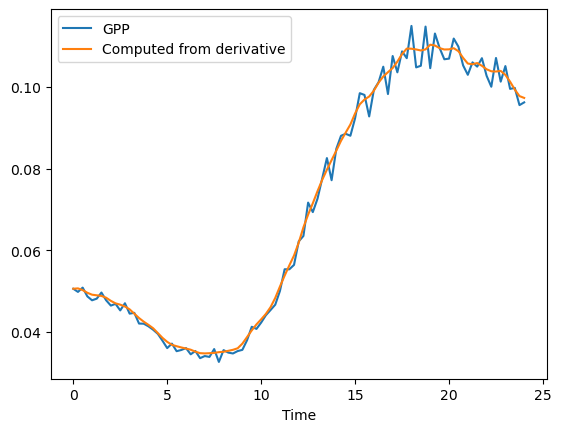

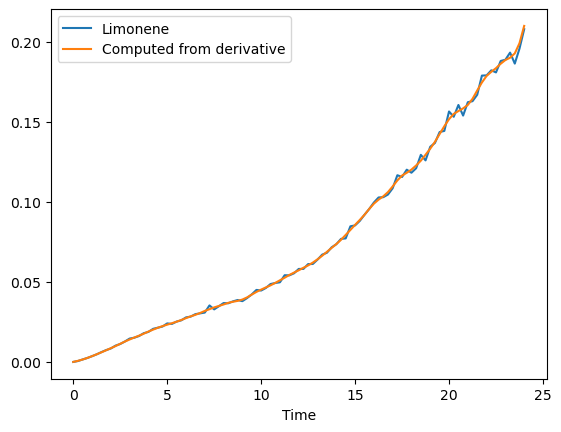

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   6.095775e+01  3.830916e+01  3.642460e+01  5.920951e+01   
         0.25   4.562280e+06  2.387218e+06  2.235850e+05  1.427086e+06   
         0.50   5.504432e+06  3.365541e+06  3.247253e+05  2.241663e+06   
         0.75   6.091505e+06  4.296528e+06  4.321469e+05  2.709233e+06   
         1.00   6.135963e+06  4.682593e+06  4.680041e+05  2.995600e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.798586e+06  2.781692e+06  1.783012e+06  2.035337e+06   
         23.25  2.728784e+06  2.650398e+06  1.720474e+06  2.059733e+06   
         23.50  2.660750e+06  2.644709e+06  1.715498e+06  2.021107e+06   
         23.75  2.849446e+06  2.810695e+06  1.740797e+06  2.018694e+06   
         24.00  2.896286e+06  2.699434e+06  1.767956e+06  2.029364e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.677443e+01  5.322851e+01  5.629791e+01  1.882676e+01   
         0.25   4.627639e+05  2.286100e+06  2.550127e+06  4.317176e+05   
         0.50   7.122424e+05  3.593802e+06  3.257557e+06  6.426762e+05   
         0.75   9.261810e+05  4.686807e+06  3.653431e+06  7.714662e+05   
         1.00   1.020998e+06  5.491013e+06  3.759702e+06  8.180992e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.536728e+06  4.151637e+06  4.284493e+06  1.165858e+06   
         23.25  1.471363e+06  3.997512e+06  4.218226e+06  1.274865e+06   
         23.50  1.436512e+06  3.889987e+06  4.419343e+06  1.271866e+06   
         23.75  1.486919e+06  3.867592e+06  4.201317e+06  1.255360e+06   
         24.00  1.501886e+06  3.974894e+06  4.319973e+06  1.191504e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.069984e+01   0.307507        0.192847  0.049264   
         0.25       1.833784e+05   0.309289        0.201424  0.057705   
         0.50       2.904854e+05   0.286885        0.190625  0.066920   
         0.75       3.394283e+05   0.291694        0.191152  0.078201   
         1.00       4.114768e+05   0.298805        0.173484  0.089942   
...                          ...        ...             ...       ...   
WT       23.00      1.457436e+06   0.742292        0.014403  0.020888   
         23.25      1.503237e+06   0.763702        0.015134  0.020904   
         23.50      1.553956e+06   0.793760        0.014674  0.021450   
         23.75      1.447999e+06   0.767065        0.014179  0.021926   
         24.00      1.515156e+06   0.788743        0.015025  0.021914   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.308261  0.020131  0.195401  0.010149  0.040297  0.050591   
         0.25   0.244626  0.069208  0.196183  0.009969  0.039843  0.050012   
         0.50   0.209178  0.100499  0.201384  0.009375  0.040831  0.051394   
         0.75   0.202394  0.122481  0.194301  0.008243  0.038721  0.049578   
         1.00   0.177280  0.140925  0.192049  0.007046  0.037078  0.048995   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.113564  0.101795  0.292376  0.013727  0.024601  0.105096   
         23.25  0.110077  0.099836  0.294256  0.014004  0.024972  0.099510   
         23.50  0.110256  0.096613  0.300041  0.013601  0.024665 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.057280        0.027446  0.030836 -0.242483  0.198600   
         0.25    -0.035640        0.003924  0.035789 -0.182080  0.158272   
         0.50    -0.013999       -0.019599  0.040741 -0.121677  0.117944   
         0.75    -0.033430       -0.031879  0.039818 -0.063644  0.075700   
         1.00    -0.020555       -0.033002  0.025346 -0.041214  0.051745   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.015434        0.000957  0.002109 -0.005818 -0.006921   
         23.25    0.006862       -0.000021  0.001710  0.000498 -0.006766   
         23.50    0.038506        0.000116  0.001229  0.002311 -0.004019   
         23.75    0.006381        0.000226  0.001157  0.006628  0.002778   
         24.00   -0.025744        0.000336  0.001084  0.010945  0.009576   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00   0.017539 -0.000234  0.003233  0.002212  0.001570  
         0.25   0.007052 -0.001704  0.000105  0.000381  0.001997  
         0.50  -0.003435 -0.003173 -0.003024 -0.001450  0.002423  
         0.75  -0.004780 -0.004159 -0.003858 -0.001099  0.002803  
         1.00   0.003966 -0.004187 -0.004091  0.000476  0.003101  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.005749 -0.000121  0.000588 -0.006573  0.006493  
         23.25  0.012220  0.000224 -0.000330 -0.006733  0.005205  
         23.50  0.003548 -0.000374 -0.001311 -0.008697  0.016276  
         23.75 -0.018269 -0.000987 -0.002130 -0.004092  0.034329  
         24.00 -0.040087 -0.001601 -0.002950  0.000513  0.052382  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
        
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'ISRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=10,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: ISRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 2.992657E+180 | 1.448059E+108
     2 |       74 | 3.476068E+115 |  3.285105E+94
     3 |      138 |  7.399550E+94 |  1.911576E+80
     4 |      202 |  7.904322E+86 |  9.922551E+72
     5 |      266 |  4.438383E+79 |  2.720677E+72
     6 |      330 |  1.033201E+71 |  2.864129E+54
     7 |      394 |  9.621789E+66 |  2.864129E+54
     8 |      458 |  2.041223E+64 |  4.559952E+46
     9 |      522 |  1.994148E+56 |  2.702103E+39
    10 |      586 |  8.074162E+51 |  6.606401E+35
    11 |      650 |  1.121099E+48 |  3.565318E+31
    12 |      714 |  9.944536E+41 |  1.868458E+30
    13 |      778 |  1.854332E+40 |  4.200338E+29
    14 |      842 |  6.114364E+39 |  4.200338E+29
    15 |      906 |  4.049108E+35 |  1.085867E+25
    16 |      970 |  8.264899E+36 |  9.607625E+23
    17 |     1034 |  3.624064E+32 |  9.607625E+23
    18 |     1098 |  2.384457E+29 |  7.669783E+16
    19 |     1162 |  5.67

   162 |    10314 |  3.100558E+01 |  2.907383E+01
   163 |    10378 |  3.065631E+01 |  2.907383E+01
   164 |    10442 |  3.096654E+01 |  2.907383E+01
   165 |    10506 |  3.044691E+01 |  2.907383E+01
   166 |    10570 |  3.040255E+01 |  2.907383E+01
   167 |    10634 |  3.111630E+01 |  2.907383E+01
   168 |    10698 |  3.025767E+01 |  2.907383E+01
   169 |    10762 |  2.987383E+01 |  2.907383E+01
   170 |    10826 |  2.937355E+01 |  2.843967E+01
   171 |    10890 |  2.985961E+01 |  2.843967E+01
   172 |    10954 |  2.933885E+01 |  2.841190E+01
   173 |    11018 |  2.965383E+01 |  2.841190E+01
   174 |    11082 |  2.909398E+01 |  2.773617E+01
   175 |    11146 |  2.951355E+01 |  2.773617E+01
   176 |    11210 |  2.991707E+01 |  2.773617E+01
   177 |    11274 |  2.940237E+01 |  2.773617E+01
   178 |    11338 |  2.973445E+01 |  2.773617E+01
   179 |    11402 |  2.928431E+01 |  2.773617E+01
   180 |    11466 |  2.945331E+01 |  2.773617E+01
   181 |    11530 |  2.956855E+01 |  2.773617E+01


   326 |    20810 |  2.361177E+01 |  2.250325E+01
   327 |    20874 |  2.354189E+01 |  2.250325E+01
   328 |    20938 |  2.358556E+01 |  2.250325E+01
   329 |    21002 |  2.375405E+01 |  2.250325E+01
   330 |    21066 |  2.367980E+01 |  2.250325E+01
   331 |    21130 |  2.397773E+01 |  2.250325E+01
   332 |    21194 |  2.385840E+01 |  2.250325E+01
   333 |    21258 |  2.360573E+01 |  2.250325E+01
   334 |    21322 |  2.355001E+01 |  2.250325E+01
   335 |    21386 |  2.344641E+01 |  2.250325E+01
   336 |    21450 |  2.327906E+01 |  2.250325E+01
   337 |    21514 |  2.319418E+01 |  2.250325E+01
   338 |    21578 |  2.313215E+01 |  2.250325E+01
   339 |    21642 |  2.308430E+01 |  2.250325E+01
   340 |    21706 |  2.305450E+01 |  2.250325E+01
   341 |    21770 |  2.290473E+01 |  2.221283E+01
   342 |    21834 |  2.303668E+01 |  2.221283E+01
   343 |    21898 |  2.306019E+01 |  2.221283E+01
   344 |    21962 |  2.308100E+01 |  2.221283E+01
   345 |    22026 |  2.293254E+01 |  2.221283E+01


   490 |    31306 |  2.090604E+01 |  2.086617E+01
   491 |    31370 |  2.091314E+01 |  2.086617E+01
   492 |    31434 |  2.090182E+01 |  2.086617E+01
   493 |    31498 |  2.089394E+01 |  2.086136E+01
   494 |    31562 |  2.088910E+01 |  2.086136E+01
   495 |    31626 |  2.088201E+01 |  2.086136E+01
   496 |    31690 |  2.087088E+01 |  2.085883E+01
   497 |    31754 |  2.086871E+01 |  2.085377E+01
   498 |    31818 |  2.086105E+01 |  2.085222E+01
   499 |    31882 |  2.085566E+01 |  2.084019E+01
   500 |    31946 |  2.084911E+01 |  2.084019E+01
   501 |    32010 |  2.084712E+01 |  2.083707E+01
   502 |    32074 |  2.084072E+01 |  2.083466E+01
   503 |    32138 |  2.083908E+01 |  2.083466E+01
   504 |    32202 |  2.084096E+01 |  2.082642E+01
   505 |    32266 |  2.083625E+01 |  2.082642E+01
   506 |    32330 |  2.083344E+01 |  2.082642E+01
   507 |    32394 |  2.083005E+01 |  2.082642E+01
   508 |    32458 |  2.083183E+01 |  2.082615E+01
   509 |    32522 |  2.082754E+01 |  2.082271E+01


   654 |    41802 |  2.057823E+01 |  2.057006E+01
   655 |    41866 |  2.057129E+01 |  2.056715E+01
   656 |    41930 |  2.057179E+01 |  2.056715E+01
   657 |    41994 |  2.056607E+01 |  2.052169E+01
   658 |    42058 |  2.052913E+01 |  2.046716E+01
   659 |    42122 |  2.048078E+01 |  2.045187E+01
   660 |    42186 |  2.047876E+01 |  2.044905E+01
   661 |    42250 |  2.047415E+01 |  2.044905E+01
   662 |    42314 |  2.046504E+01 |  2.044200E+01
   663 |    42378 |  2.046469E+01 |  2.044200E+01
   664 |    42442 |  2.046955E+01 |  2.044200E+01
   665 |    42506 |  2.047642E+01 |  2.044200E+01
   666 |    42570 |  2.047815E+01 |  2.044200E+01
   667 |    42634 |  2.047504E+01 |  2.044200E+01
   668 |    42698 |  2.048183E+01 |  2.044200E+01
   669 |    42762 |  2.046168E+01 |  2.044200E+01
   670 |    42826 |  2.045712E+01 |  2.044200E+01
   671 |    42890 |  2.046169E+01 |  2.044200E+01
   672 |    42954 |  2.045463E+01 |  2.044200E+01
   673 |    43018 |  2.045479E+01 |  2.044015E+01


   818 |    52298 |  2.010456E+01 |  2.010153E+01
   819 |    52362 |  2.010219E+01 |  2.010022E+01
   820 |    52426 |  2.010275E+01 |  2.009942E+01
   821 |    52490 |  2.009923E+01 |  2.009446E+01
   822 |    52554 |  2.009592E+01 |  2.008686E+01
   823 |    52618 |  2.009171E+01 |  2.008686E+01
   824 |    52682 |  2.008733E+01 |  2.008188E+01
   825 |    52746 |  2.008541E+01 |  2.008001E+01
   826 |    52810 |  2.008173E+01 |  2.007589E+01
   827 |    52874 |  2.007924E+01 |  2.007582E+01
   828 |    52938 |  2.007886E+01 |  2.007582E+01
   829 |    53002 |  2.007738E+01 |  2.007193E+01
   830 |    53066 |  2.007629E+01 |  2.007193E+01
   831 |    53130 |  2.007664E+01 |  2.006797E+01
   832 |    53194 |  2.007441E+01 |  2.006797E+01
   833 |    53258 |  2.006791E+01 |  2.006156E+01
   834 |    53322 |  2.006563E+01 |  2.005945E+01
   835 |    53386 |  2.006527E+01 |  2.005945E+01
   836 |    53450 |  2.006466E+01 |  2.005945E+01
   837 |    53514 |  2.006244E+01 |  2.005945E+01


   982 |    62794 |  1.970825E+01 |  1.970294E+01
   983 |    62858 |  1.970408E+01 |  1.970063E+01
   984 |    62922 |  1.968884E+01 |  1.960001E+01
   985 |    62986 |  1.966025E+01 |  1.957260E+01
   986 |    63050 |  1.960483E+01 |  1.955418E+01
   987 |    63114 |  1.961048E+01 |  1.955418E+01
   988 |    63178 |  1.961475E+01 |  1.955312E+01
   989 |    63242 |  1.959870E+01 |  1.955312E+01
   990 |    63306 |  1.963250E+01 |  1.955312E+01
   991 |    63370 |  1.960229E+01 |  1.955312E+01
   992 |    63434 |  1.960095E+01 |  1.955312E+01
   993 |    63498 |  1.960910E+01 |  1.955312E+01
   994 |    63562 |  1.960908E+01 |  1.955312E+01
   995 |    63626 |  1.962422E+01 |  1.955312E+01
   996 |    63690 |  1.960520E+01 |  1.954302E+01
   997 |    63754 |  1.960286E+01 |  1.953461E+01
   998 |    63818 |  1.956300E+01 |  1.953174E+01
   999 |    63882 |  1.956468E+01 |  1.953174E+01
  1000 |    63946 |  1.956103E+01 |  1.953174E+01
  1001 |    64010 |  1.954705E+01 |  1.950763E+01


  1146 |    73290 |  1.898139E+01 |  1.897323E+01
  1147 |    73354 |  1.897899E+01 |  1.897323E+01
  1148 |    73418 |  1.898068E+01 |  1.897323E+01
  1149 |    73482 |  1.898296E+01 |  1.897213E+01
  1150 |    73546 |  1.897883E+01 |  1.897184E+01
  1151 |    73610 |  1.897980E+01 |  1.896673E+01
  1152 |    73674 |  1.897561E+01 |  1.896302E+01
  1153 |    73738 |  1.897448E+01 |  1.896302E+01
  1154 |    73802 |  1.897371E+01 |  1.896302E+01
  1155 |    73866 |  1.897164E+01 |  1.896302E+01
  1156 |    73930 |  1.897107E+01 |  1.896302E+01
  1157 |    73994 |  1.896740E+01 |  1.896302E+01
  1158 |    74058 |  1.896858E+01 |  1.896302E+01
  1159 |    74122 |  1.897137E+01 |  1.896302E+01
  1160 |    74186 |  1.896784E+01 |  1.896046E+01
  1161 |    74250 |  1.896947E+01 |  1.896012E+01
  1162 |    74314 |  1.896736E+01 |  1.896012E+01
  1163 |    74378 |  1.896362E+01 |  1.895759E+01
  1164 |    74442 |  1.896260E+01 |  1.895718E+01
  1165 |    74506 |  1.895676E+01 |  1.894692E+01


  1310 |    83786 |  1.883704E+01 |  1.883590E+01
  1311 |    83850 |  1.883625E+01 |  1.883530E+01
  1312 |    83914 |  1.883664E+01 |  1.883530E+01
  1313 |    83978 |  1.883593E+01 |  1.883426E+01
  1314 |    84042 |  1.883487E+01 |  1.883373E+01
  1315 |    84106 |  1.883413E+01 |  1.883265E+01
  1316 |    84170 |  1.883310E+01 |  1.883165E+01
  1317 |    84234 |  1.883222E+01 |  1.883073E+01
  1318 |    84298 |  1.883179E+01 |  1.882991E+01
  1319 |    84362 |  1.883130E+01 |  1.882876E+01
  1320 |    84426 |  1.883026E+01 |  1.882874E+01
  1321 |    84490 |  1.882937E+01 |  1.882840E+01
  1322 |    84554 |  1.882935E+01 |  1.882784E+01
  1323 |    84618 |  1.882911E+01 |  1.882745E+01
  1324 |    84682 |  1.882909E+01 |  1.882745E+01
  1325 |    84746 |  1.882855E+01 |  1.882583E+01
  1326 |    84810 |  1.882736E+01 |  1.882458E+01
  1327 |    84874 |  1.882717E+01 |  1.882411E+01
  1328 |    84938 |  1.882655E+01 |  1.882411E+01
  1329 |    85002 |  1.882531E+01 |  1.882271E+01


  1474 |    94282 |  1.871924E+01 |  1.871764E+01
  1475 |    94346 |  1.871792E+01 |  1.871645E+01
  1476 |    94410 |  1.871609E+01 |  1.871521E+01
  1477 |    94474 |  1.871447E+01 |  1.871383E+01
  1478 |    94538 |  1.871323E+01 |  1.871125E+01
  1479 |    94602 |  1.871130E+01 |  1.870972E+01
  1480 |    94666 |  1.870990E+01 |  1.870823E+01
  1481 |    94730 |  1.870889E+01 |  1.870800E+01
  1482 |    94794 |  1.870726E+01 |  1.870554E+01
  1483 |    94858 |  1.870656E+01 |  1.870554E+01
  1484 |    94922 |  1.870517E+01 |  1.870362E+01
  1485 |    94986 |  1.870391E+01 |  1.870000E+01
  1486 |    95050 |  1.870192E+01 |  1.869900E+01
  1487 |    95114 |  1.870049E+01 |  1.869824E+01
  1488 |    95178 |  1.869880E+01 |  1.869436E+01
  1489 |    95242 |  1.869687E+01 |  1.869280E+01
  1490 |    95306 |  1.869590E+01 |  1.869176E+01
  1491 |    95370 |  1.869349E+01 |  1.869012E+01
  1492 |    95434 |  1.869252E+01 |  1.868993E+01
  1493 |    95498 |  1.869129E+01 |  1.868825E+01


  1638 |   104778 |  1.835188E+01 |  1.834719E+01
  1639 |   104842 |  1.834760E+01 |  1.834388E+01
  1640 |   104906 |  1.834435E+01 |  1.833817E+01
  1641 |   104970 |  1.834279E+01 |  1.833813E+01
  1642 |   105034 |  1.833960E+01 |  1.833310E+01
  1643 |   105098 |  1.833718E+01 |  1.833190E+01
  1644 |   105162 |  1.833465E+01 |  1.832966E+01
  1645 |   105226 |  1.833253E+01 |  1.832648E+01
  1646 |   105290 |  1.832772E+01 |  1.831649E+01
  1647 |   105354 |  1.832233E+01 |  1.831441E+01
  1648 |   105418 |  1.831820E+01 |  1.831369E+01
  1649 |   105482 |  1.831405E+01 |  1.830854E+01
  1650 |   105546 |  1.831178E+01 |  1.829958E+01
  1651 |   105610 |  1.830690E+01 |  1.829958E+01
  1652 |   105674 |  1.830652E+01 |  1.829786E+01
  1653 |   105738 |  1.830419E+01 |  1.829626E+01
  1654 |   105802 |  1.829744E+01 |  1.829273E+01
  1655 |   105866 |  1.829791E+01 |  1.829273E+01
  1656 |   105930 |  1.829705E+01 |  1.829223E+01
  1657 |   105994 |  1.829456E+01 |  1.828706E+01


  1802 |   115274 |  1.787673E+01 |  1.787069E+01
  1803 |   115338 |  1.787627E+01 |  1.787069E+01
  1804 |   115402 |  1.787440E+01 |  1.786928E+01
  1805 |   115466 |  1.787437E+01 |  1.786109E+01
  1806 |   115530 |  1.786985E+01 |  1.786109E+01
  1807 |   115594 |  1.786663E+01 |  1.786109E+01
  1808 |   115658 |  1.786480E+01 |  1.785350E+01
  1809 |   115722 |  1.785999E+01 |  1.785127E+01
  1810 |   115786 |  1.785724E+01 |  1.785127E+01
  1811 |   115850 |  1.785590E+01 |  1.784862E+01
  1812 |   115914 |  1.785277E+01 |  1.784862E+01
  1813 |   115978 |  1.785304E+01 |  1.784862E+01
  1814 |   116042 |  1.785241E+01 |  1.784658E+01
  1815 |   116106 |  1.785047E+01 |  1.784551E+01
  1816 |   116170 |  1.784844E+01 |  1.784551E+01
  1817 |   116234 |  1.784892E+01 |  1.784316E+01
  1818 |   116298 |  1.784648E+01 |  1.784316E+01
  1819 |   116362 |  1.784540E+01 |  1.784161E+01
  1820 |   116426 |  1.784392E+01 |  1.784019E+01
  1821 |   116490 |  1.784161E+01 |  1.783890E+01


  1966 |   125770 |  1.748003E+01 |  1.747769E+01
  1967 |   125834 |  1.747832E+01 |  1.747680E+01
  1968 |   125898 |  1.747608E+01 |  1.747135E+01
  1969 |   125962 |  1.747273E+01 |  1.747102E+01
  1970 |   126026 |  1.747157E+01 |  1.746909E+01
  1971 |   126090 |  1.747063E+01 |  1.746909E+01
  1972 |   126154 |  1.746916E+01 |  1.746524E+01
  1973 |   126218 |  1.746706E+01 |  1.746436E+01
  1974 |   126282 |  1.746514E+01 |  1.746212E+01
  1975 |   126346 |  1.746336E+01 |  1.745956E+01
  1976 |   126410 |  1.746033E+01 |  1.745894E+01
  1977 |   126474 |  1.745965E+01 |  1.745665E+01
  1978 |   126538 |  1.745797E+01 |  1.745294E+01
  1979 |   126602 |  1.745435E+01 |  1.744997E+01
  1980 |   126666 |  1.745136E+01 |  1.744907E+01
  1981 |   126730 |  1.745059E+01 |  1.744778E+01
  1982 |   126794 |  1.744779E+01 |  1.744193E+01
  1983 |   126858 |  1.744530E+01 |  1.744193E+01
  1984 |   126922 |  1.744454E+01 |  1.744084E+01
  1985 |   126986 |  1.744275E+01 |  1.744084E+01


  2130 |   136266 |  1.724421E+01 |  1.724180E+01
  2131 |   136330 |  1.724324E+01 |  1.724180E+01
  2132 |   136394 |  1.724353E+01 |  1.724180E+01
  2133 |   136458 |  1.724317E+01 |  1.724154E+01
  2134 |   136522 |  1.724266E+01 |  1.724108E+01
  2135 |   136586 |  1.724282E+01 |  1.724108E+01
  2136 |   136650 |  1.724254E+01 |  1.724108E+01
  2137 |   136714 |  1.724210E+01 |  1.723901E+01
  2138 |   136778 |  1.724130E+01 |  1.723895E+01
  2139 |   136842 |  1.724094E+01 |  1.723895E+01
  2140 |   136906 |  1.724075E+01 |  1.723895E+01
  2141 |   136970 |  1.723943E+01 |  1.723640E+01
  2142 |   137034 |  1.723765E+01 |  1.723640E+01
  2143 |   137098 |  1.723716E+01 |  1.723525E+01
  2144 |   137162 |  1.723714E+01 |  1.723483E+01
  2145 |   137226 |  1.723609E+01 |  1.723310E+01
  2146 |   137290 |  1.723557E+01 |  1.723310E+01
  2147 |   137354 |  1.723486E+01 |  1.723310E+01
  2148 |   137418 |  1.723407E+01 |  1.723273E+01
  2149 |   137482 |  1.723289E+01 |  1.723130E+01


  2294 |   146762 |  1.715526E+01 |  1.715480E+01
  2295 |   146826 |  1.715481E+01 |  1.715411E+01
  2296 |   146890 |  1.715421E+01 |  1.715363E+01
  2297 |   146954 |  1.715415E+01 |  1.715285E+01
  2298 |   147018 |  1.715327E+01 |  1.715262E+01
  2299 |   147082 |  1.715305E+01 |  1.715262E+01
  2300 |   147146 |  1.715270E+01 |  1.715242E+01
  2301 |   147210 |  1.715238E+01 |  1.715168E+01
  2302 |   147274 |  1.715192E+01 |  1.715129E+01
  2303 |   147338 |  1.715147E+01 |  1.715100E+01
  2304 |   147402 |  1.715118E+01 |  1.715092E+01
  2305 |   147466 |  1.715080E+01 |  1.714992E+01
  2306 |   147530 |  1.715040E+01 |  1.714987E+01
  2307 |   147594 |  1.715007E+01 |  1.714962E+01
  2308 |   147658 |  1.714971E+01 |  1.714906E+01
  2309 |   147722 |  1.714916E+01 |  1.714866E+01
  2310 |   147786 |  1.714896E+01 |  1.714849E+01
  2311 |   147850 |  1.714833E+01 |  1.714790E+01
  2312 |   147914 |  1.714793E+01 |  1.714763E+01
  2313 |   147978 |  1.714784E+01 |  1.714752E+01


  2458 |   157258 |  1.685864E+01 |  1.685637E+01
  2459 |   157322 |  1.685929E+01 |  1.685637E+01
  2460 |   157386 |  1.685804E+01 |  1.685126E+01
  2461 |   157450 |  1.685623E+01 |  1.685126E+01
  2462 |   157514 |  1.685611E+01 |  1.685126E+01
  2463 |   157578 |  1.685185E+01 |  1.684260E+01
  2464 |   157642 |  1.684948E+01 |  1.684260E+01
  2465 |   157706 |  1.684818E+01 |  1.684260E+01
  2466 |   157770 |  1.684551E+01 |  1.683785E+01
  2467 |   157834 |  1.684056E+01 |  1.683193E+01
  2468 |   157898 |  1.683418E+01 |  1.682760E+01
  2469 |   157962 |  1.683207E+01 |  1.682760E+01
  2470 |   158026 |  1.683269E+01 |  1.682459E+01
  2471 |   158090 |  1.682589E+01 |  1.682203E+01
  2472 |   158154 |  1.682664E+01 |  1.681901E+01
  2473 |   158218 |  1.682755E+01 |  1.681829E+01
  2474 |   158282 |  1.682353E+01 |  1.681653E+01
  2475 |   158346 |  1.681896E+01 |  1.681409E+01
  2476 |   158410 |  1.681913E+01 |  1.681409E+01
  2477 |   158474 |  1.681953E+01 |  1.681368E+01


  2622 |   167754 |  1.595065E+01 |  1.593285E+01
  2623 |   167818 |  1.593283E+01 |  1.591216E+01
  2624 |   167882 |  1.592489E+01 |  1.591106E+01
  2625 |   167946 |  1.592281E+01 |  1.591106E+01
  2626 |   168010 |  1.591458E+01 |  1.589499E+01
  2627 |   168074 |  1.590141E+01 |  1.586980E+01
  2628 |   168138 |  1.588805E+01 |  1.586980E+01
  2629 |   168202 |  1.587844E+01 |  1.585663E+01
  2630 |   168266 |  1.587208E+01 |  1.585440E+01
  2631 |   168330 |  1.586777E+01 |  1.585044E+01
  2632 |   168394 |  1.585935E+01 |  1.584751E+01
  2633 |   168458 |  1.585385E+01 |  1.583553E+01
  2634 |   168522 |  1.584512E+01 |  1.582844E+01
  2635 |   168586 |  1.583499E+01 |  1.581836E+01
  2636 |   168650 |  1.583365E+01 |  1.581836E+01
  2637 |   168714 |  1.582280E+01 |  1.580657E+01
  2638 |   168778 |  1.582125E+01 |  1.580657E+01
  2639 |   168842 |  1.582018E+01 |  1.580594E+01
  2640 |   168906 |  1.581642E+01 |  1.580249E+01
  2641 |   168970 |  1.581247E+01 |  1.580249E+01


  2786 |   178250 |  1.391921E+01 |  1.388739E+01
  2787 |   178314 |  1.390779E+01 |  1.386038E+01
  2788 |   178378 |  1.389272E+01 |  1.385044E+01
  2789 |   178442 |  1.386348E+01 |  1.383609E+01
  2790 |   178506 |  1.384759E+01 |  1.381171E+01
  2791 |   178570 |  1.384210E+01 |  1.381171E+01
  2792 |   178634 |  1.383334E+01 |  1.381171E+01
  2793 |   178698 |  1.383021E+01 |  1.381171E+01
  2794 |   178762 |  1.382872E+01 |  1.380606E+01
  2795 |   178826 |  1.381576E+01 |  1.380360E+01
  2796 |   178890 |  1.380582E+01 |  1.378205E+01
  2797 |   178954 |  1.380264E+01 |  1.378189E+01
  2798 |   179018 |  1.378169E+01 |  1.374322E+01
  2799 |   179082 |  1.374739E+01 |  1.370522E+01
  2800 |   179146 |  1.372845E+01 |  1.370522E+01
  2801 |   179210 |  1.371713E+01 |  1.370074E+01
  2802 |   179274 |  1.370768E+01 |  1.368691E+01
  2803 |   179338 |  1.369172E+01 |  1.366785E+01
  2804 |   179402 |  1.368052E+01 |  1.365054E+01
  2805 |   179466 |  1.365059E+01 |  1.356587E+01


  2950 |   188746 |  1.238008E+01 |  1.236742E+01
  2951 |   188810 |  1.238194E+01 |  1.236742E+01
  2952 |   188874 |  1.237615E+01 |  1.236742E+01
  2953 |   188938 |  1.237507E+01 |  1.236742E+01
  2954 |   189002 |  1.237039E+01 |  1.236287E+01
  2955 |   189066 |  1.236592E+01 |  1.235976E+01
  2956 |   189130 |  1.236787E+01 |  1.235976E+01
  2957 |   189194 |  1.236922E+01 |  1.235903E+01
  2958 |   189258 |  1.236864E+01 |  1.235903E+01
  2959 |   189322 |  1.236110E+01 |  1.235543E+01
  2960 |   189386 |  1.235927E+01 |  1.235543E+01
  2961 |   189450 |  1.235760E+01 |  1.235414E+01
  2962 |   189514 |  1.235524E+01 |  1.234643E+01
  2963 |   189578 |  1.235240E+01 |  1.234643E+01
  2964 |   189642 |  1.235108E+01 |  1.234643E+01
  2965 |   189706 |  1.234883E+01 |  1.234488E+01
  2966 |   189770 |  1.234689E+01 |  1.234462E+01
  2967 |   189834 |  1.234793E+01 |  1.234449E+01
  2968 |   189898 |  1.234639E+01 |  1.234247E+01
  2969 |   189962 |  1.234299E+01 |  1.233110E+01


  3114 |   199242 |  1.214044E+01 |  1.213917E+01
  3115 |   199306 |  1.213970E+01 |  1.213917E+01
  3116 |   199370 |  1.213906E+01 |  1.213776E+01
  3117 |   199434 |  1.213898E+01 |  1.213744E+01
  3118 |   199498 |  1.213827E+01 |  1.213646E+01
  3119 |   199562 |  1.213725E+01 |  1.213451E+01
  3120 |   199626 |  1.213624E+01 |  1.213363E+01
  3121 |   199690 |  1.213535E+01 |  1.213284E+01
  3122 |   199754 |  1.213480E+01 |  1.213284E+01
  3123 |   199818 |  1.213434E+01 |  1.213254E+01
  3124 |   199882 |  1.213389E+01 |  1.213254E+01
  3125 |   199946 |  1.213366E+01 |  1.213254E+01
  3126 |   200010 |  1.213366E+01 |  1.213254E+01
  3127 |   200074 |  1.213223E+01 |  1.213172E+01
  3128 |   200138 |  1.213204E+01 |  1.213112E+01
  3129 |   200202 |  1.213177E+01 |  1.213064E+01
  3130 |   200266 |  1.213118E+01 |  1.213001E+01
  3131 |   200330 |  1.213076E+01 |  1.213001E+01
  3132 |   200394 |  1.213016E+01 |  1.212884E+01
  3133 |   200458 |  1.212987E+01 |  1.212790E+01


  3278 |   209738 |  1.183983E+01 |  1.183710E+01
  3279 |   209802 |  1.183735E+01 |  1.183127E+01
  3280 |   209866 |  1.183560E+01 |  1.182985E+01
  3281 |   209930 |  1.183343E+01 |  1.182985E+01
  3282 |   209994 |  1.183326E+01 |  1.182857E+01
  3283 |   210058 |  1.183099E+01 |  1.182531E+01
  3284 |   210122 |  1.183197E+01 |  1.182469E+01
  3285 |   210186 |  1.183211E+01 |  1.182469E+01
  3286 |   210250 |  1.182824E+01 |  1.182012E+01
  3287 |   210314 |  1.182529E+01 |  1.181682E+01
  3288 |   210378 |  1.182223E+01 |  1.181674E+01
  3289 |   210442 |  1.181954E+01 |  1.181386E+01
  3290 |   210506 |  1.181633E+01 |  1.180947E+01
  3291 |   210570 |  1.181265E+01 |  1.180903E+01
  3292 |   210634 |  1.181130E+01 |  1.180401E+01
  3293 |   210698 |  1.180981E+01 |  1.180318E+01
  3294 |   210762 |  1.180541E+01 |  1.180164E+01
  3295 |   210826 |  1.180485E+01 |  1.180164E+01
  3296 |   210890 |  1.180317E+01 |  1.179721E+01
  3297 |   210954 |  1.180093E+01 |  1.179601E+01


  3442 |   220234 |  1.160516E+01 |  1.160297E+01
  3443 |   220298 |  1.160424E+01 |  1.160282E+01
  3444 |   220362 |  1.160378E+01 |  1.160213E+01
  3445 |   220426 |  1.160302E+01 |  1.160210E+01
  3446 |   220490 |  1.160403E+01 |  1.160181E+01
  3447 |   220554 |  1.160361E+01 |  1.160181E+01
  3448 |   220618 |  1.160355E+01 |  1.160181E+01
  3449 |   220682 |  1.160332E+01 |  1.160181E+01
  3450 |   220746 |  1.160259E+01 |  1.160074E+01
  3451 |   220810 |  1.160270E+01 |  1.160074E+01
  3452 |   220874 |  1.160218E+01 |  1.160033E+01
  3453 |   220938 |  1.160097E+01 |  1.159889E+01
  3454 |   221002 |  1.160072E+01 |  1.159889E+01
  3455 |   221066 |  1.160082E+01 |  1.159889E+01
  3456 |   221130 |  1.160144E+01 |  1.159889E+01
  3457 |   221194 |  1.160102E+01 |  1.159806E+01
  3458 |   221258 |  1.160116E+01 |  1.159776E+01
  3459 |   221322 |  1.160047E+01 |  1.159776E+01
  3460 |   221386 |  1.160062E+01 |  1.159776E+01
  3461 |   221450 |  1.160005E+01 |  1.159776E+01


  3606 |   230730 |  1.156761E+01 |  1.156690E+01
  3607 |   230794 |  1.156717E+01 |  1.156629E+01
  3608 |   230858 |  1.156668E+01 |  1.156562E+01
  3609 |   230922 |  1.156616E+01 |  1.156562E+01
  3610 |   230986 |  1.156619E+01 |  1.156562E+01
  3611 |   231050 |  1.156604E+01 |  1.156495E+01
  3612 |   231114 |  1.156574E+01 |  1.156492E+01
  3613 |   231178 |  1.156593E+01 |  1.156492E+01
  3614 |   231242 |  1.156543E+01 |  1.156444E+01
  3615 |   231306 |  1.156509E+01 |  1.156444E+01
  3616 |   231370 |  1.156495E+01 |  1.156396E+01
  3617 |   231434 |  1.156463E+01 |  1.156375E+01
  3618 |   231498 |  1.156407E+01 |  1.156327E+01
  3619 |   231562 |  1.156358E+01 |  1.156288E+01
  3620 |   231626 |  1.156325E+01 |  1.156252E+01
  3621 |   231690 |  1.156287E+01 |  1.156200E+01
  3622 |   231754 |  1.156252E+01 |  1.156170E+01
  3623 |   231818 |  1.156240E+01 |  1.156170E+01
  3624 |   231882 |  1.156191E+01 |  1.156149E+01
  3625 |   231946 |  1.156170E+01 |  1.156089E+01


  3770 |   241226 |  1.150019E+01 |  1.149872E+01
  3771 |   241290 |  1.149939E+01 |  1.149847E+01
  3772 |   241354 |  1.149888E+01 |  1.149808E+01
  3773 |   241418 |  1.149838E+01 |  1.149788E+01
  3774 |   241482 |  1.149830E+01 |  1.149767E+01
  3775 |   241546 |  1.149781E+01 |  1.149732E+01
  3776 |   241610 |  1.149747E+01 |  1.149679E+01
  3777 |   241674 |  1.149695E+01 |  1.149663E+01
  3778 |   241738 |  1.149751E+01 |  1.149663E+01
  3779 |   241802 |  1.149727E+01 |  1.149646E+01
  3780 |   241866 |  1.149677E+01 |  1.149592E+01
  3781 |   241930 |  1.149627E+01 |  1.149577E+01
  3782 |   241994 |  1.149573E+01 |  1.149506E+01
  3783 |   242058 |  1.149541E+01 |  1.149428E+01
  3784 |   242122 |  1.149450E+01 |  1.149293E+01
  3785 |   242186 |  1.149372E+01 |  1.149293E+01
  3786 |   242250 |  1.149348E+01 |  1.149233E+01
  3787 |   242314 |  1.149268E+01 |  1.149174E+01
  3788 |   242378 |  1.149222E+01 |  1.149171E+01
  3789 |   242442 |  1.149174E+01 |  1.149063E+01


  3934 |   251722 |  1.141240E+01 |  1.141195E+01
  3935 |   251786 |  1.141216E+01 |  1.141089E+01
  3936 |   251850 |  1.141102E+01 |  1.141045E+01
  3937 |   251914 |  1.141059E+01 |  1.141002E+01
  3938 |   251978 |  1.141040E+01 |  1.140949E+01
  3939 |   252042 |  1.140999E+01 |  1.140879E+01
  3940 |   252106 |  1.140946E+01 |  1.140749E+01
  3941 |   252170 |  1.140850E+01 |  1.140749E+01
  3942 |   252234 |  1.140838E+01 |  1.140698E+01
  3943 |   252298 |  1.140823E+01 |  1.140698E+01
  3944 |   252362 |  1.140862E+01 |  1.140698E+01
  3945 |   252426 |  1.140822E+01 |  1.140698E+01
  3946 |   252490 |  1.140781E+01 |  1.140625E+01
  3947 |   252554 |  1.140729E+01 |  1.140559E+01
  3948 |   252618 |  1.140679E+01 |  1.140541E+01
  3949 |   252682 |  1.140637E+01 |  1.140541E+01
  3950 |   252746 |  1.140595E+01 |  1.140541E+01
  3951 |   252810 |  1.140616E+01 |  1.140541E+01
  3952 |   252874 |  1.140560E+01 |  1.140432E+01
  3953 |   252938 |  1.140520E+01 |  1.140427E+01


  4098 |   262218 |  1.135364E+01 |  1.135326E+01
  4099 |   262282 |  1.135336E+01 |  1.135255E+01
  4100 |   262346 |  1.135285E+01 |  1.135221E+01
  4101 |   262410 |  1.135262E+01 |  1.135213E+01
  4102 |   262474 |  1.135224E+01 |  1.135165E+01
  4103 |   262538 |  1.135231E+01 |  1.135165E+01
  4104 |   262602 |  1.135211E+01 |  1.135165E+01
  4105 |   262666 |  1.135165E+01 |  1.135077E+01
  4106 |   262730 |  1.135152E+01 |  1.135023E+01
  4107 |   262794 |  1.135101E+01 |  1.135023E+01
  4108 |   262858 |  1.135065E+01 |  1.135023E+01
  4109 |   262922 |  1.135020E+01 |  1.134947E+01
  4110 |   262986 |  1.134996E+01 |  1.134942E+01
  4111 |   263050 |  1.134928E+01 |  1.134865E+01
  4112 |   263114 |  1.134909E+01 |  1.134860E+01
  4113 |   263178 |  1.134891E+01 |  1.134801E+01
  4114 |   263242 |  1.134857E+01 |  1.134765E+01
  4115 |   263306 |  1.134831E+01 |  1.134752E+01
  4116 |   263370 |  1.134762E+01 |  1.134714E+01
  4117 |   263434 |  1.134737E+01 |  1.134667E+01


  4262 |   272714 |  1.130041E+01 |  1.129924E+01
  4263 |   272778 |  1.129988E+01 |  1.129924E+01
  4264 |   272842 |  1.129938E+01 |  1.129838E+01
  4265 |   272906 |  1.129832E+01 |  1.129779E+01
  4266 |   272970 |  1.129796E+01 |  1.129759E+01
  4267 |   273034 |  1.129732E+01 |  1.129618E+01
  4268 |   273098 |  1.129671E+01 |  1.129604E+01
  4269 |   273162 |  1.129651E+01 |  1.129591E+01
  4270 |   273226 |  1.129613E+01 |  1.129536E+01
  4271 |   273290 |  1.129563E+01 |  1.129503E+01
  4272 |   273354 |  1.129489E+01 |  1.129380E+01
  4273 |   273418 |  1.129437E+01 |  1.129364E+01
  4274 |   273482 |  1.129380E+01 |  1.129291E+01
  4275 |   273546 |  1.129309E+01 |  1.129231E+01
  4276 |   273610 |  1.129251E+01 |  1.129172E+01
  4277 |   273674 |  1.129206E+01 |  1.129126E+01
  4278 |   273738 |  1.129190E+01 |  1.129126E+01
  4279 |   273802 |  1.129149E+01 |  1.129101E+01
  4280 |   273866 |  1.129093E+01 |  1.129047E+01
  4281 |   273930 |  1.129058E+01 |  1.128884E+01


  4426 |   283210 |  1.119558E+01 |  1.119433E+01
  4427 |   283274 |  1.119494E+01 |  1.119427E+01
  4428 |   283338 |  1.119419E+01 |  1.119351E+01
  4429 |   283402 |  1.119380E+01 |  1.119343E+01
  4430 |   283466 |  1.119382E+01 |  1.119262E+01
  4431 |   283530 |  1.119343E+01 |  1.119240E+01
  4432 |   283594 |  1.119295E+01 |  1.119178E+01
  4433 |   283658 |  1.119252E+01 |  1.119172E+01
  4434 |   283722 |  1.119194E+01 |  1.119153E+01
  4435 |   283786 |  1.119197E+01 |  1.119067E+01
  4436 |   283850 |  1.119124E+01 |  1.119009E+01
  4437 |   283914 |  1.119005E+01 |  1.118942E+01
  4438 |   283978 |  1.118995E+01 |  1.118922E+01
  4439 |   284042 |  1.118964E+01 |  1.118890E+01
  4440 |   284106 |  1.118846E+01 |  1.118690E+01
  4441 |   284170 |  1.118764E+01 |  1.118572E+01
  4442 |   284234 |  1.118600E+01 |  1.118466E+01
  4443 |   284298 |  1.118560E+01 |  1.118416E+01
  4444 |   284362 |  1.118479E+01 |  1.118224E+01
  4445 |   284426 |  1.118308E+01 |  1.118070E+01


  4590 |   293706 |  1.111889E+01 |  1.111781E+01
  4591 |   293770 |  1.111836E+01 |  1.111741E+01
  4592 |   293834 |  1.111825E+01 |  1.111735E+01
  4593 |   293898 |  1.111836E+01 |  1.111735E+01
  4594 |   293962 |  1.111813E+01 |  1.111735E+01
  4595 |   294026 |  1.111829E+01 |  1.111735E+01
  4596 |   294090 |  1.111792E+01 |  1.111723E+01
  4597 |   294154 |  1.111790E+01 |  1.111718E+01
  4598 |   294218 |  1.111781E+01 |  1.111718E+01
  4599 |   294282 |  1.111776E+01 |  1.111718E+01
  4600 |   294346 |  1.111780E+01 |  1.111678E+01
  4601 |   294410 |  1.111791E+01 |  1.111678E+01
  4602 |   294474 |  1.111782E+01 |  1.111634E+01
  4603 |   294538 |  1.111736E+01 |  1.111609E+01
  4604 |   294602 |  1.111655E+01 |  1.111550E+01
  4605 |   294666 |  1.111583E+01 |  1.111458E+01
  4606 |   294730 |  1.111547E+01 |  1.111458E+01
  4607 |   294794 |  1.111541E+01 |  1.111433E+01
  4608 |   294858 |  1.111541E+01 |  1.111384E+01
  4609 |   294922 |  1.111484E+01 |  1.111371E+01


  4754 |   304202 |  1.105839E+01 |  1.105757E+01
  4755 |   304266 |  1.105812E+01 |  1.105749E+01
  4756 |   304330 |  1.105790E+01 |  1.105716E+01
  4757 |   304394 |  1.105769E+01 |  1.105714E+01
  4758 |   304458 |  1.105740E+01 |  1.105708E+01
  4759 |   304522 |  1.105724E+01 |  1.105657E+01
  4760 |   304586 |  1.105713E+01 |  1.105650E+01
  4761 |   304650 |  1.105700E+01 |  1.105650E+01
  4762 |   304714 |  1.105708E+01 |  1.105650E+01
  4763 |   304778 |  1.105659E+01 |  1.105600E+01
  4764 |   304842 |  1.105644E+01 |  1.105528E+01
  4765 |   304906 |  1.105609E+01 |  1.105528E+01
  4766 |   304970 |  1.105567E+01 |  1.105505E+01
  4767 |   305034 |  1.105552E+01 |  1.105505E+01
  4768 |   305098 |  1.105527E+01 |  1.105440E+01
  4769 |   305162 |  1.105472E+01 |  1.105401E+01
  4770 |   305226 |  1.105437E+01 |  1.105380E+01
  4771 |   305290 |  1.105395E+01 |  1.105313E+01
  4772 |   305354 |  1.105360E+01 |  1.105306E+01
  4773 |   305418 |  1.105344E+01 |  1.105302E+01


  4918 |   314698 |  1.102358E+01 |  1.102284E+01
  4919 |   314762 |  1.102313E+01 |  1.102259E+01
  4920 |   314826 |  1.102304E+01 |  1.102235E+01
  4921 |   314890 |  1.102294E+01 |  1.102222E+01
  4922 |   314954 |  1.102273E+01 |  1.102202E+01
  4923 |   315018 |  1.102248E+01 |  1.102202E+01
  4924 |   315082 |  1.102199E+01 |  1.102157E+01
  4925 |   315146 |  1.102171E+01 |  1.102122E+01
  4926 |   315210 |  1.102165E+01 |  1.102122E+01
  4927 |   315274 |  1.102152E+01 |  1.102078E+01
  4928 |   315338 |  1.102140E+01 |  1.102078E+01
  4929 |   315402 |  1.102126E+01 |  1.102077E+01
  4930 |   315466 |  1.102112E+01 |  1.102077E+01
  4931 |   315530 |  1.102114E+01 |  1.102025E+01
  4932 |   315594 |  1.102063E+01 |  1.102017E+01
  4933 |   315658 |  1.102048E+01 |  1.101961E+01
  4934 |   315722 |  1.102045E+01 |  1.101961E+01
  4935 |   315786 |  1.102018E+01 |  1.101920E+01
  4936 |   315850 |  1.102003E+01 |  1.101920E+01
  4937 |   315914 |  1.102004E+01 |  1.101920E+01


  5082 |   325194 |  1.098992E+01 |  1.098948E+01
  5083 |   325258 |  1.098988E+01 |  1.098943E+01
  5084 |   325322 |  1.098968E+01 |  1.098890E+01
  5085 |   325386 |  1.098927E+01 |  1.098823E+01
  5086 |   325450 |  1.098875E+01 |  1.098772E+01
  5087 |   325514 |  1.098792E+01 |  1.098624E+01
  5088 |   325578 |  1.098716E+01 |  1.098624E+01
  5089 |   325642 |  1.098624E+01 |  1.098563E+01
  5090 |   325706 |  1.098588E+01 |  1.098451E+01
  5091 |   325770 |  1.098523E+01 |  1.098445E+01
  5092 |   325834 |  1.098469E+01 |  1.098396E+01
  5093 |   325898 |  1.098415E+01 |  1.098277E+01
  5094 |   325962 |  1.098370E+01 |  1.098277E+01
  5095 |   326026 |  1.098361E+01 |  1.098251E+01
  5096 |   326090 |  1.098327E+01 |  1.098251E+01
  5097 |   326154 |  1.098322E+01 |  1.098249E+01
  5098 |   326218 |  1.098287E+01 |  1.098220E+01
  5099 |   326282 |  1.098283E+01 |  1.098203E+01
  5100 |   326346 |  1.098263E+01 |  1.098203E+01
  5101 |   326410 |  1.098272E+01 |  1.098192E+01


  5246 |   335690 |  1.095865E+01 |  1.095839E+01
  5247 |   335754 |  1.095866E+01 |  1.095839E+01
  5248 |   335818 |  1.095859E+01 |  1.095835E+01
  5249 |   335882 |  1.095840E+01 |  1.095812E+01
  5250 |   335946 |  1.095821E+01 |  1.095801E+01
  5251 |   336010 |  1.095802E+01 |  1.095771E+01
  5252 |   336074 |  1.095797E+01 |  1.095754E+01
  5253 |   336138 |  1.095753E+01 |  1.095678E+01
  5254 |   336202 |  1.095706E+01 |  1.095650E+01
  5255 |   336266 |  1.095664E+01 |  1.095571E+01
  5256 |   336330 |  1.095627E+01 |  1.095571E+01
  5257 |   336394 |  1.095603E+01 |  1.095541E+01
  5258 |   336458 |  1.095567E+01 |  1.095517E+01
  5259 |   336522 |  1.095545E+01 |  1.095500E+01
  5260 |   336586 |  1.095505E+01 |  1.095420E+01
  5261 |   336650 |  1.095471E+01 |  1.095420E+01
  5262 |   336714 |  1.095440E+01 |  1.095398E+01
  5263 |   336778 |  1.095418E+01 |  1.095383E+01
  5264 |   336842 |  1.095394E+01 |  1.095369E+01
  5265 |   336906 |  1.095373E+01 |  1.095342E+01


  5410 |   346186 |  1.091019E+01 |  1.090945E+01
  5411 |   346250 |  1.090960E+01 |  1.090922E+01
  5412 |   346314 |  1.090937E+01 |  1.090879E+01
  5413 |   346378 |  1.090925E+01 |  1.090875E+01
  5414 |   346442 |  1.090894E+01 |  1.090854E+01
  5415 |   346506 |  1.090866E+01 |  1.090840E+01
  5416 |   346570 |  1.090865E+01 |  1.090813E+01
  5417 |   346634 |  1.090827E+01 |  1.090760E+01
  5418 |   346698 |  1.090773E+01 |  1.090682E+01
  5419 |   346762 |  1.090743E+01 |  1.090682E+01
  5420 |   346826 |  1.090715E+01 |  1.090630E+01
  5421 |   346890 |  1.090657E+01 |  1.090609E+01
  5422 |   346954 |  1.090604E+01 |  1.090528E+01
  5423 |   347018 |  1.090573E+01 |  1.090528E+01
  5424 |   347082 |  1.090536E+01 |  1.090454E+01
  5425 |   347146 |  1.090495E+01 |  1.090452E+01
  5426 |   347210 |  1.090452E+01 |  1.090370E+01
  5427 |   347274 |  1.090415E+01 |  1.090336E+01
  5428 |   347338 |  1.090377E+01 |  1.090334E+01
  5429 |   347402 |  1.090328E+01 |  1.090196E+01


  5574 |   356682 |  1.082948E+01 |  1.082793E+01
  5575 |   356746 |  1.082886E+01 |  1.082793E+01
  5576 |   356810 |  1.082809E+01 |  1.082756E+01
  5577 |   356874 |  1.082790E+01 |  1.082724E+01
  5578 |   356938 |  1.082730E+01 |  1.082624E+01
  5579 |   357002 |  1.082633E+01 |  1.082520E+01
  5580 |   357066 |  1.082552E+01 |  1.082510E+01
  5581 |   357130 |  1.082535E+01 |  1.082463E+01
  5582 |   357194 |  1.082533E+01 |  1.082463E+01
  5583 |   357258 |  1.082502E+01 |  1.082429E+01
  5584 |   357322 |  1.082474E+01 |  1.082363E+01
  5585 |   357386 |  1.082437E+01 |  1.082363E+01
  5586 |   357450 |  1.082427E+01 |  1.082363E+01
  5587 |   357514 |  1.082413E+01 |  1.082343E+01
  5588 |   357578 |  1.082413E+01 |  1.082343E+01
  5589 |   357642 |  1.082365E+01 |  1.082299E+01
  5590 |   357706 |  1.082356E+01 |  1.082278E+01
  5591 |   357770 |  1.082351E+01 |  1.082278E+01
  5592 |   357834 |  1.082293E+01 |  1.082197E+01
  5593 |   357898 |  1.082287E+01 |  1.082197E+01


  5738 |   367178 |  1.077342E+01 |  1.077253E+01
  5739 |   367242 |  1.077314E+01 |  1.077251E+01
  5740 |   367306 |  1.077289E+01 |  1.077245E+01
  5741 |   367370 |  1.077271E+01 |  1.077218E+01
  5742 |   367434 |  1.077268E+01 |  1.077187E+01
  5743 |   367498 |  1.077244E+01 |  1.077187E+01
  5744 |   367562 |  1.077213E+01 |  1.077174E+01
  5745 |   367626 |  1.077220E+01 |  1.077174E+01
  5746 |   367690 |  1.077201E+01 |  1.077159E+01
  5747 |   367754 |  1.077177E+01 |  1.077134E+01
  5748 |   367818 |  1.077155E+01 |  1.077036E+01
  5749 |   367882 |  1.077147E+01 |  1.077036E+01
  5750 |   367946 |  1.077081E+01 |  1.076977E+01
  5751 |   368010 |  1.077015E+01 |  1.076925E+01
  5752 |   368074 |  1.077002E+01 |  1.076925E+01
  5753 |   368138 |  1.076994E+01 |  1.076908E+01
  5754 |   368202 |  1.076985E+01 |  1.076874E+01
  5755 |   368266 |  1.076881E+01 |  1.076776E+01
  5756 |   368330 |  1.076827E+01 |  1.076743E+01
  5757 |   368394 |  1.076769E+01 |  1.076724E+01


  5902 |   377674 |  1.071583E+01 |  1.071553E+01
  5903 |   377738 |  1.071563E+01 |  1.071506E+01
  5904 |   377802 |  1.071518E+01 |  1.071441E+01
  5905 |   377866 |  1.071478E+01 |  1.071441E+01
  5906 |   377930 |  1.071447E+01 |  1.071410E+01
  5907 |   377994 |  1.071424E+01 |  1.071351E+01
  5908 |   378058 |  1.071394E+01 |  1.071343E+01
  5909 |   378122 |  1.071394E+01 |  1.071343E+01
  5910 |   378186 |  1.071370E+01 |  1.071336E+01
  5911 |   378250 |  1.071358E+01 |  1.071315E+01
  5912 |   378314 |  1.071336E+01 |  1.071282E+01
  5913 |   378378 |  1.071317E+01 |  1.071280E+01
  5914 |   378442 |  1.071301E+01 |  1.071265E+01
  5915 |   378506 |  1.071295E+01 |  1.071265E+01
  5916 |   378570 |  1.071275E+01 |  1.071248E+01
  5917 |   378634 |  1.071232E+01 |  1.071209E+01
  5918 |   378698 |  1.071224E+01 |  1.071175E+01
  5919 |   378762 |  1.071198E+01 |  1.071137E+01
  5920 |   378826 |  1.071170E+01 |  1.071101E+01
  5921 |   378890 |  1.071123E+01 |  1.071064E+01


  6066 |   388170 |  1.068848E+01 |  1.068811E+01
  6067 |   388234 |  1.068831E+01 |  1.068788E+01
  6068 |   388298 |  1.068817E+01 |  1.068788E+01
  6069 |   388362 |  1.068800E+01 |  1.068779E+01
  6070 |   388426 |  1.068801E+01 |  1.068779E+01
  6071 |   388490 |  1.068782E+01 |  1.068773E+01
  6072 |   388554 |  1.068769E+01 |  1.068744E+01
  6073 |   388618 |  1.068754E+01 |  1.068732E+01
  6074 |   388682 |  1.068748E+01 |  1.068709E+01
  6075 |   388746 |  1.068734E+01 |  1.068708E+01
  6076 |   388810 |  1.068737E+01 |  1.068708E+01
  6077 |   388874 |  1.068723E+01 |  1.068708E+01
  6078 |   388938 |  1.068703E+01 |  1.068674E+01
  6079 |   389002 |  1.068699E+01 |  1.068674E+01
  6080 |   389066 |  1.068688E+01 |  1.068674E+01
  6081 |   389130 |  1.068676E+01 |  1.068660E+01
  6082 |   389194 |  1.068672E+01 |  1.068660E+01
  6083 |   389258 |  1.068678E+01 |  1.068660E+01
  6084 |   389322 |  1.068669E+01 |  1.068632E+01
  6085 |   389386 |  1.068649E+01 |  1.068624E+01


  6230 |   398666 |  1.066756E+01 |  1.066709E+01
  6231 |   398730 |  1.066727E+01 |  1.066661E+01
  6232 |   398794 |  1.066667E+01 |  1.066639E+01
  6233 |   398858 |  1.066639E+01 |  1.066609E+01
  6234 |   398922 |  1.066624E+01 |  1.066581E+01
  6235 |   398986 |  1.066608E+01 |  1.066581E+01
  6236 |   399050 |  1.066585E+01 |  1.066565E+01
  6237 |   399114 |  1.066581E+01 |  1.066557E+01
  6238 |   399178 |  1.066558E+01 |  1.066536E+01
  6239 |   399242 |  1.066540E+01 |  1.066520E+01
  6240 |   399306 |  1.066526E+01 |  1.066494E+01
  6241 |   399370 |  1.066510E+01 |  1.066462E+01
  6242 |   399434 |  1.066484E+01 |  1.066430E+01
  6243 |   399498 |  1.066431E+01 |  1.066386E+01
  6244 |   399562 |  1.066405E+01 |  1.066353E+01
  6245 |   399626 |  1.066383E+01 |  1.066353E+01
  6246 |   399690 |  1.066348E+01 |  1.066323E+01
  6247 |   399754 |  1.066319E+01 |  1.066281E+01
  6248 |   399818 |  1.066290E+01 |  1.066252E+01
  6249 |   399882 |  1.066276E+01 |  1.066246E+01


  6394 |   409162 |  1.062915E+01 |  1.062895E+01
  6395 |   409226 |  1.062912E+01 |  1.062887E+01
  6396 |   409290 |  1.062899E+01 |  1.062872E+01
  6397 |   409354 |  1.062891E+01 |  1.062867E+01
  6398 |   409418 |  1.062882E+01 |  1.062864E+01
  6399 |   409482 |  1.062877E+01 |  1.062855E+01
  6400 |   409546 |  1.062868E+01 |  1.062855E+01
  6401 |   409610 |  1.062852E+01 |  1.062831E+01
  6402 |   409674 |  1.062843E+01 |  1.062822E+01
  6403 |   409738 |  1.062833E+01 |  1.062822E+01
  6404 |   409802 |  1.062835E+01 |  1.062802E+01
  6405 |   409866 |  1.062822E+01 |  1.062802E+01
  6406 |   409930 |  1.062817E+01 |  1.062802E+01
  6407 |   409994 |  1.062812E+01 |  1.062792E+01
  6408 |   410058 |  1.062802E+01 |  1.062787E+01
  6409 |   410122 |  1.062788E+01 |  1.062767E+01
  6410 |   410186 |  1.062771E+01 |  1.062750E+01
  6411 |   410250 |  1.062757E+01 |  1.062728E+01
  6412 |   410314 |  1.062740E+01 |  1.062706E+01
  6413 |   410378 |  1.062717E+01 |  1.062695E+01


  6558 |   419658 |  1.059649E+01 |  1.059608E+01
  6559 |   419722 |  1.059629E+01 |  1.059599E+01
  6560 |   419786 |  1.059619E+01 |  1.059574E+01
  6561 |   419850 |  1.059621E+01 |  1.059574E+01
  6562 |   419914 |  1.059607E+01 |  1.059568E+01
  6563 |   419978 |  1.059581E+01 |  1.059540E+01
  6564 |   420042 |  1.059568E+01 |  1.059533E+01
  6565 |   420106 |  1.059545E+01 |  1.059519E+01
  6566 |   420170 |  1.059529E+01 |  1.059490E+01
  6567 |   420234 |  1.059526E+01 |  1.059490E+01
  6568 |   420298 |  1.059494E+01 |  1.059473E+01
  6569 |   420362 |  1.059462E+01 |  1.059408E+01
  6570 |   420426 |  1.059448E+01 |  1.059401E+01
  6571 |   420490 |  1.059439E+01 |  1.059375E+01
  6572 |   420554 |  1.059428E+01 |  1.059375E+01
  6573 |   420618 |  1.059410E+01 |  1.059375E+01
  6574 |   420682 |  1.059412E+01 |  1.059375E+01
  6575 |   420746 |  1.059395E+01 |  1.059368E+01
  6576 |   420810 |  1.059371E+01 |  1.059347E+01
  6577 |   420874 |  1.059347E+01 |  1.059327E+01


  6722 |   430154 |  1.057041E+01 |  1.057025E+01
  6723 |   430218 |  1.057035E+01 |  1.057025E+01
  6724 |   430282 |  1.057028E+01 |  1.057014E+01
  6725 |   430346 |  1.057025E+01 |  1.057010E+01
  6726 |   430410 |  1.057005E+01 |  1.056963E+01
  6727 |   430474 |  1.056985E+01 |  1.056961E+01
  6728 |   430538 |  1.056968E+01 |  1.056943E+01
  6729 |   430602 |  1.056955E+01 |  1.056927E+01
  6730 |   430666 |  1.056944E+01 |  1.056924E+01
  6731 |   430730 |  1.056930E+01 |  1.056916E+01
  6732 |   430794 |  1.056915E+01 |  1.056894E+01
  6733 |   430858 |  1.056896E+01 |  1.056884E+01
  6734 |   430922 |  1.056870E+01 |  1.056816E+01
  6735 |   430986 |  1.056849E+01 |  1.056816E+01
  6736 |   431050 |  1.056828E+01 |  1.056783E+01
  6737 |   431114 |  1.056793E+01 |  1.056760E+01
  6738 |   431178 |  1.056768E+01 |  1.056755E+01
  6739 |   431242 |  1.056755E+01 |  1.056725E+01
  6740 |   431306 |  1.056739E+01 |  1.056716E+01
  6741 |   431370 |  1.056725E+01 |  1.056699E+01


  6886 |   440650 |  1.053553E+01 |  1.053504E+01
  6887 |   440714 |  1.053528E+01 |  1.053473E+01
  6888 |   440778 |  1.053499E+01 |  1.053459E+01
  6889 |   440842 |  1.053478E+01 |  1.053407E+01
  6890 |   440906 |  1.053467E+01 |  1.053407E+01
  6891 |   440970 |  1.053429E+01 |  1.053399E+01
  6892 |   441034 |  1.053409E+01 |  1.053338E+01
  6893 |   441098 |  1.053376E+01 |  1.053338E+01
  6894 |   441162 |  1.053355E+01 |  1.053314E+01
  6895 |   441226 |  1.053339E+01 |  1.053274E+01
  6896 |   441290 |  1.053315E+01 |  1.053274E+01
  6897 |   441354 |  1.053296E+01 |  1.053260E+01
  6898 |   441418 |  1.053282E+01 |  1.053237E+01
  6899 |   441482 |  1.053251E+01 |  1.053224E+01
  6900 |   441546 |  1.053247E+01 |  1.053224E+01
  6901 |   441610 |  1.053248E+01 |  1.053221E+01
  6902 |   441674 |  1.053237E+01 |  1.053198E+01
  6903 |   441738 |  1.053242E+01 |  1.053197E+01
  6904 |   441802 |  1.053201E+01 |  1.053183E+01
  6905 |   441866 |  1.053201E+01 |  1.053169E+01


  7050 |   451146 |  1.050513E+01 |  1.050468E+01
  7051 |   451210 |  1.050491E+01 |  1.050447E+01
  7052 |   451274 |  1.050456E+01 |  1.050423E+01
  7053 |   451338 |  1.050436E+01 |  1.050399E+01
  7054 |   451402 |  1.050416E+01 |  1.050391E+01
  7055 |   451466 |  1.050396E+01 |  1.050375E+01
  7056 |   451530 |  1.050376E+01 |  1.050317E+01
  7057 |   451594 |  1.050346E+01 |  1.050302E+01
  7058 |   451658 |  1.050325E+01 |  1.050282E+01
  7059 |   451722 |  1.050310E+01 |  1.050272E+01
  7060 |   451786 |  1.050277E+01 |  1.050249E+01
  7061 |   451850 |  1.050263E+01 |  1.050241E+01
  7062 |   451914 |  1.050253E+01 |  1.050238E+01
  7063 |   451978 |  1.050239E+01 |  1.050232E+01
  7064 |   452042 |  1.050230E+01 |  1.050212E+01
  7065 |   452106 |  1.050212E+01 |  1.050194E+01
  7066 |   452170 |  1.050199E+01 |  1.050179E+01
  7067 |   452234 |  1.050188E+01 |  1.050173E+01
  7068 |   452298 |  1.050180E+01 |  1.050170E+01
  7069 |   452362 |  1.050169E+01 |  1.050148E+01


  7214 |   461642 |  1.047102E+01 |  1.047056E+01
  7215 |   461706 |  1.047086E+01 |  1.047030E+01
  7216 |   461770 |  1.047058E+01 |  1.047008E+01
  7217 |   461834 |  1.047052E+01 |  1.047008E+01
  7218 |   461898 |  1.047029E+01 |  1.046992E+01
  7219 |   461962 |  1.047009E+01 |  1.046972E+01
  7220 |   462026 |  1.047000E+01 |  1.046970E+01
  7221 |   462090 |  1.046969E+01 |  1.046931E+01
  7222 |   462154 |  1.046948E+01 |  1.046924E+01
  7223 |   462218 |  1.046942E+01 |  1.046912E+01
  7224 |   462282 |  1.046938E+01 |  1.046912E+01
  7225 |   462346 |  1.046924E+01 |  1.046899E+01
  7226 |   462410 |  1.046910E+01 |  1.046871E+01
  7227 |   462474 |  1.046885E+01 |  1.046856E+01
  7228 |   462538 |  1.046873E+01 |  1.046856E+01
  7229 |   462602 |  1.046868E+01 |  1.046856E+01
  7230 |   462666 |  1.046857E+01 |  1.046834E+01
  7231 |   462730 |  1.046846E+01 |  1.046834E+01
  7232 |   462794 |  1.046844E+01 |  1.046830E+01
  7233 |   462858 |  1.046842E+01 |  1.046823E+01


  7378 |   472138 |  1.045405E+01 |  1.045392E+01
  7379 |   472202 |  1.045396E+01 |  1.045373E+01
  7380 |   472266 |  1.045374E+01 |  1.045332E+01
  7381 |   472330 |  1.045360E+01 |  1.045332E+01
  7382 |   472394 |  1.045337E+01 |  1.045304E+01
  7383 |   472458 |  1.045321E+01 |  1.045288E+01
  7384 |   472522 |  1.045291E+01 |  1.045280E+01
  7385 |   472586 |  1.045266E+01 |  1.045243E+01
  7386 |   472650 |  1.045241E+01 |  1.045196E+01
  7387 |   472714 |  1.045218E+01 |  1.045187E+01
  7388 |   472778 |  1.045203E+01 |  1.045132E+01
  7389 |   472842 |  1.045151E+01 |  1.045112E+01
  7390 |   472906 |  1.045128E+01 |  1.045104E+01
  7391 |   472970 |  1.045117E+01 |  1.045092E+01
  7392 |   473034 |  1.045099E+01 |  1.045069E+01
  7393 |   473098 |  1.045080E+01 |  1.045017E+01
  7394 |   473162 |  1.045056E+01 |  1.045017E+01
  7395 |   473226 |  1.045037E+01 |  1.045014E+01
  7396 |   473290 |  1.045015E+01 |  1.044987E+01
  7397 |   473354 |  1.044989E+01 |  1.044958E+01


  7542 |   482634 |  1.017070E+01 |  1.016801E+01
  7543 |   482698 |  1.016904E+01 |  1.016456E+01
  7544 |   482762 |  1.016580E+01 |  1.016071E+01
  7545 |   482826 |  1.016390E+01 |  1.015760E+01
  7546 |   482890 |  1.015903E+01 |  1.015296E+01
  7547 |   482954 |  1.015394E+01 |  1.014522E+01
  7548 |   483018 |  1.014742E+01 |  1.014422E+01
  7549 |   483082 |  1.014389E+01 |  1.013323E+01
  7550 |   483146 |  1.013910E+01 |  1.013323E+01
  7551 |   483210 |  1.013804E+01 |  1.013312E+01
  7552 |   483274 |  1.013669E+01 |  1.013312E+01
  7553 |   483338 |  1.013323E+01 |  1.012788E+01
  7554 |   483402 |  1.012768E+01 |  1.012022E+01
  7555 |   483466 |  1.012455E+01 |  1.011901E+01
  7556 |   483530 |  1.012174E+01 |  1.011778E+01
  7557 |   483594 |  1.012072E+01 |  1.011762E+01
  7558 |   483658 |  1.011900E+01 |  1.011333E+01
  7559 |   483722 |  1.011824E+01 |  1.010679E+01
  7560 |   483786 |  1.011198E+01 |  1.009947E+01
  7561 |   483850 |  1.010409E+01 |  1.009920E+01


  7706 |   493130 |  9.9637070676 |  9.9614159033
  7707 |   493194 |  9.9631222080 |  9.9614159033
  7708 |   493258 |  9.9622561265 |  9.9614159033
  7709 |   493322 |  9.9620836056 |  9.9609177365
  7710 |   493386 |  9.9615935493 |  9.9607355086
  7711 |   493450 |  9.9610049169 |  9.9597765639
  7712 |   493514 |  9.9605174914 |  9.9595182386
  7713 |   493578 |  9.9597114603 |  9.9589056577
  7714 |   493642 |  9.9591911418 |  9.9576269806
  7715 |   493706 |  9.9589018010 |  9.9576269806
  7716 |   493770 |  9.9591348807 |  9.9576269806
  7717 |   493834 |  9.9588764727 |  9.9574126241
  7718 |   493898 |  9.9583505369 |  9.9568734550
  7719 |   493962 |  9.9576645306 |  9.9568734550
  7720 |   494026 |  9.9573684511 |  9.9557611767
  7721 |   494090 |  9.9573942360 |  9.9557611767
  7722 |   494154 |  9.9570332982 |  9.9554577204
  7723 |   494218 |  9.9566536411 |  9.9554577204
  7724 |   494282 |  9.9565713858 |  9.9552119641
  7725 |   494346 |  9.9562781409 |  9.9552119641


  7870 |   503626 |  9.9257625859 |  9.9255721231
  7871 |   503690 |  9.9256634877 |  9.9255562557
  7872 |   503754 |  9.9256708022 |  9.9254288159
  7873 |   503818 |  9.9255353150 |  9.9253759101
  7874 |   503882 |  9.9252804154 |  9.9250484416
  7875 |   503946 |  9.9251026546 |  9.9246718487
  7876 |   504010 |  9.9248454631 |  9.9245952805
  7877 |   504074 |  9.9246558240 |  9.9244767317
  7878 |   504138 |  9.9245091208 |  9.9241665632
  7879 |   504202 |  9.9242597884 |  9.9239427610
  7880 |   504266 |  9.9239799308 |  9.9237192493
  7881 |   504330 |  9.9238928192 |  9.9236381612
  7882 |   504394 |  9.9238310929 |  9.9236381612
  7883 |   504458 |  9.9237483812 |  9.9236068528
  7884 |   504522 |  9.9235636948 |  9.9229539112
  7885 |   504586 |  9.9232153421 |  9.9229160960
  7886 |   504650 |  9.9231402916 |  9.9229160960
  7887 |   504714 |  9.9230879384 |  9.9229160960
  7888 |   504778 |  9.9229293177 |  9.9226805768
  7889 |   504842 |  9.9228973012 |  9.9226027036


  8034 |   514122 |  9.9015431897 |  9.9011295097
  8035 |   514186 |  9.9010892578 |  9.9007323108
  8036 |   514250 |  9.9005820747 |  9.9000678503
  8037 |   514314 |  9.9002627668 |  9.8998850734
  8038 |   514378 |  9.8999092297 |  9.8990033424
  8039 |   514442 |  9.8994756095 |  9.8990033424
  8040 |   514506 |  9.8992930714 |  9.8986987292
  8041 |   514570 |  9.8989254700 |  9.8985896664
  8042 |   514634 |  9.8987820517 |  9.8982667551
  8043 |   514698 |  9.8982298226 |  9.8978116300
  8044 |   514762 |  9.8980365922 |  9.8976503130
  8045 |   514826 |  9.8978767870 |  9.8973015528
  8046 |   514890 |  9.8976490924 |  9.8970085671
  8047 |   514954 |  9.8975117377 |  9.8970085671
  8048 |   515018 |  9.8971396911 |  9.8969132563
  8049 |   515082 |  9.8970798096 |  9.8967297959
  8050 |   515146 |  9.8968822925 |  9.8966252928
  8051 |   515210 |  9.8966972173 |  9.8963578038
  8052 |   515274 |  9.8965089209 |  9.8961718259
  8053 |   515338 |  9.8963036702 |  9.8961718259


  8198 |   524618 |  9.8797732610 |  9.8796156726
  8199 |   524682 |  9.8797186375 |  9.8795583802
  8200 |   524746 |  9.8796260717 |  9.8794656668
  8201 |   524810 |  9.8795427094 |  9.8793947072
  8202 |   524874 |  9.8794752401 |  9.8792678755
  8203 |   524938 |  9.8793556412 |  9.8791497562
  8204 |   525002 |  9.8791934359 |  9.8789878033
  8205 |   525066 |  9.8791500225 |  9.8789386270
  8206 |   525130 |  9.8790598811 |  9.8787949740
  8207 |   525194 |  9.8790090284 |  9.8787885628
  8208 |   525258 |  9.8789629109 |  9.8787885628
  8209 |   525322 |  9.8789493149 |  9.8787885628
  8210 |   525386 |  9.8788241112 |  9.8786364419
  8211 |   525450 |  9.8787546210 |  9.8783580048
  8212 |   525514 |  9.8786840580 |  9.8783580048
  8213 |   525578 |  9.8785326130 |  9.8783580048
  8214 |   525642 |  9.8785133186 |  9.8783580048
  8215 |   525706 |  9.8784821078 |  9.8783465584
  8216 |   525770 |  9.8784373793 |  9.8782540690
  8217 |   525834 |  9.8783086432 |  9.8780503328


  8362 |   535114 |  9.8495221154 |  9.8485358615
  8363 |   535178 |  9.8492061150 |  9.8484927719
  8364 |   535242 |  9.8489514940 |  9.8483260306
  8365 |   535306 |  9.8486683062 |  9.8479868439
  8366 |   535370 |  9.8483604352 |  9.8479311083
  8367 |   535434 |  9.8476031416 |  9.8468185351
  8368 |   535498 |  9.8472424847 |  9.8468185351
  8369 |   535562 |  9.8470168856 |  9.8464522954
  8370 |   535626 |  9.8465591203 |  9.8460685306
  8371 |   535690 |  9.8466222811 |  9.8458894864
  8372 |   535754 |  9.8464323279 |  9.8457541281
  8373 |   535818 |  9.8459757625 |  9.8453335165
  8374 |   535882 |  9.8455485889 |  9.8445666962
  8375 |   535946 |  9.8449346532 |  9.8441305644
  8376 |   536010 |  9.8447555081 |  9.8441096459
  8377 |   536074 |  9.8446667807 |  9.8441096459
  8378 |   536138 |  9.8443321278 |  9.8435702775
  8379 |   536202 |  9.8438960158 |  9.8435427803
  8380 |   536266 |  9.8437705894 |  9.8433604213
  8381 |   536330 |  9.8433466102 |  9.8429877936


  8526 |   545610 |  9.8326056269 |  9.8323207444
  8527 |   545674 |  9.8325428064 |  9.8322801461
  8528 |   545738 |  9.8324381403 |  9.8322700413
  8529 |   545802 |  9.8323717989 |  9.8322243308
  8530 |   545866 |  9.8323587894 |  9.8321268613
  8531 |   545930 |  9.8322128221 |  9.8320480919
  8532 |   545994 |  9.8320821974 |  9.8319112576
  8533 |   546058 |  9.8320016757 |  9.8318639388
  8534 |   546122 |  9.8318869392 |  9.8313784655
  8535 |   546186 |  9.8316074835 |  9.8312393512
  8536 |   546250 |  9.8313617841 |  9.8310434760
  8537 |   546314 |  9.8312793264 |  9.8310301332
  8538 |   546378 |  9.8311585365 |  9.8310301332
  8539 |   546442 |  9.8311132989 |  9.8305665280
  8540 |   546506 |  9.8309253921 |  9.8305665280
  8541 |   546570 |  9.8305992131 |  9.8300300823
  8542 |   546634 |  9.8301440323 |  9.8296443165
  8543 |   546698 |  9.8300819346 |  9.8296443165
  8544 |   546762 |  9.8299845385 |  9.8296443165
  8545 |   546826 |  9.8297891679 |  9.8294969988


  8690 |   556106 |  9.7811353762 |  9.7802850751
  8691 |   556170 |  9.7804638116 |  9.7794014535
  8692 |   556234 |  9.7801524961 |  9.7794014535
  8693 |   556298 |  9.7798964846 |  9.7790819722
  8694 |   556362 |  9.7795350999 |  9.7790819722
  8695 |   556426 |  9.7793708617 |  9.7787145541
  8696 |   556490 |  9.7789629998 |  9.7783441512
  8697 |   556554 |  9.7784118483 |  9.7781306236
  8698 |   556618 |  9.7783171202 |  9.7781306236
  8699 |   556682 |  9.7782906433 |  9.7778709474
  8700 |   556746 |  9.7780892269 |  9.7776545578
  8701 |   556810 |  9.7780071171 |  9.7776140593
  8702 |   556874 |  9.7776746048 |  9.7773054445
  8703 |   556938 |  9.7776283955 |  9.7773054445
  8704 |   557002 |  9.7775187075 |  9.7772725271
  8705 |   557066 |  9.7772775950 |  9.7769645891
  8706 |   557130 |  9.7769688486 |  9.7761686184
  8707 |   557194 |  9.7767724790 |  9.7758223557
  8708 |   557258 |  9.7764734077 |  9.7758223557
  8709 |   557322 |  9.7763635901 |  9.7755574281


  8854 |   566602 |  9.7463739012 |  9.7456397053
  8855 |   566666 |  9.7456240503 |  9.7447105121
  8856 |   566730 |  9.7455209833 |  9.7447105121
  8857 |   566794 |  9.7449514468 |  9.7442081448
  8858 |   566858 |  9.7446328827 |  9.7442081448
  8859 |   566922 |  9.7444615807 |  9.7434516566
  8860 |   566986 |  9.7438135947 |  9.7431861225
  8861 |   567050 |  9.7437239558 |  9.7430994623
  8862 |   567114 |  9.7433986636 |  9.7427711083
  8863 |   567178 |  9.7431293250 |  9.7422819755
  8864 |   567242 |  9.7427060212 |  9.7422450673
  8865 |   567306 |  9.7426060164 |  9.7422111075
  8866 |   567370 |  9.7423396208 |  9.7419967118
  8867 |   567434 |  9.7423889090 |  9.7419967118
  8868 |   567498 |  9.7424071482 |  9.7418460941
  8869 |   567562 |  9.7424510134 |  9.7418460941
  8870 |   567626 |  9.7424110406 |  9.7418460941
  8871 |   567690 |  9.7422707728 |  9.7417264251
  8872 |   567754 |  9.7420755803 |  9.7414950736
  8873 |   567818 |  9.7418184133 |  9.7414950736


  9018 |   577098 |  9.7303904611 |  9.7301902115
  9019 |   577162 |  9.7303507474 |  9.7301902115
  9020 |   577226 |  9.7301939677 |  9.7300527440
  9021 |   577290 |  9.7300613895 |  9.7299241393
  9022 |   577354 |  9.7299242140 |  9.7296756976
  9023 |   577418 |  9.7297960823 |  9.7296607099
  9024 |   577482 |  9.7297984765 |  9.7296060205
  9025 |   577546 |  9.7296573213 |  9.7295607151
  9026 |   577610 |  9.7296024862 |  9.7294047485
  9027 |   577674 |  9.7295415742 |  9.7292724330
  9028 |   577738 |  9.7293851588 |  9.7291815726
  9029 |   577802 |  9.7291336299 |  9.7288928189
  9030 |   577866 |  9.7289370034 |  9.7287398897
  9031 |   577930 |  9.7288782158 |  9.7287066412
  9032 |   577994 |  9.7286630981 |  9.7284986858
  9033 |   578058 |  9.7285115867 |  9.7282558005
  9034 |   578122 |  9.7284078691 |  9.7281391482
  9035 |   578186 |  9.7282781165 |  9.7281038468
  9036 |   578250 |  9.7282416522 |  9.7279573755
  9037 |   578314 |  9.7281226458 |  9.7279573755


  9182 |   587594 |  9.7097194687 |  9.7095221594
  9183 |   587658 |  9.7094790295 |  9.7091469075
  9184 |   587722 |  9.7091131891 |  9.7088820684
  9185 |   587786 |  9.7089166650 |  9.7085958470
  9186 |   587850 |  9.7088541677 |  9.7084693309
  9187 |   587914 |  9.7086930044 |  9.7084058568
  9188 |   587978 |  9.7085339437 |  9.7083696544
  9189 |   588042 |  9.7082973623 |  9.7080718130
  9190 |   588106 |  9.7080228837 |  9.7077449493
  9191 |   588170 |  9.7077718607 |  9.7072316772
  9192 |   588234 |  9.7075241751 |  9.7070376023
  9193 |   588298 |  9.7072049746 |  9.7069610958
  9194 |   588362 |  9.7068754038 |  9.7067375493
  9195 |   588426 |  9.7068196124 |  9.7064106747
  9196 |   588490 |  9.7064784527 |  9.7058140063
  9197 |   588554 |  9.7060747736 |  9.7056548740
  9198 |   588618 |  9.7056891222 |  9.7052545863
  9199 |   588682 |  9.7054083500 |  9.7052304746
  9200 |   588746 |  9.7051035246 |  9.7038245453
  9201 |   588810 |  9.7042074331 |  9.7031636822


  9346 |   598090 |  9.6617195130 |  9.6613527933
  9347 |   598154 |  9.6616745421 |  9.6611973272
  9348 |   598218 |  9.6617165647 |  9.6611973272
  9349 |   598282 |  9.6615216763 |  9.6611973272
  9350 |   598346 |  9.6611535437 |  9.6602752201
  9351 |   598410 |  9.6610807398 |  9.6601288962
  9352 |   598474 |  9.6608745075 |  9.6600279365
  9353 |   598538 |  9.6606625684 |  9.6600279365
  9354 |   598602 |  9.6604068777 |  9.6598606106
  9355 |   598666 |  9.6600142757 |  9.6597059027
  9356 |   598730 |  9.6597551424 |  9.6590821348
  9357 |   598794 |  9.6595609881 |  9.6590366840
  9358 |   598858 |  9.6593277861 |  9.6587939387
  9359 |   598922 |  9.6592113249 |  9.6585963968
  9360 |   598986 |  9.6590750804 |  9.6585345316
  9361 |   599050 |  9.6589368135 |  9.6585345316
  9362 |   599114 |  9.6588872127 |  9.6585295107
  9363 |   599178 |  9.6588647600 |  9.6581817743
  9364 |   599242 |  9.6584773803 |  9.6578533883
  9365 |   599306 |  9.6582316953 |  9.6578533883


  9510 |   608586 |  9.6410286687 |  9.6407711768
  9511 |   608650 |  9.6410186960 |  9.6407711768
  9512 |   608714 |  9.6409500468 |  9.6407711768
  9513 |   608778 |  9.6408846110 |  9.6407392775
  9514 |   608842 |  9.6408600825 |  9.6406526332
  9515 |   608906 |  9.6407250337 |  9.6401432737
  9516 |   608970 |  9.6404576595 |  9.6401006993
  9517 |   609034 |  9.6402569696 |  9.6401006993
  9518 |   609098 |  9.6402194507 |  9.6400160769
  9519 |   609162 |  9.6401000753 |  9.6398754270
  9520 |   609226 |  9.6399477821 |  9.6397360322
  9521 |   609290 |  9.6398979316 |  9.6397360322
  9522 |   609354 |  9.6399420112 |  9.6397360322
  9523 |   609418 |  9.6399124528 |  9.6397360322
  9524 |   609482 |  9.6398895861 |  9.6396686445
  9525 |   609546 |  9.6397665481 |  9.6395643910
  9526 |   609610 |  9.6396631901 |  9.6395273572
  9527 |   609674 |  9.6396037098 |  9.6394996286
  9528 |   609738 |  9.6396110020 |  9.6394495798
  9529 |   609802 |  9.6395294200 |  9.6394210227


  9674 |   619082 |  9.6255612395 |  9.6249986074
  9675 |   619146 |  9.6253687649 |  9.6249986074
  9676 |   619210 |  9.6251856451 |  9.6247454034
  9677 |   619274 |  9.6251321193 |  9.6247045249
  9678 |   619338 |  9.6248954618 |  9.6245304020
  9679 |   619402 |  9.6246290044 |  9.6243760694
  9680 |   619466 |  9.6244491041 |  9.6240780148
  9681 |   619530 |  9.6243222459 |  9.6240780148
  9682 |   619594 |  9.6242302157 |  9.6238833267
  9683 |   619658 |  9.6240232513 |  9.6237013982
  9684 |   619722 |  9.6238878533 |  9.6234244610
  9685 |   619786 |  9.6236224236 |  9.6233361032
  9686 |   619850 |  9.6235194715 |  9.6232954597
  9687 |   619914 |  9.6233915240 |  9.6232831827
  9688 |   619978 |  9.6234002413 |  9.6232097659
  9689 |   620042 |  9.6233220037 |  9.6230396491
  9690 |   620106 |  9.6231767222 |  9.6229980891
  9691 |   620170 |  9.6231335832 |  9.6229356152
  9692 |   620234 |  9.6228018129 |  9.6225213742
  9693 |   620298 |  9.6227205744 |  9.6225213742


  9838 |   629578 |  9.5992928316 |  9.5989564421
  9839 |   629642 |  9.5990719494 |  9.5988510170
  9840 |   629706 |  9.5988493900 |  9.5987093953
  9841 |   629770 |  9.5988148604 |  9.5986133412
  9842 |   629834 |  9.5986224848 |  9.5983336022
  9843 |   629898 |  9.5984504425 |  9.5981294676
  9844 |   629962 |  9.5982306955 |  9.5980012180
  9845 |   630026 |  9.5978888905 |  9.5972165797
  9846 |   630090 |  9.5975589191 |  9.5971022084
  9847 |   630154 |  9.5972574894 |  9.5967011420
  9848 |   630218 |  9.5968384082 |  9.5964671713
  9849 |   630282 |  9.5963734487 |  9.5960543471
  9850 |   630346 |  9.5961056539 |  9.5959437653
  9851 |   630410 |  9.5959100146 |  9.5957123778
  9852 |   630474 |  9.5957764902 |  9.5956245029
  9853 |   630538 |  9.5955809186 |  9.5954281453
  9854 |   630602 |  9.5953887238 |  9.5950670095
  9855 |   630666 |  9.5949104550 |  9.5938492860
  9856 |   630730 |  9.5940799701 |  9.5934093634
  9857 |   630794 |  9.5936463498 |  9.5931079033


 10002 |   640074 |  9.5661213476 |  9.5657835093
 10003 |   640138 |  9.5659405769 |  9.5655145102
 10004 |   640202 |  9.5658759432 |  9.5655145102
 10005 |   640266 |  9.5657649011 |  9.5655145102
 10006 |   640330 |  9.5655861989 |  9.5653559013
 10007 |   640394 |  9.5656037110 |  9.5653559013
 10008 |   640458 |  9.5654723375 |  9.5651821989
 10009 |   640522 |  9.5652368808 |  9.5649734170
 10010 |   640586 |  9.5648960115 |  9.5646673633
 10011 |   640650 |  9.5647217514 |  9.5644129591
 10012 |   640714 |  9.5645907674 |  9.5643575396
 10013 |   640778 |  9.5642850731 |  9.5639405667
 10014 |   640842 |  9.5641427771 |  9.5639239292
 10015 |   640906 |  9.5640311651 |  9.5636840538
 10016 |   640970 |  9.5639528987 |  9.5636840538
 10017 |   641034 |  9.5638254441 |  9.5634837011
 10018 |   641098 |  9.5635829219 |  9.5634665327
 10019 |   641162 |  9.5635541986 |  9.5633727580
 10020 |   641226 |  9.5633795149 |  9.5630323468
 10021 |   641290 |  9.5632813306 |  9.5629714011


 10166 |   650570 |  9.5475799198 |  9.5474161052
 10167 |   650634 |  9.5475036659 |  9.5473576200
 10168 |   650698 |  9.5474496431 |  9.5473432847
 10169 |   650762 |  9.5474117346 |  9.5473277625
 10170 |   650826 |  9.5473695421 |  9.5472683397
 10171 |   650890 |  9.5473482660 |  9.5472373156
 10172 |   650954 |  9.5472710106 |  9.5471741562
 10173 |   651018 |  9.5472243896 |  9.5471741562
 10174 |   651082 |  9.5471800303 |  9.5470751113
 10175 |   651146 |  9.5470989103 |  9.5469871120
 10176 |   651210 |  9.5470555119 |  9.5469592371
 10177 |   651274 |  9.5469526352 |  9.5468689826
 10178 |   651338 |  9.5468746472 |  9.5467468587
 10179 |   651402 |  9.5468456288 |  9.5467468587
 10180 |   651466 |  9.5468367465 |  9.5467468587
 10181 |   651530 |  9.5467596361 |  9.5466641686
 10182 |   651594 |  9.5467390840 |  9.5466641686
 10183 |   651658 |  9.5466637276 |  9.5464270256
 10184 |   651722 |  9.5465698430 |  9.5463963771
 10185 |   651786 |  9.5463701472 |  9.5460458202


 10330 |   661066 |  9.5224258489 |  9.5221036402
 10331 |   661130 |  9.5223513878 |  9.5220209175
 10332 |   661194 |  9.5221862808 |  9.5218796998
 10333 |   661258 |  9.5219644309 |  9.5216695306
 10334 |   661322 |  9.5219254584 |  9.5216115744
 10335 |   661386 |  9.5219231452 |  9.5213183962
 10336 |   661450 |  9.5216886213 |  9.5211107211
 10337 |   661514 |  9.5215295368 |  9.5211107211
 10338 |   661578 |  9.5213619376 |  9.5207650916
 10339 |   661642 |  9.5213316090 |  9.5207650916
 10340 |   661706 |  9.5211618765 |  9.5202645959
 10341 |   661770 |  9.5206899460 |  9.5202645959
 10342 |   661834 |  9.5205911848 |  9.5202645959
 10343 |   661898 |  9.5204012611 |  9.5200053122
 10344 |   661962 |  9.5202103343 |  9.5199184200
 10345 |   662026 |  9.5200108775 |  9.5196519848
 10346 |   662090 |  9.5198608640 |  9.5196519848
 10347 |   662154 |  9.5197833475 |  9.5195175248
 10348 |   662218 |  9.5195614938 |  9.5192917088
 10349 |   662282 |  9.5194983266 |  9.5192594019


 10494 |   671562 |  9.5025226689 |  9.5021963458
 10495 |   671626 |  9.5023809562 |  9.5020714564
 10496 |   671690 |  9.5022633548 |  9.5020714564
 10497 |   671754 |  9.5022888881 |  9.5018310737
 10498 |   671818 |  9.5021112943 |  9.5018251802
 10499 |   671882 |  9.5021024415 |  9.5018251802
 10500 |   671946 |  9.5019331534 |  9.5016797603
 10501 |   672010 |  9.5018019821 |  9.5015820027
 10502 |   672074 |  9.5017312996 |  9.5015493262
 10503 |   672138 |  9.5016532055 |  9.5014927118
 10504 |   672202 |  9.5015241524 |  9.5012232689
 10505 |   672266 |  9.5013761259 |  9.5011688069
 10506 |   672330 |  9.5013183315 |  9.5010768189
 10507 |   672394 |  9.5012225844 |  9.5010768189
 10508 |   672458 |  9.5012220155 |  9.5010417348
 10509 |   672522 |  9.5009850671 |  9.5005700776
 10510 |   672586 |  9.5008362982 |  9.5005700776
 10511 |   672650 |  9.5006411158 |  9.5005492541
 10512 |   672714 |  9.5006176129 |  9.5004668100
 10513 |   672778 |  9.5005716306 |  9.5004430188


 10658 |   682058 |  9.4853775768 |  9.4852249802
 10659 |   682122 |  9.4852859249 |  9.4851436879
 10660 |   682186 |  9.4851421347 |  9.4850524580
 10661 |   682250 |  9.4850379124 |  9.4849364842
 10662 |   682314 |  9.4850178941 |  9.4849364842
 10663 |   682378 |  9.4849268403 |  9.4847843133
 10664 |   682442 |  9.4848365138 |  9.4846685327
 10665 |   682506 |  9.4847910198 |  9.4846472158
 10666 |   682570 |  9.4846935054 |  9.4845522175
 10667 |   682634 |  9.4846210035 |  9.4844915931
 10668 |   682698 |  9.4845672140 |  9.4844701581
 10669 |   682762 |  9.4845664968 |  9.4844701581
 10670 |   682826 |  9.4845561051 |  9.4842897427
 10671 |   682890 |  9.4844462546 |  9.4842897427
 10672 |   682954 |  9.4844119600 |  9.4842864539
 10673 |   683018 |  9.4843766443 |  9.4842388679
 10674 |   683082 |  9.4842761319 |  9.4841372469
 10675 |   683146 |  9.4842560772 |  9.4840757071
 10676 |   683210 |  9.4842349818 |  9.4840757071
 10677 |   683274 |  9.4840610068 |  9.4837995059


 10822 |   692554 |  9.4743505871 |  9.4742949405
 10823 |   692618 |  9.4743211689 |  9.4742335030
 10824 |   692682 |  9.4742793480 |  9.4742257455
 10825 |   692746 |  9.4742576624 |  9.4742053892
 10826 |   692810 |  9.4742367666 |  9.4741258215
 10827 |   692874 |  9.4741845953 |  9.4740980514
 10828 |   692938 |  9.4741164824 |  9.4739888929
 10829 |   693002 |  9.4740484653 |  9.4739369988
 10830 |   693066 |  9.4740037686 |  9.4739369988
 10831 |   693130 |  9.4739714402 |  9.4739299767
 10832 |   693194 |  9.4739730568 |  9.4738991864
 10833 |   693258 |  9.4739208409 |  9.4738609588
 10834 |   693322 |  9.4738950613 |  9.4738451442
 10835 |   693386 |  9.4738823942 |  9.4738329939
 10836 |   693450 |  9.4738820928 |  9.4738329939
 10837 |   693514 |  9.4738453309 |  9.4737671758
 10838 |   693578 |  9.4738208090 |  9.4737671758
 10839 |   693642 |  9.4737971810 |  9.4737581574
 10840 |   693706 |  9.4737597618 |  9.4736825314
 10841 |   693770 |  9.4737313271 |  9.4736825314


 10986 |   703050 |  9.4687119329 |  9.4685701729
 10987 |   703114 |  9.4686610083 |  9.4685166753
 10988 |   703178 |  9.4686246964 |  9.4685166753
 10989 |   703242 |  9.4685706402 |  9.4685037004
 10990 |   703306 |  9.4685333640 |  9.4684311890
 10991 |   703370 |  9.4684652667 |  9.4683828228
 10992 |   703434 |  9.4683782389 |  9.4683017186
 10993 |   703498 |  9.4683132211 |  9.4682279160
 10994 |   703562 |  9.4682603487 |  9.4681293163
 10995 |   703626 |  9.4681871149 |  9.4681248939
 10996 |   703690 |  9.4680804637 |  9.4679653030
 10997 |   703754 |  9.4680762404 |  9.4679653030
 10998 |   703818 |  9.4680790131 |  9.4679653030
 10999 |   703882 |  9.4680022070 |  9.4678631775
 11000 |   703946 |  9.4678674324 |  9.4676155145
 11001 |   704010 |  9.4678158724 |  9.4675927181
 11002 |   704074 |  9.4676864868 |  9.4675437785
 11003 |   704138 |  9.4675933277 |  9.4674763896
 11004 |   704202 |  9.4675337242 |  9.4674400864
 11005 |   704266 |  9.4674821125 |  9.4673150004


 11150 |   713546 |  9.4597858146 |  9.4597023167
 11151 |   713610 |  9.4596783222 |  9.4594899926
 11152 |   713674 |  9.4596329213 |  9.4594649075
 11153 |   713738 |  9.4594922944 |  9.4592781777
 11154 |   713802 |  9.4593753868 |  9.4592056074
 11155 |   713866 |  9.4593252293 |  9.4592056074
 11156 |   713930 |  9.4592768292 |  9.4591985162
 11157 |   713994 |  9.4592785400 |  9.4590738475
 11158 |   714058 |  9.4591784277 |  9.4589275217
 11159 |   714122 |  9.4590176365 |  9.4587879318
 11160 |   714186 |  9.4588065906 |  9.4586273580
 11161 |   714250 |  9.4585912842 |  9.4584679919
 11162 |   714314 |  9.4584896097 |  9.4583191571
 11163 |   714378 |  9.4583928636 |  9.4580743754
 11164 |   714442 |  9.4582215866 |  9.4579403042
 11165 |   714506 |  9.4581109300 |  9.4578741595
 11166 |   714570 |  9.4579426772 |  9.4577467947
 11167 |   714634 |  9.4578884513 |  9.4577403145
 11168 |   714698 |  9.4577567192 |  9.4573545172
 11169 |   714762 |  9.4574524103 |  9.4572693646


 11314 |   724042 |  9.4413443209 |  9.4412472804
 11315 |   724106 |  9.4412913652 |  9.4412202037
 11316 |   724170 |  9.4412382513 |  9.4410518714
 11317 |   724234 |  9.4411476642 |  9.4409834784
 11318 |   724298 |  9.4410793904 |  9.4409834784
 11319 |   724362 |  9.4410564450 |  9.4409650970
 11320 |   724426 |  9.4410227217 |  9.4408987023
 11321 |   724490 |  9.4409430322 |  9.4408244883
 11322 |   724554 |  9.4408380174 |  9.4407426499
 11323 |   724618 |  9.4407807328 |  9.4407099040
 11324 |   724682 |  9.4407129817 |  9.4405870462
 11325 |   724746 |  9.4406453948 |  9.4404924432
 11326 |   724810 |  9.4404895526 |  9.4403167625
 11327 |   724874 |  9.4404105076 |  9.4402410971
 11328 |   724938 |  9.4403110425 |  9.4401922701
 11329 |   725002 |  9.4402563430 |  9.4401035189
 11330 |   725066 |  9.4401817761 |  9.4400952973
 11331 |   725130 |  9.4401242956 |  9.4399627902
 11332 |   725194 |  9.4399809996 |  9.4398600791
 11333 |   725258 |  9.4399236274 |  9.4397528992


 11478 |   734538 |  9.4273001941 |  9.4269265251
 11479 |   734602 |  9.4272074922 |  9.4269265251
 11480 |   734666 |  9.4272375174 |  9.4268798422
 11481 |   734730 |  9.4269711327 |  9.4267633314
 11482 |   734794 |  9.4269050882 |  9.4266966483
 11483 |   734858 |  9.4268243072 |  9.4266178617
 11484 |   734922 |  9.4268271761 |  9.4266178617
 11485 |   734986 |  9.4266776513 |  9.4263535176
 11486 |   735050 |  9.4266063856 |  9.4263535176
 11487 |   735114 |  9.4265123560 |  9.4262161659
 11488 |   735178 |  9.4264070597 |  9.4261883881
 11489 |   735242 |  9.4264930170 |  9.4261215972
 11490 |   735306 |  9.4263439636 |  9.4260212302
 11491 |   735370 |  9.4261576241 |  9.4258340338
 11492 |   735434 |  9.4261200766 |  9.4257134265
 11493 |   735498 |  9.4260332449 |  9.4257134265
 11494 |   735562 |  9.4260559808 |  9.4257134265
 11495 |   735626 |  9.4259628720 |  9.4255324234
 11496 |   735690 |  9.4257249972 |  9.4251903174
 11497 |   735754 |  9.4254905401 |  9.4251173222


 11642 |   745034 |  9.4090087529 |  9.4087923608
 11643 |   745098 |  9.4088901876 |  9.4086845415
 11644 |   745162 |  9.4087315302 |  9.4085272740
 11645 |   745226 |  9.4085810688 |  9.4084982856
 11646 |   745290 |  9.4083429652 |  9.4079371470
 11647 |   745354 |  9.4081371316 |  9.4079371470
 11648 |   745418 |  9.4079537128 |  9.4076085831
 11649 |   745482 |  9.4078073485 |  9.4075728443
 11650 |   745546 |  9.4076699439 |  9.4074116928
 11651 |   745610 |  9.4075880920 |  9.4073906333
 11652 |   745674 |  9.4075312180 |  9.4073790236
 11653 |   745738 |  9.4075489108 |  9.4071894433
 11654 |   745802 |  9.4073617016 |  9.4071064062
 11655 |   745866 |  9.4071933530 |  9.4070762473
 11656 |   745930 |  9.4072254401 |  9.4069007051
 11657 |   745994 |  9.4069561860 |  9.4065903756
 11658 |   746058 |  9.4066374780 |  9.4062868250
 11659 |   746122 |  9.4065401840 |  9.4062868250
 11660 |   746186 |  9.4061358562 |  9.4058282669
 11661 |   746250 |  9.4060005972 |  9.4056151647


 11806 |   755530 |  9.3868463561 |  9.3867526875
 11807 |   755594 |  9.3867502763 |  9.3866077140
 11808 |   755658 |  9.3866241213 |  9.3864680099
 11809 |   755722 |  9.3864854517 |  9.3864166037
 11810 |   755786 |  9.3864268579 |  9.3863460838
 11811 |   755850 |  9.3863577126 |  9.3862882488
 11812 |   755914 |  9.3863099196 |  9.3862557348
 11813 |   755978 |  9.3862453062 |  9.3861973595
 11814 |   756042 |  9.3862397761 |  9.3861511413
 11815 |   756106 |  9.3861799618 |  9.3860778823
 11816 |   756170 |  9.3861213439 |  9.3860098693
 11817 |   756234 |  9.3860331020 |  9.3858887072
 11818 |   756298 |  9.3859348406 |  9.3858587964
 11819 |   756362 |  9.3858527327 |  9.3857882298
 11820 |   756426 |  9.3858026981 |  9.3857142153
 11821 |   756490 |  9.3857471113 |  9.3856622031
 11822 |   756554 |  9.3856829854 |  9.3856105265
 11823 |   756618 |  9.3856839225 |  9.3856105265
 11824 |   756682 |  9.3855990019 |  9.3855542107
 11825 |   756746 |  9.3855640194 |  9.3854871189


 11970 |   766026 |  9.3661343805 |  9.3657239182
 11971 |   766090 |  9.3662405028 |  9.3657239182
 11972 |   766154 |  9.3659640446 |  9.3656681213
 11973 |   766218 |  9.3659452563 |  9.3655507140
 11974 |   766282 |  9.3656500520 |  9.3652816397
 11975 |   766346 |  9.3655661522 |  9.3650829323
 11976 |   766410 |  9.3652959473 |  9.3644880734
 11977 |   766474 |  9.3650409138 |  9.3644762041
 11978 |   766538 |  9.3648620348 |  9.3644161103
 11979 |   766602 |  9.3646343847 |  9.3644161103
 11980 |   766666 |  9.3645090713 |  9.3641907380
 11981 |   766730 |  9.3640761928 |  9.3631887846
 11982 |   766794 |  9.3637128687 |  9.3627788078
 11983 |   766858 |  9.3630530233 |  9.3627075282
 11984 |   766922 |  9.3628752389 |  9.3623978805
 11985 |   766986 |  9.3626026393 |  9.3623978805
 11986 |   767050 |  9.3626545475 |  9.3623961573
 11987 |   767114 |  9.3626444163 |  9.3622949105
 11988 |   767178 |  9.3625866533 |  9.3620028751
 11989 |   767242 |  9.3624264370 |  9.3618714372


 12134 |   776522 |  9.3501396511 |  9.3500289339
 12135 |   776586 |  9.3500828313 |  9.3499758868
 12136 |   776650 |  9.3500676924 |  9.3499226416
 12137 |   776714 |  9.3500599784 |  9.3499063924
 12138 |   776778 |  9.3499720922 |  9.3497118355
 12139 |   776842 |  9.3499123551 |  9.3497118355
 12140 |   776906 |  9.3498940633 |  9.3497118355
 12141 |   776970 |  9.3498245134 |  9.3496421925
 12142 |   777034 |  9.3497272175 |  9.3496057725
 12143 |   777098 |  9.3497349542 |  9.3495763216
 12144 |   777162 |  9.3496964499 |  9.3494838365
 12145 |   777226 |  9.3496113584 |  9.3493823368
 12146 |   777290 |  9.3495576777 |  9.3493823368
 12147 |   777354 |  9.3495356438 |  9.3493823368
 12148 |   777418 |  9.3494830264 |  9.3493556365
 12149 |   777482 |  9.3494990379 |  9.3493184648
 12150 |   777546 |  9.3494139181 |  9.3492172817
 12151 |   777610 |  9.3492416490 |  9.3490024175
 12152 |   777674 |  9.3491591460 |  9.3489045470
 12153 |   777738 |  9.3491418697 |  9.3488997447


 12298 |   787018 |  9.3299740070 |  9.3297885471
 12299 |   787082 |  9.3299245105 |  9.3297228102
 12300 |   787146 |  9.3298597935 |  9.3296330739
 12301 |   787210 |  9.3297011876 |  9.3293671660
 12302 |   787274 |  9.3296282693 |  9.3293671660
 12303 |   787338 |  9.3295855743 |  9.3293346991
 12304 |   787402 |  9.3292976657 |  9.3288485401
 12305 |   787466 |  9.3291096286 |  9.3286234977
 12306 |   787530 |  9.3285084879 |  9.3279070040
 12307 |   787594 |  9.3281343343 |  9.3277053198
 12308 |   787658 |  9.3280088871 |  9.3274763536
 12309 |   787722 |  9.3278054541 |  9.3274763536
 12310 |   787786 |  9.3278211895 |  9.3274763536
 12311 |   787850 |  9.3275145072 |  9.3268475663
 12312 |   787914 |  9.3272762319 |  9.3268475663
 12313 |   787978 |  9.3272415233 |  9.3267725482
 12314 |   788042 |  9.3269707820 |  9.3263612594
 12315 |   788106 |  9.3267267229 |  9.3263612594
 12316 |   788170 |  9.3266898808 |  9.3263612594
 12317 |   788234 |  9.3265488243 |  9.3259848355


 12462 |   797514 |  9.3129818584 |  9.3127659959
 12463 |   797578 |  9.3128434922 |  9.3127470858
 12464 |   797642 |  9.3128199191 |  9.3126634350
 12465 |   797706 |  9.3127400219 |  9.3125065819
 12466 |   797770 |  9.3126566384 |  9.3125065819
 12467 |   797834 |  9.3126334233 |  9.3125065819
 12468 |   797898 |  9.3125040371 |  9.3123624144
 12469 |   797962 |  9.3124393235 |  9.3122511283
 12470 |   798026 |  9.3123101012 |  9.3120319489
 12471 |   798090 |  9.3122294081 |  9.3120319489
 12472 |   798154 |  9.3120855168 |  9.3117071746
 12473 |   798218 |  9.3119740430 |  9.3117063974
 12474 |   798282 |  9.3119469847 |  9.3116916113
 12475 |   798346 |  9.3118424772 |  9.3116916113
 12476 |   798410 |  9.3117844957 |  9.3116354033
 12477 |   798474 |  9.3117134666 |  9.3115944522
 12478 |   798538 |  9.3116671736 |  9.3115264252
 12479 |   798602 |  9.3115984846 |  9.3114059348
 12480 |   798666 |  9.3114783964 |  9.3111018232
 12481 |   798730 |  9.3113481048 |  9.3110516087


 12626 |   808010 |  9.2907750885 |  9.2905804416
 12627 |   808074 |  9.2907439463 |  9.2903860491
 12628 |   808138 |  9.2904486263 |  9.2901029043
 12629 |   808202 |  9.2904422647 |  9.2901029043
 12630 |   808266 |  9.2901843925 |  9.2896213699
 12631 |   808330 |  9.2900671995 |  9.2896213699
 12632 |   808394 |  9.2900330299 |  9.2896213699
 12633 |   808458 |  9.2898742826 |  9.2896213699
 12634 |   808522 |  9.2897856825 |  9.2892762665
 12635 |   808586 |  9.2896300413 |  9.2892762665
 12636 |   808650 |  9.2895394309 |  9.2891234178
 12637 |   808714 |  9.2896181815 |  9.2891234178
 12638 |   808778 |  9.2893721181 |  9.2890813057
 12639 |   808842 |  9.2892451528 |  9.2888066268
 12640 |   808906 |  9.2890947070 |  9.2887453673
 12641 |   808970 |  9.2890247559 |  9.2887453673
 12642 |   809034 |  9.2889119816 |  9.2885933728
 12643 |   809098 |  9.2886029532 |  9.2881631220
 12644 |   809162 |  9.2883905343 |  9.2881356270
 12645 |   809226 |  9.2882497302 |  9.2880291978


 12790 |   818506 |  9.2680970204 |  9.2679709168
 12791 |   818570 |  9.2680153183 |  9.2678255611
 12792 |   818634 |  9.2678821996 |  9.2671228618
 12793 |   818698 |  9.2675166930 |  9.2671228618
 12794 |   818762 |  9.2673506855 |  9.2671228618
 12795 |   818826 |  9.2672084323 |  9.2670433917
 12796 |   818890 |  9.2671090810 |  9.2667322460
 12797 |   818954 |  9.2669851465 |  9.2666488113
 12798 |   819018 |  9.2668472425 |  9.2666488113
 12799 |   819082 |  9.2668481286 |  9.2666488113
 12800 |   819146 |  9.2667131647 |  9.2664217993
 12801 |   819210 |  9.2666282404 |  9.2664217993
 12802 |   819274 |  9.2666445184 |  9.2664217993
 12803 |   819338 |  9.2666326162 |  9.2664217993
 12804 |   819402 |  9.2665965424 |  9.2664217993
 12805 |   819466 |  9.2664796668 |  9.2663830622
 12806 |   819530 |  9.2664911569 |  9.2663170223
 12807 |   819594 |  9.2663654673 |  9.2662036482
 12808 |   819658 |  9.2662873684 |  9.2661033048
 12809 |   819722 |  9.2662717614 |  9.2661033048


 12954 |   829002 |  9.2579449720 |  9.2575970211
 12955 |   829066 |  9.2578707638 |  9.2575970211
 12956 |   829130 |  9.2577136242 |  9.2575919783
 12957 |   829194 |  9.2576577469 |  9.2575478223
 12958 |   829258 |  9.2576366640 |  9.2574306020
 12959 |   829322 |  9.2575139219 |  9.2573600497
 12960 |   829386 |  9.2574462580 |  9.2573378797
 12961 |   829450 |  9.2574236370 |  9.2573378797
 12962 |   829514 |  9.2573983392 |  9.2573096362
 12963 |   829578 |  9.2572825921 |  9.2572136481
 12964 |   829642 |  9.2572133219 |  9.2571221104
 12965 |   829706 |  9.2571680030 |  9.2570722422
 12966 |   829770 |  9.2571674614 |  9.2570722422
 12967 |   829834 |  9.2570897903 |  9.2569336491
 12968 |   829898 |  9.2570223130 |  9.2569024128
 12969 |   829962 |  9.2568950190 |  9.2567337973
 12970 |   830026 |  9.2567944859 |  9.2567173743
 12971 |   830090 |  9.2567445046 |  9.2566962310
 12972 |   830154 |  9.2567016099 |  9.2565922988
 12973 |   830218 |  9.2566392730 |  9.2564941724


 13118 |   839498 |  9.2471556468 |  9.2469251784
 13119 |   839562 |  9.2470550193 |  9.2468969558
 13120 |   839626 |  9.2469353301 |  9.2468504271
 13121 |   839690 |  9.2468703977 |  9.2467412779
 13122 |   839754 |  9.2468661541 |  9.2466914144
 13123 |   839818 |  9.2468143837 |  9.2466914144
 13124 |   839882 |  9.2467355865 |  9.2465074328
 13125 |   839946 |  9.2466117251 |  9.2464560303
 13126 |   840010 |  9.2465538999 |  9.2464560303
 13127 |   840074 |  9.2465002052 |  9.2463666612
 13128 |   840138 |  9.2463837823 |  9.2462722020
 13129 |   840202 |  9.2463381744 |  9.2459834328
 13130 |   840266 |  9.2461106342 |  9.2459718380
 13131 |   840330 |  9.2459679347 |  9.2456819843
 13132 |   840394 |  9.2457792713 |  9.2455783538
 13133 |   840458 |  9.2456343304 |  9.2455447018
 13134 |   840522 |  9.2455103392 |  9.2452772338
 13135 |   840586 |  9.2453768354 |  9.2451953057
 13136 |   840650 |  9.2452768281 |  9.2450484483
 13137 |   840714 |  9.2451724517 |  9.2449785066


 13282 |   849994 |  9.2344743670 |  9.2341443664
 13283 |   850058 |  9.2343302286 |  9.2340286877
 13284 |   850122 |  9.2341849887 |  9.2340286877
 13285 |   850186 |  9.2341166444 |  9.2339935838
 13286 |   850250 |  9.2340869998 |  9.2339733782
 13287 |   850314 |  9.2340574727 |  9.2339371437
 13288 |   850378 |  9.2339989782 |  9.2337875699
 13289 |   850442 |  9.2339680706 |  9.2337875699
 13290 |   850506 |  9.2338912714 |  9.2337812599
 13291 |   850570 |  9.2337844145 |  9.2335502467
 13292 |   850634 |  9.2337098415 |  9.2335502467
 13293 |   850698 |  9.2336733351 |  9.2335502467
 13294 |   850762 |  9.2336127490 |  9.2334647936
 13295 |   850826 |  9.2335180664 |  9.2333529990
 13296 |   850890 |  9.2335130434 |  9.2333529990
 13297 |   850954 |  9.2334735499 |  9.2332398821
 13298 |   851018 |  9.2334406951 |  9.2332398821
 13299 |   851082 |  9.2332980786 |  9.2329933814
 13300 |   851146 |  9.2331808820 |  9.2329933814
 13301 |   851210 |  9.2331045633 |  9.2328905106


 13446 |   860490 |  9.2238099917 |  9.2236443257
 13447 |   860554 |  9.2237332860 |  9.2236414177
 13448 |   860618 |  9.2236954658 |  9.2235816732
 13449 |   860682 |  9.2236834913 |  9.2235816732
 13450 |   860746 |  9.2236832637 |  9.2235529376
 13451 |   860810 |  9.2236481921 |  9.2235529376
 13452 |   860874 |  9.2236309818 |  9.2235529376
 13453 |   860938 |  9.2235889836 |  9.2235258321
 13454 |   861002 |  9.2235577856 |  9.2234703245
 13455 |   861066 |  9.2235038835 |  9.2234134354
 13456 |   861130 |  9.2234785872 |  9.2234134354
 13457 |   861194 |  9.2234125749 |  9.2232751707
 13458 |   861258 |  9.2233423407 |  9.2231701259
 13459 |   861322 |  9.2232491606 |  9.2231557938
 13460 |   861386 |  9.2232083283 |  9.2231155620
 13461 |   861450 |  9.2231175830 |  9.2230539613
 13462 |   861514 |  9.2230937548 |  9.2230408262
 13463 |   861578 |  9.2230889307 |  9.2230003888
 13464 |   861642 |  9.2230664213 |  9.2229757785
 13465 |   861706 |  9.2230237958 |  9.2229227408


 13610 |   870986 |  9.2110362213 |  9.2107404151
 13611 |   871050 |  9.2109134350 |  9.2104906768
 13612 |   871114 |  9.2109604696 |  9.2104906768
 13613 |   871178 |  9.2107393811 |  9.2104906768
 13614 |   871242 |  9.2107015159 |  9.2104906768
 13615 |   871306 |  9.2106807942 |  9.2103515762
 13616 |   871370 |  9.2105570043 |  9.2102781866
 13617 |   871434 |  9.2104149673 |  9.2100282055
 13618 |   871498 |  9.2101844003 |  9.2095767892
 13619 |   871562 |  9.2100510461 |  9.2095767892
 13620 |   871626 |  9.2100401093 |  9.2095767892
 13621 |   871690 |  9.2100128234 |  9.2095767892
 13622 |   871754 |  9.2100666507 |  9.2095767892
 13623 |   871818 |  9.2101317343 |  9.2095767892
 13624 |   871882 |  9.2100990035 |  9.2095767892
 13625 |   871946 |  9.2100198966 |  9.2095767892
 13626 |   872010 |  9.2098183096 |  9.2095767892
 13627 |   872074 |  9.2098627498 |  9.2095767892
 13628 |   872138 |  9.2097735591 |  9.2095767892
 13629 |   872202 |  9.2097473612 |  9.2094535079


 13774 |   881482 |  9.2001422606 |  9.1999463208
 13775 |   881546 |  9.2001130376 |  9.1999235040
 13776 |   881610 |  9.2000756689 |  9.1997981589
 13777 |   881674 |  9.1999952160 |  9.1997981589
 13778 |   881738 |  9.1998947618 |  9.1997022843
 13779 |   881802 |  9.1999076721 |  9.1997022843
 13780 |   881866 |  9.1999091195 |  9.1996161262
 13781 |   881930 |  9.1997747673 |  9.1993421892
 13782 |   881994 |  9.1995274349 |  9.1992799089
 13783 |   882058 |  9.1995097661 |  9.1992660986
 13784 |   882122 |  9.1993078042 |  9.1990216729
 13785 |   882186 |  9.1992471951 |  9.1990216729
 13786 |   882250 |  9.1990545229 |  9.1987690887
 13787 |   882314 |  9.1989290733 |  9.1987234579
 13788 |   882378 |  9.1988709026 |  9.1987234579
 13789 |   882442 |  9.1987914207 |  9.1986812441
 13790 |   882506 |  9.1986469324 |  9.1985129336
 13791 |   882570 |  9.1985128109 |  9.1982927818
 13792 |   882634 |  9.1984378944 |  9.1982332668
 13793 |   882698 |  9.1983411094 |  9.1982127279


 13938 |   891978 |  9.1863803015 |  9.1861992770
 13939 |   892042 |  9.1862819118 |  9.1861634658
 13940 |   892106 |  9.1862453531 |  9.1860873958
 13941 |   892170 |  9.1861915473 |  9.1860570659
 13942 |   892234 |  9.1861572473 |  9.1860570659
 13943 |   892298 |  9.1861143946 |  9.1859590892
 13944 |   892362 |  9.1861165823 |  9.1859590892
 13945 |   892426 |  9.1860916006 |  9.1857961677
 13946 |   892490 |  9.1858084186 |  9.1854897770
 13947 |   892554 |  9.1856470497 |  9.1854897770
 13948 |   892618 |  9.1856429884 |  9.1853970793
 13949 |   892682 |  9.1856023696 |  9.1852825148
 13950 |   892746 |  9.1855762128 |  9.1852825148
 13951 |   892810 |  9.1855023139 |  9.1852825148
 13952 |   892874 |  9.1854324337 |  9.1851637583
 13953 |   892938 |  9.1853528361 |  9.1851637583
 13954 |   893002 |  9.1853352395 |  9.1851637583
 13955 |   893066 |  9.1853179572 |  9.1851637583
 13956 |   893130 |  9.1853031112 |  9.1851637583
 13957 |   893194 |  9.1852917737 |  9.1851637583


 14102 |   902474 |  9.1767413173 |  9.1765309537
 14103 |   902538 |  9.1766342527 |  9.1764206055
 14104 |   902602 |  9.1765165478 |  9.1763594632
 14105 |   902666 |  9.1764177352 |  9.1762844580
 14106 |   902730 |  9.1763554730 |  9.1762029582
 14107 |   902794 |  9.1762732051 |  9.1762029582
 14108 |   902858 |  9.1761882520 |  9.1761416240
 14109 |   902922 |  9.1761552362 |  9.1760619694
 14110 |   902986 |  9.1761261272 |  9.1760569738
 14111 |   903050 |  9.1761056416 |  9.1759995563
 14112 |   903114 |  9.1760200088 |  9.1759485483
 14113 |   903178 |  9.1759739161 |  9.1759238815
 14114 |   903242 |  9.1759542410 |  9.1758293013
 14115 |   903306 |  9.1758875449 |  9.1757813578
 14116 |   903370 |  9.1758465514 |  9.1757765873
 14117 |   903434 |  9.1757947717 |  9.1756593359
 14118 |   903498 |  9.1757497058 |  9.1756479543
 14119 |   903562 |  9.1757129688 |  9.1756479543
 14120 |   903626 |  9.1756786642 |  9.1755970588
 14121 |   903690 |  9.1756369666 |  9.1755638489


 14266 |   912970 |  9.1685852442 |  9.1685279416
 14267 |   913034 |  9.1685596042 |  9.1685070160
 14268 |   913098 |  9.1684937961 |  9.1684524627
 14269 |   913162 |  9.1684539054 |  9.1684167060
 14270 |   913226 |  9.1683990199 |  9.1683484112
 14271 |   913290 |  9.1683699009 |  9.1682721406
 14272 |   913354 |  9.1682899084 |  9.1681915063
 14273 |   913418 |  9.1682116978 |  9.1681518358
 14274 |   913482 |  9.1681564515 |  9.1680802352
 14275 |   913546 |  9.1681294431 |  9.1680798573
 14276 |   913610 |  9.1681129334 |  9.1680431983
 14277 |   913674 |  9.1680771577 |  9.1680151964
 14278 |   913738 |  9.1680373916 |  9.1678491232
 14279 |   913802 |  9.1678818984 |  9.1677879762
 14280 |   913866 |  9.1678109861 |  9.1676728676
 14281 |   913930 |  9.1676972164 |  9.1675575554
 14282 |   913994 |  9.1675930531 |  9.1674960109
 14283 |   914058 |  9.1675281502 |  9.1673922565
 14284 |   914122 |  9.1674136377 |  9.1673108345
 14285 |   914186 |  9.1673634082 |  9.1673108345


 14430 |   923466 |  9.1516187588 |  9.1514131857
 14431 |   923530 |  9.1515675014 |  9.1513531774
 14432 |   923594 |  9.1514324200 |  9.1513531774
 14433 |   923658 |  9.1514044525 |  9.1511063924
 14434 |   923722 |  9.1513968786 |  9.1510248868
 14435 |   923786 |  9.1512731964 |  9.1510248868
 14436 |   923850 |  9.1510115797 |  9.1506950919
 14437 |   923914 |  9.1509005167 |  9.1505716447
 14438 |   923978 |  9.1508140903 |  9.1505716447
 14439 |   924042 |  9.1507583312 |  9.1505616921
 14440 |   924106 |  9.1506725777 |  9.1505274735
 14441 |   924170 |  9.1506873988 |  9.1503821201
 14442 |   924234 |  9.1505176676 |  9.1501999748
 14443 |   924298 |  9.1503847088 |  9.1501848930
 14444 |   924362 |  9.1503236761 |  9.1501081491
 14445 |   924426 |  9.1503056085 |  9.1501081491
 14446 |   924490 |  9.1502199779 |  9.1500563083
 14447 |   924554 |  9.1501246782 |  9.1499060047
 14448 |   924618 |  9.1500146153 |  9.1498165700
 14449 |   924682 |  9.1499526700 |  9.1496701212


 14594 |   933962 |  9.1410319516 |  9.1409948198
 14595 |   934026 |  9.1410234567 |  9.1409865908
 14596 |   934090 |  9.1409543714 |  9.1408465844
 14597 |   934154 |  9.1408902032 |  9.1408250726
 14598 |   934218 |  9.1408337345 |  9.1407692843
 14599 |   934282 |  9.1408065044 |  9.1407032648
 14600 |   934346 |  9.1407168069 |  9.1406099109
 14601 |   934410 |  9.1406650080 |  9.1405684876
 14602 |   934474 |  9.1405619333 |  9.1404680626
 14603 |   934538 |  9.1405027380 |  9.1404487001
 14604 |   934602 |  9.1404666715 |  9.1404274847
 14605 |   934666 |  9.1404256933 |  9.1404076409
 14606 |   934730 |  9.1403904958 |  9.1402641749
 14607 |   934794 |  9.1403179807 |  9.1401439931
 14608 |   934858 |  9.1402117847 |  9.1401251807
 14609 |   934922 |  9.1401964484 |  9.1401251807
 14610 |   934986 |  9.1401717669 |  9.1401023931
 14611 |   935050 |  9.1400958031 |  9.1400264747
 14612 |   935114 |  9.1400259134 |  9.1399268198
 14613 |   935178 |  9.1399362756 |  9.1397915764


 14758 |   944458 |  9.1314441271 |  9.1312607971
 14759 |   944522 |  9.1314442766 |  9.1312588173
 14760 |   944586 |  9.1312859885 |  9.1311270071
 14761 |   944650 |  9.1312456497 |  9.1310792090
 14762 |   944714 |  9.1312192892 |  9.1310662018
 14763 |   944778 |  9.1312033460 |  9.1310662018
 14764 |   944842 |  9.1311997270 |  9.1310487749
 14765 |   944906 |  9.1311715473 |  9.1310487749
 14766 |   944970 |  9.1310832499 |  9.1309887118
 14767 |   945034 |  9.1310405849 |  9.1309412560
 14768 |   945098 |  9.1310252561 |  9.1309412560
 14769 |   945162 |  9.1309891516 |  9.1308736091
 14770 |   945226 |  9.1309627169 |  9.1308295884
 14771 |   945290 |  9.1308436970 |  9.1307131522
 14772 |   945354 |  9.1306994104 |  9.1305011946
 14773 |   945418 |  9.1305283011 |  9.1304440802
 14774 |   945482 |  9.1305535630 |  9.1304440802
 14775 |   945546 |  9.1304961608 |  9.1303488200
 14776 |   945610 |  9.1304421679 |  9.1303448249
 14777 |   945674 |  9.1303905999 |  9.1301997459


 14922 |   954954 |  9.1245837026 |  9.1245522535
 14923 |   955018 |  9.1245668766 |  9.1245508562
 14924 |   955082 |  9.1245426324 |  9.1245297237
 14925 |   955146 |  9.1245420420 |  9.1245185952
 14926 |   955210 |  9.1245361026 |  9.1244963517
 14927 |   955274 |  9.1245073363 |  9.1244558505
 14928 |   955338 |  9.1244755015 |  9.1244109983
 14929 |   955402 |  9.1244473734 |  9.1243858819
 14930 |   955466 |  9.1244105307 |  9.1243858819
 14931 |   955530 |  9.1244046181 |  9.1243858819
 14932 |   955594 |  9.1243915034 |  9.1243655656
 14933 |   955658 |  9.1243841915 |  9.1243400424
 14934 |   955722 |  9.1243857369 |  9.1243400424
 14935 |   955786 |  9.1243824258 |  9.1243400424
 14936 |   955850 |  9.1243854903 |  9.1243400424
 14937 |   955914 |  9.1243634706 |  9.1243245138
 14938 |   955978 |  9.1243464197 |  9.1243155174
 14939 |   956042 |  9.1243289858 |  9.1242941393
 14940 |   956106 |  9.1243371514 |  9.1242941393
 14941 |   956170 |  9.1243394604 |  9.1242610283


 15086 |   965450 |  9.1125292776 |  9.1125017220
 15087 |   965514 |  9.1125238749 |  9.1124829583
 15088 |   965578 |  9.1125055465 |  9.1124537470
 15089 |   965642 |  9.1124964686 |  9.1124537470
 15090 |   965706 |  9.1124853996 |  9.1124537470
 15091 |   965770 |  9.1124703504 |  9.1124351332
 15092 |   965834 |  9.1124502594 |  9.1124247365
 15093 |   965898 |  9.1124341789 |  9.1123943646
 15094 |   965962 |  9.1124168846 |  9.1123844740
 15095 |   966026 |  9.1124119634 |  9.1123844740
 15096 |   966090 |  9.1124009334 |  9.1123844740
 15097 |   966154 |  9.1123945066 |  9.1123814484
 15098 |   966218 |  9.1123883934 |  9.1123683681
 15099 |   966282 |  9.1123857358 |  9.1123677066
 15100 |   966346 |  9.1123801737 |  9.1123677066
 15101 |   966410 |  9.1123659865 |  9.1123501988
 15102 |   966474 |  9.1123595827 |  9.1123428193
 15103 |   966538 |  9.1123574573 |  9.1123428193
 15104 |   966602 |  9.1123565240 |  9.1123420394
 15105 |   966666 |  9.1123508909 |  9.1123420394


 15250 |   975946 |  9.1095825902 |  9.1095061418
 15251 |   976010 |  9.1095633026 |  9.1095061418
 15252 |   976074 |  9.1095658501 |  9.1095061418
 15253 |   976138 |  9.1095528796 |  9.1095061418
 15254 |   976202 |  9.1094909349 |  9.1094053401
 15255 |   976266 |  9.1094481702 |  9.1094020754
 15256 |   976330 |  9.1094255457 |  9.1093438795
 15257 |   976394 |  9.1093796487 |  9.1093259774
 15258 |   976458 |  9.1093443048 |  9.1092086758
 15259 |   976522 |  9.1093089528 |  9.1092086758
 15260 |   976586 |  9.1092406526 |  9.1091689377
 15261 |   976650 |  9.1092256644 |  9.1091654747
 15262 |   976714 |  9.1091434009 |  9.1090810015
 15263 |   976778 |  9.1091219198 |  9.1090789018
 15264 |   976842 |  9.1091025919 |  9.1090169862
 15265 |   976906 |  9.1090561674 |  9.1090169862
 15266 |   976970 |  9.1090369598 |  9.1089965223
 15267 |   977034 |  9.1089953775 |  9.1089511650
 15268 |   977098 |  9.1089627602 |  9.1088787378
 15269 |   977162 |  9.1089159366 |  9.1088698075


 15414 |   986442 |  9.1042675472 |  9.1041939657
 15415 |   986506 |  9.1042201141 |  9.1041672087
 15416 |   986570 |  9.1041913656 |  9.1040926560
 15417 |   986634 |  9.1041486242 |  9.1040749444
 15418 |   986698 |  9.1041098454 |  9.1040293261
 15419 |   986762 |  9.1040619004 |  9.1040259000
 15420 |   986826 |  9.1040370498 |  9.1040028649
 15421 |   986890 |  9.1040122856 |  9.1039604837
 15422 |   986954 |  9.1039584364 |  9.1039171957
 15423 |   987018 |  9.1039159339 |  9.1038631186
 15424 |   987082 |  9.1038799872 |  9.1038260060
 15425 |   987146 |  9.1038795412 |  9.1038260060
 15426 |   987210 |  9.1038406111 |  9.1037621538
 15427 |   987274 |  9.1037983430 |  9.1036652359
 15428 |   987338 |  9.1037265460 |  9.1036347153
 15429 |   987402 |  9.1037043301 |  9.1036347153
 15430 |   987466 |  9.1036944518 |  9.1036261158
 15431 |   987530 |  9.1036481935 |  9.1035836100
 15432 |   987594 |  9.1036131097 |  9.1035836100
 15433 |   987658 |  9.1035811890 |  9.1034615551


 15578 |   996938 |  9.0907240992 |  9.0906376577
 15579 |   997002 |  9.0907091180 |  9.0905527829
 15580 |   997066 |  9.0906934409 |  9.0905527829
 15581 |   997130 |  9.0906337017 |  9.0905527829
 15582 |   997194 |  9.0906381418 |  9.0905527829
 15583 |   997258 |  9.0906147956 |  9.0905527829
 15584 |   997322 |  9.0905669857 |  9.0903614409
 15585 |   997386 |  9.0905315413 |  9.0903439949
 15586 |   997450 |  9.0903690656 |  9.0903152041
 15587 |   997514 |  9.0903218711 |  9.0902435055
 15588 |   997578 |  9.0902141581 |  9.0901289862
 15589 |   997642 |  9.0901829804 |  9.0900479422
 15590 |   997706 |  9.0901529305 |  9.0900479422
 15591 |   997770 |  9.0901148137 |  9.0900143582
 15592 |   997834 |  9.0901054386 |  9.0900140691
 15593 |   997898 |  9.0900640404 |  9.0899680183
 15594 |   997962 |  9.0899873206 |  9.0899242735
 15595 |   998026 |  9.0899850152 |  9.0898848897
 15596 |   998090 |  9.0899338763 |  9.0898848897
 15597 |   998154 |  9.0898775320 |  9.0898481334


 15742 |  1007434 |  9.0845743237 |  9.0845237205
 15743 |  1007498 |  9.0845302887 |  9.0844332146
 15744 |  1007562 |  9.0844595567 |  9.0843631535
 15745 |  1007626 |  9.0844196471 |  9.0843287338
 15746 |  1007690 |  9.0843642767 |  9.0842848391
 15747 |  1007754 |  9.0843044997 |  9.0842215719
 15748 |  1007818 |  9.0842522774 |  9.0841848386
 15749 |  1007882 |  9.0842283339 |  9.0841602860
 15750 |  1007946 |  9.0842064430 |  9.0841540354
 15751 |  1008010 |  9.0841786317 |  9.0841036065
 15752 |  1008074 |  9.0841520132 |  9.0840878888
 15753 |  1008138 |  9.0841169739 |  9.0840789056
 15754 |  1008202 |  9.0840802248 |  9.0840260006
 15755 |  1008266 |  9.0840443229 |  9.0839484668
 15756 |  1008330 |  9.0840197083 |  9.0839311355
 15757 |  1008394 |  9.0839979108 |  9.0839078485
 15758 |  1008458 |  9.0839299187 |  9.0838793501
 15759 |  1008522 |  9.0839102193 |  9.0837593268
 15760 |  1008586 |  9.0838690235 |  9.0837163097
 15761 |  1008650 |  9.0838329541 |  9.0837163097


 15906 |  1017930 |  9.0736492042 |  9.0734855083
 15907 |  1017994 |  9.0736845993 |  9.0734855083
 15908 |  1018058 |  9.0737560869 |  9.0734855083
 15909 |  1018122 |  9.0738176648 |  9.0734756007
 15910 |  1018186 |  9.0737802399 |  9.0734756007
 15911 |  1018250 |  9.0737193604 |  9.0734756007
 15912 |  1018314 |  9.0736734572 |  9.0734564545
 15913 |  1018378 |  9.0736370061 |  9.0733037626
 15914 |  1018442 |  9.0736339985 |  9.0733037626
 15915 |  1018506 |  9.0734740156 |  9.0733037626
 15916 |  1018570 |  9.0734462871 |  9.0733037626
 15917 |  1018634 |  9.0733246291 |  9.0731726560
 15918 |  1018698 |  9.0732218971 |  9.0730019883
 15919 |  1018762 |  9.0732065075 |  9.0730019883
 15920 |  1018826 |  9.0731268468 |  9.0728336285
 15921 |  1018890 |  9.0730542104 |  9.0726401921
 15922 |  1018954 |  9.0728578044 |  9.0725318931
 15923 |  1019018 |  9.0726739421 |  9.0723709182
 15924 |  1019082 |  9.0725553763 |  9.0723147507
 15925 |  1019146 |  9.0724877744 |  9.0722908868


 16070 |  1028426 |  9.0661584196 |  9.0661017420
 16071 |  1028490 |  9.0661234183 |  9.0660898403
 16072 |  1028554 |  9.0661060540 |  9.0660664300
 16073 |  1028618 |  9.0660845340 |  9.0660214872
 16074 |  1028682 |  9.0660689570 |  9.0660214872
 16075 |  1028746 |  9.0660462683 |  9.0660214872
 16076 |  1028810 |  9.0660376063 |  9.0659938887
 16077 |  1028874 |  9.0660110144 |  9.0659708965
 16078 |  1028938 |  9.0659859383 |  9.0659500846
 16079 |  1029002 |  9.0659684684 |  9.0659062768
 16080 |  1029066 |  9.0659476396 |  9.0658945766
 16081 |  1029130 |  9.0659253546 |  9.0658945766
 16082 |  1029194 |  9.0659123991 |  9.0658920029
 16083 |  1029258 |  9.0658965382 |  9.0658785620
 16084 |  1029322 |  9.0658801532 |  9.0658375846
 16085 |  1029386 |  9.0658658756 |  9.0658269138
 16086 |  1029450 |  9.0658402209 |  9.0658185828
 16087 |  1029514 |  9.0658493440 |  9.0658179614
 16088 |  1029578 |  9.0658393336 |  9.0658074851
 16089 |  1029642 |  9.0658286557 |  9.0657885665


 16234 |  1038922 |  9.0632914141 |  9.0632655185
 16235 |  1038986 |  9.0632707655 |  9.0632415403
 16236 |  1039050 |  9.0632382272 |  9.0632039137
 16237 |  1039114 |  9.0631849364 |  9.0631244184
 16238 |  1039178 |  9.0631434838 |  9.0631232597
 16239 |  1039242 |  9.0631171624 |  9.0630569612
 16240 |  1039306 |  9.0630875489 |  9.0630147967
 16241 |  1039370 |  9.0630639975 |  9.0630147967
 16242 |  1039434 |  9.0630365271 |  9.0629949602
 16243 |  1039498 |  9.0630069625 |  9.0629560116
 16244 |  1039562 |  9.0630057876 |  9.0629546479
 16245 |  1039626 |  9.0629813946 |  9.0629263507
 16246 |  1039690 |  9.0629229091 |  9.0628704322
 16247 |  1039754 |  9.0628851823 |  9.0628392970
 16248 |  1039818 |  9.0628661040 |  9.0628160994
 16249 |  1039882 |  9.0628213796 |  9.0627871228
 16250 |  1039946 |  9.0627895471 |  9.0627204027
 16251 |  1040010 |  9.0627424224 |  9.0626839484
 16252 |  1040074 |  9.0627116500 |  9.0626273372
 16253 |  1040138 |  9.0626742291 |  9.0626273372


 16398 |  1049418 |  9.0558515453 |  9.0557694186
 16399 |  1049482 |  9.0558158271 |  9.0556932604
 16400 |  1049546 |  9.0557409476 |  9.0556098758
 16401 |  1049610 |  9.0556645843 |  9.0555772479
 16402 |  1049674 |  9.0555951886 |  9.0554968762
 16403 |  1049738 |  9.0555388703 |  9.0554968762
 16404 |  1049802 |  9.0555022948 |  9.0554580698
 16405 |  1049866 |  9.0555024401 |  9.0554580698
 16406 |  1049930 |  9.0555063137 |  9.0554101107
 16407 |  1049994 |  9.0554328424 |  9.0553456571
 16408 |  1050058 |  9.0553718781 |  9.0552607880
 16409 |  1050122 |  9.0552712116 |  9.0552330264
 16410 |  1050186 |  9.0552531428 |  9.0551958432
 16411 |  1050250 |  9.0552083605 |  9.0551444351
 16412 |  1050314 |  9.0551547833 |  9.0550786316
 16413 |  1050378 |  9.0551375516 |  9.0550786316
 16414 |  1050442 |  9.0550915872 |  9.0550306406
 16415 |  1050506 |  9.0550449467 |  9.0549953119
 16416 |  1050570 |  9.0550022723 |  9.0549146740
 16417 |  1050634 |  9.0549375603 |  9.0548422172


 16562 |  1059914 |  9.0441562070 |  9.0440389902
 16563 |  1059978 |  9.0441067220 |  9.0440389902
 16564 |  1060042 |  9.0440483883 |  9.0439648343
 16565 |  1060106 |  9.0440005242 |  9.0439444750
 16566 |  1060170 |  9.0439400809 |  9.0438478483
 16567 |  1060234 |  9.0438958274 |  9.0438478483
 16568 |  1060298 |  9.0438779599 |  9.0438199079
 16569 |  1060362 |  9.0438163379 |  9.0437238394
 16570 |  1060426 |  9.0437684779 |  9.0437058670
 16571 |  1060490 |  9.0437468431 |  9.0436452171
 16572 |  1060554 |  9.0437057357 |  9.0435959532
 16573 |  1060618 |  9.0436653423 |  9.0435167054
 16574 |  1060682 |  9.0435858476 |  9.0434957839
 16575 |  1060746 |  9.0435128992 |  9.0434562363
 16576 |  1060810 |  9.0434610082 |  9.0433827840
 16577 |  1060874 |  9.0434418232 |  9.0432995753
 16578 |  1060938 |  9.0433536139 |  9.0432446181
 16579 |  1061002 |  9.0433383076 |  9.0432345293
 16580 |  1061066 |  9.0432830307 |  9.0432138145
 16581 |  1061130 |  9.0432727193 |  9.0431969404


 16726 |  1070410 |  9.0312223575 |  9.0311407776
 16727 |  1070474 |  9.0310694819 |  9.0309697123
 16728 |  1070538 |  9.0310390736 |  9.0309607601
 16729 |  1070602 |  9.0309383662 |  9.0308557975
 16730 |  1070666 |  9.0308685627 |  9.0307318607
 16731 |  1070730 |  9.0308454342 |  9.0307008867
 16732 |  1070794 |  9.0307688610 |  9.0306009859
 16733 |  1070858 |  9.0306355963 |  9.0305387488
 16734 |  1070922 |  9.0305907359 |  9.0305364393
 16735 |  1070986 |  9.0305644463 |  9.0304811377
 16736 |  1071050 |  9.0304764727 |  9.0303285035
 16737 |  1071114 |  9.0303044739 |  9.0301267598
 16738 |  1071178 |  9.0302404929 |  9.0300531450
 16739 |  1071242 |  9.0301073968 |  9.0298794590
 16740 |  1071306 |  9.0299789647 |  9.0298356058
 16741 |  1071370 |  9.0299039159 |  9.0297668066
 16742 |  1071434 |  9.0298817763 |  9.0297548704
 16743 |  1071498 |  9.0298250149 |  9.0296266993
 16744 |  1071562 |  9.0296483614 |  9.0294227373
 16745 |  1071626 |  9.0295809387 |  9.0292821290


 16890 |  1080906 |  9.0120116169 |  9.0119154650
 16891 |  1080970 |  9.0119251725 |  9.0117598563
 16892 |  1081034 |  9.0118389447 |  9.0117576003
 16893 |  1081098 |  9.0118420575 |  9.0117542427
 16894 |  1081162 |  9.0117709826 |  9.0116801972
 16895 |  1081226 |  9.0116772906 |  9.0116148865
 16896 |  1081290 |  9.0116247357 |  9.0115200315
 16897 |  1081354 |  9.0115989602 |  9.0114294735
 16898 |  1081418 |  9.0114324893 |  9.0111423532
 16899 |  1081482 |  9.0112291890 |  9.0110914005
 16900 |  1081546 |  9.0111252287 |  9.0108720910
 16901 |  1081610 |  9.0110372114 |  9.0108720910
 16902 |  1081674 |  9.0109392162 |  9.0106230969
 16903 |  1081738 |  9.0107842413 |  9.0106230969
 16904 |  1081802 |  9.0107079684 |  9.0106057490
 16905 |  1081866 |  9.0106369849 |  9.0105138431
 16906 |  1081930 |  9.0105554009 |  9.0105075054
 16907 |  1081994 |  9.0105440814 |  9.0103830442
 16908 |  1082058 |  9.0104780221 |  9.0103652137
 16909 |  1082122 |  9.0104327572 |  9.0101464284


 17054 |  1091402 |  9.0021683940 |  9.0020261677
 17055 |  1091466 |  9.0020665461 |  9.0019182086
 17056 |  1091530 |  9.0020093390 |  9.0019182086
 17057 |  1091594 |  9.0019794064 |  9.0017664376
 17058 |  1091658 |  9.0020013944 |  9.0017664376
 17059 |  1091722 |  9.0019298251 |  9.0017664376
 17060 |  1091786 |  9.0019009042 |  9.0017155338
 17061 |  1091850 |  9.0019062623 |  9.0017155338
 17062 |  1091914 |  9.0018360808 |  9.0016759813
 17063 |  1091978 |  9.0017486735 |  9.0015605072
 17064 |  1092042 |  9.0016560023 |  9.0014928374
 17065 |  1092106 |  9.0015227423 |  9.0013989553
 17066 |  1092170 |  9.0014808482 |  9.0013989553
 17067 |  1092234 |  9.0014469768 |  9.0013246503
 17068 |  1092298 |  9.0013904357 |  9.0012627729
 17069 |  1092362 |  9.0013171900 |  9.0011883471
 17070 |  1092426 |  9.0012848496 |  9.0011629988
 17071 |  1092490 |  9.0013245742 |  9.0011629988
 17072 |  1092554 |  9.0013141671 |  9.0011629988
 17073 |  1092618 |  9.0012405456 |  9.0011234641


 17218 |  1101898 |  8.9949862021 |  8.9949062086
 17219 |  1101962 |  8.9949688455 |  8.9948407201
 17220 |  1102026 |  8.9949268647 |  8.9948407201
 17221 |  1102090 |  8.9948808599 |  8.9947621537
 17222 |  1102154 |  8.9948197153 |  8.9947621537
 17223 |  1102218 |  8.9948023838 |  8.9947512578
 17224 |  1102282 |  8.9947919663 |  8.9947164950
 17225 |  1102346 |  8.9947690374 |  8.9947106284
 17226 |  1102410 |  8.9947573570 |  8.9947106284
 17227 |  1102474 |  8.9947372523 |  8.9947009907
 17228 |  1102538 |  8.9947141801 |  8.9946210854
 17229 |  1102602 |  8.9946318776 |  8.9944855037
 17230 |  1102666 |  8.9945751036 |  8.9944855037
 17231 |  1102730 |  8.9945475774 |  8.9944855037
 17232 |  1102794 |  8.9945275767 |  8.9944519209
 17233 |  1102858 |  8.9945189040 |  8.9944519209
 17234 |  1102922 |  8.9944715747 |  8.9944370628
 17235 |  1102986 |  8.9944775379 |  8.9944128908
 17236 |  1103050 |  8.9944371592 |  8.9943839180
 17237 |  1103114 |  8.9944173866 |  8.9943628710


 17382 |  1112394 |  8.9883409308 |  8.9881043796
 17383 |  1112458 |  8.9882940201 |  8.9881043796
 17384 |  1112522 |  8.9882653334 |  8.9881043796
 17385 |  1112586 |  8.9882387635 |  8.9881043796
 17386 |  1112650 |  8.9881849667 |  8.9881043796
 17387 |  1112714 |  8.9881301608 |  8.9880473074
 17388 |  1112778 |  8.9881003318 |  8.9880473074
 17389 |  1112842 |  8.9880909938 |  8.9880134270
 17390 |  1112906 |  8.9880353155 |  8.9879736703
 17391 |  1112970 |  8.9880094445 |  8.9879273722
 17392 |  1113034 |  8.9879852182 |  8.9879194743
 17393 |  1113098 |  8.9879809935 |  8.9879194743
 17394 |  1113162 |  8.9879883361 |  8.9879194743
 17395 |  1113226 |  8.9879697400 |  8.9878848433
 17396 |  1113290 |  8.9879389604 |  8.9878848433
 17397 |  1113354 |  8.9879260029 |  8.9878185348
 17398 |  1113418 |  8.9878804719 |  8.9877588015
 17399 |  1113482 |  8.9878625026 |  8.9877588015
 17400 |  1113546 |  8.9878361634 |  8.9877241083
 17401 |  1113610 |  8.9877875963 |  8.9877241083


 17546 |  1122890 |  8.9812038968 |  8.9811461799
 17547 |  1122954 |  8.9811685196 |  8.9811262600
 17548 |  1123018 |  8.9811082673 |  8.9809728877
 17549 |  1123082 |  8.9810349657 |  8.9809526822
 17550 |  1123146 |  8.9810061995 |  8.9808758331
 17551 |  1123210 |  8.9809397924 |  8.9808656195
 17552 |  1123274 |  8.9809126698 |  8.9808208884
 17553 |  1123338 |  8.9808946543 |  8.9808208884
 17554 |  1123402 |  8.9808673977 |  8.9808134044
 17555 |  1123466 |  8.9808483920 |  8.9807961251
 17556 |  1123530 |  8.9808462271 |  8.9807961251
 17557 |  1123594 |  8.9808332877 |  8.9807934448
 17558 |  1123658 |  8.9808328086 |  8.9807676529
 17559 |  1123722 |  8.9808356389 |  8.9807450247
 17560 |  1123786 |  8.9807854151 |  8.9807071842
 17561 |  1123850 |  8.9807538747 |  8.9806788293
 17562 |  1123914 |  8.9807227060 |  8.9806788293
 17563 |  1123978 |  8.9807111139 |  8.9806618233
 17564 |  1124042 |  8.9806902469 |  8.9806434012
 17565 |  1124106 |  8.9806587284 |  8.9806229261


 17710 |  1133386 |  8.9726296475 |  8.9724976169
 17711 |  1133450 |  8.9725953383 |  8.9724841459
 17712 |  1133514 |  8.9725086977 |  8.9723989112
 17713 |  1133578 |  8.9724953363 |  8.9723989112
 17714 |  1133642 |  8.9724498391 |  8.9723596046
 17715 |  1133706 |  8.9723728576 |  8.9722785295
 17716 |  1133770 |  8.9723522692 |  8.9722674713
 17717 |  1133834 |  8.9722764824 |  8.9722128290
 17718 |  1133898 |  8.9722447411 |  8.9721405419
 17719 |  1133962 |  8.9721771865 |  8.9721405419
 17720 |  1134026 |  8.9721321098 |  8.9720236806
 17721 |  1134090 |  8.9720667398 |  8.9719536101
 17722 |  1134154 |  8.9720042995 |  8.9719413819
 17723 |  1134218 |  8.9719608716 |  8.9719158450
 17724 |  1134282 |  8.9719420911 |  8.9718931802
 17725 |  1134346 |  8.9718872284 |  8.9718298812
 17726 |  1134410 |  8.9718320672 |  8.9717735119
 17727 |  1134474 |  8.9717800500 |  8.9716973926
 17728 |  1134538 |  8.9717174107 |  8.9716416126
 17729 |  1134602 |  8.9716548195 |  8.9716141218


 17874 |  1143882 |  8.9615087099 |  8.9612176052
 17875 |  1143946 |  8.9613921723 |  8.9611871091
 17876 |  1144010 |  8.9613686468 |  8.9611871091
 17877 |  1144074 |  8.9612796718 |  8.9610825506
 17878 |  1144138 |  8.9611391440 |  8.9609585515
 17879 |  1144202 |  8.9611167765 |  8.9609585515
 17880 |  1144266 |  8.9610462748 |  8.9607679394
 17881 |  1144330 |  8.9609763476 |  8.9607676104
 17882 |  1144394 |  8.9609991051 |  8.9607676104
 17883 |  1144458 |  8.9609344325 |  8.9607530333
 17884 |  1144522 |  8.9608400501 |  8.9605312419
 17885 |  1144586 |  8.9605427264 |  8.9603006941
 17886 |  1144650 |  8.9604134408 |  8.9600669525
 17887 |  1144714 |  8.9602940982 |  8.9600521656
 17888 |  1144778 |  8.9601463596 |  8.9599092655
 17889 |  1144842 |  8.9600666378 |  8.9597943623
 17890 |  1144906 |  8.9599625065 |  8.9596884253
 17891 |  1144970 |  8.9598226276 |  8.9593470655
 17892 |  1145034 |  8.9595482296 |  8.9591147611
 17893 |  1145098 |  8.9594064822 |  8.9590940187


 18038 |  1154378 |  8.9448743534 |  8.9446932573
 18039 |  1154442 |  8.9448990520 |  8.9446932573
 18040 |  1154506 |  8.9448876686 |  8.9446932573
 18041 |  1154570 |  8.9447953859 |  8.9446077147
 18042 |  1154634 |  8.9447085076 |  8.9444878510
 18043 |  1154698 |  8.9446783370 |  8.9444183408
 18044 |  1154762 |  8.9446617361 |  8.9444183408
 18045 |  1154826 |  8.9445888877 |  8.9443364810
 18046 |  1154890 |  8.9443975362 |  8.9442298731
 18047 |  1154954 |  8.9442891973 |  8.9440052656
 18048 |  1155018 |  8.9442505044 |  8.9439543033
 18049 |  1155082 |  8.9441513045 |  8.9439543033
 18050 |  1155146 |  8.9440921209 |  8.9438171801
 18051 |  1155210 |  8.9440392762 |  8.9437959770
 18052 |  1155274 |  8.9439800969 |  8.9437959770
 18053 |  1155338 |  8.9439209218 |  8.9437408068
 18054 |  1155402 |  8.9438452928 |  8.9437192232
 18055 |  1155466 |  8.9437998390 |  8.9436423047
 18056 |  1155530 |  8.9437667322 |  8.9436423047
 18057 |  1155594 |  8.9437398660 |  8.9436249716


 18202 |  1164874 |  8.9384630828 |  8.9382306682
 18203 |  1164938 |  8.9383769373 |  8.9381577131
 18204 |  1165002 |  8.9383287253 |  8.9381577131
 18205 |  1165066 |  8.9383276714 |  8.9381577131
 18206 |  1165130 |  8.9383293016 |  8.9381577131
 18207 |  1165194 |  8.9382664200 |  8.9380827287
 18208 |  1165258 |  8.9381404879 |  8.9380125839
 18209 |  1165322 |  8.9380290624 |  8.9377587757
 18210 |  1165386 |  8.9379162937 |  8.9376720895
 18211 |  1165450 |  8.9377937693 |  8.9376315765
 18212 |  1165514 |  8.9377431788 |  8.9375966977
 18213 |  1165578 |  8.9377019352 |  8.9375025064
 18214 |  1165642 |  8.9376310828 |  8.9372621611
 18215 |  1165706 |  8.9374497160 |  8.9371877667
 18216 |  1165770 |  8.9372625468 |  8.9369672571
 18217 |  1165834 |  8.9371647655 |  8.9369672571
 18218 |  1165898 |  8.9370828987 |  8.9369672571
 18219 |  1165962 |  8.9370569714 |  8.9369357035
 18220 |  1166026 |  8.9370685036 |  8.9369357035
 18221 |  1166090 |  8.9370736479 |  8.9369357035


 18366 |  1175370 |  8.9321537775 |  8.9320868310
 18367 |  1175434 |  8.9321174009 |  8.9320499080
 18368 |  1175498 |  8.9320796673 |  8.9320499080
 18369 |  1175562 |  8.9320556845 |  8.9319513867
 18370 |  1175626 |  8.9320138139 |  8.9319113719
 18371 |  1175690 |  8.9319378049 |  8.9318686256
 18372 |  1175754 |  8.9319025081 |  8.9318086141
 18373 |  1175818 |  8.9318702817 |  8.9318009088
 18374 |  1175882 |  8.9318389089 |  8.9317912469
 18375 |  1175946 |  8.9318240791 |  8.9317902891
 18376 |  1176010 |  8.9317952637 |  8.9317543342
 18377 |  1176074 |  8.9317808209 |  8.9317431535
 18378 |  1176138 |  8.9317655049 |  8.9317090208
 18379 |  1176202 |  8.9317128352 |  8.9316687943
 18380 |  1176266 |  8.9316931916 |  8.9316687943
 18381 |  1176330 |  8.9316914414 |  8.9316405253
 18382 |  1176394 |  8.9316462680 |  8.9316039462
 18383 |  1176458 |  8.9316262228 |  8.9315539052
 18384 |  1176522 |  8.9315771221 |  8.9315363358
 18385 |  1176586 |  8.9315562941 |  8.9315363358


 18530 |  1185866 |  8.9257280228 |  8.9256506431
 18531 |  1185930 |  8.9256840637 |  8.9256417289
 18532 |  1185994 |  8.9256655468 |  8.9256414262
 18533 |  1186058 |  8.9256496542 |  8.9256346143
 18534 |  1186122 |  8.9256389267 |  8.9256167424
 18535 |  1186186 |  8.9256207482 |  8.9255961541
 18536 |  1186250 |  8.9255982807 |  8.9255699309
 18537 |  1186314 |  8.9255823425 |  8.9255416090
 18538 |  1186378 |  8.9255647055 |  8.9255321491
 18539 |  1186442 |  8.9255456733 |  8.9255225760
 18540 |  1186506 |  8.9255325695 |  8.9254968629
 18541 |  1186570 |  8.9255207113 |  8.9254968629
 18542 |  1186634 |  8.9254983999 |  8.9254772003
 18543 |  1186698 |  8.9254846598 |  8.9254580029
 18544 |  1186762 |  8.9254549971 |  8.9253918062
 18545 |  1186826 |  8.9254155330 |  8.9253765042
 18546 |  1186890 |  8.9253865959 |  8.9253548239
 18547 |  1186954 |  8.9253662456 |  8.9253300753
 18548 |  1187018 |  8.9253325837 |  8.9252563841
 18549 |  1187082 |  8.9252770818 |  8.9251328016


 18694 |  1196362 |  8.9198310955 |  8.9196886304
 18695 |  1196426 |  8.9198205214 |  8.9196886304
 18696 |  1196490 |  8.9197737531 |  8.9196886304
 18697 |  1196554 |  8.9197346177 |  8.9196845529
 18698 |  1196618 |  8.9197210311 |  8.9196363190
 18699 |  1196682 |  8.9196843036 |  8.9195919738
 18700 |  1196746 |  8.9196759394 |  8.9194835399
 18701 |  1196810 |  8.9196373392 |  8.9194785462
 18702 |  1196874 |  8.9195691199 |  8.9194785462
 18703 |  1196938 |  8.9195583099 |  8.9194785462
 18704 |  1197002 |  8.9195572949 |  8.9194785462
 18705 |  1197066 |  8.9195142831 |  8.9194257305
 18706 |  1197130 |  8.9194962531 |  8.9194256661
 18707 |  1197194 |  8.9194643223 |  8.9193855168
 18708 |  1197258 |  8.9194831449 |  8.9193855168
 18709 |  1197322 |  8.9194312093 |  8.9193639386
 18710 |  1197386 |  8.9193913855 |  8.9192723018
 18711 |  1197450 |  8.9193302341 |  8.9192605036
 18712 |  1197514 |  8.9193337778 |  8.9192467040
 18713 |  1197578 |  8.9193084366 |  8.9192406444


 18858 |  1206858 |  8.9150908211 |  8.9150322467
 18859 |  1206922 |  8.9150377621 |  8.9148377895
 18860 |  1206986 |  8.9149797803 |  8.9148377895
 18861 |  1207050 |  8.9149569242 |  8.9148377895
 18862 |  1207114 |  8.9149530086 |  8.9148155440
 18863 |  1207178 |  8.9149076654 |  8.9147790611
 18864 |  1207242 |  8.9148837190 |  8.9147277893
 18865 |  1207306 |  8.9148423058 |  8.9147081313
 18866 |  1207370 |  8.9148208796 |  8.9146902383
 18867 |  1207434 |  8.9147849314 |  8.9146734832
 18868 |  1207498 |  8.9147331911 |  8.9146723302
 18869 |  1207562 |  8.9147378305 |  8.9146561071
 18870 |  1207626 |  8.9147114493 |  8.9145900158
 18871 |  1207690 |  8.9146726235 |  8.9145577187
 18872 |  1207754 |  8.9146200623 |  8.9145525708
 18873 |  1207818 |  8.9145769944 |  8.9144901404
 18874 |  1207882 |  8.9145626567 |  8.9144901404
 18875 |  1207946 |  8.9145736319 |  8.9144694669
 18876 |  1208010 |  8.9145150673 |  8.9144332066
 18877 |  1208074 |  8.9145318881 |  8.9144030013


 19022 |  1217354 |  8.9107598745 |  8.9106382988
 19023 |  1217418 |  8.9106885156 |  8.9105889217
 19024 |  1217482 |  8.9106732192 |  8.9105574946
 19025 |  1217546 |  8.9106264198 |  8.9105111759
 19026 |  1217610 |  8.9105447219 |  8.9104192648
 19027 |  1217674 |  8.9104845458 |  8.9104101827
 19028 |  1217738 |  8.9103880918 |  8.9102200541
 19029 |  1217802 |  8.9103121760 |  8.9101367019
 19030 |  1217866 |  8.9102154543 |  8.9100770228
 19031 |  1217930 |  8.9101505835 |  8.9100668819
 19032 |  1217994 |  8.9101037273 |  8.9100668819
 19033 |  1218058 |  8.9100681805 |  8.9100354948
 19034 |  1218122 |  8.9100041828 |  8.9099556276
 19035 |  1218186 |  8.9099370475 |  8.9098288101
 19036 |  1218250 |  8.9099056027 |  8.9098288101
 19037 |  1218314 |  8.9098693597 |  8.9098111024
 19038 |  1218378 |  8.9098495810 |  8.9098073460
 19039 |  1218442 |  8.9098429787 |  8.9097152172
 19040 |  1218506 |  8.9098489472 |  8.9097152172
 19041 |  1218570 |  8.9097840421 |  8.9096871748


 19186 |  1227850 |  8.9051358341 |  8.9050568785
 19187 |  1227914 |  8.9051016478 |  8.9050308422
 19188 |  1227978 |  8.9050552031 |  8.9049966577
 19189 |  1228042 |  8.9050132667 |  8.9049669097
 19190 |  1228106 |  8.9049903678 |  8.9049229098
 19191 |  1228170 |  8.9049549012 |  8.9049033780
 19192 |  1228234 |  8.9049063875 |  8.9048422007
 19193 |  1228298 |  8.9048663685 |  8.9047746543
 19194 |  1228362 |  8.9048144471 |  8.9047697512
 19195 |  1228426 |  8.9048012277 |  8.9047326702
 19196 |  1228490 |  8.9047913255 |  8.9047326702
 19197 |  1228554 |  8.9047645219 |  8.9047326702
 19198 |  1228618 |  8.9047551330 |  8.9047270432
 19199 |  1228682 |  8.9047286341 |  8.9046934440
 19200 |  1228746 |  8.9047051035 |  8.9046628853
 19201 |  1228810 |  8.9046710077 |  8.9046487595
 19202 |  1228874 |  8.9046884237 |  8.9046487595
 19203 |  1228938 |  8.9046726706 |  8.9045690326
 19204 |  1229002 |  8.9046229918 |  8.9045515498
 19205 |  1229066 |  8.9046034412 |  8.9045515498


 19350 |  1238346 |  8.8993276088 |  8.8993030547
 19351 |  1238410 |  8.8993069713 |  8.8992871447
 19352 |  1238474 |  8.8992867454 |  8.8992278050
 19353 |  1238538 |  8.8992411050 |  8.8991983790
 19354 |  1238602 |  8.8992156874 |  8.8991765518
 19355 |  1238666 |  8.8991937449 |  8.8991677792
 19356 |  1238730 |  8.8991407814 |  8.8990480778
 19357 |  1238794 |  8.8990952348 |  8.8990480778
 19358 |  1238858 |  8.8990611878 |  8.8990075604
 19359 |  1238922 |  8.8990219135 |  8.8989721062
 19360 |  1238986 |  8.8989849368 |  8.8989089537
 19361 |  1239050 |  8.8989516360 |  8.8988847585
 19362 |  1239114 |  8.8988985344 |  8.8988470378
 19363 |  1239178 |  8.8988778870 |  8.8988465341
 19364 |  1239242 |  8.8988291569 |  8.8987370145
 19365 |  1239306 |  8.8987755987 |  8.8987178054
 19366 |  1239370 |  8.8987479402 |  8.8986524678
 19367 |  1239434 |  8.8986961470 |  8.8986524678
 19368 |  1239498 |  8.8986896719 |  8.8986459352
 19369 |  1239562 |  8.8986655193 |  8.8986202730


 19514 |  1248842 |  8.8909709123 |  8.8908770087
 19515 |  1248906 |  8.8909071516 |  8.8908238015
 19516 |  1248970 |  8.8908417889 |  8.8906698588
 19517 |  1249034 |  8.8908157339 |  8.8906698588
 19518 |  1249098 |  8.8907119861 |  8.8906071191
 19519 |  1249162 |  8.8906374127 |  8.8904846203
 19520 |  1249226 |  8.8905737189 |  8.8903705719
 19521 |  1249290 |  8.8904928907 |  8.8903449208
 19522 |  1249354 |  8.8904099059 |  8.8903449208
 19523 |  1249418 |  8.8903317607 |  8.8901345150
 19524 |  1249482 |  8.8902247381 |  8.8901300470
 19525 |  1249546 |  8.8901173437 |  8.8899975178
 19526 |  1249610 |  8.8899659421 |  8.8898940354
 19527 |  1249674 |  8.8899053698 |  8.8897712040
 19528 |  1249738 |  8.8898013230 |  8.8896997150
 19529 |  1249802 |  8.8897445928 |  8.8896841998
 19530 |  1249866 |  8.8896748825 |  8.8895649674
 19531 |  1249930 |  8.8895702570 |  8.8894673796
 19532 |  1249994 |  8.8894566089 |  8.8892512469
 19533 |  1250058 |  8.8894346594 |  8.8892512469


 19678 |  1259338 |  8.8804360533 |  8.8803321112
 19679 |  1259402 |  8.8803983495 |  8.8803104003
 19680 |  1259466 |  8.8803527920 |  8.8802769511
 19681 |  1259530 |  8.8803350608 |  8.8802769511
 19682 |  1259594 |  8.8802999720 |  8.8802137235
 19683 |  1259658 |  8.8803122340 |  8.8802137235
 19684 |  1259722 |  8.8801896900 |  8.8800061956
 19685 |  1259786 |  8.8800993286 |  8.8800061956
 19686 |  1259850 |  8.8799751838 |  8.8798039244
 19687 |  1259914 |  8.8799239034 |  8.8798039244
 19688 |  1259978 |  8.8798623760 |  8.8797864301
 19689 |  1260042 |  8.8798419429 |  8.8797507737
 19690 |  1260106 |  8.8797891267 |  8.8797165798
 19691 |  1260170 |  8.8798257090 |  8.8797123386
 19692 |  1260234 |  8.8797771138 |  8.8795681450
 19693 |  1260298 |  8.8795596610 |  8.8793876329
 19694 |  1260362 |  8.8794655401 |  8.8792604176
 19695 |  1260426 |  8.8793858031 |  8.8792166671
 19696 |  1260490 |  8.8793188330 |  8.8791481054
 19697 |  1260554 |  8.8792955338 |  8.8791380284


 19842 |  1269834 |  8.8742758041 |  8.8742203493
 19843 |  1269898 |  8.8742401800 |  8.8741894775
 19844 |  1269962 |  8.8742053431 |  8.8741563012
 19845 |  1270026 |  8.8741702676 |  8.8741412678
 19846 |  1270090 |  8.8741258212 |  8.8740880879
 19847 |  1270154 |  8.8741149757 |  8.8740789821
 19848 |  1270218 |  8.8740904088 |  8.8740482814
 19849 |  1270282 |  8.8740719237 |  8.8740306997
 19850 |  1270346 |  8.8740594948 |  8.8740306997
 19851 |  1270410 |  8.8740497952 |  8.8740059577
 19852 |  1270474 |  8.8740040883 |  8.8739267829
 19853 |  1270538 |  8.8739788478 |  8.8739154447
 19854 |  1270602 |  8.8739518559 |  8.8739127900
 19855 |  1270666 |  8.8739374490 |  8.8738883074
 19856 |  1270730 |  8.8738940349 |  8.8737879113
 19857 |  1270794 |  8.8738315362 |  8.8737251690
 19858 |  1270858 |  8.8737990482 |  8.8737186942
 19859 |  1270922 |  8.8737409586 |  8.8736726926
 19860 |  1270986 |  8.8737061617 |  8.8736624792
 19861 |  1271050 |  8.8736748891 |  8.8736377141


 20006 |  1280330 |  8.8609861260 |  8.8608239871
 20007 |  1280394 |  8.8609273913 |  8.8607885683
 20008 |  1280458 |  8.8608884108 |  8.8607002943
 20009 |  1280522 |  8.8608375864 |  8.8606633978
 20010 |  1280586 |  8.8607500187 |  8.8604637658
 20011 |  1280650 |  8.8606681409 |  8.8604637658
 20012 |  1280714 |  8.8606239759 |  8.8604064285
 20013 |  1280778 |  8.8604934471 |  8.8603420232
 20014 |  1280842 |  8.8604037345 |  8.8602451378
 20015 |  1280906 |  8.8603293575 |  8.8602041297
 20016 |  1280970 |  8.8602753999 |  8.8601152230
 20017 |  1281034 |  8.8602471153 |  8.8600379851
 20018 |  1281098 |  8.8600995963 |  8.8599655473
 20019 |  1281162 |  8.8600491734 |  8.8599621263
 20020 |  1281226 |  8.8600569069 |  8.8599621263
 20021 |  1281290 |  8.8599382931 |  8.8596935276
 20022 |  1281354 |  8.8598204194 |  8.8596935276
 20023 |  1281418 |  8.8598098702 |  8.8596297691
 20024 |  1281482 |  8.8597472834 |  8.8596139962
 20025 |  1281546 |  8.8597018074 |  8.8596139962


 20170 |  1290826 |  8.8561672413 |  8.8561286030
 20171 |  1290890 |  8.8561602435 |  8.8561286030
 20172 |  1290954 |  8.8561582775 |  8.8561232360
 20173 |  1291018 |  8.8561571693 |  8.8561232360
 20174 |  1291082 |  8.8561440673 |  8.8561082724
 20175 |  1291146 |  8.8561394169 |  8.8561082271
 20176 |  1291210 |  8.8561267000 |  8.8560901378
 20177 |  1291274 |  8.8561101317 |  8.8560735722
 20178 |  1291338 |  8.8561172146 |  8.8560735722
 20179 |  1291402 |  8.8560837040 |  8.8560511530
 20180 |  1291466 |  8.8560762265 |  8.8560511530
 20181 |  1291530 |  8.8560738535 |  8.8560352647
 20182 |  1291594 |  8.8560529225 |  8.8560053865
 20183 |  1291658 |  8.8560469122 |  8.8560053865
 20184 |  1291722 |  8.8560396368 |  8.8559690837
 20185 |  1291786 |  8.8560109101 |  8.8559674493
 20186 |  1291850 |  8.8560197541 |  8.8559674493
 20187 |  1291914 |  8.8559889889 |  8.8558912154
 20188 |  1291978 |  8.8559374378 |  8.8558802404
 20189 |  1292042 |  8.8559110885 |  8.8558802404


 20334 |  1301322 |  8.8521725801 |  8.8520250170
 20335 |  1301386 |  8.8521310334 |  8.8520181458
 20336 |  1301450 |  8.8521355689 |  8.8520181458
 20337 |  1301514 |  8.8520709923 |  8.8520164574
 20338 |  1301578 |  8.8520466357 |  8.8519618824
 20339 |  1301642 |  8.8520201918 |  8.8519618824
 20340 |  1301706 |  8.8520369679 |  8.8519618824
 20341 |  1301770 |  8.8520717182 |  8.8519618824
 20342 |  1301834 |  8.8520642735 |  8.8519597605
 20343 |  1301898 |  8.8520252835 |  8.8518826812
 20344 |  1301962 |  8.8519594238 |  8.8518763312
 20345 |  1302026 |  8.8519271263 |  8.8518189886
 20346 |  1302090 |  8.8519354245 |  8.8518189886
 20347 |  1302154 |  8.8518849339 |  8.8517564073
 20348 |  1302218 |  8.8518820184 |  8.8517564073
 20349 |  1302282 |  8.8518950374 |  8.8517564073
 20350 |  1302346 |  8.8518904453 |  8.8517564073
 20351 |  1302410 |  8.8518237466 |  8.8517564073
 20352 |  1302474 |  8.8518463008 |  8.8517505680
 20353 |  1302538 |  8.8517925418 |  8.8516492017


 20498 |  1311818 |  8.8481016048 |  8.8479820130
 20499 |  1311882 |  8.8480534229 |  8.8479820130
 20500 |  1311946 |  8.8480133169 |  8.8479789252
 20501 |  1312010 |  8.8480065220 |  8.8479607190
 20502 |  1312074 |  8.8479806106 |  8.8479537262
 20503 |  1312138 |  8.8479617787 |  8.8479169716
 20504 |  1312202 |  8.8479265543 |  8.8478693492
 20505 |  1312266 |  8.8478962443 |  8.8478693492
 20506 |  1312330 |  8.8478927795 |  8.8478270491
 20507 |  1312394 |  8.8478568831 |  8.8478034960
 20508 |  1312458 |  8.8478585665 |  8.8478034960
 20509 |  1312522 |  8.8478570283 |  8.8477896112
 20510 |  1312586 |  8.8478189755 |  8.8477179676
 20511 |  1312650 |  8.8477236332 |  8.8476582819
 20512 |  1312714 |  8.8476426558 |  8.8475300461
 20513 |  1312778 |  8.8475969810 |  8.8475042297
 20514 |  1312842 |  8.8475467039 |  8.8475042297
 20515 |  1312906 |  8.8475047651 |  8.8474608874
 20516 |  1312970 |  8.8474929223 |  8.8474608874
 20517 |  1313034 |  8.8474744362 |  8.8474027848


 20662 |  1322314 |  8.8431408512 |  8.8430934381
 20663 |  1322378 |  8.8431386692 |  8.8430786551
 20664 |  1322442 |  8.8431168480 |  8.8430762040
 20665 |  1322506 |  8.8430801557 |  8.8430221299
 20666 |  1322570 |  8.8430367006 |  8.8429998109
 20667 |  1322634 |  8.8430054986 |  8.8429496311
 20668 |  1322698 |  8.8429742281 |  8.8429415241
 20669 |  1322762 |  8.8429563524 |  8.8429377906
 20670 |  1322826 |  8.8429400587 |  8.8429129926
 20671 |  1322890 |  8.8429244413 |  8.8428973711
 20672 |  1322954 |  8.8429069192 |  8.8428570875
 20673 |  1323018 |  8.8428922145 |  8.8428456533
 20674 |  1323082 |  8.8428913886 |  8.8428426699
 20675 |  1323146 |  8.8428675692 |  8.8428334388
 20676 |  1323210 |  8.8428510443 |  8.8428084774
 20677 |  1323274 |  8.8428201011 |  8.8427405225
 20678 |  1323338 |  8.8427860376 |  8.8427405225
 20679 |  1323402 |  8.8427880476 |  8.8427405225
 20680 |  1323466 |  8.8427642425 |  8.8426970410
 20681 |  1323530 |  8.8427280280 |  8.8426900896


 20826 |  1332810 |  8.8394954935 |  8.8394548963
 20827 |  1332874 |  8.8394868103 |  8.8394548963
 20828 |  1332938 |  8.8394743401 |  8.8394519737
 20829 |  1333002 |  8.8394729929 |  8.8394463038
 20830 |  1333066 |  8.8394509246 |  8.8394254788
 20831 |  1333130 |  8.8394430888 |  8.8394215771
 20832 |  1333194 |  8.8394284636 |  8.8393633894
 20833 |  1333258 |  8.8393840294 |  8.8393290900
 20834 |  1333322 |  8.8393266128 |  8.8392909799
 20835 |  1333386 |  8.8393051500 |  8.8392771608
 20836 |  1333450 |  8.8392978010 |  8.8392532117
 20837 |  1333514 |  8.8392767929 |  8.8392157225
 20838 |  1333578 |  8.8392427379 |  8.8392157225
 20839 |  1333642 |  8.8391946689 |  8.8391453434
 20840 |  1333706 |  8.8391363211 |  8.8390876029
 20841 |  1333770 |  8.8391076510 |  8.8390848769
 20842 |  1333834 |  8.8390991064 |  8.8390755298
 20843 |  1333898 |  8.8390893286 |  8.8390472491
 20844 |  1333962 |  8.8390764064 |  8.8390341785
 20845 |  1334026 |  8.8390722259 |  8.8390230284


 20990 |  1343306 |  8.8355469514 |  8.8355217412
 20991 |  1343370 |  8.8355284750 |  8.8354358687
 20992 |  1343434 |  8.8354999484 |  8.8354267240
 20993 |  1343498 |  8.8354800948 |  8.8354267240
 20994 |  1343562 |  8.8354468219 |  8.8353935719
 20995 |  1343626 |  8.8354339228 |  8.8353767279
 20996 |  1343690 |  8.8354036473 |  8.8353472169
 20997 |  1343754 |  8.8353783172 |  8.8353291863
 20998 |  1343818 |  8.8353776574 |  8.8352972269
 20999 |  1343882 |  8.8353427172 |  8.8352309605
 21000 |  1343946 |  8.8353027281 |  8.8352309605
 21001 |  1344010 |  8.8353126282 |  8.8352309605
 21002 |  1344074 |  8.8352664295 |  8.8351727952
 21003 |  1344138 |  8.8352108122 |  8.8351321281
 21004 |  1344202 |  8.8351914315 |  8.8351321281
 21005 |  1344266 |  8.8351652845 |  8.8350869924
 21006 |  1344330 |  8.8351522428 |  8.8350869924
 21007 |  1344394 |  8.8351171671 |  8.8350695443
 21008 |  1344458 |  8.8350842944 |  8.8350138595
 21009 |  1344522 |  8.8350632084 |  8.8350138595


 21154 |  1353802 |  8.8319864579 |  8.8319501679
 21155 |  1353866 |  8.8319606956 |  8.8319133794
 21156 |  1353930 |  8.8319395146 |  8.8318801890
 21157 |  1353994 |  8.8319103912 |  8.8318379062
 21158 |  1354058 |  8.8318731246 |  8.8318023417
 21159 |  1354122 |  8.8318337301 |  8.8317701648
 21160 |  1354186 |  8.8317986156 |  8.8317516392
 21161 |  1354250 |  8.8317587989 |  8.8316899466
 21162 |  1354314 |  8.8317136693 |  8.8316686898
 21163 |  1354378 |  8.8316812056 |  8.8315876958
 21164 |  1354442 |  8.8316016575 |  8.8315333411
 21165 |  1354506 |  8.8315802951 |  8.8315265636
 21166 |  1354570 |  8.8315533267 |  8.8314728807
 21167 |  1354634 |  8.8315106152 |  8.8314728807
 21168 |  1354698 |  8.8314809491 |  8.8314288948
 21169 |  1354762 |  8.8314481778 |  8.8314026901
 21170 |  1354826 |  8.8314138969 |  8.8313850979
 21171 |  1354890 |  8.8313837956 |  8.8312800095
 21172 |  1354954 |  8.8313437534 |  8.8312800095
 21173 |  1355018 |  8.8312982179 |  8.8312617762


 21318 |  1364298 |  8.8275178705 |  8.8274088599
 21319 |  1364362 |  8.8274657975 |  8.8273643077
 21320 |  1364426 |  8.8274504655 |  8.8273597644
 21321 |  1364490 |  8.8274094272 |  8.8273489169
 21322 |  1364554 |  8.8273696933 |  8.8273067397
 21323 |  1364618 |  8.8273205609 |  8.8272761150
 21324 |  1364682 |  8.8273164604 |  8.8272350623
 21325 |  1364746 |  8.8272924882 |  8.8272350623
 21326 |  1364810 |  8.8272671032 |  8.8272038985
 21327 |  1364874 |  8.8272367130 |  8.8271471385
 21328 |  1364938 |  8.8272167442 |  8.8271471385
 21329 |  1365002 |  8.8272014819 |  8.8270991147
 21330 |  1365066 |  8.8271641025 |  8.8270863882
 21331 |  1365130 |  8.8271337259 |  8.8270684232
 21332 |  1365194 |  8.8270874766 |  8.8270481938
 21333 |  1365258 |  8.8270674393 |  8.8270038338
 21334 |  1365322 |  8.8270205701 |  8.8269553737
 21335 |  1365386 |  8.8270024382 |  8.8269550289
 21336 |  1365450 |  8.8269964872 |  8.8269243711
 21337 |  1365514 |  8.8269659061 |  8.8268716379


 21482 |  1374794 |  8.8220225133 |  8.8218961981
 21483 |  1374858 |  8.8219758957 |  8.8218961981
 21484 |  1374922 |  8.8219173216 |  8.8218214414
 21485 |  1374986 |  8.8218971269 |  8.8216889130
 21486 |  1375050 |  8.8217919866 |  8.8215949871
 21487 |  1375114 |  8.8216811385 |  8.8215949871
 21488 |  1375178 |  8.8216385232 |  8.8215446647
 21489 |  1375242 |  8.8216206158 |  8.8215416985
 21490 |  1375306 |  8.8215768960 |  8.8213902931
 21491 |  1375370 |  8.8214451742 |  8.8213631776
 21492 |  1375434 |  8.8214186496 |  8.8212506664
 21493 |  1375498 |  8.8214372182 |  8.8212506664
 21494 |  1375562 |  8.8213617379 |  8.8212506664
 21495 |  1375626 |  8.8213819743 |  8.8212506664
 21496 |  1375690 |  8.8213564944 |  8.8212506664
 21497 |  1375754 |  8.8213051169 |  8.8212506664
 21498 |  1375818 |  8.8212871476 |  8.8211904826
 21499 |  1375882 |  8.8212550324 |  8.8211736200
 21500 |  1375946 |  8.8212042120 |  8.8211474282
 21501 |  1376010 |  8.8211659969 |  8.8211258709


 21646 |  1385290 |  8.8150965113 |  8.8150387493
 21647 |  1385354 |  8.8150190466 |  8.8148741588
 21648 |  1385418 |  8.8149565384 |  8.8148738359
 21649 |  1385482 |  8.8149020451 |  8.8148565943
 21650 |  1385546 |  8.8149299859 |  8.8148565943
 21651 |  1385610 |  8.8148578295 |  8.8147365526
 21652 |  1385674 |  8.8147956997 |  8.8147365526
 21653 |  1385738 |  8.8147632067 |  8.8147216393
 21654 |  1385802 |  8.8147083659 |  8.8146259358
 21655 |  1385866 |  8.8146453903 |  8.8145571081
 21656 |  1385930 |  8.8145781571 |  8.8144648135
 21657 |  1385994 |  8.8145467278 |  8.8144587026
 21658 |  1386058 |  8.8145041493 |  8.8144587026
 21659 |  1386122 |  8.8144848554 |  8.8144206823
 21660 |  1386186 |  8.8144236371 |  8.8143037075
 21661 |  1386250 |  8.8143771829 |  8.8143010822
 21662 |  1386314 |  8.8143409803 |  8.8142899099
 21663 |  1386378 |  8.8142983109 |  8.8142178875
 21664 |  1386442 |  8.8142699291 |  8.8141832168
 21665 |  1386506 |  8.8142389158 |  8.8141640147


 21810 |  1395786 |  8.8092762630 |  8.8092412373
 21811 |  1395850 |  8.8092456786 |  8.8091876796
 21812 |  1395914 |  8.8092105091 |  8.8091787821
 21813 |  1395978 |  8.8092068084 |  8.8091758884
 21814 |  1396042 |  8.8092146583 |  8.8091332317
 21815 |  1396106 |  8.8091705911 |  8.8091299486
 21816 |  1396170 |  8.8091590855 |  8.8091065754
 21817 |  1396234 |  8.8091427960 |  8.8091032124
 21818 |  1396298 |  8.8091462434 |  8.8091032124
 21819 |  1396362 |  8.8091351958 |  8.8090795952
 21820 |  1396426 |  8.8091120492 |  8.8090774916
 21821 |  1396490 |  8.8091240718 |  8.8090774916
 21822 |  1396554 |  8.8090949261 |  8.8090459389
 21823 |  1396618 |  8.8090524594 |  8.8090245127
 21824 |  1396682 |  8.8090336651 |  8.8089885225
 21825 |  1396746 |  8.8090276933 |  8.8089661106
 21826 |  1396810 |  8.8090051016 |  8.8089542137
 21827 |  1396874 |  8.8089705998 |  8.8089462604
 21828 |  1396938 |  8.8089537214 |  8.8089200934
 21829 |  1397002 |  8.8089514603 |  8.8089197182


 21974 |  1406282 |  8.8064510270 |  8.8064185019
 21975 |  1406346 |  8.8064447058 |  8.8064185019
 21976 |  1406410 |  8.8064291638 |  8.8063968825
 21977 |  1406474 |  8.8063945757 |  8.8063603070
 21978 |  1406538 |  8.8063844039 |  8.8063387339
 21979 |  1406602 |  8.8063748590 |  8.8063345795
 21980 |  1406666 |  8.8063556423 |  8.8062816925
 21981 |  1406730 |  8.8063113654 |  8.8062581694
 21982 |  1406794 |  8.8062823430 |  8.8062442167
 21983 |  1406858 |  8.8062677955 |  8.8062442167
 21984 |  1406922 |  8.8062500991 |  8.8062129884
 21985 |  1406986 |  8.8062240374 |  8.8061865602
 21986 |  1407050 |  8.8061872313 |  8.8061596725
 21987 |  1407114 |  8.8061733514 |  8.8061438909
 21988 |  1407178 |  8.8061755575 |  8.8061438909
 21989 |  1407242 |  8.8061653426 |  8.8061280262
 21990 |  1407306 |  8.8061473429 |  8.8061094489
 21991 |  1407370 |  8.8061377550 |  8.8061094489
 21992 |  1407434 |  8.8061302185 |  8.8061036787
 21993 |  1407498 |  8.8061198215 |  8.8060977770


 22138 |  1416778 |  8.8027075444 |  8.8026447684
 22139 |  1416842 |  8.8026817056 |  8.8026447684
 22140 |  1416906 |  8.8026624099 |  8.8026027726
 22141 |  1416970 |  8.8026442621 |  8.8025927194
 22142 |  1417034 |  8.8026144310 |  8.8025765423
 22143 |  1417098 |  8.8025993745 |  8.8025615060
 22144 |  1417162 |  8.8025678665 |  8.8024985730
 22145 |  1417226 |  8.8025268499 |  8.8024755335
 22146 |  1417290 |  8.8024759074 |  8.8024234343
 22147 |  1417354 |  8.8024253467 |  8.8023874347
 22148 |  1417418 |  8.8023990558 |  8.8023737388
 22149 |  1417482 |  8.8023840061 |  8.8023510700
 22150 |  1417546 |  8.8023703547 |  8.8023423443
 22151 |  1417610 |  8.8023590895 |  8.8023362199
 22152 |  1417674 |  8.8023502990 |  8.8023098075
 22153 |  1417738 |  8.8023282369 |  8.8023007617
 22154 |  1417802 |  8.8023136657 |  8.8022890589
 22155 |  1417866 |  8.8023063472 |  8.8022683974
 22156 |  1417930 |  8.8022695387 |  8.8022150764
 22157 |  1417994 |  8.8022372912 |  8.8022131782


 22302 |  1427274 |  8.7931857786 |  8.7930287112
 22303 |  1427338 |  8.7931968864 |  8.7929923172
 22304 |  1427402 |  8.7931533070 |  8.7929923172
 22305 |  1427466 |  8.7931367979 |  8.7929923172
 22306 |  1427530 |  8.7930829571 |  8.7928506933
 22307 |  1427594 |  8.7929518087 |  8.7926766246
 22308 |  1427658 |  8.7927331748 |  8.7925930403
 22309 |  1427722 |  8.7927161986 |  8.7925930403
 22310 |  1427786 |  8.7926303403 |  8.7924487864
 22311 |  1427850 |  8.7925659349 |  8.7924487864
 22312 |  1427914 |  8.7924811671 |  8.7923362081
 22313 |  1427978 |  8.7924317656 |  8.7923212772
 22314 |  1428042 |  8.7923918442 |  8.7922968015
 22315 |  1428106 |  8.7923031500 |  8.7922270688
 22316 |  1428170 |  8.7922810484 |  8.7922164785
 22317 |  1428234 |  8.7922450940 |  8.7921685116
 22318 |  1428298 |  8.7922051582 |  8.7921681703
 22319 |  1428362 |  8.7921800961 |  8.7921208229
 22320 |  1428426 |  8.7921605342 |  8.7921148743
 22321 |  1428490 |  8.7921211142 |  8.7920787002


 22466 |  1437770 |  8.7883883745 |  8.7883573055
 22467 |  1437834 |  8.7883806193 |  8.7883573055
 22468 |  1437898 |  8.7883660353 |  8.7883481002
 22469 |  1437962 |  8.7883475778 |  8.7883085473
 22470 |  1438026 |  8.7883358894 |  8.7883085473
 22471 |  1438090 |  8.7883337365 |  8.7882897356
 22472 |  1438154 |  8.7883257317 |  8.7882861751
 22473 |  1438218 |  8.7882933314 |  8.7882677522
 22474 |  1438282 |  8.7882845523 |  8.7882605847
 22475 |  1438346 |  8.7882699802 |  8.7882412395
 22476 |  1438410 |  8.7882631013 |  8.7882412395
 22477 |  1438474 |  8.7882555263 |  8.7882394210
 22478 |  1438538 |  8.7882355838 |  8.7882177301
 22479 |  1438602 |  8.7882290806 |  8.7882020395
 22480 |  1438666 |  8.7882132301 |  8.7881946938
 22481 |  1438730 |  8.7882037823 |  8.7881524377
 22482 |  1438794 |  8.7881675365 |  8.7881343679
 22483 |  1438858 |  8.7881586960 |  8.7881339654
 22484 |  1438922 |  8.7881398835 |  8.7881163062
 22485 |  1438986 |  8.7881332221 |  8.7881011652


 22630 |  1448266 |  8.7842058789 |  8.7841716017
 22631 |  1448330 |  8.7841857210 |  8.7841316171
 22632 |  1448394 |  8.7841700121 |  8.7841316171
 22633 |  1448458 |  8.7841395802 |  8.7841152865
 22634 |  1448522 |  8.7840849080 |  8.7840272037
 22635 |  1448586 |  8.7840493938 |  8.7839385536
 22636 |  1448650 |  8.7840185297 |  8.7839385536
 22637 |  1448714 |  8.7839441900 |  8.7838978939
 22638 |  1448778 |  8.7839154759 |  8.7838611742
 22639 |  1448842 |  8.7838886505 |  8.7838611742
 22640 |  1448906 |  8.7838452130 |  8.7838108674
 22641 |  1448970 |  8.7838195840 |  8.7837823493
 22642 |  1449034 |  8.7837820380 |  8.7837486442
 22643 |  1449098 |  8.7837522543 |  8.7837235966
 22644 |  1449162 |  8.7837376878 |  8.7837166634
 22645 |  1449226 |  8.7837157842 |  8.7836841794
 22646 |  1449290 |  8.7837095285 |  8.7836841794
 22647 |  1449354 |  8.7837007980 |  8.7836727126
 22648 |  1449418 |  8.7836785222 |  8.7836183055
 22649 |  1449482 |  8.7836567936 |  8.7836063139


 22794 |  1458762 |  8.7804448514 |  8.7803619675
 22795 |  1458826 |  8.7804448214 |  8.7803619675
 22796 |  1458890 |  8.7804076889 |  8.7803619675
 22797 |  1458954 |  8.7803831500 |  8.7803585037
 22798 |  1459018 |  8.7803544247 |  8.7802770676
 22799 |  1459082 |  8.7803270853 |  8.7802535491
 22800 |  1459146 |  8.7802769625 |  8.7801690073
 22801 |  1459210 |  8.7802267568 |  8.7801355893
 22802 |  1459274 |  8.7801769769 |  8.7801099704
 22803 |  1459338 |  8.7801425133 |  8.7800380050
 22804 |  1459402 |  8.7800957291 |  8.7799866793
 22805 |  1459466 |  8.7800726676 |  8.7799866793
 22806 |  1459530 |  8.7800653171 |  8.7799866793
 22807 |  1459594 |  8.7800189793 |  8.7799509660
 22808 |  1459658 |  8.7800121582 |  8.7799259660
 22809 |  1459722 |  8.7799845680 |  8.7799207885
 22810 |  1459786 |  8.7799650365 |  8.7798510499
 22811 |  1459850 |  8.7799209608 |  8.7798510499
 22812 |  1459914 |  8.7798723364 |  8.7798370959
 22813 |  1459978 |  8.7798758883 |  8.7798137222


 22958 |  1469258 |  8.7755007387 |  8.7754554455
 22959 |  1469322 |  8.7754471948 |  8.7753388913
 22960 |  1469386 |  8.7754054878 |  8.7753388913
 22961 |  1469450 |  8.7753793032 |  8.7753046375
 22962 |  1469514 |  8.7753381453 |  8.7752479758
 22963 |  1469578 |  8.7753315440 |  8.7752479758
 22964 |  1469642 |  8.7752835235 |  8.7752224880
 22965 |  1469706 |  8.7752565264 |  8.7752151379
 22966 |  1469770 |  8.7752285478 |  8.7752027114
 22967 |  1469834 |  8.7752235214 |  8.7751947574
 22968 |  1469898 |  8.7751823676 |  8.7751214142
 22969 |  1469962 |  8.7751805949 |  8.7750891165
 22970 |  1470026 |  8.7751327466 |  8.7750548426
 22971 |  1470090 |  8.7750926522 |  8.7750331404
 22972 |  1470154 |  8.7750897045 |  8.7749910377
 22973 |  1470218 |  8.7750522201 |  8.7749910377
 22974 |  1470282 |  8.7750250912 |  8.7749685219
 22975 |  1470346 |  8.7750016923 |  8.7749280566
 22976 |  1470410 |  8.7749696694 |  8.7749280566
 22977 |  1470474 |  8.7749466242 |  8.7749098376


 23122 |  1479754 |  8.7709596937 |  8.7708789611
 23123 |  1479818 |  8.7709307406 |  8.7707766577
 23124 |  1479882 |  8.7708674951 |  8.7707766577
 23125 |  1479946 |  8.7708438137 |  8.7707766577
 23126 |  1480010 |  8.7708410737 |  8.7707682828
 23127 |  1480074 |  8.7708331160 |  8.7707682828
 23128 |  1480138 |  8.7707840255 |  8.7707313734
 23129 |  1480202 |  8.7707526259 |  8.7706256977
 23130 |  1480266 |  8.7707022266 |  8.7705871750
 23131 |  1480330 |  8.7706986423 |  8.7705871750
 23132 |  1480394 |  8.7706608236 |  8.7705040882
 23133 |  1480458 |  8.7705978624 |  8.7704720470
 23134 |  1480522 |  8.7705662783 |  8.7704720470
 23135 |  1480586 |  8.7705149154 |  8.7703693742
 23136 |  1480650 |  8.7704660419 |  8.7703693742
 23137 |  1480714 |  8.7704574991 |  8.7703693742
 23138 |  1480778 |  8.7703970567 |  8.7703054104
 23139 |  1480842 |  8.7703600172 |  8.7702492064
 23140 |  1480906 |  8.7702996557 |  8.7702202791
 23141 |  1480970 |  8.7703241296 |  8.7702202791


 23286 |  1490250 |  8.7646733248 |  8.7646203334
 23287 |  1490314 |  8.7646620192 |  8.7646203334
 23288 |  1490378 |  8.7646291007 |  8.7645777378
 23289 |  1490442 |  8.7646043229 |  8.7645775946
 23290 |  1490506 |  8.7645727322 |  8.7645119684
 23291 |  1490570 |  8.7645277366 |  8.7644645310
 23292 |  1490634 |  8.7645136897 |  8.7644024936
 23293 |  1490698 |  8.7644877121 |  8.7644024936
 23294 |  1490762 |  8.7644545467 |  8.7643842841
 23295 |  1490826 |  8.7644512842 |  8.7643842841
 23296 |  1490890 |  8.7644521716 |  8.7643842841
 23297 |  1490954 |  8.7644403585 |  8.7643788407
 23298 |  1491018 |  8.7644020597 |  8.7642879764
 23299 |  1491082 |  8.7643959075 |  8.7642740235
 23300 |  1491146 |  8.7643354975 |  8.7642475235
 23301 |  1491210 |  8.7642939538 |  8.7642475235
 23302 |  1491274 |  8.7642681572 |  8.7642147072
 23303 |  1491338 |  8.7642575518 |  8.7642147072
 23304 |  1491402 |  8.7642399401 |  8.7641784350
 23305 |  1491466 |  8.7642249514 |  8.7641291007


 23450 |  1500746 |  8.7604008721 |  8.7603072635
 23451 |  1500810 |  8.7603669065 |  8.7603072635
 23452 |  1500874 |  8.7603549373 |  8.7602782323
 23453 |  1500938 |  8.7603188734 |  8.7602769630
 23454 |  1501002 |  8.7602862642 |  8.7602486124
 23455 |  1501066 |  8.7602676098 |  8.7601799376
 23456 |  1501130 |  8.7602427278 |  8.7601799376
 23457 |  1501194 |  8.7602369132 |  8.7601799376
 23458 |  1501258 |  8.7602147078 |  8.7601695569
 23459 |  1501322 |  8.7601964150 |  8.7601467259
 23460 |  1501386 |  8.7601596376 |  8.7600841801
 23461 |  1501450 |  8.7601057747 |  8.7600412977
 23462 |  1501514 |  8.7600739110 |  8.7600257574
 23463 |  1501578 |  8.7600675288 |  8.7600067916
 23464 |  1501642 |  8.7600223071 |  8.7599832328
 23465 |  1501706 |  8.7600251206 |  8.7599832328
 23466 |  1501770 |  8.7599978258 |  8.7599463627
 23467 |  1501834 |  8.7599897963 |  8.7599268697
 23468 |  1501898 |  8.7599498419 |  8.7598758336
 23469 |  1501962 |  8.7599244893 |  8.7598716532


 23614 |  1511242 |  8.7569809819 |  8.7569139125
 23615 |  1511306 |  8.7569277482 |  8.7568927310
 23616 |  1511370 |  8.7569073724 |  8.7568593181
 23617 |  1511434 |  8.7568709402 |  8.7568214008
 23618 |  1511498 |  8.7568461710 |  8.7568177688
 23619 |  1511562 |  8.7568043642 |  8.7567426835
 23620 |  1511626 |  8.7567534386 |  8.7566992270
 23621 |  1511690 |  8.7567140441 |  8.7566722079
 23622 |  1511754 |  8.7566814790 |  8.7566252921
 23623 |  1511818 |  8.7566470854 |  8.7566195425
 23624 |  1511882 |  8.7566321333 |  8.7565734027
 23625 |  1511946 |  8.7565980512 |  8.7565491390
 23626 |  1512010 |  8.7565769467 |  8.7565334343
 23627 |  1512074 |  8.7565422497 |  8.7565124288
 23628 |  1512138 |  8.7565228552 |  8.7564838055
 23629 |  1512202 |  8.7564983881 |  8.7564650589
 23630 |  1512266 |  8.7564873776 |  8.7564624481
 23631 |  1512330 |  8.7564821827 |  8.7564486971
 23632 |  1512394 |  8.7564671695 |  8.7564486971
 23633 |  1512458 |  8.7564536530 |  8.7564172841


 23778 |  1521738 |  8.7549922857 |  8.7549740339
 23779 |  1521802 |  8.7549810933 |  8.7549506263
 23780 |  1521866 |  8.7549701972 |  8.7549493196
 23781 |  1521930 |  8.7549576120 |  8.7549492535
 23782 |  1521994 |  8.7549446926 |  8.7549304226
 23783 |  1522058 |  8.7549358909 |  8.7549071458
 23784 |  1522122 |  8.7549195164 |  8.7549026670
 23785 |  1522186 |  8.7549111155 |  8.7548813236
 23786 |  1522250 |  8.7548963102 |  8.7548793065
 23787 |  1522314 |  8.7548876837 |  8.7548777424
 23788 |  1522378 |  8.7548749777 |  8.7548516526
 23789 |  1522442 |  8.7548549111 |  8.7548435070
 23790 |  1522506 |  8.7548525023 |  8.7548320417
 23791 |  1522570 |  8.7548403548 |  8.7548320417
 23792 |  1522634 |  8.7548276623 |  8.7548141375
 23793 |  1522698 |  8.7548137850 |  8.7547970157
 23794 |  1522762 |  8.7548039466 |  8.7547930717
 23795 |  1522826 |  8.7547997522 |  8.7547748250
 23796 |  1522890 |  8.7547826776 |  8.7547616054
 23797 |  1522954 |  8.7547591589 |  8.7547332051


 23942 |  1532234 |  8.7526538458 |  8.7525895077
 23943 |  1532298 |  8.7526516593 |  8.7525895077
 23944 |  1532362 |  8.7526161917 |  8.7525801385
 23945 |  1532426 |  8.7525881802 |  8.7525575745
 23946 |  1532490 |  8.7525795484 |  8.7525371051
 23947 |  1532554 |  8.7525398097 |  8.7524980098
 23948 |  1532618 |  8.7525346640 |  8.7524767502
 23949 |  1532682 |  8.7524933868 |  8.7524649416
 23950 |  1532746 |  8.7524643492 |  8.7524227099
 23951 |  1532810 |  8.7524221307 |  8.7523821875
 23952 |  1532874 |  8.7523877336 |  8.7523119614
 23953 |  1532938 |  8.7523237667 |  8.7522749079
 23954 |  1533002 |  8.7522995504 |  8.7522199108
 23955 |  1533066 |  8.7522487478 |  8.7522199108
 23956 |  1533130 |  8.7522573690 |  8.7522053169
 23957 |  1533194 |  8.7522202201 |  8.7521798588
 23958 |  1533258 |  8.7521969825 |  8.7521322646
 23959 |  1533322 |  8.7521712802 |  8.7521322646
 23960 |  1533386 |  8.7521526529 |  8.7521171599
 23961 |  1533450 |  8.7521458543 |  8.7521171599


 24106 |  1542730 |  8.7482580019 |  8.7481632088
 24107 |  1542794 |  8.7482325463 |  8.7481551702
 24108 |  1542858 |  8.7482276735 |  8.7481551702
 24109 |  1542922 |  8.7482070563 |  8.7481297783
 24110 |  1542986 |  8.7481761734 |  8.7481040449
 24111 |  1543050 |  8.7481557609 |  8.7480958203
 24112 |  1543114 |  8.7481508860 |  8.7480904806
 24113 |  1543178 |  8.7481222087 |  8.7480613713
 24114 |  1543242 |  8.7481042743 |  8.7480613713
 24115 |  1543306 |  8.7481284619 |  8.7480613713
 24116 |  1543370 |  8.7481163966 |  8.7480311445
 24117 |  1543434 |  8.7480968152 |  8.7480311445
 24118 |  1543498 |  8.7480672731 |  8.7480285508
 24119 |  1543562 |  8.7480603240 |  8.7479818997
 24120 |  1543626 |  8.7480553148 |  8.7479818997
 24121 |  1543690 |  8.7479997438 |  8.7479225579
 24122 |  1543754 |  8.7479557404 |  8.7478526468
 24123 |  1543818 |  8.7479335629 |  8.7478526468
 24124 |  1543882 |  8.7479206535 |  8.7478526468
 24125 |  1543946 |  8.7479092492 |  8.7478446250


 24270 |  1553226 |  8.7447564662 |  8.7446250620
 24271 |  1553290 |  8.7447120479 |  8.7446231239
 24272 |  1553354 |  8.7446828292 |  8.7446231239
 24273 |  1553418 |  8.7446653161 |  8.7446044861
 24274 |  1553482 |  8.7446698802 |  8.7446044861
 24275 |  1553546 |  8.7446326161 |  8.7445605101
 24276 |  1553610 |  8.7446082701 |  8.7445573696
 24277 |  1553674 |  8.7445819821 |  8.7445404469
 24278 |  1553738 |  8.7445616110 |  8.7445065767
 24279 |  1553802 |  8.7445367331 |  8.7444922609
 24280 |  1553866 |  8.7445061265 |  8.7444556003
 24281 |  1553930 |  8.7444696513 |  8.7444423177
 24282 |  1553994 |  8.7444361075 |  8.7443408731
 24283 |  1554058 |  8.7444058301 |  8.7443408731
 24284 |  1554122 |  8.7443723148 |  8.7443200904
 24285 |  1554186 |  8.7443462372 |  8.7442998999
 24286 |  1554250 |  8.7443374283 |  8.7442998999
 24287 |  1554314 |  8.7443254903 |  8.7442998999
 24288 |  1554378 |  8.7442986345 |  8.7442598881
 24289 |  1554442 |  8.7442690014 |  8.7442454840


 24434 |  1563722 |  8.7417155723 |  8.7417000004
 24435 |  1563786 |  8.7417072078 |  8.7416880155
 24436 |  1563850 |  8.7416905368 |  8.7416748442
 24437 |  1563914 |  8.7416820077 |  8.7416694771
 24438 |  1563978 |  8.7416692771 |  8.7416482235
 24439 |  1564042 |  8.7416550610 |  8.7416325504
 24440 |  1564106 |  8.7416423168 |  8.7416174337
 24441 |  1564170 |  8.7416334090 |  8.7416105185
 24442 |  1564234 |  8.7416140853 |  8.7415891857
 24443 |  1564298 |  8.7416051019 |  8.7415839670
 24444 |  1564362 |  8.7415927056 |  8.7415401550
 24445 |  1564426 |  8.7415795287 |  8.7415394248
 24446 |  1564490 |  8.7415622492 |  8.7415251966
 24447 |  1564554 |  8.7415406026 |  8.7415251831
 24448 |  1564618 |  8.7415214880 |  8.7414916243
 24449 |  1564682 |  8.7415010781 |  8.7414745612
 24450 |  1564746 |  8.7414864972 |  8.7414616412
 24451 |  1564810 |  8.7414837462 |  8.7414491446
 24452 |  1564874 |  8.7414553430 |  8.7414379085
 24453 |  1564938 |  8.7414282553 |  8.7414015678


 24598 |  1574218 |  8.7396092493 |  8.7395914815
 24599 |  1574282 |  8.7395857804 |  8.7395552414
 24600 |  1574346 |  8.7395735365 |  8.7395469887
 24601 |  1574410 |  8.7395436180 |  8.7395331107
 24602 |  1574474 |  8.7395324892 |  8.7395153833
 24603 |  1574538 |  8.7395191957 |  8.7394943565
 24604 |  1574602 |  8.7394913956 |  8.7394278354
 24605 |  1574666 |  8.7394584768 |  8.7394241582
 24606 |  1574730 |  8.7394398422 |  8.7393720380
 24607 |  1574794 |  8.7394168220 |  8.7393720380
 24608 |  1574858 |  8.7394137403 |  8.7393720380
 24609 |  1574922 |  8.7393996995 |  8.7393445827
 24610 |  1574986 |  8.7393831658 |  8.7392985584
 24611 |  1575050 |  8.7393440632 |  8.7392833898
 24612 |  1575114 |  8.7393136551 |  8.7392648045
 24613 |  1575178 |  8.7392657245 |  8.7391937126
 24614 |  1575242 |  8.7392081237 |  8.7391467540
 24615 |  1575306 |  8.7391807189 |  8.7391396598
 24616 |  1575370 |  8.7391654198 |  8.7391360642
 24617 |  1575434 |  8.7391458081 |  8.7391184644


 24762 |  1584714 |  8.7368886126 |  8.7368673098
 24763 |  1584778 |  8.7368962732 |  8.7368673098
 24764 |  1584842 |  8.7368925065 |  8.7368673098
 24765 |  1584906 |  8.7368876557 |  8.7368673098
 24766 |  1584970 |  8.7368772592 |  8.7368490221
 24767 |  1585034 |  8.7368592108 |  8.7368423952
 24768 |  1585098 |  8.7368598053 |  8.7368422000
 24769 |  1585162 |  8.7368408628 |  8.7368222718
 24770 |  1585226 |  8.7368264389 |  8.7368067690
 24771 |  1585290 |  8.7368220028 |  8.7368055361
 24772 |  1585354 |  8.7368104697 |  8.7367925068
 24773 |  1585418 |  8.7367947714 |  8.7367906188
 24774 |  1585482 |  8.7367904126 |  8.7367845539
 24775 |  1585546 |  8.7367842645 |  8.7367783059
 24776 |  1585610 |  8.7367822922 |  8.7367778676
 24777 |  1585674 |  8.7367784783 |  8.7367703086
 24778 |  1585738 |  8.7367706660 |  8.7367636499
 24779 |  1585802 |  8.7367675865 |  8.7367567085
 24780 |  1585866 |  8.7367641788 |  8.7367537971
 24781 |  1585930 |  8.7367605199 |  8.7367537971


 24926 |  1595210 |  8.7346045595 |  8.7345916074
 24927 |  1595274 |  8.7345940209 |  8.7345777747
 24928 |  1595338 |  8.7345827003 |  8.7345447286
 24929 |  1595402 |  8.7345704544 |  8.7345447286
 24930 |  1595466 |  8.7345688782 |  8.7345447286
 24931 |  1595530 |  8.7345510763 |  8.7345302722
 24932 |  1595594 |  8.7345262250 |  8.7345057702
 24933 |  1595658 |  8.7345118055 |  8.7344746409
 24934 |  1595722 |  8.7344841784 |  8.7344593436
 24935 |  1595786 |  8.7344742645 |  8.7344593436
 24936 |  1595850 |  8.7344542502 |  8.7344444314
 24937 |  1595914 |  8.7344292187 |  8.7344028031
 24938 |  1595978 |  8.7344025084 |  8.7343666014
 24939 |  1596042 |  8.7343771764 |  8.7343631602
 24940 |  1596106 |  8.7343641530 |  8.7343477705
 24941 |  1596170 |  8.7343583295 |  8.7343386967
 24942 |  1596234 |  8.7343517899 |  8.7343386967
 24943 |  1596298 |  8.7343465570 |  8.7343293501
 24944 |  1596362 |  8.7343245410 |  8.7342712096
 24945 |  1596426 |  8.7342980902 |  8.7342658528


 25090 |  1605706 |  8.7299936944 |  8.7299478229
 25091 |  1605770 |  8.7299751811 |  8.7299377208
 25092 |  1605834 |  8.7299585321 |  8.7298611930
 25093 |  1605898 |  8.7299068228 |  8.7298512495
 25094 |  1605962 |  8.7298823547 |  8.7298397560
 25095 |  1606026 |  8.7298368600 |  8.7297607433
 25096 |  1606090 |  8.7298291205 |  8.7297607433
 25097 |  1606154 |  8.7298046832 |  8.7297607433
 25098 |  1606218 |  8.7297679175 |  8.7297430343
 25099 |  1606282 |  8.7297705080 |  8.7297174736
 25100 |  1606346 |  8.7297622180 |  8.7297174736
 25101 |  1606410 |  8.7297439546 |  8.7297067377
 25102 |  1606474 |  8.7297276680 |  8.7296792676
 25103 |  1606538 |  8.7296937759 |  8.7296748889
 25104 |  1606602 |  8.7296889847 |  8.7296662537
 25105 |  1606666 |  8.7296779488 |  8.7296628447
 25106 |  1606730 |  8.7296552733 |  8.7296422655
 25107 |  1606794 |  8.7296446551 |  8.7296236010
 25108 |  1606858 |  8.7296356032 |  8.7295912028
 25109 |  1606922 |  8.7296258457 |  8.7295912028


 25254 |  1616202 |  8.7265207870 |  8.7264631272
 25255 |  1616266 |  8.7265105012 |  8.7263703365
 25256 |  1616330 |  8.7264660585 |  8.7263684174
 25257 |  1616394 |  8.7264210656 |  8.7263684174
 25258 |  1616458 |  8.7263419658 |  8.7262487693
 25259 |  1616522 |  8.7262511757 |  8.7261857186
 25260 |  1616586 |  8.7261900591 |  8.7261231055
 25261 |  1616650 |  8.7261293247 |  8.7260757959
 25262 |  1616714 |  8.7260894550 |  8.7260054693
 25263 |  1616778 |  8.7260689335 |  8.7260054693
 25264 |  1616842 |  8.7260574897 |  8.7260054693
 25265 |  1616906 |  8.7260187808 |  8.7259745000
 25266 |  1616970 |  8.7259851285 |  8.7258109076
 25267 |  1617034 |  8.7258822768 |  8.7258109076
 25268 |  1617098 |  8.7258550432 |  8.7257421332
 25269 |  1617162 |  8.7258262870 |  8.7257421332
 25270 |  1617226 |  8.7258126989 |  8.7257402526
 25271 |  1617290 |  8.7257855734 |  8.7257238846
 25272 |  1617354 |  8.7257683625 |  8.7257216537
 25273 |  1617418 |  8.7257307181 |  8.7256812664


 25418 |  1626698 |  8.7215712964 |  8.7215422989
 25419 |  1626762 |  8.7215625502 |  8.7215399450
 25420 |  1626826 |  8.7215527298 |  8.7215290318
 25421 |  1626890 |  8.7215414027 |  8.7215173343
 25422 |  1626954 |  8.7215140791 |  8.7214422745
 25423 |  1627018 |  8.7214677055 |  8.7214132954
 25424 |  1627082 |  8.7214334193 |  8.7214014052
 25425 |  1627146 |  8.7214082456 |  8.7213801915
 25426 |  1627210 |  8.7213973519 |  8.7213660943
 25427 |  1627274 |  8.7213834139 |  8.7213593945
 25428 |  1627338 |  8.7213708810 |  8.7213394143
 25429 |  1627402 |  8.7213588685 |  8.7213266536
 25430 |  1627466 |  8.7213527520 |  8.7213180129
 25431 |  1627530 |  8.7213303588 |  8.7212877059
 25432 |  1627594 |  8.7213064834 |  8.7212749989
 25433 |  1627658 |  8.7212864024 |  8.7212305903
 25434 |  1627722 |  8.7212671556 |  8.7212305903
 25435 |  1627786 |  8.7212361575 |  8.7211961410
 25436 |  1627850 |  8.7212258842 |  8.7211852246
 25437 |  1627914 |  8.7212222411 |  8.7211842019


 25582 |  1637194 |  8.7191903239 |  8.7191690419
 25583 |  1637258 |  8.7191815927 |  8.7191625533
 25584 |  1637322 |  8.7191833523 |  8.7191625533
 25585 |  1637386 |  8.7191611944 |  8.7191346046
 25586 |  1637450 |  8.7191421336 |  8.7190976188
 25587 |  1637514 |  8.7191184441 |  8.7190967865
 25588 |  1637578 |  8.7190922859 |  8.7190622275
 25589 |  1637642 |  8.7190809600 |  8.7190534706
 25590 |  1637706 |  8.7190544066 |  8.7190095948
 25591 |  1637770 |  8.7190294047 |  8.7189956062
 25592 |  1637834 |  8.7190119506 |  8.7189932648
 25593 |  1637898 |  8.7190036823 |  8.7189730275
 25594 |  1637962 |  8.7189805119 |  8.7189544917
 25595 |  1638026 |  8.7189678780 |  8.7189315096
 25596 |  1638090 |  8.7189703101 |  8.7189315096
 25597 |  1638154 |  8.7189585315 |  8.7189018852
 25598 |  1638218 |  8.7189277638 |  8.7188864289
 25599 |  1638282 |  8.7188881413 |  8.7188425221
 25600 |  1638346 |  8.7188506933 |  8.7188132627
 25601 |  1638410 |  8.7188226745 |  8.7188079523


 25746 |  1647690 |  8.7156009128 |  8.7155467152
 25747 |  1647754 |  8.7155675155 |  8.7154951907
 25748 |  1647818 |  8.7155038078 |  8.7154399839
 25749 |  1647882 |  8.7154637534 |  8.7153214648
 25750 |  1647946 |  8.7154145166 |  8.7152658134
 25751 |  1648010 |  8.7153360387 |  8.7151871095
 25752 |  1648074 |  8.7152649193 |  8.7151577273
 25753 |  1648138 |  8.7152034484 |  8.7151473944
 25754 |  1648202 |  8.7151931988 |  8.7151024567
 25755 |  1648266 |  8.7151708196 |  8.7151024567
 25756 |  1648330 |  8.7151306313 |  8.7149788238
 25757 |  1648394 |  8.7150331449 |  8.7149394249
 25758 |  1648458 |  8.7149795029 |  8.7148495453
 25759 |  1648522 |  8.7149194077 |  8.7148484105
 25760 |  1648586 |  8.7149144888 |  8.7148484105
 25761 |  1648650 |  8.7148613158 |  8.7147727184
 25762 |  1648714 |  8.7148232379 |  8.7147072388
 25763 |  1648778 |  8.7147589793 |  8.7147072388
 25764 |  1648842 |  8.7147415343 |  8.7147072388
 25765 |  1648906 |  8.7146921589 |  8.7145719489


 25910 |  1658186 |  8.7077804465 |  8.7077313154
 25911 |  1658250 |  8.7077531024 |  8.7077127723
 25912 |  1658314 |  8.7077359299 |  8.7076966095
 25913 |  1658378 |  8.7077178105 |  8.7076709615
 25914 |  1658442 |  8.7076804846 |  8.7076222883
 25915 |  1658506 |  8.7076959687 |  8.7076222883
 25916 |  1658570 |  8.7076529996 |  8.7075556575
 25917 |  1658634 |  8.7076109598 |  8.7075556575
 25918 |  1658698 |  8.7075885673 |  8.7074997350
 25919 |  1658762 |  8.7075375450 |  8.7073318824
 25920 |  1658826 |  8.7074993237 |  8.7073318824
 25921 |  1658890 |  8.7074452749 |  8.7073318824
 25922 |  1658954 |  8.7074160037 |  8.7073318824
 25923 |  1659018 |  8.7074313483 |  8.7072648373
 25924 |  1659082 |  8.7074082465 |  8.7072648373
 25925 |  1659146 |  8.7073554166 |  8.7072311183
 25926 |  1659210 |  8.7072968160 |  8.7071867761
 25927 |  1659274 |  8.7072246517 |  8.7071867761
 25928 |  1659338 |  8.7072247930 |  8.7071818359
 25929 |  1659402 |  8.7072255505 |  8.7071766428


 26074 |  1668682 |  8.7004230112 |  8.7003865136
 26075 |  1668746 |  8.7003854862 |  8.7003116874
 26076 |  1668810 |  8.7003374713 |  8.7002805709
 26077 |  1668874 |  8.7003190130 |  8.7002720743
 26078 |  1668938 |  8.7002947343 |  8.7002163379
 26079 |  1669002 |  8.7002746612 |  8.7001995513
 26080 |  1669066 |  8.7002511626 |  8.7001585592
 26081 |  1669130 |  8.7002275457 |  8.7001585592
 26082 |  1669194 |  8.7002120285 |  8.7001565031
 26083 |  1669258 |  8.7001488449 |  8.7000903487
 26084 |  1669322 |  8.7001403302 |  8.7000767295
 26085 |  1669386 |  8.7000978685 |  8.7000399198
 26086 |  1669450 |  8.7000741108 |  8.6999777982
 26087 |  1669514 |  8.7000555691 |  8.6999774548
 26088 |  1669578 |  8.7000305834 |  8.6999462474
 26089 |  1669642 |  8.7000066357 |  8.6999462474
 26090 |  1669706 |  8.7000023495 |  8.6999377200
 26091 |  1669770 |  8.7000057047 |  8.6998883206
 26092 |  1669834 |  8.6999521251 |  8.6998493095
 26093 |  1669898 |  8.6998895771 |  8.6997992086


 26238 |  1679178 |  8.6962435506 |  8.6960625573
 26239 |  1679242 |  8.6962055794 |  8.6960625573
 26240 |  1679306 |  8.6962315442 |  8.6960625573
 26241 |  1679370 |  8.6962093048 |  8.6960625573
 26242 |  1679434 |  8.6960692558 |  8.6959355869
 26243 |  1679498 |  8.6960105217 |  8.6959155460
 26244 |  1679562 |  8.6959903213 |  8.6958293609
 26245 |  1679626 |  8.6959543309 |  8.6958293609
 26246 |  1679690 |  8.6959872906 |  8.6958097636
 26247 |  1679754 |  8.6959003431 |  8.6958055503
 26248 |  1679818 |  8.6958604010 |  8.6957480240
 26249 |  1679882 |  8.6958674387 |  8.6957480240
 26250 |  1679946 |  8.6958520811 |  8.6957238361
 26251 |  1680010 |  8.6957505375 |  8.6956762018
 26252 |  1680074 |  8.6957576090 |  8.6956762018
 26253 |  1680138 |  8.6957006682 |  8.6955621158
 26254 |  1680202 |  8.6956446966 |  8.6955621158
 26255 |  1680266 |  8.6956332940 |  8.6955405748
 26256 |  1680330 |  8.6956256752 |  8.6955405748
 26257 |  1680394 |  8.6956313607 |  8.6955405748


 26402 |  1689674 |  8.6923790094 |  8.6923418460
 26403 |  1689738 |  8.6923719420 |  8.6923418460
 26404 |  1689802 |  8.6923482739 |  8.6923149317
 26405 |  1689866 |  8.6923244104 |  8.6922763652
 26406 |  1689930 |  8.6923047335 |  8.6922763652
 26407 |  1689994 |  8.6922950806 |  8.6922763652
 26408 |  1690058 |  8.6922899196 |  8.6922730485
 26409 |  1690122 |  8.6922893009 |  8.6922730485
 26410 |  1690186 |  8.6922841688 |  8.6922657634
 26411 |  1690250 |  8.6922803996 |  8.6922596745
 26412 |  1690314 |  8.6922750613 |  8.6922563748
 26413 |  1690378 |  8.6922642336 |  8.6922450375
 26414 |  1690442 |  8.6922553020 |  8.6922450375
 26415 |  1690506 |  8.6922553629 |  8.6922422081
 26416 |  1690570 |  8.6922486783 |  8.6922390092
 26417 |  1690634 |  8.6922432969 |  8.6922359946
 26418 |  1690698 |  8.6922472961 |  8.6922359946
 26419 |  1690762 |  8.6922423759 |  8.6922313613
 26420 |  1690826 |  8.6922360029 |  8.6922202626
 26421 |  1690890 |  8.6922298029 |  8.6922198974


 26566 |  1700170 |  8.6908733296 |  8.6908207205
 26567 |  1700234 |  8.6908335493 |  8.6908139300
 26568 |  1700298 |  8.6908418187 |  8.6908139300
 26569 |  1700362 |  8.6908187872 |  8.6907736810
 26570 |  1700426 |  8.6907873061 |  8.6907494508
 26571 |  1700490 |  8.6907557774 |  8.6907101757
 26572 |  1700554 |  8.6907400044 |  8.6907054754
 26573 |  1700618 |  8.6907089071 |  8.6906932500
 26574 |  1700682 |  8.6906905464 |  8.6906640338
 26575 |  1700746 |  8.6906801555 |  8.6906566935
 26576 |  1700810 |  8.6906740356 |  8.6906495234
 26577 |  1700874 |  8.6906627567 |  8.6906495234
 26578 |  1700938 |  8.6906627137 |  8.6906178409
 26579 |  1701002 |  8.6906514079 |  8.6905953645
 26580 |  1701066 |  8.6906266400 |  8.6905849431
 26581 |  1701130 |  8.6906072607 |  8.6905778178
 26582 |  1701194 |  8.6905930784 |  8.6905724163
 26583 |  1701258 |  8.6905939045 |  8.6905666745
 26584 |  1701322 |  8.6905839085 |  8.6905666745
 26585 |  1701386 |  8.6905855155 |  8.6905595721


 26730 |  1710666 |  8.6890591073 |  8.6890316962
 26731 |  1710730 |  8.6890403394 |  8.6890147597
 26732 |  1710794 |  8.6890267471 |  8.6889826574
 26733 |  1710858 |  8.6890029790 |  8.6889754197
 26734 |  1710922 |  8.6889941215 |  8.6889643053
 26735 |  1710986 |  8.6889671835 |  8.6889202349
 26736 |  1711050 |  8.6889435412 |  8.6888966771
 26737 |  1711114 |  8.6889342641 |  8.6888966771
 26738 |  1711178 |  8.6889109257 |  8.6888961639
 26739 |  1711242 |  8.6889102514 |  8.6888695322
 26740 |  1711306 |  8.6888997258 |  8.6888695322
 26741 |  1711370 |  8.6888938884 |  8.6888695322
 26742 |  1711434 |  8.6888772619 |  8.6888396891
 26743 |  1711498 |  8.6888577110 |  8.6888382948
 26744 |  1711562 |  8.6888476989 |  8.6888178817
 26745 |  1711626 |  8.6888489697 |  8.6888120560
 26746 |  1711690 |  8.6888350001 |  8.6888111762
 26747 |  1711754 |  8.6888371198 |  8.6888024188
 26748 |  1711818 |  8.6888273208 |  8.6887878535
 26749 |  1711882 |  8.6888031423 |  8.6887812741


 26894 |  1721162 |  8.6875027529 |  8.6874817400
 26895 |  1721226 |  8.6874914845 |  8.6874742848
 26896 |  1721290 |  8.6874778567 |  8.6874622468
 26897 |  1721354 |  8.6874761984 |  8.6874622468
 26898 |  1721418 |  8.6874658479 |  8.6874437490
 26899 |  1721482 |  8.6874556070 |  8.6874387054
 26900 |  1721546 |  8.6874385317 |  8.6874276245
 26901 |  1721610 |  8.6874399881 |  8.6874276245
 26902 |  1721674 |  8.6874301089 |  8.6873960863
 26903 |  1721738 |  8.6874132811 |  8.6873960863
 26904 |  1721802 |  8.6873971097 |  8.6873772529
 26905 |  1721866 |  8.6873894190 |  8.6873723396
 26906 |  1721930 |  8.6873819262 |  8.6873684601
 26907 |  1721994 |  8.6873777397 |  8.6873485242
 26908 |  1722058 |  8.6873658337 |  8.6873485242
 26909 |  1722122 |  8.6873613588 |  8.6873462472
 26910 |  1722186 |  8.6873612802 |  8.6873385515
 26911 |  1722250 |  8.6873501762 |  8.6873367518
 26912 |  1722314 |  8.6873409938 |  8.6873268428
 26913 |  1722378 |  8.6873342277 |  8.6873139616


 27058 |  1731658 |  8.6854658113 |  8.6854299298
 27059 |  1731722 |  8.6854436758 |  8.6854091541
 27060 |  1731786 |  8.6854085637 |  8.6853794257
 27061 |  1731850 |  8.6853915980 |  8.6853694567
 27062 |  1731914 |  8.6853703381 |  8.6853500875
 27063 |  1731978 |  8.6853616916 |  8.6853303979
 27064 |  1732042 |  8.6853505293 |  8.6853303979
 27065 |  1732106 |  8.6853492743 |  8.6853180929
 27066 |  1732170 |  8.6853286482 |  8.6853161444
 27067 |  1732234 |  8.6853219738 |  8.6853047656
 27068 |  1732298 |  8.6853219682 |  8.6852867909
 27069 |  1732362 |  8.6853021394 |  8.6852719932
 27070 |  1732426 |  8.6852801358 |  8.6852556580
 27071 |  1732490 |  8.6852701794 |  8.6852421453
 27072 |  1732554 |  8.6852593916 |  8.6852421453
 27073 |  1732618 |  8.6852313656 |  8.6852053567
 27074 |  1732682 |  8.6852117668 |  8.6851793643
 27075 |  1732746 |  8.6851943372 |  8.6851562930
 27076 |  1732810 |  8.6851785566 |  8.6851467564
 27077 |  1732874 |  8.6851775398 |  8.6851467564


 27222 |  1742154 |  8.6818059852 |  8.6817803610
 27223 |  1742218 |  8.6817855534 |  8.6817703276
 27224 |  1742282 |  8.6817759095 |  8.6817640650
 27225 |  1742346 |  8.6817561059 |  8.6817442788
 27226 |  1742410 |  8.6817479266 |  8.6817315792
 27227 |  1742474 |  8.6817321450 |  8.6817111177
 27228 |  1742538 |  8.6817216297 |  8.6817030741
 27229 |  1742602 |  8.6817076298 |  8.6816773446
 27230 |  1742666 |  8.6816942386 |  8.6816773446
 27231 |  1742730 |  8.6816847413 |  8.6816695867
 27232 |  1742794 |  8.6816831537 |  8.6816620610
 27233 |  1742858 |  8.6816754825 |  8.6816581115
 27234 |  1742922 |  8.6816619433 |  8.6816513965
 27235 |  1742986 |  8.6816578814 |  8.6816419443
 27236 |  1743050 |  8.6816427120 |  8.6816160869
 27237 |  1743114 |  8.6816336345 |  8.6816154542
 27238 |  1743178 |  8.6816266769 |  8.6816017328
 27239 |  1743242 |  8.6816035359 |  8.6815910853
 27240 |  1743306 |  8.6815956955 |  8.6815826714
 27241 |  1743370 |  8.6815883374 |  8.6815820056


 27386 |  1752650 |  8.6800285482 |  8.6800114067
 27387 |  1752714 |  8.6800213005 |  8.6799990701
 27388 |  1752778 |  8.6800062908 |  8.6799964389
 27389 |  1752842 |  8.6800010888 |  8.6799850337
 27390 |  1752906 |  8.6799948780 |  8.6799670119
 27391 |  1752970 |  8.6799812700 |  8.6799489381
 27392 |  1753034 |  8.6799600833 |  8.6799322541
 27393 |  1753098 |  8.6799526067 |  8.6799124439
 27394 |  1753162 |  8.6799173216 |  8.6798827562
 27395 |  1753226 |  8.6798951806 |  8.6798751000
 27396 |  1753290 |  8.6798785630 |  8.6798604177
 27397 |  1753354 |  8.6798660619 |  8.6798462968
 27398 |  1753418 |  8.6798500055 |  8.6798286081
 27399 |  1753482 |  8.6798374880 |  8.6798250273
 27400 |  1753546 |  8.6798356968 |  8.6798007381
 27401 |  1753610 |  8.6798102358 |  8.6797863829
 27402 |  1753674 |  8.6798043693 |  8.6797759420
 27403 |  1753738 |  8.6797937702 |  8.6797479871
 27404 |  1753802 |  8.6797774354 |  8.6797441599
 27405 |  1753866 |  8.6797493923 |  8.6797250538


 27550 |  1763146 |  8.6777670613 |  8.6777495688
 27551 |  1763210 |  8.6777505628 |  8.6777264321
 27552 |  1763274 |  8.6777435146 |  8.6777180952
 27553 |  1763338 |  8.6777279325 |  8.6777106806
 27554 |  1763402 |  8.6777152102 |  8.6777001137
 27555 |  1763466 |  8.6777089499 |  8.6776978313
 27556 |  1763530 |  8.6776973399 |  8.6776797477
 27557 |  1763594 |  8.6776883189 |  8.6776780651
 27558 |  1763658 |  8.6776716872 |  8.6776578199
 27559 |  1763722 |  8.6776631380 |  8.6776414988
 27560 |  1763786 |  8.6776509210 |  8.6776288684
 27561 |  1763850 |  8.6776463497 |  8.6776288684
 27562 |  1763914 |  8.6776359171 |  8.6776206015
 27563 |  1763978 |  8.6776343454 |  8.6776139675
 27564 |  1764042 |  8.6776219648 |  8.6776049133
 27565 |  1764106 |  8.6775989190 |  8.6775784154
 27566 |  1764170 |  8.6775908891 |  8.6775655529
 27567 |  1764234 |  8.6775776064 |  8.6775444626
 27568 |  1764298 |  8.6775575227 |  8.6775399656
 27569 |  1764362 |  8.6775332005 |  8.6775182138


 27714 |  1773642 |  8.6740335596 |  8.6740006430
 27715 |  1773706 |  8.6740161099 |  8.6739807377
 27716 |  1773770 |  8.6739971631 |  8.6739667594
 27717 |  1773834 |  8.6739719849 |  8.6739570282
 27718 |  1773898 |  8.6739504444 |  8.6739094633
 27719 |  1773962 |  8.6739371185 |  8.6739043094
 27720 |  1774026 |  8.6739203070 |  8.6738738402
 27721 |  1774090 |  8.6738915624 |  8.6738623120
 27722 |  1774154 |  8.6738669975 |  8.6738438637
 27723 |  1774218 |  8.6738468195 |  8.6738004037
 27724 |  1774282 |  8.6738153161 |  8.6737489997
 27725 |  1774346 |  8.6737783544 |  8.6737344252
 27726 |  1774410 |  8.6737297554 |  8.6737041195
 27727 |  1774474 |  8.6737168994 |  8.6736853215
 27728 |  1774538 |  8.6737008156 |  8.6736696174
 27729 |  1774602 |  8.6736635566 |  8.6736079627
 27730 |  1774666 |  8.6736336097 |  8.6736079627
 27731 |  1774730 |  8.6735979266 |  8.6735494683
 27732 |  1774794 |  8.6735702201 |  8.6735272900
 27733 |  1774858 |  8.6735536857 |  8.6735228825


 27878 |  1784138 |  8.6702313634 |  8.6702070554
 27879 |  1784202 |  8.6702329436 |  8.6702044663
 27880 |  1784266 |  8.6702156402 |  8.6701895185
 27881 |  1784330 |  8.6701907013 |  8.6701710441
 27882 |  1784394 |  8.6701657282 |  8.6700812739
 27883 |  1784458 |  8.6701160115 |  8.6700774685
 27884 |  1784522 |  8.6700851568 |  8.6700698245
 27885 |  1784586 |  8.6700664378 |  8.6700307403
 27886 |  1784650 |  8.6700463362 |  8.6700296771
 27887 |  1784714 |  8.6700275317 |  8.6699971026
 27888 |  1784778 |  8.6700202518 |  8.6699971026
 27889 |  1784842 |  8.6700161172 |  8.6699896689
 27890 |  1784906 |  8.6699800190 |  8.6699206817
 27891 |  1784970 |  8.6699675452 |  8.6699206817
 27892 |  1785034 |  8.6699558633 |  8.6699105974
 27893 |  1785098 |  8.6699387380 |  8.6699105974
 27894 |  1785162 |  8.6699343412 |  8.6699105974
 27895 |  1785226 |  8.6699346444 |  8.6699105974
 27896 |  1785290 |  8.6699253963 |  8.6699105974
 27897 |  1785354 |  8.6699122653 |  8.6699011431


 28042 |  1794634 |  8.6679045232 |  8.6678748630
 28043 |  1794698 |  8.6678990515 |  8.6678351376
 28044 |  1794762 |  8.6678829800 |  8.6678351376
 28045 |  1794826 |  8.6678774944 |  8.6678351376
 28046 |  1794890 |  8.6678689896 |  8.6678351376
 28047 |  1794954 |  8.6678626377 |  8.6678351376
 28048 |  1795018 |  8.6678370267 |  8.6677930995
 28049 |  1795082 |  8.6678018265 |  8.6677665349
 28050 |  1795146 |  8.6677736503 |  8.6677324170
 28051 |  1795210 |  8.6677530735 |  8.6677230870
 28052 |  1795274 |  8.6677237816 |  8.6676922678
 28053 |  1795338 |  8.6677035298 |  8.6676806814
 28054 |  1795402 |  8.6676802780 |  8.6676470693
 28055 |  1795466 |  8.6676560850 |  8.6676339242
 28056 |  1795530 |  8.6676436484 |  8.6676255527
 28057 |  1795594 |  8.6676191710 |  8.6675991650
 28058 |  1795658 |  8.6676086967 |  8.6675991650
 28059 |  1795722 |  8.6675930682 |  8.6675654765
 28060 |  1795786 |  8.6675814591 |  8.6675597167
 28061 |  1795850 |  8.6675727472 |  8.6675325997


 28206 |  1805130 |  8.6646835818 |  8.6646494212
 28207 |  1805194 |  8.6646729574 |  8.6646444030
 28208 |  1805258 |  8.6646676420 |  8.6646424453
 28209 |  1805322 |  8.6646531341 |  8.6646289609
 28210 |  1805386 |  8.6646380078 |  8.6646125919
 28211 |  1805450 |  8.6646297280 |  8.6646125919
 28212 |  1805514 |  8.6646234286 |  8.6645888465
 28213 |  1805578 |  8.6646332739 |  8.6645888465
 28214 |  1805642 |  8.6646136023 |  8.6645874609
 28215 |  1805706 |  8.6646039540 |  8.6645249628
 28216 |  1805770 |  8.6645825140 |  8.6645249628
 28217 |  1805834 |  8.6645605634 |  8.6645220887
 28218 |  1805898 |  8.6645469828 |  8.6645106938
 28219 |  1805962 |  8.6645212737 |  8.6644643782
 28220 |  1806026 |  8.6644944803 |  8.6644643782
 28221 |  1806090 |  8.6644807746 |  8.6644525461
 28222 |  1806154 |  8.6644920346 |  8.6644525461
 28223 |  1806218 |  8.6644849386 |  8.6644393275
 28224 |  1806282 |  8.6644636968 |  8.6644393275
 28225 |  1806346 |  8.6644500535 |  8.6644282609


 28370 |  1815626 |  8.6625835059 |  8.6625535712
 28371 |  1815690 |  8.6625815871 |  8.6625535712
 28372 |  1815754 |  8.6625745511 |  8.6625221914
 28373 |  1815818 |  8.6625482190 |  8.6625105361
 28374 |  1815882 |  8.6625205235 |  8.6624833792
 28375 |  1815946 |  8.6624812862 |  8.6624359835
 28376 |  1816010 |  8.6624759239 |  8.6624359835
 28377 |  1816074 |  8.6624688347 |  8.6624153889
 28378 |  1816138 |  8.6624552050 |  8.6623941998
 28379 |  1816202 |  8.6624402585 |  8.6623814022
 28380 |  1816266 |  8.6623851511 |  8.6622977716
 28381 |  1816330 |  8.6623721610 |  8.6622977716
 28382 |  1816394 |  8.6623429313 |  8.6622977716
 28383 |  1816458 |  8.6623055784 |  8.6622470174
 28384 |  1816522 |  8.6622837243 |  8.6622155011
 28385 |  1816586 |  8.6622574510 |  8.6622155011
 28386 |  1816650 |  8.6622258478 |  8.6621936849
 28387 |  1816714 |  8.6622065748 |  8.6621601007
 28388 |  1816778 |  8.6621801108 |  8.6621497927
 28389 |  1816842 |  8.6621598894 |  8.6621234770


 28534 |  1826122 |  8.6609209047 |  8.6609130720
 28535 |  1826186 |  8.6609175000 |  8.6609066562
 28536 |  1826250 |  8.6609129247 |  8.6609066562
 28537 |  1826314 |  8.6609068719 |  8.6608977913
 28538 |  1826378 |  8.6609014263 |  8.6608957120
 28539 |  1826442 |  8.6608917304 |  8.6608751037
 28540 |  1826506 |  8.6608775500 |  8.6608628459
 28541 |  1826570 |  8.6608596568 |  8.6608408266
 28542 |  1826634 |  8.6608432164 |  8.6608297106
 28543 |  1826698 |  8.6608297449 |  8.6608111052
 28544 |  1826762 |  8.6608186518 |  8.6608080410
 28545 |  1826826 |  8.6608102288 |  8.6607996538
 28546 |  1826890 |  8.6608044832 |  8.6607876302
 28547 |  1826954 |  8.6607943469 |  8.6607700444
 28548 |  1827018 |  8.6607686489 |  8.6607506645
 28549 |  1827082 |  8.6607565131 |  8.6607363736
 28550 |  1827146 |  8.6607439761 |  8.6607307239
 28551 |  1827210 |  8.6607288456 |  8.6607177288
 28552 |  1827274 |  8.6607154801 |  8.6607063625
 28553 |  1827338 |  8.6607055736 |  8.6606864698


 28698 |  1836618 |  8.6580903503 |  8.6580662775
 28699 |  1836682 |  8.6580793725 |  8.6580585182
 28700 |  1836746 |  8.6580631808 |  8.6580367012
 28701 |  1836810 |  8.6580488667 |  8.6580223334
 28702 |  1836874 |  8.6580329622 |  8.6579472744
 28703 |  1836938 |  8.6579739688 |  8.6579382393
 28704 |  1837002 |  8.6579671838 |  8.6579221975
 28705 |  1837066 |  8.6579538457 |  8.6579221975
 28706 |  1837130 |  8.6579085025 |  8.6578547450
 28707 |  1837194 |  8.6578867898 |  8.6578251257
 28708 |  1837258 |  8.6578704180 |  8.6578251257
 28709 |  1837322 |  8.6578474279 |  8.6577915713
 28710 |  1837386 |  8.6578275393 |  8.6577613012
 28711 |  1837450 |  8.6577757822 |  8.6577391051
 28712 |  1837514 |  8.6577605959 |  8.6577391051
 28713 |  1837578 |  8.6577424143 |  8.6577313580
 28714 |  1837642 |  8.6577300204 |  8.6576871525
 28715 |  1837706 |  8.6577066670 |  8.6576685848
 28716 |  1837770 |  8.6576966717 |  8.6576486844
 28717 |  1837834 |  8.6576745643 |  8.6576442711


 28862 |  1847114 |  8.6549745990 |  8.6549391131
 28863 |  1847178 |  8.6549702206 |  8.6549391131
 28864 |  1847242 |  8.6549733243 |  8.6549305362
 28865 |  1847306 |  8.6549480115 |  8.6549305362
 28866 |  1847370 |  8.6549427173 |  8.6549144616
 28867 |  1847434 |  8.6549456944 |  8.6549144616
 28868 |  1847498 |  8.6549373186 |  8.6548711046
 28869 |  1847562 |  8.6549104648 |  8.6548511011
 28870 |  1847626 |  8.6548927660 |  8.6548511011
 28871 |  1847690 |  8.6548945867 |  8.6548511011
 28872 |  1847754 |  8.6548720427 |  8.6548216583
 28873 |  1847818 |  8.6548648663 |  8.6548197155
 28874 |  1847882 |  8.6548674205 |  8.6548195807
 28875 |  1847946 |  8.6548326382 |  8.6547971146
 28876 |  1848010 |  8.6548123686 |  8.6547939553
 28877 |  1848074 |  8.6548112236 |  8.6547638192
 28878 |  1848138 |  8.6547975450 |  8.6547638192
 28879 |  1848202 |  8.6547893817 |  8.6547588255
 28880 |  1848266 |  8.6547798859 |  8.6547515608
 28881 |  1848330 |  8.6547738459 |  8.6547515608


 29026 |  1857610 |  8.6530746885 |  8.6530472380
 29027 |  1857674 |  8.6530554263 |  8.6530202701
 29028 |  1857738 |  8.6530320034 |  8.6530138864
 29029 |  1857802 |  8.6530190735 |  8.6530054882
 29030 |  1857866 |  8.6530087810 |  8.6530004516
 29031 |  1857930 |  8.6529945698 |  8.6529823295
 29032 |  1857994 |  8.6529744236 |  8.6529504331
 29033 |  1858058 |  8.6529564268 |  8.6529370649
 29034 |  1858122 |  8.6529424362 |  8.6529236188
 29035 |  1858186 |  8.6529320560 |  8.6529183504
 29036 |  1858250 |  8.6529241435 |  8.6529033936
 29037 |  1858314 |  8.6529120124 |  8.6529008815
 29038 |  1858378 |  8.6528904095 |  8.6528591667
 29039 |  1858442 |  8.6528611088 |  8.6528451871
 29040 |  1858506 |  8.6528413877 |  8.6528381365
 29041 |  1858570 |  8.6528330510 |  8.6528126687
 29042 |  1858634 |  8.6528122825 |  8.6528009237
 29043 |  1858698 |  8.6528004637 |  8.6527910979
 29044 |  1858762 |  8.6527949782 |  8.6527745138
 29045 |  1858826 |  8.6527825610 |  8.6527595327


 29190 |  1868106 |  8.6506241263 |  8.6505980437
 29191 |  1868170 |  8.6506073499 |  8.6505768812
 29192 |  1868234 |  8.6505761924 |  8.6505383558
 29193 |  1868298 |  8.6505455942 |  8.6504825705
 29194 |  1868362 |  8.6505057844 |  8.6504601204
 29195 |  1868426 |  8.6504808771 |  8.6504125709
 29196 |  1868490 |  8.6504399653 |  8.6504125709
 29197 |  1868554 |  8.6504261467 |  8.6503935783
 29198 |  1868618 |  8.6504122398 |  8.6503880231
 29199 |  1868682 |  8.6503933849 |  8.6503330651
 29200 |  1868746 |  8.6503823626 |  8.6503128846
 29201 |  1868810 |  8.6503451534 |  8.6503085466
 29202 |  1868874 |  8.6503294692 |  8.6502719127
 29203 |  1868938 |  8.6503261722 |  8.6502719127
 29204 |  1869002 |  8.6503066240 |  8.6502688777
 29205 |  1869066 |  8.6502849899 |  8.6502283318
 29206 |  1869130 |  8.6502593580 |  8.6502138566
 29207 |  1869194 |  8.6502177374 |  8.6501884597
 29208 |  1869258 |  8.6502042463 |  8.6501781747
 29209 |  1869322 |  8.6501917036 |  8.6501775712


 29354 |  1878602 |  8.6473096550 |  8.6472623232
 29355 |  1878666 |  8.6473023671 |  8.6472623232
 29356 |  1878730 |  8.6472674430 |  8.6472489929
 29357 |  1878794 |  8.6472520587 |  8.6472135335
 29358 |  1878858 |  8.6472363314 |  8.6472135335
 29359 |  1878922 |  8.6472221561 |  8.6471912566
 29360 |  1878986 |  8.6472141782 |  8.6471912566
 29361 |  1879050 |  8.6472122114 |  8.6471838010
 29362 |  1879114 |  8.6471908331 |  8.6471798334
 29363 |  1879178 |  8.6471810369 |  8.6471710306
 29364 |  1879242 |  8.6471793966 |  8.6471627841
 29365 |  1879306 |  8.6471855583 |  8.6471627841
 29366 |  1879370 |  8.6471698730 |  8.6471475449
 29367 |  1879434 |  8.6471675642 |  8.6471475449
 29368 |  1879498 |  8.6471624754 |  8.6471475449
 29369 |  1879562 |  8.6471551559 |  8.6471392392
 29370 |  1879626 |  8.6471484133 |  8.6471246769
 29371 |  1879690 |  8.6471372130 |  8.6471080510
 29372 |  1879754 |  8.6471216069 |  8.6470973360
 29373 |  1879818 |  8.6471071140 |  8.6470902123


 29518 |  1889098 |  8.6456264374 |  8.6456090088
 29519 |  1889162 |  8.6456329294 |  8.6456090088
 29520 |  1889226 |  8.6456342729 |  8.6456090088
 29521 |  1889290 |  8.6456191770 |  8.6456013593
 29522 |  1889354 |  8.6456188178 |  8.6455921155
 29523 |  1889418 |  8.6456118496 |  8.6455887646
 29524 |  1889482 |  8.6456034714 |  8.6455878491
 29525 |  1889546 |  8.6455931379 |  8.6455848390
 29526 |  1889610 |  8.6455948092 |  8.6455626315
 29527 |  1889674 |  8.6455851202 |  8.6455626315
 29528 |  1889738 |  8.6455802179 |  8.6455626315
 29529 |  1889802 |  8.6455761389 |  8.6455529690
 29530 |  1889866 |  8.6455759359 |  8.6455529690
 29531 |  1889930 |  8.6455671594 |  8.6455429810
 29532 |  1889994 |  8.6455576224 |  8.6455313228
 29533 |  1890058 |  8.6455540963 |  8.6455158118
 29534 |  1890122 |  8.6455387809 |  8.6455150858
 29535 |  1890186 |  8.6455224846 |  8.6455001175
 29536 |  1890250 |  8.6455054101 |  8.6454911236
 29537 |  1890314 |  8.6455003534 |  8.6454700211


 29682 |  1899594 |  8.6438298728 |  8.6438038204
 29683 |  1899658 |  8.6438220469 |  8.6437930369
 29684 |  1899722 |  8.6437982322 |  8.6437843066
 29685 |  1899786 |  8.6437873742 |  8.6437595543
 29686 |  1899850 |  8.6437661009 |  8.6437289776
 29687 |  1899914 |  8.6437560519 |  8.6437138405
 29688 |  1899978 |  8.6437464792 |  8.6437138405
 29689 |  1900042 |  8.6437363628 |  8.6436772621
 29690 |  1900106 |  8.6437166901 |  8.6436772621
 29691 |  1900170 |  8.6437130106 |  8.6436749624
 29692 |  1900234 |  8.6436911864 |  8.6436426558
 29693 |  1900298 |  8.6436665999 |  8.6436372251
 29694 |  1900362 |  8.6436581455 |  8.6436224567
 29695 |  1900426 |  8.6436558003 |  8.6436224567
 29696 |  1900490 |  8.6436648556 |  8.6436224567
 29697 |  1900554 |  8.6436357685 |  8.6435691718
 29698 |  1900618 |  8.6436116617 |  8.6435691718
 29699 |  1900682 |  8.6435840461 |  8.6435048218
 29700 |  1900746 |  8.6435432632 |  8.6434885311
 29701 |  1900810 |  8.6435312983 |  8.6434677756


 29846 |  1910090 |  8.6418362224 |  8.6418276676
 29847 |  1910154 |  8.6418338782 |  8.6418276676
 29848 |  1910218 |  8.6418258561 |  8.6418092959
 29849 |  1910282 |  8.6418273774 |  8.6418092959
 29850 |  1910346 |  8.6418164267 |  8.6417906543
 29851 |  1910410 |  8.6417982698 |  8.6417846569
 29852 |  1910474 |  8.6417882101 |  8.6417604913
 29853 |  1910538 |  8.6417693353 |  8.6417604913
 29854 |  1910602 |  8.6417662293 |  8.6417486555
 29855 |  1910666 |  8.6417553422 |  8.6417428999
 29856 |  1910730 |  8.6417413562 |  8.6417322488
 29857 |  1910794 |  8.6417353835 |  8.6417288026
 29858 |  1910858 |  8.6417322735 |  8.6417180215
 29859 |  1910922 |  8.6417246467 |  8.6416979769
 29860 |  1910986 |  8.6417081771 |  8.6416918266
 29861 |  1911050 |  8.6416937671 |  8.6416818880
 29862 |  1911114 |  8.6416838956 |  8.6416396699
 29863 |  1911178 |  8.6416556257 |  8.6416343936
 29864 |  1911242 |  8.6416349042 |  8.6416034215
 29865 |  1911306 |  8.6416027967 |  8.6415809195


 30010 |  1920586 |  8.6400289866 |  8.6400055939
 30011 |  1920650 |  8.6400132638 |  8.6399959560
 30012 |  1920714 |  8.6400072799 |  8.6399959560
 30013 |  1920778 |  8.6399954545 |  8.6399737075
 30014 |  1920842 |  8.6399850788 |  8.6399721295
 30015 |  1920906 |  8.6399857874 |  8.6399648261
 30016 |  1920970 |  8.6399789092 |  8.6399525513
 30017 |  1921034 |  8.6399834012 |  8.6399525513
 30018 |  1921098 |  8.6399625903 |  8.6399460085
 30019 |  1921162 |  8.6399531068 |  8.6399330206
 30020 |  1921226 |  8.6399437224 |  8.6399230963
 30021 |  1921290 |  8.6399332444 |  8.6399176360
 30022 |  1921354 |  8.6399287497 |  8.6399051010
 30023 |  1921418 |  8.6399286422 |  8.6399051010
 30024 |  1921482 |  8.6399263059 |  8.6399051010
 30025 |  1921546 |  8.6399197551 |  8.6399033042
 30026 |  1921610 |  8.6399103345 |  8.6398663574
 30027 |  1921674 |  8.6398948053 |  8.6398570730
 30028 |  1921738 |  8.6398624690 |  8.6398489435
 30029 |  1921802 |  8.6398584547 |  8.6398487611


 30174 |  1931082 |  8.6385765713 |  8.6385596740
 30175 |  1931146 |  8.6385764973 |  8.6385596740
 30176 |  1931210 |  8.6385763932 |  8.6385519497
 30177 |  1931274 |  8.6385605250 |  8.6385462727
 30178 |  1931338 |  8.6385485965 |  8.6385291057
 30179 |  1931402 |  8.6385375991 |  8.6385216276
 30180 |  1931466 |  8.6385377391 |  8.6384930846
 30181 |  1931530 |  8.6385119391 |  8.6384857232
 30182 |  1931594 |  8.6385012520 |  8.6384857232
 30183 |  1931658 |  8.6384952833 |  8.6384589974
 30184 |  1931722 |  8.6384789419 |  8.6384589974
 30185 |  1931786 |  8.6384648351 |  8.6384187893
 30186 |  1931850 |  8.6384492484 |  8.6384171157
 30187 |  1931914 |  8.6384355379 |  8.6384128147
 30188 |  1931978 |  8.6384245376 |  8.6384093015
 30189 |  1932042 |  8.6384167920 |  8.6384035837
 30190 |  1932106 |  8.6384123487 |  8.6383746194
 30191 |  1932170 |  8.6384114279 |  8.6383746194
 30192 |  1932234 |  8.6384257171 |  8.6383746194
 30193 |  1932298 |  8.6384114954 |  8.6383746194


 30338 |  1941578 |  8.6370732475 |  8.6370427237
 30339 |  1941642 |  8.6370624272 |  8.6370427237
 30340 |  1941706 |  8.6370521039 |  8.6370301484
 30341 |  1941770 |  8.6370357283 |  8.6370035836
 30342 |  1941834 |  8.6370228600 |  8.6370035836
 30343 |  1941898 |  8.6370224258 |  8.6370035836
 30344 |  1941962 |  8.6370057902 |  8.6369890367
 30345 |  1942026 |  8.6370036949 |  8.6369890367
 30346 |  1942090 |  8.6369978158 |  8.6369757057
 30347 |  1942154 |  8.6369976970 |  8.6369744123
 30348 |  1942218 |  8.6369950246 |  8.6369701619
 30349 |  1942282 |  8.6369861400 |  8.6369701619
 30350 |  1942346 |  8.6369767808 |  8.6369447242
 30351 |  1942410 |  8.6369680160 |  8.6369320182
 30352 |  1942474 |  8.6369359750 |  8.6369032012
 30353 |  1942538 |  8.6369203805 |  8.6368952782
 30354 |  1942602 |  8.6369038245 |  8.6368872566
 30355 |  1942666 |  8.6369052505 |  8.6368872566
 30356 |  1942730 |  8.6368902826 |  8.6368603388
 30357 |  1942794 |  8.6368780100 |  8.6368568195


 30502 |  1952074 |  8.6355699764 |  8.6355635647
 30503 |  1952138 |  8.6355636994 |  8.6355507139
 30504 |  1952202 |  8.6355544113 |  8.6355428694
 30505 |  1952266 |  8.6355490299 |  8.6355407049
 30506 |  1952330 |  8.6355371719 |  8.6355088493
 30507 |  1952394 |  8.6355205269 |  8.6355023280
 30508 |  1952458 |  8.6355119852 |  8.6354935935
 30509 |  1952522 |  8.6355103112 |  8.6354935935
 30510 |  1952586 |  8.6354987950 |  8.6354745167
 30511 |  1952650 |  8.6354794843 |  8.6354704035
 30512 |  1952714 |  8.6354793679 |  8.6354704035
 30513 |  1952778 |  8.6354627091 |  8.6354373860
 30514 |  1952842 |  8.6354522148 |  8.6354318633
 30515 |  1952906 |  8.6354364108 |  8.6354177801
 30516 |  1952970 |  8.6354278000 |  8.6354088897
 30517 |  1953034 |  8.6354129864 |  8.6353898555
 30518 |  1953098 |  8.6354081987 |  8.6353866609
 30519 |  1953162 |  8.6353986920 |  8.6353849070
 30520 |  1953226 |  8.6353879198 |  8.6353670101
 30521 |  1953290 |  8.6353749736 |  8.6353505352


 30666 |  1962570 |  8.6334848622 |  8.6334547204
 30667 |  1962634 |  8.6334751358 |  8.6334486841
 30668 |  1962698 |  8.6334619876 |  8.6334328240
 30669 |  1962762 |  8.6334443226 |  8.6334179730
 30670 |  1962826 |  8.6334203680 |  8.6333863168
 30671 |  1962890 |  8.6334071626 |  8.6333762273
 30672 |  1962954 |  8.6333832337 |  8.6333511259
 30673 |  1963018 |  8.6333661950 |  8.6333511259
 30674 |  1963082 |  8.6333490720 |  8.6333072907
 30675 |  1963146 |  8.6333124646 |  8.6332943097
 30676 |  1963210 |  8.6333044737 |  8.6332739615
 30677 |  1963274 |  8.6332844983 |  8.6332694803
 30678 |  1963338 |  8.6332769039 |  8.6332631525
 30679 |  1963402 |  8.6332614129 |  8.6332369461
 30680 |  1963466 |  8.6332604747 |  8.6332369461
 30681 |  1963530 |  8.6332431045 |  8.6332227614
 30682 |  1963594 |  8.6332405109 |  8.6332038779
 30683 |  1963658 |  8.6332282909 |  8.6331984640
 30684 |  1963722 |  8.6332191468 |  8.6331984640
 30685 |  1963786 |  8.6332056085 |  8.6331850625


 30830 |  1973066 |  8.6308591474 |  8.6308077132
 30831 |  1973130 |  8.6308189155 |  8.6307521795
 30832 |  1973194 |  8.6307926712 |  8.6307489177
 30833 |  1973258 |  8.6307784832 |  8.6307035167
 30834 |  1973322 |  8.6307507991 |  8.6307035167
 30835 |  1973386 |  8.6307462858 |  8.6307035167
 30836 |  1973450 |  8.6307214070 |  8.6306563353
 30837 |  1973514 |  8.6307041277 |  8.6306320988
 30838 |  1973578 |  8.6306759519 |  8.6306320988
 30839 |  1973642 |  8.6306603663 |  8.6306136141
 30840 |  1973706 |  8.6306465099 |  8.6305987866
 30841 |  1973770 |  8.6306338947 |  8.6305987866
 30842 |  1973834 |  8.6306224916 |  8.6305929246
 30843 |  1973898 |  8.6306157343 |  8.6305929246
 30844 |  1973962 |  8.6306120985 |  8.6305704409
 30845 |  1974026 |  8.6305970271 |  8.6305704409
 30846 |  1974090 |  8.6305789367 |  8.6305589142
 30847 |  1974154 |  8.6305692458 |  8.6305240956
 30848 |  1974218 |  8.6305674279 |  8.6305240956
 30849 |  1974282 |  8.6305439534 |  8.6305207687


 30994 |  1983562 |  8.6290506257 |  8.6290371600
 30995 |  1983626 |  8.6290455615 |  8.6290208943
 30996 |  1983690 |  8.6290374082 |  8.6290208943
 30997 |  1983754 |  8.6290175299 |  8.6289768579
 30998 |  1983818 |  8.6290028211 |  8.6289768579
 30999 |  1983882 |  8.6289875216 |  8.6289751774
 31000 |  1983946 |  8.6289813535 |  8.6289666923
 31001 |  1984010 |  8.6289873359 |  8.6289666923
 31002 |  1984074 |  8.6289831195 |  8.6289666923
 31003 |  1984138 |  8.6289702570 |  8.6289582661
 31004 |  1984202 |  8.6289534415 |  8.6289226023
 31005 |  1984266 |  8.6289435086 |  8.6289226023
 31006 |  1984330 |  8.6289466105 |  8.6289226023
 31007 |  1984394 |  8.6289416734 |  8.6289226023
 31008 |  1984458 |  8.6289326125 |  8.6289179447
 31009 |  1984522 |  8.6289293113 |  8.6289179447
 31010 |  1984586 |  8.6289296468 |  8.6289168287
 31011 |  1984650 |  8.6289186783 |  8.6289027963
 31012 |  1984714 |  8.6289125932 |  8.6288918469
 31013 |  1984778 |  8.6288992158 |  8.6288814510


 31158 |  1994058 |  8.6273852929 |  8.6273605089
 31159 |  1994122 |  8.6273846584 |  8.6273605089
 31160 |  1994186 |  8.6273688796 |  8.6273242894
 31161 |  1994250 |  8.6273501618 |  8.6273182088
 31162 |  1994314 |  8.6273469347 |  8.6273059005
 31163 |  1994378 |  8.6273280567 |  8.6272975070
 31164 |  1994442 |  8.6273226606 |  8.6272975070
 31165 |  1994506 |  8.6273000520 |  8.6272522078
 31166 |  1994570 |  8.6272798180 |  8.6272522078
 31167 |  1994634 |  8.6272711106 |  8.6272360571
 31168 |  1994698 |  8.6272490019 |  8.6272317868
 31169 |  1994762 |  8.6272347992 |  8.6272127580
 31170 |  1994826 |  8.6272325049 |  8.6272127580
 31171 |  1994890 |  8.6272116318 |  8.6271769539
 31172 |  1994954 |  8.6271733659 |  8.6270848010
 31173 |  1995018 |  8.6271285659 |  8.6270848010
 31174 |  1995082 |  8.6271166968 |  8.6270756607
 31175 |  1995146 |  8.6271051513 |  8.6270509811
 31176 |  1995210 |  8.6270640019 |  8.6270195577
 31177 |  1995274 |  8.6270388106 |  8.6270078728


 31322 |  2004554 |  8.6257526056 |  8.6257438038
 31323 |  2004618 |  8.6257525536 |  8.6257438038
 31324 |  2004682 |  8.6257462739 |  8.6257358243
 31325 |  2004746 |  8.6257420700 |  8.6257275223
 31326 |  2004810 |  8.6257383442 |  8.6257252676
 31327 |  2004874 |  8.6257328407 |  8.6257170427
 31328 |  2004938 |  8.6257298535 |  8.6257170427
 31329 |  2005002 |  8.6257239237 |  8.6256995778
 31330 |  2005066 |  8.6257156639 |  8.6256979130
 31331 |  2005130 |  8.6257162275 |  8.6256979130
 31332 |  2005194 |  8.6257104932 |  8.6256979130
 31333 |  2005258 |  8.6257055819 |  8.6256927575
 31334 |  2005322 |  8.6256949288 |  8.6256720603
 31335 |  2005386 |  8.6256840491 |  8.6256628791
 31336 |  2005450 |  8.6256680805 |  8.6256603064
 31337 |  2005514 |  8.6256636527 |  8.6256464475
 31338 |  2005578 |  8.6256618707 |  8.6256464475
 31339 |  2005642 |  8.6256572289 |  8.6256457106
 31340 |  2005706 |  8.6256538905 |  8.6256457106
 31341 |  2005770 |  8.6256483905 |  8.6256318293


 31486 |  2015050 |  8.6245105540 |  8.6245012027
 31487 |  2015114 |  8.6245065078 |  8.6244867625
 31488 |  2015178 |  8.6244953690 |  8.6244793722
 31489 |  2015242 |  8.6244870192 |  8.6244738636
 31490 |  2015306 |  8.6244760511 |  8.6244517117
 31491 |  2015370 |  8.6244720049 |  8.6244517117
 31492 |  2015434 |  8.6244621545 |  8.6244511052
 31493 |  2015498 |  8.6244465888 |  8.6244327452
 31494 |  2015562 |  8.6244346562 |  8.6244139258
 31495 |  2015626 |  8.6244249500 |  8.6244095279
 31496 |  2015690 |  8.6244101808 |  8.6243956407
 31497 |  2015754 |  8.6243960760 |  8.6243787354
 31498 |  2015818 |  8.6243857381 |  8.6243765535
 31499 |  2015882 |  8.6243855100 |  8.6243758787
 31500 |  2015946 |  8.6243748505 |  8.6243619397
 31501 |  2016010 |  8.6243641796 |  8.6243479199
 31502 |  2016074 |  8.6243567238 |  8.6243434588
 31503 |  2016138 |  8.6243469775 |  8.6243160124
 31504 |  2016202 |  8.6243305897 |  8.6243122217
 31505 |  2016266 |  8.6243139012 |  8.6243046505


 31650 |  2025546 |  8.6230295028 |  8.6230180050
 31651 |  2025610 |  8.6230248179 |  8.6230144023
 31652 |  2025674 |  8.6230161028 |  8.6230071491
 31653 |  2025738 |  8.6230134391 |  8.6230027976
 31654 |  2025802 |  8.6229978497 |  8.6229433606
 31655 |  2025866 |  8.6229670567 |  8.6229298077
 31656 |  2025930 |  8.6229485516 |  8.6229242791
 31657 |  2025994 |  8.6229389701 |  8.6229242791
 31658 |  2026058 |  8.6229326263 |  8.6229242791
 31659 |  2026122 |  8.6229309290 |  8.6229120824
 31660 |  2026186 |  8.6229188355 |  8.6228978452
 31661 |  2026250 |  8.6229132019 |  8.6228978452
 31662 |  2026314 |  8.6229078910 |  8.6228935913
 31663 |  2026378 |  8.6229096167 |  8.6228935913
 31664 |  2026442 |  8.6229048814 |  8.6228925682
 31665 |  2026506 |  8.6228948598 |  8.6228863370
 31666 |  2026570 |  8.6228884412 |  8.6228793238
 31667 |  2026634 |  8.6228851889 |  8.6228729505
 31668 |  2026698 |  8.6228816384 |  8.6228670291
 31669 |  2026762 |  8.6228712902 |  8.6228575113


 31814 |  2036042 |  8.6217872587 |  8.6217729860
 31815 |  2036106 |  8.6217835912 |  8.6217729860
 31816 |  2036170 |  8.6217750093 |  8.6217595522
 31817 |  2036234 |  8.6217720284 |  8.6217593955
 31818 |  2036298 |  8.6217643661 |  8.6217412280
 31819 |  2036362 |  8.6217434157 |  8.6217151464
 31820 |  2036426 |  8.6217329073 |  8.6217091154
 31821 |  2036490 |  8.6217217522 |  8.6216978273
 31822 |  2036554 |  8.6217057724 |  8.6216939898
 31823 |  2036618 |  8.6217041486 |  8.6216939898
 31824 |  2036682 |  8.6217020694 |  8.6216918446
 31825 |  2036746 |  8.6217009641 |  8.6216918446
 31826 |  2036810 |  8.6216987359 |  8.6216918446
 31827 |  2036874 |  8.6217034075 |  8.6216914634
 31828 |  2036938 |  8.6216951010 |  8.6216831556
 31829 |  2037002 |  8.6216822914 |  8.6216748306
 31830 |  2037066 |  8.6216749313 |  8.6216623479
 31831 |  2037130 |  8.6216656821 |  8.6216551534
 31832 |  2037194 |  8.6216586280 |  8.6216531220
 31833 |  2037258 |  8.6216606855 |  8.6216525005


 31978 |  2046538 |  8.6205815364 |  8.6205682867
 31979 |  2046602 |  8.6205752892 |  8.6205622580
 31980 |  2046666 |  8.6205743456 |  8.6205507681
 31981 |  2046730 |  8.6205598203 |  8.6205495407
 31982 |  2046794 |  8.6205491485 |  8.6205358099
 31983 |  2046858 |  8.6205399118 |  8.6205245156
 31984 |  2046922 |  8.6205298506 |  8.6205231677
 31985 |  2046986 |  8.6205243848 |  8.6205194271
 31986 |  2047050 |  8.6205264445 |  8.6205059804
 31987 |  2047114 |  8.6205217704 |  8.6204953201
 31988 |  2047178 |  8.6205067264 |  8.6204918280
 31989 |  2047242 |  8.6204983487 |  8.6204607833
 31990 |  2047306 |  8.6204818352 |  8.6204383837
 31991 |  2047370 |  8.6204695553 |  8.6204345699
 31992 |  2047434 |  8.6204396863 |  8.6204197350
 31993 |  2047498 |  8.6204330994 |  8.6204197350
 31994 |  2047562 |  8.6204231956 |  8.6204090440
 31995 |  2047626 |  8.6204184559 |  8.6204074912
 31996 |  2047690 |  8.6204117655 |  8.6204003885
 31997 |  2047754 |  8.6204092253 |  8.6203913436


 32142 |  2057034 |  8.6192865235 |  8.6192687033
 32143 |  2057098 |  8.6192791744 |  8.6192687033
 32144 |  2057162 |  8.6192763296 |  8.6192625566
 32145 |  2057226 |  8.6192734190 |  8.6192602953
 32146 |  2057290 |  8.6192706728 |  8.6192580176
 32147 |  2057354 |  8.6192651785 |  8.6192521668
 32148 |  2057418 |  8.6192589100 |  8.6192447376
 32149 |  2057482 |  8.6192564421 |  8.6192447376
 32150 |  2057546 |  8.6192515251 |  8.6192434801
 32151 |  2057610 |  8.6192462510 |  8.6192419289
 32152 |  2057674 |  8.6192399305 |  8.6192311261
 32153 |  2057738 |  8.6192307094 |  8.6192211552
 32154 |  2057802 |  8.6192232878 |  8.6192141502
 32155 |  2057866 |  8.6192184836 |  8.6192105076
 32156 |  2057930 |  8.6192140254 |  8.6192044677
 32157 |  2057994 |  8.6192035904 |  8.6191829520
 32158 |  2058058 |  8.6191923360 |  8.6191793365
 32159 |  2058122 |  8.6191871274 |  8.6191793365
 32160 |  2058186 |  8.6191768674 |  8.6191687220
 32161 |  2058250 |  8.6191688311 |  8.6191516469


 32306 |  2067530 |  8.6178095433 |  8.6177646354
 32307 |  2067594 |  8.6177854549 |  8.6177603622
 32308 |  2067658 |  8.6177824402 |  8.6177399122
 32309 |  2067722 |  8.6177836783 |  8.6177399122
 32310 |  2067786 |  8.6177773634 |  8.6177307819
 32311 |  2067850 |  8.6177772355 |  8.6177092258
 32312 |  2067914 |  8.6177562542 |  8.6177092258
 32313 |  2067978 |  8.6177360380 |  8.6176923656
 32314 |  2068042 |  8.6177154324 |  8.6176923656
 32315 |  2068106 |  8.6177114903 |  8.6176795593
 32316 |  2068170 |  8.6177110497 |  8.6176661875
 32317 |  2068234 |  8.6176866491 |  8.6176661875
 32318 |  2068298 |  8.6176927677 |  8.6176661875
 32319 |  2068362 |  8.6176882000 |  8.6176530088
 32320 |  2068426 |  8.6176811776 |  8.6176530088
 32321 |  2068490 |  8.6176771245 |  8.6176350576
 32322 |  2068554 |  8.6176762427 |  8.6176350576
 32323 |  2068618 |  8.6176717128 |  8.6176350576
 32324 |  2068682 |  8.6176832375 |  8.6176282831
 32325 |  2068746 |  8.6176800179 |  8.6176282831


 32470 |  2078026 |  8.6165926996 |  8.6165822155
 32471 |  2078090 |  8.6165949286 |  8.6165685921
 32472 |  2078154 |  8.6165869308 |  8.6165685921
 32473 |  2078218 |  8.6165808548 |  8.6165580240
 32474 |  2078282 |  8.6165691926 |  8.6165364010
 32475 |  2078346 |  8.6165542470 |  8.6165353124
 32476 |  2078410 |  8.6165404679 |  8.6165074797
 32477 |  2078474 |  8.6165216834 |  8.6164892642
 32478 |  2078538 |  8.6165145971 |  8.6164892642
 32479 |  2078602 |  8.6165038560 |  8.6164850471
 32480 |  2078666 |  8.6164870237 |  8.6164665692
 32481 |  2078730 |  8.6164762266 |  8.6164632021
 32482 |  2078794 |  8.6164714484 |  8.6164362950
 32483 |  2078858 |  8.6164383513 |  8.6164166283
 32484 |  2078922 |  8.6164194255 |  8.6163687334
 32485 |  2078986 |  8.6163742774 |  8.6163286213
 32486 |  2079050 |  8.6163488449 |  8.6163286213
 32487 |  2079114 |  8.6163374386 |  8.6163195007
 32488 |  2079178 |  8.6163292932 |  8.6163139327
 32489 |  2079242 |  8.6163023463 |  8.6162351918


 32634 |  2088522 |  8.6154065825 |  8.6154012062
 32635 |  2088586 |  8.6154039195 |  8.6153957993
 32636 |  2088650 |  8.6153957940 |  8.6153844135
 32637 |  2088714 |  8.6153867417 |  8.6153768673
 32638 |  2088778 |  8.6153861362 |  8.6153768673
 32639 |  2088842 |  8.6153812224 |  8.6153716163
 32640 |  2088906 |  8.6153766350 |  8.6153701934
 32641 |  2088970 |  8.6153732787 |  8.6153574969
 32642 |  2089034 |  8.6153687053 |  8.6153468470
 32643 |  2089098 |  8.6153585103 |  8.6153468470
 32644 |  2089162 |  8.6153565283 |  8.6153436631
 32645 |  2089226 |  8.6153491130 |  8.6153261633
 32646 |  2089290 |  8.6153397788 |  8.6153239079
 32647 |  2089354 |  8.6153249158 |  8.6153062509
 32648 |  2089418 |  8.6153204073 |  8.6152990583
 32649 |  2089482 |  8.6153151790 |  8.6152981028
 32650 |  2089546 |  8.6153134879 |  8.6152973561
 32651 |  2089610 |  8.6153042385 |  8.6152853628
 32652 |  2089674 |  8.6152932293 |  8.6152806124
 32653 |  2089738 |  8.6152840193 |  8.6152727934


 32798 |  2099018 |  8.6136809766 |  8.6136635120
 32799 |  2099082 |  8.6136716707 |  8.6136477735
 32800 |  2099146 |  8.6136594843 |  8.6136477735
 32801 |  2099210 |  8.6136575796 |  8.6136426318
 32802 |  2099274 |  8.6136475250 |  8.6136293767
 32803 |  2099338 |  8.6136352967 |  8.6136280411
 32804 |  2099402 |  8.6136260624 |  8.6136136438
 32805 |  2099466 |  8.6136224355 |  8.6136091133
 32806 |  2099530 |  8.6136172863 |  8.6136038115
 32807 |  2099594 |  8.6136139684 |  8.6136038115
 32808 |  2099658 |  8.6136148001 |  8.6136038115
 32809 |  2099722 |  8.6136034870 |  8.6135756345
 32810 |  2099786 |  8.6135871162 |  8.6135692812
 32811 |  2099850 |  8.6135803665 |  8.6135656184
 32812 |  2099914 |  8.6135766468 |  8.6135656184
 32813 |  2099978 |  8.6135702450 |  8.6135458760
 32814 |  2100042 |  8.6135605131 |  8.6135458760
 32815 |  2100106 |  8.6135545604 |  8.6135458760
 32816 |  2100170 |  8.6135478620 |  8.6135277959
 32817 |  2100234 |  8.6135332864 |  8.6135229931


 32962 |  2109514 |  8.6122008663 |  8.6121846713
 32963 |  2109578 |  8.6121965743 |  8.6121846713
 32964 |  2109642 |  8.6121883743 |  8.6121642550
 32965 |  2109706 |  8.6121868677 |  8.6121642550
 32966 |  2109770 |  8.6121776005 |  8.6121592779
 32967 |  2109834 |  8.6121646176 |  8.6121314852
 32968 |  2109898 |  8.6121447224 |  8.6121089899
 32969 |  2109962 |  8.6121206182 |  8.6120913277
 32970 |  2110026 |  8.6121049158 |  8.6120913277
 32971 |  2110090 |  8.6121010899 |  8.6120887754
 32972 |  2110154 |  8.6120917451 |  8.6120812962
 32973 |  2110218 |  8.6120842920 |  8.6120713459
 32974 |  2110282 |  8.6120710591 |  8.6120617126
 32975 |  2110346 |  8.6120702941 |  8.6120427741
 32976 |  2110410 |  8.6120582516 |  8.6120427741
 32977 |  2110474 |  8.6120573712 |  8.6120427741
 32978 |  2110538 |  8.6120571833 |  8.6120426374
 32979 |  2110602 |  8.6120387373 |  8.6120084020
 32980 |  2110666 |  8.6120264393 |  8.6120037480
 32981 |  2110730 |  8.6120035488 |  8.6119916523


 33126 |  2120010 |  8.6088829925 |  8.6088115656
 33127 |  2120074 |  8.6088458720 |  8.6088054699
 33128 |  2120138 |  8.6088197816 |  8.6087724380
 33129 |  2120202 |  8.6087997055 |  8.6087613803
 33130 |  2120266 |  8.6087559731 |  8.6087137415
 33131 |  2120330 |  8.6087359897 |  8.6086669628
 33132 |  2120394 |  8.6087173030 |  8.6086581663
 33133 |  2120458 |  8.6087029745 |  8.6086581663
 33134 |  2120522 |  8.6086858173 |  8.6086581663
 33135 |  2120586 |  8.6086748088 |  8.6086557637
 33136 |  2120650 |  8.6086631000 |  8.6086413709
 33137 |  2120714 |  8.6086411548 |  8.6085905885
 33138 |  2120778 |  8.6086175330 |  8.6085905885
 33139 |  2120842 |  8.6086099558 |  8.6085857157
 33140 |  2120906 |  8.6086100799 |  8.6085857157
 33141 |  2120970 |  8.6086012560 |  8.6085755578
 33142 |  2121034 |  8.6085886134 |  8.6085733312
 33143 |  2121098 |  8.6085832701 |  8.6085720324
 33144 |  2121162 |  8.6085828528 |  8.6085612512
 33145 |  2121226 |  8.6085735649 |  8.6085296650


 33290 |  2130506 |  8.6077149826 |  8.6076983517
 33291 |  2130570 |  8.6077065701 |  8.6076956313
 33292 |  2130634 |  8.6076985659 |  8.6076928932
 33293 |  2130698 |  8.6076939370 |  8.6076889056
 33294 |  2130762 |  8.6076911193 |  8.6076820138
 33295 |  2130826 |  8.6076883283 |  8.6076820138
 33296 |  2130890 |  8.6076834962 |  8.6076755068
 33297 |  2130954 |  8.6076783028 |  8.6076671104
 33298 |  2131018 |  8.6076717012 |  8.6076671104
 33299 |  2131082 |  8.6076674471 |  8.6076626712
 33300 |  2131146 |  8.6076655663 |  8.6076556206
 33301 |  2131210 |  8.6076611905 |  8.6076522470
 33302 |  2131274 |  8.6076582550 |  8.6076426592
 33303 |  2131338 |  8.6076500560 |  8.6076290539
 33304 |  2131402 |  8.6076404274 |  8.6076290539
 33305 |  2131466 |  8.6076372481 |  8.6076235224
 33306 |  2131530 |  8.6076318214 |  8.6076217443
 33307 |  2131594 |  8.6076286693 |  8.6076210502
 33308 |  2131658 |  8.6076233810 |  8.6076157364
 33309 |  2131722 |  8.6076209028 |  8.6076157364


 33454 |  2141002 |  8.6067449009 |  8.6067349030
 33455 |  2141066 |  8.6067338084 |  8.6067185105
 33456 |  2141130 |  8.6067261708 |  8.6067128787
 33457 |  2141194 |  8.6067195921 |  8.6067054203
 33458 |  2141258 |  8.6067079578 |  8.6066847976
 33459 |  2141322 |  8.6066911990 |  8.6066713044
 33460 |  2141386 |  8.6066809682 |  8.6066713044
 33461 |  2141450 |  8.6066705879 |  8.6066558832
 33462 |  2141514 |  8.6066608474 |  8.6066490220
 33463 |  2141578 |  8.6066563566 |  8.6066490220
 33464 |  2141642 |  8.6066527176 |  8.6066490220
 33465 |  2141706 |  8.6066480588 |  8.6066318007
 33466 |  2141770 |  8.6066393163 |  8.6066318007
 33467 |  2141834 |  8.6066343090 |  8.6066295032
 33468 |  2141898 |  8.6066296426 |  8.6066153342
 33469 |  2141962 |  8.6066178227 |  8.6066070447
 33470 |  2142026 |  8.6066106017 |  8.6066000075
 33471 |  2142090 |  8.6066098587 |  8.6066000075
 33472 |  2142154 |  8.6066075501 |  8.6066000075
 33473 |  2142218 |  8.6066019931 |  8.6065888390


 33618 |  2151498 |  8.6052287750 |  8.6052114841
 33619 |  2151562 |  8.6052155247 |  8.6052006960
 33620 |  2151626 |  8.6052091342 |  8.6051814214
 33621 |  2151690 |  8.6052008354 |  8.6051814214
 33622 |  2151754 |  8.6051935334 |  8.6051814214
 33623 |  2151818 |  8.6051805264 |  8.6051390975
 33624 |  2151882 |  8.6051567441 |  8.6051254810
 33625 |  2151946 |  8.6051515061 |  8.6051254810
 33626 |  2152010 |  8.6051366706 |  8.6051095077
 33627 |  2152074 |  8.6051202480 |  8.6050977807
 33628 |  2152138 |  8.6051107644 |  8.6050885965
 33629 |  2152202 |  8.6050890285 |  8.6050353921
 33630 |  2152266 |  8.6050666666 |  8.6050292430
 33631 |  2152330 |  8.6050451632 |  8.6050270534
 33632 |  2152394 |  8.6050339796 |  8.6050115907
 33633 |  2152458 |  8.6050224555 |  8.6049986868
 33634 |  2152522 |  8.6049970122 |  8.6049438342
 33635 |  2152586 |  8.6049503182 |  8.6049242418
 33636 |  2152650 |  8.6049360364 |  8.6049189811
 33637 |  2152714 |  8.6049278632 |  8.6049174362


 33782 |  2161994 |  8.6030112774 |  8.6029841481
 33783 |  2162058 |  8.6030021306 |  8.6029662506
 33784 |  2162122 |  8.6029869943 |  8.6029576733
 33785 |  2162186 |  8.6029702021 |  8.6029346515
 33786 |  2162250 |  8.6029514993 |  8.6029314125
 33787 |  2162314 |  8.6029422875 |  8.6029184075
 33788 |  2162378 |  8.6029272694 |  8.6029131941
 33789 |  2162442 |  8.6029166887 |  8.6029000454
 33790 |  2162506 |  8.6029025129 |  8.6028745221
 33791 |  2162570 |  8.6028951413 |  8.6028745221
 33792 |  2162634 |  8.6028788980 |  8.6028563825
 33793 |  2162698 |  8.6028712216 |  8.6028456110
 33794 |  2162762 |  8.6028559432 |  8.6028332502
 33795 |  2162826 |  8.6028568923 |  8.6028332502
 33796 |  2162890 |  8.6028511771 |  8.6028332502
 33797 |  2162954 |  8.6028424862 |  8.6028305509
 33798 |  2163018 |  8.6028412448 |  8.6028219396
 33799 |  2163082 |  8.6028420798 |  8.6028107582
 33800 |  2163146 |  8.6028288229 |  8.6027909446
 33801 |  2163210 |  8.6028159768 |  8.6027847000


 33946 |  2172490 |  8.6015134101 |  8.6014904529
 33947 |  2172554 |  8.6015099355 |  8.6014900788
 33948 |  2172618 |  8.6014937245 |  8.6014821062
 33949 |  2172682 |  8.6014851110 |  8.6014700469
 33950 |  2172746 |  8.6014805441 |  8.6014700469
 33951 |  2172810 |  8.6014775196 |  8.6014594024
 33952 |  2172874 |  8.6014733957 |  8.6014594024
 33953 |  2172938 |  8.6014697098 |  8.6014589340
 33954 |  2173002 |  8.6014618376 |  8.6014499990
 33955 |  2173066 |  8.6014631255 |  8.6014458287
 33956 |  2173130 |  8.6014583657 |  8.6014417795
 33957 |  2173194 |  8.6014559106 |  8.6014268436
 33958 |  2173258 |  8.6014377349 |  8.6014254532
 33959 |  2173322 |  8.6014303120 |  8.6014137097
 33960 |  2173386 |  8.6014229784 |  8.6014008682
 33961 |  2173450 |  8.6014229709 |  8.6014008682
 33962 |  2173514 |  8.6014167709 |  8.6014008682
 33963 |  2173578 |  8.6014157727 |  8.6014008682
 33964 |  2173642 |  8.6014119618 |  8.6013982030
 33965 |  2173706 |  8.6014084869 |  8.6013877206


 34110 |  2182986 |  8.6002424628 |  8.6002079977
 34111 |  2183050 |  8.6002224563 |  8.6002015323
 34112 |  2183114 |  8.6002119584 |  8.6001917199
 34113 |  2183178 |  8.6002135246 |  8.6001725016
 34114 |  2183242 |  8.6001793360 |  8.6001345826
 34115 |  2183306 |  8.6001546186 |  8.6001157821
 34116 |  2183370 |  8.6001108311 |  8.6000791365
 34117 |  2183434 |  8.6000884178 |  8.6000728404
 34118 |  2183498 |  8.6000802231 |  8.6000692482
 34119 |  2183562 |  8.6000701414 |  8.6000417089
 34120 |  2183626 |  8.6000376066 |  8.6000176522
 34121 |  2183690 |  8.6000297059 |  8.5999973864
 34122 |  2183754 |  8.6000403140 |  8.5999973864
 34123 |  2183818 |  8.6000186410 |  8.5999973864
 34124 |  2183882 |  8.5999967956 |  8.5999631294
 34125 |  2183946 |  8.5999680509 |  8.5999501731
 34126 |  2184010 |  8.5999518904 |  8.5999365121
 34127 |  2184074 |  8.5999415253 |  8.5999264094
 34128 |  2184138 |  8.5999378137 |  8.5999215669
 34129 |  2184202 |  8.5999205671 |  8.5999018487


 34274 |  2193482 |  8.5959992864 |  8.5959082905
 34275 |  2193546 |  8.5959178035 |  8.5958871218
 34276 |  2193610 |  8.5959227163 |  8.5958782575
 34277 |  2193674 |  8.5959034444 |  8.5958782575
 34278 |  2193738 |  8.5958942317 |  8.5958782575
 34279 |  2193802 |  8.5958746984 |  8.5958233431
 34280 |  2193866 |  8.5958411050 |  8.5957925907
 34281 |  2193930 |  8.5958121791 |  8.5957321561
 34282 |  2193994 |  8.5957633691 |  8.5957227124
 34283 |  2194058 |  8.5957191230 |  8.5957035203
 34284 |  2194122 |  8.5957004780 |  8.5956780767
 34285 |  2194186 |  8.5956816095 |  8.5956548931
 34286 |  2194250 |  8.5956446353 |  8.5956100731
 34287 |  2194314 |  8.5956135116 |  8.5955945989
 34288 |  2194378 |  8.5955875600 |  8.5955715516
 34289 |  2194442 |  8.5955769838 |  8.5955485105
 34290 |  2194506 |  8.5955601144 |  8.5955055672
 34291 |  2194570 |  8.5955390101 |  8.5955055672
 34292 |  2194634 |  8.5955366665 |  8.5955055672
 34293 |  2194698 |  8.5955142207 |  8.5954884816


 34438 |  2203978 |  8.5932348354 |  8.5932040654
 34439 |  2204042 |  8.5932142880 |  8.5931880342
 34440 |  2204106 |  8.5932080295 |  8.5931880342
 34441 |  2204170 |  8.5932026629 |  8.5931851840
 34442 |  2204234 |  8.5931971944 |  8.5931574065
 34443 |  2204298 |  8.5931842230 |  8.5931574065
 34444 |  2204362 |  8.5931778811 |  8.5931574065
 34445 |  2204426 |  8.5931671772 |  8.5931378261
 34446 |  2204490 |  8.5931685989 |  8.5931378261
 34447 |  2204554 |  8.5931589680 |  8.5931252437
 34448 |  2204618 |  8.5931544264 |  8.5931252437
 34449 |  2204682 |  8.5931405436 |  8.5931252437
 34450 |  2204746 |  8.5931332616 |  8.5931143585
 34451 |  2204810 |  8.5931372055 |  8.5931143585
 34452 |  2204874 |  8.5931383558 |  8.5930870378
 34453 |  2204938 |  8.5931315425 |  8.5930870378
 34454 |  2205002 |  8.5931240994 |  8.5930746768
 34455 |  2205066 |  8.5931186428 |  8.5930746768
 34456 |  2205130 |  8.5931070246 |  8.5930430491
 34457 |  2205194 |  8.5930747031 |  8.5930252484


 34602 |  2214474 |  8.5919505846 |  8.5919328309
 34603 |  2214538 |  8.5919442542 |  8.5919209008
 34604 |  2214602 |  8.5919342288 |  8.5919209008
 34605 |  2214666 |  8.5919265922 |  8.5919119060
 34606 |  2214730 |  8.5919190998 |  8.5919088848
 34607 |  2214794 |  8.5919126834 |  8.5918956599
 34608 |  2214858 |  8.5919037022 |  8.5918912456
 34609 |  2214922 |  8.5918974213 |  8.5918855461
 34610 |  2214986 |  8.5918898992 |  8.5918850947
 34611 |  2215050 |  8.5918861598 |  8.5918807676
 34612 |  2215114 |  8.5918868865 |  8.5918807676
 34613 |  2215178 |  8.5918800033 |  8.5918657952
 34614 |  2215242 |  8.5918702484 |  8.5918600438
 34615 |  2215306 |  8.5918644090 |  8.5918515596
 34616 |  2215370 |  8.5918576835 |  8.5918503725
 34617 |  2215434 |  8.5918598317 |  8.5918503725
 34618 |  2215498 |  8.5918551014 |  8.5918448770
 34619 |  2215562 |  8.5918479852 |  8.5918383811
 34620 |  2215626 |  8.5918443802 |  8.5918333279
 34621 |  2215690 |  8.5918342539 |  8.5918188302


 34766 |  2224970 |  8.5905108338 |  8.5904978015
 34767 |  2225034 |  8.5904977351 |  8.5904747843
 34768 |  2225098 |  8.5904943032 |  8.5904739475
 34769 |  2225162 |  8.5904964058 |  8.5904739475
 34770 |  2225226 |  8.5904941957 |  8.5904739475
 34771 |  2225290 |  8.5904944914 |  8.5904739475
 34772 |  2225354 |  8.5904833823 |  8.5904395465
 34773 |  2225418 |  8.5904823408 |  8.5904395465
 34774 |  2225482 |  8.5904694904 |  8.5904314172
 34775 |  2225546 |  8.5904547576 |  8.5904314172
 34776 |  2225610 |  8.5904328611 |  8.5904130665
 34777 |  2225674 |  8.5904198214 |  8.5903834573
 34778 |  2225738 |  8.5904061778 |  8.5903697228
 34779 |  2225802 |  8.5904042314 |  8.5903697228
 34780 |  2225866 |  8.5903968366 |  8.5903545665
 34781 |  2225930 |  8.5903889080 |  8.5903545665
 34782 |  2225994 |  8.5903750319 |  8.5903372935
 34783 |  2226058 |  8.5903711928 |  8.5903372935
 34784 |  2226122 |  8.5903521319 |  8.5903300752
 34785 |  2226186 |  8.5903397060 |  8.5902886048


 34930 |  2235466 |  8.5880049047 |  8.5879598278
 34931 |  2235530 |  8.5880085023 |  8.5879495291
 34932 |  2235594 |  8.5879857144 |  8.5879418259
 34933 |  2235658 |  8.5879768501 |  8.5879326393
 34934 |  2235722 |  8.5879603483 |  8.5879242806
 34935 |  2235786 |  8.5879589630 |  8.5879242806
 34936 |  2235850 |  8.5879669815 |  8.5879242806
 34937 |  2235914 |  8.5879413251 |  8.5878976107
 34938 |  2235978 |  8.5879193026 |  8.5878907499
 34939 |  2236042 |  8.5879206948 |  8.5878791671
 34940 |  2236106 |  8.5878952671 |  8.5878736350
 34941 |  2236170 |  8.5878899612 |  8.5878574545
 34942 |  2236234 |  8.5878887023 |  8.5878448091
 34943 |  2236298 |  8.5878773232 |  8.5878298675
 34944 |  2236362 |  8.5878810910 |  8.5878298675
 34945 |  2236426 |  8.5878784994 |  8.5878298675
 34946 |  2236490 |  8.5878585620 |  8.5878298675
 34947 |  2236554 |  8.5878480507 |  8.5878164558
 34948 |  2236618 |  8.5878382264 |  8.5878049457
 34949 |  2236682 |  8.5878410057 |  8.5878049457


 35094 |  2245962 |  8.5864829146 |  8.5864763601
 35095 |  2246026 |  8.5864804467 |  8.5864762688
 35096 |  2246090 |  8.5864769665 |  8.5864662862
 35097 |  2246154 |  8.5864756126 |  8.5864662862
 35098 |  2246218 |  8.5864760846 |  8.5864662862
 35099 |  2246282 |  8.5864691440 |  8.5864626977
 35100 |  2246346 |  8.5864612301 |  8.5864522136
 35101 |  2246410 |  8.5864579134 |  8.5864504744
 35102 |  2246474 |  8.5864496593 |  8.5864379964
 35103 |  2246538 |  8.5864388400 |  8.5864252989
 35104 |  2246602 |  8.5864306640 |  8.5864230050
 35105 |  2246666 |  8.5864264389 |  8.5864190509
 35106 |  2246730 |  8.5864190389 |  8.5864082673
 35107 |  2246794 |  8.5864096315 |  8.5864050237
 35108 |  2246858 |  8.5864055059 |  8.5863968466
 35109 |  2246922 |  8.5864029354 |  8.5863958102
 35110 |  2246986 |  8.5864015464 |  8.5863875339
 35111 |  2247050 |  8.5863958664 |  8.5863875339
 35112 |  2247114 |  8.5863902925 |  8.5863798926
 35113 |  2247178 |  8.5863857723 |  8.5863796536


 35258 |  2256458 |  8.5851425002 |  8.5851328979
 35259 |  2256522 |  8.5851329465 |  8.5851282229
 35260 |  2256586 |  8.5851285344 |  8.5851210699
 35261 |  2256650 |  8.5851232684 |  8.5851136634
 35262 |  2256714 |  8.5851152356 |  8.5851120740
 35263 |  2256778 |  8.5851113339 |  8.5851043042
 35264 |  2256842 |  8.5851056167 |  8.5851013356
 35265 |  2256906 |  8.5850993764 |  8.5850915157
 35266 |  2256970 |  8.5850943374 |  8.5850893188
 35267 |  2257034 |  8.5850910851 |  8.5850859491
 35268 |  2257098 |  8.5850907657 |  8.5850810052
 35269 |  2257162 |  8.5850851528 |  8.5850762795
 35270 |  2257226 |  8.5850784524 |  8.5850686485
 35271 |  2257290 |  8.5850714465 |  8.5850645137
 35272 |  2257354 |  8.5850672316 |  8.5850592121
 35273 |  2257418 |  8.5850589851 |  8.5850515462
 35274 |  2257482 |  8.5850529339 |  8.5850397008
 35275 |  2257546 |  8.5850453799 |  8.5850354957
 35276 |  2257610 |  8.5850394378 |  8.5850281910
 35277 |  2257674 |  8.5850351757 |  8.5850277800


 35422 |  2266954 |  8.5840887865 |  8.5840796324
 35423 |  2267018 |  8.5840817704 |  8.5840659153
 35424 |  2267082 |  8.5840725893 |  8.5840624894
 35425 |  2267146 |  8.5840666833 |  8.5840615115
 35426 |  2267210 |  8.5840650568 |  8.5840581473
 35427 |  2267274 |  8.5840638348 |  8.5840581473
 35428 |  2267338 |  8.5840602519 |  8.5840545923
 35429 |  2267402 |  8.5840528672 |  8.5840461896
 35430 |  2267466 |  8.5840489269 |  8.5840428512
 35431 |  2267530 |  8.5840433096 |  8.5840369136
 35432 |  2267594 |  8.5840383653 |  8.5840288311
 35433 |  2267658 |  8.5840322683 |  8.5840242414
 35434 |  2267722 |  8.5840269842 |  8.5840184697
 35435 |  2267786 |  8.5840203010 |  8.5840160750
 35436 |  2267850 |  8.5840150358 |  8.5840020380
 35437 |  2267914 |  8.5840076409 |  8.5839989826
 35438 |  2267978 |  8.5840056428 |  8.5839874740
 35439 |  2268042 |  8.5839955460 |  8.5839874740
 35440 |  2268106 |  8.5839968541 |  8.5839874740
 35441 |  2268170 |  8.5839958899 |  8.5839867524


 35586 |  2277450 |  8.5830563099 |  8.5830332578
 35587 |  2277514 |  8.5830437043 |  8.5830317933
 35588 |  2277578 |  8.5830409884 |  8.5830305522
 35589 |  2277642 |  8.5830356119 |  8.5830198787
 35590 |  2277706 |  8.5830221332 |  8.5830031491
 35591 |  2277770 |  8.5830120914 |  8.5830028947
 35592 |  2277834 |  8.5830109828 |  8.5829947981
 35593 |  2277898 |  8.5830032505 |  8.5829935726
 35594 |  2277962 |  8.5829938709 |  8.5829776803
 35595 |  2278026 |  8.5829834902 |  8.5829662044
 35596 |  2278090 |  8.5829831223 |  8.5829579005
 35597 |  2278154 |  8.5829783562 |  8.5829579005
 35598 |  2278218 |  8.5829669767 |  8.5829486779
 35599 |  2278282 |  8.5829584477 |  8.5829421110
 35600 |  2278346 |  8.5829505772 |  8.5829296774
 35601 |  2278410 |  8.5829418695 |  8.5829293003
 35602 |  2278474 |  8.5829336445 |  8.5829248299
 35603 |  2278538 |  8.5829284060 |  8.5829120506
 35604 |  2278602 |  8.5829180669 |  8.5829055453
 35605 |  2278666 |  8.5829108490 |  8.5829026248


 35750 |  2287946 |  8.5819521227 |  8.5819404647
 35751 |  2288010 |  8.5819445916 |  8.5819362361
 35752 |  2288074 |  8.5819406868 |  8.5819362361
 35753 |  2288138 |  8.5819339296 |  8.5819152235
 35754 |  2288202 |  8.5819237579 |  8.5819116355
 35755 |  2288266 |  8.5819141321 |  8.5819021158
 35756 |  2288330 |  8.5819098048 |  8.5818997644
 35757 |  2288394 |  8.5819040376 |  8.5818925403
 35758 |  2288458 |  8.5819005470 |  8.5818841477
 35759 |  2288522 |  8.5818926168 |  8.5818727720
 35760 |  2288586 |  8.5818812843 |  8.5818610114
 35761 |  2288650 |  8.5818702981 |  8.5818593621
 35762 |  2288714 |  8.5818664733 |  8.5818472267
 35763 |  2288778 |  8.5818573566 |  8.5818440557
 35764 |  2288842 |  8.5818593849 |  8.5818440557
 35765 |  2288906 |  8.5818446502 |  8.5818240386
 35766 |  2288970 |  8.5818364773 |  8.5818120567
 35767 |  2289034 |  8.5818280333 |  8.5818120567
 35768 |  2289098 |  8.5818188440 |  8.5818092188
 35769 |  2289162 |  8.5818143022 |  8.5818056954


 35914 |  2298442 |  8.5808216598 |  8.5808129770
 35915 |  2298506 |  8.5808149493 |  8.5808031198
 35916 |  2298570 |  8.5808097357 |  8.5808013679
 35917 |  2298634 |  8.5807992876 |  8.5807801601
 35918 |  2298698 |  8.5807890659 |  8.5807715521
 35919 |  2298762 |  8.5807796071 |  8.5807696548
 35920 |  2298826 |  8.5807779253 |  8.5807638970
 35921 |  2298890 |  8.5807715825 |  8.5807580437
 35922 |  2298954 |  8.5807636796 |  8.5807459857
 35923 |  2299018 |  8.5807612802 |  8.5807459857
 35924 |  2299082 |  8.5807550372 |  8.5807384201
 35925 |  2299146 |  8.5807439183 |  8.5807289918
 35926 |  2299210 |  8.5807365757 |  8.5807249846
 35927 |  2299274 |  8.5807303352 |  8.5806985727
 35928 |  2299338 |  8.5807065515 |  8.5806633111
 35929 |  2299402 |  8.5806841174 |  8.5806624276
 35930 |  2299466 |  8.5806744987 |  8.5806509718
 35931 |  2299530 |  8.5806665143 |  8.5806509718
 35932 |  2299594 |  8.5806553946 |  8.5806410141
 35933 |  2299658 |  8.5806528352 |  8.5806380759


 36078 |  2308938 |  8.5799116598 |  8.5798991346
 36079 |  2309002 |  8.5799031248 |  8.5798920461
 36080 |  2309066 |  8.5798961005 |  8.5798799275
 36081 |  2309130 |  8.5798864371 |  8.5798776140
 36082 |  2309194 |  8.5798817233 |  8.5798685455
 36083 |  2309258 |  8.5798713001 |  8.5798609297
 36084 |  2309322 |  8.5798659840 |  8.5798528384
 36085 |  2309386 |  8.5798581947 |  8.5798471281
 36086 |  2309450 |  8.5798540759 |  8.5798436238
 36087 |  2309514 |  8.5798538191 |  8.5798436238
 36088 |  2309578 |  8.5798486207 |  8.5798395558
 36089 |  2309642 |  8.5798411165 |  8.5798197966
 36090 |  2309706 |  8.5798295719 |  8.5798143839
 36091 |  2309770 |  8.5798164446 |  8.5798018664
 36092 |  2309834 |  8.5798068003 |  8.5797877160
 36093 |  2309898 |  8.5797977846 |  8.5797849948
 36094 |  2309962 |  8.5797988890 |  8.5797817009
 36095 |  2310026 |  8.5797895290 |  8.5797786673
 36096 |  2310090 |  8.5797803546 |  8.5797625649
 36097 |  2310154 |  8.5797700550 |  8.5797615624


 36242 |  2319434 |  8.5790817925 |  8.5790719336
 36243 |  2319498 |  8.5790766766 |  8.5790683727
 36244 |  2319562 |  8.5790728599 |  8.5790580914
 36245 |  2319626 |  8.5790705806 |  8.5790569221
 36246 |  2319690 |  8.5790580829 |  8.5790344903
 36247 |  2319754 |  8.5790409693 |  8.5790262278
 36248 |  2319818 |  8.5790315402 |  8.5790171654
 36249 |  2319882 |  8.5790214391 |  8.5790019287
 36250 |  2319946 |  8.5790117232 |  8.5790016559
 36251 |  2320010 |  8.5790069924 |  8.5789995418
 36252 |  2320074 |  8.5790027930 |  8.5789917919
 36253 |  2320138 |  8.5789965266 |  8.5789780146
 36254 |  2320202 |  8.5789895168 |  8.5789734456
 36255 |  2320266 |  8.5789815383 |  8.5789638664
 36256 |  2320330 |  8.5789751369 |  8.5789544271
 36257 |  2320394 |  8.5789612841 |  8.5789544271
 36258 |  2320458 |  8.5789602183 |  8.5789540520
 36259 |  2320522 |  8.5789589806 |  8.5789473238
 36260 |  2320586 |  8.5789564845 |  8.5789473238
 36261 |  2320650 |  8.5789583294 |  8.5789473238


 36406 |  2329930 |  8.5782204697 |  8.5782088994
 36407 |  2329994 |  8.5782158408 |  8.5782076112
 36408 |  2330058 |  8.5782115667 |  8.5782074294
 36409 |  2330122 |  8.5782093280 |  8.5781994789
 36410 |  2330186 |  8.5782071145 |  8.5781962569
 36411 |  2330250 |  8.5782041513 |  8.5781958732
 36412 |  2330314 |  8.5782006456 |  8.5781920924
 36413 |  2330378 |  8.5781966670 |  8.5781872440
 36414 |  2330442 |  8.5781877318 |  8.5781808690
 36415 |  2330506 |  8.5781822486 |  8.5781718886
 36416 |  2330570 |  8.5781787933 |  8.5781615401
 36417 |  2330634 |  8.5781709339 |  8.5781614119
 36418 |  2330698 |  8.5781616903 |  8.5781296359
 36419 |  2330762 |  8.5781503220 |  8.5781296359
 36420 |  2330826 |  8.5781439159 |  8.5781296359
 36421 |  2330890 |  8.5781430420 |  8.5781296359
 36422 |  2330954 |  8.5781326930 |  8.5781214894
 36423 |  2331018 |  8.5781315692 |  8.5780974969
 36424 |  2331082 |  8.5781141379 |  8.5780974969
 36425 |  2331146 |  8.5781102787 |  8.5780974969


 36570 |  2340426 |  8.5770361414 |  8.5770284195
 36571 |  2340490 |  8.5770306932 |  8.5770250043
 36572 |  2340554 |  8.5770318997 |  8.5770180866
 36573 |  2340618 |  8.5770278970 |  8.5770143489
 36574 |  2340682 |  8.5770284611 |  8.5770143489
 36575 |  2340746 |  8.5770153933 |  8.5770092149
 36576 |  2340810 |  8.5770155782 |  8.5769921249
 36577 |  2340874 |  8.5770097236 |  8.5769921249
 36578 |  2340938 |  8.5770033941 |  8.5769921249
 36579 |  2341002 |  8.5770000932 |  8.5769859071
 36580 |  2341066 |  8.5769836592 |  8.5769750309
 36581 |  2341130 |  8.5769745605 |  8.5769560782
 36582 |  2341194 |  8.5769658454 |  8.5769529568
 36583 |  2341258 |  8.5769591923 |  8.5769390421
 36584 |  2341322 |  8.5769608955 |  8.5769390421
 36585 |  2341386 |  8.5769609719 |  8.5769390421
 36586 |  2341450 |  8.5769524093 |  8.5769370560
 36587 |  2341514 |  8.5769479987 |  8.5769367685
 36588 |  2341578 |  8.5769477217 |  8.5769360362
 36589 |  2341642 |  8.5769374978 |  8.5769189252


 36734 |  2350922 |  8.5762687330 |  8.5762618944
 36735 |  2350986 |  8.5762569883 |  8.5762498406
 36736 |  2351050 |  8.5762522712 |  8.5762423571
 36737 |  2351114 |  8.5762443995 |  8.5762383683
 36738 |  2351178 |  8.5762378686 |  8.5762311492
 36739 |  2351242 |  8.5762267326 |  8.5762149528
 36740 |  2351306 |  8.5762163528 |  8.5762010399
 36741 |  2351370 |  8.5762082715 |  8.5761993200
 36742 |  2351434 |  8.5762032355 |  8.5761956576
 36743 |  2351498 |  8.5762004491 |  8.5761856653
 36744 |  2351562 |  8.5762018785 |  8.5761856653
 36745 |  2351626 |  8.5761967869 |  8.5761856653
 36746 |  2351690 |  8.5761939193 |  8.5761856653
 36747 |  2351754 |  8.5761923802 |  8.5761818211
 36748 |  2351818 |  8.5761845339 |  8.5761663115
 36749 |  2351882 |  8.5761814864 |  8.5761663115
 36750 |  2351946 |  8.5761801030 |  8.5761663115
 36751 |  2352010 |  8.5761766878 |  8.5761663115
 36752 |  2352074 |  8.5761699818 |  8.5761451498
 36753 |  2352138 |  8.5761608295 |  8.5761451498


 36898 |  2361418 |  8.5746516680 |  8.5746375333
 36899 |  2361482 |  8.5746431814 |  8.5746119155
 36900 |  2361546 |  8.5746319452 |  8.5746047747
 36901 |  2361610 |  8.5746149510 |  8.5745939173
 36902 |  2361674 |  8.5746060707 |  8.5745939173
 36903 |  2361738 |  8.5745893455 |  8.5745723528
 36904 |  2361802 |  8.5745863436 |  8.5745723528
 36905 |  2361866 |  8.5745689207 |  8.5745443092
 36906 |  2361930 |  8.5745555024 |  8.5745344806
 36907 |  2361994 |  8.5745436852 |  8.5745292958
 36908 |  2362058 |  8.5745357105 |  8.5745203482
 36909 |  2362122 |  8.5745329022 |  8.5745203482
 36910 |  2362186 |  8.5745250258 |  8.5745067632
 36911 |  2362250 |  8.5745174240 |  8.5745021186
 36912 |  2362314 |  8.5745086301 |  8.5744928154
 36913 |  2362378 |  8.5744985216 |  8.5744765486
 36914 |  2362442 |  8.5744731483 |  8.5744272016
 36915 |  2362506 |  8.5744532742 |  8.5744244125
 36916 |  2362570 |  8.5744374826 |  8.5744226561
 36917 |  2362634 |  8.5744186037 |  8.5744041917


 37062 |  2371914 |  8.5732478250 |  8.5732324895
 37063 |  2371978 |  8.5732425479 |  8.5732324895
 37064 |  2372042 |  8.5732321903 |  8.5732221534
 37065 |  2372106 |  8.5732226600 |  8.5732066780
 37066 |  2372170 |  8.5732125330 |  8.5731934141
 37067 |  2372234 |  8.5732029757 |  8.5731934141
 37068 |  2372298 |  8.5731937195 |  8.5731667444
 37069 |  2372362 |  8.5731827437 |  8.5731667444
 37070 |  2372426 |  8.5731607326 |  8.5731302287
 37071 |  2372490 |  8.5731451119 |  8.5731272000
 37072 |  2372554 |  8.5731382848 |  8.5731265298
 37073 |  2372618 |  8.5731339918 |  8.5731198504
 37074 |  2372682 |  8.5731240035 |  8.5731100947
 37075 |  2372746 |  8.5731158605 |  8.5731098020
 37076 |  2372810 |  8.5731073409 |  8.5730867274
 37077 |  2372874 |  8.5730919880 |  8.5730607520
 37078 |  2372938 |  8.5730776757 |  8.5730451314
 37079 |  2373002 |  8.5730616582 |  8.5730345250
 37080 |  2373066 |  8.5730289612 |  8.5730021932
 37081 |  2373130 |  8.5730182560 |  8.5730012312


 37226 |  2382410 |  8.5701358826 |  8.5701098025
 37227 |  2382474 |  8.5701344077 |  8.5701098025
 37228 |  2382538 |  8.5701301532 |  8.5701098025
 37229 |  2382602 |  8.5701304373 |  8.5701098025
 37230 |  2382666 |  8.5701139553 |  8.5700745893
 37231 |  2382730 |  8.5701015590 |  8.5700745893
 37232 |  2382794 |  8.5700990978 |  8.5700745893
 37233 |  2382858 |  8.5700998938 |  8.5700745893
 37234 |  2382922 |  8.5700886423 |  8.5700745893
 37235 |  2382986 |  8.5700802344 |  8.5700638815
 37236 |  2383050 |  8.5700775380 |  8.5700570730
 37237 |  2383114 |  8.5700632895 |  8.5700399791
 37238 |  2383178 |  8.5700529217 |  8.5700366730
 37239 |  2383242 |  8.5700460588 |  8.5700305262
 37240 |  2383306 |  8.5700405010 |  8.5700300399
 37241 |  2383370 |  8.5700409618 |  8.5700263725
 37242 |  2383434 |  8.5700339082 |  8.5700165724
 37243 |  2383498 |  8.5700173024 |  8.5699958203
 37244 |  2383562 |  8.5699969000 |  8.5699804110
 37245 |  2383626 |  8.5699904581 |  8.5699794351


 37390 |  2392906 |  8.5692723162 |  8.5692645068
 37391 |  2392970 |  8.5692735269 |  8.5692641804
 37392 |  2393034 |  8.5692731492 |  8.5692524623
 37393 |  2393098 |  8.5692647520 |  8.5692468834
 37394 |  2393162 |  8.5692550184 |  8.5692360112
 37395 |  2393226 |  8.5692436206 |  8.5692258882
 37396 |  2393290 |  8.5692389000 |  8.5692258882
 37397 |  2393354 |  8.5692354705 |  8.5692258882
 37398 |  2393418 |  8.5692353404 |  8.5692218080
 37399 |  2393482 |  8.5692317368 |  8.5692154801
 37400 |  2393546 |  8.5692276564 |  8.5692154801
 37401 |  2393610 |  8.5692173423 |  8.5692000881
 37402 |  2393674 |  8.5692137836 |  8.5692000881
 37403 |  2393738 |  8.5692057681 |  8.5691859863
 37404 |  2393802 |  8.5692003657 |  8.5691797582
 37405 |  2393866 |  8.5691953502 |  8.5691797582
 37406 |  2393930 |  8.5691865632 |  8.5691776446
 37407 |  2393994 |  8.5691897947 |  8.5691768617
 37408 |  2394058 |  8.5691854996 |  8.5691768617
 37409 |  2394122 |  8.5691864942 |  8.5691718578


 37554 |  2403402 |  8.5683883875 |  8.5683841587
 37555 |  2403466 |  8.5683832154 |  8.5683766165
 37556 |  2403530 |  8.5683812445 |  8.5683766165
 37557 |  2403594 |  8.5683769460 |  8.5683665995
 37558 |  2403658 |  8.5683660057 |  8.5683590203
 37559 |  2403722 |  8.5683614847 |  8.5683476268
 37560 |  2403786 |  8.5683505677 |  8.5683439934
 37561 |  2403850 |  8.5683485412 |  8.5683427941
 37562 |  2403914 |  8.5683437955 |  8.5683353316
 37563 |  2403978 |  8.5683413437 |  8.5683275550
 37564 |  2404042 |  8.5683385244 |  8.5683218586
 37565 |  2404106 |  8.5683247722 |  8.5683170658
 37566 |  2404170 |  8.5683191240 |  8.5682978410
 37567 |  2404234 |  8.5683059698 |  8.5682978410
 37568 |  2404298 |  8.5683043971 |  8.5682892242
 37569 |  2404362 |  8.5682972641 |  8.5682851516
 37570 |  2404426 |  8.5682793972 |  8.5682597974
 37571 |  2404490 |  8.5682644769 |  8.5682531452
 37572 |  2404554 |  8.5682595717 |  8.5682511498
 37573 |  2404618 |  8.5682563037 |  8.5682342544


 37718 |  2413898 |  8.5671596157 |  8.5671440066
 37719 |  2413962 |  8.5671544173 |  8.5671415126
 37720 |  2414026 |  8.5671517943 |  8.5671415126
 37721 |  2414090 |  8.5671523721 |  8.5671413734
 37722 |  2414154 |  8.5671503276 |  8.5671346852
 37723 |  2414218 |  8.5671443548 |  8.5671346852
 37724 |  2414282 |  8.5671413662 |  8.5671346852
 37725 |  2414346 |  8.5671385935 |  8.5671292477
 37726 |  2414410 |  8.5671352468 |  8.5671197497
 37727 |  2414474 |  8.5671303127 |  8.5671197497
 37728 |  2414538 |  8.5671280577 |  8.5671163708
 37729 |  2414602 |  8.5671252659 |  8.5671128296
 37730 |  2414666 |  8.5671250442 |  8.5671062010
 37731 |  2414730 |  8.5671210036 |  8.5671062010
 37732 |  2414794 |  8.5671153173 |  8.5671062010
 37733 |  2414858 |  8.5671099053 |  8.5670993261
 37734 |  2414922 |  8.5671016806 |  8.5670908978
 37735 |  2414986 |  8.5670973624 |  8.5670895207
 37736 |  2415050 |  8.5670916590 |  8.5670795043
 37737 |  2415114 |  8.5670810686 |  8.5670704154


 37882 |  2424394 |  8.5664721342 |  8.5664618515
 37883 |  2424458 |  8.5664653175 |  8.5664597998
 37884 |  2424522 |  8.5664623743 |  8.5664580496
 37885 |  2424586 |  8.5664609505 |  8.5664580496
 37886 |  2424650 |  8.5664587902 |  8.5664528151
 37887 |  2424714 |  8.5664537307 |  8.5664437203
 37888 |  2424778 |  8.5664486721 |  8.5664437173
 37889 |  2424842 |  8.5664458078 |  8.5664428895
 37890 |  2424906 |  8.5664436116 |  8.5664353830
 37891 |  2424970 |  8.5664395877 |  8.5664332224
 37892 |  2425034 |  8.5664362314 |  8.5664332224
 37893 |  2425098 |  8.5664309101 |  8.5664250479
 37894 |  2425162 |  8.5664264982 |  8.5664190571
 37895 |  2425226 |  8.5664242523 |  8.5664190571
 37896 |  2425290 |  8.5664202309 |  8.5664133551
 37897 |  2425354 |  8.5664157447 |  8.5664133551
 37898 |  2425418 |  8.5664147199 |  8.5664109966
 37899 |  2425482 |  8.5664131514 |  8.5664059355
 37900 |  2425546 |  8.5664097733 |  8.5664041788
 37901 |  2425610 |  8.5664065594 |  8.5663986901


 38046 |  2434890 |  8.5652943461 |  8.5652834419
 38047 |  2434954 |  8.5652924179 |  8.5652794043
 38048 |  2435018 |  8.5652754030 |  8.5652482655
 38049 |  2435082 |  8.5652584218 |  8.5652426236
 38050 |  2435146 |  8.5652552576 |  8.5652360577
 38051 |  2435210 |  8.5652339180 |  8.5652132207
 38052 |  2435274 |  8.5652202775 |  8.5651989320
 38053 |  2435338 |  8.5652112361 |  8.5651928454
 38054 |  2435402 |  8.5652067688 |  8.5651923679
 38055 |  2435466 |  8.5651915101 |  8.5651779397
 38056 |  2435530 |  8.5651810183 |  8.5651688242
 38057 |  2435594 |  8.5651731975 |  8.5651688242
 38058 |  2435658 |  8.5651693171 |  8.5651556119
 38059 |  2435722 |  8.5651624540 |  8.5651505588
 38060 |  2435786 |  8.5651540120 |  8.5651470202
 38061 |  2435850 |  8.5651513948 |  8.5651398478
 38062 |  2435914 |  8.5651447487 |  8.5651398420
 38063 |  2435978 |  8.5651423960 |  8.5651253965
 38064 |  2436042 |  8.5651415537 |  8.5651194152
 38065 |  2436106 |  8.5651370341 |  8.5651164225


 38210 |  2445386 |  8.5643232070 |  8.5643182583
 38211 |  2445450 |  8.5643161510 |  8.5643042245
 38212 |  2445514 |  8.5643135866 |  8.5643042245
 38213 |  2445578 |  8.5643135313 |  8.5643042245
 38214 |  2445642 |  8.5643086360 |  8.5642961989
 38215 |  2445706 |  8.5643013962 |  8.5642961989
 38216 |  2445770 |  8.5642968797 |  8.5642909402
 38217 |  2445834 |  8.5642952377 |  8.5642894906
 38218 |  2445898 |  8.5642906004 |  8.5642879485
 38219 |  2445962 |  8.5642898470 |  8.5642841375
 38220 |  2446026 |  8.5642877970 |  8.5642825125
 38221 |  2446090 |  8.5642850450 |  8.5642793666
 38222 |  2446154 |  8.5642817960 |  8.5642744059
 38223 |  2446218 |  8.5642773476 |  8.5642678611
 38224 |  2446282 |  8.5642740074 |  8.5642678611
 38225 |  2446346 |  8.5642676743 |  8.5642571307
 38226 |  2446410 |  8.5642593771 |  8.5642559809
 38227 |  2446474 |  8.5642571184 |  8.5642545654
 38228 |  2446538 |  8.5642541204 |  8.5642508929
 38229 |  2446602 |  8.5642523974 |  8.5642490782


 38374 |  2455882 |  8.5633841200 |  8.5633636152
 38375 |  2455946 |  8.5633773380 |  8.5633636152
 38376 |  2456010 |  8.5633778536 |  8.5633570775
 38377 |  2456074 |  8.5633651259 |  8.5633540024
 38378 |  2456138 |  8.5633593312 |  8.5633468754
 38379 |  2456202 |  8.5633482679 |  8.5633220357
 38380 |  2456266 |  8.5633397963 |  8.5633057358
 38381 |  2456330 |  8.5633254511 |  8.5633057358
 38382 |  2456394 |  8.5633190224 |  8.5633057358
 38383 |  2456458 |  8.5633027500 |  8.5632868434
 38384 |  2456522 |  8.5632952339 |  8.5632809737
 38385 |  2456586 |  8.5632817722 |  8.5632425317
 38386 |  2456650 |  8.5632712042 |  8.5632393591
 38387 |  2456714 |  8.5632533765 |  8.5632362230
 38388 |  2456778 |  8.5632403287 |  8.5632268169
 38389 |  2456842 |  8.5632340447 |  8.5632268169
 38390 |  2456906 |  8.5632276302 |  8.5632218947
 38391 |  2456970 |  8.5632214526 |  8.5631972849
 38392 |  2457034 |  8.5632054324 |  8.5631772098
 38393 |  2457098 |  8.5631827116 |  8.5631638785


 38538 |  2466378 |  8.5611403224 |  8.5611274800
 38539 |  2466442 |  8.5611329376 |  8.5611192597
 38540 |  2466506 |  8.5611293501 |  8.5611192597
 38541 |  2466570 |  8.5611273274 |  8.5611180382
 38542 |  2466634 |  8.5611256920 |  8.5611180382
 38543 |  2466698 |  8.5611307802 |  8.5611118429
 38544 |  2466762 |  8.5611227237 |  8.5611118429
 38545 |  2466826 |  8.5611187552 |  8.5611112791
 38546 |  2466890 |  8.5611164282 |  8.5611004835
 38547 |  2466954 |  8.5611086193 |  8.5610974783
 38548 |  2467018 |  8.5611058966 |  8.5610953547
 38549 |  2467082 |  8.5610997496 |  8.5610938358
 38550 |  2467146 |  8.5610976246 |  8.5610867456
 38551 |  2467210 |  8.5610967620 |  8.5610867456
 38552 |  2467274 |  8.5610970000 |  8.5610867456
 38553 |  2467338 |  8.5610961015 |  8.5610867456
 38554 |  2467402 |  8.5610948119 |  8.5610867456
 38555 |  2467466 |  8.5610903905 |  8.5610757122
 38556 |  2467530 |  8.5610821470 |  8.5610710284
 38557 |  2467594 |  8.5610805647 |  8.5610710284


 38702 |  2476874 |  8.5603180636 |  8.5603095042
 38703 |  2476938 |  8.5603171445 |  8.5603094875
 38704 |  2477002 |  8.5603151675 |  8.5603094875
 38705 |  2477066 |  8.5603108797 |  8.5603052899
 38706 |  2477130 |  8.5603068639 |  8.5602974758
 38707 |  2477194 |  8.5603015784 |  8.5602951720
 38708 |  2477258 |  8.5602984121 |  8.5602931946
 38709 |  2477322 |  8.5602961038 |  8.5602931621
 38710 |  2477386 |  8.5602925693 |  8.5602794377
 38711 |  2477450 |  8.5602860199 |  8.5602670261
 38712 |  2477514 |  8.5602692331 |  8.5602510673
 38713 |  2477578 |  8.5602641829 |  8.5602469473
 38714 |  2477642 |  8.5602591005 |  8.5602469473
 38715 |  2477706 |  8.5602471006 |  8.5602401613
 38716 |  2477770 |  8.5602414189 |  8.5602325506
 38717 |  2477834 |  8.5602373918 |  8.5602273134
 38718 |  2477898 |  8.5602306195 |  8.5602206653
 38719 |  2477962 |  8.5602242017 |  8.5602201985
 38720 |  2478026 |  8.5602220499 |  8.5602151403
 38721 |  2478090 |  8.5602185878 |  8.5602107289


 38866 |  2487370 |  8.5595156505 |  8.5594901246
 38867 |  2487434 |  8.5595106873 |  8.5594901246
 38868 |  2487498 |  8.5595030810 |  8.5594870313
 38869 |  2487562 |  8.5594927103 |  8.5594868596
 38870 |  2487626 |  8.5594841656 |  8.5594568790
 38871 |  2487690 |  8.5594706238 |  8.5594568790
 38872 |  2487754 |  8.5594662484 |  8.5594538270
 38873 |  2487818 |  8.5594651473 |  8.5594538270
 38874 |  2487882 |  8.5594628858 |  8.5594538270
 38875 |  2487946 |  8.5594598687 |  8.5594534123
 38876 |  2488010 |  8.5594596529 |  8.5594534123
 38877 |  2488074 |  8.5594554595 |  8.5594498319
 38878 |  2488138 |  8.5594546649 |  8.5594436735
 38879 |  2488202 |  8.5594546087 |  8.5594436735
 38880 |  2488266 |  8.5594550325 |  8.5594420473
 38881 |  2488330 |  8.5594521335 |  8.5594420473
 38882 |  2488394 |  8.5594493245 |  8.5594416017
 38883 |  2488458 |  8.5594464443 |  8.5594397757
 38884 |  2488522 |  8.5594415116 |  8.5594365197
 38885 |  2488586 |  8.5594387198 |  8.5594342259


 39030 |  2497866 |  8.5588558517 |  8.5588412083
 39031 |  2497930 |  8.5588459104 |  8.5588358250
 39032 |  2497994 |  8.5588394047 |  8.5588292261
 39033 |  2498058 |  8.5588314708 |  8.5588238234
 39034 |  2498122 |  8.5588271892 |  8.5588213315
 39035 |  2498186 |  8.5588215956 |  8.5588089794
 39036 |  2498250 |  8.5588100301 |  8.5587959738
 39037 |  2498314 |  8.5588036933 |  8.5587932252
 39038 |  2498378 |  8.5587976919 |  8.5587932252
 39039 |  2498442 |  8.5587918414 |  8.5587776689
 39040 |  2498506 |  8.5587832300 |  8.5587750350
 39041 |  2498570 |  8.5587692322 |  8.5587600473
 39042 |  2498634 |  8.5587624066 |  8.5587511349
 39043 |  2498698 |  8.5587545598 |  8.5587464012
 39044 |  2498762 |  8.5587503952 |  8.5587347488
 39045 |  2498826 |  8.5587393465 |  8.5587306664
 39046 |  2498890 |  8.5587329918 |  8.5587238717
 39047 |  2498954 |  8.5587262071 |  8.5587131786
 39048 |  2499018 |  8.5587155438 |  8.5587061363
 39049 |  2499082 |  8.5587034366 |  8.5586863798


 39194 |  2508362 |  8.5568668397 |  8.5568447339
 39195 |  2508426 |  8.5568628191 |  8.5568447339
 39196 |  2508490 |  8.5568463371 |  8.5568242117
 39197 |  2508554 |  8.5568284919 |  8.5567994871
 39198 |  2508618 |  8.5568186675 |  8.5567951153
 39199 |  2508682 |  8.5568076562 |  8.5567840699
 39200 |  2508746 |  8.5567935545 |  8.5567839610
 39201 |  2508810 |  8.5567964766 |  8.5567839610
 39202 |  2508874 |  8.5567856040 |  8.5567736220
 39203 |  2508938 |  8.5567723002 |  8.5567545306
 39204 |  2509002 |  8.5567662583 |  8.5567327925
 39205 |  2509066 |  8.5567479001 |  8.5567205734
 39206 |  2509130 |  8.5567272745 |  8.5566896728
 39207 |  2509194 |  8.5567132217 |  8.5566896728
 39208 |  2509258 |  8.5567012964 |  8.5566896728
 39209 |  2509322 |  8.5566985589 |  8.5566854334
 39210 |  2509386 |  8.5566882974 |  8.5566756465
 39211 |  2509450 |  8.5566761659 |  8.5566585042
 39212 |  2509514 |  8.5566648267 |  8.5566413207
 39213 |  2509578 |  8.5566487741 |  8.5566227546


 39358 |  2518858 |  8.5552184042 |  8.5552128913
 39359 |  2518922 |  8.5552139378 |  8.5552055271
 39360 |  2518986 |  8.5552063153 |  8.5551920205
 39361 |  2519050 |  8.5551959221 |  8.5551911943
 39362 |  2519114 |  8.5551940632 |  8.5551908228
 39363 |  2519178 |  8.5551931495 |  8.5551868535
 39364 |  2519242 |  8.5551885526 |  8.5551815162
 39365 |  2519306 |  8.5551814774 |  8.5551717270
 39366 |  2519370 |  8.5551751907 |  8.5551688314
 39367 |  2519434 |  8.5551675165 |  8.5551628631
 39368 |  2519498 |  8.5551635398 |  8.5551548756
 39369 |  2519562 |  8.5551558867 |  8.5551466777
 39370 |  2519626 |  8.5551538740 |  8.5551401633
 39371 |  2519690 |  8.5551467618 |  8.5551372758
 39372 |  2519754 |  8.5551435812 |  8.5551341308
 39373 |  2519818 |  8.5551378334 |  8.5551308368
 39374 |  2519882 |  8.5551336984 |  8.5551289804
 39375 |  2519946 |  8.5551279084 |  8.5551168572
 39376 |  2520010 |  8.5551196021 |  8.5551058095
 39377 |  2520074 |  8.5551149839 |  8.5551058095


 39522 |  2529354 |  8.5539564784 |  8.5539440851
 39523 |  2529418 |  8.5539535358 |  8.5539395536
 39524 |  2529482 |  8.5539462799 |  8.5539345828
 39525 |  2529546 |  8.5539385298 |  8.5539188139
 39526 |  2529610 |  8.5539249556 |  8.5539014641
 39527 |  2529674 |  8.5539173631 |  8.5538944158
 39528 |  2529738 |  8.5539072949 |  8.5538944158
 39529 |  2529802 |  8.5539019652 |  8.5538896594
 39530 |  2529866 |  8.5538961356 |  8.5538838206
 39531 |  2529930 |  8.5538938942 |  8.5538753159
 39532 |  2529994 |  8.5538834938 |  8.5538707362
 39533 |  2530058 |  8.5538792344 |  8.5538542164
 39534 |  2530122 |  8.5538688829 |  8.5538527271
 39535 |  2530186 |  8.5538650860 |  8.5538527271
 39536 |  2530250 |  8.5538614686 |  8.5538492403
 39537 |  2530314 |  8.5538533278 |  8.5538360803
 39538 |  2530378 |  8.5538338157 |  8.5537914611
 39539 |  2530442 |  8.5538062438 |  8.5537807476
 39540 |  2530506 |  8.5537933042 |  8.5537807476
 39541 |  2530570 |  8.5537812253 |  8.5537613140


 39686 |  2539850 |  8.5529751727 |  8.5529611972
 39687 |  2539914 |  8.5529680255 |  8.5529507963
 39688 |  2539978 |  8.5529568786 |  8.5529427732
 39689 |  2540042 |  8.5529476322 |  8.5529390981
 39690 |  2540106 |  8.5529447412 |  8.5529337113
 39691 |  2540170 |  8.5529420260 |  8.5529212584
 39692 |  2540234 |  8.5529330632 |  8.5529212584
 39693 |  2540298 |  8.5529310903 |  8.5529212584
 39694 |  2540362 |  8.5529311652 |  8.5529212584
 39695 |  2540426 |  8.5529265755 |  8.5529144641
 39696 |  2540490 |  8.5529197507 |  8.5529065513
 39697 |  2540554 |  8.5529151081 |  8.5529065513
 39698 |  2540618 |  8.5529087765 |  8.5528984440
 39699 |  2540682 |  8.5529090777 |  8.5528984440
 39700 |  2540746 |  8.5529049169 |  8.5528984440
 39701 |  2540810 |  8.5529022344 |  8.5528900820
 39702 |  2540874 |  8.5528960083 |  8.5528875487
 39703 |  2540938 |  8.5528985085 |  8.5528875487
 39704 |  2541002 |  8.5528998628 |  8.5528875487
 39705 |  2541066 |  8.5528929606 |  8.5528828033


 39850 |  2550346 |  8.5523849605 |  8.5523763528
 39851 |  2550410 |  8.5523821249 |  8.5523737759
 39852 |  2550474 |  8.5523796910 |  8.5523737759
 39853 |  2550538 |  8.5523742549 |  8.5523674036
 39854 |  2550602 |  8.5523729510 |  8.5523674036
 39855 |  2550666 |  8.5523680495 |  8.5523656191
 39856 |  2550730 |  8.5523682037 |  8.5523640441
 39857 |  2550794 |  8.5523639548 |  8.5523576943
 39858 |  2550858 |  8.5523594989 |  8.5523515927
 39859 |  2550922 |  8.5523537863 |  8.5523488328
 39860 |  2550986 |  8.5523513415 |  8.5523428150
 39861 |  2551050 |  8.5523477901 |  8.5523424719
 39862 |  2551114 |  8.5523437833 |  8.5523385309
 39863 |  2551178 |  8.5523405070 |  8.5523365035
 39864 |  2551242 |  8.5523384451 |  8.5523311294
 39865 |  2551306 |  8.5523314865 |  8.5523232357
 39866 |  2551370 |  8.5523295001 |  8.5523194231
 39867 |  2551434 |  8.5523209212 |  8.5523112018
 39868 |  2551498 |  8.5523167318 |  8.5523112018
 39869 |  2551562 |  8.5523125720 |  8.5523027306


 40014 |  2560842 |  8.5510040494 |  8.5509883097
 40015 |  2560906 |  8.5509977668 |  8.5509851070
 40016 |  2560970 |  8.5509862403 |  8.5509732785
 40017 |  2561034 |  8.5509817950 |  8.5509690806
 40018 |  2561098 |  8.5509744867 |  8.5509580345
 40019 |  2561162 |  8.5509651574 |  8.5509478693
 40020 |  2561226 |  8.5509612780 |  8.5509464766
 40021 |  2561290 |  8.5509516137 |  8.5509320303
 40022 |  2561354 |  8.5509486941 |  8.5509320303
 40023 |  2561418 |  8.5509366977 |  8.5509187491
 40024 |  2561482 |  8.5509384735 |  8.5509187491
 40025 |  2561546 |  8.5509283901 |  8.5509022297
 40026 |  2561610 |  8.5509225640 |  8.5509022297
 40027 |  2561674 |  8.5509234958 |  8.5509022297
 40028 |  2561738 |  8.5509159065 |  8.5508964331
 40029 |  2561802 |  8.5509005297 |  8.5508800528
 40030 |  2561866 |  8.5508953526 |  8.5508800528
 40031 |  2561930 |  8.5508883421 |  8.5508720637
 40032 |  2561994 |  8.5508752697 |  8.5508546364
 40033 |  2562058 |  8.5508657780 |  8.5508520529


 40178 |  2571338 |  8.5495496219 |  8.5495283769
 40179 |  2571402 |  8.5495414599 |  8.5495224700
 40180 |  2571466 |  8.5495375354 |  8.5495066988
 40181 |  2571530 |  8.5495364591 |  8.5495066988
 40182 |  2571594 |  8.5495347817 |  8.5495066988
 40183 |  2571658 |  8.5495216701 |  8.5494842022
 40184 |  2571722 |  8.5495087943 |  8.5494842022
 40185 |  2571786 |  8.5495118356 |  8.5494842022
 40186 |  2571850 |  8.5495129319 |  8.5494842022
 40187 |  2571914 |  8.5495025579 |  8.5494839607
 40188 |  2571978 |  8.5494880612 |  8.5494770667
 40189 |  2572042 |  8.5494926372 |  8.5494750987
 40190 |  2572106 |  8.5494898992 |  8.5494750987
 40191 |  2572170 |  8.5494915119 |  8.5494750987
 40192 |  2572234 |  8.5494820693 |  8.5494696252
 40193 |  2572298 |  8.5494868626 |  8.5494603861
 40194 |  2572362 |  8.5494776321 |  8.5494589893
 40195 |  2572426 |  8.5494773086 |  8.5494589893
 40196 |  2572490 |  8.5494717250 |  8.5494589893
 40197 |  2572554 |  8.5494629590 |  8.5494478222


 40342 |  2581834 |  8.5487126499 |  8.5486968313
 40343 |  2581898 |  8.5487049148 |  8.5486894929
 40344 |  2581962 |  8.5486984227 |  8.5486851615
 40345 |  2582026 |  8.5486911277 |  8.5486769991
 40346 |  2582090 |  8.5486902212 |  8.5486769991
 40347 |  2582154 |  8.5486862811 |  8.5486738003
 40348 |  2582218 |  8.5486827378 |  8.5486711367
 40349 |  2582282 |  8.5486785484 |  8.5486646405
 40350 |  2582346 |  8.5486717877 |  8.5486583311
 40351 |  2582410 |  8.5486666135 |  8.5486583311
 40352 |  2582474 |  8.5486572226 |  8.5486481793
 40353 |  2582538 |  8.5486511095 |  8.5486324785
 40354 |  2582602 |  8.5486380984 |  8.5486217088
 40355 |  2582666 |  8.5486307335 |  8.5486217088
 40356 |  2582730 |  8.5486204417 |  8.5486058416
 40357 |  2582794 |  8.5486094536 |  8.5485914423
 40358 |  2582858 |  8.5485997343 |  8.5485856901
 40359 |  2582922 |  8.5485930917 |  8.5485793072
 40360 |  2582986 |  8.5485854295 |  8.5485638621
 40361 |  2583050 |  8.5485747996 |  8.5485506808


 40506 |  2592330 |  8.5477419270 |  8.5477354585
 40507 |  2592394 |  8.5477395475 |  8.5477350667
 40508 |  2592458 |  8.5477401035 |  8.5477350667
 40509 |  2592522 |  8.5477364565 |  8.5477290402
 40510 |  2592586 |  8.5477337522 |  8.5477253097
 40511 |  2592650 |  8.5477329258 |  8.5477174272
 40512 |  2592714 |  8.5477261666 |  8.5477126696
 40513 |  2592778 |  8.5477175913 |  8.5477071366
 40514 |  2592842 |  8.5477118615 |  8.5477047229
 40515 |  2592906 |  8.5477073222 |  8.5476990203
 40516 |  2592970 |  8.5477039900 |  8.5476981335
 40517 |  2593034 |  8.5477013600 |  8.5476876214
 40518 |  2593098 |  8.5476947664 |  8.5476876214
 40519 |  2593162 |  8.5476936562 |  8.5476876214
 40520 |  2593226 |  8.5476911709 |  8.5476866476
 40521 |  2593290 |  8.5476847857 |  8.5476781659
 40522 |  2593354 |  8.5476794564 |  8.5476709158
 40523 |  2593418 |  8.5476750032 |  8.5476649355
 40524 |  2593482 |  8.5476708025 |  8.5476649355
 40525 |  2593546 |  8.5476683189 |  8.5476611604


 40670 |  2602826 |  8.5469453990 |  8.5469306259
 40671 |  2602890 |  8.5469454962 |  8.5469274250
 40672 |  2602954 |  8.5469445430 |  8.5469274250
 40673 |  2603018 |  8.5469454341 |  8.5469274250
 40674 |  2603082 |  8.5469343490 |  8.5469265043
 40675 |  2603146 |  8.5469304649 |  8.5469201623
 40676 |  2603210 |  8.5469267484 |  8.5469201623
 40677 |  2603274 |  8.5469267602 |  8.5469172998
 40678 |  2603338 |  8.5469231467 |  8.5469080489
 40679 |  2603402 |  8.5469136323 |  8.5468960553
 40680 |  2603466 |  8.5469138517 |  8.5468960553
 40681 |  2603530 |  8.5469044349 |  8.5468920131
 40682 |  2603594 |  8.5468963212 |  8.5468753325
 40683 |  2603658 |  8.5468883601 |  8.5468655322
 40684 |  2603722 |  8.5468895522 |  8.5468655322
 40685 |  2603786 |  8.5468772135 |  8.5468610900
 40686 |  2603850 |  8.5468722308 |  8.5468597477
 40687 |  2603914 |  8.5468667309 |  8.5468591842
 40688 |  2603978 |  8.5468644458 |  8.5468492716
 40689 |  2604042 |  8.5468626467 |  8.5468492716


 40834 |  2613322 |  8.5461684013 |  8.5461541771
 40835 |  2613386 |  8.5461685607 |  8.5461541771
 40836 |  2613450 |  8.5461679511 |  8.5461536299
 40837 |  2613514 |  8.5461610095 |  8.5461536299
 40838 |  2613578 |  8.5461605851 |  8.5461502837
 40839 |  2613642 |  8.5461509275 |  8.5461303538
 40840 |  2613706 |  8.5461410701 |  8.5461275722
 40841 |  2613770 |  8.5461347616 |  8.5461275722
 40842 |  2613834 |  8.5461319062 |  8.5461153474
 40843 |  2613898 |  8.5461233622 |  8.5461111573
 40844 |  2613962 |  8.5461133542 |  8.5460989846
 40845 |  2614026 |  8.5461068230 |  8.5460985769
 40846 |  2614090 |  8.5461050143 |  8.5460985769
 40847 |  2614154 |  8.5460994739 |  8.5460923610
 40848 |  2614218 |  8.5460951844 |  8.5460885496
 40849 |  2614282 |  8.5460956058 |  8.5460881701
 40850 |  2614346 |  8.5460924350 |  8.5460717577
 40851 |  2614410 |  8.5460878391 |  8.5460706538
 40852 |  2614474 |  8.5460859437 |  8.5460652002
 40853 |  2614538 |  8.5460799028 |  8.5460616006


 40998 |  2623818 |  8.5448383072 |  8.5448149306
 40999 |  2623882 |  8.5448196418 |  8.5447920419
 41000 |  2623946 |  8.5448042242 |  8.5447842647
 41001 |  2624010 |  8.5447892710 |  8.5447548857
 41002 |  2624074 |  8.5447711161 |  8.5447497773
 41003 |  2624138 |  8.5447547134 |  8.5447283968
 41004 |  2624202 |  8.5447481153 |  8.5447283968
 41005 |  2624266 |  8.5447375275 |  8.5447173192
 41006 |  2624330 |  8.5447288732 |  8.5447024372
 41007 |  2624394 |  8.5447157448 |  8.5446691954
 41008 |  2624458 |  8.5447107614 |  8.5446691954
 41009 |  2624522 |  8.5447117067 |  8.5446691954
 41010 |  2624586 |  8.5447024414 |  8.5446560855
 41011 |  2624650 |  8.5446971749 |  8.5446560855
 41012 |  2624714 |  8.5446693870 |  8.5446317786
 41013 |  2624778 |  8.5446437164 |  8.5446214420
 41014 |  2624842 |  8.5446335109 |  8.5446214420
 41015 |  2624906 |  8.5446309970 |  8.5445992404
 41016 |  2624970 |  8.5446160953 |  8.5445897469
 41017 |  2625034 |  8.5446067556 |  8.5445848567


 41162 |  2634314 |  8.5432755966 |  8.5432596401
 41163 |  2634378 |  8.5432695297 |  8.5432154916
 41164 |  2634442 |  8.5432328505 |  8.5432154916
 41165 |  2634506 |  8.5432271544 |  8.5432154916
 41166 |  2634570 |  8.5432211399 |  8.5432046847
 41167 |  2634634 |  8.5432213148 |  8.5432046847
 41168 |  2634698 |  8.5432092588 |  8.5431892369
 41169 |  2634762 |  8.5431960884 |  8.5431774769
 41170 |  2634826 |  8.5431887428 |  8.5431665238
 41171 |  2634890 |  8.5431679272 |  8.5431386917
 41172 |  2634954 |  8.5431495933 |  8.5431386917
 41173 |  2635018 |  8.5431464658 |  8.5431280111
 41174 |  2635082 |  8.5431395068 |  8.5431280111
 41175 |  2635146 |  8.5431305910 |  8.5431196440
 41176 |  2635210 |  8.5431276392 |  8.5431140779
 41177 |  2635274 |  8.5431224137 |  8.5431017766
 41178 |  2635338 |  8.5431168565 |  8.5430946519
 41179 |  2635402 |  8.5431077810 |  8.5430946519
 41180 |  2635466 |  8.5431001058 |  8.5430817545
 41181 |  2635530 |  8.5430801346 |  8.5430680357


 41326 |  2644810 |  8.5415536681 |  8.5415305006
 41327 |  2644874 |  8.5415462659 |  8.5415301424
 41328 |  2644938 |  8.5415404525 |  8.5415263410
 41329 |  2645002 |  8.5415394721 |  8.5415263410
 41330 |  2645066 |  8.5415348479 |  8.5415215250
 41331 |  2645130 |  8.5415370919 |  8.5415212550
 41332 |  2645194 |  8.5415286170 |  8.5415198530
 41333 |  2645258 |  8.5415307677 |  8.5415198530
 41334 |  2645322 |  8.5415283231 |  8.5415198530
 41335 |  2645386 |  8.5415205390 |  8.5415108752
 41336 |  2645450 |  8.5415183521 |  8.5415079255
 41337 |  2645514 |  8.5415157171 |  8.5415027532
 41338 |  2645578 |  8.5415075824 |  8.5415004771
 41339 |  2645642 |  8.5414973323 |  8.5414871597
 41340 |  2645706 |  8.5414946597 |  8.5414740397
 41341 |  2645770 |  8.5414906505 |  8.5414739974
 41342 |  2645834 |  8.5414864722 |  8.5414664722
 41343 |  2645898 |  8.5414857237 |  8.5414664722
 41344 |  2645962 |  8.5414840903 |  8.5414664722
 41345 |  2646026 |  8.5414756752 |  8.5414658852


 41490 |  2655306 |  8.5409188155 |  8.5409151796
 41491 |  2655370 |  8.5409155869 |  8.5409123936
 41492 |  2655434 |  8.5409136792 |  8.5409102116
 41493 |  2655498 |  8.5409118350 |  8.5409068011
 41494 |  2655562 |  8.5409113574 |  8.5409068011
 41495 |  2655626 |  8.5409086621 |  8.5409006443
 41496 |  2655690 |  8.5409051328 |  8.5408970634
 41497 |  2655754 |  8.5409025829 |  8.5408938571
 41498 |  2655818 |  8.5408974215 |  8.5408938571
 41499 |  2655882 |  8.5408957000 |  8.5408919385
 41500 |  2655946 |  8.5408918188 |  8.5408886009
 41501 |  2656010 |  8.5408902428 |  8.5408870355
 41502 |  2656074 |  8.5408866532 |  8.5408820489
 41503 |  2656138 |  8.5408838465 |  8.5408788048
 41504 |  2656202 |  8.5408825891 |  8.5408782629
 41505 |  2656266 |  8.5408790746 |  8.5408760633
 41506 |  2656330 |  8.5408776612 |  8.5408656975
 41507 |  2656394 |  8.5408723087 |  8.5408642499
 41508 |  2656458 |  8.5408669627 |  8.5408620413
 41509 |  2656522 |  8.5408613035 |  8.5408529330


 41654 |  2665802 |  8.5404001286 |  8.5403917947
 41655 |  2665866 |  8.5403946469 |  8.5403889463
 41656 |  2665930 |  8.5403904118 |  8.5403821309
 41657 |  2665994 |  8.5403851009 |  8.5403821309
 41658 |  2666058 |  8.5403858385 |  8.5403821309
 41659 |  2666122 |  8.5403819217 |  8.5403785017
 41660 |  2666186 |  8.5403751612 |  8.5403666060
 41661 |  2666250 |  8.5403709219 |  8.5403666060
 41662 |  2666314 |  8.5403694390 |  8.5403627867
 41663 |  2666378 |  8.5403704090 |  8.5403627867
 41664 |  2666442 |  8.5403693884 |  8.5403627867
 41665 |  2666506 |  8.5403661102 |  8.5403611535
 41666 |  2666570 |  8.5403657672 |  8.5403611535
 41667 |  2666634 |  8.5403645972 |  8.5403590923
 41668 |  2666698 |  8.5403580673 |  8.5403495007
 41669 |  2666762 |  8.5403569635 |  8.5403495007
 41670 |  2666826 |  8.5403559616 |  8.5403429522
 41671 |  2666890 |  8.5403456168 |  8.5403310313
 41672 |  2666954 |  8.5403396083 |  8.5403310313
 41673 |  2667018 |  8.5403320455 |  8.5403233706


 41818 |  2676298 |  8.5395743354 |  8.5395638871
 41819 |  2676362 |  8.5395689004 |  8.5395638871
 41820 |  2676426 |  8.5395639665 |  8.5395552649
 41821 |  2676490 |  8.5395596917 |  8.5395547758
 41822 |  2676554 |  8.5395579313 |  8.5395500193
 41823 |  2676618 |  8.5395468729 |  8.5395402105
 41824 |  2676682 |  8.5395428921 |  8.5395244361
 41825 |  2676746 |  8.5395369043 |  8.5395244361
 41826 |  2676810 |  8.5395354789 |  8.5395244361
 41827 |  2676874 |  8.5395329130 |  8.5395244361
 41828 |  2676938 |  8.5395314251 |  8.5395244361
 41829 |  2677002 |  8.5395290894 |  8.5395244361
 41830 |  2677066 |  8.5395264738 |  8.5395214671
 41831 |  2677130 |  8.5395230943 |  8.5395165714
 41832 |  2677194 |  8.5395197749 |  8.5395090944
 41833 |  2677258 |  8.5395122162 |  8.5395062727
 41834 |  2677322 |  8.5395113547 |  8.5395046954
 41835 |  2677386 |  8.5395084361 |  8.5394951685
 41836 |  2677450 |  8.5395022584 |  8.5394951685
 41837 |  2677514 |  8.5395014722 |  8.5394951685


 41982 |  2686794 |  8.5387569660 |  8.5387514601
 41983 |  2686858 |  8.5387565856 |  8.5387506630
 41984 |  2686922 |  8.5387553345 |  8.5387492581
 41985 |  2686986 |  8.5387526572 |  8.5387427456
 41986 |  2687050 |  8.5387495014 |  8.5387427456
 41987 |  2687114 |  8.5387453891 |  8.5387369213
 41988 |  2687178 |  8.5387419387 |  8.5387368069
 41989 |  2687242 |  8.5387391024 |  8.5387345003
 41990 |  2687306 |  8.5387392630 |  8.5387337610
 41991 |  2687370 |  8.5387343587 |  8.5387290459
 41992 |  2687434 |  8.5387329409 |  8.5387258957
 41993 |  2687498 |  8.5387310917 |  8.5387258957
 41994 |  2687562 |  8.5387302056 |  8.5387235259
 41995 |  2687626 |  8.5387278695 |  8.5387193562
 41996 |  2687690 |  8.5387236227 |  8.5387163821
 41997 |  2687754 |  8.5387240368 |  8.5387163821
 41998 |  2687818 |  8.5387200197 |  8.5387123825
 41999 |  2687882 |  8.5387170074 |  8.5387117597
 42000 |  2687946 |  8.5387111117 |  8.5387067958
 42001 |  2688010 |  8.5387079067 |  8.5386986734


 42146 |  2697290 |  8.5377317583 |  8.5377196681
 42147 |  2697354 |  8.5377251860 |  8.5377191151
 42148 |  2697418 |  8.5377209676 |  8.5377099883
 42149 |  2697482 |  8.5377198133 |  8.5377099883
 42150 |  2697546 |  8.5377159621 |  8.5377077829
 42151 |  2697610 |  8.5377125977 |  8.5377003508
 42152 |  2697674 |  8.5377074830 |  8.5377003508
 42153 |  2697738 |  8.5377021109 |  8.5376958452
 42154 |  2697802 |  8.5377025784 |  8.5376940139
 42155 |  2697866 |  8.5376988196 |  8.5376864059
 42156 |  2697930 |  8.5376954755 |  8.5376825066
 42157 |  2697994 |  8.5376912628 |  8.5376825066
 42158 |  2698058 |  8.5376894337 |  8.5376825066
 42159 |  2698122 |  8.5376875733 |  8.5376825066
 42160 |  2698186 |  8.5376893366 |  8.5376825066
 42161 |  2698250 |  8.5376841734 |  8.5376782827
 42162 |  2698314 |  8.5376803230 |  8.5376699112
 42163 |  2698378 |  8.5376744899 |  8.5376678544
 42164 |  2698442 |  8.5376737030 |  8.5376675923
 42165 |  2698506 |  8.5376727219 |  8.5376671176


 42310 |  2707786 |  8.5373267367 |  8.5373209881
 42311 |  2707850 |  8.5373264818 |  8.5373209881
 42312 |  2707914 |  8.5373209167 |  8.5373177873
 42313 |  2707978 |  8.5373187541 |  8.5373132285
 42314 |  2708042 |  8.5373154753 |  8.5373051076
 42315 |  2708106 |  8.5373144402 |  8.5373051076
 42316 |  2708170 |  8.5373151651 |  8.5373051076
 42317 |  2708234 |  8.5373131128 |  8.5373051076
 42318 |  2708298 |  8.5373096695 |  8.5372894620
 42319 |  2708362 |  8.5373026977 |  8.5372894620
 42320 |  2708426 |  8.5372970214 |  8.5372894620
 42321 |  2708490 |  8.5372933611 |  8.5372849455
 42322 |  2708554 |  8.5372897037 |  8.5372838068
 42323 |  2708618 |  8.5372892735 |  8.5372826844
 42324 |  2708682 |  8.5372896668 |  8.5372803723
 42325 |  2708746 |  8.5372836411 |  8.5372722856
 42326 |  2708810 |  8.5372766753 |  8.5372722856
 42327 |  2708874 |  8.5372753346 |  8.5372662877
 42328 |  2708938 |  8.5372778835 |  8.5372662877
 42329 |  2709002 |  8.5372732194 |  8.5372662877


 42474 |  2718282 |  8.5367859547 |  8.5367812905
 42475 |  2718346 |  8.5367838044 |  8.5367809354
 42476 |  2718410 |  8.5367831458 |  8.5367796179
 42477 |  2718474 |  8.5367810026 |  8.5367753293
 42478 |  2718538 |  8.5367801152 |  8.5367725277
 42479 |  2718602 |  8.5367778834 |  8.5367725277
 42480 |  2718666 |  8.5367750018 |  8.5367645475
 42481 |  2718730 |  8.5367705032 |  8.5367641223
 42482 |  2718794 |  8.5367648227 |  8.5367621551
 42483 |  2718858 |  8.5367622880 |  8.5367559675
 42484 |  2718922 |  8.5367604300 |  8.5367559675
 42485 |  2718986 |  8.5367581789 |  8.5367529268
 42486 |  2719050 |  8.5367555676 |  8.5367497395
 42487 |  2719114 |  8.5367534310 |  8.5367486985
 42488 |  2719178 |  8.5367512822 |  8.5367466030
 42489 |  2719242 |  8.5367486659 |  8.5367428779
 42490 |  2719306 |  8.5367463673 |  8.5367411861
 42491 |  2719370 |  8.5367443935 |  8.5367411861
 42492 |  2719434 |  8.5367431935 |  8.5367411861
 42493 |  2719498 |  8.5367424693 |  8.5367382028


 42638 |  2728778 |  8.5362445253 |  8.5362360289
 42639 |  2728842 |  8.5362426898 |  8.5362360289
 42640 |  2728906 |  8.5362426937 |  8.5362332302
 42641 |  2728970 |  8.5362435174 |  8.5362300916
 42642 |  2729034 |  8.5362410917 |  8.5362300916
 42643 |  2729098 |  8.5362392996 |  8.5362300916
 42644 |  2729162 |  8.5362357466 |  8.5362294722
 42645 |  2729226 |  8.5362323423 |  8.5362232966
 42646 |  2729290 |  8.5362277802 |  8.5362232966
 42647 |  2729354 |  8.5362248518 |  8.5362168824
 42648 |  2729418 |  8.5362217105 |  8.5362145371
 42649 |  2729482 |  8.5362176628 |  8.5362080129
 42650 |  2729546 |  8.5362139081 |  8.5362027449
 42651 |  2729610 |  8.5362097849 |  8.5361964609
 42652 |  2729674 |  8.5362033861 |  8.5361964609
 42653 |  2729738 |  8.5362015352 |  8.5361939722
 42654 |  2729802 |  8.5361974011 |  8.5361836407
 42655 |  2729866 |  8.5361920570 |  8.5361836407
 42656 |  2729930 |  8.5361889721 |  8.5361752778
 42657 |  2729994 |  8.5361827542 |  8.5361752778


 42802 |  2739274 |  8.5354255905 |  8.5354161581
 42803 |  2739338 |  8.5354206788 |  8.5354029047
 42804 |  2739402 |  8.5354099531 |  8.5353968969
 42805 |  2739466 |  8.5354021710 |  8.5353916203
 42806 |  2739530 |  8.5353970615 |  8.5353916203
 42807 |  2739594 |  8.5353933060 |  8.5353885097
 42808 |  2739658 |  8.5353900024 |  8.5353731566
 42809 |  2739722 |  8.5353768063 |  8.5353549301
 42810 |  2739786 |  8.5353661006 |  8.5353546788
 42811 |  2739850 |  8.5353615443 |  8.5353509680
 42812 |  2739914 |  8.5353562125 |  8.5353500752
 42813 |  2739978 |  8.5353518907 |  8.5353430124
 42814 |  2740042 |  8.5353514520 |  8.5353430124
 42815 |  2740106 |  8.5353396269 |  8.5353278068
 42816 |  2740170 |  8.5353322269 |  8.5353121516
 42817 |  2740234 |  8.5353206458 |  8.5353025723
 42818 |  2740298 |  8.5353111357 |  8.5352986934
 42819 |  2740362 |  8.5353050224 |  8.5352986934
 42820 |  2740426 |  8.5352970032 |  8.5352916001
 42821 |  2740490 |  8.5352937270 |  8.5352863672


 42966 |  2749770 |  8.5346846672 |  8.5346776977
 42967 |  2749834 |  8.5346842521 |  8.5346776977
 42968 |  2749898 |  8.5346807203 |  8.5346708210
 42969 |  2749962 |  8.5346739096 |  8.5346691170
 42970 |  2750026 |  8.5346726990 |  8.5346669086
 42971 |  2750090 |  8.5346687756 |  8.5346609557
 42972 |  2750154 |  8.5346650327 |  8.5346555584
 42973 |  2750218 |  8.5346629677 |  8.5346555584
 42974 |  2750282 |  8.5346607663 |  8.5346484147
 42975 |  2750346 |  8.5346568973 |  8.5346484147
 42976 |  2750410 |  8.5346541152 |  8.5346442858
 42977 |  2750474 |  8.5346456939 |  8.5346315887
 42978 |  2750538 |  8.5346386774 |  8.5346287821
 42979 |  2750602 |  8.5346332395 |  8.5346287821
 42980 |  2750666 |  8.5346283301 |  8.5346183189
 42981 |  2750730 |  8.5346226349 |  8.5346160282
 42982 |  2750794 |  8.5346176546 |  8.5346091229
 42983 |  2750858 |  8.5346151207 |  8.5346091229
 42984 |  2750922 |  8.5346116351 |  8.5346066642
 42985 |  2750986 |  8.5346083061 |  8.5346001945


 43130 |  2760266 |  8.5338693588 |  8.5338504292
 43131 |  2760330 |  8.5338637860 |  8.5338504292
 43132 |  2760394 |  8.5338590656 |  8.5338492999
 43133 |  2760458 |  8.5338555225 |  8.5338447965
 43134 |  2760522 |  8.5338495315 |  8.5338432321
 43135 |  2760586 |  8.5338472221 |  8.5338432321
 43136 |  2760650 |  8.5338499317 |  8.5338432321
 43137 |  2760714 |  8.5338459681 |  8.5338367835
 43138 |  2760778 |  8.5338431414 |  8.5338367835
 43139 |  2760842 |  8.5338382194 |  8.5338318494
 43140 |  2760906 |  8.5338386745 |  8.5338318494
 43141 |  2760970 |  8.5338356909 |  8.5338266391
 43142 |  2761034 |  8.5338340377 |  8.5338244404
 43143 |  2761098 |  8.5338314081 |  8.5338244404
 43144 |  2761162 |  8.5338329619 |  8.5338244404
 43145 |  2761226 |  8.5338296546 |  8.5338238337
 43146 |  2761290 |  8.5338243578 |  8.5338177636
 43147 |  2761354 |  8.5338219320 |  8.5338174250
 43148 |  2761418 |  8.5338235349 |  8.5338149958
 43149 |  2761482 |  8.5338180164 |  8.5338002173


 43294 |  2770762 |  8.5334166272 |  8.5334110871
 43295 |  2770826 |  8.5334141009 |  8.5334108023
 43296 |  2770890 |  8.5334128421 |  8.5334060588
 43297 |  2770954 |  8.5334114944 |  8.5334049298
 43298 |  2771018 |  8.5334087090 |  8.5334021202
 43299 |  2771082 |  8.5334069373 |  8.5334021202
 43300 |  2771146 |  8.5334074013 |  8.5334021202
 43301 |  2771210 |  8.5334053297 |  8.5334016867
 43302 |  2771274 |  8.5334036568 |  8.5334011635
 43303 |  2771338 |  8.5334031381 |  8.5333982736
 43304 |  2771402 |  8.5334018114 |  8.5333954702
 43305 |  2771466 |  8.5333991039 |  8.5333923019
 43306 |  2771530 |  8.5333979174 |  8.5333923019
 43307 |  2771594 |  8.5333951396 |  8.5333886959
 43308 |  2771658 |  8.5333935392 |  8.5333886959
 43309 |  2771722 |  8.5333918149 |  8.5333856655
 43310 |  2771786 |  8.5333885287 |  8.5333856655
 43311 |  2771850 |  8.5333862974 |  8.5333827791
 43312 |  2771914 |  8.5333846801 |  8.5333813532
 43313 |  2771978 |  8.5333835100 |  8.5333791338


 43458 |  2781258 |  8.5327357224 |  8.5327273347
 43459 |  2781322 |  8.5327328938 |  8.5327241912
 43460 |  2781386 |  8.5327275504 |  8.5327217001
 43461 |  2781450 |  8.5327229485 |  8.5327162415
 43462 |  2781514 |  8.5327206364 |  8.5327153268
 43463 |  2781578 |  8.5327155595 |  8.5327083859
 43464 |  2781642 |  8.5327132982 |  8.5327083859
 43465 |  2781706 |  8.5327130332 |  8.5327071870
 43466 |  2781770 |  8.5327116028 |  8.5327066713
 43467 |  2781834 |  8.5327051101 |  8.5326985665
 43468 |  2781898 |  8.5326985523 |  8.5326952195
 43469 |  2781962 |  8.5326930819 |  8.5326876552
 43470 |  2782026 |  8.5326844584 |  8.5326785304
 43471 |  2782090 |  8.5326827893 |  8.5326737707
 43472 |  2782154 |  8.5326796374 |  8.5326737707
 43473 |  2782218 |  8.5326778297 |  8.5326701478
 43474 |  2782282 |  8.5326751737 |  8.5326701478
 43475 |  2782346 |  8.5326717071 |  8.5326668008
 43476 |  2782410 |  8.5326695699 |  8.5326638577
 43477 |  2782474 |  8.5326692711 |  8.5326638577


 43622 |  2791754 |  8.5321935576 |  8.5321791050
 43623 |  2791818 |  8.5321924865 |  8.5321791050
 43624 |  2791882 |  8.5321883371 |  8.5321791050
 43625 |  2791946 |  8.5321894828 |  8.5321791050
 43626 |  2792010 |  8.5321899667 |  8.5321791050
 43627 |  2792074 |  8.5321878593 |  8.5321791050
 43628 |  2792138 |  8.5321902702 |  8.5321791050
 43629 |  2792202 |  8.5321913206 |  8.5321791050
 43630 |  2792266 |  8.5321894877 |  8.5321791050
 43631 |  2792330 |  8.5321884390 |  8.5321791050
 43632 |  2792394 |  8.5321881609 |  8.5321791050
 43633 |  2792458 |  8.5321808455 |  8.5321716731
 43634 |  2792522 |  8.5321801308 |  8.5321708023
 43635 |  2792586 |  8.5321771148 |  8.5321637500
 43636 |  2792650 |  8.5321766975 |  8.5321637500
 43637 |  2792714 |  8.5321757109 |  8.5321637500
 43638 |  2792778 |  8.5321733360 |  8.5321637500
 43639 |  2792842 |  8.5321652151 |  8.5321550897
 43640 |  2792906 |  8.5321587542 |  8.5321489577
 43641 |  2792970 |  8.5321586869 |  8.5321488164


 43786 |  2802250 |  8.5317733782 |  8.5317695801
 43787 |  2802314 |  8.5317714814 |  8.5317672679
 43788 |  2802378 |  8.5317668921 |  8.5317570034
 43789 |  2802442 |  8.5317571139 |  8.5317387457
 43790 |  2802506 |  8.5317435822 |  8.5317259997
 43791 |  2802570 |  8.5317339671 |  8.5317170113
 43792 |  2802634 |  8.5317275662 |  8.5317170113
 43793 |  2802698 |  8.5317237424 |  8.5317147715
 43794 |  2802762 |  8.5317198155 |  8.5317141540
 43795 |  2802826 |  8.5317151215 |  8.5317107305
 43796 |  2802890 |  8.5317087593 |  8.5317013877
 43797 |  2802954 |  8.5317054263 |  8.5316959814
 43798 |  2803018 |  8.5316950830 |  8.5316840570
 43799 |  2803082 |  8.5316895903 |  8.5316788895
 43800 |  2803146 |  8.5316806748 |  8.5316634930
 43801 |  2803210 |  8.5316737897 |  8.5316594859
 43802 |  2803274 |  8.5316683908 |  8.5316581402
 43803 |  2803338 |  8.5316612586 |  8.5316432218
 43804 |  2803402 |  8.5316578819 |  8.5316408187
 43805 |  2803466 |  8.5316527534 |  8.5316408187


 43950 |  2812746 |  8.5312463967 |  8.5312396833
 43951 |  2812810 |  8.5312393084 |  8.5312285555
 43952 |  2812874 |  8.5312326334 |  8.5312257691
 43953 |  2812938 |  8.5312259812 |  8.5312193053
 43954 |  2813002 |  8.5312213863 |  8.5312133227
 43955 |  2813066 |  8.5312157793 |  8.5312130274
 43956 |  2813130 |  8.5312129380 |  8.5312086699
 43957 |  2813194 |  8.5312112781 |  8.5312086699
 43958 |  2813258 |  8.5312105893 |  8.5312071017
 43959 |  2813322 |  8.5312071053 |  8.5312019719
 43960 |  2813386 |  8.5312026194 |  8.5311940863
 43961 |  2813450 |  8.5312016750 |  8.5311940863
 43962 |  2813514 |  8.5312015924 |  8.5311940863
 43963 |  2813578 |  8.5311989271 |  8.5311893042
 43964 |  2813642 |  8.5311914405 |  8.5311807762
 43965 |  2813706 |  8.5311889502 |  8.5311807762
 43966 |  2813770 |  8.5311843924 |  8.5311775764
 43967 |  2813834 |  8.5311820903 |  8.5311747932
 43968 |  2813898 |  8.5311798408 |  8.5311747932
 43969 |  2813962 |  8.5311797412 |  8.5311678754


 44114 |  2823242 |  8.5305200853 |  8.5305083583
 44115 |  2823306 |  8.5305157003 |  8.5304984633
 44116 |  2823370 |  8.5305129330 |  8.5304984633
 44117 |  2823434 |  8.5305052268 |  8.5304911407
 44118 |  2823498 |  8.5304956791 |  8.5304798298
 44119 |  2823562 |  8.5304902268 |  8.5304760825
 44120 |  2823626 |  8.5304834604 |  8.5304700297
 44121 |  2823690 |  8.5304743275 |  8.5304639476
 44122 |  2823754 |  8.5304681184 |  8.5304627908
 44123 |  2823818 |  8.5304654402 |  8.5304602348
 44124 |  2823882 |  8.5304605569 |  8.5304338536
 44125 |  2823946 |  8.5304497954 |  8.5304338536
 44126 |  2824010 |  8.5304408520 |  8.5304166789
 44127 |  2824074 |  8.5304340418 |  8.5304166789
 44128 |  2824138 |  8.5304250513 |  8.5304069909
 44129 |  2824202 |  8.5304236294 |  8.5304069909
 44130 |  2824266 |  8.5304205112 |  8.5304069909
 44131 |  2824330 |  8.5304090230 |  8.5303996116
 44132 |  2824394 |  8.5304000275 |  8.5303810588
 44133 |  2824458 |  8.5303889450 |  8.5303700342


 44278 |  2833738 |  8.5294585836 |  8.5294463029
 44279 |  2833802 |  8.5294526953 |  8.5294463029
 44280 |  2833866 |  8.5294498643 |  8.5294407360
 44281 |  2833930 |  8.5294422567 |  8.5294346633
 44282 |  2833994 |  8.5294333709 |  8.5294279810
 44283 |  2834058 |  8.5294296689 |  8.5294191491
 44284 |  2834122 |  8.5294215813 |  8.5294036785
 44285 |  2834186 |  8.5294156071 |  8.5294036785
 44286 |  2834250 |  8.5294087381 |  8.5293968459
 44287 |  2834314 |  8.5294027797 |  8.5293916750
 44288 |  2834378 |  8.5294002325 |  8.5293916750
 44289 |  2834442 |  8.5293888842 |  8.5293810199
 44290 |  2834506 |  8.5293852107 |  8.5293725089
 44291 |  2834570 |  8.5293755499 |  8.5293498095
 44292 |  2834634 |  8.5293602969 |  8.5293384664
 44293 |  2834698 |  8.5293421923 |  8.5293273240
 44294 |  2834762 |  8.5293367275 |  8.5293125954
 44295 |  2834826 |  8.5293267713 |  8.5293083161
 44296 |  2834890 |  8.5293157847 |  8.5292901086
 44297 |  2834954 |  8.5293024670 |  8.5292821860


 44442 |  2844234 |  8.5284338772 |  8.5284292135
 44443 |  2844298 |  8.5284314375 |  8.5284222992
 44444 |  2844362 |  8.5284270049 |  8.5284222992
 44445 |  2844426 |  8.5284266692 |  8.5284222992
 44446 |  2844490 |  8.5284276754 |  8.5284222992
 44447 |  2844554 |  8.5284247974 |  8.5284211813
 44448 |  2844618 |  8.5284222398 |  8.5284179784
 44449 |  2844682 |  8.5284198978 |  8.5284154383
 44450 |  2844746 |  8.5284175772 |  8.5284098866
 44451 |  2844810 |  8.5284139884 |  8.5284098866
 44452 |  2844874 |  8.5284122625 |  8.5284032929
 44453 |  2844938 |  8.5284079623 |  8.5283993177
 44454 |  2845002 |  8.5284043700 |  8.5283993177
 44455 |  2845066 |  8.5284013474 |  8.5283932014
 44456 |  2845130 |  8.5283970805 |  8.5283930048
 44457 |  2845194 |  8.5283929187 |  8.5283862770
 44458 |  2845258 |  8.5283897981 |  8.5283761599
 44459 |  2845322 |  8.5283847827 |  8.5283750051
 44460 |  2845386 |  8.5283817580 |  8.5283750051
 44461 |  2845450 |  8.5283764778 |  8.5283696393


 44606 |  2854730 |  8.5276564210 |  8.5276338629
 44607 |  2854794 |  8.5276412587 |  8.5276172140
 44608 |  2854858 |  8.5276343885 |  8.5276140887
 44609 |  2854922 |  8.5276221856 |  8.5276034897
 44610 |  2854986 |  8.5276145123 |  8.5276034897
 44611 |  2855050 |  8.5276155899 |  8.5276034897
 44612 |  2855114 |  8.5276126359 |  8.5275986974
 44613 |  2855178 |  8.5276019279 |  8.5275899752
 44614 |  2855242 |  8.5275938545 |  8.5275850033
 44615 |  2855306 |  8.5275901802 |  8.5275790859
 44616 |  2855370 |  8.5275882838 |  8.5275770716
 44617 |  2855434 |  8.5275832226 |  8.5275731264
 44618 |  2855498 |  8.5275817373 |  8.5275692135
 44619 |  2855562 |  8.5275799220 |  8.5275692135
 44620 |  2855626 |  8.5275758418 |  8.5275679929
 44621 |  2855690 |  8.5275757425 |  8.5275627754
 44622 |  2855754 |  8.5275737590 |  8.5275627754
 44623 |  2855818 |  8.5275693332 |  8.5275565549
 44624 |  2855882 |  8.5275618169 |  8.5275481762
 44625 |  2855946 |  8.5275591841 |  8.5275481762


 44770 |  2865226 |  8.5270430305 |  8.5270385254
 44771 |  2865290 |  8.5270353128 |  8.5270291717
 44772 |  2865354 |  8.5270317837 |  8.5270291717
 44773 |  2865418 |  8.5270304035 |  8.5270284321
 44774 |  2865482 |  8.5270289448 |  8.5270196923
 44775 |  2865546 |  8.5270233928 |  8.5270189604
 44776 |  2865610 |  8.5270200946 |  8.5270167893
 44777 |  2865674 |  8.5270177491 |  8.5270152108
 44778 |  2865738 |  8.5270162077 |  8.5270043658
 44779 |  2865802 |  8.5270103425 |  8.5270043658
 44780 |  2865866 |  8.5270037259 |  8.5269965985
 44781 |  2865930 |  8.5269983035 |  8.5269913238
 44782 |  2865994 |  8.5269926844 |  8.5269764405
 44783 |  2866058 |  8.5269878896 |  8.5269752232
 44784 |  2866122 |  8.5269863476 |  8.5269752232
 44785 |  2866186 |  8.5269786123 |  8.5269642275
 44786 |  2866250 |  8.5269687022 |  8.5269616131
 44787 |  2866314 |  8.5269670668 |  8.5269564645
 44788 |  2866378 |  8.5269587717 |  8.5269505557
 44789 |  2866442 |  8.5269527350 |  8.5269450014


 44934 |  2875722 |  8.5265893416 |  8.5265872094
 44935 |  2875786 |  8.5265869897 |  8.5265834391
 44936 |  2875850 |  8.5265843336 |  8.5265822268
 44937 |  2875914 |  8.5265829578 |  8.5265811715
 44938 |  2875978 |  8.5265826516 |  8.5265811715
 44939 |  2876042 |  8.5265823208 |  8.5265796199
 44940 |  2876106 |  8.5265801801 |  8.5265776161
 44941 |  2876170 |  8.5265793300 |  8.5265773216
 44942 |  2876234 |  8.5265774172 |  8.5265759293
 44943 |  2876298 |  8.5265758013 |  8.5265718851
 44944 |  2876362 |  8.5265739134 |  8.5265717961
 44945 |  2876426 |  8.5265738503 |  8.5265717961
 44946 |  2876490 |  8.5265728266 |  8.5265701660
 44947 |  2876554 |  8.5265716812 |  8.5265697317
 44948 |  2876618 |  8.5265708192 |  8.5265685469
 44949 |  2876682 |  8.5265694993 |  8.5265669285
 44950 |  2876746 |  8.5265679967 |  8.5265656978
 44951 |  2876810 |  8.5265657753 |  8.5265607172
 44952 |  2876874 |  8.5265625662 |  8.5265587406
 44953 |  2876938 |  8.5265600338 |  8.5265558806


 45098 |  2886218 |  8.5262271625 |  8.5262232885
 45099 |  2886282 |  8.5262263235 |  8.5262224501
 45100 |  2886346 |  8.5262227908 |  8.5262170597
 45101 |  2886410 |  8.5262189233 |  8.5262139475
 45102 |  2886474 |  8.5262156462 |  8.5262130433
 45103 |  2886538 |  8.5262144848 |  8.5262093841
 45104 |  2886602 |  8.5262104802 |  8.5262065168
 45105 |  2886666 |  8.5262078530 |  8.5262045412
 45106 |  2886730 |  8.5262084140 |  8.5262043011
 45107 |  2886794 |  8.5262075516 |  8.5262013722
 45108 |  2886858 |  8.5262062264 |  8.5262013722
 45109 |  2886922 |  8.5262050776 |  8.5262001626
 45110 |  2886986 |  8.5262012457 |  8.5261975581
 45111 |  2887050 |  8.5261996716 |  8.5261955718
 45112 |  2887114 |  8.5261978504 |  8.5261926711
 45113 |  2887178 |  8.5261950382 |  8.5261922125
 45114 |  2887242 |  8.5261925670 |  8.5261866363
 45115 |  2887306 |  8.5261903925 |  8.5261866363
 45116 |  2887370 |  8.5261878936 |  8.5261837916
 45117 |  2887434 |  8.5261864859 |  8.5261830282


 45262 |  2896714 |  8.5256804807 |  8.5256680652
 45263 |  2896778 |  8.5256767321 |  8.5256651076
 45264 |  2896842 |  8.5256710363 |  8.5256600927
 45265 |  2896906 |  8.5256645456 |  8.5256582520
 45266 |  2896970 |  8.5256624344 |  8.5256569323
 45267 |  2897034 |  8.5256585964 |  8.5256548383
 45268 |  2897098 |  8.5256536766 |  8.5256483377
 45269 |  2897162 |  8.5256539991 |  8.5256483377
 45270 |  2897226 |  8.5256484261 |  8.5256338539
 45271 |  2897290 |  8.5256411037 |  8.5256338539
 45272 |  2897354 |  8.5256369352 |  8.5256312122
 45273 |  2897418 |  8.5256390429 |  8.5256312122
 45274 |  2897482 |  8.5256415906 |  8.5256312122
 45275 |  2897546 |  8.5256376366 |  8.5256236924
 45276 |  2897610 |  8.5256321576 |  8.5256212227
 45277 |  2897674 |  8.5256224981 |  8.5256106061
 45278 |  2897738 |  8.5256178456 |  8.5256093804
 45279 |  2897802 |  8.5256132210 |  8.5256026209
 45280 |  2897866 |  8.5256091006 |  8.5255988820
 45281 |  2897930 |  8.5256070801 |  8.5255979766


 45426 |  2907210 |  8.5252040514 |  8.5252012404
 45427 |  2907274 |  8.5252015459 |  8.5252000634
 45428 |  2907338 |  8.5251981844 |  8.5251964502
 45429 |  2907402 |  8.5251985460 |  8.5251964502
 45430 |  2907466 |  8.5251956720 |  8.5251915472
 45431 |  2907530 |  8.5251917303 |  8.5251843936
 45432 |  2907594 |  8.5251878354 |  8.5251811023
 45433 |  2907658 |  8.5251864648 |  8.5251798093
 45434 |  2907722 |  8.5251842850 |  8.5251798093
 45435 |  2907786 |  8.5251785463 |  8.5251751986
 45436 |  2907850 |  8.5251756179 |  8.5251697543
 45437 |  2907914 |  8.5251736167 |  8.5251692341
 45438 |  2907978 |  8.5251686789 |  8.5251639108
 45439 |  2908042 |  8.5251654488 |  8.5251599412
 45440 |  2908106 |  8.5251614571 |  8.5251572029
 45441 |  2908170 |  8.5251561398 |  8.5251465888
 45442 |  2908234 |  8.5251515812 |  8.5251427606
 45443 |  2908298 |  8.5251473151 |  8.5251427606
 45444 |  2908362 |  8.5251457803 |  8.5251427606
 45445 |  2908426 |  8.5251431921 |  8.5251388011


 45590 |  2917706 |  8.5245525452 |  8.5245394755
 45591 |  2917770 |  8.5245474488 |  8.5245394755
 45592 |  2917834 |  8.5245435250 |  8.5245394755
 45593 |  2917898 |  8.5245422074 |  8.5245372443
 45594 |  2917962 |  8.5245409857 |  8.5245355778
 45595 |  2918026 |  8.5245393213 |  8.5245320261
 45596 |  2918090 |  8.5245357172 |  8.5245311273
 45597 |  2918154 |  8.5245313139 |  8.5245235386
 45598 |  2918218 |  8.5245275494 |  8.5245235386
 45599 |  2918282 |  8.5245267144 |  8.5245235386
 45600 |  2918346 |  8.5245252626 |  8.5245167276
 45601 |  2918410 |  8.5245234211 |  8.5245167276
 45602 |  2918474 |  8.5245215088 |  8.5245158755
 45603 |  2918538 |  8.5245215807 |  8.5245150864
 45604 |  2918602 |  8.5245200777 |  8.5245141269
 45605 |  2918666 |  8.5245171976 |  8.5245135551
 45606 |  2918730 |  8.5245142008 |  8.5245056886
 45607 |  2918794 |  8.5245104668 |  8.5244995334
 45608 |  2918858 |  8.5245085822 |  8.5244966229
 45609 |  2918922 |  8.5245043712 |  8.5244966229


 45754 |  2928202 |  8.5239465420 |  8.5239398380
 45755 |  2928266 |  8.5239436450 |  8.5239390857
 45756 |  2928330 |  8.5239425688 |  8.5239361970
 45757 |  2928394 |  8.5239423527 |  8.5239346347
 45758 |  2928458 |  8.5239390191 |  8.5239326018
 45759 |  2928522 |  8.5239327225 |  8.5239286074
 45760 |  2928586 |  8.5239307842 |  8.5239285737
 45761 |  2928650 |  8.5239275592 |  8.5239251523
 45762 |  2928714 |  8.5239240567 |  8.5239200972
 45763 |  2928778 |  8.5239203069 |  8.5239137602
 45764 |  2928842 |  8.5239167300 |  8.5239113167
 45765 |  2928906 |  8.5239157720 |  8.5239113167
 45766 |  2928970 |  8.5239126700 |  8.5239083385
 45767 |  2929034 |  8.5239105014 |  8.5239014109
 45768 |  2929098 |  8.5239076014 |  8.5239014109
 45769 |  2929162 |  8.5239033081 |  8.5238995634
 45770 |  2929226 |  8.5238992097 |  8.5238873533
 45771 |  2929290 |  8.5238909572 |  8.5238803431
 45772 |  2929354 |  8.5238874282 |  8.5238785312
 45773 |  2929418 |  8.5238833425 |  8.5238755052


 45918 |  2938698 |  8.5233632997 |  8.5233551324
 45919 |  2938762 |  8.5233634990 |  8.5233512908
 45920 |  2938826 |  8.5233619351 |  8.5233507873
 45921 |  2938890 |  8.5233592822 |  8.5233390640
 45922 |  2938954 |  8.5233474531 |  8.5233301805
 45923 |  2939018 |  8.5233335663 |  8.5233258611
 45924 |  2939082 |  8.5233300399 |  8.5233258611
 45925 |  2939146 |  8.5233277795 |  8.5233144098
 45926 |  2939210 |  8.5233291322 |  8.5233144098
 45927 |  2939274 |  8.5233291260 |  8.5233144098
 45928 |  2939338 |  8.5233267289 |  8.5233144098
 45929 |  2939402 |  8.5233235006 |  8.5233143669
 45930 |  2939466 |  8.5233166346 |  8.5233041862
 45931 |  2939530 |  8.5233112496 |  8.5233041862
 45932 |  2939594 |  8.5233093274 |  8.5232938623
 45933 |  2939658 |  8.5233022988 |  8.5232938623
 45934 |  2939722 |  8.5233019320 |  8.5232922683
 45935 |  2939786 |  8.5232966496 |  8.5232839313
 45936 |  2939850 |  8.5232933546 |  8.5232803071
 45937 |  2939914 |  8.5232909987 |  8.5232717274


 46082 |  2949194 |  8.5224192858 |  8.5224126251
 46083 |  2949258 |  8.5224171988 |  8.5224126251
 46084 |  2949322 |  8.5224154847 |  8.5224036222
 46085 |  2949386 |  8.5224109321 |  8.5224011673
 46086 |  2949450 |  8.5224074910 |  8.5224011673
 46087 |  2949514 |  8.5224049196 |  8.5224001249
 46088 |  2949578 |  8.5224014128 |  8.5223933792
 46089 |  2949642 |  8.5223973250 |  8.5223910223
 46090 |  2949706 |  8.5223954918 |  8.5223891691
 46091 |  2949770 |  8.5223938665 |  8.5223891691
 46092 |  2949834 |  8.5223915192 |  8.5223865107
 46093 |  2949898 |  8.5223875187 |  8.5223798957
 46094 |  2949962 |  8.5223827172 |  8.5223762153
 46095 |  2950026 |  8.5223781430 |  8.5223729111
 46096 |  2950090 |  8.5223757148 |  8.5223701578
 46097 |  2950154 |  8.5223739625 |  8.5223676062
 46098 |  2950218 |  8.5223688770 |  8.5223567384
 46099 |  2950282 |  8.5223643422 |  8.5223567384
 46100 |  2950346 |  8.5223597475 |  8.5223567384
 46101 |  2950410 |  8.5223573670 |  8.5223509927


 46246 |  2959690 |  8.5219369597 |  8.5219345572
 46247 |  2959754 |  8.5219347679 |  8.5219313743
 46248 |  2959818 |  8.5219329287 |  8.5219286957
 46249 |  2959882 |  8.5219308203 |  8.5219280899
 46250 |  2959946 |  8.5219290998 |  8.5219268368
 46251 |  2960010 |  8.5219280196 |  8.5219259548
 46252 |  2960074 |  8.5219262469 |  8.5219223229
 46253 |  2960138 |  8.5219258278 |  8.5219202900
 46254 |  2960202 |  8.5219216603 |  8.5219175582
 46255 |  2960266 |  8.5219190401 |  8.5219120007
 46256 |  2960330 |  8.5219117784 |  8.5219072146
 46257 |  2960394 |  8.5219097759 |  8.5219067064
 46258 |  2960458 |  8.5219090802 |  8.5219060883
 46259 |  2960522 |  8.5219079383 |  8.5219057356
 46260 |  2960586 |  8.5219042803 |  8.5218984644
 46261 |  2960650 |  8.5219011843 |  8.5218974851
 46262 |  2960714 |  8.5219010108 |  8.5218960682
 46263 |  2960778 |  8.5218973946 |  8.5218929393
 46264 |  2960842 |  8.5218961466 |  8.5218914570
 46265 |  2960906 |  8.5218944944 |  8.5218914570


 46410 |  2970186 |  8.5215563259 |  8.5215539578
 46411 |  2970250 |  8.5215547796 |  8.5215532218
 46412 |  2970314 |  8.5215540666 |  8.5215512818
 46413 |  2970378 |  8.5215531747 |  8.5215512818
 46414 |  2970442 |  8.5215508035 |  8.5215463301
 46415 |  2970506 |  8.5215479797 |  8.5215439402
 46416 |  2970570 |  8.5215456442 |  8.5215421674
 46417 |  2970634 |  8.5215434875 |  8.5215396343
 46418 |  2970698 |  8.5215414101 |  8.5215378425
 46419 |  2970762 |  8.5215383884 |  8.5215357597
 46420 |  2970826 |  8.5215370362 |  8.5215352817
 46421 |  2970890 |  8.5215340717 |  8.5215275933
 46422 |  2970954 |  8.5215291828 |  8.5215231518
 46423 |  2971018 |  8.5215270650 |  8.5215231518
 46424 |  2971082 |  8.5215222503 |  8.5215156331
 46425 |  2971146 |  8.5215183915 |  8.5215156331
 46426 |  2971210 |  8.5215155675 |  8.5215084483
 46427 |  2971274 |  8.5215117403 |  8.5215056071
 46428 |  2971338 |  8.5215072311 |  8.5215055743
 46429 |  2971402 |  8.5215041031 |  8.5215006856


 46574 |  2980682 |  8.5208759655 |  8.5208729406
 46575 |  2980746 |  8.5208736118 |  8.5208683514
 46576 |  2980810 |  8.5208719931 |  8.5208683514
 46577 |  2980874 |  8.5208707118 |  8.5208677512
 46578 |  2980938 |  8.5208676432 |  8.5208624188
 46579 |  2981002 |  8.5208664107 |  8.5208594656
 46580 |  2981066 |  8.5208617239 |  8.5208565555
 46581 |  2981130 |  8.5208586436 |  8.5208545066
 46582 |  2981194 |  8.5208576478 |  8.5208545066
 46583 |  2981258 |  8.5208556644 |  8.5208497809
 46584 |  2981322 |  8.5208547454 |  8.5208467128
 46585 |  2981386 |  8.5208494498 |  8.5208452479
 46586 |  2981450 |  8.5208456983 |  8.5208386848
 46587 |  2981514 |  8.5208428424 |  8.5208352612
 46588 |  2981578 |  8.5208373864 |  8.5208316216
 46589 |  2981642 |  8.5208391779 |  8.5208316216
 46590 |  2981706 |  8.5208372050 |  8.5208316216
 46591 |  2981770 |  8.5208362509 |  8.5208315804
 46592 |  2981834 |  8.5208321835 |  8.5208260538
 46593 |  2981898 |  8.5208283944 |  8.5208235038


 46738 |  2991178 |  8.5205667623 |  8.5205619406
 46739 |  2991242 |  8.5205643010 |  8.5205597165
 46740 |  2991306 |  8.5205618310 |  8.5205586325
 46741 |  2991370 |  8.5205607635 |  8.5205583049
 46742 |  2991434 |  8.5205591421 |  8.5205555082
 46743 |  2991498 |  8.5205576905 |  8.5205555082
 46744 |  2991562 |  8.5205566488 |  8.5205550432
 46745 |  2991626 |  8.5205562077 |  8.5205539351
 46746 |  2991690 |  8.5205554504 |  8.5205536658
 46747 |  2991754 |  8.5205547837 |  8.5205526078
 46748 |  2991818 |  8.5205540484 |  8.5205518040
 46749 |  2991882 |  8.5205521909 |  8.5205499265
 46750 |  2991946 |  8.5205512025 |  8.5205480947
 46751 |  2992010 |  8.5205509415 |  8.5205461673
 46752 |  2992074 |  8.5205489795 |  8.5205443406
 46753 |  2992138 |  8.5205466738 |  8.5205408205
 46754 |  2992202 |  8.5205452061 |  8.5205407565
 46755 |  2992266 |  8.5205435283 |  8.5205407565
 46756 |  2992330 |  8.5205418109 |  8.5205396579
 46757 |  2992394 |  8.5205406924 |  8.5205386333


 46902 |  3001674 |  8.5201863191 |  8.5201776366
 46903 |  3001738 |  8.5201800369 |  8.5201670602
 46904 |  3001802 |  8.5201755807 |  8.5201670602
 46905 |  3001866 |  8.5201694777 |  8.5201623480
 46906 |  3001930 |  8.5201683277 |  8.5201623480
 46907 |  3001994 |  8.5201642555 |  8.5201588701
 46908 |  3002058 |  8.5201603592 |  8.5201565092
 46909 |  3002122 |  8.5201561588 |  8.5201487723
 46910 |  3002186 |  8.5201545055 |  8.5201487723
 46911 |  3002250 |  8.5201511969 |  8.5201423633
 46912 |  3002314 |  8.5201461695 |  8.5201407368
 46913 |  3002378 |  8.5201422098 |  8.5201384784
 46914 |  3002442 |  8.5201400275 |  8.5201316237
 46915 |  3002506 |  8.5201363382 |  8.5201316237
 46916 |  3002570 |  8.5201313160 |  8.5201248311
 46917 |  3002634 |  8.5201289050 |  8.5201207355
 46918 |  3002698 |  8.5201235171 |  8.5201163916
 46919 |  3002762 |  8.5201197664 |  8.5201156352
 46920 |  3002826 |  8.5201180663 |  8.5201092943
 46921 |  3002890 |  8.5201145904 |  8.5201092943


 47066 |  3012170 |  8.5199078656 |  8.5199063757
 47067 |  3012234 |  8.5199066544 |  8.5199043304
 47068 |  3012298 |  8.5199057185 |  8.5199041612
 47069 |  3012362 |  8.5199039074 |  8.5198994465
 47070 |  3012426 |  8.5199019318 |  8.5198994465
 47071 |  3012490 |  8.5198996592 |  8.5198917631
 47072 |  3012554 |  8.5198963153 |  8.5198917631
 47073 |  3012618 |  8.5198949885 |  8.5198915824
 47074 |  3012682 |  8.5198915366 |  8.5198890195
 47075 |  3012746 |  8.5198903217 |  8.5198871484
 47076 |  3012810 |  8.5198871953 |  8.5198826984
 47077 |  3012874 |  8.5198850642 |  8.5198797224
 47078 |  3012938 |  8.5198822748 |  8.5198780714
 47079 |  3013002 |  8.5198803544 |  8.5198780714
 47080 |  3013066 |  8.5198792157 |  8.5198766822
 47081 |  3013130 |  8.5198776291 |  8.5198740155
 47082 |  3013194 |  8.5198758880 |  8.5198733139
 47083 |  3013258 |  8.5198750707 |  8.5198695886
 47084 |  3013322 |  8.5198702685 |  8.5198656465
 47085 |  3013386 |  8.5198690864 |  8.5198656465


 47230 |  3022666 |  8.5196064083 |  8.5196043574
 47231 |  3022730 |  8.5196046225 |  8.5196023899
 47232 |  3022794 |  8.5196019811 |  8.5195977228
 47233 |  3022858 |  8.5195998385 |  8.5195954708
 47234 |  3022922 |  8.5195991196 |  8.5195954708
 47235 |  3022986 |  8.5195976896 |  8.5195953796
 47236 |  3023050 |  8.5195967798 |  8.5195915484
 47237 |  3023114 |  8.5195937853 |  8.5195909517
 47238 |  3023178 |  8.5195904325 |  8.5195836810
 47239 |  3023242 |  8.5195863921 |  8.5195829307
 47240 |  3023306 |  8.5195848238 |  8.5195802505
 47241 |  3023370 |  8.5195807664 |  8.5195768968
 47242 |  3023434 |  8.5195782005 |  8.5195762662
 47243 |  3023498 |  8.5195763171 |  8.5195745023
 47244 |  3023562 |  8.5195745761 |  8.5195716234
 47245 |  3023626 |  8.5195721993 |  8.5195704059
 47246 |  3023690 |  8.5195716085 |  8.5195704059
 47247 |  3023754 |  8.5195694243 |  8.5195669979
 47248 |  3023818 |  8.5195674815 |  8.5195662886
 47249 |  3023882 |  8.5195669435 |  8.5195643346


 47394 |  3033162 |  8.5193796195 |  8.5193766034
 47395 |  3033226 |  8.5193787175 |  8.5193745978
 47396 |  3033290 |  8.5193760518 |  8.5193728098
 47397 |  3033354 |  8.5193741368 |  8.5193726755
 47398 |  3033418 |  8.5193727252 |  8.5193701416
 47399 |  3033482 |  8.5193713892 |  8.5193685771
 47400 |  3033546 |  8.5193687467 |  8.5193666504
 47401 |  3033610 |  8.5193674752 |  8.5193666504
 47402 |  3033674 |  8.5193667579 |  8.5193639614
 47403 |  3033738 |  8.5193646625 |  8.5193635460
 47404 |  3033802 |  8.5193638458 |  8.5193628105
 47405 |  3033866 |  8.5193626995 |  8.5193618318
 47406 |  3033930 |  8.5193610729 |  8.5193594115
 47407 |  3033994 |  8.5193603581 |  8.5193587262
 47408 |  3034058 |  8.5193591665 |  8.5193557401
 47409 |  3034122 |  8.5193578579 |  8.5193557401
 47410 |  3034186 |  8.5193574336 |  8.5193546712
 47411 |  3034250 |  8.5193563289 |  8.5193535242
 47412 |  3034314 |  8.5193555708 |  8.5193535242
 47413 |  3034378 |  8.5193542643 |  8.5193508932


 47558 |  3043658 |  8.5191583293 |  8.5191550213
 47559 |  3043722 |  8.5191567135 |  8.5191497678
 47560 |  3043786 |  8.5191495354 |  8.5191421772
 47561 |  3043850 |  8.5191430100 |  8.5191383349
 47562 |  3043914 |  8.5191397665 |  8.5191373258
 47563 |  3043978 |  8.5191375266 |  8.5191315899
 47564 |  3044042 |  8.5191341959 |  8.5191296545
 47565 |  3044106 |  8.5191298163 |  8.5191233055
 47566 |  3044170 |  8.5191258601 |  8.5191221810
 47567 |  3044234 |  8.5191205573 |  8.5191171917
 47568 |  3044298 |  8.5191171480 |  8.5191099293
 47569 |  3044362 |  8.5191108726 |  8.5191064688
 47570 |  3044426 |  8.5191064730 |  8.5191030620
 47571 |  3044490 |  8.5191029521 |  8.5190958914
 47572 |  3044554 |  8.5190983148 |  8.5190929038
 47573 |  3044618 |  8.5190932957 |  8.5190856601
 47574 |  3044682 |  8.5190871935 |  8.5190805032
 47575 |  3044746 |  8.5190834812 |  8.5190785681
 47576 |  3044810 |  8.5190806372 |  8.5190757427
 47577 |  3044874 |  8.5190774564 |  8.5190734567


 47722 |  3054154 |  8.5183106817 |  8.5182523251
 47723 |  3054218 |  8.5182793257 |  8.5182523251
 47724 |  3054282 |  8.5182699793 |  8.5182523251
 47725 |  3054346 |  8.5182605060 |  8.5182414158
 47726 |  3054410 |  8.5182510059 |  8.5182368222
 47727 |  3054474 |  8.5182449136 |  8.5182322764
 47728 |  3054538 |  8.5182365699 |  8.5182194490
 47729 |  3054602 |  8.5182273258 |  8.5182080304
 47730 |  3054666 |  8.5182247824 |  8.5182080304
 47731 |  3054730 |  8.5182090995 |  8.5181766792
 47732 |  3054794 |  8.5181964489 |  8.5181766792
 47733 |  3054858 |  8.5181885852 |  8.5181766792
 47734 |  3054922 |  8.5181822152 |  8.5181697498
 47735 |  3054986 |  8.5181759216 |  8.5181683484
 47736 |  3055050 |  8.5181712496 |  8.5181546368
 47737 |  3055114 |  8.5181627778 |  8.5181432173
 47738 |  3055178 |  8.5181563987 |  8.5181396411
 47739 |  3055242 |  8.5181512920 |  8.5181340089
 47740 |  3055306 |  8.5181465924 |  8.5181340089
 47741 |  3055370 |  8.5181323330 |  8.5181253519


 47886 |  3064650 |  8.5177370564 |  8.5177334360
 47887 |  3064714 |  8.5177360490 |  8.5177334360
 47888 |  3064778 |  8.5177343490 |  8.5177321079
 47889 |  3064842 |  8.5177314419 |  8.5177273348
 47890 |  3064906 |  8.5177273116 |  8.5177233320
 47891 |  3064970 |  8.5177253356 |  8.5177215536
 47892 |  3065034 |  8.5177211377 |  8.5177186080
 47893 |  3065098 |  8.5177179697 |  8.5177132263
 47894 |  3065162 |  8.5177151684 |  8.5177096562
 47895 |  3065226 |  8.5177119435 |  8.5177088388
 47896 |  3065290 |  8.5177100745 |  8.5177080831
 47897 |  3065354 |  8.5177091595 |  8.5177076828
 47898 |  3065418 |  8.5177084112 |  8.5177057740
 47899 |  3065482 |  8.5177071144 |  8.5177057740
 47900 |  3065546 |  8.5177065850 |  8.5177039238
 47901 |  3065610 |  8.5177051178 |  8.5177009190
 47902 |  3065674 |  8.5177036306 |  8.5177003723
 47903 |  3065738 |  8.5177013194 |  8.5176988316
 47904 |  3065802 |  8.5177009223 |  8.5176979284
 47905 |  3065866 |  8.5176997718 |  8.5176979284


 48050 |  3075146 |  8.5173654888 |  8.5173599103
 48051 |  3075210 |  8.5173663999 |  8.5173594969
 48052 |  3075274 |  8.5173641619 |  8.5173594969
 48053 |  3075338 |  8.5173616858 |  8.5173577439
 48054 |  3075402 |  8.5173625084 |  8.5173577439
 48055 |  3075466 |  8.5173563474 |  8.5173499749
 48056 |  3075530 |  8.5173530190 |  8.5173482570
 48057 |  3075594 |  8.5173521399 |  8.5173481719
 48058 |  3075658 |  8.5173496000 |  8.5173441200
 48059 |  3075722 |  8.5173472134 |  8.5173372862
 48060 |  3075786 |  8.5173441077 |  8.5173319812
 48061 |  3075850 |  8.5173361703 |  8.5173295999
 48062 |  3075914 |  8.5173330379 |  8.5173271184
 48063 |  3075978 |  8.5173330671 |  8.5173268498
 48064 |  3076042 |  8.5173283749 |  8.5173193428
 48065 |  3076106 |  8.5173226677 |  8.5173160787
 48066 |  3076170 |  8.5173194902 |  8.5173160787
 48067 |  3076234 |  8.5173169823 |  8.5173136458
 48068 |  3076298 |  8.5173141697 |  8.5173108406
 48069 |  3076362 |  8.5173145960 |  8.5173108406


 48214 |  3085642 |  8.5168126344 |  8.5168056834
 48215 |  3085706 |  8.5168095337 |  8.5168030527
 48216 |  3085770 |  8.5168051878 |  8.5167982553
 48217 |  3085834 |  8.5168034837 |  8.5167966648
 48218 |  3085898 |  8.5168023740 |  8.5167966648
 48219 |  3085962 |  8.5167987467 |  8.5167924430
 48220 |  3086026 |  8.5167986240 |  8.5167895464
 48221 |  3086090 |  8.5167938387 |  8.5167895464
 48222 |  3086154 |  8.5167941922 |  8.5167839539
 48223 |  3086218 |  8.5167919135 |  8.5167839539
 48224 |  3086282 |  8.5167878284 |  8.5167776481
 48225 |  3086346 |  8.5167852996 |  8.5167760432
 48226 |  3086410 |  8.5167820240 |  8.5167720275
 48227 |  3086474 |  8.5167755198 |  8.5167679295
 48228 |  3086538 |  8.5167744696 |  8.5167668998
 48229 |  3086602 |  8.5167715276 |  8.5167651111
 48230 |  3086666 |  8.5167703492 |  8.5167592363
 48231 |  3086730 |  8.5167641491 |  8.5167547728
 48232 |  3086794 |  8.5167596721 |  8.5167547728
 48233 |  3086858 |  8.5167583945 |  8.5167501344


 48378 |  3096138 |  8.5163871440 |  8.5163820773
 48379 |  3096202 |  8.5163857658 |  8.5163776475
 48380 |  3096266 |  8.5163793838 |  8.5163712291
 48381 |  3096330 |  8.5163738442 |  8.5163676749
 48382 |  3096394 |  8.5163704443 |  8.5163594239
 48383 |  3096458 |  8.5163660287 |  8.5163594239
 48384 |  3096522 |  8.5163591513 |  8.5163494958
 48385 |  3096586 |  8.5163550171 |  8.5163494958
 48386 |  3096650 |  8.5163519624 |  8.5163433851
 48387 |  3096714 |  8.5163473950 |  8.5163433851
 48388 |  3096778 |  8.5163428999 |  8.5163300891
 48389 |  3096842 |  8.5163382422 |  8.5163276636
 48390 |  3096906 |  8.5163320718 |  8.5163206693
 48391 |  3096970 |  8.5163246782 |  8.5163185255
 48392 |  3097034 |  8.5163228822 |  8.5163183472
 48393 |  3097098 |  8.5163220038 |  8.5163134616
 48394 |  3097162 |  8.5163181544 |  8.5163129860
 48395 |  3097226 |  8.5163113449 |  8.5163077333
 48396 |  3097290 |  8.5163095629 |  8.5163013936
 48397 |  3097354 |  8.5163046477 |  8.5162974328


 48542 |  3106634 |  8.5157996817 |  8.5157894497
 48543 |  3106698 |  8.5157966085 |  8.5157894497
 48544 |  3106762 |  8.5158003909 |  8.5157894497
 48545 |  3106826 |  8.5158020930 |  8.5157894497
 48546 |  3106890 |  8.5157991810 |  8.5157894497
 48547 |  3106954 |  8.5157939086 |  8.5157874552
 48548 |  3107018 |  8.5157936089 |  8.5157874552
 48549 |  3107082 |  8.5157968422 |  8.5157874552
 48550 |  3107146 |  8.5157960426 |  8.5157874552
 48551 |  3107210 |  8.5157926716 |  8.5157852413
 48552 |  3107274 |  8.5157891523 |  8.5157806260
 48553 |  3107338 |  8.5157872547 |  8.5157806260
 48554 |  3107402 |  8.5157863705 |  8.5157766581
 48555 |  3107466 |  8.5157857825 |  8.5157766581
 48556 |  3107530 |  8.5157849646 |  8.5157766581
 48557 |  3107594 |  8.5157870358 |  8.5157766581
 48558 |  3107658 |  8.5157855922 |  8.5157766581
 48559 |  3107722 |  8.5157834645 |  8.5157766581
 48560 |  3107786 |  8.5157783288 |  8.5157734271
 48561 |  3107850 |  8.5157766478 |  8.5157724343


 48706 |  3117130 |  8.5152512248 |  8.5152443866
 48707 |  3117194 |  8.5152475755 |  8.5152350342
 48708 |  3117258 |  8.5152417153 |  8.5152350342
 48709 |  3117322 |  8.5152414786 |  8.5152294066
 48710 |  3117386 |  8.5152351426 |  8.5152241032
 48711 |  3117450 |  8.5152350523 |  8.5152197205
 48712 |  3117514 |  8.5152281748 |  8.5152186290
 48713 |  3117578 |  8.5152271124 |  8.5152186290
 48714 |  3117642 |  8.5152296097 |  8.5152179731
 48715 |  3117706 |  8.5152267130 |  8.5152179731
 48716 |  3117770 |  8.5152255401 |  8.5152175059
 48717 |  3117834 |  8.5152253821 |  8.5152129971
 48718 |  3117898 |  8.5152299771 |  8.5152129971
 48719 |  3117962 |  8.5152245438 |  8.5152129971
 48720 |  3118026 |  8.5152207286 |  8.5152076209
 48721 |  3118090 |  8.5152156196 |  8.5152024528
 48722 |  3118154 |  8.5152147286 |  8.5152024528
 48723 |  3118218 |  8.5152126638 |  8.5152014415
 48724 |  3118282 |  8.5152097440 |  8.5151980108
 48725 |  3118346 |  8.5152082392 |  8.5151980108


 48870 |  3127626 |  8.5147186656 |  8.5147154205
 48871 |  3127690 |  8.5147168782 |  8.5147109991
 48872 |  3127754 |  8.5147137532 |  8.5147036743
 48873 |  3127818 |  8.5147073607 |  8.5147018946
 48874 |  3127882 |  8.5147048695 |  8.5146972669
 48875 |  3127946 |  8.5147008460 |  8.5146956971
 48876 |  3128010 |  8.5146981641 |  8.5146892296
 48877 |  3128074 |  8.5146931090 |  8.5146859249
 48878 |  3128138 |  8.5146907685 |  8.5146853759
 48879 |  3128202 |  8.5146884392 |  8.5146829393
 48880 |  3128266 |  8.5146854483 |  8.5146784511
 48881 |  3128330 |  8.5146820145 |  8.5146752396
 48882 |  3128394 |  8.5146761049 |  8.5146665713
 48883 |  3128458 |  8.5146703412 |  8.5146622271
 48884 |  3128522 |  8.5146647119 |  8.5146575494
 48885 |  3128586 |  8.5146595468 |  8.5146520484
 48886 |  3128650 |  8.5146549254 |  8.5146446802
 48887 |  3128714 |  8.5146521055 |  8.5146446802
 48888 |  3128778 |  8.5146488324 |  8.5146445315
 48889 |  3128842 |  8.5146483753 |  8.5146445315


 49034 |  3138122 |  8.5140163157 |  8.5140032631
 49035 |  3138186 |  8.5140122201 |  8.5140032631
 49036 |  3138250 |  8.5140116817 |  8.5140019132
 49037 |  3138314 |  8.5140044458 |  8.5139992063
 49038 |  3138378 |  8.5139996251 |  8.5139921968
 49039 |  3138442 |  8.5139882183 |  8.5139762205
 49040 |  3138506 |  8.5139777415 |  8.5139709162
 49041 |  3138570 |  8.5139755453 |  8.5139641578
 49042 |  3138634 |  8.5139697443 |  8.5139641578
 49043 |  3138698 |  8.5139647780 |  8.5139576222
 49044 |  3138762 |  8.5139592406 |  8.5139497924
 49045 |  3138826 |  8.5139565551 |  8.5139497924
 49046 |  3138890 |  8.5139568351 |  8.5139497924
 49047 |  3138954 |  8.5139538261 |  8.5139438490
 49048 |  3139018 |  8.5139464280 |  8.5139394125
 49049 |  3139082 |  8.5139403861 |  8.5139322921
 49050 |  3139146 |  8.5139384518 |  8.5139322921
 49051 |  3139210 |  8.5139366566 |  8.5139307305
 49052 |  3139274 |  8.5139339879 |  8.5139287653
 49053 |  3139338 |  8.5139318888 |  8.5139240231


 49198 |  3148618 |  8.5135466966 |  8.5135417931
 49199 |  3148682 |  8.5135433951 |  8.5135407739
 49200 |  3148746 |  8.5135420184 |  8.5135401991
 49201 |  3148810 |  8.5135414574 |  8.5135392595
 49202 |  3148874 |  8.5135402023 |  8.5135371909
 49203 |  3148938 |  8.5135389449 |  8.5135354973
 49204 |  3149002 |  8.5135372950 |  8.5135354973
 49205 |  3149066 |  8.5135370451 |  8.5135341016
 49206 |  3149130 |  8.5135348611 |  8.5135295609
 49207 |  3149194 |  8.5135308489 |  8.5135271658
 49208 |  3149258 |  8.5135274970 |  8.5135199957
 49209 |  3149322 |  8.5135221058 |  8.5135185345
 49210 |  3149386 |  8.5135162721 |  8.5135106177
 49211 |  3149450 |  8.5135118946 |  8.5135076943
 49212 |  3149514 |  8.5135087080 |  8.5135071517
 49213 |  3149578 |  8.5135070120 |  8.5135049571
 49214 |  3149642 |  8.5135057064 |  8.5134990679
 49215 |  3149706 |  8.5135025011 |  8.5134975283
 49216 |  3149770 |  8.5134983887 |  8.5134930340
 49217 |  3149834 |  8.5134939749 |  8.5134902737


 49362 |  3159114 |  8.5126873605 |  8.5126796318
 49363 |  3159178 |  8.5126823998 |  8.5126763704
 49364 |  3159242 |  8.5126777321 |  8.5126618266
 49365 |  3159306 |  8.5126690546 |  8.5126618266
 49366 |  3159370 |  8.5126639365 |  8.5126525617
 49367 |  3159434 |  8.5126607468 |  8.5126516596
 49368 |  3159498 |  8.5126589787 |  8.5126512099
 49369 |  3159562 |  8.5126554375 |  8.5126512099
 49370 |  3159626 |  8.5126536519 |  8.5126395889
 49371 |  3159690 |  8.5126526965 |  8.5126395889
 49372 |  3159754 |  8.5126537624 |  8.5126395889
 49373 |  3159818 |  8.5126507125 |  8.5126388811
 49374 |  3159882 |  8.5126433855 |  8.5126376156
 49375 |  3159946 |  8.5126391313 |  8.5126340850
 49376 |  3160010 |  8.5126368960 |  8.5126263926
 49377 |  3160074 |  8.5126339921 |  8.5126263926
 49378 |  3160138 |  8.5126318443 |  8.5126263926
 49379 |  3160202 |  8.5126298315 |  8.5126224969
 49380 |  3160266 |  8.5126262500 |  8.5126130120
 49381 |  3160330 |  8.5126216058 |  8.5126130120


 49526 |  3169610 |  8.5122818286 |  8.5122739532
 49527 |  3169674 |  8.5122851430 |  8.5122739532
 49528 |  3169738 |  8.5122869632 |  8.5122681208
 49529 |  3169802 |  8.5122726630 |  8.5122576140
 49530 |  3169866 |  8.5122704226 |  8.5122576140
 49531 |  3169930 |  8.5122707182 |  8.5122576140
 49532 |  3169994 |  8.5122651561 |  8.5122460138
 49533 |  3170058 |  8.5122679966 |  8.5122460138
 49534 |  3170122 |  8.5122619407 |  8.5122460138
 49535 |  3170186 |  8.5122646101 |  8.5122460138
 49536 |  3170250 |  8.5122623047 |  8.5122460138
 49537 |  3170314 |  8.5122602212 |  8.5122460138
 49538 |  3170378 |  8.5122545834 |  8.5122455485
 49539 |  3170442 |  8.5122487138 |  8.5122359254
 49540 |  3170506 |  8.5122451009 |  8.5122359254
 49541 |  3170570 |  8.5122444366 |  8.5122359254
 49542 |  3170634 |  8.5122383452 |  8.5122296694
 49543 |  3170698 |  8.5122395208 |  8.5122296694
 49544 |  3170762 |  8.5122378343 |  8.5122296694
 49545 |  3170826 |  8.5122356578 |  8.5122295913


 49690 |  3180106 |  8.5119608807 |  8.5119533126
 49691 |  3180170 |  8.5119566632 |  8.5119533126
 49692 |  3180234 |  8.5119525326 |  8.5119486635
 49693 |  3180298 |  8.5119497111 |  8.5119444400
 49694 |  3180362 |  8.5119477693 |  8.5119432548
 49695 |  3180426 |  8.5119441618 |  8.5119404139
 49696 |  3180490 |  8.5119410020 |  8.5119334837
 49697 |  3180554 |  8.5119366337 |  8.5119328833
 49698 |  3180618 |  8.5119343713 |  8.5119299441
 49699 |  3180682 |  8.5119329302 |  8.5119299441
 49700 |  3180746 |  8.5119289798 |  8.5119240443
 49701 |  3180810 |  8.5119281024 |  8.5119240443
 49702 |  3180874 |  8.5119261174 |  8.5119143066
 49703 |  3180938 |  8.5119188688 |  8.5119132865
 49704 |  3181002 |  8.5119158243 |  8.5119087760
 49705 |  3181066 |  8.5119120381 |  8.5119048591
 49706 |  3181130 |  8.5119088174 |  8.5118991841
 49707 |  3181194 |  8.5119038266 |  8.5118941233
 49708 |  3181258 |  8.5118989066 |  8.5118895711
 49709 |  3181322 |  8.5118929516 |  8.5118880832


 49854 |  3190602 |  8.5113154981 |  8.5113025744
 49855 |  3190666 |  8.5113135392 |  8.5113025744
 49856 |  3190730 |  8.5113099298 |  8.5113025744
 49857 |  3190794 |  8.5113051597 |  8.5112946688
 49858 |  3190858 |  8.5113012357 |  8.5112894555
 49859 |  3190922 |  8.5112965954 |  8.5112859377
 49860 |  3190986 |  8.5112901379 |  8.5112802933
 49861 |  3191050 |  8.5112832234 |  8.5112720748
 49862 |  3191114 |  8.5112752118 |  8.5112652828
 49863 |  3191178 |  8.5112733881 |  8.5112652828
 49864 |  3191242 |  8.5112652967 |  8.5112578903
 49865 |  3191306 |  8.5112631214 |  8.5112562419
 49866 |  3191370 |  8.5112587711 |  8.5112552769
 49867 |  3191434 |  8.5112587704 |  8.5112532195
 49868 |  3191498 |  8.5112538291 |  8.5112463375
 49869 |  3191562 |  8.5112499198 |  8.5112437328
 49870 |  3191626 |  8.5112481190 |  8.5112414694
 49871 |  3191690 |  8.5112404380 |  8.5112327661
 49872 |  3191754 |  8.5112382137 |  8.5112306746
 49873 |  3191818 |  8.5112345809 |  8.5112267069


 50018 |  3201098 |  8.5107523043 |  8.5107416485
 50019 |  3201162 |  8.5107516373 |  8.5107416485
 50020 |  3201226 |  8.5107481622 |  8.5107372656
 50021 |  3201290 |  8.5107461863 |  8.5107372656
 50022 |  3201354 |  8.5107414893 |  8.5107283846
 50023 |  3201418 |  8.5107372481 |  8.5107283846
 50024 |  3201482 |  8.5107349747 |  8.5107283846
 50025 |  3201546 |  8.5107316148 |  8.5107257831
 50026 |  3201610 |  8.5107287045 |  8.5107191891
 50027 |  3201674 |  8.5107278930 |  8.5107191891
 50028 |  3201738 |  8.5107256589 |  8.5107144445
 50029 |  3201802 |  8.5107194079 |  8.5107029138
 50030 |  3201866 |  8.5107123268 |  8.5107018262
 50031 |  3201930 |  8.5107119007 |  8.5107018262
 50032 |  3201994 |  8.5107052258 |  8.5106931281
 50033 |  3202058 |  8.5107022643 |  8.5106931281
 50034 |  3202122 |  8.5107030356 |  8.5106931281
 50035 |  3202186 |  8.5107004863 |  8.5106931281
 50036 |  3202250 |  8.5106982461 |  8.5106931281
 50037 |  3202314 |  8.5106947792 |  8.5106907131


 50182 |  3211594 |  8.5102873279 |  8.5102808879
 50183 |  3211658 |  8.5102833561 |  8.5102775119
 50184 |  3211722 |  8.5102802631 |  8.5102769485
 50185 |  3211786 |  8.5102781368 |  8.5102748494
 50186 |  3211850 |  8.5102771646 |  8.5102748494
 50187 |  3211914 |  8.5102755230 |  8.5102738236
 50188 |  3211978 |  8.5102734749 |  8.5102681761
 50189 |  3212042 |  8.5102684980 |  8.5102631680
 50190 |  3212106 |  8.5102660475 |  8.5102606851
 50191 |  3212170 |  8.5102635084 |  8.5102585609
 50192 |  3212234 |  8.5102566096 |  8.5102433826
 50193 |  3212298 |  8.5102529599 |  8.5102433826
 50194 |  3212362 |  8.5102464581 |  8.5102418180
 50195 |  3212426 |  8.5102424652 |  8.5102263634
 50196 |  3212490 |  8.5102335998 |  8.5102232446
 50197 |  3212554 |  8.5102258183 |  8.5102198411
 50198 |  3212618 |  8.5102194540 |  8.5102137156
 50199 |  3212682 |  8.5102175617 |  8.5102124141
 50200 |  3212746 |  8.5102123277 |  8.5101999361
 50201 |  3212810 |  8.5102073018 |  8.5101949508


 50346 |  3222090 |  8.5093963001 |  8.5093890609
 50347 |  3222154 |  8.5093920654 |  8.5093865346
 50348 |  3222218 |  8.5093892401 |  8.5093794496
 50349 |  3222282 |  8.5093866144 |  8.5093794496
 50350 |  3222346 |  8.5093854022 |  8.5093794496
 50351 |  3222410 |  8.5093858399 |  8.5093794496
 50352 |  3222474 |  8.5093842766 |  8.5093794496
 50353 |  3222538 |  8.5093798871 |  8.5093755603
 50354 |  3222602 |  8.5093778152 |  8.5093731244
 50355 |  3222666 |  8.5093745321 |  8.5093705093
 50356 |  3222730 |  8.5093752669 |  8.5093667529
 50357 |  3222794 |  8.5093763711 |  8.5093667529
 50358 |  3222858 |  8.5093769913 |  8.5093667529
 50359 |  3222922 |  8.5093734731 |  8.5093667529
 50360 |  3222986 |  8.5093706981 |  8.5093615754
 50361 |  3223050 |  8.5093674887 |  8.5093565750
 50362 |  3223114 |  8.5093628149 |  8.5093558032
 50363 |  3223178 |  8.5093524440 |  8.5093466055
 50364 |  3223242 |  8.5093513684 |  8.5093449684
 50365 |  3223306 |  8.5093507453 |  8.5093440750


 50510 |  3232586 |  8.5089607077 |  8.5089566464
 50511 |  3232650 |  8.5089595366 |  8.5089557771
 50512 |  3232714 |  8.5089586199 |  8.5089557771
 50513 |  3232778 |  8.5089543904 |  8.5089482471
 50514 |  3232842 |  8.5089512427 |  8.5089482471
 50515 |  3232906 |  8.5089492533 |  8.5089446920
 50516 |  3232970 |  8.5089455254 |  8.5089415197
 50517 |  3233034 |  8.5089438042 |  8.5089413839
 50518 |  3233098 |  8.5089413741 |  8.5089395632
 50519 |  3233162 |  8.5089375384 |  8.5089322540
 50520 |  3233226 |  8.5089346818 |  8.5089322237
 50521 |  3233290 |  8.5089324828 |  8.5089299528
 50522 |  3233354 |  8.5089321047 |  8.5089288253
 50523 |  3233418 |  8.5089315102 |  8.5089288253
 50524 |  3233482 |  8.5089305401 |  8.5089270322
 50525 |  3233546 |  8.5089292773 |  8.5089270322
 50526 |  3233610 |  8.5089261169 |  8.5089225393
 50527 |  3233674 |  8.5089249164 |  8.5089213671
 50528 |  3233738 |  8.5089235266 |  8.5089212119
 50529 |  3233802 |  8.5089224253 |  8.5089179374


 50674 |  3243082 |  8.5085470483 |  8.5085426649
 50675 |  3243146 |  8.5085453131 |  8.5085398494
 50676 |  3243210 |  8.5085418211 |  8.5085394284
 50677 |  3243274 |  8.5085403609 |  8.5085393582
 50678 |  3243338 |  8.5085401710 |  8.5085385658
 50679 |  3243402 |  8.5085361565 |  8.5085330292
 50680 |  3243466 |  8.5085344206 |  8.5085307294
 50681 |  3243530 |  8.5085309494 |  8.5085280898
 50682 |  3243594 |  8.5085266297 |  8.5085188604
 50683 |  3243658 |  8.5085221826 |  8.5085177575
 50684 |  3243722 |  8.5085176831 |  8.5085101259
 50685 |  3243786 |  8.5085116960 |  8.5085064896
 50686 |  3243850 |  8.5085096073 |  8.5085064896
 50687 |  3243914 |  8.5085074989 |  8.5084971924
 50688 |  3243978 |  8.5085004342 |  8.5084939309
 50689 |  3244042 |  8.5084932528 |  8.5084849304
 50690 |  3244106 |  8.5084868484 |  8.5084825292
 50691 |  3244170 |  8.5084853033 |  8.5084825292
 50692 |  3244234 |  8.5084847130 |  8.5084813901
 50693 |  3244298 |  8.5084830867 |  8.5084781372


 50838 |  3253578 |  8.5079669917 |  8.5079603428
 50839 |  3253642 |  8.5079661849 |  8.5079597343
 50840 |  3253706 |  8.5079604056 |  8.5079566307
 50841 |  3253770 |  8.5079595441 |  8.5079502411
 50842 |  3253834 |  8.5079577368 |  8.5079488981
 50843 |  3253898 |  8.5079567960 |  8.5079488981
 50844 |  3253962 |  8.5079574613 |  8.5079488981
 50845 |  3254026 |  8.5079549334 |  8.5079488981
 50846 |  3254090 |  8.5079545096 |  8.5079463986
 50847 |  3254154 |  8.5079524137 |  8.5079443830
 50848 |  3254218 |  8.5079530236 |  8.5079422300
 50849 |  3254282 |  8.5079525289 |  8.5079422300
 50850 |  3254346 |  8.5079482063 |  8.5079422300
 50851 |  3254410 |  8.5079477711 |  8.5079419886
 50852 |  3254474 |  8.5079443707 |  8.5079401464
 50853 |  3254538 |  8.5079440557 |  8.5079396939
 50854 |  3254602 |  8.5079438454 |  8.5079396939
 50855 |  3254666 |  8.5079414104 |  8.5079332891
 50856 |  3254730 |  8.5079383292 |  8.5079304768
 50857 |  3254794 |  8.5079348446 |  8.5079277676


 51002 |  3264074 |  8.5076297990 |  8.5076262633
 51003 |  3264138 |  8.5076287385 |  8.5076254116
 51004 |  3264202 |  8.5076261711 |  8.5076216168
 51005 |  3264266 |  8.5076231473 |  8.5076194468
 51006 |  3264330 |  8.5076200536 |  8.5076167916
 51007 |  3264394 |  8.5076181038 |  8.5076167916
 51008 |  3264458 |  8.5076167456 |  8.5076143563
 51009 |  3264522 |  8.5076141737 |  8.5076081990
 51010 |  3264586 |  8.5076110221 |  8.5076081990
 51011 |  3264650 |  8.5076076699 |  8.5076032648
 51012 |  3264714 |  8.5076055100 |  8.5076029032
 51013 |  3264778 |  8.5076031108 |  8.5076008765
 51014 |  3264842 |  8.5076013776 |  8.5075980099
 51015 |  3264906 |  8.5075989191 |  8.5075912380
 51016 |  3264970 |  8.5075916623 |  8.5075850557
 51017 |  3265034 |  8.5075864805 |  8.5075778766
 51018 |  3265098 |  8.5075813022 |  8.5075778029
 51019 |  3265162 |  8.5075787222 |  8.5075759401
 51020 |  3265226 |  8.5075748163 |  8.5075721811
 51021 |  3265290 |  8.5075725924 |  8.5075656482


 51166 |  3274570 |  8.5069725883 |  8.5069621900
 51167 |  3274634 |  8.5069715376 |  8.5069621900
 51168 |  3274698 |  8.5069672013 |  8.5069597600
 51169 |  3274762 |  8.5069644392 |  8.5069549025
 51170 |  3274826 |  8.5069610196 |  8.5069549025
 51171 |  3274890 |  8.5069580509 |  8.5069518383
 51172 |  3274954 |  8.5069525478 |  8.5069431228
 51173 |  3275018 |  8.5069473890 |  8.5069431228
 51174 |  3275082 |  8.5069465987 |  8.5069409938
 51175 |  3275146 |  8.5069429146 |  8.5069366277
 51176 |  3275210 |  8.5069399205 |  8.5069366277
 51177 |  3275274 |  8.5069405927 |  8.5069365765
 51178 |  3275338 |  8.5069377270 |  8.5069331627
 51179 |  3275402 |  8.5069350146 |  8.5069250126
 51180 |  3275466 |  8.5069308748 |  8.5069205926
 51181 |  3275530 |  8.5069238510 |  8.5069188141
 51182 |  3275594 |  8.5069212120 |  8.5069188141
 51183 |  3275658 |  8.5069170572 |  8.5069069609
 51184 |  3275722 |  8.5069136889 |  8.5069058400
 51185 |  3275786 |  8.5069083212 |  8.5069036179


 51330 |  3285066 |  8.5064349232 |  8.5064323331
 51331 |  3285130 |  8.5064330378 |  8.5064305014
 51332 |  3285194 |  8.5064322887 |  8.5064304127
 51333 |  3285258 |  8.5064308327 |  8.5064280391
 51334 |  3285322 |  8.5064302522 |  8.5064280391
 51335 |  3285386 |  8.5064295090 |  8.5064261202
 51336 |  3285450 |  8.5064282658 |  8.5064261202
 51337 |  3285514 |  8.5064270542 |  8.5064245201
 51338 |  3285578 |  8.5064242304 |  8.5064221453
 51339 |  3285642 |  8.5064232933 |  8.5064193347
 51340 |  3285706 |  8.5064206644 |  8.5064178805
 51341 |  3285770 |  8.5064196760 |  8.5064171287
 51342 |  3285834 |  8.5064189138 |  8.5064155214
 51343 |  3285898 |  8.5064167695 |  8.5064124695
 51344 |  3285962 |  8.5064145222 |  8.5064100527
 51345 |  3286026 |  8.5064104785 |  8.5064060726
 51346 |  3286090 |  8.5064085190 |  8.5064059694
 51347 |  3286154 |  8.5064067534 |  8.5064043911
 51348 |  3286218 |  8.5064058665 |  8.5064034710
 51349 |  3286282 |  8.5064042609 |  8.5064010091


 51494 |  3295562 |  8.5056662326 |  8.5056548968
 51495 |  3295626 |  8.5056554450 |  8.5056409703
 51496 |  3295690 |  8.5056491615 |  8.5056409703
 51497 |  3295754 |  8.5056451262 |  8.5056268339
 51498 |  3295818 |  8.5056391882 |  8.5056268339
 51499 |  3295882 |  8.5056326128 |  8.5056264809
 51500 |  3295946 |  8.5056284508 |  8.5056211126
 51501 |  3296010 |  8.5056287725 |  8.5056195503
 51502 |  3296074 |  8.5056239286 |  8.5055936452
 51503 |  3296138 |  8.5056115966 |  8.5055871259
 51504 |  3296202 |  8.5055988456 |  8.5055868492
 51505 |  3296266 |  8.5055910653 |  8.5055716893
 51506 |  3296330 |  8.5055781875 |  8.5055498982
 51507 |  3296394 |  8.5055691565 |  8.5055498982
 51508 |  3296458 |  8.5055610200 |  8.5055404333
 51509 |  3296522 |  8.5055539469 |  8.5055404333
 51510 |  3296586 |  8.5055573028 |  8.5055262625
 51511 |  3296650 |  8.5055474005 |  8.5055262625
 51512 |  3296714 |  8.5055300902 |  8.5055171799
 51513 |  3296778 |  8.5055201419 |  8.5055087461


 51658 |  3306058 |  8.5051547133 |  8.5051507688
 51659 |  3306122 |  8.5051509361 |  8.5051468895
 51660 |  3306186 |  8.5051474100 |  8.5051449676
 51661 |  3306250 |  8.5051470899 |  8.5051425946
 51662 |  3306314 |  8.5051445224 |  8.5051399746
 51663 |  3306378 |  8.5051414253 |  8.5051380796
 51664 |  3306442 |  8.5051390987 |  8.5051358003
 51665 |  3306506 |  8.5051371837 |  8.5051353667
 51666 |  3306570 |  8.5051339037 |  8.5051290049
 51667 |  3306634 |  8.5051307654 |  8.5051270329
 51668 |  3306698 |  8.5051274710 |  8.5051226153
 51669 |  3306762 |  8.5051262537 |  8.5051226153
 51670 |  3306826 |  8.5051247561 |  8.5051216933
 51671 |  3306890 |  8.5051231095 |  8.5051193301
 51672 |  3306954 |  8.5051203477 |  8.5051192698
 51673 |  3307018 |  8.5051196793 |  8.5051177458
 51674 |  3307082 |  8.5051190017 |  8.5051162745
 51675 |  3307146 |  8.5051173733 |  8.5051137051
 51676 |  3307210 |  8.5051130218 |  8.5051093494
 51677 |  3307274 |  8.5051093129 |  8.5051081735


 51822 |  3316554 |  8.5048594203 |  8.5048552999
 51823 |  3316618 |  8.5048576535 |  8.5048552999
 51824 |  3316682 |  8.5048576661 |  8.5048534532
 51825 |  3316746 |  8.5048549171 |  8.5048524730
 51826 |  3316810 |  8.5048542830 |  8.5048503893
 51827 |  3316874 |  8.5048535255 |  8.5048466013
 51828 |  3316938 |  8.5048511138 |  8.5048466013
 51829 |  3317002 |  8.5048500310 |  8.5048466013
 51830 |  3317066 |  8.5048495322 |  8.5048459033
 51831 |  3317130 |  8.5048481042 |  8.5048441186
 51832 |  3317194 |  8.5048469644 |  8.5048427369
 51833 |  3317258 |  8.5048456590 |  8.5048425420
 51834 |  3317322 |  8.5048436024 |  8.5048400576
 51835 |  3317386 |  8.5048424852 |  8.5048400576
 51836 |  3317450 |  8.5048406909 |  8.5048380659
 51837 |  3317514 |  8.5048380978 |  8.5048328450
 51838 |  3317578 |  8.5048357286 |  8.5048322460
 51839 |  3317642 |  8.5048332308 |  8.5048320911
 51840 |  3317706 |  8.5048318760 |  8.5048278407
 51841 |  3317770 |  8.5048309538 |  8.5048278407


 51986 |  3327050 |  8.5046470144 |  8.5046461348
 51987 |  3327114 |  8.5046463928 |  8.5046448299
 51988 |  3327178 |  8.5046455898 |  8.5046439220
 51989 |  3327242 |  8.5046446415 |  8.5046435367
 51990 |  3327306 |  8.5046444365 |  8.5046433981
 51991 |  3327370 |  8.5046441314 |  8.5046429369
 51992 |  3327434 |  8.5046435030 |  8.5046429262
 51993 |  3327498 |  8.5046426454 |  8.5046410746
 51994 |  3327562 |  8.5046416828 |  8.5046401030
 51995 |  3327626 |  8.5046408712 |  8.5046391635
 51996 |  3327690 |  8.5046402070 |  8.5046376853
 51997 |  3327754 |  8.5046390492 |  8.5046376853
 51998 |  3327818 |  8.5046383211 |  8.5046371918
 51999 |  3327882 |  8.5046374811 |  8.5046365350
 52000 |  3327946 |  8.5046372865 |  8.5046358778
 52001 |  3328010 |  8.5046365360 |  8.5046358778
 52002 |  3328074 |  8.5046360307 |  8.5046349349
 52003 |  3328138 |  8.5046356324 |  8.5046341380
 52004 |  3328202 |  8.5046349707 |  8.5046330369
 52005 |  3328266 |  8.5046336494 |  8.5046324214


 52150 |  3337546 |  8.5041296475 |  8.5041254603
 52151 |  3337610 |  8.5041282358 |  8.5041245438
 52152 |  3337674 |  8.5041250589 |  8.5041174170
 52153 |  3337738 |  8.5041214214 |  8.5041151848
 52154 |  3337802 |  8.5041194617 |  8.5041151848
 52155 |  3337866 |  8.5041161370 |  8.5041099429
 52156 |  3337930 |  8.5041138011 |  8.5041068076
 52157 |  3337994 |  8.5041096066 |  8.5041035487
 52158 |  3338058 |  8.5041064338 |  8.5041027040
 52159 |  3338122 |  8.5041030116 |  8.5040986777
 52160 |  3338186 |  8.5041021836 |  8.5040986777
 52161 |  3338250 |  8.5041022856 |  8.5040958703
 52162 |  3338314 |  8.5041006151 |  8.5040958703
 52163 |  3338378 |  8.5040986408 |  8.5040948513
 52164 |  3338442 |  8.5040970922 |  8.5040942130
 52165 |  3338506 |  8.5040967526 |  8.5040942130
 52166 |  3338570 |  8.5040952379 |  8.5040914411
 52167 |  3338634 |  8.5040932980 |  8.5040904757
 52168 |  3338698 |  8.5040911631 |  8.5040872576
 52169 |  3338762 |  8.5040898396 |  8.5040848857


 52314 |  3348042 |  8.5038330861 |  8.5038306284
 52315 |  3348106 |  8.5038319251 |  8.5038290856
 52316 |  3348170 |  8.5038313237 |  8.5038246588
 52317 |  3348234 |  8.5038279315 |  8.5038246183
 52318 |  3348298 |  8.5038248960 |  8.5038215088
 52319 |  3348362 |  8.5038238653 |  8.5038210354
 52320 |  3348426 |  8.5038215774 |  8.5038192039
 52321 |  3348490 |  8.5038209275 |  8.5038146702
 52322 |  3348554 |  8.5038178607 |  8.5038107042
 52323 |  3348618 |  8.5038161461 |  8.5038107042
 52324 |  3348682 |  8.5038159268 |  8.5038107042
 52325 |  3348746 |  8.5038145662 |  8.5038106123
 52326 |  3348810 |  8.5038136272 |  8.5038106123
 52327 |  3348874 |  8.5038140219 |  8.5038099273
 52328 |  3348938 |  8.5038119311 |  8.5038099273
 52329 |  3349002 |  8.5038113070 |  8.5038067317
 52330 |  3349066 |  8.5038093831 |  8.5038067317
 52331 |  3349130 |  8.5038081727 |  8.5038054136
 52332 |  3349194 |  8.5038062297 |  8.5038038582
 52333 |  3349258 |  8.5038051064 |  8.5038023271


 52478 |  3358538 |  8.5035537438 |  8.5035494721
 52479 |  3358602 |  8.5035517171 |  8.5035489477
 52480 |  3358666 |  8.5035507684 |  8.5035464453
 52481 |  3358730 |  8.5035485290 |  8.5035422347
 52482 |  3358794 |  8.5035460646 |  8.5035415343
 52483 |  3358858 |  8.5035438809 |  8.5035415343
 52484 |  3358922 |  8.5035452687 |  8.5035383634
 52485 |  3358986 |  8.5035446873 |  8.5035383634
 52486 |  3359050 |  8.5035427072 |  8.5035383634
 52487 |  3359114 |  8.5035405998 |  8.5035319259
 52488 |  3359178 |  8.5035398279 |  8.5035319259
 52489 |  3359242 |  8.5035360165 |  8.5035296590
 52490 |  3359306 |  8.5035338158 |  8.5035281692
 52491 |  3359370 |  8.5035304795 |  8.5035269803
 52492 |  3359434 |  8.5035301474 |  8.5035247202
 52493 |  3359498 |  8.5035266698 |  8.5035241749
 52494 |  3359562 |  8.5035250617 |  8.5035218448
 52495 |  3359626 |  8.5035251675 |  8.5035218448
 52496 |  3359690 |  8.5035261300 |  8.5035206198
 52497 |  3359754 |  8.5035257187 |  8.5035206198


 52642 |  3369034 |  8.5032339371 |  8.5032280378
 52643 |  3369098 |  8.5032286653 |  8.5032215743
 52644 |  3369162 |  8.5032276742 |  8.5032203433
 52645 |  3369226 |  8.5032266742 |  8.5032155277
 52646 |  3369290 |  8.5032166660 |  8.5032069832
 52647 |  3369354 |  8.5032123958 |  8.5032069832
 52648 |  3369418 |  8.5032108481 |  8.5032036182
 52649 |  3369482 |  8.5032060378 |  8.5031954338
 52650 |  3369546 |  8.5031983810 |  8.5031904327
 52651 |  3369610 |  8.5031976603 |  8.5031904327
 52652 |  3369674 |  8.5031963244 |  8.5031894226
 52653 |  3369738 |  8.5031940082 |  8.5031890099
 52654 |  3369802 |  8.5031907340 |  8.5031856880
 52655 |  3369866 |  8.5031887646 |  8.5031822563
 52656 |  3369930 |  8.5031859375 |  8.5031822563
 52657 |  3369994 |  8.5031804873 |  8.5031724161
 52658 |  3370058 |  8.5031779890 |  8.5031713566
 52659 |  3370122 |  8.5031770054 |  8.5031683883
 52660 |  3370186 |  8.5031788990 |  8.5031683883
 52661 |  3370250 |  8.5031781622 |  8.5031683883


 52806 |  3379530 |  8.5028526007 |  8.5028452840
 52807 |  3379594 |  8.5028506290 |  8.5028451939
 52808 |  3379658 |  8.5028478672 |  8.5028439268
 52809 |  3379722 |  8.5028489827 |  8.5028439268
 52810 |  3379786 |  8.5028465726 |  8.5028439268
 52811 |  3379850 |  8.5028455093 |  8.5028412154
 52812 |  3379914 |  8.5028417027 |  8.5028351683
 52813 |  3379978 |  8.5028388801 |  8.5028351683
 52814 |  3380042 |  8.5028359899 |  8.5028319775
 52815 |  3380106 |  8.5028341204 |  8.5028311366
 52816 |  3380170 |  8.5028324556 |  8.5028275843
 52817 |  3380234 |  8.5028311835 |  8.5028247161
 52818 |  3380298 |  8.5028268645 |  8.5028232597
 52819 |  3380362 |  8.5028251337 |  8.5028232597
 52820 |  3380426 |  8.5028237218 |  8.5028212308
 52821 |  3380490 |  8.5028218783 |  8.5028191059
 52822 |  3380554 |  8.5028216792 |  8.5028191059
 52823 |  3380618 |  8.5028204175 |  8.5028181422
 52824 |  3380682 |  8.5028198312 |  8.5028171093
 52825 |  3380746 |  8.5028184746 |  8.5028148732


 52970 |  3390026 |  8.5025863715 |  8.5025856795
 52971 |  3390090 |  8.5025852113 |  8.5025828509
 52972 |  3390154 |  8.5025844955 |  8.5025825909
 52973 |  3390218 |  8.5025821759 |  8.5025796938
 52974 |  3390282 |  8.5025808360 |  8.5025783984
 52975 |  3390346 |  8.5025789102 |  8.5025729083
 52976 |  3390410 |  8.5025754455 |  8.5025722731
 52977 |  3390474 |  8.5025732154 |  8.5025713126
 52978 |  3390538 |  8.5025721404 |  8.5025699178
 52979 |  3390602 |  8.5025706457 |  8.5025696116
 52980 |  3390666 |  8.5025708708 |  8.5025693817
 52981 |  3390730 |  8.5025681937 |  8.5025653372
 52982 |  3390794 |  8.5025664047 |  8.5025630247
 52983 |  3390858 |  8.5025641882 |  8.5025519255
 52984 |  3390922 |  8.5025569718 |  8.5025451239
 52985 |  3390986 |  8.5025499763 |  8.5025443193
 52986 |  3391050 |  8.5025452971 |  8.5025409471
 52987 |  3391114 |  8.5025425377 |  8.5025395636
 52988 |  3391178 |  8.5025402256 |  8.5025362880
 52989 |  3391242 |  8.5025383327 |  8.5025359504


 53134 |  3400522 |  8.5022264463 |  8.5022237172
 53135 |  3400586 |  8.5022231111 |  8.5022204933
 53136 |  3400650 |  8.5022218028 |  8.5022188353
 53137 |  3400714 |  8.5022188816 |  8.5022168858
 53138 |  3400778 |  8.5022176099 |  8.5022157940
 53139 |  3400842 |  8.5022165633 |  8.5022148314
 53140 |  3400906 |  8.5022154556 |  8.5022125411
 53141 |  3400970 |  8.5022133715 |  8.5022106704
 53142 |  3401034 |  8.5022102730 |  8.5022059478
 53143 |  3401098 |  8.5022067258 |  8.5022051253
 53144 |  3401162 |  8.5022058367 |  8.5022035912
 53145 |  3401226 |  8.5022047011 |  8.5022022388
 53146 |  3401290 |  8.5022036190 |  8.5022009693
 53147 |  3401354 |  8.5022028274 |  8.5021997045
 53148 |  3401418 |  8.5022007712 |  8.5021983519
 53149 |  3401482 |  8.5022000504 |  8.5021973305
 53150 |  3401546 |  8.5021995701 |  8.5021969285
 53151 |  3401610 |  8.5021991102 |  8.5021969285
 53152 |  3401674 |  8.5021975839 |  8.5021933131
 53153 |  3401738 |  8.5021962984 |  8.5021931148


 53298 |  3411018 |  8.5019348933 |  8.5019325381
 53299 |  3411082 |  8.5019330577 |  8.5019308905
 53300 |  3411146 |  8.5019316800 |  8.5019274591
 53301 |  3411210 |  8.5019300107 |  8.5019267502
 53302 |  3411274 |  8.5019277279 |  8.5019226519
 53303 |  3411338 |  8.5019255673 |  8.5019226519
 53304 |  3411402 |  8.5019226881 |  8.5019179585
 53305 |  3411466 |  8.5019192573 |  8.5019179585
 53306 |  3411530 |  8.5019175662 |  8.5019157912
 53307 |  3411594 |  8.5019163152 |  8.5019138709
 53308 |  3411658 |  8.5019144940 |  8.5019121224
 53309 |  3411722 |  8.5019128504 |  8.5019104246
 53310 |  3411786 |  8.5019099347 |  8.5019068498
 53311 |  3411850 |  8.5019084962 |  8.5019058932
 53312 |  3411914 |  8.5019073471 |  8.5019025120
 53313 |  3411978 |  8.5019043754 |  8.5018995668
 53314 |  3412042 |  8.5019022817 |  8.5018995668
 53315 |  3412106 |  8.5019015111 |  8.5018978498
 53316 |  3412170 |  8.5018997723 |  8.5018961456
 53317 |  3412234 |  8.5018985635 |  8.5018940243


 53462 |  3421514 |  8.5016424375 |  8.5016385111
 53463 |  3421578 |  8.5016404167 |  8.5016373559
 53464 |  3421642 |  8.5016397606 |  8.5016366509
 53465 |  3421706 |  8.5016385932 |  8.5016364116
 53466 |  3421770 |  8.5016365846 |  8.5016345781
 53467 |  3421834 |  8.5016353127 |  8.5016335321
 53468 |  3421898 |  8.5016339534 |  8.5016308926
 53469 |  3421962 |  8.5016324831 |  8.5016274568
 53470 |  3422026 |  8.5016304175 |  8.5016264353
 53471 |  3422090 |  8.5016290514 |  8.5016264353
 53472 |  3422154 |  8.5016284385 |  8.5016222951
 53473 |  3422218 |  8.5016273159 |  8.5016213943
 53474 |  3422282 |  8.5016220660 |  8.5016167862
 53475 |  3422346 |  8.5016194398 |  8.5016159457
 53476 |  3422410 |  8.5016158343 |  8.5016056927
 53477 |  3422474 |  8.5016099687 |  8.5016055962
 53478 |  3422538 |  8.5016057448 |  8.5016026827
 53479 |  3422602 |  8.5016018209 |  8.5015966641
 53480 |  3422666 |  8.5015985993 |  8.5015939943
 53481 |  3422730 |  8.5015972007 |  8.5015923130


 53626 |  3432010 |  8.5012937171 |  8.5012922117
 53627 |  3432074 |  8.5012915308 |  8.5012888723
 53628 |  3432138 |  8.5012893211 |  8.5012880122
 53629 |  3432202 |  8.5012889091 |  8.5012872991
 53630 |  3432266 |  8.5012880917 |  8.5012861580
 53631 |  3432330 |  8.5012863537 |  8.5012837797
 53632 |  3432394 |  8.5012844435 |  8.5012823906
 53633 |  3432458 |  8.5012832361 |  8.5012802105
 53634 |  3432522 |  8.5012812188 |  8.5012786586
 53635 |  3432586 |  8.5012803718 |  8.5012786586
 53636 |  3432650 |  8.5012792707 |  8.5012775591
 53637 |  3432714 |  8.5012783580 |  8.5012768405
 53638 |  3432778 |  8.5012769751 |  8.5012749284
 53639 |  3432842 |  8.5012740629 |  8.5012703423
 53640 |  3432906 |  8.5012731468 |  8.5012703423
 53641 |  3432970 |  8.5012712331 |  8.5012689902
 53642 |  3433034 |  8.5012700272 |  8.5012683813
 53643 |  3433098 |  8.5012693885 |  8.5012681691
 53644 |  3433162 |  8.5012697454 |  8.5012678987
 53645 |  3433226 |  8.5012678918 |  8.5012660565


 53790 |  3442506 |  8.5008620714 |  8.5008579269
 53791 |  3442570 |  8.5008597727 |  8.5008500095
 53792 |  3442634 |  8.5008535132 |  8.5008463002
 53793 |  3442698 |  8.5008477492 |  8.5008418191
 53794 |  3442762 |  8.5008449325 |  8.5008391456
 53795 |  3442826 |  8.5008430102 |  8.5008338012
 53796 |  3442890 |  8.5008388740 |  8.5008338012
 53797 |  3442954 |  8.5008365901 |  8.5008293559
 53798 |  3443018 |  8.5008332844 |  8.5008259301
 53799 |  3443082 |  8.5008304026 |  8.5008245535
 53800 |  3443146 |  8.5008247162 |  8.5008176545
 53801 |  3443210 |  8.5008195453 |  8.5008125722
 53802 |  3443274 |  8.5008135801 |  8.5008110293
 53803 |  3443338 |  8.5008079445 |  8.5008010861
 53804 |  3443402 |  8.5008049383 |  8.5007988683
 53805 |  3443466 |  8.5008025624 |  8.5007947025
 53806 |  3443530 |  8.5007994611 |  8.5007922767
 53807 |  3443594 |  8.5007958451 |  8.5007916608
 53808 |  3443658 |  8.5007912417 |  8.5007870929
 53809 |  3443722 |  8.5007877326 |  8.5007843632


 53954 |  3453002 |  8.5004822456 |  8.5004788619
 53955 |  3453066 |  8.5004811798 |  8.5004786067
 53956 |  3453130 |  8.5004794353 |  8.5004739961
 53957 |  3453194 |  8.5004759607 |  8.5004717947
 53958 |  3453258 |  8.5004731647 |  8.5004688837
 53959 |  3453322 |  8.5004717280 |  8.5004668822
 53960 |  3453386 |  8.5004690455 |  8.5004621190
 53961 |  3453450 |  8.5004676475 |  8.5004621190
 53962 |  3453514 |  8.5004674889 |  8.5004621190
 53963 |  3453578 |  8.5004672339 |  8.5004621190
 53964 |  3453642 |  8.5004662916 |  8.5004621190
 53965 |  3453706 |  8.5004632428 |  8.5004598949
 53966 |  3453770 |  8.5004628387 |  8.5004596310
 53967 |  3453834 |  8.5004608956 |  8.5004571665
 53968 |  3453898 |  8.5004563741 |  8.5004502222
 53969 |  3453962 |  8.5004543447 |  8.5004502222
 53970 |  3454026 |  8.5004516884 |  8.5004490046
 53971 |  3454090 |  8.5004506789 |  8.5004465368
 53972 |  3454154 |  8.5004488825 |  8.5004459214
 53973 |  3454218 |  8.5004470703 |  8.5004441607


 54118 |  3463498 |  8.5001160710 |  8.5001094574
 54119 |  3463562 |  8.5001167925 |  8.5001094574
 54120 |  3463626 |  8.5001157827 |  8.5001089490
 54121 |  3463690 |  8.5001136012 |  8.5001057530
 54122 |  3463754 |  8.5001109315 |  8.5001024296
 54123 |  3463818 |  8.5001093587 |  8.5001010291
 54124 |  3463882 |  8.5001075376 |  8.5000981815
 54125 |  3463946 |  8.5001086642 |  8.5000981815
 54126 |  3464010 |  8.5001021059 |  8.5000966595
 54127 |  3464074 |  8.5001013816 |  8.5000959906
 54128 |  3464138 |  8.5001006088 |  8.5000908530
 54129 |  3464202 |  8.5000936237 |  8.5000807352
 54130 |  3464266 |  8.5000890236 |  8.5000807352
 54131 |  3464330 |  8.5000893237 |  8.5000807352
 54132 |  3464394 |  8.5000847410 |  8.5000729934
 54133 |  3464458 |  8.5000806307 |  8.5000729934
 54134 |  3464522 |  8.5000763995 |  8.5000703324
 54135 |  3464586 |  8.5000732205 |  8.5000689415
 54136 |  3464650 |  8.5000707515 |  8.5000680291
 54137 |  3464714 |  8.5000711118 |  8.5000671038


 54282 |  3473994 |  8.4997358894 |  8.4997342512
 54283 |  3474058 |  8.4997347920 |  8.4997337283
 54284 |  3474122 |  8.4997334205 |  8.4997286029
 54285 |  3474186 |  8.4997311607 |  8.4997286029
 54286 |  3474250 |  8.4997295989 |  8.4997282204
 54287 |  3474314 |  8.4997290588 |  8.4997277229
 54288 |  3474378 |  8.4997278044 |  8.4997258724
 54289 |  3474442 |  8.4997276940 |  8.4997257829
 54290 |  3474506 |  8.4997263341 |  8.4997252054
 54291 |  3474570 |  8.4997261235 |  8.4997248167
 54292 |  3474634 |  8.4997254454 |  8.4997235818
 54293 |  3474698 |  8.4997240331 |  8.4997229218
 54294 |  3474762 |  8.4997227823 |  8.4997216599
 54295 |  3474826 |  8.4997222821 |  8.4997213186
 54296 |  3474890 |  8.4997219870 |  8.4997199729
 54297 |  3474954 |  8.4997209411 |  8.4997195241
 54298 |  3475018 |  8.4997200815 |  8.4997190817
 54299 |  3475082 |  8.4997198303 |  8.4997190817
 54300 |  3475146 |  8.4997194603 |  8.4997181781
 54301 |  3475210 |  8.4997188970 |  8.4997177784


 54446 |  3484490 |  8.4995755235 |  8.4995733484
 54447 |  3484554 |  8.4995741063 |  8.4995697485
 54448 |  3484618 |  8.4995724543 |  8.4995697485
 54449 |  3484682 |  8.4995715667 |  8.4995693465
 54450 |  3484746 |  8.4995701423 |  8.4995668684
 54451 |  3484810 |  8.4995689553 |  8.4995660896
 54452 |  3484874 |  8.4995670585 |  8.4995654054
 54453 |  3484938 |  8.4995663793 |  8.4995633560
 54454 |  3485002 |  8.4995641438 |  8.4995627967
 54455 |  3485066 |  8.4995632095 |  8.4995622026
 54456 |  3485130 |  8.4995613499 |  8.4995606399
 54457 |  3485194 |  8.4995610794 |  8.4995596403
 54458 |  3485258 |  8.4995610428 |  8.4995581253
 54459 |  3485322 |  8.4995606197 |  8.4995581253
 54460 |  3485386 |  8.4995602713 |  8.4995579709
 54461 |  3485450 |  8.4995586353 |  8.4995569689
 54462 |  3485514 |  8.4995564378 |  8.4995527751
 54463 |  3485578 |  8.4995552854 |  8.4995515376
 54464 |  3485642 |  8.4995529946 |  8.4995505475
 54465 |  3485706 |  8.4995508426 |  8.4995476320


 54610 |  3494986 |  8.4994044964 |  8.4994032863
 54611 |  3495050 |  8.4994043757 |  8.4994031270
 54612 |  3495114 |  8.4994035614 |  8.4994012337
 54613 |  3495178 |  8.4994022550 |  8.4994010513
 54614 |  3495242 |  8.4994003664 |  8.4993974180
 54615 |  3495306 |  8.4993989726 |  8.4993951458
 54616 |  3495370 |  8.4993969057 |  8.4993951458
 54617 |  3495434 |  8.4993957477 |  8.4993939844
 54618 |  3495498 |  8.4993943359 |  8.4993901967
 54619 |  3495562 |  8.4993930363 |  8.4993894252
 54620 |  3495626 |  8.4993920644 |  8.4993894252
 54621 |  3495690 |  8.4993903458 |  8.4993883372
 54622 |  3495754 |  8.4993879105 |  8.4993841502
 54623 |  3495818 |  8.4993856620 |  8.4993839979
 54624 |  3495882 |  8.4993840015 |  8.4993827519
 54625 |  3495946 |  8.4993838277 |  8.4993825506
 54626 |  3496010 |  8.4993823014 |  8.4993802013
 54627 |  3496074 |  8.4993810991 |  8.4993790346
 54628 |  3496138 |  8.4993798045 |  8.4993779948
 54629 |  3496202 |  8.4993776187 |  8.4993748300


 54774 |  3505482 |  8.4990616005 |  8.4990544518
 54775 |  3505546 |  8.4990602927 |  8.4990544518
 54776 |  3505610 |  8.4990553297 |  8.4990509163
 54777 |  3505674 |  8.4990538305 |  8.4990445704
 54778 |  3505738 |  8.4990517819 |  8.4990445704
 54779 |  3505802 |  8.4990498699 |  8.4990440566
 54780 |  3505866 |  8.4990470009 |  8.4990434704
 54781 |  3505930 |  8.4990440166 |  8.4990405829
 54782 |  3505994 |  8.4990425981 |  8.4990405829
 54783 |  3506058 |  8.4990416033 |  8.4990381193
 54784 |  3506122 |  8.4990396981 |  8.4990366672
 54785 |  3506186 |  8.4990384977 |  8.4990336494
 54786 |  3506250 |  8.4990359372 |  8.4990329157
 54787 |  3506314 |  8.4990345109 |  8.4990318200
 54788 |  3506378 |  8.4990334976 |  8.4990269625
 54789 |  3506442 |  8.4990305229 |  8.4990269625
 54790 |  3506506 |  8.4990293523 |  8.4990269625
 54791 |  3506570 |  8.4990285790 |  8.4990263046
 54792 |  3506634 |  8.4990282748 |  8.4990256993
 54793 |  3506698 |  8.4990246616 |  8.4990189897


 54938 |  3515978 |  8.4987987078 |  8.4987966439
 54939 |  3516042 |  8.4987973649 |  8.4987961304
 54940 |  3516106 |  8.4987954278 |  8.4987937919
 54941 |  3516170 |  8.4987936095 |  8.4987924500
 54942 |  3516234 |  8.4987923078 |  8.4987903583
 54943 |  3516298 |  8.4987916038 |  8.4987903569
 54944 |  3516362 |  8.4987904135 |  8.4987883885
 54945 |  3516426 |  8.4987903962 |  8.4987878514
 54946 |  3516490 |  8.4987890742 |  8.4987865979
 54947 |  3516554 |  8.4987891554 |  8.4987865979
 54948 |  3516618 |  8.4987865047 |  8.4987842797
 54949 |  3516682 |  8.4987854891 |  8.4987826405
 54950 |  3516746 |  8.4987846186 |  8.4987815136
 54951 |  3516810 |  8.4987845049 |  8.4987815136
 54952 |  3516874 |  8.4987846431 |  8.4987815136
 54953 |  3516938 |  8.4987833268 |  8.4987807925
 54954 |  3517002 |  8.4987805943 |  8.4987783858
 54955 |  3517066 |  8.4987787813 |  8.4987744901
 54956 |  3517130 |  8.4987766944 |  8.4987744901
 54957 |  3517194 |  8.4987750138 |  8.4987731950


 55102 |  3526474 |  8.4985124108 |  8.4985089958
 55103 |  3526538 |  8.4985094161 |  8.4985053663
 55104 |  3526602 |  8.4985067238 |  8.4985032004
 55105 |  3526666 |  8.4985046108 |  8.4984997158
 55106 |  3526730 |  8.4985016122 |  8.4984989253
 55107 |  3526794 |  8.4985000255 |  8.4984974424
 55108 |  3526858 |  8.4984990271 |  8.4984974424
 55109 |  3526922 |  8.4984986763 |  8.4984914162
 55110 |  3526986 |  8.4984967246 |  8.4984914121
 55111 |  3527050 |  8.4984947386 |  8.4984878550
 55112 |  3527114 |  8.4984935429 |  8.4984878550
 55113 |  3527178 |  8.4984899095 |  8.4984836719
 55114 |  3527242 |  8.4984887479 |  8.4984836719
 55115 |  3527306 |  8.4984844736 |  8.4984775264
 55116 |  3527370 |  8.4984826826 |  8.4984775264
 55117 |  3527434 |  8.4984834452 |  8.4984775264
 55118 |  3527498 |  8.4984838841 |  8.4984775264
 55119 |  3527562 |  8.4984814375 |  8.4984773864
 55120 |  3527626 |  8.4984802221 |  8.4984728419
 55121 |  3527690 |  8.4984759794 |  8.4984627962


 55266 |  3536970 |  8.4981789865 |  8.4981728777
 55267 |  3537034 |  8.4981738220 |  8.4981642356
 55268 |  3537098 |  8.4981689655 |  8.4981629980
 55269 |  3537162 |  8.4981657614 |  8.4981608351
 55270 |  3537226 |  8.4981645205 |  8.4981573889
 55271 |  3537290 |  8.4981610759 |  8.4981517028
 55272 |  3537354 |  8.4981553101 |  8.4981489160
 55273 |  3537418 |  8.4981509110 |  8.4981442625
 55274 |  3537482 |  8.4981485132 |  8.4981433242
 55275 |  3537546 |  8.4981468057 |  8.4981416142
 55276 |  3537610 |  8.4981436834 |  8.4981323934
 55277 |  3537674 |  8.4981393678 |  8.4981323934
 55278 |  3537738 |  8.4981381580 |  8.4981323934
 55279 |  3537802 |  8.4981356425 |  8.4981296172
 55280 |  3537866 |  8.4981340651 |  8.4981296172
 55281 |  3537930 |  8.4981317709 |  8.4981267210
 55282 |  3537994 |  8.4981294033 |  8.4981255413
 55283 |  3538058 |  8.4981268669 |  8.4981197012
 55284 |  3538122 |  8.4981260106 |  8.4981197012
 55285 |  3538186 |  8.4981190326 |  8.4981118764


 55430 |  3547466 |  8.4978000788 |  8.4977965776
 55431 |  3547530 |  8.4977967709 |  8.4977906498
 55432 |  3547594 |  8.4977946993 |  8.4977906498
 55433 |  3547658 |  8.4977928044 |  8.4977906498
 55434 |  3547722 |  8.4977908761 |  8.4977867972
 55435 |  3547786 |  8.4977884076 |  8.4977856558
 55436 |  3547850 |  8.4977867876 |  8.4977841259
 55437 |  3547914 |  8.4977862576 |  8.4977841259
 55438 |  3547978 |  8.4977847611 |  8.4977819535
 55439 |  3548042 |  8.4977839078 |  8.4977784332
 55440 |  3548106 |  8.4977804229 |  8.4977775016
 55441 |  3548170 |  8.4977784074 |  8.4977753850
 55442 |  3548234 |  8.4977782437 |  8.4977753850
 55443 |  3548298 |  8.4977772059 |  8.4977734341
 55444 |  3548362 |  8.4977758578 |  8.4977730608
 55445 |  3548426 |  8.4977743084 |  8.4977704421
 55446 |  3548490 |  8.4977715649 |  8.4977669453
 55447 |  3548554 |  8.4977695063 |  8.4977642463
 55448 |  3548618 |  8.4977686835 |  8.4977642463
 55449 |  3548682 |  8.4977652674 |  8.4977619848


 55594 |  3557962 |  8.4974822915 |  8.4974779259
 55595 |  3558026 |  8.4974792601 |  8.4974737233
 55596 |  3558090 |  8.4974779396 |  8.4974714194
 55597 |  3558154 |  8.4974721677 |  8.4974652989
 55598 |  3558218 |  8.4974702040 |  8.4974643611
 55599 |  3558282 |  8.4974675058 |  8.4974608951
 55600 |  3558346 |  8.4974623212 |  8.4974518293
 55601 |  3558410 |  8.4974577754 |  8.4974467941
 55602 |  3558474 |  8.4974549471 |  8.4974467941
 55603 |  3558538 |  8.4974506950 |  8.4974448865
 55604 |  3558602 |  8.4974477723 |  8.4974440958
 55605 |  3558666 |  8.4974467483 |  8.4974412208
 55606 |  3558730 |  8.4974447400 |  8.4974391012
 55607 |  3558794 |  8.4974405868 |  8.4974355023
 55608 |  3558858 |  8.4974363691 |  8.4974260774
 55609 |  3558922 |  8.4974309619 |  8.4974245829
 55610 |  3558986 |  8.4974265474 |  8.4974211755
 55611 |  3559050 |  8.4974227346 |  8.4974181861
 55612 |  3559114 |  8.4974179446 |  8.4974148395
 55613 |  3559178 |  8.4974158255 |  8.4974107949


 55758 |  3568458 |  8.4971752665 |  8.4971678524
 55759 |  3568522 |  8.4971700316 |  8.4971602919
 55760 |  3568586 |  8.4971656646 |  8.4971589456
 55761 |  3568650 |  8.4971632020 |  8.4971589456
 55762 |  3568714 |  8.4971584220 |  8.4971542188
 55763 |  3568778 |  8.4971570404 |  8.4971510247
 55764 |  3568842 |  8.4971551768 |  8.4971486074
 55765 |  3568906 |  8.4971515014 |  8.4971468371
 55766 |  3568970 |  8.4971526433 |  8.4971468371
 55767 |  3569034 |  8.4971508486 |  8.4971468371
 55768 |  3569098 |  8.4971481935 |  8.4971434490
 55769 |  3569162 |  8.4971477292 |  8.4971420283
 55770 |  3569226 |  8.4971459691 |  8.4971414014
 55771 |  3569290 |  8.4971429116 |  8.4971380840
 55772 |  3569354 |  8.4971424982 |  8.4971376107
 55773 |  3569418 |  8.4971393327 |  8.4971331886
 55774 |  3569482 |  8.4971388984 |  8.4971306168
 55775 |  3569546 |  8.4971375757 |  8.4971306168
 55776 |  3569610 |  8.4971366783 |  8.4971261665
 55777 |  3569674 |  8.4971327052 |  8.4971261665


 55922 |  3578954 |  8.4968201732 |  8.4968162989
 55923 |  3579018 |  8.4968165361 |  8.4968131284
 55924 |  3579082 |  8.4968134649 |  8.4968081620
 55925 |  3579146 |  8.4968100788 |  8.4968068083
 55926 |  3579210 |  8.4968092170 |  8.4968068083
 55927 |  3579274 |  8.4968078701 |  8.4968068083
 55928 |  3579338 |  8.4968095011 |  8.4968068083
 55929 |  3579402 |  8.4968075810 |  8.4968037856
 55930 |  3579466 |  8.4968035833 |  8.4967975650
 55931 |  3579530 |  8.4967993557 |  8.4967947007
 55932 |  3579594 |  8.4967965509 |  8.4967943094
 55933 |  3579658 |  8.4967959610 |  8.4967918424
 55934 |  3579722 |  8.4967950423 |  8.4967916227
 55935 |  3579786 |  8.4967935444 |  8.4967909351
 55936 |  3579850 |  8.4967925504 |  8.4967895251
 55937 |  3579914 |  8.4967929434 |  8.4967882156
 55938 |  3579978 |  8.4967910162 |  8.4967870780
 55939 |  3580042 |  8.4967898299 |  8.4967870780
 55940 |  3580106 |  8.4967884060 |  8.4967836152
 55941 |  3580170 |  8.4967872718 |  8.4967836152


 56086 |  3589450 |  8.4965978122 |  8.4965949003
 56087 |  3589514 |  8.4965980549 |  8.4965949003
 56088 |  3589578 |  8.4965970300 |  8.4965944774
 56089 |  3589642 |  8.4965955892 |  8.4965925433
 56090 |  3589706 |  8.4965941781 |  8.4965924062
 56091 |  3589770 |  8.4965925361 |  8.4965898624
 56092 |  3589834 |  8.4965909036 |  8.4965893830
 56093 |  3589898 |  8.4965908023 |  8.4965893830
 56094 |  3589962 |  8.4965893777 |  8.4965862634
 56095 |  3590026 |  8.4965878267 |  8.4965862634
 56096 |  3590090 |  8.4965860750 |  8.4965837938
 56097 |  3590154 |  8.4965847291 |  8.4965822990
 56098 |  3590218 |  8.4965827608 |  8.4965804576
 56099 |  3590282 |  8.4965805676 |  8.4965792882
 56100 |  3590346 |  8.4965793109 |  8.4965747790
 56101 |  3590410 |  8.4965770235 |  8.4965736208
 56102 |  3590474 |  8.4965736658 |  8.4965710960
 56103 |  3590538 |  8.4965706910 |  8.4965687779
 56104 |  3590602 |  8.4965683959 |  8.4965660136
 56105 |  3590666 |  8.4965659092 |  8.4965648904


 56250 |  3599946 |  8.4963199568 |  8.4963183124
 56251 |  3600010 |  8.4963182534 |  8.4963162257
 56252 |  3600074 |  8.4963173737 |  8.4963158059
 56253 |  3600138 |  8.4963166290 |  8.4963150603
 56254 |  3600202 |  8.4963137834 |  8.4963112196
 56255 |  3600266 |  8.4963122344 |  8.4963099185
 56256 |  3600330 |  8.4963114584 |  8.4963099185
 56257 |  3600394 |  8.4963096196 |  8.4963083929
 56258 |  3600458 |  8.4963093907 |  8.4963064240
 56259 |  3600522 |  8.4963082405 |  8.4963046845
 56260 |  3600586 |  8.4963061162 |  8.4963043625
 56261 |  3600650 |  8.4963055109 |  8.4963035802
 56262 |  3600714 |  8.4963034819 |  8.4963014255
 56263 |  3600778 |  8.4963016765 |  8.4962999011
 56264 |  3600842 |  8.4962984875 |  8.4962942404
 56265 |  3600906 |  8.4962961098 |  8.4962938224
 56266 |  3600970 |  8.4962937125 |  8.4962913627
 56267 |  3601034 |  8.4962916616 |  8.4962897535
 56268 |  3601098 |  8.4962903648 |  8.4962861419
 56269 |  3601162 |  8.4962881570 |  8.4962833955


 56414 |  3610442 |  8.4958005901 |  8.4957965596
 56415 |  3610506 |  8.4957989463 |  8.4957952620
 56416 |  3610570 |  8.4957962412 |  8.4957916987
 56417 |  3610634 |  8.4957942319 |  8.4957894627
 56418 |  3610698 |  8.4957915835 |  8.4957892648
 56419 |  3610762 |  8.4957922395 |  8.4957871987
 56420 |  3610826 |  8.4957909395 |  8.4957871987
 56421 |  3610890 |  8.4957895416 |  8.4957854435
 56422 |  3610954 |  8.4957879762 |  8.4957844915
 56423 |  3611018 |  8.4957865963 |  8.4957807562
 56424 |  3611082 |  8.4957840111 |  8.4957775174
 56425 |  3611146 |  8.4957797195 |  8.4957737740
 56426 |  3611210 |  8.4957762411 |  8.4957721112
 56427 |  3611274 |  8.4957728006 |  8.4957683065
 56428 |  3611338 |  8.4957696396 |  8.4957669210
 56429 |  3611402 |  8.4957693540 |  8.4957669210
 56430 |  3611466 |  8.4957665997 |  8.4957621642
 56431 |  3611530 |  8.4957651141 |  8.4957621642
 56432 |  3611594 |  8.4957663260 |  8.4957621642
 56433 |  3611658 |  8.4957654146 |  8.4957608910


 56578 |  3620938 |  8.4953700451 |  8.4953688196
 56579 |  3621002 |  8.4953678817 |  8.4953654268
 56580 |  3621066 |  8.4953662994 |  8.4953639963
 56581 |  3621130 |  8.4953644567 |  8.4953620204
 56582 |  3621194 |  8.4953623599 |  8.4953596282
 56583 |  3621258 |  8.4953604017 |  8.4953581489
 56584 |  3621322 |  8.4953584341 |  8.4953569815
 56585 |  3621386 |  8.4953572208 |  8.4953560785
 56586 |  3621450 |  8.4953558869 |  8.4953546722
 56587 |  3621514 |  8.4953548801 |  8.4953524146
 56588 |  3621578 |  8.4953546900 |  8.4953524146
 56589 |  3621642 |  8.4953540570 |  8.4953524146
 56590 |  3621706 |  8.4953522384 |  8.4953499456
 56591 |  3621770 |  8.4953515332 |  8.4953499456
 56592 |  3621834 |  8.4953502276 |  8.4953480140
 56593 |  3621898 |  8.4953480481 |  8.4953459631
 56594 |  3621962 |  8.4953464289 |  8.4953425932
 56595 |  3622026 |  8.4953446384 |  8.4953422937
 56596 |  3622090 |  8.4953425919 |  8.4953411699
 56597 |  3622154 |  8.4953421443 |  8.4953406332


 56742 |  3631434 |  8.4950265323 |  8.4950207448
 56743 |  3631498 |  8.4950254551 |  8.4950207448
 56744 |  3631562 |  8.4950244418 |  8.4950207448
 56745 |  3631626 |  8.4950235841 |  8.4950189834
 56746 |  3631690 |  8.4950218463 |  8.4950159477
 56747 |  3631754 |  8.4950163582 |  8.4950092360
 56748 |  3631818 |  8.4950135216 |  8.4950091808
 56749 |  3631882 |  8.4950126238 |  8.4950091808
 56750 |  3631946 |  8.4950132824 |  8.4950091808
 56751 |  3632010 |  8.4950106302 |  8.4950071780
 56752 |  3632074 |  8.4950100119 |  8.4950060964
 56753 |  3632138 |  8.4950095994 |  8.4950060964
 56754 |  3632202 |  8.4950083752 |  8.4950060964
 56755 |  3632266 |  8.4950073344 |  8.4950048960
 56756 |  3632330 |  8.4950074831 |  8.4950047721
 56757 |  3632394 |  8.4950075853 |  8.4950047721
 56758 |  3632458 |  8.4950068343 |  8.4950047721
 56759 |  3632522 |  8.4950063748 |  8.4950047721
 56760 |  3632586 |  8.4950059396 |  8.4950043539
 56761 |  3632650 |  8.4950046107 |  8.4950031715


 56906 |  3641930 |  8.4948611007 |  8.4948597437
 56907 |  3641994 |  8.4948595368 |  8.4948574520
 56908 |  3642058 |  8.4948580255 |  8.4948570004
 56909 |  3642122 |  8.4948581036 |  8.4948564091
 56910 |  3642186 |  8.4948570165 |  8.4948550380
 56911 |  3642250 |  8.4948561935 |  8.4948548891
 56912 |  3642314 |  8.4948549105 |  8.4948537054
 56913 |  3642378 |  8.4948542660 |  8.4948525062
 56914 |  3642442 |  8.4948536235 |  8.4948519843
 56915 |  3642506 |  8.4948531278 |  8.4948517422
 56916 |  3642570 |  8.4948528738 |  8.4948515434
 56917 |  3642634 |  8.4948525411 |  8.4948509738
 56918 |  3642698 |  8.4948522847 |  8.4948509032
 56919 |  3642762 |  8.4948520220 |  8.4948509032
 56920 |  3642826 |  8.4948515133 |  8.4948507954
 56921 |  3642890 |  8.4948509676 |  8.4948498734
 56922 |  3642954 |  8.4948504860 |  8.4948480709
 56923 |  3643018 |  8.4948496771 |  8.4948480709
 56924 |  3643082 |  8.4948489527 |  8.4948476942
 56925 |  3643146 |  8.4948487354 |  8.4948476942


 57070 |  3652426 |  8.4946222952 |  8.4946198380
 57071 |  3652490 |  8.4946202363 |  8.4946145775
 57072 |  3652554 |  8.4946179788 |  8.4946141115
 57073 |  3652618 |  8.4946160691 |  8.4946134082
 57074 |  3652682 |  8.4946166291 |  8.4946115587
 57075 |  3652746 |  8.4946147379 |  8.4946115587
 57076 |  3652810 |  8.4946119843 |  8.4946075720
 57077 |  3652874 |  8.4946101239 |  8.4946035207
 57078 |  3652938 |  8.4946044600 |  8.4945993580
 57079 |  3653002 |  8.4946011929 |  8.4945948270
 57080 |  3653066 |  8.4945973612 |  8.4945937216
 57081 |  3653130 |  8.4945949640 |  8.4945922013
 57082 |  3653194 |  8.4945924497 |  8.4945823780
 57083 |  3653258 |  8.4945867365 |  8.4945816505
 57084 |  3653322 |  8.4945839289 |  8.4945787970
 57085 |  3653386 |  8.4945828127 |  8.4945774020
 57086 |  3653450 |  8.4945801715 |  8.4945774020
 57087 |  3653514 |  8.4945798251 |  8.4945747571
 57088 |  3653578 |  8.4945796168 |  8.4945747571
 57089 |  3653642 |  8.4945766136 |  8.4945744871


 57234 |  3662922 |  8.4942965619 |  8.4942915306
 57235 |  3662986 |  8.4942934030 |  8.4942896444
 57236 |  3663050 |  8.4942908629 |  8.4942874517
 57237 |  3663114 |  8.4942908057 |  8.4942874517
 57238 |  3663178 |  8.4942892719 |  8.4942869429
 57239 |  3663242 |  8.4942892961 |  8.4942869429
 57240 |  3663306 |  8.4942889240 |  8.4942869429
 57241 |  3663370 |  8.4942884402 |  8.4942852639
 57242 |  3663434 |  8.4942874384 |  8.4942834967
 57243 |  3663498 |  8.4942860480 |  8.4942800575
 57244 |  3663562 |  8.4942837595 |  8.4942800575
 57245 |  3663626 |  8.4942839275 |  8.4942800575
 57246 |  3663690 |  8.4942809623 |  8.4942774888
 57247 |  3663754 |  8.4942798576 |  8.4942769555
 57248 |  3663818 |  8.4942797201 |  8.4942769555
 57249 |  3663882 |  8.4942777647 |  8.4942735514
 57250 |  3663946 |  8.4942765745 |  8.4942724776
 57251 |  3664010 |  8.4942762246 |  8.4942724776
 57252 |  3664074 |  8.4942732371 |  8.4942690726
 57253 |  3664138 |  8.4942724061 |  8.4942690726


 57398 |  3673418 |  8.4941249351 |  8.4941239891
 57399 |  3673482 |  8.4941248590 |  8.4941236669
 57400 |  3673546 |  8.4941243011 |  8.4941230187
 57401 |  3673610 |  8.4941232644 |  8.4941213416
 57402 |  3673674 |  8.4941223496 |  8.4941210297
 57403 |  3673738 |  8.4941217238 |  8.4941206215
 57404 |  3673802 |  8.4941202625 |  8.4941181625
 57405 |  3673866 |  8.4941191743 |  8.4941163395
 57406 |  3673930 |  8.4941169692 |  8.4941145404
 57407 |  3673994 |  8.4941161509 |  8.4941145404
 57408 |  3674058 |  8.4941160657 |  8.4941139912
 57409 |  3674122 |  8.4941153171 |  8.4941120909
 57410 |  3674186 |  8.4941139390 |  8.4941120407
 57411 |  3674250 |  8.4941122298 |  8.4941082792
 57412 |  3674314 |  8.4941111610 |  8.4941075437
 57413 |  3674378 |  8.4941099056 |  8.4941075437
 57414 |  3674442 |  8.4941091198 |  8.4941057513
 57415 |  3674506 |  8.4941075282 |  8.4941046885
 57416 |  3674570 |  8.4941058949 |  8.4941036060
 57417 |  3674634 |  8.4941046651 |  8.4941029270


 57562 |  3683914 |  8.4939803958 |  8.4939763438
 57563 |  3683978 |  8.4939791328 |  8.4939763438
 57564 |  3684042 |  8.4939775166 |  8.4939724483
 57565 |  3684106 |  8.4939747572 |  8.4939724483
 57566 |  3684170 |  8.4939757738 |  8.4939724483
 57567 |  3684234 |  8.4939744349 |  8.4939724483
 57568 |  3684298 |  8.4939730842 |  8.4939716328
 57569 |  3684362 |  8.4939723885 |  8.4939710196
 57570 |  3684426 |  8.4939708122 |  8.4939672691
 57571 |  3684490 |  8.4939701953 |  8.4939672691
 57572 |  3684554 |  8.4939690324 |  8.4939666278
 57573 |  3684618 |  8.4939692789 |  8.4939666278
 57574 |  3684682 |  8.4939671167 |  8.4939634351
 57575 |  3684746 |  8.4939644807 |  8.4939605350
 57576 |  3684810 |  8.4939636219 |  8.4939601717
 57577 |  3684874 |  8.4939608319 |  8.4939557257
 57578 |  3684938 |  8.4939564219 |  8.4939485962
 57579 |  3685002 |  8.4939515664 |  8.4939463389
 57580 |  3685066 |  8.4939494760 |  8.4939461390
 57581 |  3685130 |  8.4939489734 |  8.4939461390


 57726 |  3694410 |  8.4936238628 |  8.4936214060
 57727 |  3694474 |  8.4936239826 |  8.4936204297
 57728 |  3694538 |  8.4936223537 |  8.4936204297
 57729 |  3694602 |  8.4936196877 |  8.4936180734
 57730 |  3694666 |  8.4936187651 |  8.4936156513
 57731 |  3694730 |  8.4936175040 |  8.4936135708
 57732 |  3694794 |  8.4936171090 |  8.4936135708
 57733 |  3694858 |  8.4936170790 |  8.4936135708
 57734 |  3694922 |  8.4936178998 |  8.4936135708
 57735 |  3694986 |  8.4936171448 |  8.4936135708
 57736 |  3695050 |  8.4936159310 |  8.4936121102
 57737 |  3695114 |  8.4936143070 |  8.4936101007
 57738 |  3695178 |  8.4936134740 |  8.4936088773
 57739 |  3695242 |  8.4936118708 |  8.4936058582
 57740 |  3695306 |  8.4936088664 |  8.4936039999
 57741 |  3695370 |  8.4936071229 |  8.4936039662
 57742 |  3695434 |  8.4936073722 |  8.4936039662
 57743 |  3695498 |  8.4936069824 |  8.4936000462
 57744 |  3695562 |  8.4936047266 |  8.4936000462
 57745 |  3695626 |  8.4936019244 |  8.4935984806


 57890 |  3704906 |  8.4934827052 |  8.4934818969
 57891 |  3704970 |  8.4934827226 |  8.4934815120
 57892 |  3705034 |  8.4934819322 |  8.4934798806
 57893 |  3705098 |  8.4934804660 |  8.4934782114
 57894 |  3705162 |  8.4934791441 |  8.4934756487
 57895 |  3705226 |  8.4934772139 |  8.4934756487
 57896 |  3705290 |  8.4934756776 |  8.4934740539
 57897 |  3705354 |  8.4934738388 |  8.4934725491
 57898 |  3705418 |  8.4934726325 |  8.4934712823
 57899 |  3705482 |  8.4934720063 |  8.4934707968
 57900 |  3705546 |  8.4934710510 |  8.4934696850
 57901 |  3705610 |  8.4934695591 |  8.4934683219
 57902 |  3705674 |  8.4934694664 |  8.4934683219
 57903 |  3705738 |  8.4934689514 |  8.4934679321
 57904 |  3705802 |  8.4934685659 |  8.4934678939
 57905 |  3705866 |  8.4934688287 |  8.4934678939
 57906 |  3705930 |  8.4934681035 |  8.4934662300
 57907 |  3705994 |  8.4934673676 |  8.4934660206
 57908 |  3706058 |  8.4934661823 |  8.4934657212
 57909 |  3706122 |  8.4934659841 |  8.4934654725


 58054 |  3715402 |  8.4933899246 |  8.4933869693
 58055 |  3715466 |  8.4933875902 |  8.4933818910
 58056 |  3715530 |  8.4933841302 |  8.4933811830
 58057 |  3715594 |  8.4933831850 |  8.4933810273
 58058 |  3715658 |  8.4933809946 |  8.4933772362
 58059 |  3715722 |  8.4933793988 |  8.4933772362
 58060 |  3715786 |  8.4933776862 |  8.4933733629
 58061 |  3715850 |  8.4933761644 |  8.4933722902
 58062 |  3715914 |  8.4933747216 |  8.4933722902
 58063 |  3715978 |  8.4933731860 |  8.4933685014
 58064 |  3716042 |  8.4933702965 |  8.4933674386
 58065 |  3716106 |  8.4933673212 |  8.4933626024
 58066 |  3716170 |  8.4933658287 |  8.4933622256
 58067 |  3716234 |  8.4933658029 |  8.4933622256
 58068 |  3716298 |  8.4933643025 |  8.4933599981
 58069 |  3716362 |  8.4933618507 |  8.4933595448
 58070 |  3716426 |  8.4933618515 |  8.4933584573
 58071 |  3716490 |  8.4933595294 |  8.4933579755
 58072 |  3716554 |  8.4933587263 |  8.4933556799
 58073 |  3716618 |  8.4933572295 |  8.4933536913


 58218 |  3725898 |  8.4930910433 |  8.4930882852
 58219 |  3725962 |  8.4930897350 |  8.4930877016
 58220 |  3726026 |  8.4930878446 |  8.4930858109
 58221 |  3726090 |  8.4930881407 |  8.4930858109
 58222 |  3726154 |  8.4930850297 |  8.4930826911
 58223 |  3726218 |  8.4930842478 |  8.4930822341
 58224 |  3726282 |  8.4930831918 |  8.4930818398
 58225 |  3726346 |  8.4930813372 |  8.4930792897
 58226 |  3726410 |  8.4930812818 |  8.4930788198
 58227 |  3726474 |  8.4930802600 |  8.4930783062
 58228 |  3726538 |  8.4930784001 |  8.4930769280
 58229 |  3726602 |  8.4930776410 |  8.4930755240
 58230 |  3726666 |  8.4930769522 |  8.4930755240
 58231 |  3726730 |  8.4930756230 |  8.4930736996
 58232 |  3726794 |  8.4930753015 |  8.4930725782
 58233 |  3726858 |  8.4930736803 |  8.4930711089
 58234 |  3726922 |  8.4930723467 |  8.4930696401
 58235 |  3726986 |  8.4930721549 |  8.4930693653
 58236 |  3727050 |  8.4930702566 |  8.4930688998
 58237 |  3727114 |  8.4930686179 |  8.4930668814


 58382 |  3736394 |  8.4929172957 |  8.4929161317
 58383 |  3736458 |  8.4929165841 |  8.4929152329
 58384 |  3736522 |  8.4929161939 |  8.4929150149
 58385 |  3736586 |  8.4929150598 |  8.4929133015
 58386 |  3736650 |  8.4929134532 |  8.4929114577
 58387 |  3736714 |  8.4929134516 |  8.4929112199
 58388 |  3736778 |  8.4929113029 |  8.4929094749
 58389 |  3736842 |  8.4929108534 |  8.4929091394
 58390 |  3736906 |  8.4929097219 |  8.4929082345
 58391 |  3736970 |  8.4929084410 |  8.4929068887
 58392 |  3737034 |  8.4929063074 |  8.4929044816
 58393 |  3737098 |  8.4929060136 |  8.4929026529
 58394 |  3737162 |  8.4929037268 |  8.4928998770
 58395 |  3737226 |  8.4929017455 |  8.4928970295
 58396 |  3737290 |  8.4928998941 |  8.4928970295
 58397 |  3737354 |  8.4928980561 |  8.4928965281
 58398 |  3737418 |  8.4928966717 |  8.4928932363
 58399 |  3737482 |  8.4928948115 |  8.4928932363
 58400 |  3737546 |  8.4928938314 |  8.4928910172
 58401 |  3737610 |  8.4928914808 |  8.4928864147


 58546 |  3746890 |  8.4927018903 |  8.4926998543
 58547 |  3746954 |  8.4927014724 |  8.4926998543
 58548 |  3747018 |  8.4927012039 |  8.4926984670
 58549 |  3747082 |  8.4926997708 |  8.4926963869
 58550 |  3747146 |  8.4926975629 |  8.4926954476
 58551 |  3747210 |  8.4926965422 |  8.4926951433
 58552 |  3747274 |  8.4926953296 |  8.4926944264
 58553 |  3747338 |  8.4926944076 |  8.4926924632
 58554 |  3747402 |  8.4926932605 |  8.4926917498
 58555 |  3747466 |  8.4926919493 |  8.4926905978
 58556 |  3747530 |  8.4926916571 |  8.4926901971
 58557 |  3747594 |  8.4926909942 |  8.4926896918
 58558 |  3747658 |  8.4926905044 |  8.4926896918
 58559 |  3747722 |  8.4926899272 |  8.4926893445
 58560 |  3747786 |  8.4926897392 |  8.4926878369
 58561 |  3747850 |  8.4926894378 |  8.4926878369
 58562 |  3747914 |  8.4926889176 |  8.4926876059
 58563 |  3747978 |  8.4926885308 |  8.4926876059
 58564 |  3748042 |  8.4926883146 |  8.4926872581
 58565 |  3748106 |  8.4926875475 |  8.4926864012


 58710 |  3757386 |  8.4925410823 |  8.4925383095
 58711 |  3757450 |  8.4925394195 |  8.4925374416
 58712 |  3757514 |  8.4925386981 |  8.4925364353
 58713 |  3757578 |  8.4925381856 |  8.4925364353
 58714 |  3757642 |  8.4925368991 |  8.4925337011
 58715 |  3757706 |  8.4925354577 |  8.4925317852
 58716 |  3757770 |  8.4925332248 |  8.4925304055
 58717 |  3757834 |  8.4925311850 |  8.4925294502
 58718 |  3757898 |  8.4925314483 |  8.4925279608
 58719 |  3757962 |  8.4925268990 |  8.4925235189
 58720 |  3758026 |  8.4925263720 |  8.4925235189
 58721 |  3758090 |  8.4925250353 |  8.4925227752
 58722 |  3758154 |  8.4925234937 |  8.4925213768
 58723 |  3758218 |  8.4925227447 |  8.4925213437
 58724 |  3758282 |  8.4925222538 |  8.4925187324
 58725 |  3758346 |  8.4925208814 |  8.4925187324
 58726 |  3758410 |  8.4925220414 |  8.4925187324
 58727 |  3758474 |  8.4925199608 |  8.4925144717
 58728 |  3758538 |  8.4925176822 |  8.4925144717
 58729 |  3758602 |  8.4925163046 |  8.4925102951


 58874 |  3767882 |  8.4923553300 |  8.4923543284
 58875 |  3767946 |  8.4923536634 |  8.4923508193
 58876 |  3768010 |  8.4923516590 |  8.4923507318
 58877 |  3768074 |  8.4923504363 |  8.4923497381
 58878 |  3768138 |  8.4923496180 |  8.4923472748
 58879 |  3768202 |  8.4923471126 |  8.4923438215
 58880 |  3768266 |  8.4923460447 |  8.4923438215
 58881 |  3768330 |  8.4923446006 |  8.4923421555
 58882 |  3768394 |  8.4923427421 |  8.4923406378
 58883 |  3768458 |  8.4923421815 |  8.4923389315
 58884 |  3768522 |  8.4923395980 |  8.4923365555
 58885 |  3768586 |  8.4923379474 |  8.4923359024
 58886 |  3768650 |  8.4923367331 |  8.4923351104
 58887 |  3768714 |  8.4923358594 |  8.4923340186
 58888 |  3768778 |  8.4923349500 |  8.4923332077
 58889 |  3768842 |  8.4923343092 |  8.4923313190
 58890 |  3768906 |  8.4923327682 |  8.4923313190
 58891 |  3768970 |  8.4923315398 |  8.4923294107
 58892 |  3769034 |  8.4923311462 |  8.4923294107
 58893 |  3769098 |  8.4923306179 |  8.4923294107


 59038 |  3778378 |  8.4922183271 |  8.4922168287
 59039 |  3778442 |  8.4922173917 |  8.4922160703
 59040 |  3778506 |  8.4922161951 |  8.4922145033
 59041 |  3778570 |  8.4922156681 |  8.4922145033
 59042 |  3778634 |  8.4922146018 |  8.4922138344
 59043 |  3778698 |  8.4922144820 |  8.4922137924
 59044 |  3778762 |  8.4922141322 |  8.4922135121
 59045 |  3778826 |  8.4922135359 |  8.4922118742
 59046 |  3778890 |  8.4922125712 |  8.4922112616
 59047 |  3778954 |  8.4922119714 |  8.4922105933
 59048 |  3779018 |  8.4922106614 |  8.4922089889
 59049 |  3779082 |  8.4922102597 |  8.4922089889
 59050 |  3779146 |  8.4922104293 |  8.4922089889
 59051 |  3779210 |  8.4922098311 |  8.4922081530
 59052 |  3779274 |  8.4922093070 |  8.4922081530
 59053 |  3779338 |  8.4922091166 |  8.4922080941
 59054 |  3779402 |  8.4922084933 |  8.4922074602
 59055 |  3779466 |  8.4922077727 |  8.4922068429
 59056 |  3779530 |  8.4922071534 |  8.4922065408
 59057 |  3779594 |  8.4922063645 |  8.4922047820


 59202 |  3788874 |  8.4920889518 |  8.4920872987
 59203 |  3788938 |  8.4920876565 |  8.4920864778
 59204 |  3789002 |  8.4920868260 |  8.4920853937
 59205 |  3789066 |  8.4920855178 |  8.4920843891
 59206 |  3789130 |  8.4920848719 |  8.4920837134
 59207 |  3789194 |  8.4920830855 |  8.4920791398
 59208 |  3789258 |  8.4920804075 |  8.4920790291
 59209 |  3789322 |  8.4920778310 |  8.4920762097
 59210 |  3789386 |  8.4920774410 |  8.4920762097
 59211 |  3789450 |  8.4920773520 |  8.4920754076
 59212 |  3789514 |  8.4920762241 |  8.4920747949
 59213 |  3789578 |  8.4920750539 |  8.4920737350
 59214 |  3789642 |  8.4920737305 |  8.4920705964
 59215 |  3789706 |  8.4920722962 |  8.4920705964
 59216 |  3789770 |  8.4920708057 |  8.4920682348
 59217 |  3789834 |  8.4920683197 |  8.4920652852
 59218 |  3789898 |  8.4920668169 |  8.4920652852
 59219 |  3789962 |  8.4920644908 |  8.4920623680
 59220 |  3790026 |  8.4920629628 |  8.4920610430
 59221 |  3790090 |  8.4920615301 |  8.4920596084


 59366 |  3799370 |  8.4917426079 |  8.4917385853
 59367 |  3799434 |  8.4917431288 |  8.4917385853
 59368 |  3799498 |  8.4917394050 |  8.4917322070
 59369 |  3799562 |  8.4917374693 |  8.4917303711
 59370 |  3799626 |  8.4917372133 |  8.4917303711
 59371 |  3799690 |  8.4917356840 |  8.4917303256
 59372 |  3799754 |  8.4917343631 |  8.4917298300
 59373 |  3799818 |  8.4917324586 |  8.4917288066
 59374 |  3799882 |  8.4917311571 |  8.4917261147
 59375 |  3799946 |  8.4917270186 |  8.4917228804
 59376 |  3800010 |  8.4917232964 |  8.4917200244
 59377 |  3800074 |  8.4917198907 |  8.4917146186
 59378 |  3800138 |  8.4917168029 |  8.4917146186
 59379 |  3800202 |  8.4917156243 |  8.4917098652
 59380 |  3800266 |  8.4917137445 |  8.4917078514
 59381 |  3800330 |  8.4917095303 |  8.4917047258
 59382 |  3800394 |  8.4917068340 |  8.4917020025
 59383 |  3800458 |  8.4917032890 |  8.4916999058
 59384 |  3800522 |  8.4917020074 |  8.4916988415
 59385 |  3800586 |  8.4916999357 |  8.4916979697


 59530 |  3809866 |  8.4914512034 |  8.4914482869
 59531 |  3809930 |  8.4914503669 |  8.4914478006
 59532 |  3809994 |  8.4914475664 |  8.4914447485
 59533 |  3810058 |  8.4914461836 |  8.4914440495
 59534 |  3810122 |  8.4914460449 |  8.4914440495
 59535 |  3810186 |  8.4914446664 |  8.4914428647
 59536 |  3810250 |  8.4914455519 |  8.4914428647
 59537 |  3810314 |  8.4914443894 |  8.4914428647
 59538 |  3810378 |  8.4914430108 |  8.4914394321
 59539 |  3810442 |  8.4914413541 |  8.4914394321
 59540 |  3810506 |  8.4914387187 |  8.4914346943
 59541 |  3810570 |  8.4914390867 |  8.4914345140
 59542 |  3810634 |  8.4914377522 |  8.4914321710
 59543 |  3810698 |  8.4914358806 |  8.4914321710
 59544 |  3810762 |  8.4914331750 |  8.4914295093
 59545 |  3810826 |  8.4914313295 |  8.4914275543
 59546 |  3810890 |  8.4914296793 |  8.4914273827
 59547 |  3810954 |  8.4914300318 |  8.4914273827
 59548 |  3811018 |  8.4914298696 |  8.4914273827
 59549 |  3811082 |  8.4914281114 |  8.4914270062


 59694 |  3820362 |  8.4911114278 |  8.4911084201
 59695 |  3820426 |  8.4911108859 |  8.4911084201
 59696 |  3820490 |  8.4911103483 |  8.4911084201
 59697 |  3820554 |  8.4911099771 |  8.4911079242
 59698 |  3820618 |  8.4911087316 |  8.4911051837
 59699 |  3820682 |  8.4911072891 |  8.4911038559
 59700 |  3820746 |  8.4911068907 |  8.4911033304
 59701 |  3820810 |  8.4911055876 |  8.4911016912
 59702 |  3820874 |  8.4911046032 |  8.4911014401
 59703 |  3820938 |  8.4911023459 |  8.4910998686
 59704 |  3821002 |  8.4911010931 |  8.4910997192
 59705 |  3821066 |  8.4911001856 |  8.4910968883
 59706 |  3821130 |  8.4910962465 |  8.4910853602
 59707 |  3821194 |  8.4910906879 |  8.4910833452
 59708 |  3821258 |  8.4910849478 |  8.4910751924
 59709 |  3821322 |  8.4910805182 |  8.4910716677
 59710 |  3821386 |  8.4910777671 |  8.4910716677
 59711 |  3821450 |  8.4910764422 |  8.4910716677
 59712 |  3821514 |  8.4910749911 |  8.4910703541
 59713 |  3821578 |  8.4910722410 |  8.4910699948


 59858 |  3830858 |  8.4907789173 |  8.4907758136
 59859 |  3830922 |  8.4907772573 |  8.4907731843
 59860 |  3830986 |  8.4907769583 |  8.4907720483
 59861 |  3831050 |  8.4907758131 |  8.4907701230
 59862 |  3831114 |  8.4907709355 |  8.4907684700
 59863 |  3831178 |  8.4907704163 |  8.4907650539
 59864 |  3831242 |  8.4907685635 |  8.4907642943
 59865 |  3831306 |  8.4907656146 |  8.4907572662
 59866 |  3831370 |  8.4907626648 |  8.4907536190
 59867 |  3831434 |  8.4907603729 |  8.4907536190
 59868 |  3831498 |  8.4907563692 |  8.4907527273
 59869 |  3831562 |  8.4907539562 |  8.4907507057
 59870 |  3831626 |  8.4907526816 |  8.4907486403
 59871 |  3831690 |  8.4907494189 |  8.4907444652
 59872 |  3831754 |  8.4907462548 |  8.4907402163
 59873 |  3831818 |  8.4907441288 |  8.4907402163
 59874 |  3831882 |  8.4907392879 |  8.4907312150
 59875 |  3831946 |  8.4907346560 |  8.4907301675
 59876 |  3832010 |  8.4907305593 |  8.4907232730
 59877 |  3832074 |  8.4907284034 |  8.4907232730


 60022 |  3841354 |  8.4904492773 |  8.4904477145
 60023 |  3841418 |  8.4904480732 |  8.4904446279
 60024 |  3841482 |  8.4904461492 |  8.4904439967
 60025 |  3841546 |  8.4904463295 |  8.4904436553
 60026 |  3841610 |  8.4904439767 |  8.4904423480
 60027 |  3841674 |  8.4904430366 |  8.4904407875
 60028 |  3841738 |  8.4904425091 |  8.4904401900
 60029 |  3841802 |  8.4904419750 |  8.4904401900
 60030 |  3841866 |  8.4904409893 |  8.4904379316
 60031 |  3841930 |  8.4904405964 |  8.4904368240
 60032 |  3841994 |  8.4904387479 |  8.4904351582
 60033 |  3842058 |  8.4904378512 |  8.4904351582
 60034 |  3842122 |  8.4904369046 |  8.4904341101
 60035 |  3842186 |  8.4904359820 |  8.4904333503
 60036 |  3842250 |  8.4904361358 |  8.4904326983
 60037 |  3842314 |  8.4904355645 |  8.4904326983
 60038 |  3842378 |  8.4904334504 |  8.4904309222
 60039 |  3842442 |  8.4904322292 |  8.4904302480
 60040 |  3842506 |  8.4904312436 |  8.4904297792
 60041 |  3842570 |  8.4904298339 |  8.4904282724


 60186 |  3851850 |  8.4902738430 |  8.4902710675
 60187 |  3851914 |  8.4902715518 |  8.4902698929
 60188 |  3851978 |  8.4902705412 |  8.4902676766
 60189 |  3852042 |  8.4902687328 |  8.4902647294
 60190 |  3852106 |  8.4902675007 |  8.4902647294
 60191 |  3852170 |  8.4902658305 |  8.4902605886
 60192 |  3852234 |  8.4902640748 |  8.4902605886
 60193 |  3852298 |  8.4902626863 |  8.4902601434
 60194 |  3852362 |  8.4902616041 |  8.4902590034
 60195 |  3852426 |  8.4902615594 |  8.4902585719
 60196 |  3852490 |  8.4902595025 |  8.4902570031
 60197 |  3852554 |  8.4902588432 |  8.4902542696
 60198 |  3852618 |  8.4902574236 |  8.4902542696
 60199 |  3852682 |  8.4902568535 |  8.4902533903
 60200 |  3852746 |  8.4902554043 |  8.4902533387
 60201 |  3852810 |  8.4902542813 |  8.4902528348
 60202 |  3852874 |  8.4902538491 |  8.4902526761
 60203 |  3852938 |  8.4902527921 |  8.4902496368
 60204 |  3853002 |  8.4902524608 |  8.4902496368
 60205 |  3853066 |  8.4902515014 |  8.4902496368


 60350 |  3862346 |  8.4900656174 |  8.4900628556
 60351 |  3862410 |  8.4900648755 |  8.4900628556
 60352 |  3862474 |  8.4900645482 |  8.4900627487
 60353 |  3862538 |  8.4900639733 |  8.4900621730
 60354 |  3862602 |  8.4900630511 |  8.4900611639
 60355 |  3862666 |  8.4900616815 |  8.4900595559
 60356 |  3862730 |  8.4900596125 |  8.4900571687
 60357 |  3862794 |  8.4900578485 |  8.4900545714
 60358 |  3862858 |  8.4900558545 |  8.4900534411
 60359 |  3862922 |  8.4900549458 |  8.4900524109
 60360 |  3862986 |  8.4900536634 |  8.4900518819
 60361 |  3863050 |  8.4900517801 |  8.4900496931
 60362 |  3863114 |  8.4900502444 |  8.4900479689
 60363 |  3863178 |  8.4900481371 |  8.4900455185
 60364 |  3863242 |  8.4900472649 |  8.4900455185
 60365 |  3863306 |  8.4900470049 |  8.4900455185
 60366 |  3863370 |  8.4900462658 |  8.4900430908
 60367 |  3863434 |  8.4900426888 |  8.4900370324
 60368 |  3863498 |  8.4900419301 |  8.4900370324
 60369 |  3863562 |  8.4900410038 |  8.4900370324


 60514 |  3872842 |  8.4897774242 |  8.4897719986
 60515 |  3872906 |  8.4897780183 |  8.4897719986
 60516 |  3872970 |  8.4897772861 |  8.4897719986
 60517 |  3873034 |  8.4897755725 |  8.4897664034
 60518 |  3873098 |  8.4897722037 |  8.4897664034
 60519 |  3873162 |  8.4897713558 |  8.4897664034
 60520 |  3873226 |  8.4897696733 |  8.4897647146
 60521 |  3873290 |  8.4897689239 |  8.4897647146
 60522 |  3873354 |  8.4897685352 |  8.4897625795
 60523 |  3873418 |  8.4897665734 |  8.4897608702
 60524 |  3873482 |  8.4897650259 |  8.4897580006
 60525 |  3873546 |  8.4897624436 |  8.4897580006
 60526 |  3873610 |  8.4897616727 |  8.4897580006
 60527 |  3873674 |  8.4897635875 |  8.4897580006
 60528 |  3873738 |  8.4897630079 |  8.4897576476
 60529 |  3873802 |  8.4897631352 |  8.4897576476
 60530 |  3873866 |  8.4897626601 |  8.4897576476
 60531 |  3873930 |  8.4897618218 |  8.4897576476
 60532 |  3873994 |  8.4897601956 |  8.4897555486
 60533 |  3874058 |  8.4897595777 |  8.4897554095


 60678 |  3883338 |  8.4896564061 |  8.4896552464
 60679 |  3883402 |  8.4896560633 |  8.4896548127
 60680 |  3883466 |  8.4896553428 |  8.4896548127
 60681 |  3883530 |  8.4896551956 |  8.4896548127
 60682 |  3883594 |  8.4896548713 |  8.4896543600
 60683 |  3883658 |  8.4896545730 |  8.4896539718
 60684 |  3883722 |  8.4896540508 |  8.4896534268
 60685 |  3883786 |  8.4896534261 |  8.4896521087
 60686 |  3883850 |  8.4896527048 |  8.4896510903
 60687 |  3883914 |  8.4896517795 |  8.4896510810
 60688 |  3883978 |  8.4896511048 |  8.4896494813
 60689 |  3884042 |  8.4896503805 |  8.4896487987
 60690 |  3884106 |  8.4896496932 |  8.4896486385
 60691 |  3884170 |  8.4896489583 |  8.4896473255
 60692 |  3884234 |  8.4896482668 |  8.4896473255
 60693 |  3884298 |  8.4896481019 |  8.4896473255
 60694 |  3884362 |  8.4896474664 |  8.4896461666
 60695 |  3884426 |  8.4896467734 |  8.4896453603
 60696 |  3884490 |  8.4896462150 |  8.4896453603
 60697 |  3884554 |  8.4896457086 |  8.4896450317


 60842 |  3893834 |  8.4895039875 |  8.4895014629
 60843 |  3893898 |  8.4895030452 |  8.4895013908
 60844 |  3893962 |  8.4895021192 |  8.4894998802
 60845 |  3894026 |  8.4895014866 |  8.4894986767
 60846 |  3894090 |  8.4894988649 |  8.4894956253
 60847 |  3894154 |  8.4894976911 |  8.4894935630
 60848 |  3894218 |  8.4894967975 |  8.4894935630
 60849 |  3894282 |  8.4894955027 |  8.4894935630
 60850 |  3894346 |  8.4894934295 |  8.4894909687
 60851 |  3894410 |  8.4894936763 |  8.4894909687
 60852 |  3894474 |  8.4894929470 |  8.4894909687
 60853 |  3894538 |  8.4894918562 |  8.4894883160
 60854 |  3894602 |  8.4894903824 |  8.4894883160
 60855 |  3894666 |  8.4894890838 |  8.4894866664
 60856 |  3894730 |  8.4894884216 |  8.4894863297
 60857 |  3894794 |  8.4894861212 |  8.4894840879
 60858 |  3894858 |  8.4894845470 |  8.4894816121
 60859 |  3894922 |  8.4894826943 |  8.4894807857
 60860 |  3894986 |  8.4894828717 |  8.4894807857
 60861 |  3895050 |  8.4894830923 |  8.4894807857


 61006 |  3904330 |  8.4891170821 |  8.4891129825
 61007 |  3904394 |  8.4891161874 |  8.4891098526
 61008 |  3904458 |  8.4891134168 |  8.4891071154
 61009 |  3904522 |  8.4891117226 |  8.4891040465
 61010 |  3904586 |  8.4891080570 |  8.4891019947
 61011 |  3904650 |  8.4891047848 |  8.4890995609
 61012 |  3904714 |  8.4891014590 |  8.4890915506
 61013 |  3904778 |  8.4890962361 |  8.4890915506
 61014 |  3904842 |  8.4890956998 |  8.4890915506
 61015 |  3904906 |  8.4890912139 |  8.4890858929
 61016 |  3904970 |  8.4890846663 |  8.4890767196
 61017 |  3905034 |  8.4890809216 |  8.4890758106
 61018 |  3905098 |  8.4890782760 |  8.4890758106
 61019 |  3905162 |  8.4890782071 |  8.4890750914
 61020 |  3905226 |  8.4890767294 |  8.4890722505
 61021 |  3905290 |  8.4890754695 |  8.4890715760
 61022 |  3905354 |  8.4890719793 |  8.4890668963
 61023 |  3905418 |  8.4890708009 |  8.4890668963
 61024 |  3905482 |  8.4890704894 |  8.4890668963
 61025 |  3905546 |  8.4890681483 |  8.4890659727


 61170 |  3914826 |  8.4886301679 |  8.4886225995
 61171 |  3914890 |  8.4886287879 |  8.4886225995
 61172 |  3914954 |  8.4886272394 |  8.4886225995
 61173 |  3915018 |  8.4886276354 |  8.4886225995
 61174 |  3915082 |  8.4886282158 |  8.4886225995
 61175 |  3915146 |  8.4886250870 |  8.4886165650
 61176 |  3915210 |  8.4886216951 |  8.4886121688
 61177 |  3915274 |  8.4886175426 |  8.4886055138
 61178 |  3915338 |  8.4886121148 |  8.4886055138
 61179 |  3915402 |  8.4886122153 |  8.4886055138
 61180 |  3915466 |  8.4886085651 |  8.4886032613
 61181 |  3915530 |  8.4886076004 |  8.4886003927
 61182 |  3915594 |  8.4886053715 |  8.4885992539
 61183 |  3915658 |  8.4886050632 |  8.4885992539
 61184 |  3915722 |  8.4886031900 |  8.4885929874
 61185 |  3915786 |  8.4886000431 |  8.4885929874
 61186 |  3915850 |  8.4885974983 |  8.4885929113
 61187 |  3915914 |  8.4885964101 |  8.4885896634
 61188 |  3915978 |  8.4885930170 |  8.4885891405
 61189 |  3916042 |  8.4885893075 |  8.4885843408


 61334 |  3925322 |  8.4884142453 |  8.4884104621
 61335 |  3925386 |  8.4884135946 |  8.4884089355
 61336 |  3925450 |  8.4884116290 |  8.4884066370
 61337 |  3925514 |  8.4884086586 |  8.4884064009
 61338 |  3925578 |  8.4884050397 |  8.4884027027
 61339 |  3925642 |  8.4884036791 |  8.4884010912
 61340 |  3925706 |  8.4884046231 |  8.4884010912
 61341 |  3925770 |  8.4884039895 |  8.4884010912
 61342 |  3925834 |  8.4884032409 |  8.4883986374
 61343 |  3925898 |  8.4884005635 |  8.4883970702
 61344 |  3925962 |  8.4884001932 |  8.4883968095
 61345 |  3926026 |  8.4883981354 |  8.4883964636
 61346 |  3926090 |  8.4883971882 |  8.4883943948
 61347 |  3926154 |  8.4883963257 |  8.4883930422
 61348 |  3926218 |  8.4883955510 |  8.4883930422
 61349 |  3926282 |  8.4883952438 |  8.4883930422
 61350 |  3926346 |  8.4883955024 |  8.4883930422
 61351 |  3926410 |  8.4883937260 |  8.4883883548
 61352 |  3926474 |  8.4883932393 |  8.4883883548
 61353 |  3926538 |  8.4883938418 |  8.4883883548


 61498 |  3935818 |  8.4882208180 |  8.4882196356
 61499 |  3935882 |  8.4882190576 |  8.4882151602
 61500 |  3935946 |  8.4882149300 |  8.4882129878
 61501 |  3936010 |  8.4882134809 |  8.4882115874
 61502 |  3936074 |  8.4882118516 |  8.4882097831
 61503 |  3936138 |  8.4882108067 |  8.4882056817
 61504 |  3936202 |  8.4882092731 |  8.4882049901
 61505 |  3936266 |  8.4882067592 |  8.4882005554
 61506 |  3936330 |  8.4882046006 |  8.4881994204
 61507 |  3936394 |  8.4882034241 |  8.4881972623
 61508 |  3936458 |  8.4881999474 |  8.4881958377
 61509 |  3936522 |  8.4881984190 |  8.4881925489
 61510 |  3936586 |  8.4881952221 |  8.4881912547
 61511 |  3936650 |  8.4881937241 |  8.4881860912
 61512 |  3936714 |  8.4881902349 |  8.4881860912
 61513 |  3936778 |  8.4881869158 |  8.4881841715
 61514 |  3936842 |  8.4881849457 |  8.4881836366
 61515 |  3936906 |  8.4881843368 |  8.4881820363
 61516 |  3936970 |  8.4881842716 |  8.4881818601
 61517 |  3937034 |  8.4881815350 |  8.4881785694


 61662 |  3946314 |  8.4879458586 |  8.4879449750
 61663 |  3946378 |  8.4879451712 |  8.4879435803
 61664 |  3946442 |  8.4879444457 |  8.4879433364
 61665 |  3946506 |  8.4879438770 |  8.4879425709
 61666 |  3946570 |  8.4879432469 |  8.4879422052
 61667 |  3946634 |  8.4879429491 |  8.4879413664
 61668 |  3946698 |  8.4879420248 |  8.4879408729
 61669 |  3946762 |  8.4879400214 |  8.4879387024
 61670 |  3946826 |  8.4879391260 |  8.4879373226
 61671 |  3946890 |  8.4879391858 |  8.4879353675
 61672 |  3946954 |  8.4879377075 |  8.4879352486
 61673 |  3947018 |  8.4879372920 |  8.4879352486
 61674 |  3947082 |  8.4879365260 |  8.4879342071
 61675 |  3947146 |  8.4879348999 |  8.4879329699
 61676 |  3947210 |  8.4879355325 |  8.4879329699
 61677 |  3947274 |  8.4879352223 |  8.4879307552
 61678 |  3947338 |  8.4879328232 |  8.4879281439
 61679 |  3947402 |  8.4879314344 |  8.4879281439
 61680 |  3947466 |  8.4879296612 |  8.4879272933
 61681 |  3947530 |  8.4879284264 |  8.4879258943


 61826 |  3956810 |  8.4878221090 |  8.4878209554
 61827 |  3956874 |  8.4878213144 |  8.4878189295
 61828 |  3956938 |  8.4878207680 |  8.4878187064
 61829 |  3957002 |  8.4878200670 |  8.4878185190
 61830 |  3957066 |  8.4878193241 |  8.4878184696
 61831 |  3957130 |  8.4878186086 |  8.4878179376
 61832 |  3957194 |  8.4878181373 |  8.4878172052
 61833 |  3957258 |  8.4878177046 |  8.4878167026
 61834 |  3957322 |  8.4878166761 |  8.4878156673
 61835 |  3957386 |  8.4878159396 |  8.4878152799
 61836 |  3957450 |  8.4878157073 |  8.4878151058
 61837 |  3957514 |  8.4878151013 |  8.4878142968
 61838 |  3957578 |  8.4878145169 |  8.4878127122
 61839 |  3957642 |  8.4878133740 |  8.4878112101
 61840 |  3957706 |  8.4878124188 |  8.4878112101
 61841 |  3957770 |  8.4878112458 |  8.4878085691
 61842 |  3957834 |  8.4878092091 |  8.4878074915
 61843 |  3957898 |  8.4878082978 |  8.4878062900
 61844 |  3957962 |  8.4878072844 |  8.4878058591
 61845 |  3958026 |  8.4878058701 |  8.4878037934


 61990 |  3967306 |  8.4876556279 |  8.4876549537
 61991 |  3967370 |  8.4876551339 |  8.4876539065
 61992 |  3967434 |  8.4876548349 |  8.4876539065
 61993 |  3967498 |  8.4876545786 |  8.4876539065
 61994 |  3967562 |  8.4876542163 |  8.4876530366
 61995 |  3967626 |  8.4876535060 |  8.4876520885
 61996 |  3967690 |  8.4876528031 |  8.4876520093
 61997 |  3967754 |  8.4876519684 |  8.4876508890
 61998 |  3967818 |  8.4876511631 |  8.4876496514
 61999 |  3967882 |  8.4876496543 |  8.4876490279
 62000 |  3967946 |  8.4876488666 |  8.4876478438
 62001 |  3968010 |  8.4876479899 |  8.4876441138
 62002 |  3968074 |  8.4876457670 |  8.4876441138
 62003 |  3968138 |  8.4876449840 |  8.4876431218
 62004 |  3968202 |  8.4876438018 |  8.4876422753
 62005 |  3968266 |  8.4876429156 |  8.4876409646
 62006 |  3968330 |  8.4876417829 |  8.4876400945
 62007 |  3968394 |  8.4876401779 |  8.4876394101
 62008 |  3968458 |  8.4876393144 |  8.4876370844
 62009 |  3968522 |  8.4876363860 |  8.4876329331


 62154 |  3977802 |  8.4874851804 |  8.4874823919
 62155 |  3977866 |  8.4874848052 |  8.4874823562
 62156 |  3977930 |  8.4874818704 |  8.4874752411
 62157 |  3977994 |  8.4874773189 |  8.4874752411
 62158 |  3978058 |  8.4874749737 |  8.4874711728
 62159 |  3978122 |  8.4874721443 |  8.4874677558
 62160 |  3978186 |  8.4874713703 |  8.4874677558
 62161 |  3978250 |  8.4874700423 |  8.4874677558
 62162 |  3978314 |  8.4874702723 |  8.4874673861
 62163 |  3978378 |  8.4874680017 |  8.4874642343
 62164 |  3978442 |  8.4874652667 |  8.4874620013
 62165 |  3978506 |  8.4874625754 |  8.4874603532
 62166 |  3978570 |  8.4874619281 |  8.4874585798
 62167 |  3978634 |  8.4874602810 |  8.4874579886
 62168 |  3978698 |  8.4874558829 |  8.4874486059
 62169 |  3978762 |  8.4874526844 |  8.4874481146
 62170 |  3978826 |  8.4874471209 |  8.4874437179
 62171 |  3978890 |  8.4874458787 |  8.4874433621
 62172 |  3978954 |  8.4874426149 |  8.4874385127
 62173 |  3979018 |  8.4874403650 |  8.4874366809


 62318 |  3988298 |  8.4871739710 |  8.4871717138
 62319 |  3988362 |  8.4871725628 |  8.4871715801
 62320 |  3988426 |  8.4871708507 |  8.4871685780
 62321 |  3988490 |  8.4871701388 |  8.4871685681
 62322 |  3988554 |  8.4871698565 |  8.4871685681
 62323 |  3988618 |  8.4871686164 |  8.4871676998
 62324 |  3988682 |  8.4871678513 |  8.4871663049
 62325 |  3988746 |  8.4871660340 |  8.4871617050
 62326 |  3988810 |  8.4871617157 |  8.4871593181
 62327 |  3988874 |  8.4871598668 |  8.4871586049
 62328 |  3988938 |  8.4871585996 |  8.4871575655
 62329 |  3989002 |  8.4871575043 |  8.4871553772
 62330 |  3989066 |  8.4871551130 |  8.4871541016
 62331 |  3989130 |  8.4871530031 |  8.4871505816
 62332 |  3989194 |  8.4871500027 |  8.4871452288
 62333 |  3989258 |  8.4871459451 |  8.4871438676
 62334 |  3989322 |  8.4871443916 |  8.4871432563
 62335 |  3989386 |  8.4871425689 |  8.4871396393
 62336 |  3989450 |  8.4871413769 |  8.4871396393
 62337 |  3989514 |  8.4871402438 |  8.4871396393


 62482 |  3998794 |  8.4869375823 |  8.4869335605
 62483 |  3998858 |  8.4869361124 |  8.4869327449
 62484 |  3998922 |  8.4869324923 |  8.4869207614
 62485 |  3998986 |  8.4869282391 |  8.4869185254
 62486 |  3999050 |  8.4869235789 |  8.4869153087
 62487 |  3999114 |  8.4869203436 |  8.4869128147
 62488 |  3999178 |  8.4869162515 |  8.4869116774
 62489 |  3999242 |  8.4869145459 |  8.4869105939
 62490 |  3999306 |  8.4869138234 |  8.4869103442
 62491 |  3999370 |  8.4869122479 |  8.4869063920
 62492 |  3999434 |  8.4869092217 |  8.4869060379
 62493 |  3999498 |  8.4869076448 |  8.4869058765
 62494 |  3999562 |  8.4869064279 |  8.4869005163
 62495 |  3999626 |  8.4869031226 |  8.4868964630
 62496 |  3999690 |  8.4869005271 |  8.4868964630
 62497 |  3999754 |  8.4868994616 |  8.4868964630
 62498 |  3999818 |  8.4868975144 |  8.4868947898
 62499 |  3999882 |  8.4868956806 |  8.4868867308
 62500 |  3999946 |  8.4868904880 |  8.4868867308
 62501 |  4000010 |  8.4868880721 |  8.4868850821


 62646 |  4009290 |  8.4866328204 |  8.4866288079
 62647 |  4009354 |  8.4866304224 |  8.4866280699
 62648 |  4009418 |  8.4866293727 |  8.4866255704
 62649 |  4009482 |  8.4866266433 |  8.4866199817
 62650 |  4009546 |  8.4866223670 |  8.4866189707
 62651 |  4009610 |  8.4866193076 |  8.4866174456
 62652 |  4009674 |  8.4866167476 |  8.4866154175
 62653 |  4009738 |  8.4866149705 |  8.4866119628
 62654 |  4009802 |  8.4866135088 |  8.4866104871
 62655 |  4009866 |  8.4866098700 |  8.4866006844
 62656 |  4009930 |  8.4866042227 |  8.4865980190
 62657 |  4009994 |  8.4865996972 |  8.4865945796
 62658 |  4010058 |  8.4865978074 |  8.4865940671
 62659 |  4010122 |  8.4865961025 |  8.4865927526
 62660 |  4010186 |  8.4865947047 |  8.4865927526
 62661 |  4010250 |  8.4865936461 |  8.4865891500
 62662 |  4010314 |  8.4865901824 |  8.4865824061
 62663 |  4010378 |  8.4865859933 |  8.4865824061
 62664 |  4010442 |  8.4865859472 |  8.4865821995
 62665 |  4010506 |  8.4865848033 |  8.4865818195


 62810 |  4019786 |  8.4863719381 |  8.4863714376
 62811 |  4019850 |  8.4863711526 |  8.4863704424
 62812 |  4019914 |  8.4863708774 |  8.4863703061
 62813 |  4019978 |  8.4863701644 |  8.4863683552
 62814 |  4020042 |  8.4863688373 |  8.4863682633
 62815 |  4020106 |  8.4863682497 |  8.4863661703
 62816 |  4020170 |  8.4863673566 |  8.4863661703
 62817 |  4020234 |  8.4863665438 |  8.4863652683
 62818 |  4020298 |  8.4863663160 |  8.4863652683
 62819 |  4020362 |  8.4863659385 |  8.4863651771
 62820 |  4020426 |  8.4863654402 |  8.4863646513
 62821 |  4020490 |  8.4863647689 |  8.4863621343
 62822 |  4020554 |  8.4863637770 |  8.4863621343
 62823 |  4020618 |  8.4863624582 |  8.4863617718
 62824 |  4020682 |  8.4863617272 |  8.4863611037
 62825 |  4020746 |  8.4863604243 |  8.4863589413
 62826 |  4020810 |  8.4863593874 |  8.4863585075
 62827 |  4020874 |  8.4863589425 |  8.4863585075
 62828 |  4020938 |  8.4863585549 |  8.4863577119
 62829 |  4021002 |  8.4863578460 |  8.4863571146


 62974 |  4030282 |  8.4859886377 |  8.4859733967
 62975 |  4030346 |  8.4859854697 |  8.4859720261
 62976 |  4030410 |  8.4859818304 |  8.4859554556
 62977 |  4030474 |  8.4859692945 |  8.4859554556
 62978 |  4030538 |  8.4859656282 |  8.4859486500
 62979 |  4030602 |  8.4859618856 |  8.4859486500
 62980 |  4030666 |  8.4859568810 |  8.4859347515
 62981 |  4030730 |  8.4859475388 |  8.4859347515
 62982 |  4030794 |  8.4859461155 |  8.4859288560
 62983 |  4030858 |  8.4859421710 |  8.4859288560
 62984 |  4030922 |  8.4859404067 |  8.4859288560
 62985 |  4030986 |  8.4859319666 |  8.4859147192
 62986 |  4031050 |  8.4859291706 |  8.4859103291
 62987 |  4031114 |  8.4859186010 |  8.4859043186
 62988 |  4031178 |  8.4859125386 |  8.4858951367
 62989 |  4031242 |  8.4859046724 |  8.4858951367
 62990 |  4031306 |  8.4859063640 |  8.4858923905
 62991 |  4031370 |  8.4858984737 |  8.4858923905
 62992 |  4031434 |  8.4858973099 |  8.4858844017
 62993 |  4031498 |  8.4858867829 |  8.4858723515


 63138 |  4040778 |  8.4854933296 |  8.4854914393
 63139 |  4040842 |  8.4854921682 |  8.4854905406
 63140 |  4040906 |  8.4854902727 |  8.4854871492
 63141 |  4040970 |  8.4854884080 |  8.4854859358
 63142 |  4041034 |  8.4854874556 |  8.4854859358
 63143 |  4041098 |  8.4854871585 |  8.4854853490
 63144 |  4041162 |  8.4854860359 |  8.4854844142
 63145 |  4041226 |  8.4854856211 |  8.4854837359
 63146 |  4041290 |  8.4854851806 |  8.4854828569
 63147 |  4041354 |  8.4854838416 |  8.4854828569
 63148 |  4041418 |  8.4854835570 |  8.4854819053
 63149 |  4041482 |  8.4854828969 |  8.4854810143
 63150 |  4041546 |  8.4854824650 |  8.4854810143
 63151 |  4041610 |  8.4854819341 |  8.4854798829
 63152 |  4041674 |  8.4854814337 |  8.4854798829
 63153 |  4041738 |  8.4854808060 |  8.4854798829
 63154 |  4041802 |  8.4854799270 |  8.4854790129
 63155 |  4041866 |  8.4854794851 |  8.4854783042
 63156 |  4041930 |  8.4854787824 |  8.4854774625
 63157 |  4041994 |  8.4854789073 |  8.4854774625


 63302 |  4051274 |  8.4853940113 |  8.4853934213
 63303 |  4051338 |  8.4853938336 |  8.4853929412
 63304 |  4051402 |  8.4853934226 |  8.4853926011
 63305 |  4051466 |  8.4853929690 |  8.4853924595
 63306 |  4051530 |  8.4853923372 |  8.4853911252
 63307 |  4051594 |  8.4853914237 |  8.4853898317
 63308 |  4051658 |  8.4853907119 |  8.4853898051
 63309 |  4051722 |  8.4853904386 |  8.4853898051
 63310 |  4051786 |  8.4853900464 |  8.4853896727
 63311 |  4051850 |  8.4853896964 |  8.4853890600
 63312 |  4051914 |  8.4853896915 |  8.4853890600
 63313 |  4051978 |  8.4853893083 |  8.4853885797
 63314 |  4052042 |  8.4853890304 |  8.4853879304
 63315 |  4052106 |  8.4853885813 |  8.4853879304
 63316 |  4052170 |  8.4853881980 |  8.4853876787
 63317 |  4052234 |  8.4853881768 |  8.4853873942
 63318 |  4052298 |  8.4853879879 |  8.4853869094
 63319 |  4052362 |  8.4853872840 |  8.4853867241
 63320 |  4052426 |  8.4853874873 |  8.4853867241
 63321 |  4052490 |  8.4853873344 |  8.4853867241


 63466 |  4061770 |  8.4851869197 |  8.4851840270
 63467 |  4061834 |  8.4851857953 |  8.4851840270
 63468 |  4061898 |  8.4851841118 |  8.4851821458
 63469 |  4061962 |  8.4851830377 |  8.4851808181
 63470 |  4062026 |  8.4851817491 |  8.4851799300
 63471 |  4062090 |  8.4851809051 |  8.4851792032
 63472 |  4062154 |  8.4851808012 |  8.4851792032
 63473 |  4062218 |  8.4851799914 |  8.4851785115
 63474 |  4062282 |  8.4851794302 |  8.4851769432
 63475 |  4062346 |  8.4851780193 |  8.4851758113
 63476 |  4062410 |  8.4851766398 |  8.4851743288
 63477 |  4062474 |  8.4851758212 |  8.4851735064
 63478 |  4062538 |  8.4851756906 |  8.4851724325
 63479 |  4062602 |  8.4851735919 |  8.4851693775
 63480 |  4062666 |  8.4851715300 |  8.4851682591
 63481 |  4062730 |  8.4851706347 |  8.4851682591
 63482 |  4062794 |  8.4851701568 |  8.4851667951
 63483 |  4062858 |  8.4851684604 |  8.4851656352
 63484 |  4062922 |  8.4851683903 |  8.4851656352
 63485 |  4062986 |  8.4851674575 |  8.4851650788


 63630 |  4072266 |  8.4850531767 |  8.4850512890
 63631 |  4072330 |  8.4850518199 |  8.4850498538
 63632 |  4072394 |  8.4850502150 |  8.4850488619
 63633 |  4072458 |  8.4850493003 |  8.4850480406
 63634 |  4072522 |  8.4850489713 |  8.4850479480
 63635 |  4072586 |  8.4850481467 |  8.4850467698
 63636 |  4072650 |  8.4850473789 |  8.4850453397
 63637 |  4072714 |  8.4850471579 |  8.4850453397
 63638 |  4072778 |  8.4850467585 |  8.4850453397
 63639 |  4072842 |  8.4850467770 |  8.4850451940
 63640 |  4072906 |  8.4850462008 |  8.4850451940
 63641 |  4072970 |  8.4850454797 |  8.4850439290
 63642 |  4073034 |  8.4850453345 |  8.4850439290
 63643 |  4073098 |  8.4850440131 |  8.4850427464
 63644 |  4073162 |  8.4850432648 |  8.4850420127
 63645 |  4073226 |  8.4850421102 |  8.4850406356
 63646 |  4073290 |  8.4850418425 |  8.4850405024
 63647 |  4073354 |  8.4850415137 |  8.4850403867
 63648 |  4073418 |  8.4850416060 |  8.4850399936
 63649 |  4073482 |  8.4850406305 |  8.4850388370


 63794 |  4082762 |  8.4849157877 |  8.4849136547
 63795 |  4082826 |  8.4849152617 |  8.4849119082
 63796 |  4082890 |  8.4849104106 |  8.4849071489
 63797 |  4082954 |  8.4849074765 |  8.4849033888
 63798 |  4083018 |  8.4849051803 |  8.4849030034
 63799 |  4083082 |  8.4849025632 |  8.4848966754
 63800 |  4083146 |  8.4848997050 |  8.4848947639
 63801 |  4083210 |  8.4848981333 |  8.4848945158
 63802 |  4083274 |  8.4848959528 |  8.4848930251
 63803 |  4083338 |  8.4848950357 |  8.4848918081
 63804 |  4083402 |  8.4848923455 |  8.4848888520
 63805 |  4083466 |  8.4848913612 |  8.4848887735
 63806 |  4083530 |  8.4848895981 |  8.4848872587
 63807 |  4083594 |  8.4848887676 |  8.4848862329
 63808 |  4083658 |  8.4848873448 |  8.4848839474
 63809 |  4083722 |  8.4848866582 |  8.4848835142
 63810 |  4083786 |  8.4848862128 |  8.4848835142
 63811 |  4083850 |  8.4848838483 |  8.4848808929
 63812 |  4083914 |  8.4848825901 |  8.4848808712
 63813 |  4083978 |  8.4848828276 |  8.4848805258


 63958 |  4093258 |  8.4846922555 |  8.4846896601
 63959 |  4093322 |  8.4846913533 |  8.4846888683
 63960 |  4093386 |  8.4846903099 |  8.4846885622
 63961 |  4093450 |  8.4846894111 |  8.4846885173
 63962 |  4093514 |  8.4846893191 |  8.4846876728
 63963 |  4093578 |  8.4846886347 |  8.4846876728
 63964 |  4093642 |  8.4846870522 |  8.4846828455
 63965 |  4093706 |  8.4846848527 |  8.4846828455
 63966 |  4093770 |  8.4846836777 |  8.4846822564
 63967 |  4093834 |  8.4846835282 |  8.4846816418
 63968 |  4093898 |  8.4846829931 |  8.4846816418
 63969 |  4093962 |  8.4846828239 |  8.4846813820
 63970 |  4094026 |  8.4846819251 |  8.4846810741
 63971 |  4094090 |  8.4846817321 |  8.4846810741
 63972 |  4094154 |  8.4846817926 |  8.4846808084
 63973 |  4094218 |  8.4846804569 |  8.4846790578
 63974 |  4094282 |  8.4846797654 |  8.4846785913
 63975 |  4094346 |  8.4846787970 |  8.4846775820
 63976 |  4094410 |  8.4846785498 |  8.4846774217
 63977 |  4094474 |  8.4846781871 |  8.4846772836


 64122 |  4103754 |  8.4844535597 |  8.4844500355
 64123 |  4103818 |  8.4844517404 |  8.4844448573
 64124 |  4103882 |  8.4844470426 |  8.4844411932
 64125 |  4103946 |  8.4844448619 |  8.4844398849
 64126 |  4104010 |  8.4844417903 |  8.4844389290
 64127 |  4104074 |  8.4844412991 |  8.4844389290
 64128 |  4104138 |  8.4844411633 |  8.4844369665
 64129 |  4104202 |  8.4844384359 |  8.4844360469
 64130 |  4104266 |  8.4844362507 |  8.4844339301
 64131 |  4104330 |  8.4844337774 |  8.4844307790
 64132 |  4104394 |  8.4844319255 |  8.4844301888
 64133 |  4104458 |  8.4844313400 |  8.4844300372
 64134 |  4104522 |  8.4844298576 |  8.4844260465
 64135 |  4104586 |  8.4844269482 |  8.4844236524
 64136 |  4104650 |  8.4844223331 |  8.4844166549
 64137 |  4104714 |  8.4844199762 |  8.4844159516
 64138 |  4104778 |  8.4844189145 |  8.4844159516
 64139 |  4104842 |  8.4844184607 |  8.4844159516
 64140 |  4104906 |  8.4844175169 |  8.4844159407
 64141 |  4104970 |  8.4844153814 |  8.4844118039


 64286 |  4114250 |  8.4842608355 |  8.4842582055
 64287 |  4114314 |  8.4842603337 |  8.4842582055
 64288 |  4114378 |  8.4842593112 |  8.4842572629
 64289 |  4114442 |  8.4842576653 |  8.4842512712
 64290 |  4114506 |  8.4842543090 |  8.4842512712
 64291 |  4114570 |  8.4842520126 |  8.4842465843
 64292 |  4114634 |  8.4842487702 |  8.4842459573
 64293 |  4114698 |  8.4842475825 |  8.4842451138
 64294 |  4114762 |  8.4842478761 |  8.4842439382
 64295 |  4114826 |  8.4842445460 |  8.4842414506
 64296 |  4114890 |  8.4842430809 |  8.4842402576
 64297 |  4114954 |  8.4842408575 |  8.4842381787
 64298 |  4115018 |  8.4842416629 |  8.4842377925
 64299 |  4115082 |  8.4842395785 |  8.4842364854
 64300 |  4115146 |  8.4842379403 |  8.4842352605
 64301 |  4115210 |  8.4842364735 |  8.4842340232
 64302 |  4115274 |  8.4842349918 |  8.4842330881
 64303 |  4115338 |  8.4842344971 |  8.4842310436
 64304 |  4115402 |  8.4842329113 |  8.4842293359
 64305 |  4115466 |  8.4842321477 |  8.4842293359


 64450 |  4124746 |  8.4840391152 |  8.4840361226
 64451 |  4124810 |  8.4840366300 |  8.4840321500
 64452 |  4124874 |  8.4840345305 |  8.4840285606
 64453 |  4124938 |  8.4840306448 |  8.4840218998
 64454 |  4125002 |  8.4840250387 |  8.4840216403
 64455 |  4125066 |  8.4840226266 |  8.4840183066
 64456 |  4125130 |  8.4840207492 |  8.4840183066
 64457 |  4125194 |  8.4840202009 |  8.4840177598
 64458 |  4125258 |  8.4840177895 |  8.4840156698
 64459 |  4125322 |  8.4840170146 |  8.4840143530
 64460 |  4125386 |  8.4840149423 |  8.4840123363
 64461 |  4125450 |  8.4840129768 |  8.4840086133
 64462 |  4125514 |  8.4840102509 |  8.4840072760
 64463 |  4125578 |  8.4840071470 |  8.4840044950
 64464 |  4125642 |  8.4840077112 |  8.4840044950
 64465 |  4125706 |  8.4840071551 |  8.4840044950
 64466 |  4125770 |  8.4840065899 |  8.4840030113
 64467 |  4125834 |  8.4840048739 |  8.4839982579
 64468 |  4125898 |  8.4840012547 |  8.4839982579
 64469 |  4125962 |  8.4840000662 |  8.4839976276


 64614 |  4135242 |  8.4838122844 |  8.4838106373
 64615 |  4135306 |  8.4838115129 |  8.4838094649
 64616 |  4135370 |  8.4838102680 |  8.4838090025
 64617 |  4135434 |  8.4838097506 |  8.4838084801
 64618 |  4135498 |  8.4838094118 |  8.4838082484
 64619 |  4135562 |  8.4838088563 |  8.4838076820
 64620 |  4135626 |  8.4838083430 |  8.4838070099
 64621 |  4135690 |  8.4838082667 |  8.4838068257
 64622 |  4135754 |  8.4838074966 |  8.4838062867
 64623 |  4135818 |  8.4838065986 |  8.4838055478
 64624 |  4135882 |  8.4838056840 |  8.4838049810
 64625 |  4135946 |  8.4838056971 |  8.4838046186
 64626 |  4136010 |  8.4838049201 |  8.4838035403
 64627 |  4136074 |  8.4838044625 |  8.4838035125
 64628 |  4136138 |  8.4838045247 |  8.4838035125
 64629 |  4136202 |  8.4838045500 |  8.4838024255
 64630 |  4136266 |  8.4838041412 |  8.4838024255
 64631 |  4136330 |  8.4838038035 |  8.4838024255
 64632 |  4136394 |  8.4838034064 |  8.4838024255
 64633 |  4136458 |  8.4838028033 |  8.4838008881


 64778 |  4145738 |  8.4837151297 |  8.4837138600
 64779 |  4145802 |  8.4837142598 |  8.4837131385
 64780 |  4145866 |  8.4837137221 |  8.4837122844
 64781 |  4145930 |  8.4837124647 |  8.4837111601
 64782 |  4145994 |  8.4837120343 |  8.4837111601
 64783 |  4146058 |  8.4837118134 |  8.4837100316
 64784 |  4146122 |  8.4837107181 |  8.4837087119
 64785 |  4146186 |  8.4837096327 |  8.4837083437
 64786 |  4146250 |  8.4837092400 |  8.4837083437
 64787 |  4146314 |  8.4837087112 |  8.4837072823
 64788 |  4146378 |  8.4837078021 |  8.4837065812
 64789 |  4146442 |  8.4837073541 |  8.4837062659
 64790 |  4146506 |  8.4837066096 |  8.4837054233
 64791 |  4146570 |  8.4837057429 |  8.4837043990
 64792 |  4146634 |  8.4837052889 |  8.4837043990
 64793 |  4146698 |  8.4837049956 |  8.4837033509
 64794 |  4146762 |  8.4837042509 |  8.4837031335
 64795 |  4146826 |  8.4837039075 |  8.4837013894
 64796 |  4146890 |  8.4837035259 |  8.4837013894
 64797 |  4146954 |  8.4837031121 |  8.4837013894


 64942 |  4156234 |  8.4835643482 |  8.4835617849
 64943 |  4156298 |  8.4835635394 |  8.4835613437
 64944 |  4156362 |  8.4835623787 |  8.4835594986
 64945 |  4156426 |  8.4835599206 |  8.4835576420
 64946 |  4156490 |  8.4835596619 |  8.4835576420
 64947 |  4156554 |  8.4835570564 |  8.4835551307
 64948 |  4156618 |  8.4835555739 |  8.4835538919
 64949 |  4156682 |  8.4835547748 |  8.4835538919
 64950 |  4156746 |  8.4835543224 |  8.4835527947
 64951 |  4156810 |  8.4835526430 |  8.4835500768
 64952 |  4156874 |  8.4835509824 |  8.4835495278
 64953 |  4156938 |  8.4835500968 |  8.4835491390
 64954 |  4157002 |  8.4835504521 |  8.4835491390
 64955 |  4157066 |  8.4835496093 |  8.4835485189
 64956 |  4157130 |  8.4835491975 |  8.4835477971
 64957 |  4157194 |  8.4835483733 |  8.4835472280
 64958 |  4157258 |  8.4835465714 |  8.4835402579
 64959 |  4157322 |  8.4835454377 |  8.4835402579
 64960 |  4157386 |  8.4835416736 |  8.4835402579
 64961 |  4157450 |  8.4835407711 |  8.4835393759


 65106 |  4166730 |  8.4833559386 |  8.4833551289
 65107 |  4166794 |  8.4833551404 |  8.4833544446
 65108 |  4166858 |  8.4833549235 |  8.4833538357
 65109 |  4166922 |  8.4833546760 |  8.4833538357
 65110 |  4166986 |  8.4833542590 |  8.4833537598
 65111 |  4167050 |  8.4833541754 |  8.4833533146
 65112 |  4167114 |  8.4833537340 |  8.4833526723
 65113 |  4167178 |  8.4833531312 |  8.4833521572
 65114 |  4167242 |  8.4833527640 |  8.4833521572
 65115 |  4167306 |  8.4833522151 |  8.4833502280
 65116 |  4167370 |  8.4833507655 |  8.4833486955
 65117 |  4167434 |  8.4833491578 |  8.4833464982
 65118 |  4167498 |  8.4833479502 |  8.4833464982
 65119 |  4167562 |  8.4833478585 |  8.4833464982
 65120 |  4167626 |  8.4833470987 |  8.4833464982
 65121 |  4167690 |  8.4833463493 |  8.4833458848
 65122 |  4167754 |  8.4833456034 |  8.4833439634
 65123 |  4167818 |  8.4833448119 |  8.4833436738
 65124 |  4167882 |  8.4833445523 |  8.4833434080
 65125 |  4167946 |  8.4833440006 |  8.4833423105


 65270 |  4177226 |  8.4832329524 |  8.4832312923
 65271 |  4177290 |  8.4832320131 |  8.4832311972
 65272 |  4177354 |  8.4832317487 |  8.4832302335
 65273 |  4177418 |  8.4832307384 |  8.4832288684
 65274 |  4177482 |  8.4832298362 |  8.4832260387
 65275 |  4177546 |  8.4832292227 |  8.4832257146
 65276 |  4177610 |  8.4832264259 |  8.4832236888
 65277 |  4177674 |  8.4832254813 |  8.4832216318
 65278 |  4177738 |  8.4832237840 |  8.4832215933
 65279 |  4177802 |  8.4832217224 |  8.4832179726
 65280 |  4177866 |  8.4832204428 |  8.4832179726
 65281 |  4177930 |  8.4832174491 |  8.4832150673
 65282 |  4177994 |  8.4832156949 |  8.4832128603
 65283 |  4178058 |  8.4832140950 |  8.4832126569
 65284 |  4178122 |  8.4832124720 |  8.4832104296
 65285 |  4178186 |  8.4832116098 |  8.4832104296
 65286 |  4178250 |  8.4832103215 |  8.4832084082
 65287 |  4178314 |  8.4832086574 |  8.4832060768
 65288 |  4178378 |  8.4832076042 |  8.4832047156
 65289 |  4178442 |  8.4832065284 |  8.4832030252


 65434 |  4187722 |  8.4831019176 |  8.4830997552
 65435 |  4187786 |  8.4831010996 |  8.4830991713
 65436 |  4187850 |  8.4830998390 |  8.4830977222
 65437 |  4187914 |  8.4830998677 |  8.4830977222
 65438 |  4187978 |  8.4830993343 |  8.4830977222
 65439 |  4188042 |  8.4830991323 |  8.4830975480
 65440 |  4188106 |  8.4830970259 |  8.4830952944
 65441 |  4188170 |  8.4830966551 |  8.4830952944
 65442 |  4188234 |  8.4830966472 |  8.4830952944
 65443 |  4188298 |  8.4830958544 |  8.4830950349
 65444 |  4188362 |  8.4830956079 |  8.4830950349
 65445 |  4188426 |  8.4830951136 |  8.4830938680
 65446 |  4188490 |  8.4830943772 |  8.4830933645
 65447 |  4188554 |  8.4830937254 |  8.4830910209
 65448 |  4188618 |  8.4830928705 |  8.4830910209
 65449 |  4188682 |  8.4830921155 |  8.4830905639
 65450 |  4188746 |  8.4830910843 |  8.4830899185
 65451 |  4188810 |  8.4830901740 |  8.4830894356
 65452 |  4188874 |  8.4830896895 |  8.4830890323
 65453 |  4188938 |  8.4830893554 |  8.4830890124


 65598 |  4198218 |  8.4830341171 |  8.4830322947
 65599 |  4198282 |  8.4830335219 |  8.4830313570
 65600 |  4198346 |  8.4830321748 |  8.4830306399
 65601 |  4198410 |  8.4830324247 |  8.4830306399
 65602 |  4198474 |  8.4830316877 |  8.4830297574
 65603 |  4198538 |  8.4830308887 |  8.4830297574
 65604 |  4198602 |  8.4830299167 |  8.4830269591
 65605 |  4198666 |  8.4830280761 |  8.4830266456
 65606 |  4198730 |  8.4830268770 |  8.4830260774
 65607 |  4198794 |  8.4830270572 |  8.4830257744
 65608 |  4198858 |  8.4830259961 |  8.4830233655
 65609 |  4198922 |  8.4830253343 |  8.4830233521
 65610 |  4198986 |  8.4830251245 |  8.4830233521
 65611 |  4199050 |  8.4830244634 |  8.4830225898
 65612 |  4199114 |  8.4830244576 |  8.4830225898
 65613 |  4199178 |  8.4830243817 |  8.4830219631
 65614 |  4199242 |  8.4830230816 |  8.4830219631
 65615 |  4199306 |  8.4830219495 |  8.4830206983
 65616 |  4199370 |  8.4830223494 |  8.4830206217
 65617 |  4199434 |  8.4830224456 |  8.4830206217


 65762 |  4208714 |  8.4829494161 |  8.4829482165
 65763 |  4208778 |  8.4829491164 |  8.4829482165
 65764 |  4208842 |  8.4829490970 |  8.4829482165
 65765 |  4208906 |  8.4829490733 |  8.4829482165
 65766 |  4208970 |  8.4829490373 |  8.4829482165
 65767 |  4209034 |  8.4829486602 |  8.4829480344
 65768 |  4209098 |  8.4829482284 |  8.4829472928
 65769 |  4209162 |  8.4829476599 |  8.4829471705
 65770 |  4209226 |  8.4829470316 |  8.4829464031
 65771 |  4209290 |  8.4829465315 |  8.4829457505
 65772 |  4209354 |  8.4829460895 |  8.4829457505
 65773 |  4209418 |  8.4829456304 |  8.4829449597
 65774 |  4209482 |  8.4829450272 |  8.4829431277
 65775 |  4209546 |  8.4829439848 |  8.4829431277
 65776 |  4209610 |  8.4829436688 |  8.4829430227
 65777 |  4209674 |  8.4829430964 |  8.4829425279
 65778 |  4209738 |  8.4829431495 |  8.4829424047
 65779 |  4209802 |  8.4829428305 |  8.4829411820
 65780 |  4209866 |  8.4829419413 |  8.4829406220
 65781 |  4209930 |  8.4829413691 |  8.4829406220


 65926 |  4219210 |  8.4828457249 |  8.4828450438
 65927 |  4219274 |  8.4828453090 |  8.4828445563
 65928 |  4219338 |  8.4828446494 |  8.4828439303
 65929 |  4219402 |  8.4828443215 |  8.4828435775
 65930 |  4219466 |  8.4828436335 |  8.4828425139
 65931 |  4219530 |  8.4828432711 |  8.4828415938
 65932 |  4219594 |  8.4828422646 |  8.4828403086
 65933 |  4219658 |  8.4828412156 |  8.4828403086
 65934 |  4219722 |  8.4828403065 |  8.4828385644
 65935 |  4219786 |  8.4828397811 |  8.4828385644
 65936 |  4219850 |  8.4828400924 |  8.4828385644
 65937 |  4219914 |  8.4828395282 |  8.4828382186
 65938 |  4219978 |  8.4828387366 |  8.4828372360
 65939 |  4220042 |  8.4828384727 |  8.4828368908
 65940 |  4220106 |  8.4828376125 |  8.4828367067
 65941 |  4220170 |  8.4828362585 |  8.4828346158
 65942 |  4220234 |  8.4828357755 |  8.4828340347
 65943 |  4220298 |  8.4828347176 |  8.4828335172
 65944 |  4220362 |  8.4828342896 |  8.4828322040
 65945 |  4220426 |  8.4828333129 |  8.4828319318


 66090 |  4229706 |  8.4827529920 |  8.4827510768
 66091 |  4229770 |  8.4827529257 |  8.4827510768
 66092 |  4229834 |  8.4827523470 |  8.4827510768
 66093 |  4229898 |  8.4827517625 |  8.4827508545
 66094 |  4229962 |  8.4827517290 |  8.4827508545
 66095 |  4230026 |  8.4827508363 |  8.4827496328
 66096 |  4230090 |  8.4827507804 |  8.4827481953
 66097 |  4230154 |  8.4827496121 |  8.4827472630
 66098 |  4230218 |  8.4827485548 |  8.4827467434
 66099 |  4230282 |  8.4827482183 |  8.4827467434
 66100 |  4230346 |  8.4827474631 |  8.4827467434
 66101 |  4230410 |  8.4827474020 |  8.4827465477
 66102 |  4230474 |  8.4827473933 |  8.4827463242
 66103 |  4230538 |  8.4827469082 |  8.4827461685
 66104 |  4230602 |  8.4827469084 |  8.4827461685
 66105 |  4230666 |  8.4827465720 |  8.4827449955
 66106 |  4230730 |  8.4827458628 |  8.4827442066
 66107 |  4230794 |  8.4827459705 |  8.4827442066
 66108 |  4230858 |  8.4827457406 |  8.4827442066
 66109 |  4230922 |  8.4827453138 |  8.4827440914


 66254 |  4240202 |  8.4826626796 |  8.4826607439
 66255 |  4240266 |  8.4826620305 |  8.4826607439
 66256 |  4240330 |  8.4826618809 |  8.4826605327
 66257 |  4240394 |  8.4826618214 |  8.4826601688
 66258 |  4240458 |  8.4826616907 |  8.4826599891
 66259 |  4240522 |  8.4826611326 |  8.4826570020
 66260 |  4240586 |  8.4826597054 |  8.4826570020
 66261 |  4240650 |  8.4826597160 |  8.4826570020
 66262 |  4240714 |  8.4826589897 |  8.4826570020
 66263 |  4240778 |  8.4826580752 |  8.4826569146
 66264 |  4240842 |  8.4826573110 |  8.4826566584
 66265 |  4240906 |  8.4826569860 |  8.4826555741
 66266 |  4240970 |  8.4826561472 |  8.4826549850
 66267 |  4241034 |  8.4826556140 |  8.4826548721
 66268 |  4241098 |  8.4826545702 |  8.4826534534
 66269 |  4241162 |  8.4826532529 |  8.4826524749
 66270 |  4241226 |  8.4826524325 |  8.4826513969
 66271 |  4241290 |  8.4826514501 |  8.4826500936
 66272 |  4241354 |  8.4826500580 |  8.4826489080
 66273 |  4241418 |  8.4826488528 |  8.4826469992


 66418 |  4250698 |  8.4825399216 |  8.4825373042
 66419 |  4250762 |  8.4825387510 |  8.4825373042
 66420 |  4250826 |  8.4825378817 |  8.4825368082
 66421 |  4250890 |  8.4825372958 |  8.4825365214
 66422 |  4250954 |  8.4825365935 |  8.4825362322
 66423 |  4251018 |  8.4825364945 |  8.4825357719
 66424 |  4251082 |  8.4825357317 |  8.4825343184
 66425 |  4251146 |  8.4825348229 |  8.4825330881
 66426 |  4251210 |  8.4825340062 |  8.4825324965
 66427 |  4251274 |  8.4825330250 |  8.4825322268
 66428 |  4251338 |  8.4825323427 |  8.4825312418
 66429 |  4251402 |  8.4825311524 |  8.4825283088
 66430 |  4251466 |  8.4825305794 |  8.4825283088
 66431 |  4251530 |  8.4825302927 |  8.4825283088
 66432 |  4251594 |  8.4825298605 |  8.4825283030
 66433 |  4251658 |  8.4825296373 |  8.4825278086
 66434 |  4251722 |  8.4825284251 |  8.4825262901
 66435 |  4251786 |  8.4825284226 |  8.4825257947
 66436 |  4251850 |  8.4825271067 |  8.4825256733
 66437 |  4251914 |  8.4825263313 |  8.4825247428


 66582 |  4261194 |  8.4824683389 |  8.4824674722
 66583 |  4261258 |  8.4824675344 |  8.4824663446
 66584 |  4261322 |  8.4824664330 |  8.4824658683
 66585 |  4261386 |  8.4824657991 |  8.4824650113
 66586 |  4261450 |  8.4824650486 |  8.4824633378
 66587 |  4261514 |  8.4824643699 |  8.4824629208
 66588 |  4261578 |  8.4824634004 |  8.4824621514
 66589 |  4261642 |  8.4824629595 |  8.4824620902
 66590 |  4261706 |  8.4824624165 |  8.4824614782
 66591 |  4261770 |  8.4824614223 |  8.4824606625
 66592 |  4261834 |  8.4824608016 |  8.4824600490
 66593 |  4261898 |  8.4824601920 |  8.4824590187
 66594 |  4261962 |  8.4824597279 |  8.4824590187
 66595 |  4262026 |  8.4824595801 |  8.4824590187
 66596 |  4262090 |  8.4824591614 |  8.4824586233
 66597 |  4262154 |  8.4824587514 |  8.4824577937
 66598 |  4262218 |  8.4824578663 |  8.4824569047
 66599 |  4262282 |  8.4824572088 |  8.4824559932
 66600 |  4262346 |  8.4824566330 |  8.4824559932
 66601 |  4262410 |  8.4824563784 |  8.4824556842


 66746 |  4271690 |  8.4823483782 |  8.4823469565
 66747 |  4271754 |  8.4823480164 |  8.4823466821
 66748 |  4271818 |  8.4823471878 |  8.4823448153
 66749 |  4271882 |  8.4823468186 |  8.4823448153
 66750 |  4271946 |  8.4823467053 |  8.4823448153
 66751 |  4272010 |  8.4823464532 |  8.4823443109
 66752 |  4272074 |  8.4823451907 |  8.4823436584
 66753 |  4272138 |  8.4823448937 |  8.4823434901
 66754 |  4272202 |  8.4823448408 |  8.4823434901
 66755 |  4272266 |  8.4823444881 |  8.4823417376
 66756 |  4272330 |  8.4823442585 |  8.4823417376
 66757 |  4272394 |  8.4823434538 |  8.4823417376
 66758 |  4272458 |  8.4823426607 |  8.4823407439
 66759 |  4272522 |  8.4823426429 |  8.4823407439
 66760 |  4272586 |  8.4823426711 |  8.4823401244
 66761 |  4272650 |  8.4823416543 |  8.4823390900
 66762 |  4272714 |  8.4823403719 |  8.4823384048
 66763 |  4272778 |  8.4823394346 |  8.4823380069
 66764 |  4272842 |  8.4823394540 |  8.4823378472
 66765 |  4272906 |  8.4823387127 |  8.4823370981


 66910 |  4282186 |  8.4822453369 |  8.4822449108
 66911 |  4282250 |  8.4822451331 |  8.4822440811
 66912 |  4282314 |  8.4822446882 |  8.4822434549
 66913 |  4282378 |  8.4822437631 |  8.4822433096
 66914 |  4282442 |  8.4822435065 |  8.4822427046
 66915 |  4282506 |  8.4822428976 |  8.4822417415
 66916 |  4282570 |  8.4822420595 |  8.4822411102
 66917 |  4282634 |  8.4822408840 |  8.4822397384
 66918 |  4282698 |  8.4822402596 |  8.4822390949
 66919 |  4282762 |  8.4822396886 |  8.4822383526
 66920 |  4282826 |  8.4822388673 |  8.4822382132
 66921 |  4282890 |  8.4822384980 |  8.4822365960
 66922 |  4282954 |  8.4822376146 |  8.4822365960
 66923 |  4283018 |  8.4822367748 |  8.4822356633
 66924 |  4283082 |  8.4822362901 |  8.4822356633
 66925 |  4283146 |  8.4822361485 |  8.4822351766
 66926 |  4283210 |  8.4822358427 |  8.4822344109
 66927 |  4283274 |  8.4822351752 |  8.4822340620
 66928 |  4283338 |  8.4822345710 |  8.4822334497
 66929 |  4283402 |  8.4822338100 |  8.4822323074


 67074 |  4292682 |  8.4821205009 |  8.4821182431
 67075 |  4292746 |  8.4821201337 |  8.4821176346
 67076 |  4292810 |  8.4821193381 |  8.4821176346
 67077 |  4292874 |  8.4821191344 |  8.4821176346
 67078 |  4292938 |  8.4821191579 |  8.4821176346
 67079 |  4293002 |  8.4821184891 |  8.4821151856
 67080 |  4293066 |  8.4821170019 |  8.4821143257
 67081 |  4293130 |  8.4821159298 |  8.4821138578
 67082 |  4293194 |  8.4821147976 |  8.4821137141
 67083 |  4293258 |  8.4821145228 |  8.4821120278
 67084 |  4293322 |  8.4821143994 |  8.4821120278
 67085 |  4293386 |  8.4821136969 |  8.4821120278
 67086 |  4293450 |  8.4821137028 |  8.4821120278
 67087 |  4293514 |  8.4821133705 |  8.4821114133
 67088 |  4293578 |  8.4821129768 |  8.4821114133
 67089 |  4293642 |  8.4821121922 |  8.4821111233
 67090 |  4293706 |  8.4821112473 |  8.4821099622
 67091 |  4293770 |  8.4821109075 |  8.4821099622
 67092 |  4293834 |  8.4821108125 |  8.4821096978
 67093 |  4293898 |  8.4821101037 |  8.4821090254


 67238 |  4303178 |  8.4820073153 |  8.4820058881
 67239 |  4303242 |  8.4820065345 |  8.4820035488
 67240 |  4303306 |  8.4820057742 |  8.4820035488
 67241 |  4303370 |  8.4820047164 |  8.4820030490
 67242 |  4303434 |  8.4820038574 |  8.4820021624
 67243 |  4303498 |  8.4820030896 |  8.4820020130
 67244 |  4303562 |  8.4820027317 |  8.4820017983
 67245 |  4303626 |  8.4820019668 |  8.4820009084
 67246 |  4303690 |  8.4820015298 |  8.4820005631
 67247 |  4303754 |  8.4820011207 |  8.4819998579
 67248 |  4303818 |  8.4820015417 |  8.4819998579
 67249 |  4303882 |  8.4820015560 |  8.4819998579
 67250 |  4303946 |  8.4820018523 |  8.4819998579
 67251 |  4304010 |  8.4820011902 |  8.4819989154
 67252 |  4304074 |  8.4820004790 |  8.4819981724
 67253 |  4304138 |  8.4820003919 |  8.4819981724
 67254 |  4304202 |  8.4819999023 |  8.4819978894
 67255 |  4304266 |  8.4819999237 |  8.4819978894
 67256 |  4304330 |  8.4819989640 |  8.4819971518
 67257 |  4304394 |  8.4819988892 |  8.4819960378


 67402 |  4313674 |  8.4818432166 |  8.4818406139
 67403 |  4313738 |  8.4818421213 |  8.4818381835
 67404 |  4313802 |  8.4818404267 |  8.4818379343
 67405 |  4313866 |  8.4818396216 |  8.4818379343
 67406 |  4313930 |  8.4818391346 |  8.4818357281
 67407 |  4313994 |  8.4818372925 |  8.4818356866
 67408 |  4314058 |  8.4818361840 |  8.4818332561
 67409 |  4314122 |  8.4818348178 |  8.4818325969
 67410 |  4314186 |  8.4818335636 |  8.4818309380
 67411 |  4314250 |  8.4818316544 |  8.4818303252
 67412 |  4314314 |  8.4818314203 |  8.4818295269
 67413 |  4314378 |  8.4818305680 |  8.4818293399
 67414 |  4314442 |  8.4818293605 |  8.4818280065
 67415 |  4314506 |  8.4818285859 |  8.4818258531
 67416 |  4314570 |  8.4818274886 |  8.4818249674
 67417 |  4314634 |  8.4818263291 |  8.4818223784
 67418 |  4314698 |  8.4818249871 |  8.4818223784
 67419 |  4314762 |  8.4818234658 |  8.4818193595
 67420 |  4314826 |  8.4818212617 |  8.4818191834
 67421 |  4314890 |  8.4818189003 |  8.4818160932


 67566 |  4324170 |  8.4815602023 |  8.4815586998
 67567 |  4324234 |  8.4815596850 |  8.4815583663
 67568 |  4324298 |  8.4815596955 |  8.4815583663
 67569 |  4324362 |  8.4815599111 |  8.4815583663
 67570 |  4324426 |  8.4815603980 |  8.4815583663
 67571 |  4324490 |  8.4815604039 |  8.4815583663
 67572 |  4324554 |  8.4815600220 |  8.4815581976
 67573 |  4324618 |  8.4815590327 |  8.4815574198
 67574 |  4324682 |  8.4815582374 |  8.4815561134
 67575 |  4324746 |  8.4815574382 |  8.4815561134
 67576 |  4324810 |  8.4815571519 |  8.4815561134
 67577 |  4324874 |  8.4815574842 |  8.4815561134
 67578 |  4324938 |  8.4815570072 |  8.4815561134
 67579 |  4325002 |  8.4815569267 |  8.4815554074
 67580 |  4325066 |  8.4815565047 |  8.4815554074
 67581 |  4325130 |  8.4815556661 |  8.4815539478
 67582 |  4325194 |  8.4815548726 |  8.4815536771
 67583 |  4325258 |  8.4815543656 |  8.4815536771
 67584 |  4325322 |  8.4815533875 |  8.4815524768
 67585 |  4325386 |  8.4815527730 |  8.4815511813


 67730 |  4334666 |  8.4813865930 |  8.4813829034
 67731 |  4334730 |  8.4813859325 |  8.4813829034
 67732 |  4334794 |  8.4813847380 |  8.4813810609
 67733 |  4334858 |  8.4813838861 |  8.4813808713
 67734 |  4334922 |  8.4813794232 |  8.4813746626
 67735 |  4334986 |  8.4813775111 |  8.4813746626
 67736 |  4335050 |  8.4813762040 |  8.4813721114
 67737 |  4335114 |  8.4813754726 |  8.4813721114
 67738 |  4335178 |  8.4813738778 |  8.4813706048
 67739 |  4335242 |  8.4813740557 |  8.4813688007
 67740 |  4335306 |  8.4813718597 |  8.4813630893
 67741 |  4335370 |  8.4813682207 |  8.4813627394
 67742 |  4335434 |  8.4813666465 |  8.4813627394
 67743 |  4335498 |  8.4813655510 |  8.4813593572
 67744 |  4335562 |  8.4813652438 |  8.4813593572
 67745 |  4335626 |  8.4813635836 |  8.4813589270
 67746 |  4335690 |  8.4813627208 |  8.4813589270
 67747 |  4335754 |  8.4813609704 |  8.4813563375
 67748 |  4335818 |  8.4813598193 |  8.4813553832
 67749 |  4335882 |  8.4813575026 |  8.4813539187


 67894 |  4345162 |  8.4811731288 |  8.4811714959
 67895 |  4345226 |  8.4811721206 |  8.4811706085
 67896 |  4345290 |  8.4811705100 |  8.4811681506
 67897 |  4345354 |  8.4811695169 |  8.4811681506
 67898 |  4345418 |  8.4811691012 |  8.4811681506
 67899 |  4345482 |  8.4811684853 |  8.4811666198
 67900 |  4345546 |  8.4811684903 |  8.4811666198
 67901 |  4345610 |  8.4811674997 |  8.4811653668
 67902 |  4345674 |  8.4811656396 |  8.4811636962
 67903 |  4345738 |  8.4811639745 |  8.4811628841
 67904 |  4345802 |  8.4811638054 |  8.4811622895
 67905 |  4345866 |  8.4811628390 |  8.4811610242
 67906 |  4345930 |  8.4811622430 |  8.4811607093
 67907 |  4345994 |  8.4811617103 |  8.4811607093
 67908 |  4346058 |  8.4811608825 |  8.4811598149
 67909 |  4346122 |  8.4811597482 |  8.4811588486
 67910 |  4346186 |  8.4811591585 |  8.4811587130
 67911 |  4346250 |  8.4811581892 |  8.4811559481
 67912 |  4346314 |  8.4811569830 |  8.4811547920
 67913 |  4346378 |  8.4811560244 |  8.4811528742


 68058 |  4355658 |  8.4808812208 |  8.4808800018
 68059 |  4355722 |  8.4808805042 |  8.4808778017
 68060 |  4355786 |  8.4808779552 |  8.4808758644
 68061 |  4355850 |  8.4808773202 |  8.4808744507
 68062 |  4355914 |  8.4808764502 |  8.4808744085
 68063 |  4355978 |  8.4808746003 |  8.4808720311
 68064 |  4356042 |  8.4808738322 |  8.4808718769
 68065 |  4356106 |  8.4808725223 |  8.4808711698
 68066 |  4356170 |  8.4808726677 |  8.4808709488
 68067 |  4356234 |  8.4808725536 |  8.4808709488
 68068 |  4356298 |  8.4808711744 |  8.4808696281
 68069 |  4356362 |  8.4808713742 |  8.4808696281
 68070 |  4356426 |  8.4808702441 |  8.4808688432
 68071 |  4356490 |  8.4808699730 |  8.4808683297
 68072 |  4356554 |  8.4808701660 |  8.4808683297
 68073 |  4356618 |  8.4808693150 |  8.4808683297
 68074 |  4356682 |  8.4808686118 |  8.4808670724
 68075 |  4356746 |  8.4808682964 |  8.4808670724
 68076 |  4356810 |  8.4808679839 |  8.4808670709
 68077 |  4356874 |  8.4808678648 |  8.4808649893


 68222 |  4366154 |  8.4806893348 |  8.4806870685
 68223 |  4366218 |  8.4806881551 |  8.4806855921
 68224 |  4366282 |  8.4806859943 |  8.4806816726
 68225 |  4366346 |  8.4806819189 |  8.4806787108
 68226 |  4366410 |  8.4806800032 |  8.4806782309
 68227 |  4366474 |  8.4806793255 |  8.4806766390
 68228 |  4366538 |  8.4806789277 |  8.4806766390
 68229 |  4366602 |  8.4806781030 |  8.4806762284
 68230 |  4366666 |  8.4806765594 |  8.4806736502
 68231 |  4366730 |  8.4806759282 |  8.4806736502
 68232 |  4366794 |  8.4806739709 |  8.4806732146
 68233 |  4366858 |  8.4806735295 |  8.4806717644
 68234 |  4366922 |  8.4806725571 |  8.4806705733
 68235 |  4366986 |  8.4806713314 |  8.4806676915
 68236 |  4367050 |  8.4806700635 |  8.4806676915
 68237 |  4367114 |  8.4806692605 |  8.4806656715
 68238 |  4367178 |  8.4806678297 |  8.4806656715
 68239 |  4367242 |  8.4806671915 |  8.4806648760
 68240 |  4367306 |  8.4806666183 |  8.4806648760
 68241 |  4367370 |  8.4806659011 |  8.4806638698


 68386 |  4376650 |  8.4805326369 |  8.4805311957
 68387 |  4376714 |  8.4805322556 |  8.4805311762
 68388 |  4376778 |  8.4805313339 |  8.4805287134
 68389 |  4376842 |  8.4805303508 |  8.4805287134
 68390 |  4376906 |  8.4805291084 |  8.4805279728
 68391 |  4376970 |  8.4805289082 |  8.4805279728
 68392 |  4377034 |  8.4805286469 |  8.4805263885
 68393 |  4377098 |  8.4805274538 |  8.4805258097
 68394 |  4377162 |  8.4805269735 |  8.4805258097
 68395 |  4377226 |  8.4805267863 |  8.4805258097
 68396 |  4377290 |  8.4805259831 |  8.4805242541
 68397 |  4377354 |  8.4805254573 |  8.4805242264
 68398 |  4377418 |  8.4805246109 |  8.4805237489
 68399 |  4377482 |  8.4805241112 |  8.4805226678
 68400 |  4377546 |  8.4805234633 |  8.4805223407
 68401 |  4377610 |  8.4805227877 |  8.4805222111
 68402 |  4377674 |  8.4805220469 |  8.4805209773
 68403 |  4377738 |  8.4805216297 |  8.4805201591
 68404 |  4377802 |  8.4805208295 |  8.4805188904
 68405 |  4377866 |  8.4805208671 |  8.4805188904


 68550 |  4387146 |  8.4803159067 |  8.4803133298
 68551 |  4387210 |  8.4803153620 |  8.4803114676
 68552 |  4387274 |  8.4803140398 |  8.4803104535
 68553 |  4387338 |  8.4803120792 |  8.4803088433
 68554 |  4387402 |  8.4803104184 |  8.4803058059
 68555 |  4387466 |  8.4803084027 |  8.4803037505
 68556 |  4387530 |  8.4803071951 |  8.4803036131
 68557 |  4387594 |  8.4803059126 |  8.4803019074
 68558 |  4387658 |  8.4803043807 |  8.4803015831
 68559 |  4387722 |  8.4803041777 |  8.4803015831
 68560 |  4387786 |  8.4803013973 |  8.4802981967
 68561 |  4387850 |  8.4803008884 |  8.4802959908
 68562 |  4387914 |  8.4802989049 |  8.4802959908
 68563 |  4387978 |  8.4802965107 |  8.4802931617
 68564 |  4388042 |  8.4802968976 |  8.4802931617
 68565 |  4388106 |  8.4802945499 |  8.4802905619
 68566 |  4388170 |  8.4802934144 |  8.4802905619
 68567 |  4388234 |  8.4802916941 |  8.4802861317
 68568 |  4388298 |  8.4802902075 |  8.4802861317
 68569 |  4388362 |  8.4802888571 |  8.4802861317


 68714 |  4397642 |  8.4801349277 |  8.4801329059
 68715 |  4397706 |  8.4801343004 |  8.4801327648
 68716 |  4397770 |  8.4801334883 |  8.4801317847
 68717 |  4397834 |  8.4801324959 |  8.4801294075
 68718 |  4397898 |  8.4801312542 |  8.4801284200
 68719 |  4397962 |  8.4801309470 |  8.4801284200
 68720 |  4398026 |  8.4801310356 |  8.4801284200
 68721 |  4398090 |  8.4801299688 |  8.4801278187
 68722 |  4398154 |  8.4801290506 |  8.4801268891
 68723 |  4398218 |  8.4801288981 |  8.4801249976
 68724 |  4398282 |  8.4801276014 |  8.4801248805
 68725 |  4398346 |  8.4801266704 |  8.4801248805
 68726 |  4398410 |  8.4801254784 |  8.4801232185
 68727 |  4398474 |  8.4801243509 |  8.4801224698
 68728 |  4398538 |  8.4801235994 |  8.4801217173
 68729 |  4398602 |  8.4801234028 |  8.4801217173
 68730 |  4398666 |  8.4801227280 |  8.4801203398
 68731 |  4398730 |  8.4801212004 |  8.4801200195
 68732 |  4398794 |  8.4801207179 |  8.4801197530
 68733 |  4398858 |  8.4801201012 |  8.4801190021


 68878 |  4408138 |  8.4800197778 |  8.4800185154
 68879 |  4408202 |  8.4800194543 |  8.4800185154
 68880 |  4408266 |  8.4800191961 |  8.4800184823
 68881 |  4408330 |  8.4800187775 |  8.4800179409
 68882 |  4408394 |  8.4800181275 |  8.4800174655
 68883 |  4408458 |  8.4800181273 |  8.4800167705
 68884 |  4408522 |  8.4800172019 |  8.4800159727
 68885 |  4408586 |  8.4800165215 |  8.4800146065
 68886 |  4408650 |  8.4800158591 |  8.4800145283
 68887 |  4408714 |  8.4800148727 |  8.4800135663
 68888 |  4408778 |  8.4800138981 |  8.4800127467
 68889 |  4408842 |  8.4800127787 |  8.4800112171
 68890 |  4408906 |  8.4800124235 |  8.4800111306
 68891 |  4408970 |  8.4800119323 |  8.4800105542
 68892 |  4409034 |  8.4800111108 |  8.4800105542
 68893 |  4409098 |  8.4800106189 |  8.4800098262
 68894 |  4409162 |  8.4800106010 |  8.4800093769
 68895 |  4409226 |  8.4800098497 |  8.4800084661
 68896 |  4409290 |  8.4800091069 |  8.4800080716
 68897 |  4409354 |  8.4800087128 |  8.4800069992


 69042 |  4418634 |  8.4799359913 |  8.4799347890
 69043 |  4418698 |  8.4799355608 |  8.4799347291
 69044 |  4418762 |  8.4799351905 |  8.4799339087
 69045 |  4418826 |  8.4799347768 |  8.4799339087
 69046 |  4418890 |  8.4799343265 |  8.4799333186
 69047 |  4418954 |  8.4799337495 |  8.4799319825
 69048 |  4419018 |  8.4799330896 |  8.4799317937
 69049 |  4419082 |  8.4799326521 |  8.4799317319
 69050 |  4419146 |  8.4799322844 |  8.4799309293
 69051 |  4419210 |  8.4799316992 |  8.4799296508
 69052 |  4419274 |  8.4799308332 |  8.4799293414
 69053 |  4419338 |  8.4799303055 |  8.4799293414
 69054 |  4419402 |  8.4799302080 |  8.4799293414
 69055 |  4419466 |  8.4799299336 |  8.4799285423
 69056 |  4419530 |  8.4799293022 |  8.4799284090
 69057 |  4419594 |  8.4799289535 |  8.4799282085
 69058 |  4419658 |  8.4799290552 |  8.4799282085
 69059 |  4419722 |  8.4799285634 |  8.4799278716
 69060 |  4419786 |  8.4799283693 |  8.4799278716
 69061 |  4419850 |  8.4799281977 |  8.4799273911


 69206 |  4429130 |  8.4798406985 |  8.4798379991
 69207 |  4429194 |  8.4798392498 |  8.4798376012
 69208 |  4429258 |  8.4798386660 |  8.4798375721
 69209 |  4429322 |  8.4798396364 |  8.4798363072
 69210 |  4429386 |  8.4798386794 |  8.4798353054
 69211 |  4429450 |  8.4798383114 |  8.4798350497
 69212 |  4429514 |  8.4798358325 |  8.4798315848
 69213 |  4429578 |  8.4798324173 |  8.4798308825
 69214 |  4429642 |  8.4798313343 |  8.4798283937
 69215 |  4429706 |  8.4798298000 |  8.4798276752
 69216 |  4429770 |  8.4798287485 |  8.4798272482
 69217 |  4429834 |  8.4798282718 |  8.4798268888
 69218 |  4429898 |  8.4798274084 |  8.4798254696
 69219 |  4429962 |  8.4798264510 |  8.4798237452
 69220 |  4430026 |  8.4798264293 |  8.4798237452
 69221 |  4430090 |  8.4798241237 |  8.4798224424
 69222 |  4430154 |  8.4798225726 |  8.4798188869
 69223 |  4430218 |  8.4798203389 |  8.4798163783
 69224 |  4430282 |  8.4798182659 |  8.4798143986
 69225 |  4430346 |  8.4798167567 |  8.4798135188


 69370 |  4439626 |  8.4795939471 |  8.4795908723
 69371 |  4439690 |  8.4795925542 |  8.4795900512
 69372 |  4439754 |  8.4795910198 |  8.4795876142
 69373 |  4439818 |  8.4795901551 |  8.4795869789
 69374 |  4439882 |  8.4795882609 |  8.4795856078
 69375 |  4439946 |  8.4795870344 |  8.4795849732
 69376 |  4440010 |  8.4795876751 |  8.4795844130
 69377 |  4440074 |  8.4795861449 |  8.4795837451
 69378 |  4440138 |  8.4795856273 |  8.4795835426
 69379 |  4440202 |  8.4795854758 |  8.4795825861
 69380 |  4440266 |  8.4795851536 |  8.4795822009
 69381 |  4440330 |  8.4795839509 |  8.4795819437
 69382 |  4440394 |  8.4795840675 |  8.4795819437
 69383 |  4440458 |  8.4795827645 |  8.4795805221
 69384 |  4440522 |  8.4795812615 |  8.4795781625
 69385 |  4440586 |  8.4795797977 |  8.4795746964
 69386 |  4440650 |  8.4795780259 |  8.4795746964
 69387 |  4440714 |  8.4795775240 |  8.4795746964
 69388 |  4440778 |  8.4795756911 |  8.4795725501
 69389 |  4440842 |  8.4795744711 |  8.4795720170


 69534 |  4450122 |  8.4794149253 |  8.4794113596
 69535 |  4450186 |  8.4794137112 |  8.4794113596
 69536 |  4450250 |  8.4794126337 |  8.4794109551
 69537 |  4450314 |  8.4794121252 |  8.4794072047
 69538 |  4450378 |  8.4794095291 |  8.4794067425
 69539 |  4450442 |  8.4794073850 |  8.4794015036
 69540 |  4450506 |  8.4794035597 |  8.4794012763
 69541 |  4450570 |  8.4794033641 |  8.4794009588
 69542 |  4450634 |  8.4794038745 |  8.4794009588
 69543 |  4450698 |  8.4794031039 |  8.4794007683
 69544 |  4450762 |  8.4794026141 |  8.4794007683
 69545 |  4450826 |  8.4794009607 |  8.4793970130
 69546 |  4450890 |  8.4793980478 |  8.4793913750
 69547 |  4450954 |  8.4793950260 |  8.4793913750
 69548 |  4451018 |  8.4793938931 |  8.4793913750
 69549 |  4451082 |  8.4793928387 |  8.4793900658
 69550 |  4451146 |  8.4793918685 |  8.4793865564
 69551 |  4451210 |  8.4793894131 |  8.4793839253
 69552 |  4451274 |  8.4793858269 |  8.4793834284
 69553 |  4451338 |  8.4793837049 |  8.4793788831


 69698 |  4460618 |  8.4792583457 |  8.4792573114
 69699 |  4460682 |  8.4792581374 |  8.4792570029
 69700 |  4460746 |  8.4792575876 |  8.4792563266
 69701 |  4460810 |  8.4792570744 |  8.4792552307
 69702 |  4460874 |  8.4792561167 |  8.4792550663
 69703 |  4460938 |  8.4792557177 |  8.4792550663
 69704 |  4461002 |  8.4792551984 |  8.4792542571
 69705 |  4461066 |  8.4792548054 |  8.4792539432
 69706 |  4461130 |  8.4792549204 |  8.4792539432
 69707 |  4461194 |  8.4792547807 |  8.4792539432
 69708 |  4461258 |  8.4792546041 |  8.4792537569
 69709 |  4461322 |  8.4792543742 |  8.4792534359
 69710 |  4461386 |  8.4792539462 |  8.4792528049
 69711 |  4461450 |  8.4792536834 |  8.4792519367
 69712 |  4461514 |  8.4792528971 |  8.4792519367
 69713 |  4461578 |  8.4792524630 |  8.4792510006
 69714 |  4461642 |  8.4792516341 |  8.4792499064
 69715 |  4461706 |  8.4792509630 |  8.4792493327
 69716 |  4461770 |  8.4792502658 |  8.4792492488
 69717 |  4461834 |  8.4792500034 |  8.4792492488


 69862 |  4471114 |  8.4791648338 |  8.4791637063
 69863 |  4471178 |  8.4791638116 |  8.4791620142
 69864 |  4471242 |  8.4791623515 |  8.4791607962
 69865 |  4471306 |  8.4791615517 |  8.4791605590
 69866 |  4471370 |  8.4791604076 |  8.4791596404
 69867 |  4471434 |  8.4791596440 |  8.4791584234
 69868 |  4471498 |  8.4791585999 |  8.4791578438
 69869 |  4471562 |  8.4791581846 |  8.4791562516
 69870 |  4471626 |  8.4791571327 |  8.4791562089
 69871 |  4471690 |  8.4791561552 |  8.4791549542
 69872 |  4471754 |  8.4791556836 |  8.4791549542
 69873 |  4471818 |  8.4791553169 |  8.4791541853
 69874 |  4471882 |  8.4791544681 |  8.4791539144
 69875 |  4471946 |  8.4791539758 |  8.4791532542
 69876 |  4472010 |  8.4791535768 |  8.4791531027
 69877 |  4472074 |  8.4791531843 |  8.4791526134
 69878 |  4472138 |  8.4791529193 |  8.4791519841
 69879 |  4472202 |  8.4791523946 |  8.4791517260
 69880 |  4472266 |  8.4791519594 |  8.4791515244
 69881 |  4472330 |  8.4791517574 |  8.4791513431


 70026 |  4481610 |  8.4790020964 |  8.4790002687
 70027 |  4481674 |  8.4790017543 |  8.4790002687
 70028 |  4481738 |  8.4790000145 |  8.4789974327
 70029 |  4481802 |  8.4789995793 |  8.4789974327
 70030 |  4481866 |  8.4789994706 |  8.4789974327
 70031 |  4481930 |  8.4789987780 |  8.4789968894
 70032 |  4481994 |  8.4789980590 |  8.4789966782
 70033 |  4482058 |  8.4789975781 |  8.4789963185
 70034 |  4482122 |  8.4789959506 |  8.4789938420
 70035 |  4482186 |  8.4789952746 |  8.4789935940
 70036 |  4482250 |  8.4789942784 |  8.4789918560
 70037 |  4482314 |  8.4789934407 |  8.4789918560
 70038 |  4482378 |  8.4789919631 |  8.4789897385
 70039 |  4482442 |  8.4789908075 |  8.4789886165
 70040 |  4482506 |  8.4789901503 |  8.4789886165
 70041 |  4482570 |  8.4789893256 |  8.4789886165
 70042 |  4482634 |  8.4789900964 |  8.4789886165
 70043 |  4482698 |  8.4789896829 |  8.4789884561
 70044 |  4482762 |  8.4789898621 |  8.4789884561
 70045 |  4482826 |  8.4789896842 |  8.4789884561


 70190 |  4492106 |  8.4789119005 |  8.4789113997
 70191 |  4492170 |  8.4789117576 |  8.4789107739
 70192 |  4492234 |  8.4789116921 |  8.4789107739
 70193 |  4492298 |  8.4789110037 |  8.4789104117
 70194 |  4492362 |  8.4789110697 |  8.4789100281
 70195 |  4492426 |  8.4789113149 |  8.4789100281
 70196 |  4492490 |  8.4789111410 |  8.4789100281
 70197 |  4492554 |  8.4789110624 |  8.4789100281
 70198 |  4492618 |  8.4789108385 |  8.4789100281
 70199 |  4492682 |  8.4789106798 |  8.4789098306
 70200 |  4492746 |  8.4789103012 |  8.4789096254
 70201 |  4492810 |  8.4789099959 |  8.4789096065
 70202 |  4492874 |  8.4789099822 |  8.4789093474
 70203 |  4492938 |  8.4789101710 |  8.4789093474
 70204 |  4493002 |  8.4789102134 |  8.4789093474
 70205 |  4493066 |  8.4789100973 |  8.4789093388
 70206 |  4493130 |  8.4789101598 |  8.4789093388
 70207 |  4493194 |  8.4789101917 |  8.4789093388
 70208 |  4493258 |  8.4789096705 |  8.4789091846
 70209 |  4493322 |  8.4789094360 |  8.4789083135


 70354 |  4502602 |  8.4788564402 |  8.4788554685
 70355 |  4502666 |  8.4788554417 |  8.4788546014
 70356 |  4502730 |  8.4788550982 |  8.4788545938
 70357 |  4502794 |  8.4788550712 |  8.4788541896
 70358 |  4502858 |  8.4788550229 |  8.4788533764
 70359 |  4502922 |  8.4788535773 |  8.4788518549
 70360 |  4502986 |  8.4788524723 |  8.4788512930
 70361 |  4503050 |  8.4788515282 |  8.4788500013
 70362 |  4503114 |  8.4788503497 |  8.4788471746
 70363 |  4503178 |  8.4788488331 |  8.4788458771
 70364 |  4503242 |  8.4788467438 |  8.4788449179
 70365 |  4503306 |  8.4788457931 |  8.4788434800
 70366 |  4503370 |  8.4788447953 |  8.4788434310
 70367 |  4503434 |  8.4788432763 |  8.4788418845
 70368 |  4503498 |  8.4788422211 |  8.4788404417
 70369 |  4503562 |  8.4788412722 |  8.4788396460
 70370 |  4503626 |  8.4788411141 |  8.4788396460
 70371 |  4503690 |  8.4788412090 |  8.4788396460
 70372 |  4503754 |  8.4788417891 |  8.4788396460
 70373 |  4503818 |  8.4788409497 |  8.4788396460


 70518 |  4513098 |  8.4787249593 |  8.4787233134
 70519 |  4513162 |  8.4787241096 |  8.4787219796
 70520 |  4513226 |  8.4787226316 |  8.4787213142
 70521 |  4513290 |  8.4787217932 |  8.4787182131
 70522 |  4513354 |  8.4787202584 |  8.4787181097
 70523 |  4513418 |  8.4787186060 |  8.4787168727
 70524 |  4513482 |  8.4787176576 |  8.4787156362
 70525 |  4513546 |  8.4787167074 |  8.4787144447
 70526 |  4513610 |  8.4787154056 |  8.4787122861
 70527 |  4513674 |  8.4787145033 |  8.4787093842
 70528 |  4513738 |  8.4787128549 |  8.4787093842
 70529 |  4513802 |  8.4787117386 |  8.4787093842
 70530 |  4513866 |  8.4787110076 |  8.4787093842
 70531 |  4513930 |  8.4787094912 |  8.4787076454
 70532 |  4513994 |  8.4787083838 |  8.4787062887
 70533 |  4514058 |  8.4787074569 |  8.4787062697
 70534 |  4514122 |  8.4787069355 |  8.4787047816
 70535 |  4514186 |  8.4787062302 |  8.4787047816
 70536 |  4514250 |  8.4787056771 |  8.4787047161
 70537 |  4514314 |  8.4787057080 |  8.4787025662


 70682 |  4523594 |  8.4786477083 |  8.4786464605
 70683 |  4523658 |  8.4786469693 |  8.4786457131
 70684 |  4523722 |  8.4786467581 |  8.4786457131
 70685 |  4523786 |  8.4786463802 |  8.4786453758
 70686 |  4523850 |  8.4786460771 |  8.4786453644
 70687 |  4523914 |  8.4786457422 |  8.4786441484
 70688 |  4523978 |  8.4786448517 |  8.4786439838
 70689 |  4524042 |  8.4786444308 |  8.4786433537
 70690 |  4524106 |  8.4786438205 |  8.4786426598
 70691 |  4524170 |  8.4786431423 |  8.4786424194
 70692 |  4524234 |  8.4786425822 |  8.4786420595
 70693 |  4524298 |  8.4786423552 |  8.4786417607
 70694 |  4524362 |  8.4786418233 |  8.4786410280
 70695 |  4524426 |  8.4786407500 |  8.4786399996
 70696 |  4524490 |  8.4786404659 |  8.4786395636
 70697 |  4524554 |  8.4786400906 |  8.4786385158
 70698 |  4524618 |  8.4786388144 |  8.4786375419
 70699 |  4524682 |  8.4786380262 |  8.4786361094
 70700 |  4524746 |  8.4786374815 |  8.4786361094
 70701 |  4524810 |  8.4786363899 |  8.4786350882


 70846 |  4534090 |  8.4785604182 |  8.4785598104
 70847 |  4534154 |  8.4785599939 |  8.4785595567
 70848 |  4534218 |  8.4785597681 |  8.4785593494
 70849 |  4534282 |  8.4785596578 |  8.4785591787
 70850 |  4534346 |  8.4785591044 |  8.4785585154
 70851 |  4534410 |  8.4785584047 |  8.4785568776
 70852 |  4534474 |  8.4785576844 |  8.4785568776
 70853 |  4534538 |  8.4785571696 |  8.4785564102
 70854 |  4534602 |  8.4785565518 |  8.4785554411
 70855 |  4534666 |  8.4785561358 |  8.4785553475
 70856 |  4534730 |  8.4785559799 |  8.4785538679
 70857 |  4534794 |  8.4785551232 |  8.4785535340
 70858 |  4534858 |  8.4785549998 |  8.4785535340
 70859 |  4534922 |  8.4785549034 |  8.4785535340
 70860 |  4534986 |  8.4785538715 |  8.4785532332
 70861 |  4535050 |  8.4785533581 |  8.4785516454
 70862 |  4535114 |  8.4785527642 |  8.4785516454
 70863 |  4535178 |  8.4785523577 |  8.4785516454
 70864 |  4535242 |  8.4785523318 |  8.4785509689
 70865 |  4535306 |  8.4785518461 |  8.4785504150


 71010 |  4544586 |  8.4784732328 |  8.4784715232
 71011 |  4544650 |  8.4784729071 |  8.4784708453
 71012 |  4544714 |  8.4784722220 |  8.4784708453
 71013 |  4544778 |  8.4784710968 |  8.4784687173
 71014 |  4544842 |  8.4784704387 |  8.4784687173
 71015 |  4544906 |  8.4784697591 |  8.4784683426
 71016 |  4544970 |  8.4784695454 |  8.4784683426
 71017 |  4545034 |  8.4784693100 |  8.4784681954
 71018 |  4545098 |  8.4784685206 |  8.4784670690
 71019 |  4545162 |  8.4784681181 |  8.4784668229
 71020 |  4545226 |  8.4784677446 |  8.4784661360
 71021 |  4545290 |  8.4784672396 |  8.4784660534
 71022 |  4545354 |  8.4784666049 |  8.4784648961
 71023 |  4545418 |  8.4784660485 |  8.4784648961
 71024 |  4545482 |  8.4784656129 |  8.4784641653
 71025 |  4545546 |  8.4784643485 |  8.4784631864
 71026 |  4545610 |  8.4784642277 |  8.4784631864
 71027 |  4545674 |  8.4784633133 |  8.4784620119
 71028 |  4545738 |  8.4784627128 |  8.4784612744
 71029 |  4545802 |  8.4784616542 |  8.4784601686


 71174 |  4555082 |  8.4783702513 |  8.4783685940
 71175 |  4555146 |  8.4783692140 |  8.4783677410
 71176 |  4555210 |  8.4783689263 |  8.4783677410
 71177 |  4555274 |  8.4783685784 |  8.4783677410
 71178 |  4555338 |  8.4783679963 |  8.4783670137
 71179 |  4555402 |  8.4783675082 |  8.4783663484
 71180 |  4555466 |  8.4783672338 |  8.4783663484
 71181 |  4555530 |  8.4783667444 |  8.4783649949
 71182 |  4555594 |  8.4783659089 |  8.4783649949
 71183 |  4555658 |  8.4783655848 |  8.4783647787
 71184 |  4555722 |  8.4783654780 |  8.4783647787
 71185 |  4555786 |  8.4783653539 |  8.4783641130
 71186 |  4555850 |  8.4783649581 |  8.4783641130
 71187 |  4555914 |  8.4783648162 |  8.4783638687
 71188 |  4555978 |  8.4783640410 |  8.4783626388
 71189 |  4556042 |  8.4783637677 |  8.4783626388
 71190 |  4556106 |  8.4783632405 |  8.4783619476
 71191 |  4556170 |  8.4783628290 |  8.4783610997
 71192 |  4556234 |  8.4783622814 |  8.4783610997
 71193 |  4556298 |  8.4783616496 |  8.4783602903


 71338 |  4565578 |  8.4782548721 |  8.4782528411
 71339 |  4565642 |  8.4782542294 |  8.4782525642
 71340 |  4565706 |  8.4782525618 |  8.4782509252
 71341 |  4565770 |  8.4782514887 |  8.4782499038
 71342 |  4565834 |  8.4782511364 |  8.4782497402
 71343 |  4565898 |  8.4782508279 |  8.4782487781
 71344 |  4565962 |  8.4782501562 |  8.4782487781
 71345 |  4566026 |  8.4782494336 |  8.4782484216
 71346 |  4566090 |  8.4782491491 |  8.4782480890
 71347 |  4566154 |  8.4782487411 |  8.4782464757
 71348 |  4566218 |  8.4782485984 |  8.4782464757
 71349 |  4566282 |  8.4782483980 |  8.4782464757
 71350 |  4566346 |  8.4782487153 |  8.4782464757
 71351 |  4566410 |  8.4782479487 |  8.4782462530
 71352 |  4566474 |  8.4782478584 |  8.4782462530
 71353 |  4566538 |  8.4782470384 |  8.4782451506
 71354 |  4566602 |  8.4782467991 |  8.4782450028
 71355 |  4566666 |  8.4782471002 |  8.4782450028
 71356 |  4566730 |  8.4782469185 |  8.4782448978
 71357 |  4566794 |  8.4782464632 |  8.4782448978


 71502 |  4576074 |  8.4781681712 |  8.4781652796
 71503 |  4576138 |  8.4781667858 |  8.4781638455
 71504 |  4576202 |  8.4781654079 |  8.4781638281
 71505 |  4576266 |  8.4781647072 |  8.4781634396
 71506 |  4576330 |  8.4781640796 |  8.4781633986
 71507 |  4576394 |  8.4781633181 |  8.4781619279
 71508 |  4576458 |  8.4781625104 |  8.4781604499
 71509 |  4576522 |  8.4781614605 |  8.4781604499
 71510 |  4576586 |  8.4781607601 |  8.4781589191
 71511 |  4576650 |  8.4781597031 |  8.4781579620
 71512 |  4576714 |  8.4781586507 |  8.4781564703
 71513 |  4576778 |  8.4781576150 |  8.4781559456
 71514 |  4576842 |  8.4781569647 |  8.4781558341
 71515 |  4576906 |  8.4781564672 |  8.4781541188
 71516 |  4576970 |  8.4781560261 |  8.4781541188
 71517 |  4577034 |  8.4781554919 |  8.4781537045
 71518 |  4577098 |  8.4781548676 |  8.4781531829
 71519 |  4577162 |  8.4781541196 |  8.4781526942
 71520 |  4577226 |  8.4781530010 |  8.4781512999
 71521 |  4577290 |  8.4781527175 |  8.4781512829


 71666 |  4586570 |  8.4779840801 |  8.4779804671
 71667 |  4586634 |  8.4779815224 |  8.4779774114
 71668 |  4586698 |  8.4779843874 |  8.4779774114
 71669 |  4586762 |  8.4779798425 |  8.4779727447
 71670 |  4586826 |  8.4779773127 |  8.4779696321
 71671 |  4586890 |  8.4779732891 |  8.4779635797
 71672 |  4586954 |  8.4779739465 |  8.4779635797
 71673 |  4587018 |  8.4779670165 |  8.4779588632
 71674 |  4587082 |  8.4779630860 |  8.4779582927
 71675 |  4587146 |  8.4779594554 |  8.4779525792
 71676 |  4587210 |  8.4779566735 |  8.4779490283
 71677 |  4587274 |  8.4779562244 |  8.4779490283
 71678 |  4587338 |  8.4779603167 |  8.4779490283
 71679 |  4587402 |  8.4779565411 |  8.4779477645
 71680 |  4587466 |  8.4779514596 |  8.4779468105
 71681 |  4587530 |  8.4779512177 |  8.4779422664
 71682 |  4587594 |  8.4779482575 |  8.4779420025
 71683 |  4587658 |  8.4779478914 |  8.4779420025
 71684 |  4587722 |  8.4779471428 |  8.4779395461
 71685 |  4587786 |  8.4779448773 |  8.4779395461


 71830 |  4597066 |  8.4778598072 |  8.4778594916
 71831 |  4597130 |  8.4778596464 |  8.4778589695
 71832 |  4597194 |  8.4778595643 |  8.4778589695
 71833 |  4597258 |  8.4778597013 |  8.4778589695
 71834 |  4597322 |  8.4778594274 |  8.4778589695
 71835 |  4597386 |  8.4778594100 |  8.4778589695
 71836 |  4597450 |  8.4778592110 |  8.4778582537
 71837 |  4597514 |  8.4778587966 |  8.4778580870
 71838 |  4597578 |  8.4778584377 |  8.4778580870
 71839 |  4597642 |  8.4778582476 |  8.4778580070
 71840 |  4597706 |  8.4778581328 |  8.4778577895
 71841 |  4597770 |  8.4778580553 |  8.4778576850
 71842 |  4597834 |  8.4778580515 |  8.4778576850
 71843 |  4597898 |  8.4778580099 |  8.4778575654
 71844 |  4597962 |  8.4778576699 |  8.4778573511
 71845 |  4598026 |  8.4778573046 |  8.4778570497
 71846 |  4598090 |  8.4778572006 |  8.4778569961
 71847 |  4598154 |  8.4778570339 |  8.4778568163
 71848 |  4598218 |  8.4778568617 |  8.4778566559
 71849 |  4598282 |  8.4778566389 |  8.4778563851


 71994 |  4607562 |  8.4777949707 |  8.4777936194
 71995 |  4607626 |  8.4777949327 |  8.4777935400
 71996 |  4607690 |  8.4777935680 |  8.4777905980
 71997 |  4607754 |  8.4777924939 |  8.4777905980
 71998 |  4607818 |  8.4777917868 |  8.4777892479
 71999 |  4607882 |  8.4777912718 |  8.4777886188
 72000 |  4607946 |  8.4777885826 |  8.4777865561
 72001 |  4608010 |  8.4777878838 |  8.4777863422
 72002 |  4608074 |  8.4777868097 |  8.4777856976
 72003 |  4608138 |  8.4777864319 |  8.4777817515
 72004 |  4608202 |  8.4777845799 |  8.4777816387
 72005 |  4608266 |  8.4777847324 |  8.4777816387
 72006 |  4608330 |  8.4777844081 |  8.4777816387
 72007 |  4608394 |  8.4777836187 |  8.4777816387
 72008 |  4608458 |  8.4777824143 |  8.4777811808
 72009 |  4608522 |  8.4777815391 |  8.4777801466
 72010 |  4608586 |  8.4777815517 |  8.4777793754
 72011 |  4608650 |  8.4777806059 |  8.4777790292
 72012 |  4608714 |  8.4777799483 |  8.4777786653
 72013 |  4608778 |  8.4777797703 |  8.4777764990


 72158 |  4618058 |  8.4776729853 |  8.4776720681
 72159 |  4618122 |  8.4776726220 |  8.4776714732
 72160 |  4618186 |  8.4776717083 |  8.4776704093
 72161 |  4618250 |  8.4776710500 |  8.4776698615
 72162 |  4618314 |  8.4776699569 |  8.4776685312
 72163 |  4618378 |  8.4776696771 |  8.4776673726
 72164 |  4618442 |  8.4776678185 |  8.4776661474
 72165 |  4618506 |  8.4776666901 |  8.4776652963
 72166 |  4618570 |  8.4776661016 |  8.4776652963
 72167 |  4618634 |  8.4776656737 |  8.4776647444
 72168 |  4618698 |  8.4776647971 |  8.4776638706
 72169 |  4618762 |  8.4776641766 |  8.4776628577
 72170 |  4618826 |  8.4776628131 |  8.4776615560
 72171 |  4618890 |  8.4776621410 |  8.4776609290
 72172 |  4618954 |  8.4776614722 |  8.4776604825
 72173 |  4619018 |  8.4776609484 |  8.4776601986
 72174 |  4619082 |  8.4776604596 |  8.4776589913
 72175 |  4619146 |  8.4776599740 |  8.4776584973
 72176 |  4619210 |  8.4776596590 |  8.4776584973
 72177 |  4619274 |  8.4776587543 |  8.4776569601


 72322 |  4628554 |  8.4775678095 |  8.4775669511
 72323 |  4628618 |  8.4775678058 |  8.4775664982
 72324 |  4628682 |  8.4775680769 |  8.4775664982
 72325 |  4628746 |  8.4775678018 |  8.4775664982
 72326 |  4628810 |  8.4775670368 |  8.4775660255
 72327 |  4628874 |  8.4775665462 |  8.4775655629
 72328 |  4628938 |  8.4775660972 |  8.4775649701
 72329 |  4629002 |  8.4775654939 |  8.4775648065
 72330 |  4629066 |  8.4775651136 |  8.4775642714
 72331 |  4629130 |  8.4775647430 |  8.4775633330
 72332 |  4629194 |  8.4775640822 |  8.4775631867
 72333 |  4629258 |  8.4775634402 |  8.4775628275
 72334 |  4629322 |  8.4775626420 |  8.4775615243
 72335 |  4629386 |  8.4775623042 |  8.4775615243
 72336 |  4629450 |  8.4775617958 |  8.4775611658
 72337 |  4629514 |  8.4775611473 |  8.4775599856
 72338 |  4629578 |  8.4775610368 |  8.4775599856
 72339 |  4629642 |  8.4775609573 |  8.4775599856
 72340 |  4629706 |  8.4775611474 |  8.4775599856
 72341 |  4629770 |  8.4775603460 |  8.4775589845


 72486 |  4639050 |  8.4775168361 |  8.4775152767
 72487 |  4639114 |  8.4775165167 |  8.4775152767
 72488 |  4639178 |  8.4775163082 |  8.4775152767
 72489 |  4639242 |  8.4775153998 |  8.4775142260
 72490 |  4639306 |  8.4775145570 |  8.4775140057
 72491 |  4639370 |  8.4775138852 |  8.4775133270
 72492 |  4639434 |  8.4775134348 |  8.4775123657
 72493 |  4639498 |  8.4775127256 |  8.4775121512
 72494 |  4639562 |  8.4775122386 |  8.4775117549
 72495 |  4639626 |  8.4775116626 |  8.4775109071
 72496 |  4639690 |  8.4775118472 |  8.4775109071
 72497 |  4639754 |  8.4775113866 |  8.4775105249
 72498 |  4639818 |  8.4775108397 |  8.4775092594
 72499 |  4639882 |  8.4775098706 |  8.4775089548
 72500 |  4639946 |  8.4775094066 |  8.4775086089
 72501 |  4640010 |  8.4775095799 |  8.4775086089
 72502 |  4640074 |  8.4775088128 |  8.4775073681
 72503 |  4640138 |  8.4775078033 |  8.4775064195
 72504 |  4640202 |  8.4775064638 |  8.4775039576
 72505 |  4640266 |  8.4775053973 |  8.4775039576


 72650 |  4649546 |  8.4774448620 |  8.4774439663
 72651 |  4649610 |  8.4774445845 |  8.4774435915
 72652 |  4649674 |  8.4774441965 |  8.4774429982
 72653 |  4649738 |  8.4774436437 |  8.4774420601
 72654 |  4649802 |  8.4774426903 |  8.4774419338
 72655 |  4649866 |  8.4774420261 |  8.4774409423
 72656 |  4649930 |  8.4774414399 |  8.4774394466
 72657 |  4649994 |  8.4774406837 |  8.4774394466
 72658 |  4650058 |  8.4774401987 |  8.4774382764
 72659 |  4650122 |  8.4774397116 |  8.4774382764
 72660 |  4650186 |  8.4774395116 |  8.4774374975
 72661 |  4650250 |  8.4774391784 |  8.4774374975
 72662 |  4650314 |  8.4774384677 |  8.4774372442
 72663 |  4650378 |  8.4774378755 |  8.4774372078
 72664 |  4650442 |  8.4774377004 |  8.4774368677
 72665 |  4650506 |  8.4774379599 |  8.4774360673
 72666 |  4650570 |  8.4774368522 |  8.4774344859
 72667 |  4650634 |  8.4774361367 |  8.4774344859
 72668 |  4650698 |  8.4774367029 |  8.4774344859
 72669 |  4650762 |  8.4774373232 |  8.4774344859


 72814 |  4660042 |  8.4773566548 |  8.4773554875
 72815 |  4660106 |  8.4773556730 |  8.4773541168
 72816 |  4660170 |  8.4773549126 |  8.4773537407
 72817 |  4660234 |  8.4773533498 |  8.4773519067
 72818 |  4660298 |  8.4773527164 |  8.4773514714
 72819 |  4660362 |  8.4773523236 |  8.4773514180
 72820 |  4660426 |  8.4773515851 |  8.4773502792
 72821 |  4660490 |  8.4773513411 |  8.4773500405
 72822 |  4660554 |  8.4773505186 |  8.4773489712
 72823 |  4660618 |  8.4773499735 |  8.4773480998
 72824 |  4660682 |  8.4773487198 |  8.4773465257
 72825 |  4660746 |  8.4773480628 |  8.4773452284
 72826 |  4660810 |  8.4773464205 |  8.4773443831
 72827 |  4660874 |  8.4773454265 |  8.4773438911
 72828 |  4660938 |  8.4773451461 |  8.4773418753
 72829 |  4661002 |  8.4773436560 |  8.4773418753
 72830 |  4661066 |  8.4773443814 |  8.4773418753
 72831 |  4661130 |  8.4773430892 |  8.4773397154
 72832 |  4661194 |  8.4773428818 |  8.4773397154
 72833 |  4661258 |  8.4773414097 |  8.4773362156


 72978 |  4670538 |  8.4772613304 |  8.4772603886
 72979 |  4670602 |  8.4772618679 |  8.4772603886
 72980 |  4670666 |  8.4772613990 |  8.4772599773
 72981 |  4670730 |  8.4772606882 |  8.4772594944
 72982 |  4670794 |  8.4772600562 |  8.4772589447
 72983 |  4670858 |  8.4772591931 |  8.4772579299
 72984 |  4670922 |  8.4772582964 |  8.4772577913
 72985 |  4670986 |  8.4772571527 |  8.4772555620
 72986 |  4671050 |  8.4772563231 |  8.4772551625
 72987 |  4671114 |  8.4772555009 |  8.4772546343
 72988 |  4671178 |  8.4772549259 |  8.4772538291
 72989 |  4671242 |  8.4772542943 |  8.4772537969
 72990 |  4671306 |  8.4772539402 |  8.4772532907
 72991 |  4671370 |  8.4772532577 |  8.4772518120
 72992 |  4671434 |  8.4772521572 |  8.4772509675
 72993 |  4671498 |  8.4772516686 |  8.4772505635
 72994 |  4671562 |  8.4772511366 |  8.4772503017
 72995 |  4671626 |  8.4772508426 |  8.4772501274
 72996 |  4671690 |  8.4772502590 |  8.4772490857
 72997 |  4671754 |  8.4772495108 |  8.4772484846


 73142 |  4681034 |  8.4771674660 |  8.4771667832
 73143 |  4681098 |  8.4771674405 |  8.4771667832
 73144 |  4681162 |  8.4771670682 |  8.4771662350
 73145 |  4681226 |  8.4771666256 |  8.4771662350
 73146 |  4681290 |  8.4771664895 |  8.4771661574
 73147 |  4681354 |  8.4771657487 |  8.4771649764
 73148 |  4681418 |  8.4771652948 |  8.4771643511
 73149 |  4681482 |  8.4771650270 |  8.4771643511
 73150 |  4681546 |  8.4771650543 |  8.4771643511
 73151 |  4681610 |  8.4771646855 |  8.4771642697
 73152 |  4681674 |  8.4771645346 |  8.4771641337
 73153 |  4681738 |  8.4771645962 |  8.4771639906
 73154 |  4681802 |  8.4771643362 |  8.4771634305
 73155 |  4681866 |  8.4771638057 |  8.4771630889
 73156 |  4681930 |  8.4771635491 |  8.4771629762
 73157 |  4681994 |  8.4771632900 |  8.4771626212
 73158 |  4682058 |  8.4771632443 |  8.4771624816
 73159 |  4682122 |  8.4771624920 |  8.4771608351
 73160 |  4682186 |  8.4771613299 |  8.4771601256
 73161 |  4682250 |  8.4771608164 |  8.4771601256


 73306 |  4691530 |  8.4770858441 |  8.4770853073
 73307 |  4691594 |  8.4770854020 |  8.4770845048
 73308 |  4691658 |  8.4770845631 |  8.4770838142
 73309 |  4691722 |  8.4770838696 |  8.4770833379
 73310 |  4691786 |  8.4770832975 |  8.4770826687
 73311 |  4691850 |  8.4770823841 |  8.4770811831
 73312 |  4691914 |  8.4770811815 |  8.4770804733
 73313 |  4691978 |  8.4770808264 |  8.4770800631
 73314 |  4692042 |  8.4770797090 |  8.4770790201
 73315 |  4692106 |  8.4770788955 |  8.4770783660
 73316 |  4692170 |  8.4770784211 |  8.4770779257
 73317 |  4692234 |  8.4770776909 |  8.4770770484
 73318 |  4692298 |  8.4770771286 |  8.4770762851
 73319 |  4692362 |  8.4770768003 |  8.4770762851
 73320 |  4692426 |  8.4770760445 |  8.4770756252
 73321 |  4692490 |  8.4770756712 |  8.4770743002
 73322 |  4692554 |  8.4770748492 |  8.4770741088
 73323 |  4692618 |  8.4770742665 |  8.4770736077
 73324 |  4692682 |  8.4770739496 |  8.4770735266
 73325 |  4692746 |  8.4770734874 |  8.4770724023


 73470 |  4702026 |  8.4769271802 |  8.4769257001
 73471 |  4702090 |  8.4769278043 |  8.4769257001
 73472 |  4702154 |  8.4769267100 |  8.4769239653
 73473 |  4702218 |  8.4769265280 |  8.4769239653
 73474 |  4702282 |  8.4769264252 |  8.4769235485
 73475 |  4702346 |  8.4769256086 |  8.4769223702
 73476 |  4702410 |  8.4769250122 |  8.4769223702
 73477 |  4702474 |  8.4769241421 |  8.4769199808
 73478 |  4702538 |  8.4769234917 |  8.4769199808
 73479 |  4702602 |  8.4769221630 |  8.4769199808
 73480 |  4702666 |  8.4769216832 |  8.4769197872
 73481 |  4702730 |  8.4769219028 |  8.4769192345
 73482 |  4702794 |  8.4769212478 |  8.4769192345
 73483 |  4702858 |  8.4769190420 |  8.4769125152
 73484 |  4702922 |  8.4769158254 |  8.4769116809
 73485 |  4702986 |  8.4769132065 |  8.4769116809
 73486 |  4703050 |  8.4769123265 |  8.4769108011
 73487 |  4703114 |  8.4769113852 |  8.4769099100
 73488 |  4703178 |  8.4769109359 |  8.4769087550
 73489 |  4703242 |  8.4769098571 |  8.4769084953


 73634 |  4712522 |  8.4767831160 |  8.4767814281
 73635 |  4712586 |  8.4767827755 |  8.4767814281
 73636 |  4712650 |  8.4767825668 |  8.4767814281
 73637 |  4712714 |  8.4767819604 |  8.4767801883
 73638 |  4712778 |  8.4767816606 |  8.4767801883
 73639 |  4712842 |  8.4767815008 |  8.4767801883
 73640 |  4712906 |  8.4767813391 |  8.4767801883
 73641 |  4712970 |  8.4767822076 |  8.4767801883
 73642 |  4713034 |  8.4767821377 |  8.4767801883
 73643 |  4713098 |  8.4767817008 |  8.4767801883
 73644 |  4713162 |  8.4767814621 |  8.4767801883
 73645 |  4713226 |  8.4767814450 |  8.4767801883
 73646 |  4713290 |  8.4767808136 |  8.4767796215
 73647 |  4713354 |  8.4767808058 |  8.4767793588
 73648 |  4713418 |  8.4767801959 |  8.4767790847
 73649 |  4713482 |  8.4767798151 |  8.4767790847
 73650 |  4713546 |  8.4767794940 |  8.4767787650
 73651 |  4713610 |  8.4767793037 |  8.4767785003
 73652 |  4713674 |  8.4767791527 |  8.4767785003
 73653 |  4713738 |  8.4767788310 |  8.4767777705


 73798 |  4723018 |  8.4766997982 |  8.4766987715
 73799 |  4723082 |  8.4766995053 |  8.4766977255
 73800 |  4723146 |  8.4766991792 |  8.4766977255
 73801 |  4723210 |  8.4766992482 |  8.4766977255
 73802 |  4723274 |  8.4766978338 |  8.4766958421
 73803 |  4723338 |  8.4766962969 |  8.4766946486
 73804 |  4723402 |  8.4766949817 |  8.4766935243
 73805 |  4723466 |  8.4766945127 |  8.4766923330
 73806 |  4723530 |  8.4766946559 |  8.4766923330
 73807 |  4723594 |  8.4766940228 |  8.4766923330
 73808 |  4723658 |  8.4766932578 |  8.4766919734
 73809 |  4723722 |  8.4766925287 |  8.4766919532
 73810 |  4723786 |  8.4766925433 |  8.4766909515
 73811 |  4723850 |  8.4766918352 |  8.4766909515
 73812 |  4723914 |  8.4766914258 |  8.4766906089
 73813 |  4723978 |  8.4766908895 |  8.4766894774
 73814 |  4724042 |  8.4766902942 |  8.4766891052
 73815 |  4724106 |  8.4766892933 |  8.4766878085
 73816 |  4724170 |  8.4766892231 |  8.4766878085
 73817 |  4724234 |  8.4766885842 |  8.4766873739


 73962 |  4733514 |  8.4766200870 |  8.4766195741
 73963 |  4733578 |  8.4766198359 |  8.4766194027
 73964 |  4733642 |  8.4766196197 |  8.4766193096
 73965 |  4733706 |  8.4766196373 |  8.4766189501
 73966 |  4733770 |  8.4766195771 |  8.4766188851
 73967 |  4733834 |  8.4766192291 |  8.4766187595
 73968 |  4733898 |  8.4766190015 |  8.4766185730
 73969 |  4733962 |  8.4766189098 |  8.4766185730
 73970 |  4734026 |  8.4766188508 |  8.4766185730
 73971 |  4734090 |  8.4766190224 |  8.4766185730
 73972 |  4734154 |  8.4766188982 |  8.4766184010
 73973 |  4734218 |  8.4766185592 |  8.4766182773
 73974 |  4734282 |  8.4766184702 |  8.4766182081
 73975 |  4734346 |  8.4766182775 |  8.4766180380
 73976 |  4734410 |  8.4766182081 |  8.4766179178
 73977 |  4734474 |  8.4766180400 |  8.4766173934
 73978 |  4734538 |  8.4766175350 |  8.4766172173
 73979 |  4734602 |  8.4766174324 |  8.4766170912
 73980 |  4734666 |  8.4766170932 |  8.4766166334
 73981 |  4734730 |  8.4766166446 |  8.4766160898


 74126 |  4744010 |  8.4765407643 |  8.4765400628
 74127 |  4744074 |  8.4765402550 |  8.4765393188
 74128 |  4744138 |  8.4765394720 |  8.4765385997
 74129 |  4744202 |  8.4765392972 |  8.4765385997
 74130 |  4744266 |  8.4765395060 |  8.4765385997
 74131 |  4744330 |  8.4765392221 |  8.4765384532
 74132 |  4744394 |  8.4765385133 |  8.4765373463
 74133 |  4744458 |  8.4765383189 |  8.4765361743
 74134 |  4744522 |  8.4765366976 |  8.4765357238
 74135 |  4744586 |  8.4765363628 |  8.4765357238
 74136 |  4744650 |  8.4765356519 |  8.4765346907
 74137 |  4744714 |  8.4765351299 |  8.4765344563
 74138 |  4744778 |  8.4765346482 |  8.4765331728
 74139 |  4744842 |  8.4765337563 |  8.4765324904
 74140 |  4744906 |  8.4765332456 |  8.4765324904
 74141 |  4744970 |  8.4765323788 |  8.4765319586
 74142 |  4745034 |  8.4765318940 |  8.4765306863
 74143 |  4745098 |  8.4765314421 |  8.4765305683
 74144 |  4745162 |  8.4765309624 |  8.4765302133
 74145 |  4745226 |  8.4765303137 |  8.4765292549


 74290 |  4754506 |  8.4764361722 |  8.4764350723
 74291 |  4754570 |  8.4764357150 |  8.4764350723
 74292 |  4754634 |  8.4764355541 |  8.4764346872
 74293 |  4754698 |  8.4764351984 |  8.4764341969
 74294 |  4754762 |  8.4764350452 |  8.4764341969
 74295 |  4754826 |  8.4764349287 |  8.4764341969
 74296 |  4754890 |  8.4764346250 |  8.4764339018
 74297 |  4754954 |  8.4764345343 |  8.4764339018
 74298 |  4755018 |  8.4764346770 |  8.4764339018
 74299 |  4755082 |  8.4764344429 |  8.4764339018
 74300 |  4755146 |  8.4764345535 |  8.4764339018
 74301 |  4755210 |  8.4764341360 |  8.4764333080
 74302 |  4755274 |  8.4764335996 |  8.4764331590
 74303 |  4755338 |  8.4764331586 |  8.4764326736
 74304 |  4755402 |  8.4764330500 |  8.4764325510
 74305 |  4755466 |  8.4764328436 |  8.4764316207
 74306 |  4755530 |  8.4764324482 |  8.4764315474
 74307 |  4755594 |  8.4764319669 |  8.4764312533
 74308 |  4755658 |  8.4764316957 |  8.4764312101
 74309 |  4755722 |  8.4764313677 |  8.4764309475


 74454 |  4765002 |  8.4763531193 |  8.4763524818
 74455 |  4765066 |  8.4763530039 |  8.4763522144
 74456 |  4765130 |  8.4763529782 |  8.4763522144
 74457 |  4765194 |  8.4763526182 |  8.4763519144
 74458 |  4765258 |  8.4763521229 |  8.4763515515
 74459 |  4765322 |  8.4763517595 |  8.4763503648
 74460 |  4765386 |  8.4763517311 |  8.4763503648
 74461 |  4765450 |  8.4763513877 |  8.4763503648
 74462 |  4765514 |  8.4763510082 |  8.4763498350
 74463 |  4765578 |  8.4763507580 |  8.4763498350
 74464 |  4765642 |  8.4763504681 |  8.4763492216
 74465 |  4765706 |  8.4763500397 |  8.4763485487
 74466 |  4765770 |  8.4763497318 |  8.4763485487
 74467 |  4765834 |  8.4763493035 |  8.4763485487
 74468 |  4765898 |  8.4763486858 |  8.4763477820
 74469 |  4765962 |  8.4763481119 |  8.4763476197
 74470 |  4766026 |  8.4763478713 |  8.4763468687
 74471 |  4766090 |  8.4763475862 |  8.4763468687
 74472 |  4766154 |  8.4763474327 |  8.4763468687
 74473 |  4766218 |  8.4763472274 |  8.4763467360


 74618 |  4775498 |  8.4761782267 |  8.4761731201
 74619 |  4775562 |  8.4761792175 |  8.4761731201
 74620 |  4775626 |  8.4761774498 |  8.4761715740
 74621 |  4775690 |  8.4761762681 |  8.4761715740
 74622 |  4775754 |  8.4761735028 |  8.4761683731
 74623 |  4775818 |  8.4761717717 |  8.4761683731
 74624 |  4775882 |  8.4761695260 |  8.4761643800
 74625 |  4775946 |  8.4761680147 |  8.4761606633
 74626 |  4776010 |  8.4761659660 |  8.4761606633
 74627 |  4776074 |  8.4761667554 |  8.4761606633
 74628 |  4776138 |  8.4761649404 |  8.4761591535
 74629 |  4776202 |  8.4761645887 |  8.4761578839
 74630 |  4776266 |  8.4761583175 |  8.4761550407
 74631 |  4776330 |  8.4761579208 |  8.4761528236
 74632 |  4776394 |  8.4761563752 |  8.4761528236
 74633 |  4776458 |  8.4761536664 |  8.4761506555
 74634 |  4776522 |  8.4761518517 |  8.4761497145
 74635 |  4776586 |  8.4761510204 |  8.4761436041
 74636 |  4776650 |  8.4761492569 |  8.4761436041
 74637 |  4776714 |  8.4761463661 |  8.4761388892


 74782 |  4785994 |  8.4760119710 |  8.4760093555
 74783 |  4786058 |  8.4760107517 |  8.4760091426
 74784 |  4786122 |  8.4760082791 |  8.4760004982
 74785 |  4786186 |  8.4760025754 |  8.4759970988
 74786 |  4786250 |  8.4759968559 |  8.4759912426
 74787 |  4786314 |  8.4759935508 |  8.4759901033
 74788 |  4786378 |  8.4759928746 |  8.4759880832
 74789 |  4786442 |  8.4759899685 |  8.4759843811
 74790 |  4786506 |  8.4759870943 |  8.4759787960
 74791 |  4786570 |  8.4759811865 |  8.4759760245
 74792 |  4786634 |  8.4759782761 |  8.4759760245
 74793 |  4786698 |  8.4759770322 |  8.4759726567
 74794 |  4786762 |  8.4759757195 |  8.4759726567
 74795 |  4786826 |  8.4759746518 |  8.4759676744
 74796 |  4786890 |  8.4759695807 |  8.4759574354
 74797 |  4786954 |  8.4759618187 |  8.4759545227
 74798 |  4787018 |  8.4759551820 |  8.4759463536
 74799 |  4787082 |  8.4759514843 |  8.4759463536
 74800 |  4787146 |  8.4759495489 |  8.4759446011
 74801 |  4787210 |  8.4759457009 |  8.4759423687


 74946 |  4796490 |  8.4757272703 |  8.4757249226
 74947 |  4796554 |  8.4757246752 |  8.4757184845
 74948 |  4796618 |  8.4757216919 |  8.4757184845
 74949 |  4796682 |  8.4757201012 |  8.4757163457
 74950 |  4796746 |  8.4757201433 |  8.4757162293
 74951 |  4796810 |  8.4757187456 |  8.4757145617
 74952 |  4796874 |  8.4757182153 |  8.4757145617
 74953 |  4796938 |  8.4757165304 |  8.4757118315
 74954 |  4797002 |  8.4757153929 |  8.4757118315
 74955 |  4797066 |  8.4757142325 |  8.4757118315
 74956 |  4797130 |  8.4757140527 |  8.4757118315
 74957 |  4797194 |  8.4757137500 |  8.4757112430
 74958 |  4797258 |  8.4757112531 |  8.4757087777
 74959 |  4797322 |  8.4757109433 |  8.4757085461
 74960 |  4797386 |  8.4757109079 |  8.4757069881
 74961 |  4797450 |  8.4757087102 |  8.4757046610
 74962 |  4797514 |  8.4757051732 |  8.4757026523
 74963 |  4797578 |  8.4757048658 |  8.4756979028
 74964 |  4797642 |  8.4757029477 |  8.4756950650
 74965 |  4797706 |  8.4757004481 |  8.4756950650


 75110 |  4806986 |  8.4755550850 |  8.4755548052
 75111 |  4807050 |  8.4755549370 |  8.4755547096
 75112 |  4807114 |  8.4755549206 |  8.4755541830
 75113 |  4807178 |  8.4755541354 |  8.4755530189
 75114 |  4807242 |  8.4755533740 |  8.4755527774
 75115 |  4807306 |  8.4755530047 |  8.4755524969
 75116 |  4807370 |  8.4755528040 |  8.4755517415
 75117 |  4807434 |  8.4755521542 |  8.4755515008
 75118 |  4807498 |  8.4755516125 |  8.4755509112
 75119 |  4807562 |  8.4755510520 |  8.4755504715
 75120 |  4807626 |  8.4755506885 |  8.4755499356
 75121 |  4807690 |  8.4755497295 |  8.4755490414
 75122 |  4807754 |  8.4755491067 |  8.4755481254
 75123 |  4807818 |  8.4755485972 |  8.4755473954
 75124 |  4807882 |  8.4755478450 |  8.4755467672
 75125 |  4807946 |  8.4755469871 |  8.4755465926
 75126 |  4808010 |  8.4755465276 |  8.4755455990
 75127 |  4808074 |  8.4755459931 |  8.4755449648
 75128 |  4808138 |  8.4755456904 |  8.4755448637
 75129 |  4808202 |  8.4755455762 |  8.4755448085


 75274 |  4817482 |  8.4754086186 |  8.4754074758
 75275 |  4817546 |  8.4754080061 |  8.4754062387
 75276 |  4817610 |  8.4754065266 |  8.4754050114
 75277 |  4817674 |  8.4754053931 |  8.4754042140
 75278 |  4817738 |  8.4754051499 |  8.4754039222
 75279 |  4817802 |  8.4754033877 |  8.4754016328
 75280 |  4817866 |  8.4754013665 |  8.4753997323
 75281 |  4817930 |  8.4754000804 |  8.4753980053
 75282 |  4817994 |  8.4753991115 |  8.4753967363
 75283 |  4818058 |  8.4753983722 |  8.4753967363
 75284 |  4818122 |  8.4753979551 |  8.4753967363
 75285 |  4818186 |  8.4753973621 |  8.4753967363
 75286 |  4818250 |  8.4753969991 |  8.4753962418
 75287 |  4818314 |  8.4753965126 |  8.4753959667
 75288 |  4818378 |  8.4753961578 |  8.4753957412
 75289 |  4818442 |  8.4753960699 |  8.4753951156
 75290 |  4818506 |  8.4753955945 |  8.4753948163
 75291 |  4818570 |  8.4753953214 |  8.4753948070
 75292 |  4818634 |  8.4753953027 |  8.4753948053
 75293 |  4818698 |  8.4753949145 |  8.4753942984


 75438 |  4827978 |  8.4753273242 |  8.4753254826
 75439 |  4828042 |  8.4753268432 |  8.4753254826
 75440 |  4828106 |  8.4753261209 |  8.4753252067
 75441 |  4828170 |  8.4753252636 |  8.4753236710
 75442 |  4828234 |  8.4753246967 |  8.4753236400
 75443 |  4828298 |  8.4753241096 |  8.4753234213
 75444 |  4828362 |  8.4753239391 |  8.4753220936
 75445 |  4828426 |  8.4753230823 |  8.4753214295
 75446 |  4828490 |  8.4753223639 |  8.4753201305
 75447 |  4828554 |  8.4753220352 |  8.4753201305
 75448 |  4828618 |  8.4753210394 |  8.4753197311
 75449 |  4828682 |  8.4753196213 |  8.4753185499
 75450 |  4828746 |  8.4753190630 |  8.4753178816
 75451 |  4828810 |  8.4753183237 |  8.4753160719
 75452 |  4828874 |  8.4753172262 |  8.4753151022
 75453 |  4828938 |  8.4753172447 |  8.4753151022
 75454 |  4829002 |  8.4753159964 |  8.4753151007
 75455 |  4829066 |  8.4753157826 |  8.4753143365
 75456 |  4829130 |  8.4753144778 |  8.4753127415
 75457 |  4829194 |  8.4753139334 |  8.4753116173


 75602 |  4838474 |  8.4752326269 |  8.4752318864
 75603 |  4838538 |  8.4752324033 |  8.4752314169
 75604 |  4838602 |  8.4752319869 |  8.4752312182
 75605 |  4838666 |  8.4752314009 |  8.4752308989
 75606 |  4838730 |  8.4752310944 |  8.4752306462
 75607 |  4838794 |  8.4752309133 |  8.4752302087
 75608 |  4838858 |  8.4752307172 |  8.4752302087
 75609 |  4838922 |  8.4752304400 |  8.4752300275
 75610 |  4838986 |  8.4752303049 |  8.4752299533
 75611 |  4839050 |  8.4752298251 |  8.4752293102
 75612 |  4839114 |  8.4752299634 |  8.4752290955
 75613 |  4839178 |  8.4752296218 |  8.4752288763
 75614 |  4839242 |  8.4752291424 |  8.4752284487
 75615 |  4839306 |  8.4752289053 |  8.4752283353
 75616 |  4839370 |  8.4752287556 |  8.4752282845
 75617 |  4839434 |  8.4752283543 |  8.4752276671
 75618 |  4839498 |  8.4752280782 |  8.4752273235
 75619 |  4839562 |  8.4752277144 |  8.4752272389
 75620 |  4839626 |  8.4752272184 |  8.4752265515
 75621 |  4839690 |  8.4752269659 |  8.4752265515


 75766 |  4848970 |  8.4751709604 |  8.4751695958
 75767 |  4849034 |  8.4751701379 |  8.4751682635
 75768 |  4849098 |  8.4751693799 |  8.4751682635
 75769 |  4849162 |  8.4751683709 |  8.4751676233
 75770 |  4849226 |  8.4751682568 |  8.4751674614
 75771 |  4849290 |  8.4751686371 |  8.4751674614
 75772 |  4849354 |  8.4751685099 |  8.4751674614
 75773 |  4849418 |  8.4751675667 |  8.4751661390
 75774 |  4849482 |  8.4751668631 |  8.4751648920
 75775 |  4849546 |  8.4751661566 |  8.4751645367
 75776 |  4849610 |  8.4751659259 |  8.4751645367
 75777 |  4849674 |  8.4751648796 |  8.4751641818
 75778 |  4849738 |  8.4751644944 |  8.4751633888
 75779 |  4849802 |  8.4751632442 |  8.4751620107
 75780 |  4849866 |  8.4751624414 |  8.4751610899
 75781 |  4849930 |  8.4751618980 |  8.4751608447
 75782 |  4849994 |  8.4751608122 |  8.4751582161
 75783 |  4850058 |  8.4751595789 |  8.4751581968
 75784 |  4850122 |  8.4751588186 |  8.4751576664
 75785 |  4850186 |  8.4751583182 |  8.4751572487


 75930 |  4859466 |  8.4750952777 |  8.4750935563
 75931 |  4859530 |  8.4750943801 |  8.4750933808
 75932 |  4859594 |  8.4750942093 |  8.4750933808
 75933 |  4859658 |  8.4750941248 |  8.4750930998
 75934 |  4859722 |  8.4750939913 |  8.4750930998
 75935 |  4859786 |  8.4750940528 |  8.4750928834
 75936 |  4859850 |  8.4750937028 |  8.4750928834
 75937 |  4859914 |  8.4750933788 |  8.4750917113
 75938 |  4859978 |  8.4750929155 |  8.4750906215
 75939 |  4860042 |  8.4750922601 |  8.4750906215
 75940 |  4860106 |  8.4750917228 |  8.4750906215
 75941 |  4860170 |  8.4750918115 |  8.4750906215
 75942 |  4860234 |  8.4750915813 |  8.4750902262
 75943 |  4860298 |  8.4750908432 |  8.4750900611
 75944 |  4860362 |  8.4750906115 |  8.4750900611
 75945 |  4860426 |  8.4750901667 |  8.4750890010
 75946 |  4860490 |  8.4750899434 |  8.4750888068
 75947 |  4860554 |  8.4750895166 |  8.4750884927
 75948 |  4860618 |  8.4750890461 |  8.4750884924
 75949 |  4860682 |  8.4750890074 |  8.4750882068


 76094 |  4869962 |  8.4750417569 |  8.4750406972
 76095 |  4870026 |  8.4750417242 |  8.4750406972
 76096 |  4870090 |  8.4750416479 |  8.4750406972
 76097 |  4870154 |  8.4750415369 |  8.4750406972
 76098 |  4870218 |  8.4750410292 |  8.4750402387
 76099 |  4870282 |  8.4750407885 |  8.4750398212
 76100 |  4870346 |  8.4750407152 |  8.4750398212
 76101 |  4870410 |  8.4750403685 |  8.4750398212
 76102 |  4870474 |  8.4750399518 |  8.4750391196
 76103 |  4870538 |  8.4750394680 |  8.4750381276
 76104 |  4870602 |  8.4750385637 |  8.4750378331
 76105 |  4870666 |  8.4750382172 |  8.4750378331
 76106 |  4870730 |  8.4750385813 |  8.4750378331
 76107 |  4870794 |  8.4750382227 |  8.4750368812
 76108 |  4870858 |  8.4750375169 |  8.4750363192
 76109 |  4870922 |  8.4750370820 |  8.4750359045
 76110 |  4870986 |  8.4750367349 |  8.4750357859
 76111 |  4871050 |  8.4750363190 |  8.4750355331
 76112 |  4871114 |  8.4750362389 |  8.4750354281
 76113 |  4871178 |  8.4750358995 |  8.4750346659


 76258 |  4880458 |  8.4749960750 |  8.4749957690
 76259 |  4880522 |  8.4749959064 |  8.4749954726
 76260 |  4880586 |  8.4749954980 |  8.4749951789
 76261 |  4880650 |  8.4749953425 |  8.4749951005
 76262 |  4880714 |  8.4749954586 |  8.4749951005
 76263 |  4880778 |  8.4749953269 |  8.4749949625
 76264 |  4880842 |  8.4749950883 |  8.4749949444
 76265 |  4880906 |  8.4749951441 |  8.4749946648
 76266 |  4880970 |  8.4749951241 |  8.4749946648
 76267 |  4881034 |  8.4749950437 |  8.4749945641
 76268 |  4881098 |  8.4749947757 |  8.4749942814
 76269 |  4881162 |  8.4749945253 |  8.4749941511
 76270 |  4881226 |  8.4749944240 |  8.4749939768
 76271 |  4881290 |  8.4749940755 |  8.4749936695
 76272 |  4881354 |  8.4749939146 |  8.4749936695
 76273 |  4881418 |  8.4749938247 |  8.4749935493
 76274 |  4881482 |  8.4749937721 |  8.4749935011
 76275 |  4881546 |  8.4749935593 |  8.4749933190
 76276 |  4881610 |  8.4749933703 |  8.4749930512
 76277 |  4881674 |  8.4749931381 |  8.4749928090


 76422 |  4890954 |  8.4749259267 |  8.4749243647
 76423 |  4891018 |  8.4749258399 |  8.4749242807
 76424 |  4891082 |  8.4749246137 |  8.4749214547
 76425 |  4891146 |  8.4749223811 |  8.4749202262
 76426 |  4891210 |  8.4749214990 |  8.4749196801
 76427 |  4891274 |  8.4749204258 |  8.4749187564
 76428 |  4891338 |  8.4749186654 |  8.4749169868
 76429 |  4891402 |  8.4749176550 |  8.4749156101
 76430 |  4891466 |  8.4749170074 |  8.4749143942
 76431 |  4891530 |  8.4749159722 |  8.4749131738
 76432 |  4891594 |  8.4749142002 |  8.4749119047
 76433 |  4891658 |  8.4749121886 |  8.4749114006
 76434 |  4891722 |  8.4749107686 |  8.4749085285
 76435 |  4891786 |  8.4749098112 |  8.4749079192
 76436 |  4891850 |  8.4749081171 |  8.4749062809
 76437 |  4891914 |  8.4749071981 |  8.4749055351
 76438 |  4891978 |  8.4749062324 |  8.4749048341
 76439 |  4892042 |  8.4749055473 |  8.4749046781
 76440 |  4892106 |  8.4749048437 |  8.4749032850
 76441 |  4892170 |  8.4749040169 |  8.4749026030


 76586 |  4901450 |  8.4747823657 |  8.4747807683
 76587 |  4901514 |  8.4747808904 |  8.4747798049
 76588 |  4901578 |  8.4747800376 |  8.4747771915
 76589 |  4901642 |  8.4747785476 |  8.4747771915
 76590 |  4901706 |  8.4747781024 |  8.4747763438
 76591 |  4901770 |  8.4747773683 |  8.4747760502
 76592 |  4901834 |  8.4747762659 |  8.4747725321
 76593 |  4901898 |  8.4747737176 |  8.4747716487
 76594 |  4901962 |  8.4747721063 |  8.4747700652
 76595 |  4902026 |  8.4747709412 |  8.4747698271
 76596 |  4902090 |  8.4747701670 |  8.4747688392
 76597 |  4902154 |  8.4747691487 |  8.4747678070
 76598 |  4902218 |  8.4747688048 |  8.4747659355
 76599 |  4902282 |  8.4747678321 |  8.4747647648
 76600 |  4902346 |  8.4747668432 |  8.4747634312
 76601 |  4902410 |  8.4747655209 |  8.4747628600
 76602 |  4902474 |  8.4747641775 |  8.4747619501
 76603 |  4902538 |  8.4747625736 |  8.4747600064
 76604 |  4902602 |  8.4747605006 |  8.4747559497
 76605 |  4902666 |  8.4747591668 |  8.4747559497


 76750 |  4911946 |  8.4746245507 |  8.4746229868
 76751 |  4912010 |  8.4746240746 |  8.4746221524
 76752 |  4912074 |  8.4746229821 |  8.4746216296
 76753 |  4912138 |  8.4746221284 |  8.4746209217
 76754 |  4912202 |  8.4746218941 |  8.4746196162
 76755 |  4912266 |  8.4746211274 |  8.4746196162
 76756 |  4912330 |  8.4746203311 |  8.4746185752
 76757 |  4912394 |  8.4746200782 |  8.4746176789
 76758 |  4912458 |  8.4746190195 |  8.4746176789
 76759 |  4912522 |  8.4746181545 |  8.4746150173
 76760 |  4912586 |  8.4746158385 |  8.4746118174
 76761 |  4912650 |  8.4746131076 |  8.4746115738
 76762 |  4912714 |  8.4746127903 |  8.4746093019
 76763 |  4912778 |  8.4746115089 |  8.4746086774
 76764 |  4912842 |  8.4746105990 |  8.4746077520
 76765 |  4912906 |  8.4746082568 |  8.4746044873
 76766 |  4912970 |  8.4746056672 |  8.4746033461
 76767 |  4913034 |  8.4746052844 |  8.4746026611
 76768 |  4913098 |  8.4746035545 |  8.4746001107
 76769 |  4913162 |  8.4746023426 |  8.4746001107


 76914 |  4922442 |  8.4744618682 |  8.4744601180
 76915 |  4922506 |  8.4744619967 |  8.4744597510
 76916 |  4922570 |  8.4744610219 |  8.4744596376
 76917 |  4922634 |  8.4744604460 |  8.4744596376
 76918 |  4922698 |  8.4744600929 |  8.4744591616
 76919 |  4922762 |  8.4744598377 |  8.4744585865
 76920 |  4922826 |  8.4744590542 |  8.4744574893
 76921 |  4922890 |  8.4744582308 |  8.4744568132
 76922 |  4922954 |  8.4744577002 |  8.4744565129
 76923 |  4923018 |  8.4744576319 |  8.4744565129
 76924 |  4923082 |  8.4744574908 |  8.4744565129
 76925 |  4923146 |  8.4744570680 |  8.4744550029
 76926 |  4923210 |  8.4744564231 |  8.4744537167
 76927 |  4923274 |  8.4744554543 |  8.4744537167
 76928 |  4923338 |  8.4744545986 |  8.4744537167
 76929 |  4923402 |  8.4744546996 |  8.4744535610
 76930 |  4923466 |  8.4744531680 |  8.4744513304
 76931 |  4923530 |  8.4744526730 |  8.4744513304
 76932 |  4923594 |  8.4744523377 |  8.4744513304
 76933 |  4923658 |  8.4744520227 |  8.4744504000


 77078 |  4932938 |  8.4743736001 |  8.4743727838
 77079 |  4933002 |  8.4743733620 |  8.4743724391
 77080 |  4933066 |  8.4743727212 |  8.4743721255
 77081 |  4933130 |  8.4743723020 |  8.4743713079
 77082 |  4933194 |  8.4743712890 |  8.4743702878
 77083 |  4933258 |  8.4743710382 |  8.4743690777
 77084 |  4933322 |  8.4743700914 |  8.4743690777
 77085 |  4933386 |  8.4743702345 |  8.4743690777
 77086 |  4933450 |  8.4743700010 |  8.4743690777
 77087 |  4933514 |  8.4743695317 |  8.4743687869
 77088 |  4933578 |  8.4743693004 |  8.4743675482
 77089 |  4933642 |  8.4743677272 |  8.4743659960
 77090 |  4933706 |  8.4743665718 |  8.4743657988
 77091 |  4933770 |  8.4743660292 |  8.4743652948
 77092 |  4933834 |  8.4743656058 |  8.4743641044
 77093 |  4933898 |  8.4743648225 |  8.4743640022
 77094 |  4933962 |  8.4743641204 |  8.4743624170
 77095 |  4934026 |  8.4743625453 |  8.4743619424
 77096 |  4934090 |  8.4743619242 |  8.4743612016
 77097 |  4934154 |  8.4743608963 |  8.4743600240


 77242 |  4943434 |  8.4743328728 |  8.4743326428
 77243 |  4943498 |  8.4743325490 |  8.4743321487
 77244 |  4943562 |  8.4743324806 |  8.4743321487
 77245 |  4943626 |  8.4743324103 |  8.4743321487
 77246 |  4943690 |  8.4743321762 |  8.4743320022
 77247 |  4943754 |  8.4743320086 |  8.4743316401
 77248 |  4943818 |  8.4743318339 |  8.4743316401
 77249 |  4943882 |  8.4743317745 |  8.4743315716
 77250 |  4943946 |  8.4743315492 |  8.4743310130
 77251 |  4944010 |  8.4743312923 |  8.4743310130
 77252 |  4944074 |  8.4743311985 |  8.4743309077
 77253 |  4944138 |  8.4743308840 |  8.4743306094
 77254 |  4944202 |  8.4743307012 |  8.4743303994
 77255 |  4944266 |  8.4743304743 |  8.4743303173
 77256 |  4944330 |  8.4743303820 |  8.4743301175
 77257 |  4944394 |  8.4743302060 |  8.4743298937
 77258 |  4944458 |  8.4743299325 |  8.4743297296
 77259 |  4944522 |  8.4743297781 |  8.4743294724
 77260 |  4944586 |  8.4743295363 |  8.4743292310
 77261 |  4944650 |  8.4743294923 |  8.4743292310


 77406 |  4953930 |  8.4742835169 |  8.4742828540
 77407 |  4953994 |  8.4742831004 |  8.4742822452
 77408 |  4954058 |  8.4742825497 |  8.4742822312
 77409 |  4954122 |  8.4742820849 |  8.4742813166
 77410 |  4954186 |  8.4742815360 |  8.4742806116
 77411 |  4954250 |  8.4742812826 |  8.4742800117
 77412 |  4954314 |  8.4742808675 |  8.4742800117
 77413 |  4954378 |  8.4742805226 |  8.4742797010
 77414 |  4954442 |  8.4742795241 |  8.4742780820
 77415 |  4954506 |  8.4742785096 |  8.4742765071
 77416 |  4954570 |  8.4742777408 |  8.4742765071
 77417 |  4954634 |  8.4742769378 |  8.4742756619
 77418 |  4954698 |  8.4742762074 |  8.4742754113
 77419 |  4954762 |  8.4742759031 |  8.4742748724
 77420 |  4954826 |  8.4742753799 |  8.4742747412
 77421 |  4954890 |  8.4742748513 |  8.4742740254
 77422 |  4954954 |  8.4742740211 |  8.4742725148
 77423 |  4955018 |  8.4742733418 |  8.4742725022
 77424 |  4955082 |  8.4742727992 |  8.4742718882
 77425 |  4955146 |  8.4742721401 |  8.4742717013


 77570 |  4964426 |  8.4741876327 |  8.4741871306
 77571 |  4964490 |  8.4741874053 |  8.4741868242
 77572 |  4964554 |  8.4741871457 |  8.4741855214
 77573 |  4964618 |  8.4741864047 |  8.4741852871
 77574 |  4964682 |  8.4741860525 |  8.4741852871
 77575 |  4964746 |  8.4741858057 |  8.4741852871
 77576 |  4964810 |  8.4741850662 |  8.4741841535
 77577 |  4964874 |  8.4741844143 |  8.4741835630
 77578 |  4964938 |  8.4741841751 |  8.4741833211
 77579 |  4965002 |  8.4741836068 |  8.4741825670
 77580 |  4965066 |  8.4741831366 |  8.4741821394
 77581 |  4965130 |  8.4741826342 |  8.4741820781
 77582 |  4965194 |  8.4741824098 |  8.4741817402
 77583 |  4965258 |  8.4741823057 |  8.4741817402
 77584 |  4965322 |  8.4741821925 |  8.4741817402
 77585 |  4965386 |  8.4741819474 |  8.4741815123
 77586 |  4965450 |  8.4741817098 |  8.4741813977
 77587 |  4965514 |  8.4741816848 |  8.4741813977
 77588 |  4965578 |  8.4741818464 |  8.4741813977
 77589 |  4965642 |  8.4741816676 |  8.4741809882


 77734 |  4974922 |  8.4741123060 |  8.4741106466
 77735 |  4974986 |  8.4741110842 |  8.4741102327
 77736 |  4975050 |  8.4741097802 |  8.4741084246
 77737 |  4975114 |  8.4741087774 |  8.4741076277
 77738 |  4975178 |  8.4741084720 |  8.4741066652
 77739 |  4975242 |  8.4741078873 |  8.4741059448
 77740 |  4975306 |  8.4741059512 |  8.4741035943
 77741 |  4975370 |  8.4741050758 |  8.4741035569
 77742 |  4975434 |  8.4741045234 |  8.4741035569
 77743 |  4975498 |  8.4741035670 |  8.4741028056
 77744 |  4975562 |  8.4741030783 |  8.4741021365
 77745 |  4975626 |  8.4741028959 |  8.4741021215
 77746 |  4975690 |  8.4741020689 |  8.4741011171
 77747 |  4975754 |  8.4741019243 |  8.4741008289
 77748 |  4975818 |  8.4741009258 |  8.4740990813
 77749 |  4975882 |  8.4740997587 |  8.4740990696
 77750 |  4975946 |  8.4740993126 |  8.4740985567
 77751 |  4976010 |  8.4740978083 |  8.4740971418
 77752 |  4976074 |  8.4740974933 |  8.4740966664
 77753 |  4976138 |  8.4740973450 |  8.4740964090


 77898 |  4985418 |  8.4739993382 |  8.4739981694
 77899 |  4985482 |  8.4739989366 |  8.4739981694
 77900 |  4985546 |  8.4739987636 |  8.4739971326
 77901 |  4985610 |  8.4739978618 |  8.4739954028
 77902 |  4985674 |  8.4739967360 |  8.4739953177
 77903 |  4985738 |  8.4739961856 |  8.4739953177
 77904 |  4985802 |  8.4739956416 |  8.4739948321
 77905 |  4985866 |  8.4739953167 |  8.4739947741
 77906 |  4985930 |  8.4739949979 |  8.4739938118
 77907 |  4985994 |  8.4739945644 |  8.4739932938
 77908 |  4986058 |  8.4739942319 |  8.4739932923
 77909 |  4986122 |  8.4739938025 |  8.4739930877
 77910 |  4986186 |  8.4739934407 |  8.4739925022
 77911 |  4986250 |  8.4739930978 |  8.4739924578
 77912 |  4986314 |  8.4739926829 |  8.4739918877
 77913 |  4986378 |  8.4739923781 |  8.4739914592
 77914 |  4986442 |  8.4739922585 |  8.4739912550
 77915 |  4986506 |  8.4739918952 |  8.4739906503
 77916 |  4986570 |  8.4739914260 |  8.4739906173
 77917 |  4986634 |  8.4739910925 |  8.4739904730


 78062 |  4995914 |  8.4739448776 |  8.4739438814
 78063 |  4995978 |  8.4739445476 |  8.4739435566
 78064 |  4996042 |  8.4739440167 |  8.4739432011
 78065 |  4996106 |  8.4739436061 |  8.4739431571
 78066 |  4996170 |  8.4739432673 |  8.4739426781
 78067 |  4996234 |  8.4739427342 |  8.4739420542
 78068 |  4996298 |  8.4739425007 |  8.4739420542
 78069 |  4996362 |  8.4739422871 |  8.4739418391
 78070 |  4996426 |  8.4739420259 |  8.4739416875
 78071 |  4996490 |  8.4739419877 |  8.4739414879
 78072 |  4996554 |  8.4739417361 |  8.4739411037
 78073 |  4996618 |  8.4739414024 |  8.4739407796
 78074 |  4996682 |  8.4739410515 |  8.4739406159
 78075 |  4996746 |  8.4739408995 |  8.4739405428
 78076 |  4996810 |  8.4739405462 |  8.4739396568
 78077 |  4996874 |  8.4739398272 |  8.4739386780
 78078 |  4996938 |  8.4739389896 |  8.4739384427
 78079 |  4997002 |  8.4739385329 |  8.4739378613
 78080 |  4997066 |  8.4739382918 |  8.4739378613
 78081 |  4997130 |  8.4739378957 |  8.4739372082


 78226 |  5006410 |  8.4738214428 |  8.4738197695
 78227 |  5006474 |  8.4738206386 |  8.4738197182
 78228 |  5006538 |  8.4738202932 |  8.4738193473
 78229 |  5006602 |  8.4738200675 |  8.4738192841
 78230 |  5006666 |  8.4738197413 |  8.4738181078
 78231 |  5006730 |  8.4738184380 |  8.4738168430
 78232 |  5006794 |  8.4738175554 |  8.4738151045
 78233 |  5006858 |  8.4738160165 |  8.4738142990
 78234 |  5006922 |  8.4738150370 |  8.4738140001
 78235 |  5006986 |  8.4738138790 |  8.4738117694
 78236 |  5007050 |  8.4738135888 |  8.4738117694
 78237 |  5007114 |  8.4738133092 |  8.4738117694
 78238 |  5007178 |  8.4738120779 |  8.4738103172
 78239 |  5007242 |  8.4738113247 |  8.4738103172
 78240 |  5007306 |  8.4738116595 |  8.4738103172
 78241 |  5007370 |  8.4738109940 |  8.4738099439
 78242 |  5007434 |  8.4738104777 |  8.4738089152
 78243 |  5007498 |  8.4738101537 |  8.4738089152
 78244 |  5007562 |  8.4738094050 |  8.4738078705
 78245 |  5007626 |  8.4738090394 |  8.4738067071


 78390 |  5016906 |  8.4737329826 |  8.4737322782
 78391 |  5016970 |  8.4737323912 |  8.4737315963
 78392 |  5017034 |  8.4737319256 |  8.4737298935
 78393 |  5017098 |  8.4737315858 |  8.4737298935
 78394 |  5017162 |  8.4737305906 |  8.4737298935
 78395 |  5017226 |  8.4737303368 |  8.4737292424
 78396 |  5017290 |  8.4737302665 |  8.4737289408
 78397 |  5017354 |  8.4737295796 |  8.4737288740
 78398 |  5017418 |  8.4737299175 |  8.4737286194
 78399 |  5017482 |  8.4737293340 |  8.4737286194
 78400 |  5017546 |  8.4737292170 |  8.4737286194
 78401 |  5017610 |  8.4737287206 |  8.4737266402
 78402 |  5017674 |  8.4737281911 |  8.4737264869
 78403 |  5017738 |  8.4737269471 |  8.4737253970
 78404 |  5017802 |  8.4737260597 |  8.4737247628
 78405 |  5017866 |  8.4737251112 |  8.4737230203
 78406 |  5017930 |  8.4737241266 |  8.4737230203
 78407 |  5017994 |  8.4737235553 |  8.4737201979
 78408 |  5018058 |  8.4737220688 |  8.4737201979
 78409 |  5018122 |  8.4737217276 |  8.4737201979


 78554 |  5027402 |  8.4736511535 |  8.4736497014
 78555 |  5027466 |  8.4736509914 |  8.4736497014
 78556 |  5027530 |  8.4736504162 |  8.4736497014
 78557 |  5027594 |  8.4736500430 |  8.4736490336
 78558 |  5027658 |  8.4736497841 |  8.4736490336
 78559 |  5027722 |  8.4736495173 |  8.4736485762
 78560 |  5027786 |  8.4736493972 |  8.4736485362
 78561 |  5027850 |  8.4736491309 |  8.4736485362
 78562 |  5027914 |  8.4736486680 |  8.4736478068
 78563 |  5027978 |  8.4736486846 |  8.4736478068
 78564 |  5028042 |  8.4736484138 |  8.4736475964
 78565 |  5028106 |  8.4736484168 |  8.4736475964
 78566 |  5028170 |  8.4736484167 |  8.4736475034
 78567 |  5028234 |  8.4736478788 |  8.4736472988
 78568 |  5028298 |  8.4736477673 |  8.4736472988
 78569 |  5028362 |  8.4736474890 |  8.4736469180
 78570 |  5028426 |  8.4736472170 |  8.4736464283
 78571 |  5028490 |  8.4736468949 |  8.4736464283
 78572 |  5028554 |  8.4736468386 |  8.4736462142
 78573 |  5028618 |  8.4736468995 |  8.4736462142


 78718 |  5037898 |  8.4735868587 |  8.4735862641
 78719 |  5037962 |  8.4735865518 |  8.4735854855
 78720 |  5038026 |  8.4735860289 |  8.4735848898
 78721 |  5038090 |  8.4735855550 |  8.4735848898
 78722 |  5038154 |  8.4735852903 |  8.4735843373
 78723 |  5038218 |  8.4735850587 |  8.4735843373
 78724 |  5038282 |  8.4735846504 |  8.4735835928
 78725 |  5038346 |  8.4735843668 |  8.4735835651
 78726 |  5038410 |  8.4735841844 |  8.4735834439
 78727 |  5038474 |  8.4735837460 |  8.4735831245
 78728 |  5038538 |  8.4735835581 |  8.4735823247
 78729 |  5038602 |  8.4735829989 |  8.4735823247
 78730 |  5038666 |  8.4735827832 |  8.4735823247
 78731 |  5038730 |  8.4735824835 |  8.4735821911
 78732 |  5038794 |  8.4735821004 |  8.4735808714
 78733 |  5038858 |  8.4735812476 |  8.4735808565
 78734 |  5038922 |  8.4735811197 |  8.4735796595
 78735 |  5038986 |  8.4735799245 |  8.4735782517
 78736 |  5039050 |  8.4735787945 |  8.4735777540
 78737 |  5039114 |  8.4735784103 |  8.4735773282


 78882 |  5048394 |  8.4734648735 |  8.4734628536
 78883 |  5048458 |  8.4734637732 |  8.4734618216
 78884 |  5048522 |  8.4734632097 |  8.4734601443
 78885 |  5048586 |  8.4734623827 |  8.4734574507
 78886 |  5048650 |  8.4734608220 |  8.4734574507
 78887 |  5048714 |  8.4734605480 |  8.4734574507
 78888 |  5048778 |  8.4734601887 |  8.4734554006
 78889 |  5048842 |  8.4734585458 |  8.4734554006
 78890 |  5048906 |  8.4734583739 |  8.4734554006
 78891 |  5048970 |  8.4734554909 |  8.4734518121
 78892 |  5049034 |  8.4734532187 |  8.4734502679
 78893 |  5049098 |  8.4734515045 |  8.4734487013
 78894 |  5049162 |  8.4734501949 |  8.4734472057
 78895 |  5049226 |  8.4734482910 |  8.4734451382
 78896 |  5049290 |  8.4734457181 |  8.4734441207
 78897 |  5049354 |  8.4734446660 |  8.4734427285
 78898 |  5049418 |  8.4734446065 |  8.4734427285
 78899 |  5049482 |  8.4734438010 |  8.4734411186
 78900 |  5049546 |  8.4734432338 |  8.4734392124
 78901 |  5049610 |  8.4734411661 |  8.4734377424


 79046 |  5058890 |  8.4733578863 |  8.4733568286
 79047 |  5058954 |  8.4733575847 |  8.4733567716
 79048 |  5059018 |  8.4733568166 |  8.4733546630
 79049 |  5059082 |  8.4733566419 |  8.4733546630
 79050 |  5059146 |  8.4733562869 |  8.4733546630
 79051 |  5059210 |  8.4733555636 |  8.4733545102
 79052 |  5059274 |  8.4733552701 |  8.4733537377
 79053 |  5059338 |  8.4733551050 |  8.4733536385
 79054 |  5059402 |  8.4733534068 |  8.4733509784
 79055 |  5059466 |  8.4733526190 |  8.4733502612
 79056 |  5059530 |  8.4733510964 |  8.4733485084
 79057 |  5059594 |  8.4733491566 |  8.4733474922
 79058 |  5059658 |  8.4733474781 |  8.4733449008
 79059 |  5059722 |  8.4733467174 |  8.4733449008
 79060 |  5059786 |  8.4733459984 |  8.4733441896
 79061 |  5059850 |  8.4733452903 |  8.4733426312
 79062 |  5059914 |  8.4733449595 |  8.4733426312
 79063 |  5059978 |  8.4733443402 |  8.4733395144
 79064 |  5060042 |  8.4733430012 |  8.4733389710
 79065 |  5060106 |  8.4733430841 |  8.4733389710


 79210 |  5069386 |  8.4732902438 |  8.4732899424
 79211 |  5069450 |  8.4732900764 |  8.4732898950
 79212 |  5069514 |  8.4732896485 |  8.4732893874
 79213 |  5069578 |  8.4732891661 |  8.4732885084
 79214 |  5069642 |  8.4732885459 |  8.4732877118
 79215 |  5069706 |  8.4732876207 |  8.4732869271
 79216 |  5069770 |  8.4732870675 |  8.4732865871
 79217 |  5069834 |  8.4732869092 |  8.4732865405
 79218 |  5069898 |  8.4732864405 |  8.4732858755
 79219 |  5069962 |  8.4732857970 |  8.4732837376
 79220 |  5070026 |  8.4732843868 |  8.4732827390
 79221 |  5070090 |  8.4732827880 |  8.4732809230
 79222 |  5070154 |  8.4732817227 |  8.4732809219
 79223 |  5070218 |  8.4732809970 |  8.4732804461
 79224 |  5070282 |  8.4732804851 |  8.4732795143
 79225 |  5070346 |  8.4732801547 |  8.4732792876
 79226 |  5070410 |  8.4732797875 |  8.4732789073
 79227 |  5070474 |  8.4732796387 |  8.4732789073
 79228 |  5070538 |  8.4732793975 |  8.4732789073
 79229 |  5070602 |  8.4732791454 |  8.4732786537


 79374 |  5079882 |  8.4732070600 |  8.4732057613
 79375 |  5079946 |  8.4732067682 |  8.4732057613
 79376 |  5080010 |  8.4732059125 |  8.4732040385
 79377 |  5080074 |  8.4732058337 |  8.4732040385
 79378 |  5080138 |  8.4732057108 |  8.4732040385
 79379 |  5080202 |  8.4732052392 |  8.4732040385
 79380 |  5080266 |  8.4732048456 |  8.4732032925
 79381 |  5080330 |  8.4732040449 |  8.4732025148
 79382 |  5080394 |  8.4732043092 |  8.4732022528
 79383 |  5080458 |  8.4732028631 |  8.4732015047
 79384 |  5080522 |  8.4732022080 |  8.4732011930
 79385 |  5080586 |  8.4732016574 |  8.4731989713
 79386 |  5080650 |  8.4732005211 |  8.4731989713
 79387 |  5080714 |  8.4731993963 |  8.4731984010
 79388 |  5080778 |  8.4731986064 |  8.4731979541
 79389 |  5080842 |  8.4731982332 |  8.4731976870
 79390 |  5080906 |  8.4731987070 |  8.4731976870
 79391 |  5080970 |  8.4731983987 |  8.4731974235
 79392 |  5081034 |  8.4731974071 |  8.4731964272
 79393 |  5081098 |  8.4731972372 |  8.4731959664


 79538 |  5090378 |  8.4731616963 |  8.4731611936
 79539 |  5090442 |  8.4731612980 |  8.4731608308
 79540 |  5090506 |  8.4731611377 |  8.4731607723
 79541 |  5090570 |  8.4731608049 |  8.4731602739
 79542 |  5090634 |  8.4731605484 |  8.4731599936
 79543 |  5090698 |  8.4731601835 |  8.4731594947
 79544 |  5090762 |  8.4731599707 |  8.4731594947
 79545 |  5090826 |  8.4731599759 |  8.4731594947
 79546 |  5090890 |  8.4731596741 |  8.4731588219
 79547 |  5090954 |  8.4731592546 |  8.4731586804
 79548 |  5091018 |  8.4731589731 |  8.4731584617
 79549 |  5091082 |  8.4731586657 |  8.4731577956
 79550 |  5091146 |  8.4731584297 |  8.4731577956
 79551 |  5091210 |  8.4731581865 |  8.4731570943
 79552 |  5091274 |  8.4731576247 |  8.4731570943
 79553 |  5091338 |  8.4731573149 |  8.4731568032
 79554 |  5091402 |  8.4731570796 |  8.4731562690
 79555 |  5091466 |  8.4731569312 |  8.4731560307
 79556 |  5091530 |  8.4731566793 |  8.4731560218
 79557 |  5091594 |  8.4731560074 |  8.4731556787


 79702 |  5100874 |  8.4730631018 |  8.4730615510
 79703 |  5100938 |  8.4730624893 |  8.4730607299
 79704 |  5101002 |  8.4730612640 |  8.4730596526
 79705 |  5101066 |  8.4730611375 |  8.4730591716
 79706 |  5101130 |  8.4730609208 |  8.4730590834
 79707 |  5101194 |  8.4730604695 |  8.4730590834
 79708 |  5101258 |  8.4730596685 |  8.4730589464
 79709 |  5101322 |  8.4730594020 |  8.4730580239
 79710 |  5101386 |  8.4730579990 |  8.4730540452
 79711 |  5101450 |  8.4730580776 |  8.4730540452
 79712 |  5101514 |  8.4730567529 |  8.4730540452
 79713 |  5101578 |  8.4730563766 |  8.4730529744
 79714 |  5101642 |  8.4730562405 |  8.4730529744
 79715 |  5101706 |  8.4730558422 |  8.4730529744
 79716 |  5101770 |  8.4730551579 |  8.4730518066
 79717 |  5101834 |  8.4730541424 |  8.4730518066
 79718 |  5101898 |  8.4730539499 |  8.4730518066
 79719 |  5101962 |  8.4730538834 |  8.4730518066
 79720 |  5102026 |  8.4730526735 |  8.4730510126
 79721 |  5102090 |  8.4730515434 |  8.4730491296


 79866 |  5111370 |  8.4729790672 |  8.4729785399
 79867 |  5111434 |  8.4729788698 |  8.4729781928
 79868 |  5111498 |  8.4729784524 |  8.4729775854
 79869 |  5111562 |  8.4729777817 |  8.4729771509
 79870 |  5111626 |  8.4729776370 |  8.4729767242
 79871 |  5111690 |  8.4729776059 |  8.4729767242
 79872 |  5111754 |  8.4729775204 |  8.4729766715
 79873 |  5111818 |  8.4729768131 |  8.4729745262
 79874 |  5111882 |  8.4729762400 |  8.4729745262
 79875 |  5111946 |  8.4729755910 |  8.4729745262
 79876 |  5112010 |  8.4729748416 |  8.4729734872
 79877 |  5112074 |  8.4729741605 |  8.4729729313
 79878 |  5112138 |  8.4729736320 |  8.4729722323
 79879 |  5112202 |  8.4729731923 |  8.4729722323
 79880 |  5112266 |  8.4729725731 |  8.4729717968
 79881 |  5112330 |  8.4729722532 |  8.4729710818
 79882 |  5112394 |  8.4729716657 |  8.4729700738
 79883 |  5112458 |  8.4729710333 |  8.4729700738
 79884 |  5112522 |  8.4729708034 |  8.4729697870
 79885 |  5112586 |  8.4729701871 |  8.4729695344


 80030 |  5121866 |  8.4729251373 |  8.4729242527
 80031 |  5121930 |  8.4729247189 |  8.4729242327
 80032 |  5121994 |  8.4729244431 |  8.4729241304
 80033 |  5122058 |  8.4729242171 |  8.4729238445
 80034 |  5122122 |  8.4729238342 |  8.4729232735
 80035 |  5122186 |  8.4729237652 |  8.4729230595
 80036 |  5122250 |  8.4729235850 |  8.4729230595
 80037 |  5122314 |  8.4729232860 |  8.4729228128
 80038 |  5122378 |  8.4729228769 |  8.4729217508
 80039 |  5122442 |  8.4729221640 |  8.4729211879
 80040 |  5122506 |  8.4729221355 |  8.4729211879
 80041 |  5122570 |  8.4729218867 |  8.4729208080
 80042 |  5122634 |  8.4729216448 |  8.4729208080
 80043 |  5122698 |  8.4729212362 |  8.4729208080
 80044 |  5122762 |  8.4729210942 |  8.4729207426
 80045 |  5122826 |  8.4729208876 |  8.4729204091
 80046 |  5122890 |  8.4729207962 |  8.4729201485
 80047 |  5122954 |  8.4729204070 |  8.4729196325
 80048 |  5123018 |  8.4729200021 |  8.4729193166
 80049 |  5123082 |  8.4729198696 |  8.4729193166


 80194 |  5132362 |  8.4728904516 |  8.4728900801
 80195 |  5132426 |  8.4728902884 |  8.4728900316
 80196 |  5132490 |  8.4728901339 |  8.4728896405
 80197 |  5132554 |  8.4728899422 |  8.4728893921
 80198 |  5132618 |  8.4728894784 |  8.4728889775
 80199 |  5132682 |  8.4728891223 |  8.4728885476
 80200 |  5132746 |  8.4728887998 |  8.4728885396
 80201 |  5132810 |  8.4728883830 |  8.4728877775
 80202 |  5132874 |  8.4728880038 |  8.4728873977
 80203 |  5132938 |  8.4728876059 |  8.4728869514
 80204 |  5133002 |  8.4728873192 |  8.4728869514
 80205 |  5133066 |  8.4728869799 |  8.4728865860
 80206 |  5133130 |  8.4728866541 |  8.4728860564
 80207 |  5133194 |  8.4728862249 |  8.4728855080
 80208 |  5133258 |  8.4728855876 |  8.4728849790
 80209 |  5133322 |  8.4728855602 |  8.4728849174
 80210 |  5133386 |  8.4728853726 |  8.4728846913
 80211 |  5133450 |  8.4728850791 |  8.4728846494
 80212 |  5133514 |  8.4728847590 |  8.4728843427
 80213 |  5133578 |  8.4728842692 |  8.4728835891


 80358 |  5142858 |  8.4728191301 |  8.4728188846
 80359 |  5142922 |  8.4728189493 |  8.4728185258
 80360 |  5142986 |  8.4728189129 |  8.4728184576
 80361 |  5143050 |  8.4728186000 |  8.4728174214
 80362 |  5143114 |  8.4728183129 |  8.4728174214
 80363 |  5143178 |  8.4728178718 |  8.4728169541
 80364 |  5143242 |  8.4728171584 |  8.4728161535
 80365 |  5143306 |  8.4728166883 |  8.4728157693
 80366 |  5143370 |  8.4728161278 |  8.4728150476
 80367 |  5143434 |  8.4728154744 |  8.4728147980
 80368 |  5143498 |  8.4728151336 |  8.4728147980
 80369 |  5143562 |  8.4728147978 |  8.4728142367
 80370 |  5143626 |  8.4728146470 |  8.4728139714
 80371 |  5143690 |  8.4728143599 |  8.4728139714
 80372 |  5143754 |  8.4728138885 |  8.4728131311
 80373 |  5143818 |  8.4728136807 |  8.4728131311
 80374 |  5143882 |  8.4728136303 |  8.4728131311
 80375 |  5143946 |  8.4728136587 |  8.4728131311
 80376 |  5144010 |  8.4728133153 |  8.4728128020
 80377 |  5144074 |  8.4728132682 |  8.4728128020


 80522 |  5153354 |  8.4727722883 |  8.4727716085
 80523 |  5153418 |  8.4727716847 |  8.4727709325
 80524 |  5153482 |  8.4727713670 |  8.4727707590
 80525 |  5153546 |  8.4727711623 |  8.4727707590
 80526 |  5153610 |  8.4727711289 |  8.4727707590
 80527 |  5153674 |  8.4727710646 |  8.4727707433
 80528 |  5153738 |  8.4727706167 |  8.4727703070
 80529 |  5153802 |  8.4727705778 |  8.4727701788
 80530 |  5153866 |  8.4727703278 |  8.4727698959
 80531 |  5153930 |  8.4727700053 |  8.4727694834
 80532 |  5153994 |  8.4727697719 |  8.4727693009
 80533 |  5154058 |  8.4727690492 |  8.4727685308
 80534 |  5154122 |  8.4727685414 |  8.4727680778
 80535 |  5154186 |  8.4727682647 |  8.4727679531
 80536 |  5154250 |  8.4727680483 |  8.4727677765
 80537 |  5154314 |  8.4727677922 |  8.4727674983
 80538 |  5154378 |  8.4727676730 |  8.4727673375
 80539 |  5154442 |  8.4727675158 |  8.4727671949
 80540 |  5154506 |  8.4727670745 |  8.4727666450
 80541 |  5154570 |  8.4727666858 |  8.4727662360


 80686 |  5163850 |  8.4726683321 |  8.4726670738
 80687 |  5163914 |  8.4726674172 |  8.4726651987
 80688 |  5163978 |  8.4726665268 |  8.4726651978
 80689 |  5164042 |  8.4726660434 |  8.4726647452
 80690 |  5164106 |  8.4726659301 |  8.4726644293
 80691 |  5164170 |  8.4726653946 |  8.4726644293
 80692 |  5164234 |  8.4726657606 |  8.4726644256
 80693 |  5164298 |  8.4726654499 |  8.4726625319
 80694 |  5164362 |  8.4726648068 |  8.4726625319
 80695 |  5164426 |  8.4726639772 |  8.4726625319
 80696 |  5164490 |  8.4726632213 |  8.4726603908
 80697 |  5164554 |  8.4726622282 |  8.4726603908
 80698 |  5164618 |  8.4726618989 |  8.4726600803
 80699 |  5164682 |  8.4726602359 |  8.4726593326
 80700 |  5164746 |  8.4726597855 |  8.4726588338
 80701 |  5164810 |  8.4726592584 |  8.4726568934
 80702 |  5164874 |  8.4726587727 |  8.4726568934
 80703 |  5164938 |  8.4726581753 |  8.4726567709
 80704 |  5165002 |  8.4726580772 |  8.4726567709
 80705 |  5165066 |  8.4726575062 |  8.4726562408


 80850 |  5174346 |  8.4725986167 |  8.4725983494
 80851 |  5174410 |  8.4725985161 |  8.4725981470
 80852 |  5174474 |  8.4725982863 |  8.4725978428
 80853 |  5174538 |  8.4725980515 |  8.4725978140
 80854 |  5174602 |  8.4725979390 |  8.4725977271
 80855 |  5174666 |  8.4725977685 |  8.4725974963
 80856 |  5174730 |  8.4725975990 |  8.4725973145
 80857 |  5174794 |  8.4725974984 |  8.4725973127
 80858 |  5174858 |  8.4725973901 |  8.4725972205
 80859 |  5174922 |  8.4725971942 |  8.4725969228
 80860 |  5174986 |  8.4725969813 |  8.4725968337
 80861 |  5175050 |  8.4725968767 |  8.4725967462
 80862 |  5175114 |  8.4725967775 |  8.4725965506
 80863 |  5175178 |  8.4725966111 |  8.4725964582
 80864 |  5175242 |  8.4725966092 |  8.4725964582
 80865 |  5175306 |  8.4725965803 |  8.4725964582
 80866 |  5175370 |  8.4725965232 |  8.4725963286
 80867 |  5175434 |  8.4725963455 |  8.4725961401
 80868 |  5175498 |  8.4725962564 |  8.4725960879
 80869 |  5175562 |  8.4725962113 |  8.4725960879


 81014 |  5184842 |  8.4725424785 |  8.4725413493
 81015 |  5184906 |  8.4725423654 |  8.4725413493
 81016 |  5184970 |  8.4725421129 |  8.4725413493
 81017 |  5185034 |  8.4725413849 |  8.4725403152
 81018 |  5185098 |  8.4725400731 |  8.4725382546
 81019 |  5185162 |  8.4725392819 |  8.4725380599
 81020 |  5185226 |  8.4725388716 |  8.4725373768
 81021 |  5185290 |  8.4725384882 |  8.4725373768
 81022 |  5185354 |  8.4725383887 |  8.4725372792
 81023 |  5185418 |  8.4725379895 |  8.4725361977
 81024 |  5185482 |  8.4725376077 |  8.4725361977
 81025 |  5185546 |  8.4725370752 |  8.4725360692
 81026 |  5185610 |  8.4725363013 |  8.4725353016
 81027 |  5185674 |  8.4725363643 |  8.4725348858
 81028 |  5185738 |  8.4725354408 |  8.4725342142
 81029 |  5185802 |  8.4725348700 |  8.4725338060
 81030 |  5185866 |  8.4725349394 |  8.4725331703
 81031 |  5185930 |  8.4725338675 |  8.4725325393
 81032 |  5185994 |  8.4725324157 |  8.4725312474
 81033 |  5186058 |  8.4725321249 |  8.4725312474


 81178 |  5195338 |  8.4724633309 |  8.4724622894
 81179 |  5195402 |  8.4724629061 |  8.4724622894
 81180 |  5195466 |  8.4724628915 |  8.4724622894
 81181 |  5195530 |  8.4724625588 |  8.4724611266
 81182 |  5195594 |  8.4724616410 |  8.4724607909
 81183 |  5195658 |  8.4724611237 |  8.4724597575
 81184 |  5195722 |  8.4724605176 |  8.4724592524
 81185 |  5195786 |  8.4724598147 |  8.4724588747
 81186 |  5195850 |  8.4724593781 |  8.4724581961
 81187 |  5195914 |  8.4724585260 |  8.4724576599
 81188 |  5195978 |  8.4724580733 |  8.4724576599
 81189 |  5196042 |  8.4724578464 |  8.4724575047
 81190 |  5196106 |  8.4724576267 |  8.4724560989
 81191 |  5196170 |  8.4724566754 |  8.4724560989
 81192 |  5196234 |  8.4724565376 |  8.4724558952
 81193 |  5196298 |  8.4724563240 |  8.4724553889
 81194 |  5196362 |  8.4724562089 |  8.4724553065
 81195 |  5196426 |  8.4724558143 |  8.4724553065
 81196 |  5196490 |  8.4724555020 |  8.4724546305
 81197 |  5196554 |  8.4724551805 |  8.4724545457


 81342 |  5205834 |  8.4724118826 |  8.4724110358
 81343 |  5205898 |  8.4724111914 |  8.4724103437
 81344 |  5205962 |  8.4724108169 |  8.4724095511
 81345 |  5206026 |  8.4724100337 |  8.4724091830
 81346 |  5206090 |  8.4724094393 |  8.4724083369
 81347 |  5206154 |  8.4724087260 |  8.4724082054
 81348 |  5206218 |  8.4724085546 |  8.4724072851
 81349 |  5206282 |  8.4724075059 |  8.4724065127
 81350 |  5206346 |  8.4724071037 |  8.4724060766
 81351 |  5206410 |  8.4724065539 |  8.4724056347
 81352 |  5206474 |  8.4724062666 |  8.4724056347
 81353 |  5206538 |  8.4724061113 |  8.4724055283
 81354 |  5206602 |  8.4724058068 |  8.4724052636
 81355 |  5206666 |  8.4724056493 |  8.4724052636
 81356 |  5206730 |  8.4724055363 |  8.4724048683
 81357 |  5206794 |  8.4724048812 |  8.4724041489
 81358 |  5206858 |  8.4724045947 |  8.4724037308
 81359 |  5206922 |  8.4724043975 |  8.4724037308
 81360 |  5206986 |  8.4724042046 |  8.4724037308
 81361 |  5207050 |  8.4724040224 |  8.4724036351


 81506 |  5216330 |  8.4723292333 |  8.4723271096
 81507 |  5216394 |  8.4723282091 |  8.4723271096
 81508 |  5216458 |  8.4723282360 |  8.4723271096
 81509 |  5216522 |  8.4723279086 |  8.4723271096
 81510 |  5216586 |  8.4723267489 |  8.4723248320
 81511 |  5216650 |  8.4723250861 |  8.4723239843
 81512 |  5216714 |  8.4723244315 |  8.4723238638
 81513 |  5216778 |  8.4723244363 |  8.4723237219
 81514 |  5216842 |  8.4723237874 |  8.4723225976
 81515 |  5216906 |  8.4723231483 |  8.4723222323
 81516 |  5216970 |  8.4723226764 |  8.4723218101
 81517 |  5217034 |  8.4723226519 |  8.4723218101
 81518 |  5217098 |  8.4723222742 |  8.4723210843
 81519 |  5217162 |  8.4723216546 |  8.4723206035
 81520 |  5217226 |  8.4723210139 |  8.4723201885
 81521 |  5217290 |  8.4723207632 |  8.4723192356
 81522 |  5217354 |  8.4723202857 |  8.4723192356
 81523 |  5217418 |  8.4723198999 |  8.4723188164
 81524 |  5217482 |  8.4723196176 |  8.4723182382
 81525 |  5217546 |  8.4723188992 |  8.4723182382


 81670 |  5226826 |  8.4722847933 |  8.4722831503
 81671 |  5226890 |  8.4722837785 |  8.4722830729
 81672 |  5226954 |  8.4722836335 |  8.4722823741
 81673 |  5227018 |  8.4722831922 |  8.4722823741
 81674 |  5227082 |  8.4722827216 |  8.4722818371
 81675 |  5227146 |  8.4722825891 |  8.4722818371
 81676 |  5227210 |  8.4722825455 |  8.4722815490
 81677 |  5227274 |  8.4722823216 |  8.4722814330
 81678 |  5227338 |  8.4722820536 |  8.4722814330
 81679 |  5227402 |  8.4722818492 |  8.4722810218
 81680 |  5227466 |  8.4722816093 |  8.4722809936
 81681 |  5227530 |  8.4722815306 |  8.4722809236
 81682 |  5227594 |  8.4722811780 |  8.4722806490
 81683 |  5227658 |  8.4722808800 |  8.4722806309
 81684 |  5227722 |  8.4722806646 |  8.4722801109
 81685 |  5227786 |  8.4722806696 |  8.4722801109
 81686 |  5227850 |  8.4722805719 |  8.4722800619
 81687 |  5227914 |  8.4722801962 |  8.4722799460
 81688 |  5227978 |  8.4722802705 |  8.4722799246
 81689 |  5228042 |  8.4722799747 |  8.4722797430


 81834 |  5237322 |  8.4722652515 |  8.4722650818
 81835 |  5237386 |  8.4722652267 |  8.4722650818
 81836 |  5237450 |  8.4722651137 |  8.4722648774
 81837 |  5237514 |  8.4722650268 |  8.4722648774
 81838 |  5237578 |  8.4722650207 |  8.4722648548
 81839 |  5237642 |  8.4722649319 |  8.4722647619
 81840 |  5237706 |  8.4722648541 |  8.4722647579
 81841 |  5237770 |  8.4722647733 |  8.4722646860
 81842 |  5237834 |  8.4722646925 |  8.4722645262
 81843 |  5237898 |  8.4722646310 |  8.4722645071
 81844 |  5237962 |  8.4722645742 |  8.4722644122
 81845 |  5238026 |  8.4722645594 |  8.4722644122
 81846 |  5238090 |  8.4722645383 |  8.4722643499
 81847 |  5238154 |  8.4722643299 |  8.4722640727
 81848 |  5238218 |  8.4722641949 |  8.4722640466
 81849 |  5238282 |  8.4722641294 |  8.4722639497
 81850 |  5238346 |  8.4722640350 |  8.4722639440
 81851 |  5238410 |  8.4722639296 |  8.4722637704
 81852 |  5238474 |  8.4722638304 |  8.4722636883
 81853 |  5238538 |  8.4722636281 |  8.4722633643


 81998 |  5247818 |  8.4722316932 |  8.4722307897
 81999 |  5247882 |  8.4722314713 |  8.4722307897
 82000 |  5247946 |  8.4722313594 |  8.4722307897
 82001 |  5248010 |  8.4722312758 |  8.4722307897
 82002 |  5248074 |  8.4722310679 |  8.4722301880
 82003 |  5248138 |  8.4722303941 |  8.4722299039
 82004 |  5248202 |  8.4722301757 |  8.4722298963
 82005 |  5248266 |  8.4722296660 |  8.4722287344
 82006 |  5248330 |  8.4722289746 |  8.4722284441
 82007 |  5248394 |  8.4722284041 |  8.4722273370
 82008 |  5248458 |  8.4722277784 |  8.4722272231
 82009 |  5248522 |  8.4722274143 |  8.4722270703
 82010 |  5248586 |  8.4722269988 |  8.4722257925
 82011 |  5248650 |  8.4722266811 |  8.4722251690
 82012 |  5248714 |  8.4722258559 |  8.4722245559
 82013 |  5248778 |  8.4722249615 |  8.4722239599
 82014 |  5248842 |  8.4722244551 |  8.4722236300
 82015 |  5248906 |  8.4722237828 |  8.4722227825
 82016 |  5248970 |  8.4722225333 |  8.4722217484
 82017 |  5249034 |  8.4722219730 |  8.4722200511


 82162 |  5258314 |  8.4721609067 |  8.4721607715
 82163 |  5258378 |  8.4721610166 |  8.4721605260
 82164 |  5258442 |  8.4721607832 |  8.4721603455
 82165 |  5258506 |  8.4721607087 |  8.4721603455
 82166 |  5258570 |  8.4721605138 |  8.4721600885
 82167 |  5258634 |  8.4721604078 |  8.4721595731
 82168 |  5258698 |  8.4721600710 |  8.4721595731
 82169 |  5258762 |  8.4721599279 |  8.4721595731
 82170 |  5258826 |  8.4721598986 |  8.4721595731
 82171 |  5258890 |  8.4721594728 |  8.4721590126
 82172 |  5258954 |  8.4721592194 |  8.4721589371
 82173 |  5259018 |  8.4721592682 |  8.4721588355
 82174 |  5259082 |  8.4721590937 |  8.4721588355
 82175 |  5259146 |  8.4721588636 |  8.4721586693
 82176 |  5259210 |  8.4721587730 |  8.4721582234
 82177 |  5259274 |  8.4721586323 |  8.4721581277
 82178 |  5259338 |  8.4721583263 |  8.4721580082
 82179 |  5259402 |  8.4721583722 |  8.4721579538
 82180 |  5259466 |  8.4721583252 |  8.4721579508
 82181 |  5259530 |  8.4721581063 |  8.4721576829


 82326 |  5268810 |  8.4721124852 |  8.4721115530
 82327 |  5268874 |  8.4721124440 |  8.4721115530
 82328 |  5268938 |  8.4721118978 |  8.4721105445
 82329 |  5269002 |  8.4721114441 |  8.4721105445
 82330 |  5269066 |  8.4721112789 |  8.4721103213
 82331 |  5269130 |  8.4721110488 |  8.4721103213
 82332 |  5269194 |  8.4721109358 |  8.4721103213
 82333 |  5269258 |  8.4721109150 |  8.4721103075
 82334 |  5269322 |  8.4721107815 |  8.4721097560
 82335 |  5269386 |  8.4721104837 |  8.4721097560
 82336 |  5269450 |  8.4721104084 |  8.4721094733
 82337 |  5269514 |  8.4721102835 |  8.4721094733
 82338 |  5269578 |  8.4721097817 |  8.4721085728
 82339 |  5269642 |  8.4721094606 |  8.4721082209
 82340 |  5269706 |  8.4721089000 |  8.4721080357
 82341 |  5269770 |  8.4721084035 |  8.4721077935
 82342 |  5269834 |  8.4721078651 |  8.4721072926
 82343 |  5269898 |  8.4721071820 |  8.4721064632
 82344 |  5269962 |  8.4721066769 |  8.4721060790
 82345 |  5270026 |  8.4721064708 |  8.4721058738


 82490 |  5279306 |  8.4720462329 |  8.4720459115
 82491 |  5279370 |  8.4720459484 |  8.4720454498
 82492 |  5279434 |  8.4720455870 |  8.4720452750
 82493 |  5279498 |  8.4720452941 |  8.4720449940
 82494 |  5279562 |  8.4720450732 |  8.4720442540
 82495 |  5279626 |  8.4720448497 |  8.4720442540
 82496 |  5279690 |  8.4720444565 |  8.4720438002
 82497 |  5279754 |  8.4720441664 |  8.4720436426
 82498 |  5279818 |  8.4720438928 |  8.4720436075
 82499 |  5279882 |  8.4720438129 |  8.4720430676
 82500 |  5279946 |  8.4720433471 |  8.4720426384
 82501 |  5280010 |  8.4720429391 |  8.4720423067
 82502 |  5280074 |  8.4720427454 |  8.4720422059
 82503 |  5280138 |  8.4720426717 |  8.4720422059
 82504 |  5280202 |  8.4720423481 |  8.4720419215
 82505 |  5280266 |  8.4720419632 |  8.4720414961
 82506 |  5280330 |  8.4720416353 |  8.4720413458
 82507 |  5280394 |  8.4720411872 |  8.4720408940
 82508 |  5280458 |  8.4720405709 |  8.4720389103
 82509 |  5280522 |  8.4720395365 |  8.4720383883


 82654 |  5289802 |  8.4719816014 |  8.4719805235
 82655 |  5289866 |  8.4719815051 |  8.4719805235
 82656 |  5289930 |  8.4719812374 |  8.4719804908
 82657 |  5289994 |  8.4719811092 |  8.4719804908
 82658 |  5290058 |  8.4719809723 |  8.4719802642
 82659 |  5290122 |  8.4719805247 |  8.4719782854
 82660 |  5290186 |  8.4719795772 |  8.4719782854
 82661 |  5290250 |  8.4719795038 |  8.4719782854
 82662 |  5290314 |  8.4719789646 |  8.4719782537
 82663 |  5290378 |  8.4719788332 |  8.4719771845
 82664 |  5290442 |  8.4719785755 |  8.4719771845
 82665 |  5290506 |  8.4719783974 |  8.4719770289
 82666 |  5290570 |  8.4719776765 |  8.4719765630
 82667 |  5290634 |  8.4719772872 |  8.4719765630
 82668 |  5290698 |  8.4719772200 |  8.4719759220
 82669 |  5290762 |  8.4719763685 |  8.4719755165
 82670 |  5290826 |  8.4719759175 |  8.4719748518
 82671 |  5290890 |  8.4719752733 |  8.4719743086
 82672 |  5290954 |  8.4719746439 |  8.4719741434
 82673 |  5291018 |  8.4719740187 |  8.4719733774


 82818 |  5300298 |  8.4719317996 |  8.4719312378
 82819 |  5300362 |  8.4719317617 |  8.4719312179
 82820 |  5300426 |  8.4719314664 |  8.4719309982
 82821 |  5300490 |  8.4719314016 |  8.4719309982
 82822 |  5300554 |  8.4719311041 |  8.4719302814
 82823 |  5300618 |  8.4719307623 |  8.4719297641
 82824 |  5300682 |  8.4719303438 |  8.4719296215
 82825 |  5300746 |  8.4719300721 |  8.4719296215
 82826 |  5300810 |  8.4719299962 |  8.4719294501
 82827 |  5300874 |  8.4719295050 |  8.4719289093
 82828 |  5300938 |  8.4719290488 |  8.4719283989
 82829 |  5301002 |  8.4719287003 |  8.4719282474
 82830 |  5301066 |  8.4719285655 |  8.4719282474
 82831 |  5301130 |  8.4719283910 |  8.4719277845
 82832 |  5301194 |  8.4719278162 |  8.4719275723
 82833 |  5301258 |  8.4719276367 |  8.4719271202
 82834 |  5301322 |  8.4719275401 |  8.4719269111
 82835 |  5301386 |  8.4719271887 |  8.4719264344
 82836 |  5301450 |  8.4719266610 |  8.4719263432
 82837 |  5301514 |  8.4719265204 |  8.4719263432


 82982 |  5310794 |  8.4719004085 |  8.4719000092
 82983 |  5310858 |  8.4719002026 |  8.4718998866
 82984 |  5310922 |  8.4719002582 |  8.4718998866
 82985 |  5310986 |  8.4719002237 |  8.4718996571
 82986 |  5311050 |  8.4719000940 |  8.4718996571
 82987 |  5311114 |  8.4719000115 |  8.4718996571
 82988 |  5311178 |  8.4718999295 |  8.4718996571
 82989 |  5311242 |  8.4718999845 |  8.4718996571
 82990 |  5311306 |  8.4718999067 |  8.4718994960
 82991 |  5311370 |  8.4718997429 |  8.4718994960
 82992 |  5311434 |  8.4718996890 |  8.4718992198
 82993 |  5311498 |  8.4718995247 |  8.4718990591
 82994 |  5311562 |  8.4718992799 |  8.4718988587
 82995 |  5311626 |  8.4718992498 |  8.4718986711
 82996 |  5311690 |  8.4718990357 |  8.4718986711
 82997 |  5311754 |  8.4718987176 |  8.4718983009
 82998 |  5311818 |  8.4718985203 |  8.4718980522
 82999 |  5311882 |  8.4718983642 |  8.4718980081
 83000 |  5311946 |  8.4718982800 |  8.4718979592
 83001 |  5312010 |  8.4718981960 |  8.4718979592


 83146 |  5321290 |  8.4717933425 |  8.4717910986
 83147 |  5321354 |  8.4717921892 |  8.4717878565
 83148 |  5321418 |  8.4717889103 |  8.4717862439
 83149 |  5321482 |  8.4717874735 |  8.4717862063
 83150 |  5321546 |  8.4717859073 |  8.4717841600
 83151 |  5321610 |  8.4717849021 |  8.4717824979
 83152 |  5321674 |  8.4717831510 |  8.4717805924
 83153 |  5321738 |  8.4717816778 |  8.4717795034
 83154 |  5321802 |  8.4717809556 |  8.4717782471
 83155 |  5321866 |  8.4717795363 |  8.4717701535
 83156 |  5321930 |  8.4717748113 |  8.4717693011
 83157 |  5321994 |  8.4717703317 |  8.4717674401
 83158 |  5322058 |  8.4717689824 |  8.4717671348
 83159 |  5322122 |  8.4717669498 |  8.4717650163
 83160 |  5322186 |  8.4717652946 |  8.4717637642
 83161 |  5322250 |  8.4717643165 |  8.4717622810
 83162 |  5322314 |  8.4717633948 |  8.4717622810
 83163 |  5322378 |  8.4717630309 |  8.4717619343
 83164 |  5322442 |  8.4717624061 |  8.4717605847
 83165 |  5322506 |  8.4717615655 |  8.4717599150


 83310 |  5331786 |  8.4717034296 |  8.4717023489
 83311 |  5331850 |  8.4717027896 |  8.4717022257
 83312 |  5331914 |  8.4717025202 |  8.4717015993
 83313 |  5331978 |  8.4717019927 |  8.4717012360
 83314 |  5332042 |  8.4717014737 |  8.4716998212
 83315 |  5332106 |  8.4717006087 |  8.4716996365
 83316 |  5332170 |  8.4717000320 |  8.4716996346
 83317 |  5332234 |  8.4716996410 |  8.4716986046
 83318 |  5332298 |  8.4716994573 |  8.4716984446
 83319 |  5332362 |  8.4716986105 |  8.4716976849
 83320 |  5332426 |  8.4716981351 |  8.4716974080
 83321 |  5332490 |  8.4716978315 |  8.4716970797
 83322 |  5332554 |  8.4716969772 |  8.4716962769
 83323 |  5332618 |  8.4716964112 |  8.4716956143
 83324 |  5332682 |  8.4716959162 |  8.4716956143
 83325 |  5332746 |  8.4716957810 |  8.4716951025
 83326 |  5332810 |  8.4716954648 |  8.4716945109
 83327 |  5332874 |  8.4716945922 |  8.4716933547
 83328 |  5332938 |  8.4716938450 |  8.4716928750
 83329 |  5333002 |  8.4716933907 |  8.4716928750


 83474 |  5342282 |  8.4716231799 |  8.4716224417
 83475 |  5342346 |  8.4716227508 |  8.4716217368
 83476 |  5342410 |  8.4716224421 |  8.4716217368
 83477 |  5342474 |  8.4716221206 |  8.4716214729
 83478 |  5342538 |  8.4716218775 |  8.4716214729
 83479 |  5342602 |  8.4716218995 |  8.4716212660
 83480 |  5342666 |  8.4716217479 |  8.4716212660
 83481 |  5342730 |  8.4716216291 |  8.4716211576
 83482 |  5342794 |  8.4716211015 |  8.4716201156
 83483 |  5342858 |  8.4716206485 |  8.4716197737
 83484 |  5342922 |  8.4716200579 |  8.4716197413
 83485 |  5342986 |  8.4716200183 |  8.4716195454
 83486 |  5343050 |  8.4716202614 |  8.4716195454
 83487 |  5343114 |  8.4716203565 |  8.4716195454
 83488 |  5343178 |  8.4716200492 |  8.4716195454
 83489 |  5343242 |  8.4716197984 |  8.4716193588
 83490 |  5343306 |  8.4716196781 |  8.4716191753
 83491 |  5343370 |  8.4716192027 |  8.4716184223
 83492 |  5343434 |  8.4716189413 |  8.4716184223
 83493 |  5343498 |  8.4716185904 |  8.4716182399


 83638 |  5352778 |  8.4715965348 |  8.4715962404
 83639 |  5352842 |  8.4715964433 |  8.4715962404
 83640 |  5352906 |  8.4715963867 |  8.4715961677
 83641 |  5352970 |  8.4715962370 |  8.4715959300
 83642 |  5353034 |  8.4715961036 |  8.4715955658
 83643 |  5353098 |  8.4715958745 |  8.4715955338
 83644 |  5353162 |  8.4715955689 |  8.4715952661
 83645 |  5353226 |  8.4715952343 |  8.4715948190
 83646 |  5353290 |  8.4715951137 |  8.4715948190
 83647 |  5353354 |  8.4715950059 |  8.4715948190
 83648 |  5353418 |  8.4715949070 |  8.4715945053
 83649 |  5353482 |  8.4715945367 |  8.4715943707
 83650 |  5353546 |  8.4715944005 |  8.4715941533
 83651 |  5353610 |  8.4715942960 |  8.4715941533
 83652 |  5353674 |  8.4715941312 |  8.4715940065
 83653 |  5353738 |  8.4715940572 |  8.4715938326
 83654 |  5353802 |  8.4715938229 |  8.4715935871
 83655 |  5353866 |  8.4715936319 |  8.4715933784
 83656 |  5353930 |  8.4715936396 |  8.4715933784
 83657 |  5353994 |  8.4715935785 |  8.4715932684


 83802 |  5363274 |  8.4715553646 |  8.4715545276
 83803 |  5363338 |  8.4715543112 |  8.4715532027
 83804 |  5363402 |  8.4715538021 |  8.4715527978
 83805 |  5363466 |  8.4715531310 |  8.4715525243
 83806 |  5363530 |  8.4715524079 |  8.4715520142
 83807 |  5363594 |  8.4715521144 |  8.4715512980
 83808 |  5363658 |  8.4715518754 |  8.4715512980
 83809 |  5363722 |  8.4715514499 |  8.4715505099
 83810 |  5363786 |  8.4715507365 |  8.4715488274
 83811 |  5363850 |  8.4715497583 |  8.4715484620
 83812 |  5363914 |  8.4715487822 |  8.4715482228
 83813 |  5363978 |  8.4715481644 |  8.4715475228
 83814 |  5364042 |  8.4715477381 |  8.4715460528
 83815 |  5364106 |  8.4715469145 |  8.4715448254
 83816 |  5364170 |  8.4715460570 |  8.4715448254
 83817 |  5364234 |  8.4715450509 |  8.4715426493
 83818 |  5364298 |  8.4715440389 |  8.4715426493
 83819 |  5364362 |  8.4715438068 |  8.4715426493
 83820 |  5364426 |  8.4715433818 |  8.4715426493
 83821 |  5364490 |  8.4715430412 |  8.4715420596


 83966 |  5373770 |  8.4714484756 |  8.4714476173
 83967 |  5373834 |  8.4714480006 |  8.4714476077
 83968 |  5373898 |  8.4714474752 |  8.4714468082
 83969 |  5373962 |  8.4714471028 |  8.4714463233
 83970 |  5374026 |  8.4714467144 |  8.4714462629
 83971 |  5374090 |  8.4714463887 |  8.4714456618
 83972 |  5374154 |  8.4714460021 |  8.4714453906
 83973 |  5374218 |  8.4714457074 |  8.4714451947
 83974 |  5374282 |  8.4714453750 |  8.4714448313
 83975 |  5374346 |  8.4714449570 |  8.4714445797
 83976 |  5374410 |  8.4714449125 |  8.4714444931
 83977 |  5374474 |  8.4714447368 |  8.4714442414
 83978 |  5374538 |  8.4714443522 |  8.4714434629
 83979 |  5374602 |  8.4714438100 |  8.4714432678
 83980 |  5374666 |  8.4714435478 |  8.4714432148
 83981 |  5374730 |  8.4714427465 |  8.4714418321
 83982 |  5374794 |  8.4714425684 |  8.4714415479
 83983 |  5374858 |  8.4714419842 |  8.4714414489
 83984 |  5374922 |  8.4714415031 |  8.4714408505
 83985 |  5374986 |  8.4714413254 |  8.4714408505


 84130 |  5384266 |  8.4713632096 |  8.4713626555
 84131 |  5384330 |  8.4713626411 |  8.4713617971
 84132 |  5384394 |  8.4713623141 |  8.4713612821
 84133 |  5384458 |  8.4713620081 |  8.4713612821
 84134 |  5384522 |  8.4713614563 |  8.4713605831
 84135 |  5384586 |  8.4713613178 |  8.4713603734
 84136 |  5384650 |  8.4713609384 |  8.4713600853
 84137 |  5384714 |  8.4713603693 |  8.4713600167
 84138 |  5384778 |  8.4713608535 |  8.4713600167
 84139 |  5384842 |  8.4713603313 |  8.4713599564
 84140 |  5384906 |  8.4713598749 |  8.4713592836
 84141 |  5384970 |  8.4713598314 |  8.4713592114
 84142 |  5385034 |  8.4713593988 |  8.4713585480
 84143 |  5385098 |  8.4713590841 |  8.4713585480
 84144 |  5385162 |  8.4713589383 |  8.4713581677
 84145 |  5385226 |  8.4713588469 |  8.4713580139
 84146 |  5385290 |  8.4713584551 |  8.4713577625
 84147 |  5385354 |  8.4713581706 |  8.4713577625
 84148 |  5385418 |  8.4713581966 |  8.4713575984
 84149 |  5385482 |  8.4713577423 |  8.4713569644


 84294 |  5394762 |  8.4712355419 |  8.4712296985
 84295 |  5394826 |  8.4712310804 |  8.4712260410
 84296 |  5394890 |  8.4712310406 |  8.4712227712
 84297 |  5394954 |  8.4712295922 |  8.4712227712
 84298 |  5395018 |  8.4712254336 |  8.4712188626
 84299 |  5395082 |  8.4712227349 |  8.4712166854
 84300 |  5395146 |  8.4712207228 |  8.4712141258
 84301 |  5395210 |  8.4712208593 |  8.4712141258
 84302 |  5395274 |  8.4712183870 |  8.4712125890
 84303 |  5395338 |  8.4712179226 |  8.4712125890
 84304 |  5395402 |  8.4712151238 |  8.4712119187
 84305 |  5395466 |  8.4712161980 |  8.4712115676
 84306 |  5395530 |  8.4712139897 |  8.4712081803
 84307 |  5395594 |  8.4712152291 |  8.4712081803
 84308 |  5395658 |  8.4712138441 |  8.4712081803
 84309 |  5395722 |  8.4712123139 |  8.4712080585
 84310 |  5395786 |  8.4712130026 |  8.4712057413
 84311 |  5395850 |  8.4712104798 |  8.4712038104
 84312 |  5395914 |  8.4712076788 |  8.4712038104
 84313 |  5395978 |  8.4712077217 |  8.4712025542


 84458 |  5405258 |  8.4710590370 |  8.4710581178
 84459 |  5405322 |  8.4710584599 |  8.4710569032
 84460 |  5405386 |  8.4710577144 |  8.4710564396
 84461 |  5405450 |  8.4710573054 |  8.4710564396
 84462 |  5405514 |  8.4710568604 |  8.4710561950
 84463 |  5405578 |  8.4710566747 |  8.4710557859
 84464 |  5405642 |  8.4710561243 |  8.4710557578
 84465 |  5405706 |  8.4710559897 |  8.4710548620
 84466 |  5405770 |  8.4710555972 |  8.4710548620
 84467 |  5405834 |  8.4710552547 |  8.4710548520
 84468 |  5405898 |  8.4710552235 |  8.4710541963
 84469 |  5405962 |  8.4710552518 |  8.4710541963
 84470 |  5406026 |  8.4710551499 |  8.4710541963
 84471 |  5406090 |  8.4710544136 |  8.4710533679
 84472 |  5406154 |  8.4710540231 |  8.4710531656
 84473 |  5406218 |  8.4710537979 |  8.4710531656
 84474 |  5406282 |  8.4710535481 |  8.4710528072
 84475 |  5406346 |  8.4710533283 |  8.4710523049
 84476 |  5406410 |  8.4710529427 |  8.4710522390
 84477 |  5406474 |  8.4710525320 |  8.4710516912


 84622 |  5415754 |  8.4710184828 |  8.4710180076
 84623 |  5415818 |  8.4710182125 |  8.4710179072
 84624 |  5415882 |  8.4710181053 |  8.4710175785
 84625 |  5415946 |  8.4710177597 |  8.4710170620
 84626 |  5416010 |  8.4710173962 |  8.4710166919
 84627 |  5416074 |  8.4710169293 |  8.4710163373
 84628 |  5416138 |  8.4710165092 |  8.4710161471
 84629 |  5416202 |  8.4710162660 |  8.4710158601
 84630 |  5416266 |  8.4710160852 |  8.4710154055
 84631 |  5416330 |  8.4710160160 |  8.4710154031
 84632 |  5416394 |  8.4710156979 |  8.4710154031
 84633 |  5416458 |  8.4710153291 |  8.4710147762
 84634 |  5416522 |  8.4710150921 |  8.4710147762
 84635 |  5416586 |  8.4710150326 |  8.4710146920
 84636 |  5416650 |  8.4710148053 |  8.4710144239
 84637 |  5416714 |  8.4710145024 |  8.4710140856
 84638 |  5416778 |  8.4710141777 |  8.4710139034
 84639 |  5416842 |  8.4710140538 |  8.4710137372
 84640 |  5416906 |  8.4710138572 |  8.4710137142
 84641 |  5416970 |  8.4710137031 |  8.4710136246


 84786 |  5426250 |  8.4709894314 |  8.4709890033
 84787 |  5426314 |  8.4709892232 |  8.4709887756
 84788 |  5426378 |  8.4709889560 |  8.4709887756
 84789 |  5426442 |  8.4709888845 |  8.4709880585
 84790 |  5426506 |  8.4709885372 |  8.4709879041
 84791 |  5426570 |  8.4709882603 |  8.4709879041
 84792 |  5426634 |  8.4709880307 |  8.4709877393
 84793 |  5426698 |  8.4709879490 |  8.4709875437
 84794 |  5426762 |  8.4709876010 |  8.4709870597
 84795 |  5426826 |  8.4709873535 |  8.4709870373
 84796 |  5426890 |  8.4709871577 |  8.4709865165
 84797 |  5426954 |  8.4709867493 |  8.4709864114
 84798 |  5427018 |  8.4709866746 |  8.4709860952
 84799 |  5427082 |  8.4709863887 |  8.4709855541
 84800 |  5427146 |  8.4709858850 |  8.4709851161
 84801 |  5427210 |  8.4709856445 |  8.4709851161
 84802 |  5427274 |  8.4709853281 |  8.4709846887
 84803 |  5427338 |  8.4709844871 |  8.4709834031
 84804 |  5427402 |  8.4709836838 |  8.4709828222
 84805 |  5427466 |  8.4709830068 |  8.4709826607


 84950 |  5436746 |  8.4709367797 |  8.4709351088
 84951 |  5436810 |  8.4709370028 |  8.4709351088
 84952 |  5436874 |  8.4709369489 |  8.4709336575
 84953 |  5436938 |  8.4709355732 |  8.4709324470
 84954 |  5437002 |  8.4709345248 |  8.4709324470
 84955 |  5437066 |  8.4709341902 |  8.4709324470
 84956 |  5437130 |  8.4709335500 |  8.4709310814
 84957 |  5437194 |  8.4709325461 |  8.4709307152
 84958 |  5437258 |  8.4709304984 |  8.4709276478
 84959 |  5437322 |  8.4709287678 |  8.4709239425
 84960 |  5437386 |  8.4709273993 |  8.4709239425
 84961 |  5437450 |  8.4709267093 |  8.4709239425
 84962 |  5437514 |  8.4709256684 |  8.4709239425
 84963 |  5437578 |  8.4709250450 |  8.4709228069
 84964 |  5437642 |  8.4709245164 |  8.4709220418
 84965 |  5437706 |  8.4709237524 |  8.4709218564
 84966 |  5437770 |  8.4709223652 |  8.4709211427
 84967 |  5437834 |  8.4709215335 |  8.4709200194
 84968 |  5437898 |  8.4709205190 |  8.4709197177
 84969 |  5437962 |  8.4709200078 |  8.4709191224


 85114 |  5447242 |  8.4708707689 |  8.4708704846
 85115 |  5447306 |  8.4708705111 |  8.4708699993
 85116 |  5447370 |  8.4708704363 |  8.4708699993
 85117 |  5447434 |  8.4708701203 |  8.4708698050
 85118 |  5447498 |  8.4708700200 |  8.4708694308
 85119 |  5447562 |  8.4708697412 |  8.4708690734
 85120 |  5447626 |  8.4708692980 |  8.4708688967
 85121 |  5447690 |  8.4708691083 |  8.4708687919
 85122 |  5447754 |  8.4708688134 |  8.4708684667
 85123 |  5447818 |  8.4708685693 |  8.4708683283
 85124 |  5447882 |  8.4708684692 |  8.4708682437
 85125 |  5447946 |  8.4708683539 |  8.4708681108
 85126 |  5448010 |  8.4708680722 |  8.4708672794
 85127 |  5448074 |  8.4708677454 |  8.4708672794
 85128 |  5448138 |  8.4708673867 |  8.4708668243
 85129 |  5448202 |  8.4708671548 |  8.4708665008
 85130 |  5448266 |  8.4708668873 |  8.4708664973
 85131 |  5448330 |  8.4708666388 |  8.4708659406
 85132 |  5448394 |  8.4708663296 |  8.4708659047
 85133 |  5448458 |  8.4708660831 |  8.4708654666


 85278 |  5457738 |  8.4708304807 |  8.4708297721
 85279 |  5457802 |  8.4708299645 |  8.4708291783
 85280 |  5457866 |  8.4708300098 |  8.4708291783
 85281 |  5457930 |  8.4708297619 |  8.4708291783
 85282 |  5457994 |  8.4708295340 |  8.4708290881
 85283 |  5458058 |  8.4708295393 |  8.4708290763
 85284 |  5458122 |  8.4708293958 |  8.4708287394
 85285 |  5458186 |  8.4708294122 |  8.4708287394
 85286 |  5458250 |  8.4708295127 |  8.4708287394
 85287 |  5458314 |  8.4708292440 |  8.4708286311
 85288 |  5458378 |  8.4708292124 |  8.4708283979
 85289 |  5458442 |  8.4708291323 |  8.4708283979
 85290 |  5458506 |  8.4708287638 |  8.4708280746
 85291 |  5458570 |  8.4708282458 |  8.4708270600
 85292 |  5458634 |  8.4708283343 |  8.4708270600
 85293 |  5458698 |  8.4708285081 |  8.4708270600
 85294 |  5458762 |  8.4708281707 |  8.4708270600
 85295 |  5458826 |  8.4708278211 |  8.4708270600
 85296 |  5458890 |  8.4708273087 |  8.4708263817
 85297 |  5458954 |  8.4708267115 |  8.4708258693


 85442 |  5468234 |  8.4707982947 |  8.4707980454
 85443 |  5468298 |  8.4707982638 |  8.4707980310
 85444 |  5468362 |  8.4707981390 |  8.4707976276
 85445 |  5468426 |  8.4707977896 |  8.4707974211
 85446 |  5468490 |  8.4707976628 |  8.4707974211
 85447 |  5468554 |  8.4707975935 |  8.4707973046
 85448 |  5468618 |  8.4707973712 |  8.4707970664
 85449 |  5468682 |  8.4707971204 |  8.4707968654
 85450 |  5468746 |  8.4707970071 |  8.4707968654
 85451 |  5468810 |  8.4707968229 |  8.4707965727
 85452 |  5468874 |  8.4707967183 |  8.4707964796
 85453 |  5468938 |  8.4707965436 |  8.4707961047
 85454 |  5469002 |  8.4707963659 |  8.4707961047
 85455 |  5469066 |  8.4707962262 |  8.4707958509
 85456 |  5469130 |  8.4707958581 |  8.4707955802
 85457 |  5469194 |  8.4707957787 |  8.4707955802
 85458 |  5469258 |  8.4707956774 |  8.4707953876
 85459 |  5469322 |  8.4707955145 |  8.4707952379
 85460 |  5469386 |  8.4707953292 |  8.4707949701
 85461 |  5469450 |  8.4707951688 |  8.4707948817


 85606 |  5478730 |  8.4707538286 |  8.4707531396
 85607 |  5478794 |  8.4707536946 |  8.4707531396
 85608 |  5478858 |  8.4707535874 |  8.4707531396
 85609 |  5478922 |  8.4707535163 |  8.4707531396
 85610 |  5478986 |  8.4707532607 |  8.4707529771
 85611 |  5479050 |  8.4707530984 |  8.4707528366
 85612 |  5479114 |  8.4707528232 |  8.4707524872
 85613 |  5479178 |  8.4707526081 |  8.4707522544
 85614 |  5479242 |  8.4707525189 |  8.4707521988
 85615 |  5479306 |  8.4707524568 |  8.4707521948
 85616 |  5479370 |  8.4707523048 |  8.4707519783
 85617 |  5479434 |  8.4707520541 |  8.4707516543
 85618 |  5479498 |  8.4707518879 |  8.4707514796
 85619 |  5479562 |  8.4707516510 |  8.4707512724
 85620 |  5479626 |  8.4707514428 |  8.4707511692
 85621 |  5479690 |  8.4707512574 |  8.4707508340
 85622 |  5479754 |  8.4707510867 |  8.4707507115
 85623 |  5479818 |  8.4707508232 |  8.4707504142
 85624 |  5479882 |  8.4707505646 |  8.4707502664
 85625 |  5479946 |  8.4707502693 |  8.4707498767


 85770 |  5489226 |  8.4707186033 |  8.4707180782
 85771 |  5489290 |  8.4707185202 |  8.4707180782
 85772 |  5489354 |  8.4707186053 |  8.4707180782
 85773 |  5489418 |  8.4707184307 |  8.4707178382
 85774 |  5489482 |  8.4707181520 |  8.4707175734
 85775 |  5489546 |  8.4707182401 |  8.4707175734
 85776 |  5489610 |  8.4707178979 |  8.4707168095
 85777 |  5489674 |  8.4707173091 |  8.4707156583
 85778 |  5489738 |  8.4707170892 |  8.4707154877
 85779 |  5489802 |  8.4707163219 |  8.4707154877
 85780 |  5489866 |  8.4707162021 |  8.4707154877
 85781 |  5489930 |  8.4707159942 |  8.4707154877
 85782 |  5489994 |  8.4707158466 |  8.4707147245
 85783 |  5490058 |  8.4707154647 |  8.4707147245
 85784 |  5490122 |  8.4707152710 |  8.4707144429
 85785 |  5490186 |  8.4707149716 |  8.4707142112
 85786 |  5490250 |  8.4707144570 |  8.4707138466
 85787 |  5490314 |  8.4707142557 |  8.4707135222
 85788 |  5490378 |  8.4707141419 |  8.4707135222
 85789 |  5490442 |  8.4707136601 |  8.4707131176


 85934 |  5499722 |  8.4706825243 |  8.4706818335
 85935 |  5499786 |  8.4706820950 |  8.4706814531
 85936 |  5499850 |  8.4706820423 |  8.4706814462
 85937 |  5499914 |  8.4706815449 |  8.4706807843
 85938 |  5499978 |  8.4706811133 |  8.4706804956
 85939 |  5500042 |  8.4706807887 |  8.4706799476
 85940 |  5500106 |  8.4706802026 |  8.4706797840
 85941 |  5500170 |  8.4706797530 |  8.4706792031
 85942 |  5500234 |  8.4706794472 |  8.4706787003
 85943 |  5500298 |  8.4706788901 |  8.4706783782
 85944 |  5500362 |  8.4706786922 |  8.4706781558
 85945 |  5500426 |  8.4706786507 |  8.4706780996
 85946 |  5500490 |  8.4706786259 |  8.4706772976
 85947 |  5500554 |  8.4706781792 |  8.4706772228
 85948 |  5500618 |  8.4706778877 |  8.4706768925
 85949 |  5500682 |  8.4706774706 |  8.4706763151
 85950 |  5500746 |  8.4706769689 |  8.4706760875
 85951 |  5500810 |  8.4706764054 |  8.4706751654
 85952 |  5500874 |  8.4706756005 |  8.4706741011
 85953 |  5500938 |  8.4706752962 |  8.4706741011


 86098 |  5510218 |  8.4706423266 |  8.4706421445
 86099 |  5510282 |  8.4706423624 |  8.4706421222
 86100 |  5510346 |  8.4706422851 |  8.4706421222
 86101 |  5510410 |  8.4706422960 |  8.4706421222
 86102 |  5510474 |  8.4706422996 |  8.4706419703
 86103 |  5510538 |  8.4706423024 |  8.4706419321
 86104 |  5510602 |  8.4706421736 |  8.4706416939
 86105 |  5510666 |  8.4706419581 |  8.4706416163
 86106 |  5510730 |  8.4706418806 |  8.4706412373
 86107 |  5510794 |  8.4706417619 |  8.4706412373
 86108 |  5510858 |  8.4706415608 |  8.4706411886
 86109 |  5510922 |  8.4706413057 |  8.4706406798
 86110 |  5510986 |  8.4706410701 |  8.4706406794
 86111 |  5511050 |  8.4706408770 |  8.4706405543
 86112 |  5511114 |  8.4706405174 |  8.4706400352
 86113 |  5511178 |  8.4706403180 |  8.4706398301
 86114 |  5511242 |  8.4706400639 |  8.4706397860
 86115 |  5511306 |  8.4706400218 |  8.4706393740
 86116 |  5511370 |  8.4706396445 |  8.4706393740
 86117 |  5511434 |  8.4706395951 |  8.4706393740


 86262 |  5520714 |  8.4706165172 |  8.4706161278
 86263 |  5520778 |  8.4706162227 |  8.4706158376
 86264 |  5520842 |  8.4706160400 |  8.4706155723
 86265 |  5520906 |  8.4706157793 |  8.4706151810
 86266 |  5520970 |  8.4706156108 |  8.4706149730
 86267 |  5521034 |  8.4706152779 |  8.4706146132
 86268 |  5521098 |  8.4706146796 |  8.4706141239
 86269 |  5521162 |  8.4706139808 |  8.4706136774
 86270 |  5521226 |  8.4706138753 |  8.4706133568
 86271 |  5521290 |  8.4706136558 |  8.4706133568
 86272 |  5521354 |  8.4706134770 |  8.4706133354
 86273 |  5521418 |  8.4706133076 |  8.4706129248
 86274 |  5521482 |  8.4706130893 |  8.4706127062
 86275 |  5521546 |  8.4706130574 |  8.4706126411
 86276 |  5521610 |  8.4706128344 |  8.4706125372
 86277 |  5521674 |  8.4706127637 |  8.4706122754
 86278 |  5521738 |  8.4706126283 |  8.4706122754
 86279 |  5521802 |  8.4706126530 |  8.4706122754
 86280 |  5521866 |  8.4706126845 |  8.4706122754
 86281 |  5521930 |  8.4706124600 |  8.4706120473


 86426 |  5531210 |  8.4705516456 |  8.4705503697
 86427 |  5531274 |  8.4705514080 |  8.4705500374
 86428 |  5531338 |  8.4705509862 |  8.4705498567
 86429 |  5531402 |  8.4705502855 |  8.4705493651
 86430 |  5531466 |  8.4705497819 |  8.4705486838
 86431 |  5531530 |  8.4705498006 |  8.4705486838
 86432 |  5531594 |  8.4705493800 |  8.4705485925
 86433 |  5531658 |  8.4705490587 |  8.4705485925
 86434 |  5531722 |  8.4705489570 |  8.4705485268
 86435 |  5531786 |  8.4705486080 |  8.4705482569
 86436 |  5531850 |  8.4705483965 |  8.4705480640
 86437 |  5531914 |  8.4705482945 |  8.4705479714
 86438 |  5531978 |  8.4705481430 |  8.4705478402
 86439 |  5532042 |  8.4705479137 |  8.4705474021
 86440 |  5532106 |  8.4705476635 |  8.4705469836
 86441 |  5532170 |  8.4705475817 |  8.4705469836
 86442 |  5532234 |  8.4705474834 |  8.4705469836
 86443 |  5532298 |  8.4705472891 |  8.4705469836
 86444 |  5532362 |  8.4705472439 |  8.4705467745
 86445 |  5532426 |  8.4705470845 |  8.4705466321


 86590 |  5541706 |  8.4705173592 |  8.4705170016
 86591 |  5541770 |  8.4705170471 |  8.4705166928
 86592 |  5541834 |  8.4705169568 |  8.4705166736
 86593 |  5541898 |  8.4705167426 |  8.4705164536
 86594 |  5541962 |  8.4705165352 |  8.4705161630
 86595 |  5542026 |  8.4705164420 |  8.4705161630
 86596 |  5542090 |  8.4705162085 |  8.4705157349
 86597 |  5542154 |  8.4705160061 |  8.4705155550
 86598 |  5542218 |  8.4705158696 |  8.4705155550
 86599 |  5542282 |  8.4705156600 |  8.4705154743
 86600 |  5542346 |  8.4705155837 |  8.4705152833
 86601 |  5542410 |  8.4705154477 |  8.4705151427
 86602 |  5542474 |  8.4705153832 |  8.4705151427
 86603 |  5542538 |  8.4705153729 |  8.4705151427
 86604 |  5542602 |  8.4705152210 |  8.4705149187
 86605 |  5542666 |  8.4705150696 |  8.4705148042
 86606 |  5542730 |  8.4705148506 |  8.4705145611
 86607 |  5542794 |  8.4705145750 |  8.4705143660
 86608 |  5542858 |  8.4705145310 |  8.4705143643
 86609 |  5542922 |  8.4705146048 |  8.4705143643


 86754 |  5552202 |  8.4704930549 |  8.4704929235
 86755 |  5552266 |  8.4704930508 |  8.4704929235
 86756 |  5552330 |  8.4704929138 |  8.4704924980
 86757 |  5552394 |  8.4704927418 |  8.4704924980
 86758 |  5552458 |  8.4704926071 |  8.4704923968
 86759 |  5552522 |  8.4704925330 |  8.4704923968
 86760 |  5552586 |  8.4704924593 |  8.4704923480
 86761 |  5552650 |  8.4704924205 |  8.4704922985
 86762 |  5552714 |  8.4704924316 |  8.4704922985
 86763 |  5552778 |  8.4704923757 |  8.4704921108
 86764 |  5552842 |  8.4704922850 |  8.4704921108
 86765 |  5552906 |  8.4704922858 |  8.4704921108
 86766 |  5552970 |  8.4704922123 |  8.4704919491
 86767 |  5553034 |  8.4704920735 |  8.4704917909
 86768 |  5553098 |  8.4704920228 |  8.4704917909
 86769 |  5553162 |  8.4704920190 |  8.4704917909
 86770 |  5553226 |  8.4704919076 |  8.4704917541
 86771 |  5553290 |  8.4704917333 |  8.4704915961
 86772 |  5553354 |  8.4704916766 |  8.4704915592
 86773 |  5553418 |  8.4704916802 |  8.4704915592


 86918 |  5562698 |  8.4704664967 |  8.4704660476
 86919 |  5562762 |  8.4704661064 |  8.4704657862
 86920 |  5562826 |  8.4704660027 |  8.4704657024
 86921 |  5562890 |  8.4704657403 |  8.4704655089
 86922 |  5562954 |  8.4704655858 |  8.4704651419
 86923 |  5563018 |  8.4704653242 |  8.4704651419
 86924 |  5563082 |  8.4704652031 |  8.4704645937
 86925 |  5563146 |  8.4704648927 |  8.4704637550
 86926 |  5563210 |  8.4704642468 |  8.4704637550
 86927 |  5563274 |  8.4704641079 |  8.4704637022
 86928 |  5563338 |  8.4704639157 |  8.4704637022
 86929 |  5563402 |  8.4704638071 |  8.4704634422
 86930 |  5563466 |  8.4704634534 |  8.4704628136
 86931 |  5563530 |  8.4704632248 |  8.4704626796
 86932 |  5563594 |  8.4704630188 |  8.4704626796
 86933 |  5563658 |  8.4704625408 |  8.4704621595
 86934 |  5563722 |  8.4704622363 |  8.4704619451
 86935 |  5563786 |  8.4704620942 |  8.4704616633
 86936 |  5563850 |  8.4704617665 |  8.4704611121
 86937 |  5563914 |  8.4704615002 |  8.4704611121


 87082 |  5573194 |  8.4704354068 |  8.4704350778
 87083 |  5573258 |  8.4704352851 |  8.4704350778
 87084 |  5573322 |  8.4704352303 |  8.4704350683
 87085 |  5573386 |  8.4704349609 |  8.4704346209
 87086 |  5573450 |  8.4704347854 |  8.4704345676
 87087 |  5573514 |  8.4704347726 |  8.4704344969
 87088 |  5573578 |  8.4704346656 |  8.4704344064
 87089 |  5573642 |  8.4704343942 |  8.4704339585
 87090 |  5573706 |  8.4704341973 |  8.4704335802
 87091 |  5573770 |  8.4704338735 |  8.4704335648
 87092 |  5573834 |  8.4704336912 |  8.4704335592
 87093 |  5573898 |  8.4704335456 |  8.4704333754
 87094 |  5573962 |  8.4704333701 |  8.4704331079
 87095 |  5574026 |  8.4704332591 |  8.4704330718
 87096 |  5574090 |  8.4704331433 |  8.4704329869
 87097 |  5574154 |  8.4704330922 |  8.4704327971
 87098 |  5574218 |  8.4704329331 |  8.4704327689
 87099 |  5574282 |  8.4704328022 |  8.4704323749
 87100 |  5574346 |  8.4704326651 |  8.4704320727
 87101 |  5574410 |  8.4704323337 |  8.4704317911


 87246 |  5583690 |  8.4703765853 |  8.4703758095
 87247 |  5583754 |  8.4703760511 |  8.4703754498
 87248 |  5583818 |  8.4703753685 |  8.4703745206
 87249 |  5583882 |  8.4703746934 |  8.4703740112
 87250 |  5583946 |  8.4703743654 |  8.4703735266
 87251 |  5584010 |  8.4703739901 |  8.4703733869
 87252 |  5584074 |  8.4703736096 |  8.4703731246
 87253 |  5584138 |  8.4703730494 |  8.4703725528
 87254 |  5584202 |  8.4703732126 |  8.4703725528
 87255 |  5584266 |  8.4703730694 |  8.4703722980
 87256 |  5584330 |  8.4703725382 |  8.4703717422
 87257 |  5584394 |  8.4703721567 |  8.4703710989
 87258 |  5584458 |  8.4703719056 |  8.4703710989
 87259 |  5584522 |  8.4703717793 |  8.4703710989
 87260 |  5584586 |  8.4703713123 |  8.4703692051
 87261 |  5584650 |  8.4703703819 |  8.4703685471
 87262 |  5584714 |  8.4703692571 |  8.4703684300
 87263 |  5584778 |  8.4703692801 |  8.4703684300
 87264 |  5584842 |  8.4703683096 |  8.4703660590
 87265 |  5584906 |  8.4703667058 |  8.4703659916


 87410 |  5594186 |  8.4703239008 |  8.4703226224
 87411 |  5594250 |  8.4703231882 |  8.4703226224
 87412 |  5594314 |  8.4703229208 |  8.4703225269
 87413 |  5594378 |  8.4703230314 |  8.4703222242
 87414 |  5594442 |  8.4703228628 |  8.4703222242
 87415 |  5594506 |  8.4703229814 |  8.4703222242
 87416 |  5594570 |  8.4703228071 |  8.4703218869
 87417 |  5594634 |  8.4703224169 |  8.4703211875
 87418 |  5594698 |  8.4703220521 |  8.4703211875
 87419 |  5594762 |  8.4703218162 |  8.4703210444
 87420 |  5594826 |  8.4703216337 |  8.4703209486
 87421 |  5594890 |  8.4703211018 |  8.4703204544
 87422 |  5594954 |  8.4703212023 |  8.4703204544
 87423 |  5595018 |  8.4703213785 |  8.4703203915
 87424 |  5595082 |  8.4703206783 |  8.4703197099
 87425 |  5595146 |  8.4703203521 |  8.4703190461
 87426 |  5595210 |  8.4703200318 |  8.4703190461
 87427 |  5595274 |  8.4703200592 |  8.4703189449
 87428 |  5595338 |  8.4703191842 |  8.4703186309
 87429 |  5595402 |  8.4703193291 |  8.4703186309


 87574 |  5604682 |  8.4702518691 |  8.4702510485
 87575 |  5604746 |  8.4702515822 |  8.4702510485
 87576 |  5604810 |  8.4702515428 |  8.4702510485
 87577 |  5604874 |  8.4702513417 |  8.4702507801
 87578 |  5604938 |  8.4702510425 |  8.4702501796
 87579 |  5605002 |  8.4702504224 |  8.4702490533
 87580 |  5605066 |  8.4702498068 |  8.4702490533
 87581 |  5605130 |  8.4702495890 |  8.4702490179
 87582 |  5605194 |  8.4702495688 |  8.4702486293
 87583 |  5605258 |  8.4702496840 |  8.4702486293
 87584 |  5605322 |  8.4702491928 |  8.4702486173
 87585 |  5605386 |  8.4702490957 |  8.4702482992
 87586 |  5605450 |  8.4702484566 |  8.4702476685
 87587 |  5605514 |  8.4702481518 |  8.4702465113
 87588 |  5605578 |  8.4702476267 |  8.4702465113
 87589 |  5605642 |  8.4702473725 |  8.4702464425
 87590 |  5605706 |  8.4702468290 |  8.4702462366
 87591 |  5605770 |  8.4702469902 |  8.4702461246
 87592 |  5605834 |  8.4702467940 |  8.4702459478
 87593 |  5605898 |  8.4702464069 |  8.4702451534


 87738 |  5615178 |  8.4702205790 |  8.4702200424
 87739 |  5615242 |  8.4702199892 |  8.4702193524
 87740 |  5615306 |  8.4702198827 |  8.4702193326
 87741 |  5615370 |  8.4702197753 |  8.4702191441
 87742 |  5615434 |  8.4702194902 |  8.4702187133
 87743 |  5615498 |  8.4702193391 |  8.4702185506
 87744 |  5615562 |  8.4702192737 |  8.4702185506
 87745 |  5615626 |  8.4702188409 |  8.4702177374
 87746 |  5615690 |  8.4702181589 |  8.4702175268
 87747 |  5615754 |  8.4702180197 |  8.4702174186
 87748 |  5615818 |  8.4702180193 |  8.4702174186
 87749 |  5615882 |  8.4702176790 |  8.4702169065
 87750 |  5615946 |  8.4702175739 |  8.4702169065
 87751 |  5616010 |  8.4702174367 |  8.4702168757
 87752 |  5616074 |  8.4702173617 |  8.4702153859
 87753 |  5616138 |  8.4702168912 |  8.4702153859
 87754 |  5616202 |  8.4702162033 |  8.4702153859
 87755 |  5616266 |  8.4702160452 |  8.4702150226
 87756 |  5616330 |  8.4702157864 |  8.4702150226
 87757 |  5616394 |  8.4702159178 |  8.4702149081


 87902 |  5625674 |  8.4701956634 |  8.4701955428
 87903 |  5625738 |  8.4701955046 |  8.4701949716
 87904 |  5625802 |  8.4701952283 |  8.4701947129
 87905 |  5625866 |  8.4701949305 |  8.4701946574
 87906 |  5625930 |  8.4701947793 |  8.4701944474
 87907 |  5625994 |  8.4701945164 |  8.4701942316
 87908 |  5626058 |  8.4701943896 |  8.4701942316
 87909 |  5626122 |  8.4701942890 |  8.4701941601
 87910 |  5626186 |  8.4701941983 |  8.4701940123
 87911 |  5626250 |  8.4701940594 |  8.4701939801
 87912 |  5626314 |  8.4701939614 |  8.4701936779
 87913 |  5626378 |  8.4701938539 |  8.4701936493
 87914 |  5626442 |  8.4701937692 |  8.4701935742
 87915 |  5626506 |  8.4701937486 |  8.4701935157
 87916 |  5626570 |  8.4701936608 |  8.4701933912
 87917 |  5626634 |  8.4701934906 |  8.4701933683
 87918 |  5626698 |  8.4701934526 |  8.4701932784
 87919 |  5626762 |  8.4701933643 |  8.4701931584
 87920 |  5626826 |  8.4701932684 |  8.4701931030
 87921 |  5626890 |  8.4701932200 |  8.4701930979


 88066 |  5636170 |  8.4701693235 |  8.4701688915
 88067 |  5636234 |  8.4701690232 |  8.4701688220
 88068 |  5636298 |  8.4701688143 |  8.4701684145
 88069 |  5636362 |  8.4701685150 |  8.4701679883
 88070 |  5636426 |  8.4701681654 |  8.4701677275
 88071 |  5636490 |  8.4701676078 |  8.4701670194
 88072 |  5636554 |  8.4701671714 |  8.4701665168
 88073 |  5636618 |  8.4701668770 |  8.4701665168
 88074 |  5636682 |  8.4701666018 |  8.4701662106
 88075 |  5636746 |  8.4701663926 |  8.4701660173
 88076 |  5636810 |  8.4701661716 |  8.4701653327
 88077 |  5636874 |  8.4701659258 |  8.4701653327
 88078 |  5636938 |  8.4701656293 |  8.4701653327
 88079 |  5637002 |  8.4701656039 |  8.4701647851
 88080 |  5637066 |  8.4701654750 |  8.4701647851
 88081 |  5637130 |  8.4701650924 |  8.4701636703
 88082 |  5637194 |  8.4701643795 |  8.4701632467
 88083 |  5637258 |  8.4701638073 |  8.4701631820
 88084 |  5637322 |  8.4701635995 |  8.4701630233
 88085 |  5637386 |  8.4701634057 |  8.4701625455


 88230 |  5646666 |  8.4701460734 |  8.4701456865
 88231 |  5646730 |  8.4701459187 |  8.4701455808
 88232 |  5646794 |  8.4701457614 |  8.4701454357
 88233 |  5646858 |  8.4701456236 |  8.4701454357
 88234 |  5646922 |  8.4701455775 |  8.4701454357
 88235 |  5646986 |  8.4701455447 |  8.4701453569
 88236 |  5647050 |  8.4701454669 |  8.4701449418
 88237 |  5647114 |  8.4701451104 |  8.4701443487
 88238 |  5647178 |  8.4701446752 |  8.4701437933
 88239 |  5647242 |  8.4701441286 |  8.4701435262
 88240 |  5647306 |  8.4701437008 |  8.4701433687
 88241 |  5647370 |  8.4701427873 |  8.4701423949
 88242 |  5647434 |  8.4701421680 |  8.4701413986
 88243 |  5647498 |  8.4701417031 |  8.4701413986
 88244 |  5647562 |  8.4701414295 |  8.4701412622
 88245 |  5647626 |  8.4701412009 |  8.4701408153
 88246 |  5647690 |  8.4701410089 |  8.4701404072
 88247 |  5647754 |  8.4701406452 |  8.4701402710
 88248 |  5647818 |  8.4701404116 |  8.4701399900
 88249 |  5647882 |  8.4701402797 |  8.4701399851


 88394 |  5657162 |  8.4701045557 |  8.4701041349
 88395 |  5657226 |  8.4701042625 |  8.4701038781
 88396 |  5657290 |  8.4701039596 |  8.4701036285
 88397 |  5657354 |  8.4701036979 |  8.4701033478
 88398 |  5657418 |  8.4701035880 |  8.4701033209
 88399 |  5657482 |  8.4701033706 |  8.4701029263
 88400 |  5657546 |  8.4701030390 |  8.4701025735
 88401 |  5657610 |  8.4701028181 |  8.4701023019
 88402 |  5657674 |  8.4701026880 |  8.4701023019
 88403 |  5657738 |  8.4701022943 |  8.4701019629
 88404 |  5657802 |  8.4701020757 |  8.4701017532
 88405 |  5657866 |  8.4701018886 |  8.4701015587
 88406 |  5657930 |  8.4701017830 |  8.4701013886
 88407 |  5657994 |  8.4701014070 |  8.4701009981
 88408 |  5658058 |  8.4701011841 |  8.4701007671
 88409 |  5658122 |  8.4701006966 |  8.4701002095
 88410 |  5658186 |  8.4701004351 |  8.4701001661
 88411 |  5658250 |  8.4701003334 |  8.4701000316
 88412 |  5658314 |  8.4701001198 |  8.4700999269
 88413 |  5658378 |  8.4700999208 |  8.4700987326


 88558 |  5667658 |  8.4700389928 |  8.4700382025
 88559 |  5667722 |  8.4700390741 |  8.4700382025
 88560 |  5667786 |  8.4700389456 |  8.4700382025
 88561 |  5667850 |  8.4700384993 |  8.4700377863
 88562 |  5667914 |  8.4700380324 |  8.4700374192
 88563 |  5667978 |  8.4700378473 |  8.4700374192
 88564 |  5668042 |  8.4700376292 |  8.4700372448
 88565 |  5668106 |  8.4700375188 |  8.4700369201
 88566 |  5668170 |  8.4700373976 |  8.4700369201
 88567 |  5668234 |  8.4700371430 |  8.4700364838
 88568 |  5668298 |  8.4700371362 |  8.4700364838
 88569 |  5668362 |  8.4700369453 |  8.4700364838
 88570 |  5668426 |  8.4700364315 |  8.4700352058
 88571 |  5668490 |  8.4700359064 |  8.4700352058
 88572 |  5668554 |  8.4700355827 |  8.4700350648
 88573 |  5668618 |  8.4700352410 |  8.4700347825
 88574 |  5668682 |  8.4700350786 |  8.4700345813
 88575 |  5668746 |  8.4700347567 |  8.4700340677
 88576 |  5668810 |  8.4700344495 |  8.4700337620
 88577 |  5668874 |  8.4700341015 |  8.4700334980


 88722 |  5678154 |  8.4700060721 |  8.4700058184
 88723 |  5678218 |  8.4700061211 |  8.4700058184
 88724 |  5678282 |  8.4700057108 |  8.4700051556
 88725 |  5678346 |  8.4700053513 |  8.4700046796
 88726 |  5678410 |  8.4700051409 |  8.4700044457
 88727 |  5678474 |  8.4700046498 |  8.4700035121
 88728 |  5678538 |  8.4700043051 |  8.4700035121
 88729 |  5678602 |  8.4700036504 |  8.4700029384
 88730 |  5678666 |  8.4700033015 |  8.4700024780
 88731 |  5678730 |  8.4700028986 |  8.4700020632
 88732 |  5678794 |  8.4700022614 |  8.4700012835
 88733 |  5678858 |  8.4700015025 |  8.4700009934
 88734 |  5678922 |  8.4700012315 |  8.4700005057
 88735 |  5678986 |  8.4700009585 |  8.4699996824
 88736 |  5679050 |  8.4700002083 |  8.4699995376
 88737 |  5679114 |  8.4700000512 |  8.4699995376
 88738 |  5679178 |  8.4700001038 |  8.4699995376
 88739 |  5679242 |  8.4699997344 |  8.4699986960
 88740 |  5679306 |  8.4699993076 |  8.4699986960
 88741 |  5679370 |  8.4699992348 |  8.4699986960


 88886 |  5688650 |  8.4699639714 |  8.4699638294
 88887 |  5688714 |  8.4699639823 |  8.4699638294
 88888 |  5688778 |  8.4699639734 |  8.4699638220
 88889 |  5688842 |  8.4699639296 |  8.4699637643
 88890 |  5688906 |  8.4699638809 |  8.4699637033
 88891 |  5688970 |  8.4699638425 |  8.4699636504
 88892 |  5689034 |  8.4699638370 |  8.4699635814
 88893 |  5689098 |  8.4699636189 |  8.4699632945
 88894 |  5689162 |  8.4699634049 |  8.4699632563
 88895 |  5689226 |  8.4699633371 |  8.4699631695
 88896 |  5689290 |  8.4699632717 |  8.4699630928
 88897 |  5689354 |  8.4699630349 |  8.4699628064
 88898 |  5689418 |  8.4699628771 |  8.4699627012
 88899 |  5689482 |  8.4699627222 |  8.4699626030
 88900 |  5689546 |  8.4699627427 |  8.4699626030
 88901 |  5689610 |  8.4699626982 |  8.4699625578
 88902 |  5689674 |  8.4699626286 |  8.4699624501
 88903 |  5689738 |  8.4699625632 |  8.4699623763
 88904 |  5689802 |  8.4699624689 |  8.4699621762
 88905 |  5689866 |  8.4699622936 |  8.4699621762


 89050 |  5699146 |  8.4699413905 |  8.4699411516
 89051 |  5699210 |  8.4699412241 |  8.4699410015
 89052 |  5699274 |  8.4699410384 |  8.4699407506
 89053 |  5699338 |  8.4699408592 |  8.4699406981
 89054 |  5699402 |  8.4699406665 |  8.4699403025
 89055 |  5699466 |  8.4699404657 |  8.4699402182
 89056 |  5699530 |  8.4699402610 |  8.4699395911
 89057 |  5699594 |  8.4699398778 |  8.4699395591
 89058 |  5699658 |  8.4699397197 |  8.4699393588
 89059 |  5699722 |  8.4699394024 |  8.4699389335
 89060 |  5699786 |  8.4699391518 |  8.4699388402
 89061 |  5699850 |  8.4699389421 |  8.4699385394
 89062 |  5699914 |  8.4699386580 |  8.4699384699
 89063 |  5699978 |  8.4699386809 |  8.4699384586
 89064 |  5700042 |  8.4699385009 |  8.4699380833
 89065 |  5700106 |  8.4699383268 |  8.4699378785
 89066 |  5700170 |  8.4699380006 |  8.4699375048
 89067 |  5700234 |  8.4699378583 |  8.4699375048
 89068 |  5700298 |  8.4699377925 |  8.4699375048
 89069 |  5700362 |  8.4699375724 |  8.4699373391


 89214 |  5709642 |  8.4699170546 |  8.4699165918
 89215 |  5709706 |  8.4699167629 |  8.4699164920
 89216 |  5709770 |  8.4699166170 |  8.4699161906
 89217 |  5709834 |  8.4699163388 |  8.4699159073
 89218 |  5709898 |  8.4699162538 |  8.4699159073
 89219 |  5709962 |  8.4699161586 |  8.4699155806
 89220 |  5710026 |  8.4699159664 |  8.4699154289
 89221 |  5710090 |  8.4699156022 |  8.4699152736
 89222 |  5710154 |  8.4699155658 |  8.4699152736
 89223 |  5710218 |  8.4699153970 |  8.4699152024
 89224 |  5710282 |  8.4699153021 |  8.4699150237
 89225 |  5710346 |  8.4699152497 |  8.4699150237
 89226 |  5710410 |  8.4699151145 |  8.4699149336
 89227 |  5710474 |  8.4699150128 |  8.4699148176
 89228 |  5710538 |  8.4699150722 |  8.4699147771
 89229 |  5710602 |  8.4699150005 |  8.4699147771
 89230 |  5710666 |  8.4699149525 |  8.4699146129
 89231 |  5710730 |  8.4699148359 |  8.4699145429
 89232 |  5710794 |  8.4699146691 |  8.4699145429
 89233 |  5710858 |  8.4699145924 |  8.4699144484


 89378 |  5720138 |  8.4698945729 |  8.4698943417
 89379 |  5720202 |  8.4698945589 |  8.4698933458
 89380 |  5720266 |  8.4698941200 |  8.4698933458
 89381 |  5720330 |  8.4698940166 |  8.4698933458
 89382 |  5720394 |  8.4698937116 |  8.4698932827
 89383 |  5720458 |  8.4698935265 |  8.4698924928
 89384 |  5720522 |  8.4698931281 |  8.4698924928
 89385 |  5720586 |  8.4698928286 |  8.4698920492
 89386 |  5720650 |  8.4698921809 |  8.4698915230
 89387 |  5720714 |  8.4698918030 |  8.4698912247
 89388 |  5720778 |  8.4698914884 |  8.4698907843
 89389 |  5720842 |  8.4698913640 |  8.4698905105
 89390 |  5720906 |  8.4698914759 |  8.4698905105
 89391 |  5720970 |  8.4698912838 |  8.4698905105
 89392 |  5721034 |  8.4698909788 |  8.4698905105
 89393 |  5721098 |  8.4698906887 |  8.4698898323
 89394 |  5721162 |  8.4698903036 |  8.4698897456
 89395 |  5721226 |  8.4698899854 |  8.4698897123
 89396 |  5721290 |  8.4698896161 |  8.4698889975
 89397 |  5721354 |  8.4698893826 |  8.4698889975


 89542 |  5730634 |  8.4698594948 |  8.4698592101
 89543 |  5730698 |  8.4698593618 |  8.4698589468
 89544 |  5730762 |  8.4698592590 |  8.4698588592
 89545 |  5730826 |  8.4698590598 |  8.4698586836
 89546 |  5730890 |  8.4698589524 |  8.4698586836
 89547 |  5730954 |  8.4698588181 |  8.4698585262
 89548 |  5731018 |  8.4698587270 |  8.4698583167
 89549 |  5731082 |  8.4698586751 |  8.4698583068
 89550 |  5731146 |  8.4698586963 |  8.4698581323
 89551 |  5731210 |  8.4698584529 |  8.4698581232
 89552 |  5731274 |  8.4698582460 |  8.4698580476
 89553 |  5731338 |  8.4698582080 |  8.4698580119
 89554 |  5731402 |  8.4698580886 |  8.4698578174
 89555 |  5731466 |  8.4698579090 |  8.4698576027
 89556 |  5731530 |  8.4698578746 |  8.4698576027
 89557 |  5731594 |  8.4698578556 |  8.4698576027
 89558 |  5731658 |  8.4698577388 |  8.4698574701
 89559 |  5731722 |  8.4698575869 |  8.4698573846
 89560 |  5731786 |  8.4698573672 |  8.4698569907
 89561 |  5731850 |  8.4698572178 |  8.4698566819


 89706 |  5741130 |  8.4698306398 |  8.4698303484
 89707 |  5741194 |  8.4698303945 |  8.4698297792
 89708 |  5741258 |  8.4698303581 |  8.4698297792
 89709 |  5741322 |  8.4698301196 |  8.4698297316
 89710 |  5741386 |  8.4698297467 |  8.4698295457
 89711 |  5741450 |  8.4698294426 |  8.4698289253
 89712 |  5741514 |  8.4698293491 |  8.4698289253
 89713 |  5741578 |  8.4698291364 |  8.4698287558
 89714 |  5741642 |  8.4698286626 |  8.4698281411
 89715 |  5741706 |  8.4698283419 |  8.4698279132
 89716 |  5741770 |  8.4698279064 |  8.4698276894
 89717 |  5741834 |  8.4698277162 |  8.4698273125
 89718 |  5741898 |  8.4698275322 |  8.4698273125
 89719 |  5741962 |  8.4698272905 |  8.4698267792
 89720 |  5742026 |  8.4698269963 |  8.4698266067
 89721 |  5742090 |  8.4698268149 |  8.4698262391
 89722 |  5742154 |  8.4698264525 |  8.4698254350
 89723 |  5742218 |  8.4698259240 |  8.4698249336
 89724 |  5742282 |  8.4698253394 |  8.4698245345
 89725 |  5742346 |  8.4698250244 |  8.4698245345


 89870 |  5751626 |  8.4697858594 |  8.4697853499
 89871 |  5751690 |  8.4697856016 |  8.4697852944
 89872 |  5751754 |  8.4697854051 |  8.4697852212
 89873 |  5751818 |  8.4697852048 |  8.4697847459
 89874 |  5751882 |  8.4697849636 |  8.4697844333
 89875 |  5751946 |  8.4697847851 |  8.4697838596
 89876 |  5752010 |  8.4697842361 |  8.4697831988
 89877 |  5752074 |  8.4697835889 |  8.4697830965
 89878 |  5752138 |  8.4697835305 |  8.4697829566
 89879 |  5752202 |  8.4697830510 |  8.4697823003
 89880 |  5752266 |  8.4697828138 |  8.4697820996
 89881 |  5752330 |  8.4697827927 |  8.4697820996
 89882 |  5752394 |  8.4697826960 |  8.4697820996
 89883 |  5752458 |  8.4697823154 |  8.4697816413
 89884 |  5752522 |  8.4697818732 |  8.4697811392
 89885 |  5752586 |  8.4697817466 |  8.4697811392
 89886 |  5752650 |  8.4697816210 |  8.4697810110
 89887 |  5752714 |  8.4697814391 |  8.4697807311
 89888 |  5752778 |  8.4697810313 |  8.4697807311
 89889 |  5752842 |  8.4697804468 |  8.4697798436


 90034 |  5762122 |  8.4697356721 |  8.4697350643
 90035 |  5762186 |  8.4697350768 |  8.4697344854
 90036 |  5762250 |  8.4697348527 |  8.4697344759
 90037 |  5762314 |  8.4697346623 |  8.4697338482
 90038 |  5762378 |  8.4697344309 |  8.4697338482
 90039 |  5762442 |  8.4697342888 |  8.4697336776
 90040 |  5762506 |  8.4697341490 |  8.4697334447
 90041 |  5762570 |  8.4697340620 |  8.4697334447
 90042 |  5762634 |  8.4697339593 |  8.4697333210
 90043 |  5762698 |  8.4697334747 |  8.4697328838
 90044 |  5762762 |  8.4697331039 |  8.4697327029
 90045 |  5762826 |  8.4697329329 |  8.4697325758
 90046 |  5762890 |  8.4697326340 |  8.4697323355
 90047 |  5762954 |  8.4697324637 |  8.4697313577
 90048 |  5763018 |  8.4697317182 |  8.4697310801
 90049 |  5763082 |  8.4697312420 |  8.4697310561
 90050 |  5763146 |  8.4697309807 |  8.4697302630
 90051 |  5763210 |  8.4697307017 |  8.4697302630
 90052 |  5763274 |  8.4697306529 |  8.4697302504
 90053 |  5763338 |  8.4697301849 |  8.4697292311


 90198 |  5772618 |  8.4697015466 |  8.4697013253
 90199 |  5772682 |  8.4697013761 |  8.4697010449
 90200 |  5772746 |  8.4697012768 |  8.4697010449
 90201 |  5772810 |  8.4697011186 |  8.4697009012
 90202 |  5772874 |  8.4697010049 |  8.4697007624
 90203 |  5772938 |  8.4697008637 |  8.4697007131
 90204 |  5773002 |  8.4697007557 |  8.4697005901
 90205 |  5773066 |  8.4697007056 |  8.4697005647
 90206 |  5773130 |  8.4697005583 |  8.4697001951
 90207 |  5773194 |  8.4697003278 |  8.4697001291
 90208 |  5773258 |  8.4697001299 |  8.4696998028
 90209 |  5773322 |  8.4697000694 |  8.4696997334
 90210 |  5773386 |  8.4696999591 |  8.4696997334
 90211 |  5773450 |  8.4696998690 |  8.4696995500
 90212 |  5773514 |  8.4696997092 |  8.4696995500
 90213 |  5773578 |  8.4696996736 |  8.4696995500
 90214 |  5773642 |  8.4696996108 |  8.4696994689
 90215 |  5773706 |  8.4696993850 |  8.4696990818
 90216 |  5773770 |  8.4696992613 |  8.4696988218
 90217 |  5773834 |  8.4696990256 |  8.4696987754


 90362 |  5783114 |  8.4696478118 |  8.4696470022
 90363 |  5783178 |  8.4696476217 |  8.4696469696
 90364 |  5783242 |  8.4696473037 |  8.4696468697
 90365 |  5783306 |  8.4696469347 |  8.4696466527
 90366 |  5783370 |  8.4696466059 |  8.4696460395
 90367 |  5783434 |  8.4696464982 |  8.4696453150
 90368 |  5783498 |  8.4696458167 |  8.4696450697
 90369 |  5783562 |  8.4696457301 |  8.4696446462
 90370 |  5783626 |  8.4696450255 |  8.4696442520
 90371 |  5783690 |  8.4696446687 |  8.4696441874
 90372 |  5783754 |  8.4696445367 |  8.4696438877
 90373 |  5783818 |  8.4696443922 |  8.4696438877
 90374 |  5783882 |  8.4696440008 |  8.4696431802
 90375 |  5783946 |  8.4696431629 |  8.4696418745
 90376 |  5784010 |  8.4696423048 |  8.4696417366
 90377 |  5784074 |  8.4696419100 |  8.4696411950
 90378 |  5784138 |  8.4696419629 |  8.4696411878
 90379 |  5784202 |  8.4696418291 |  8.4696406993
 90380 |  5784266 |  8.4696410116 |  8.4696393833
 90381 |  5784330 |  8.4696406521 |  8.4696393833


 90526 |  5793610 |  8.4695846295 |  8.4695840499
 90527 |  5793674 |  8.4695841671 |  8.4695837763
 90528 |  5793738 |  8.4695837621 |  8.4695834321
 90529 |  5793802 |  8.4695836136 |  8.4695826510
 90530 |  5793866 |  8.4695833188 |  8.4695826510
 90531 |  5793930 |  8.4695830716 |  8.4695825650
 90532 |  5793994 |  8.4695830651 |  8.4695825650
 90533 |  5794058 |  8.4695830816 |  8.4695825650
 90534 |  5794122 |  8.4695828140 |  8.4695825225
 90535 |  5794186 |  8.4695826618 |  8.4695823443
 90536 |  5794250 |  8.4695826011 |  8.4695822486
 90537 |  5794314 |  8.4695822583 |  8.4695819417
 90538 |  5794378 |  8.4695819772 |  8.4695815536
 90539 |  5794442 |  8.4695819590 |  8.4695813691
 90540 |  5794506 |  8.4695817413 |  8.4695813691
 90541 |  5794570 |  8.4695817710 |  8.4695813691
 90542 |  5794634 |  8.4695815231 |  8.4695811524
 90543 |  5794698 |  8.4695814597 |  8.4695810260
 90544 |  5794762 |  8.4695811119 |  8.4695807863
 90545 |  5794826 |  8.4695809938 |  8.4695807426


 90690 |  5804106 |  8.4695399881 |  8.4695398077
 90691 |  5804170 |  8.4695397814 |  8.4695395639
 90692 |  5804234 |  8.4695394558 |  8.4695389286
 90693 |  5804298 |  8.4695390253 |  8.4695384659
 90694 |  5804362 |  8.4695385895 |  8.4695379430
 90695 |  5804426 |  8.4695383796 |  8.4695379430
 90696 |  5804490 |  8.4695383431 |  8.4695378426
 90697 |  5804554 |  8.4695381663 |  8.4695375529
 90698 |  5804618 |  8.4695379492 |  8.4695375529
 90699 |  5804682 |  8.4695379506 |  8.4695375529
 90700 |  5804746 |  8.4695378384 |  8.4695370570
 90701 |  5804810 |  8.4695377371 |  8.4695370570
 90702 |  5804874 |  8.4695374533 |  8.4695369611
 90703 |  5804938 |  8.4695372669 |  8.4695368444
 90704 |  5805002 |  8.4695369621 |  8.4695366249
 90705 |  5805066 |  8.4695366394 |  8.4695353951
 90706 |  5805130 |  8.4695364462 |  8.4695353951
 90707 |  5805194 |  8.4695359849 |  8.4695350099
 90708 |  5805258 |  8.4695352164 |  8.4695340478
 90709 |  5805322 |  8.4695345301 |  8.4695339208


 90854 |  5814602 |  8.4694806198 |  8.4694794457
 90855 |  5814666 |  8.4694796761 |  8.4694789606
 90856 |  5814730 |  8.4694789725 |  8.4694778690
 90857 |  5814794 |  8.4694783176 |  8.4694769160
 90858 |  5814858 |  8.4694774955 |  8.4694766250
 90859 |  5814922 |  8.4694766474 |  8.4694750929
 90860 |  5814986 |  8.4694762518 |  8.4694750693
 90861 |  5815050 |  8.4694758692 |  8.4694750693
 90862 |  5815114 |  8.4694753923 |  8.4694740515
 90863 |  5815178 |  8.4694744354 |  8.4694729304
 90864 |  5815242 |  8.4694733274 |  8.4694723468
 90865 |  5815306 |  8.4694719488 |  8.4694712285
 90866 |  5815370 |  8.4694715056 |  8.4694708097
 90867 |  5815434 |  8.4694706986 |  8.4694701269
 90868 |  5815498 |  8.4694700508 |  8.4694694729
 90869 |  5815562 |  8.4694700370 |  8.4694693864
 90870 |  5815626 |  8.4694695291 |  8.4694687555
 90871 |  5815690 |  8.4694689695 |  8.4694681418
 90872 |  5815754 |  8.4694683794 |  8.4694677352
 90873 |  5815818 |  8.4694679727 |  8.4694674498


 91018 |  5825098 |  8.4694374536 |  8.4694371240
 91019 |  5825162 |  8.4694372947 |  8.4694369301
 91020 |  5825226 |  8.4694372078 |  8.4694369111
 91021 |  5825290 |  8.4694369938 |  8.4694366893
 91022 |  5825354 |  8.4694369702 |  8.4694366154
 91023 |  5825418 |  8.4694369575 |  8.4694366154
 91024 |  5825482 |  8.4694366706 |  8.4694363705
 91025 |  5825546 |  8.4694364472 |  8.4694362039
 91026 |  5825610 |  8.4694362084 |  8.4694359678
 91027 |  5825674 |  8.4694361138 |  8.4694359300
 91028 |  5825738 |  8.4694359038 |  8.4694356155
 91029 |  5825802 |  8.4694357887 |  8.4694353196
 91030 |  5825866 |  8.4694356192 |  8.4694353196
 91031 |  5825930 |  8.4694354924 |  8.4694352629
 91032 |  5825994 |  8.4694352222 |  8.4694349647
 91033 |  5826058 |  8.4694350479 |  8.4694348009
 91034 |  5826122 |  8.4694350867 |  8.4694348009
 91035 |  5826186 |  8.4694351000 |  8.4694343658
 91036 |  5826250 |  8.4694347794 |  8.4694340201
 91037 |  5826314 |  8.4694345103 |  8.4694340201


 91182 |  5835594 |  8.4694095264 |  8.4694093145
 91183 |  5835658 |  8.4694094111 |  8.4694091808
 91184 |  5835722 |  8.4694091207 |  8.4694086804
 91185 |  5835786 |  8.4694087693 |  8.4694085468
 91186 |  5835850 |  8.4694086156 |  8.4694082230
 91187 |  5835914 |  8.4694083025 |  8.4694078242
 91188 |  5835978 |  8.4694079635 |  8.4694076057
 91189 |  5836042 |  8.4694077962 |  8.4694075254
 91190 |  5836106 |  8.4694075429 |  8.4694071096
 91191 |  5836170 |  8.4694073252 |  8.4694068685
 91192 |  5836234 |  8.4694069384 |  8.4694066132
 91193 |  5836298 |  8.4694067237 |  8.4694062227
 91194 |  5836362 |  8.4694064352 |  8.4694062227
 91195 |  5836426 |  8.4694063058 |  8.4694061690
 91196 |  5836490 |  8.4694061328 |  8.4694057006
 91197 |  5836554 |  8.4694059668 |  8.4694057006
 91198 |  5836618 |  8.4694057658 |  8.4694054526
 91199 |  5836682 |  8.4694055964 |  8.4694052507
 91200 |  5836746 |  8.4694053183 |  8.4694051104
 91201 |  5836810 |  8.4694050744 |  8.4694047894


 91346 |  5846090 |  8.4693783679 |  8.4693780680
 91347 |  5846154 |  8.4693782136 |  8.4693780209
 91348 |  5846218 |  8.4693780917 |  8.4693779973
 91349 |  5846282 |  8.4693780380 |  8.4693777456
 91350 |  5846346 |  8.4693777928 |  8.4693775560
 91351 |  5846410 |  8.4693775427 |  8.4693772585
 91352 |  5846474 |  8.4693774278 |  8.4693769136
 91353 |  5846538 |  8.4693771195 |  8.4693769136
 91354 |  5846602 |  8.4693770481 |  8.4693767706
 91355 |  5846666 |  8.4693769844 |  8.4693764429
 91356 |  5846730 |  8.4693767869 |  8.4693764429
 91357 |  5846794 |  8.4693768402 |  8.4693764429
 91358 |  5846858 |  8.4693767622 |  8.4693762956
 91359 |  5846922 |  8.4693765095 |  8.4693760176
 91360 |  5846986 |  8.4693762454 |  8.4693760176
 91361 |  5847050 |  8.4693760392 |  8.4693758747
 91362 |  5847114 |  8.4693759680 |  8.4693757769
 91363 |  5847178 |  8.4693759548 |  8.4693757769
 91364 |  5847242 |  8.4693758702 |  8.4693755158
 91365 |  5847306 |  8.4693757031 |  8.4693754847


 91510 |  5856586 |  8.4693610643 |  8.4693607045
 91511 |  5856650 |  8.4693607066 |  8.4693602410
 91512 |  5856714 |  8.4693605367 |  8.4693601491
 91513 |  5856778 |  8.4693602744 |  8.4693596626
 91514 |  5856842 |  8.4693601297 |  8.4693591120
 91515 |  5856906 |  8.4693595437 |  8.4693589474
 91516 |  5856970 |  8.4693591396 |  8.4693572656
 91517 |  5857034 |  8.4693584460 |  8.4693569847
 91518 |  5857098 |  8.4693574688 |  8.4693562800
 91519 |  5857162 |  8.4693565903 |  8.4693560011
 91520 |  5857226 |  8.4693564123 |  8.4693559230
 91521 |  5857290 |  8.4693563150 |  8.4693557167
 91522 |  5857354 |  8.4693561003 |  8.4693557167
 91523 |  5857418 |  8.4693560495 |  8.4693554860
 91524 |  5857482 |  8.4693557442 |  8.4693554860
 91525 |  5857546 |  8.4693558007 |  8.4693554467
 91526 |  5857610 |  8.4693558454 |  8.4693553584
 91527 |  5857674 |  8.4693558097 |  8.4693553584
 91528 |  5857738 |  8.4693558339 |  8.4693553584
 91529 |  5857802 |  8.4693555077 |  8.4693548845


 91674 |  5867082 |  8.4693320985 |  8.4693319296
 91675 |  5867146 |  8.4693320434 |  8.4693316222
 91676 |  5867210 |  8.4693316410 |  8.4693312855
 91677 |  5867274 |  8.4693315117 |  8.4693312182
 91678 |  5867338 |  8.4693312762 |  8.4693309523
 91679 |  5867402 |  8.4693310985 |  8.4693308903
 91680 |  5867466 |  8.4693309899 |  8.4693308348
 91681 |  5867530 |  8.4693308895 |  8.4693306562
 91682 |  5867594 |  8.4693308121 |  8.4693305640
 91683 |  5867658 |  8.4693305560 |  8.4693304418
 91684 |  5867722 |  8.4693304443 |  8.4693303258
 91685 |  5867786 |  8.4693302866 |  8.4693300503
 91686 |  5867850 |  8.4693301006 |  8.4693298929
 91687 |  5867914 |  8.4693299810 |  8.4693298362
 91688 |  5867978 |  8.4693299214 |  8.4693298362
 91689 |  5868042 |  8.4693298575 |  8.4693296370
 91690 |  5868106 |  8.4693298083 |  8.4693295805
 91691 |  5868170 |  8.4693297875 |  8.4693295805
 91692 |  5868234 |  8.4693296688 |  8.4693294605
 91693 |  5868298 |  8.4693296058 |  8.4693294605


 91838 |  5877578 |  8.4692518647 |  8.4692489505
 91839 |  5877642 |  8.4692514209 |  8.4692489505
 91840 |  5877706 |  8.4692496907 |  8.4692448874
 91841 |  5877770 |  8.4692465153 |  8.4692437542
 91842 |  5877834 |  8.4692450396 |  8.4692437134
 91843 |  5877898 |  8.4692431255 |  8.4692407453
 91844 |  5877962 |  8.4692413982 |  8.4692403487
 91845 |  5878026 |  8.4692405026 |  8.4692391514
 91846 |  5878090 |  8.4692401181 |  8.4692378257
 91847 |  5878154 |  8.4692399532 |  8.4692378257
 91848 |  5878218 |  8.4692402440 |  8.4692378257
 91849 |  5878282 |  8.4692396727 |  8.4692378257
 91850 |  5878346 |  8.4692394395 |  8.4692378257
 91851 |  5878410 |  8.4692401102 |  8.4692378257
 91852 |  5878474 |  8.4692398600 |  8.4692375031
 91853 |  5878538 |  8.4692369669 |  8.4692355321
 91854 |  5878602 |  8.4692361661 |  8.4692347771
 91855 |  5878666 |  8.4692347530 |  8.4692333559
 91856 |  5878730 |  8.4692341918 |  8.4692333514
 91857 |  5878794 |  8.4692334951 |  8.4692309279


 92002 |  5888074 |  8.4691259958 |  8.4691253748
 92003 |  5888138 |  8.4691258351 |  8.4691251719
 92004 |  5888202 |  8.4691256274 |  8.4691251719
 92005 |  5888266 |  8.4691255635 |  8.4691246513
 92006 |  5888330 |  8.4691253664 |  8.4691244896
 92007 |  5888394 |  8.4691249998 |  8.4691240646
 92008 |  5888458 |  8.4691246834 |  8.4691237052
 92009 |  5888522 |  8.4691242634 |  8.4691235721
 92010 |  5888586 |  8.4691240814 |  8.4691235721
 92011 |  5888650 |  8.4691238881 |  8.4691235610
 92012 |  5888714 |  8.4691233997 |  8.4691230868
 92013 |  5888778 |  8.4691233112 |  8.4691230711
 92014 |  5888842 |  8.4691233014 |  8.4691227148
 92015 |  5888906 |  8.4691230030 |  8.4691222620
 92016 |  5888970 |  8.4691225780 |  8.4691215464
 92017 |  5889034 |  8.4691218774 |  8.4691211723
 92018 |  5889098 |  8.4691213444 |  8.4691208487
 92019 |  5889162 |  8.4691213363 |  8.4691207890
 92020 |  5889226 |  8.4691211536 |  8.4691207666
 92021 |  5889290 |  8.4691211092 |  8.4691203623


 92166 |  5898570 |  8.4691081059 |  8.4691080428
 92167 |  5898634 |  8.4691081064 |  8.4691080419
 92168 |  5898698 |  8.4691080442 |  8.4691079347
 92169 |  5898762 |  8.4691079734 |  8.4691079168
 92170 |  5898826 |  8.4691078843 |  8.4691077566
 92171 |  5898890 |  8.4691077710 |  8.4691076249
 92172 |  5898954 |  8.4691076556 |  8.4691074465
 92173 |  5899018 |  8.4691075380 |  8.4691073903
 92174 |  5899082 |  8.4691073534 |  8.4691070529
 92175 |  5899146 |  8.4691072254 |  8.4691070421
 92176 |  5899210 |  8.4691070653 |  8.4691069036
 92177 |  5899274 |  8.4691069988 |  8.4691068130
 92178 |  5899338 |  8.4691069112 |  8.4691067490
 92179 |  5899402 |  8.4691068220 |  8.4691066456
 92180 |  5899466 |  8.4691067951 |  8.4691066456
 92181 |  5899530 |  8.4691067678 |  8.4691065884
 92182 |  5899594 |  8.4691067183 |  8.4691065163
 92183 |  5899658 |  8.4691065924 |  8.4691065163
 92184 |  5899722 |  8.4691064721 |  8.4691062283
 92185 |  5899786 |  8.4691062937 |  8.4691059583


 92330 |  5909066 |  8.4690786634 |  8.4690780672
 92331 |  5909130 |  8.4690782659 |  8.4690778455
 92332 |  5909194 |  8.4690778309 |  8.4690774520
 92333 |  5909258 |  8.4690774423 |  8.4690763073
 92334 |  5909322 |  8.4690767771 |  8.4690760138
 92335 |  5909386 |  8.4690761595 |  8.4690757652
 92336 |  5909450 |  8.4690758663 |  8.4690754055
 92337 |  5909514 |  8.4690755387 |  8.4690751949
 92338 |  5909578 |  8.4690752499 |  8.4690747269
 92339 |  5909642 |  8.4690747559 |  8.4690742174
 92340 |  5909706 |  8.4690743590 |  8.4690739165
 92341 |  5909770 |  8.4690743135 |  8.4690739165
 92342 |  5909834 |  8.4690742252 |  8.4690739165
 92343 |  5909898 |  8.4690739624 |  8.4690736653
 92344 |  5909962 |  8.4690738262 |  8.4690735000
 92345 |  5910026 |  8.4690734984 |  8.4690730816
 92346 |  5910090 |  8.4690733913 |  8.4690729949
 92347 |  5910154 |  8.4690731130 |  8.4690726527
 92348 |  5910218 |  8.4690727543 |  8.4690724375
 92349 |  5910282 |  8.4690725957 |  8.4690722463


 92494 |  5919562 |  8.4690441352 |  8.4690434027
 92495 |  5919626 |  8.4690437287 |  8.4690434027
 92496 |  5919690 |  8.4690439593 |  8.4690434027
 92497 |  5919754 |  8.4690435669 |  8.4690429756
 92498 |  5919818 |  8.4690434507 |  8.4690429756
 92499 |  5919882 |  8.4690432726 |  8.4690427776
 92500 |  5919946 |  8.4690431978 |  8.4690426449
 92501 |  5920010 |  8.4690430145 |  8.4690424909
 92502 |  5920074 |  8.4690429934 |  8.4690424909
 92503 |  5920138 |  8.4690428734 |  8.4690421533
 92504 |  5920202 |  8.4690426279 |  8.4690420610
 92505 |  5920266 |  8.4690427749 |  8.4690420610
 92506 |  5920330 |  8.4690427719 |  8.4690420610
 92507 |  5920394 |  8.4690427044 |  8.4690420523
 92508 |  5920458 |  8.4690423274 |  8.4690419774
 92509 |  5920522 |  8.4690423639 |  8.4690418313
 92510 |  5920586 |  8.4690420472 |  8.4690414972
 92511 |  5920650 |  8.4690421585 |  8.4690414972
 92512 |  5920714 |  8.4690417774 |  8.4690411503
 92513 |  5920778 |  8.4690417766 |  8.4690411503


 92658 |  5930058 |  8.4690209390 |  8.4690207364
 92659 |  5930122 |  8.4690207595 |  8.4690205638
 92660 |  5930186 |  8.4690207058 |  8.4690205638
 92661 |  5930250 |  8.4690206887 |  8.4690204566
 92662 |  5930314 |  8.4690206486 |  8.4690203291
 92663 |  5930378 |  8.4690204861 |  8.4690202812
 92664 |  5930442 |  8.4690204109 |  8.4690202100
 92665 |  5930506 |  8.4690202743 |  8.4690201064
 92666 |  5930570 |  8.4690201787 |  8.4690199265
 92667 |  5930634 |  8.4690200776 |  8.4690199265
 92668 |  5930698 |  8.4690199019 |  8.4690195912
 92669 |  5930762 |  8.4690196740 |  8.4690194282
 92670 |  5930826 |  8.4690195910 |  8.4690193785
 92671 |  5930890 |  8.4690196415 |  8.4690193785
 92672 |  5930954 |  8.4690195047 |  8.4690192487
 92673 |  5931018 |  8.4690194135 |  8.4690191486
 92674 |  5931082 |  8.4690191767 |  8.4690188152
 92675 |  5931146 |  8.4690190383 |  8.4690188152
 92676 |  5931210 |  8.4690189551 |  8.4690187671
 92677 |  5931274 |  8.4690189087 |  8.4690187335


 92822 |  5940554 |  8.4690041950 |  8.4690040116
 92823 |  5940618 |  8.4690041068 |  8.4690039933
 92824 |  5940682 |  8.4690040395 |  8.4690039298
 92825 |  5940746 |  8.4690040111 |  8.4690038876
 92826 |  5940810 |  8.4690039093 |  8.4690037627
 92827 |  5940874 |  8.4690037525 |  8.4690035694
 92828 |  5940938 |  8.4690035835 |  8.4690034487
 92829 |  5941002 |  8.4690034249 |  8.4690032176
 92830 |  5941066 |  8.4690033196 |  8.4690031778
 92831 |  5941130 |  8.4690030996 |  8.4690029182
 92832 |  5941194 |  8.4690029572 |  8.4690027356
 92833 |  5941258 |  8.4690026617 |  8.4690024020
 92834 |  5941322 |  8.4690024129 |  8.4690021185
 92835 |  5941386 |  8.4690022897 |  8.4690021185
 92836 |  5941450 |  8.4690021986 |  8.4690020502
 92837 |  5941514 |  8.4690020187 |  8.4690018147
 92838 |  5941578 |  8.4690018776 |  8.4690017509
 92839 |  5941642 |  8.4690018325 |  8.4690015275
 92840 |  5941706 |  8.4690016304 |  8.4690014198
 92841 |  5941770 |  8.4690014782 |  8.4690013320


 92986 |  5951050 |  8.4689724589 |  8.4689722010
 92987 |  5951114 |  8.4689721277 |  8.4689717207
 92988 |  5951178 |  8.4689717521 |  8.4689714017
 92989 |  5951242 |  8.4689715477 |  8.4689711623
 92990 |  5951306 |  8.4689711276 |  8.4689709189
 92991 |  5951370 |  8.4689710303 |  8.4689707605
 92992 |  5951434 |  8.4689709246 |  8.4689704888
 92993 |  5951498 |  8.4689706881 |  8.4689703962
 92994 |  5951562 |  8.4689704899 |  8.4689699740
 92995 |  5951626 |  8.4689701166 |  8.4689696636
 92996 |  5951690 |  8.4689699727 |  8.4689695790
 92997 |  5951754 |  8.4689699482 |  8.4689695790
 92998 |  5951818 |  8.4689699451 |  8.4689695790
 92999 |  5951882 |  8.4689696174 |  8.4689693476
 93000 |  5951946 |  8.4689694620 |  8.4689691981
 93001 |  5952010 |  8.4689693253 |  8.4689688036
 93002 |  5952074 |  8.4689691155 |  8.4689686117
 93003 |  5952138 |  8.4689689517 |  8.4689685546
 93004 |  5952202 |  8.4689689548 |  8.4689685546
 93005 |  5952266 |  8.4689688648 |  8.4689685546


 93150 |  5961546 |  8.4689409473 |  8.4689398208
 93151 |  5961610 |  8.4689409152 |  8.4689398208
 93152 |  5961674 |  8.4689405995 |  8.4689393339
 93153 |  5961738 |  8.4689404603 |  8.4689392664
 93154 |  5961802 |  8.4689397968 |  8.4689390482
 93155 |  5961866 |  8.4689393294 |  8.4689378145
 93156 |  5961930 |  8.4689388027 |  8.4689370253
 93157 |  5961994 |  8.4689379464 |  8.4689357740
 93158 |  5962058 |  8.4689364087 |  8.4689354264
 93159 |  5962122 |  8.4689360870 |  8.4689352138
 93160 |  5962186 |  8.4689356611 |  8.4689346773
 93161 |  5962250 |  8.4689354471 |  8.4689346773
 93162 |  5962314 |  8.4689354685 |  8.4689346773
 93163 |  5962378 |  8.4689355393 |  8.4689343956
 93164 |  5962442 |  8.4689348591 |  8.4689339410
 93165 |  5962506 |  8.4689344632 |  8.4689335985
 93166 |  5962570 |  8.4689337851 |  8.4689328478
 93167 |  5962634 |  8.4689333641 |  8.4689322879
 93168 |  5962698 |  8.4689330182 |  8.4689322715
 93169 |  5962762 |  8.4689328351 |  8.4689311027


 93314 |  5972042 |  8.4688966729 |  8.4688961709
 93315 |  5972106 |  8.4688962370 |  8.4688958241
 93316 |  5972170 |  8.4688960607 |  8.4688957028
 93317 |  5972234 |  8.4688960197 |  8.4688954152
 93318 |  5972298 |  8.4688959139 |  8.4688954152
 93319 |  5972362 |  8.4688958258 |  8.4688954152
 93320 |  5972426 |  8.4688958278 |  8.4688948951
 93321 |  5972490 |  8.4688956969 |  8.4688944630
 93322 |  5972554 |  8.4688952341 |  8.4688942228
 93323 |  5972618 |  8.4688949024 |  8.4688940823
 93324 |  5972682 |  8.4688947036 |  8.4688937909
 93325 |  5972746 |  8.4688941892 |  8.4688918322
 93326 |  5972810 |  8.4688923807 |  8.4688914498
 93327 |  5972874 |  8.4688913579 |  8.4688901797
 93328 |  5972938 |  8.4688912258 |  8.4688898034
 93329 |  5973002 |  8.4688898570 |  8.4688880863
 93330 |  5973066 |  8.4688891398 |  8.4688873363
 93331 |  5973130 |  8.4688880286 |  8.4688862072
 93332 |  5973194 |  8.4688868702 |  8.4688857762
 93333 |  5973258 |  8.4688862767 |  8.4688853530


 93478 |  5982538 |  8.4688390692 |  8.4688385496
 93479 |  5982602 |  8.4688387156 |  8.4688377331
 93480 |  5982666 |  8.4688382955 |  8.4688373539
 93481 |  5982730 |  8.4688376938 |  8.4688373172
 93482 |  5982794 |  8.4688374081 |  8.4688371731
 93483 |  5982858 |  8.4688371590 |  8.4688363860
 93484 |  5982922 |  8.4688368490 |  8.4688363381
 93485 |  5982986 |  8.4688366562 |  8.4688358950
 93486 |  5983050 |  8.4688363026 |  8.4688357005
 93487 |  5983114 |  8.4688359938 |  8.4688353368
 93488 |  5983178 |  8.4688355815 |  8.4688346222
 93489 |  5983242 |  8.4688349684 |  8.4688341953
 93490 |  5983306 |  8.4688349414 |  8.4688341953
 93491 |  5983370 |  8.4688347267 |  8.4688340850
 93492 |  5983434 |  8.4688345401 |  8.4688339698
 93493 |  5983498 |  8.4688341489 |  8.4688336731
 93494 |  5983562 |  8.4688339730 |  8.4688334648
 93495 |  5983626 |  8.4688336715 |  8.4688329780
 93496 |  5983690 |  8.4688334930 |  8.4688326982
 93497 |  5983754 |  8.4688329437 |  8.4688326743


 93642 |  5993034 |  8.4688005693 |  8.4688001626
 93643 |  5993098 |  8.4688004235 |  8.4688001626
 93644 |  5993162 |  8.4688003631 |  8.4688000766
 93645 |  5993226 |  8.4688002792 |  8.4687999162
 93646 |  5993290 |  8.4688001402 |  8.4687999162
 93647 |  5993354 |  8.4688001506 |  8.4687997457
 93648 |  5993418 |  8.4687999472 |  8.4687997367
 93649 |  5993482 |  8.4688000125 |  8.4687997367
 93650 |  5993546 |  8.4688000649 |  8.4687991645
 93651 |  5993610 |  8.4687997016 |  8.4687989597
 93652 |  5993674 |  8.4687992473 |  8.4687988080
 93653 |  5993738 |  8.4687991487 |  8.4687988080
 93654 |  5993802 |  8.4687991163 |  8.4687988080
 93655 |  5993866 |  8.4687989245 |  8.4687986583
 93656 |  5993930 |  8.4687987519 |  8.4687986196
 93657 |  5993994 |  8.4687986245 |  8.4687983772
 93658 |  5994058 |  8.4687985335 |  8.4687981765
 93659 |  5994122 |  8.4687985210 |  8.4687981765
 93660 |  5994186 |  8.4687985289 |  8.4687981765
 93661 |  5994250 |  8.4687983427 |  8.4687980866


 93806 |  6003530 |  8.4687837664 |  8.4687832480
 93807 |  6003594 |  8.4687835480 |  8.4687831581
 93808 |  6003658 |  8.4687834847 |  8.4687831581
 93809 |  6003722 |  8.4687835585 |  8.4687831489
 93810 |  6003786 |  8.4687833899 |  8.4687828057
 93811 |  6003850 |  8.4687831727 |  8.4687827055
 93812 |  6003914 |  8.4687828615 |  8.4687825498
 93813 |  6003978 |  8.4687826276 |  8.4687824466
 93814 |  6004042 |  8.4687824985 |  8.4687822665
 93815 |  6004106 |  8.4687823460 |  8.4687822665
 93816 |  6004170 |  8.4687822528 |  8.4687820604
 93817 |  6004234 |  8.4687822058 |  8.4687819240
 93818 |  6004298 |  8.4687820440 |  8.4687818297
 93819 |  6004362 |  8.4687819724 |  8.4687815975
 93820 |  6004426 |  8.4687817812 |  8.4687814742
 93821 |  6004490 |  8.4687818134 |  8.4687814742
 93822 |  6004554 |  8.4687816349 |  8.4687814209
 93823 |  6004618 |  8.4687815570 |  8.4687813480
 93824 |  6004682 |  8.4687814496 |  8.4687813133
 93825 |  6004746 |  8.4687814132 |  8.4687812262


 93970 |  6014026 |  8.4687621787 |  8.4687610944
 93971 |  6014090 |  8.4687617348 |  8.4687609792
 93972 |  6014154 |  8.4687613480 |  8.4687608203
 93973 |  6014218 |  8.4687610875 |  8.4687606394
 93974 |  6014282 |  8.4687607665 |  8.4687597943
 93975 |  6014346 |  8.4687605159 |  8.4687597801
 93976 |  6014410 |  8.4687603796 |  8.4687597437
 93977 |  6014474 |  8.4687601172 |  8.4687597437
 93978 |  6014538 |  8.4687597099 |  8.4687588641
 93979 |  6014602 |  8.4687589763 |  8.4687581252
 93980 |  6014666 |  8.4687586858 |  8.4687581252
 93981 |  6014730 |  8.4687584438 |  8.4687580139
 93982 |  6014794 |  8.4687582652 |  8.4687577743
 93983 |  6014858 |  8.4687577942 |  8.4687568897
 93984 |  6014922 |  8.4687571044 |  8.4687563008
 93985 |  6014986 |  8.4687569204 |  8.4687558212
 93986 |  6015050 |  8.4687559196 |  8.4687538355
 93987 |  6015114 |  8.4687550846 |  8.4687538355
 93988 |  6015178 |  8.4687542615 |  8.4687528572
 93989 |  6015242 |  8.4687531997 |  8.4687520391


 94134 |  6024522 |  8.4687224620 |  8.4687222281
 94135 |  6024586 |  8.4687223263 |  8.4687221901
 94136 |  6024650 |  8.4687221443 |  8.4687217453
 94137 |  6024714 |  8.4687220758 |  8.4687217453
 94138 |  6024778 |  8.4687218049 |  8.4687215396
 94139 |  6024842 |  8.4687216352 |  8.4687215318
 94140 |  6024906 |  8.4687213891 |  8.4687211105
 94141 |  6024970 |  8.4687211117 |  8.4687207069
 94142 |  6025034 |  8.4687207639 |  8.4687201861
 94143 |  6025098 |  8.4687203265 |  8.4687201135
 94144 |  6025162 |  8.4687201378 |  8.4687199243
 94145 |  6025226 |  8.4687198324 |  8.4687191577
 94146 |  6025290 |  8.4687195979 |  8.4687189354
 94147 |  6025354 |  8.4687194027 |  8.4687189354
 94148 |  6025418 |  8.4687190728 |  8.4687188661
 94149 |  6025482 |  8.4687188756 |  8.4687183747
 94150 |  6025546 |  8.4687185440 |  8.4687179387
 94151 |  6025610 |  8.4687182722 |  8.4687178101
 94152 |  6025674 |  8.4687182907 |  8.4687176237
 94153 |  6025738 |  8.4687180685 |  8.4687176237


 94298 |  6035018 |  8.4686683123 |  8.4686674609
 94299 |  6035082 |  8.4686678311 |  8.4686670476
 94300 |  6035146 |  8.4686667980 |  8.4686657266
 94301 |  6035210 |  8.4686656156 |  8.4686641341
 94302 |  6035274 |  8.4686647511 |  8.4686640798
 94303 |  6035338 |  8.4686647260 |  8.4686637596
 94304 |  6035402 |  8.4686642161 |  8.4686637596
 94305 |  6035466 |  8.4686638555 |  8.4686633969
 94306 |  6035530 |  8.4686638462 |  8.4686631477
 94307 |  6035594 |  8.4686637555 |  8.4686631477
 94308 |  6035658 |  8.4686636039 |  8.4686629029
 94309 |  6035722 |  8.4686634053 |  8.4686624182
 94310 |  6035786 |  8.4686636186 |  8.4686624182
 94311 |  6035850 |  8.4686633320 |  8.4686613384
 94312 |  6035914 |  8.4686625699 |  8.4686613384
 94313 |  6035978 |  8.4686620350 |  8.4686606008
 94314 |  6036042 |  8.4686611808 |  8.4686603111
 94315 |  6036106 |  8.4686610811 |  8.4686603111
 94316 |  6036170 |  8.4686607671 |  8.4686598311
 94317 |  6036234 |  8.4686607039 |  8.4686598311


 94462 |  6045514 |  8.4686420720 |  8.4686418353
 94463 |  6045578 |  8.4686417200 |  8.4686413916
 94464 |  6045642 |  8.4686414507 |  8.4686410288
 94465 |  6045706 |  8.4686412194 |  8.4686410057
 94466 |  6045770 |  8.4686409535 |  8.4686408282
 94467 |  6045834 |  8.4686408689 |  8.4686407033
 94468 |  6045898 |  8.4686406836 |  8.4686402984
 94469 |  6045962 |  8.4686404452 |  8.4686402984
 94470 |  6046026 |  8.4686403603 |  8.4686401357
 94471 |  6046090 |  8.4686400552 |  8.4686398636
 94472 |  6046154 |  8.4686399675 |  8.4686398324
 94473 |  6046218 |  8.4686398630 |  8.4686397195
 94474 |  6046282 |  8.4686397651 |  8.4686395913
 94475 |  6046346 |  8.4686396801 |  8.4686394973
 94476 |  6046410 |  8.4686396366 |  8.4686393932
 94477 |  6046474 |  8.4686396437 |  8.4686393932
 94478 |  6046538 |  8.4686394706 |  8.4686390940
 94479 |  6046602 |  8.4686392146 |  8.4686389631
 94480 |  6046666 |  8.4686391021 |  8.4686389362
 94481 |  6046730 |  8.4686389401 |  8.4686387807


 94626 |  6056010 |  8.4686268889 |  8.4686268249
 94627 |  6056074 |  8.4686268254 |  8.4686267674
 94628 |  6056138 |  8.4686267680 |  8.4686265775
 94629 |  6056202 |  8.4686266742 |  8.4686264743
 94630 |  6056266 |  8.4686265757 |  8.4686264045
 94631 |  6056330 |  8.4686264391 |  8.4686263482
 94632 |  6056394 |  8.4686263558 |  8.4686262069
 94633 |  6056458 |  8.4686262636 |  8.4686261466
 94634 |  6056522 |  8.4686261665 |  8.4686261087
 94635 |  6056586 |  8.4686261053 |  8.4686260516
 94636 |  6056650 |  8.4686260779 |  8.4686259518
 94637 |  6056714 |  8.4686259948 |  8.4686258074
 94638 |  6056778 |  8.4686259500 |  8.4686258074
 94639 |  6056842 |  8.4686259234 |  8.4686258074
 94640 |  6056906 |  8.4686258807 |  8.4686258074
 94641 |  6056970 |  8.4686258663 |  8.4686257714
 94642 |  6057034 |  8.4686258072 |  8.4686256373
 94643 |  6057098 |  8.4686257266 |  8.4686256097
 94644 |  6057162 |  8.4686256719 |  8.4686255841
 94645 |  6057226 |  8.4686256252 |  8.4686255662


 94790 |  6066506 |  8.4686116914 |  8.4686115092
 94791 |  6066570 |  8.4686116202 |  8.4686113990
 94792 |  6066634 |  8.4686115009 |  8.4686113577
 94793 |  6066698 |  8.4686113686 |  8.4686110831
 94794 |  6066762 |  8.4686112206 |  8.4686110831
 94795 |  6066826 |  8.4686111468 |  8.4686110278
 94796 |  6066890 |  8.4686111496 |  8.4686110278
 94797 |  6066954 |  8.4686111479 |  8.4686110108
 94798 |  6067018 |  8.4686111203 |  8.4686110088
 94799 |  6067082 |  8.4686110369 |  8.4686108661
 94800 |  6067146 |  8.4686110013 |  8.4686108343
 94801 |  6067210 |  8.4686110144 |  8.4686108343
 94802 |  6067274 |  8.4686109742 |  8.4686108065
 94803 |  6067338 |  8.4686109212 |  8.4686108065
 94804 |  6067402 |  8.4686108812 |  8.4686106975
 94805 |  6067466 |  8.4686107304 |  8.4686105778
 94806 |  6067530 |  8.4686107094 |  8.4686105778
 94807 |  6067594 |  8.4686107017 |  8.4686104903
 94808 |  6067658 |  8.4686106871 |  8.4686104903
 94809 |  6067722 |  8.4686106133 |  8.4686103793


 94954 |  6077002 |  8.4686038120 |  8.4686037462
 94955 |  6077066 |  8.4686037489 |  8.4686035492
 94956 |  6077130 |  8.4686036880 |  8.4686035492
 94957 |  6077194 |  8.4686035596 |  8.4686034098
 94958 |  6077258 |  8.4686034686 |  8.4686033674
 94959 |  6077322 |  8.4686033522 |  8.4686032947
 94960 |  6077386 |  8.4686033418 |  8.4686032757
 94961 |  6077450 |  8.4686032273 |  8.4686031527
 94962 |  6077514 |  8.4686031774 |  8.4686030772
 94963 |  6077578 |  8.4686030614 |  8.4686029767
 94964 |  6077642 |  8.4686030545 |  8.4686028876
 94965 |  6077706 |  8.4686029913 |  8.4686028876
 94966 |  6077770 |  8.4686029811 |  8.4686028876
 94967 |  6077834 |  8.4686030360 |  8.4686028876
 94968 |  6077898 |  8.4686029444 |  8.4686027920
 94969 |  6077962 |  8.4686028649 |  8.4686027463
 94970 |  6078026 |  8.4686028318 |  8.4686027228
 94971 |  6078090 |  8.4686028045 |  8.4686027228
 94972 |  6078154 |  8.4686027784 |  8.4686027102
 94973 |  6078218 |  8.4686027681 |  8.4686027102


 95118 |  6087498 |  8.4685938804 |  8.4685937901
 95119 |  6087562 |  8.4685937716 |  8.4685936384
 95120 |  6087626 |  8.4685937481 |  8.4685935678
 95121 |  6087690 |  8.4685936993 |  8.4685933949
 95122 |  6087754 |  8.4685935937 |  8.4685932010
 95123 |  6087818 |  8.4685933630 |  8.4685929974
 95124 |  6087882 |  8.4685930621 |  8.4685927407
 95125 |  6087946 |  8.4685929579 |  8.4685926822
 95126 |  6088010 |  8.4685927060 |  8.4685923977
 95127 |  6088074 |  8.4685926199 |  8.4685923977
 95128 |  6088138 |  8.4685924604 |  8.4685923530
 95129 |  6088202 |  8.4685924139 |  8.4685921073
 95130 |  6088266 |  8.4685921992 |  8.4685920051
 95131 |  6088330 |  8.4685920015 |  8.4685917817
 95132 |  6088394 |  8.4685918870 |  8.4685916698
 95133 |  6088458 |  8.4685917713 |  8.4685915334
 95134 |  6088522 |  8.4685917369 |  8.4685915334
 95135 |  6088586 |  8.4685916814 |  8.4685914527
 95136 |  6088650 |  8.4685917102 |  8.4685914527
 95137 |  6088714 |  8.4685916887 |  8.4685914369


 95282 |  6097994 |  8.4685624443 |  8.4685620495
 95283 |  6098058 |  8.4685622769 |  8.4685618109
 95284 |  6098122 |  8.4685623057 |  8.4685617580
 95285 |  6098186 |  8.4685621206 |  8.4685616711
 95286 |  6098250 |  8.4685620752 |  8.4685616711
 95287 |  6098314 |  8.4685618769 |  8.4685615599
 95288 |  6098378 |  8.4685616543 |  8.4685611460
 95289 |  6098442 |  8.4685614487 |  8.4685610004
 95290 |  6098506 |  8.4685613563 |  8.4685608554
 95291 |  6098570 |  8.4685611405 |  8.4685605609
 95292 |  6098634 |  8.4685610623 |  8.4685605609
 95293 |  6098698 |  8.4685609935 |  8.4685604337
 95294 |  6098762 |  8.4685607274 |  8.4685603566
 95295 |  6098826 |  8.4685606404 |  8.4685603566
 95296 |  6098890 |  8.4685604059 |  8.4685590693
 95297 |  6098954 |  8.4685600704 |  8.4685590693
 95298 |  6099018 |  8.4685593596 |  8.4685584446
 95299 |  6099082 |  8.4685590270 |  8.4685584446
 95300 |  6099146 |  8.4685589997 |  8.4685584446
 95301 |  6099210 |  8.4685589680 |  8.4685584446


 95446 |  6108490 |  8.4685247122 |  8.4685241679
 95447 |  6108554 |  8.4685242064 |  8.4685235629
 95448 |  6108618 |  8.4685238307 |  8.4685234508
 95449 |  6108682 |  8.4685235151 |  8.4685232851
 95450 |  6108746 |  8.4685232980 |  8.4685227162
 95451 |  6108810 |  8.4685231867 |  8.4685227162
 95452 |  6108874 |  8.4685229944 |  8.4685227162
 95453 |  6108938 |  8.4685229314 |  8.4685226041
 95454 |  6109002 |  8.4685228637 |  8.4685224681
 95455 |  6109066 |  8.4685226975 |  8.4685222564
 95456 |  6109130 |  8.4685225512 |  8.4685220485
 95457 |  6109194 |  8.4685222929 |  8.4685220485
 95458 |  6109258 |  8.4685220393 |  8.4685216509
 95459 |  6109322 |  8.4685218286 |  8.4685215573
 95460 |  6109386 |  8.4685215059 |  8.4685212770
 95461 |  6109450 |  8.4685213375 |  8.4685209061
 95462 |  6109514 |  8.4685211080 |  8.4685204964
 95463 |  6109578 |  8.4685209095 |  8.4685204964
 95464 |  6109642 |  8.4685207693 |  8.4685204964
 95465 |  6109706 |  8.4685207296 |  8.4685203968


 95610 |  6118986 |  8.4684759270 |  8.4684746924
 95611 |  6119050 |  8.4684755073 |  8.4684746924
 95612 |  6119114 |  8.4684752188 |  8.4684746084
 95613 |  6119178 |  8.4684754160 |  8.4684743957
 95614 |  6119242 |  8.4684750526 |  8.4684743957
 95615 |  6119306 |  8.4684748882 |  8.4684743957
 95616 |  6119370 |  8.4684746063 |  8.4684736391
 95617 |  6119434 |  8.4684745204 |  8.4684736391
 95618 |  6119498 |  8.4684746690 |  8.4684736391
 95619 |  6119562 |  8.4684745366 |  8.4684736391
 95620 |  6119626 |  8.4684746082 |  8.4684736391
 95621 |  6119690 |  8.4684743507 |  8.4684733896
 95622 |  6119754 |  8.4684740900 |  8.4684730207
 95623 |  6119818 |  8.4684741117 |  8.4684730207
 95624 |  6119882 |  8.4684736807 |  8.4684728321
 95625 |  6119946 |  8.4684734401 |  8.4684728321
 95626 |  6120010 |  8.4684731162 |  8.4684719502
 95627 |  6120074 |  8.4684726154 |  8.4684717277
 95628 |  6120138 |  8.4684723247 |  8.4684716164
 95629 |  6120202 |  8.4684719637 |  8.4684714701


 95774 |  6129482 |  8.4684530986 |  8.4684529419
 95775 |  6129546 |  8.4684530016 |  8.4684527878
 95776 |  6129610 |  8.4684529301 |  8.4684527668
 95777 |  6129674 |  8.4684528175 |  8.4684525370
 95778 |  6129738 |  8.4684526614 |  8.4684521727
 95779 |  6129802 |  8.4684524523 |  8.4684520955
 95780 |  6129866 |  8.4684521433 |  8.4684517179
 95781 |  6129930 |  8.4684518342 |  8.4684514240
 95782 |  6129994 |  8.4684516069 |  8.4684514204
 95783 |  6130058 |  8.4684513975 |  8.4684511500
 95784 |  6130122 |  8.4684513816 |  8.4684511500
 95785 |  6130186 |  8.4684512415 |  8.4684509616
 95786 |  6130250 |  8.4684510921 |  8.4684508787
 95787 |  6130314 |  8.4684511361 |  8.4684508787
 95788 |  6130378 |  8.4684509007 |  8.4684506317
 95789 |  6130442 |  8.4684507667 |  8.4684505508
 95790 |  6130506 |  8.4684506666 |  8.4684503091
 95791 |  6130570 |  8.4684503832 |  8.4684500132
 95792 |  6130634 |  8.4684501345 |  8.4684495943
 95793 |  6130698 |  8.4684499156 |  8.4684494378


 95938 |  6139978 |  8.4684185784 |  8.4684181777
 95939 |  6140042 |  8.4684183914 |  8.4684175246
 95940 |  6140106 |  8.4684181238 |  8.4684175246
 95941 |  6140170 |  8.4684178958 |  8.4684175246
 95942 |  6140234 |  8.4684178612 |  8.4684170286
 95943 |  6140298 |  8.4684177221 |  8.4684170286
 95944 |  6140362 |  8.4684174357 |  8.4684159926
 95945 |  6140426 |  8.4684170505 |  8.4684159926
 95946 |  6140490 |  8.4684168568 |  8.4684159926
 95947 |  6140554 |  8.4684167257 |  8.4684159926
 95948 |  6140618 |  8.4684166439 |  8.4684159926
 95949 |  6140682 |  8.4684162001 |  8.4684156409
 95950 |  6140746 |  8.4684157155 |  8.4684152719
 95951 |  6140810 |  8.4684154399 |  8.4684150327
 95952 |  6140874 |  8.4684154979 |  8.4684148356
 95953 |  6140938 |  8.4684152774 |  8.4684148356
 95954 |  6141002 |  8.4684151401 |  8.4684148277
 95955 |  6141066 |  8.4684150047 |  8.4684146424
 95956 |  6141130 |  8.4684146063 |  8.4684143176
 95957 |  6141194 |  8.4684145180 |  8.4684138923


 96102 |  6150474 |  8.4683924728 |  8.4683923424
 96103 |  6150538 |  8.4683924099 |  8.4683922320
 96104 |  6150602 |  8.4683922955 |  8.4683921970
 96105 |  6150666 |  8.4683922649 |  8.4683921632
 96106 |  6150730 |  8.4683921413 |  8.4683918602
 96107 |  6150794 |  8.4683919805 |  8.4683917991
 96108 |  6150858 |  8.4683918793 |  8.4683915831
 96109 |  6150922 |  8.4683917269 |  8.4683915831
 96110 |  6150986 |  8.4683916044 |  8.4683914486
 96111 |  6151050 |  8.4683914776 |  8.4683913120
 96112 |  6151114 |  8.4683913530 |  8.4683910587
 96113 |  6151178 |  8.4683912164 |  8.4683908588
 96114 |  6151242 |  8.4683909637 |  8.4683906923
 96115 |  6151306 |  8.4683907185 |  8.4683904686
 96116 |  6151370 |  8.4683906352 |  8.4683903280
 96117 |  6151434 |  8.4683905018 |  8.4683903077
 96118 |  6151498 |  8.4683903242 |  8.4683900995
 96119 |  6151562 |  8.4683902166 |  8.4683900677
 96120 |  6151626 |  8.4683901556 |  8.4683899114
 96121 |  6151690 |  8.4683900598 |  8.4683897540


 96266 |  6160970 |  8.4683623769 |  8.4683620354
 96267 |  6161034 |  8.4683624022 |  8.4683620354
 96268 |  6161098 |  8.4683621686 |  8.4683617953
 96269 |  6161162 |  8.4683618526 |  8.4683614843
 96270 |  6161226 |  8.4683617000 |  8.4683613337
 96271 |  6161290 |  8.4683613761 |  8.4683606405
 96272 |  6161354 |  8.4683609430 |  8.4683601977
 96273 |  6161418 |  8.4683605792 |  8.4683601977
 96274 |  6161482 |  8.4683605936 |  8.4683601977
 96275 |  6161546 |  8.4683603052 |  8.4683599833
 96276 |  6161610 |  8.4683600924 |  8.4683593941
 96277 |  6161674 |  8.4683598945 |  8.4683593699
 96278 |  6161738 |  8.4683596867 |  8.4683589254
 96279 |  6161802 |  8.4683593332 |  8.4683589254
 96280 |  6161866 |  8.4683591861 |  8.4683587795
 96281 |  6161930 |  8.4683592709 |  8.4683587795
 96282 |  6161994 |  8.4683591076 |  8.4683587466
 96283 |  6162058 |  8.4683590080 |  8.4683583034
 96284 |  6162122 |  8.4683586006 |  8.4683582226
 96285 |  6162186 |  8.4683584164 |  8.4683582226


 96430 |  6171466 |  8.4683443946 |  8.4683443079
 96431 |  6171530 |  8.4683443801 |  8.4683443079
 96432 |  6171594 |  8.4683443334 |  8.4683442159
 96433 |  6171658 |  8.4683443295 |  8.4683441950
 96434 |  6171722 |  8.4683441190 |  8.4683438546
 96435 |  6171786 |  8.4683439242 |  8.4683437359
 96436 |  6171850 |  8.4683438209 |  8.4683437123
 96437 |  6171914 |  8.4683437619 |  8.4683436517
 96438 |  6171978 |  8.4683437658 |  8.4683435781
 96439 |  6172042 |  8.4683437955 |  8.4683435781
 96440 |  6172106 |  8.4683436949 |  8.4683433674
 96441 |  6172170 |  8.4683435892 |  8.4683433674
 96442 |  6172234 |  8.4683435929 |  8.4683433674
 96443 |  6172298 |  8.4683435971 |  8.4683433674
 96444 |  6172362 |  8.4683434404 |  8.4683432911
 96445 |  6172426 |  8.4683434258 |  8.4683432663
 96446 |  6172490 |  8.4683433601 |  8.4683432151
 96447 |  6172554 |  8.4683433610 |  8.4683432151
 96448 |  6172618 |  8.4683433845 |  8.4683432151
 96449 |  6172682 |  8.4683433341 |  8.4683431323


 96594 |  6181962 |  8.4683332675 |  8.4683331897
 96595 |  6182026 |  8.4683332276 |  8.4683331707
 96596 |  6182090 |  8.4683331790 |  8.4683331427
 96597 |  6182154 |  8.4683330997 |  8.4683330228
 96598 |  6182218 |  8.4683330534 |  8.4683330033
 96599 |  6182282 |  8.4683330029 |  8.4683329531
 96600 |  6182346 |  8.4683329897 |  8.4683329430
 96601 |  6182410 |  8.4683329306 |  8.4683328952
 96602 |  6182474 |  8.4683328882 |  8.4683327951
 96603 |  6182538 |  8.4683328316 |  8.4683327675
 96604 |  6182602 |  8.4683327600 |  8.4683326630
 96605 |  6182666 |  8.4683327412 |  8.4683326501
 96606 |  6182730 |  8.4683327179 |  8.4683326501
 96607 |  6182794 |  8.4683326907 |  8.4683326112
 96608 |  6182858 |  8.4683326516 |  8.4683325747
 96609 |  6182922 |  8.4683326093 |  8.4683324611
 96610 |  6182986 |  8.4683325553 |  8.4683323551
 96611 |  6183050 |  8.4683324772 |  8.4683322847
 96612 |  6183114 |  8.4683323664 |  8.4683322847
 96613 |  6183178 |  8.4683323426 |  8.4683322729


 96758 |  6192458 |  8.4683268958 |  8.4683267877
 96759 |  6192522 |  8.4683268420 |  8.4683266803
 96760 |  6192586 |  8.4683267030 |  8.4683265273
 96761 |  6192650 |  8.4683265991 |  8.4683264853
 96762 |  6192714 |  8.4683265391 |  8.4683264458
 96763 |  6192778 |  8.4683264909 |  8.4683263775
 96764 |  6192842 |  8.4683264662 |  8.4683263775
 96765 |  6192906 |  8.4683264168 |  8.4683262413
 96766 |  6192970 |  8.4683263424 |  8.4683262413
 96767 |  6193034 |  8.4683262919 |  8.4683261705
 96768 |  6193098 |  8.4683262871 |  8.4683261705
 96769 |  6193162 |  8.4683262450 |  8.4683261336
 96770 |  6193226 |  8.4683261566 |  8.4683260132
 96771 |  6193290 |  8.4683260858 |  8.4683259766
 96772 |  6193354 |  8.4683260247 |  8.4683258950
 96773 |  6193418 |  8.4683259061 |  8.4683258402
 96774 |  6193482 |  8.4683258998 |  8.4683258195
 96775 |  6193546 |  8.4683258455 |  8.4683256972
 96776 |  6193610 |  8.4683257989 |  8.4683256972
 96777 |  6193674 |  8.4683257500 |  8.4683256736


 96922 |  6202954 |  8.4683146070 |  8.4683143104
 96923 |  6203018 |  8.4683144006 |  8.4683142937
 96924 |  6203082 |  8.4683143889 |  8.4683142770
 96925 |  6203146 |  8.4683143109 |  8.4683140143
 96926 |  6203210 |  8.4683142088 |  8.4683140143
 96927 |  6203274 |  8.4683142630 |  8.4683140143
 96928 |  6203338 |  8.4683140595 |  8.4683139678
 96929 |  6203402 |  8.4683140141 |  8.4683137686
 96930 |  6203466 |  8.4683138727 |  8.4683137396
 96931 |  6203530 |  8.4683138359 |  8.4683136881
 96932 |  6203594 |  8.4683138003 |  8.4683136165
 96933 |  6203658 |  8.4683136902 |  8.4683135083
 96934 |  6203722 |  8.4683135977 |  8.4683131360
 96935 |  6203786 |  8.4683134291 |  8.4683129291
 96936 |  6203850 |  8.4683133986 |  8.4683129291
 96937 |  6203914 |  8.4683132162 |  8.4683129291
 96938 |  6203978 |  8.4683129430 |  8.4683122333
 96939 |  6204042 |  8.4683125032 |  8.4683120463
 96940 |  6204106 |  8.4683123386 |  8.4683119228
 96941 |  6204170 |  8.4683121592 |  8.4683119228


 97086 |  6213450 |  8.4682848902 |  8.4682845266
 97087 |  6213514 |  8.4682847196 |  8.4682842984
 97088 |  6213578 |  8.4682843991 |  8.4682840756
 97089 |  6213642 |  8.4682841872 |  8.4682830913
 97090 |  6213706 |  8.4682836842 |  8.4682830312
 97091 |  6213770 |  8.4682834164 |  8.4682830312
 97092 |  6213834 |  8.4682832406 |  8.4682829988
 97093 |  6213898 |  8.4682829157 |  8.4682825015
 97094 |  6213962 |  8.4682826674 |  8.4682817745
 97095 |  6214026 |  8.4682823759 |  8.4682817745
 97096 |  6214090 |  8.4682819599 |  8.4682814744
 97097 |  6214154 |  8.4682817358 |  8.4682814744
 97098 |  6214218 |  8.4682815380 |  8.4682810919
 97099 |  6214282 |  8.4682812057 |  8.4682805875
 97100 |  6214346 |  8.4682808165 |  8.4682804676
 97101 |  6214410 |  8.4682805841 |  8.4682801481
 97102 |  6214474 |  8.4682801876 |  8.4682796232
 97103 |  6214538 |  8.4682799245 |  8.4682793688
 97104 |  6214602 |  8.4682797426 |  8.4682793688
 97105 |  6214666 |  8.4682795699 |  8.4682790608


 97250 |  6223946 |  8.4682552341 |  8.4682550188
 97251 |  6224010 |  8.4682551964 |  8.4682550188
 97252 |  6224074 |  8.4682551590 |  8.4682550188
 97253 |  6224138 |  8.4682551332 |  8.4682550188
 97254 |  6224202 |  8.4682550777 |  8.4682549049
 97255 |  6224266 |  8.4682549801 |  8.4682547495
 97256 |  6224330 |  8.4682548409 |  8.4682547166
 97257 |  6224394 |  8.4682547716 |  8.4682545841
 97258 |  6224458 |  8.4682547101 |  8.4682545841
 97259 |  6224522 |  8.4682546290 |  8.4682545327
 97260 |  6224586 |  8.4682546166 |  8.4682543942
 97261 |  6224650 |  8.4682545028 |  8.4682543942
 97262 |  6224714 |  8.4682544263 |  8.4682542321
 97263 |  6224778 |  8.4682542840 |  8.4682539546
 97264 |  6224842 |  8.4682540790 |  8.4682537675
 97265 |  6224906 |  8.4682539397 |  8.4682537404
 97266 |  6224970 |  8.4682538119 |  8.4682537201
 97267 |  6225034 |  8.4682537255 |  8.4682534997
 97268 |  6225098 |  8.4682536013 |  8.4682534997
 97269 |  6225162 |  8.4682534751 |  8.4682531910


 97414 |  6234442 |  8.4682241290 |  8.4682233409
 97415 |  6234506 |  8.4682237014 |  8.4682232300
 97416 |  6234570 |  8.4682232756 |  8.4682227362
 97417 |  6234634 |  8.4682230273 |  8.4682224418
 97418 |  6234698 |  8.4682225673 |  8.4682222246
 97419 |  6234762 |  8.4682222519 |  8.4682218644
 97420 |  6234826 |  8.4682221115 |  8.4682212664
 97421 |  6234890 |  8.4682218286 |  8.4682210644
 97422 |  6234954 |  8.4682214566 |  8.4682201124
 97423 |  6235018 |  8.4682211801 |  8.4682196855
 97424 |  6235082 |  8.4682203110 |  8.4682191378
 97425 |  6235146 |  8.4682197719 |  8.4682189163
 97426 |  6235210 |  8.4682195307 |  8.4682182542
 97427 |  6235274 |  8.4682184786 |  8.4682151499
 97428 |  6235338 |  8.4682174731 |  8.4682151499
 97429 |  6235402 |  8.4682163505 |  8.4682151499
 97430 |  6235466 |  8.4682155100 |  8.4682141407
 97431 |  6235530 |  8.4682144049 |  8.4682129837
 97432 |  6235594 |  8.4682131289 |  8.4682118563
 97433 |  6235658 |  8.4682124865 |  8.4682118563


 97578 |  6244938 |  8.4681547030 |  8.4681546258
 97579 |  6245002 |  8.4681545758 |  8.4681544177
 97580 |  6245066 |  8.4681544291 |  8.4681542488
 97581 |  6245130 |  8.4681542541 |  8.4681539921
 97582 |  6245194 |  8.4681540382 |  8.4681538617
 97583 |  6245258 |  8.4681539474 |  8.4681538427
 97584 |  6245322 |  8.4681539181 |  8.4681537742
 97585 |  6245386 |  8.4681537526 |  8.4681534752
 97586 |  6245450 |  8.4681535330 |  8.4681533376
 97587 |  6245514 |  8.4681534316 |  8.4681532998
 97588 |  6245578 |  8.4681533481 |  8.4681531878
 97589 |  6245642 |  8.4681532401 |  8.4681530957
 97590 |  6245706 |  8.4681531466 |  8.4681528731
 97591 |  6245770 |  8.4681530002 |  8.4681528554
 97592 |  6245834 |  8.4681528447 |  8.4681526427
 97593 |  6245898 |  8.4681527224 |  8.4681524268
 97594 |  6245962 |  8.4681526133 |  8.4681524268
 97595 |  6246026 |  8.4681525966 |  8.4681523875
 97596 |  6246090 |  8.4681524727 |  8.4681523057
 97597 |  6246154 |  8.4681523895 |  8.4681522010


 97742 |  6255434 |  8.4681407737 |  8.4681406964
 97743 |  6255498 |  8.4681407625 |  8.4681405571
 97744 |  6255562 |  8.4681406613 |  8.4681404337
 97745 |  6255626 |  8.4681405398 |  8.4681404337
 97746 |  6255690 |  8.4681404645 |  8.4681403577
 97747 |  6255754 |  8.4681404068 |  8.4681403354
 97748 |  6255818 |  8.4681403043 |  8.4681401130
 97749 |  6255882 |  8.4681402197 |  8.4681399673
 97750 |  6255946 |  8.4681400489 |  8.4681398553
 97751 |  6256010 |  8.4681399142 |  8.4681398100
 97752 |  6256074 |  8.4681398558 |  8.4681396265
 97753 |  6256138 |  8.4681397567 |  8.4681395554
 97754 |  6256202 |  8.4681395875 |  8.4681394904
 97755 |  6256266 |  8.4681395240 |  8.4681393609
 97756 |  6256330 |  8.4681393591 |  8.4681392104
 97757 |  6256394 |  8.4681392949 |  8.4681391033
 97758 |  6256458 |  8.4681390337 |  8.4681387850
 97759 |  6256522 |  8.4681389519 |  8.4681387850
 97760 |  6256586 |  8.4681388059 |  8.4681385644
 97761 |  6256650 |  8.4681387705 |  8.4681385644


 97906 |  6265930 |  8.4681221095 |  8.4681219377
 97907 |  6265994 |  8.4681221518 |  8.4681218481
 97908 |  6266058 |  8.4681219867 |  8.4681218481
 97909 |  6266122 |  8.4681219232 |  8.4681216521
 97910 |  6266186 |  8.4681217519 |  8.4681216281
 97911 |  6266250 |  8.4681216744 |  8.4681214985
 97912 |  6266314 |  8.4681215247 |  8.4681213508
 97913 |  6266378 |  8.4681214281 |  8.4681213449
 97914 |  6266442 |  8.4681212749 |  8.4681211260
 97915 |  6266506 |  8.4681212515 |  8.4681211260
 97916 |  6266570 |  8.4681211648 |  8.4681209895
 97917 |  6266634 |  8.4681211135 |  8.4681209837
 97918 |  6266698 |  8.4681209838 |  8.4681207838
 97919 |  6266762 |  8.4681209044 |  8.4681205548
 97920 |  6266826 |  8.4681207192 |  8.4681205548
 97921 |  6266890 |  8.4681206416 |  8.4681202935
 97922 |  6266954 |  8.4681205225 |  8.4681202935
 97923 |  6267018 |  8.4681203454 |  8.4681200670
 97924 |  6267082 |  8.4681202360 |  8.4681199445
 97925 |  6267146 |  8.4681200968 |  8.4681198531


 98070 |  6276426 |  8.4680989760 |  8.4680976868
 98071 |  6276490 |  8.4680990994 |  8.4680976868
 98072 |  6276554 |  8.4680987958 |  8.4680976868
 98073 |  6276618 |  8.4680985956 |  8.4680976868
 98074 |  6276682 |  8.4680986614 |  8.4680976417
 98075 |  6276746 |  8.4680984142 |  8.4680975086
 98076 |  6276810 |  8.4680983431 |  8.4680973218
 98077 |  6276874 |  8.4680977588 |  8.4680973218
 98078 |  6276938 |  8.4680977315 |  8.4680971822
 98079 |  6277002 |  8.4680976591 |  8.4680971284
 98080 |  6277066 |  8.4680972536 |  8.4680966649
 98081 |  6277130 |  8.4680971897 |  8.4680966649
 98082 |  6277194 |  8.4680971214 |  8.4680964377
 98083 |  6277258 |  8.4680967723 |  8.4680963536
 98084 |  6277322 |  8.4680967354 |  8.4680963536
 98085 |  6277386 |  8.4680965629 |  8.4680954659
 98086 |  6277450 |  8.4680964430 |  8.4680954659
 98087 |  6277514 |  8.4680964475 |  8.4680954659
 98088 |  6277578 |  8.4680960915 |  8.4680954659
 98089 |  6277642 |  8.4680958819 |  8.4680953272


 98234 |  6286922 |  8.4680810160 |  8.4680809099
 98235 |  6286986 |  8.4680809898 |  8.4680809099
 98236 |  6287050 |  8.4680810249 |  8.4680808304
 98237 |  6287114 |  8.4680809464 |  8.4680808304
 98238 |  6287178 |  8.4680809070 |  8.4680807457
 98239 |  6287242 |  8.4680808977 |  8.4680807457
 98240 |  6287306 |  8.4680808831 |  8.4680807457
 98241 |  6287370 |  8.4680809142 |  8.4680807457
 98242 |  6287434 |  8.4680808499 |  8.4680806614
 98243 |  6287498 |  8.4680807781 |  8.4680806614
 98244 |  6287562 |  8.4680807368 |  8.4680806341
 98245 |  6287626 |  8.4680806861 |  8.4680805865
 98246 |  6287690 |  8.4680806051 |  8.4680805323
 98247 |  6287754 |  8.4680805835 |  8.4680804311
 98248 |  6287818 |  8.4680805253 |  8.4680803421
 98249 |  6287882 |  8.4680804595 |  8.4680802880
 98250 |  6287946 |  8.4680804188 |  8.4680802849
 98251 |  6288010 |  8.4680803445 |  8.4680802097
 98252 |  6288074 |  8.4680802240 |  8.4680800446
 98253 |  6288138 |  8.4680801638 |  8.4680800446


 98398 |  6297418 |  8.4680695248 |  8.4680693261
 98399 |  6297482 |  8.4680694771 |  8.4680693261
 98400 |  6297546 |  8.4680693354 |  8.4680691169
 98401 |  6297610 |  8.4680693189 |  8.4680691169
 98402 |  6297674 |  8.4680692753 |  8.4680691169
 98403 |  6297738 |  8.4680692045 |  8.4680690770
 98404 |  6297802 |  8.4680691377 |  8.4680689528
 98405 |  6297866 |  8.4680690643 |  8.4680689368
 98406 |  6297930 |  8.4680690355 |  8.4680687981
 98407 |  6297994 |  8.4680689612 |  8.4680687721
 98408 |  6298058 |  8.4680688788 |  8.4680686836
 98409 |  6298122 |  8.4680688459 |  8.4680686588
 98410 |  6298186 |  8.4680687752 |  8.4680686135
 98411 |  6298250 |  8.4680687284 |  8.4680686044
 98412 |  6298314 |  8.4680686692 |  8.4680685935
 98413 |  6298378 |  8.4680686642 |  8.4680685714
 98414 |  6298442 |  8.4680684940 |  8.4680683263
 98415 |  6298506 |  8.4680684644 |  8.4680682618
 98416 |  6298570 |  8.4680684132 |  8.4680682419
 98417 |  6298634 |  8.4680682890 |  8.4680682004


 98562 |  6307914 |  8.4680545492 |  8.4680543867
 98563 |  6307978 |  8.4680544803 |  8.4680543837
 98564 |  6308042 |  8.4680543992 |  8.4680542669
 98565 |  6308106 |  8.4680543558 |  8.4680542491
 98566 |  6308170 |  8.4680542677 |  8.4680540938
 98567 |  6308234 |  8.4680541291 |  8.4680540384
 98568 |  6308298 |  8.4680540803 |  8.4680538811
 98569 |  6308362 |  8.4680541119 |  8.4680538811
 98570 |  6308426 |  8.4680540214 |  8.4680538811
 98571 |  6308490 |  8.4680538703 |  8.4680535083
 98572 |  6308554 |  8.4680536921 |  8.4680535083
 98573 |  6308618 |  8.4680535950 |  8.4680534106
 98574 |  6308682 |  8.4680533547 |  8.4680531507
 98575 |  6308746 |  8.4680532208 |  8.4680530950
 98576 |  6308810 |  8.4680530862 |  8.4680529596
 98577 |  6308874 |  8.4680529674 |  8.4680527027
 98578 |  6308938 |  8.4680528050 |  8.4680526979
 98579 |  6309002 |  8.4680527554 |  8.4680526112
 98580 |  6309066 |  8.4680526847 |  8.4680525721
 98581 |  6309130 |  8.4680526401 |  8.4680525355


 98726 |  6318410 |  8.4680388378 |  8.4680387369
 98727 |  6318474 |  8.4680388219 |  8.4680386700
 98728 |  6318538 |  8.4680387918 |  8.4680386633
 98729 |  6318602 |  8.4680387185 |  8.4680385591
 98730 |  6318666 |  8.4680386904 |  8.4680385202
 98731 |  6318730 |  8.4680386957 |  8.4680385202
 98732 |  6318794 |  8.4680386430 |  8.4680384153
 98733 |  6318858 |  8.4680384883 |  8.4680383203
 98734 |  6318922 |  8.4680383759 |  8.4680381316
 98735 |  6318986 |  8.4680383133 |  8.4680380265
 98736 |  6319050 |  8.4680381272 |  8.4680377190
 98737 |  6319114 |  8.4680378886 |  8.4680376493
 98738 |  6319178 |  8.4680378646 |  8.4680376427
 98739 |  6319242 |  8.4680377974 |  8.4680374387
 98740 |  6319306 |  8.4680376922 |  8.4680374387
 98741 |  6319370 |  8.4680375600 |  8.4680373441
 98742 |  6319434 |  8.4680375124 |  8.4680372958
 98743 |  6319498 |  8.4680374686 |  8.4680372958
 98744 |  6319562 |  8.4680373202 |  8.4680368324
 98745 |  6319626 |  8.4680370695 |  8.4680366269


 98890 |  6328906 |  8.4680203795 |  8.4680201370
 98891 |  6328970 |  8.4680201587 |  8.4680198306
 98892 |  6329034 |  8.4680198884 |  8.4680196829
 98893 |  6329098 |  8.4680197884 |  8.4680194546
 98894 |  6329162 |  8.4680196671 |  8.4680194546
 98895 |  6329226 |  8.4680194384 |  8.4680191882
 98896 |  6329290 |  8.4680192610 |  8.4680187880
 98897 |  6329354 |  8.4680191221 |  8.4680187803
 98898 |  6329418 |  8.4680192055 |  8.4680187803
 98899 |  6329482 |  8.4680190888 |  8.4680186843
 98900 |  6329546 |  8.4680189118 |  8.4680184307
 98901 |  6329610 |  8.4680186867 |  8.4680182087
 98902 |  6329674 |  8.4680185434 |  8.4680182087
 98903 |  6329738 |  8.4680184078 |  8.4680179823
 98904 |  6329802 |  8.4680182539 |  8.4680179823
 98905 |  6329866 |  8.4680179745 |  8.4680176311
 98906 |  6329930 |  8.4680177909 |  8.4680175958
 98907 |  6329994 |  8.4680175665 |  8.4680172859
 98908 |  6330058 |  8.4680173611 |  8.4680171393
 98909 |  6330122 |  8.4680173207 |  8.4680171393


 99054 |  6339402 |  8.4680013231 |  8.4680010814
 99055 |  6339466 |  8.4680012025 |  8.4680010379
 99056 |  6339530 |  8.4680010886 |  8.4680008603
 99057 |  6339594 |  8.4680010377 |  8.4680008603
 99058 |  6339658 |  8.4680010115 |  8.4680008603
 99059 |  6339722 |  8.4680009061 |  8.4680006964
 99060 |  6339786 |  8.4680007986 |  8.4680006161
 99061 |  6339850 |  8.4680007385 |  8.4680005981
 99062 |  6339914 |  8.4680006384 |  8.4680005463
 99063 |  6339978 |  8.4680005615 |  8.4680004213
 99064 |  6340042 |  8.4680005220 |  8.4680004112
 99065 |  6340106 |  8.4680005383 |  8.4680003508
 99066 |  6340170 |  8.4680004580 |  8.4680002093
 99067 |  6340234 |  8.4680003202 |  8.4680001198
 99068 |  6340298 |  8.4680002634 |  8.4680000740
 99069 |  6340362 |  8.4680001553 |  8.4679999305
 99070 |  6340426 |  8.4680000407 |  8.4679998717
 99071 |  6340490 |  8.4680000720 |  8.4679998512
 99072 |  6340554 |  8.4680000024 |  8.4679997310
 99073 |  6340618 |  8.4679998587 |  8.4679997048


 99218 |  6349898 |  8.4679757643 |  8.4679750482
 99219 |  6349962 |  8.4679754491 |  8.4679750482
 99220 |  6350026 |  8.4679751476 |  8.4679743448
 99221 |  6350090 |  8.4679747078 |  8.4679740858
 99222 |  6350154 |  8.4679743794 |  8.4679740362
 99223 |  6350218 |  8.4679742050 |  8.4679737190
 99224 |  6350282 |  8.4679740564 |  8.4679735295
 99225 |  6350346 |  8.4679738580 |  8.4679734963
 99226 |  6350410 |  8.4679735854 |  8.4679732805
 99227 |  6350474 |  8.4679732723 |  8.4679727170
 99228 |  6350538 |  8.4679730911 |  8.4679720751
 99229 |  6350602 |  8.4679728762 |  8.4679720751
 99230 |  6350666 |  8.4679726004 |  8.4679719318
 99231 |  6350730 |  8.4679725926 |  8.4679719318
 99232 |  6350794 |  8.4679720128 |  8.4679713487
 99233 |  6350858 |  8.4679718712 |  8.4679713487
 99234 |  6350922 |  8.4679716602 |  8.4679710263
 99235 |  6350986 |  8.4679713237 |  8.4679709741
 99236 |  6351050 |  8.4679712130 |  8.4679702040
 99237 |  6351114 |  8.4679707136 |  8.4679699193


 99382 |  6360394 |  8.4679348584 |  8.4679345678
 99383 |  6360458 |  8.4679345695 |  8.4679341407
 99384 |  6360522 |  8.4679343334 |  8.4679340626
 99385 |  6360586 |  8.4679341560 |  8.4679338076
 99386 |  6360650 |  8.4679340281 |  8.4679337250
 99387 |  6360714 |  8.4679337543 |  8.4679332176
 99388 |  6360778 |  8.4679334988 |  8.4679332176
 99389 |  6360842 |  8.4679333376 |  8.4679330466
 99390 |  6360906 |  8.4679331157 |  8.4679327192
 99391 |  6360970 |  8.4679330457 |  8.4679324183
 99392 |  6361034 |  8.4679327656 |  8.4679321898
 99393 |  6361098 |  8.4679324134 |  8.4679320883
 99394 |  6361162 |  8.4679322452 |  8.4679318921
 99395 |  6361226 |  8.4679320784 |  8.4679317585
 99396 |  6361290 |  8.4679319960 |  8.4679315405
 99397 |  6361354 |  8.4679319875 |  8.4679311088
 99398 |  6361418 |  8.4679315973 |  8.4679309715
 99399 |  6361482 |  8.4679315408 |  8.4679309715
 99400 |  6361546 |  8.4679314441 |  8.4679309715
 99401 |  6361610 |  8.4679313107 |  8.4679308913


 99546 |  6370890 |  8.4679201164 |  8.4679199165
 99547 |  6370954 |  8.4679200714 |  8.4679199165
 99548 |  6371018 |  8.4679200399 |  8.4679199165
 99549 |  6371082 |  8.4679199494 |  8.4679198384
 99550 |  6371146 |  8.4679199646 |  8.4679198384
 99551 |  6371210 |  8.4679199165 |  8.4679196605
 99552 |  6371274 |  8.4679198831 |  8.4679196605
 99553 |  6371338 |  8.4679198431 |  8.4679196605
 99554 |  6371402 |  8.4679198034 |  8.4679196605
 99555 |  6371466 |  8.4679196744 |  8.4679195417
 99556 |  6371530 |  8.4679196032 |  8.4679194480
 99557 |  6371594 |  8.4679195222 |  8.4679193991
 99558 |  6371658 |  8.4679194151 |  8.4679192911
 99559 |  6371722 |  8.4679193741 |  8.4679192655
 99560 |  6371786 |  8.4679193609 |  8.4679192557
 99561 |  6371850 |  8.4679193065 |  8.4679191242
 99562 |  6371914 |  8.4679192929 |  8.4679191242
 99563 |  6371978 |  8.4679192610 |  8.4679191200
 99564 |  6372042 |  8.4679191892 |  8.4679190571
 99565 |  6372106 |  8.4679191081 |  8.4679189385


 99710 |  6381386 |  8.4679071081 |  8.4679069558
 99711 |  6381450 |  8.4679071220 |  8.4679069558
 99712 |  6381514 |  8.4679070275 |  8.4679067088
 99713 |  6381578 |  8.4679069587 |  8.4679067088
 99714 |  6381642 |  8.4679070188 |  8.4679067088
 99715 |  6381706 |  8.4679068827 |  8.4679066424
 99716 |  6381770 |  8.4679067441 |  8.4679066309
 99717 |  6381834 |  8.4679066946 |  8.4679064607
 99718 |  6381898 |  8.4679066485 |  8.4679062721
 99719 |  6381962 |  8.4679065168 |  8.4679062721
 99720 |  6382026 |  8.4679064099 |  8.4679062721
 99721 |  6382090 |  8.4679064599 |  8.4679062648
 99722 |  6382154 |  8.4679064219 |  8.4679061942
 99723 |  6382218 |  8.4679062696 |  8.4679059888
 99724 |  6382282 |  8.4679061393 |  8.4679059668
 99725 |  6382346 |  8.4679061004 |  8.4679059458
 99726 |  6382410 |  8.4679061052 |  8.4679059458
 99727 |  6382474 |  8.4679059789 |  8.4679055655
 99728 |  6382538 |  8.4679057797 |  8.4679054011
 99729 |  6382602 |  8.4679055790 |  8.4679053693


 99874 |  6391882 |  8.4678897560 |  8.4678895697
 99875 |  6391946 |  8.4678895913 |  8.4678893898
 99876 |  6392010 |  8.4678894716 |  8.4678893103
 99877 |  6392074 |  8.4678894259 |  8.4678890024
 99878 |  6392138 |  8.4678892963 |  8.4678890024
 99879 |  6392202 |  8.4678892058 |  8.4678890024
 99880 |  6392266 |  8.4678892296 |  8.4678890024
 99881 |  6392330 |  8.4678892685 |  8.4678890024
 99882 |  6392394 |  8.4678893397 |  8.4678890024
 99883 |  6392458 |  8.4678893428 |  8.4678890024
 99884 |  6392522 |  8.4678892838 |  8.4678890024
 99885 |  6392586 |  8.4678893310 |  8.4678890024
 99886 |  6392650 |  8.4678892699 |  8.4678890024
 99887 |  6392714 |  8.4678892944 |  8.4678890024
 99888 |  6392778 |  8.4678891979 |  8.4678890024
 99889 |  6392842 |  8.4678891025 |  8.4678889466
 99890 |  6392906 |  8.4678890175 |  8.4678888813
 99891 |  6392970 |  8.4678889768 |  8.4678888813
 99892 |  6393034 |  8.4678889640 |  8.4678888464
 99893 |  6393098 |  8.4678889744 |  8.4678888188


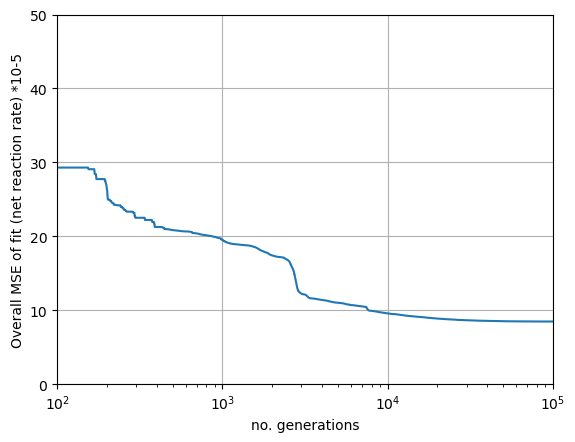

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-11.243039486571336
1.4871127939609485
0.8808853862192708
-4.054399018348414
0.46026413934769755
6.551518543027418e-08
0.38904397273657493
-3.4463568670055933
0.18245815132437762
3.894944839938256
2.759411494250064
3.0158453551893816
0.557340778122976
0.045786941997917274
3.12691788720712
2.869799631659857e-07
0.4225395401701806
-11.719758707042448
1.8521521265552587
1.5818929874169703
-9.452933349176968
0.9360596613256663
3.061636275976574
0.01852583763080596
3.3168323474984036
2.6220560208733574
1.1063967751611523
6.380251946508975
-8.448925965754961
2.3083889429398847
1.514157625530652
2.951652973028335
-4.2380117482847695
0.5379274360788361
0.9670879353532319
-1.3010299829149945


In [37]:
res.X

array([-1.12430395e+01,  1.48711279e+00,  8.80885386e-01, -4.05439902e+00,
        4.60264139e-01,  6.55151854e-08,  3.89043973e-01, -3.44635687e+00,
        1.82458151e-01,  3.89494484e+00,  2.75941149e+00,  3.01584536e+00,
        5.57340778e-01,  4.57869420e-02,  3.12691789e+00,  2.86979963e-07,
        4.22539540e-01, -1.17197587e+01,  1.85215213e+00,  1.58189299e+00,
       -9.45293335e+00,  9.36059661e-01,  3.06163628e+00,  1.85258376e-02,
        3.31683235e+00,  2.62205602e+00,  1.10639678e+00,  6.38025195e+00,
       -8.44892597e+00,  2.30838894e+00,  1.51415763e+00,  2.95165297e+00,
       -4.23801175e+00,  5.37927436e-01,  9.67087935e-01, -1.30102998e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
#logkr=np.ndarray.tolist(logkr)
#del logkr[-1]

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -11.243039486571336
1.6: 1.4871127939609485
0.9: 0.8808853862192708
-4.3: -4.054399018348414
0.5: 0.46026413934769755
0.003: 6.551518543027418e-08
0.4: 0.38904397273657493
-7.9: -3.4463568670055933
0.7: 0.18245815132437762
7.2: 3.894944839938256
5.7: 2.759411494250064
5.7: 3.0158453551893816
0.8: 0.557340778122976
0.03: 0.045786941997917274
3.1: 3.12691788720712
6.000000000000001e-09: 2.869799631659857e-07
0.1: 0.4225395401701806
-12.0: -11.719758707042448
1.9: 1.8521521265552587
1.6: 1.5818929874169703
-11.6: -9.452933349176968
1.2: 0.9360596613256663
4.0: 3.061636275976574
0.01: 0.01852583763080596
4.2: 3.3168323474984036
5.4: 2.6220560208733574
2.2: 1.1063967751611523
11.8: 6.380251946508975
-12.0: -8.448925965754961
3.3: 2.3083889429398847
1.8: 1.514157625530652
4.2: 2.951652973028335
-4.0: -4.2380117482847695
0.5: 0.5379274360788361
1.0: 0.9670879353532319
coeff fit: 0.8965784851236752
r: 0.9468782842180272
